In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import os
#Sklearn tools
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
#Keras specials
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dropout, Input, Dense, Concatenate, Lambda
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import MeanSquaredError, BinaryCrossentropy
from sklearn.model_selection import train_test_split

2025-02-06 07:58:08.401678: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 07:58:08.417199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738846688.431635 1736788 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738846688.435894 1736788 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 07:58:08.451890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Set environment variables before TensorFlow initializes
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Restrict TensorFlow to only use GPU 1
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  # Disable oneDNN optimizations

# Ensure TensorFlow only sees GPU 1
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Enable memory growth for GPU 1
        tf.config.experimental.set_memory_growth(gpus[0], True)  # gpus[0] now refers to GPU 1
        print(f"Using only GPU 1 (CUDA_VISIBLE_DEVICES=1).")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")
else:
    print("No GPUs found! Check CUDA_VISIBLE_DEVICES setting.")

# Print number of GPUs available (should only be 1 after restriction)
print("Num GPUs Available:", len(gpus))

Using only GPU 1 (CUDA_VISIBLE_DEVICES=1).
Num GPUs Available: 1


In [3]:
df_x = pd.read_csv("Complete_BF_CPP_XY_Data.csv")

/tmp/ipykernel_1736788/3693406356.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_x = pd.read_csv("Complete_BF_CPP_XY_Data.csv")


In [4]:
# Count NaN values per column
nan_counts = df_x.isna().sum()

# Total number of NaN values
total_nans = nan_counts.sum()

# Display columns with NaN values
nan_columns = nan_counts[nan_counts > 0]

# Display rows with NaN values
nan_rows = df_x[df_x.isna().any(axis=1)]

# Print results
print(f"Total NaN values: {total_nans}")
print("\nNaN count per column:")
print(nan_columns)

Total NaN values: 0

NaN count per column:
Series([], dtype: int64)


In [5]:
# Find positions of NaN values
nan_positions = np.where(df_x.isna())

# Convert positions into a readable DataFrame
nan_locations = pd.DataFrame({
    "Row Index": nan_positions[0],
    "Column Name": df_x.columns[nan_positions[1]]
})

print(nan_locations)

Empty DataFrame
Columns: [Row Index, Column Name]
Index: []


In [ ]:
X = df_x.iloc[:, 1:5]  # X data (4 features: coordinate x-y, state, and county)
Y_layer1 = df_x.iloc[:, 5:27]  # Y1 data (22 features: site objective values)
Y2 = df_x.iloc[:, 27:]

binary_indices = [3, 5, 9, 10, 11, 12, 13, 21]
float_indices = [i for i in range(22) if i not in binary_indices]

YL = Y_layer1.iloc[:, float_indices]
YB = Y_layer1.iloc[:, binary_indices]

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
YL_scaler = StandardScaler()
YL_scaled = YL_scaler.fit_transform(YL)
#YB_scaler = StandardScaler()
#YB_scaled = YB_scaler.fit_transform(YB)
Y2_scaler = StandardScaler()
Y2_scaled = Y2_scaler.fit_transform(Y2)

Y1_combined = pd.concat([pd.DataFrame(YL_scaled), pd.DataFrame(YB)], axis=1)

# Combine Y1 and Y2 temporarily for consistent splitting
Y_combined = pd.concat([pd.DataFrame(Y1_combined), pd.DataFrame(Y2_scaled)], axis=1)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_combined, test_size=0.2, random_state=1)

# Separate Y1 and Y2 back after splitting
Y1_train = Y_train.iloc[:, :Y1_combined.shape[1]]  # Extract Y1 part
Y2_train = Y_train.iloc[:, Y1_combined.shape[1]:].values  # Extract Y2 part

Y1_test = Y_test.iloc[:, :Y1_combined.shape[1]]  # Extract Y1 part
Y2_test = Y_test.iloc[:, Y1_combined.shape[1]:].values  # Extract Y2 part

# print(len(Y1_train.values[0])) # 22
# print(len(float_indices)) # 14

YL_train, YB_train = Y1_train.values[:, :len(float_indices)], Y1_train.values[:, len(float_indices):]
YL_test, YB_test = Y1_test.values[:, :len(float_indices)], Y1_test.values[:, len(float_indices):]


In [7]:
print(X_test[0,:])

[-0.15606184  0.61222438 -0.59649565 -0.60001106]


In [8]:
print(YL_test[0,:])

[-0.50211636 -0.92680966 -0.30736793 -0.86397954 -0.35133414 -0.63748399
 -0.85264835 -0.57426053  0.20627021 -0.54082277  0.00566712 -0.46805828
 -0.18774772  0.85601048]


In [9]:
print(YB_test[0,:])

[0. 1. 1. 1. 1. 0. 1. 1.]


In [10]:
print(Y2_test[0,:])

[ 0.61406174 -0.80452369 -0.80657463 -0.87345736 -0.63849199  0.98552883
 -0.8732135   0.99507988 -0.5799042   0.3940368   0.82714965  0.45363508
 -0.58402721  0.41925051 -0.64089488  0.41693887 -0.62372792 -0.74953046
 -0.67855653 -0.63543443 -0.89780629  0.53618529 -0.44230068]


In [11]:
assert not np.any(np.isnan(X_train)), "Training data contains NaN values"
assert not np.any(np.isnan(YL_train)), "YL_train contains NaN values"
assert not np.any(np.isnan(YB_train)), "YB_train contains NaN values"
print(np.unique(YB_train))

[0. 1.]


In [12]:
input_layer = Input(shape=(4,), name="Input_Layer")
x = Dense(600, activation='relu', name="Dense_Layer_1")(input_layer)
x = Dense(600, activation='relu', name="Dense_Layer_2")(x)
x = Dense(600, activation='relu', name="Dense_Layer_3")(x)
x = Dense(600, activation='relu', name="Dense_Layer_4")(x)
x = Dense(600, activation='relu', name="Dense_Layer_5")(x)
x = Dense(600, activation='relu', name="Dense_Layer_6")(x)
x = Dense(600, activation='relu', name="Dense_Layer_7")(x)
output_L = Dense(14, activation='linear', name="Output_Linear")(x)
output_B = Dense(8, activation='sigmoid', name="Output_Sigmoid")(x)
# output_B_binary = Lambda(lambda x: tf.cast(x > 0.5, tf.float32), name="Binarize_Layer")(output_B)

# Define the second neural network (Network 2)
# Network 2 takes the 4 original inputs and the 22 outputs from Network 1
concat_Y1 = Concatenate(name="Concatenate_Layer1")([output_L, output_B])
concat_inputs = Concatenate(name="Concatenate_Layer2")([input_layer, concat_Y1])
x2 = Dense(950, activation='relu', name="Dense_Layer_8")(concat_inputs)
x2 = Dense(950, activation='relu', name="Dense_Layer_9")(x2)
x2 = Dense(950, activation='relu', name="Dense_Layer_10")(x2)
x2 = Dense(950, activation='relu', name="Dense_Layer_11")(x2)
x2 = Dense(950, activation='relu', name="Dense_Layer_12")(x2)
output_2 = Dense(23, activation='linear', name="Output_Layer_2")(x2)

# Create a model that includes both networks
model = Model(inputs=input_layer, outputs=[output_L, output_B, output_2], name="Concatenated_Model")

# Compile the model
# We use two losses, one for each output (Network 1's and Network 2's predictions)
optimizer = Adam(learning_rate=1e-3, clipvalue=1.0)
model.compile(optimizer=optimizer, loss=['mse', 'binary_crossentropy', 'mse'])

model_name = 'best_ConcNN_std_2000_256.keras'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.92, patience=25, min_lr=0, verbose=1, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True, verbose=1, mode='min')
checkpoint = ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Print the model summary to verify the structure
model.summary()

I0000 00:00:1738846690.079541 1736788 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46672 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:21:00.0, compute capability: 8.9


Model: "Concatenated_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_1       │ (None, 600)       │      3,000 │ Input_Layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_2       │ (None, 600)       │    360,600 │ Dense_Layer_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_3       │ (None, 600)       │    360,600 │ Dense_Layer_2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_4       │ (None, 600)       │    360,600 │ Dense_Layer_3[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_5       │ (None, 600)       │    360,600 │ Dense_Layer_4[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_6       │ (None, 600)       │    360,600 │ Dense_Layer_5[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_7       │ (None, 600)       │    360,600 │ Dense_Layer_6[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Linear       │ (None, 14)        │      8,414 │ Dense_Layer_7[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Sigmoid      │ (None, 8)         │      4,808 │ Dense_Layer_7[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate_Layer1  │ (None, 22)        │          0 │ Output_Linear[0]… │
│ (Concatenate)       │                   │            │ Output_Sigmoid[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate_Layer2  │ (None, 26)        │          0 │ Input_Layer[0][0… │
│ (Concatenate)       │                   │            │ Concatenate_Laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_8       │ (None, 950)       │     25,650 │ Concatenate_Laye… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_9       │ (None, 950)       │    903,450 │ Dense_Layer_8[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_10      │ (None, 950)       │    903,450 │ Dense_Layer_9[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_11      │ (None, 950)       │    903,450 │ Dense_Layer_10[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer_12      │ (None, 950)       │    903,450 │ Dense_Layer_11[0

 Total params: 5,841,145 (25.73 MB)

 Trainable params: 5,841,145 (25.73 MB)

 Non-trainable params: 0 (0.00 B)

Concatenate_Layer1 shows the layer which the first part outputs (y1) are taken. It is the combined Output_Linear and Output_Sigmoid layers. Concatenate_Layer2 shows the input of the second part of the model. It is the combined Concatenate_Layer1 and Input_Layer. Output_Layer_2 is the second layer outputs (y2).

In [13]:
start_time = time()
history = model.fit(X_train, [YL_train, YB_train, Y2_train], epochs=2000, batch_size=256, validation_split=0.15, callbacks=[reduce_lr, early_stopping, checkpoint])
print("Training took",(time()-start_time)/60,"minutes.")

Epoch 1/2000


I0000 00:00:1738846692.705176 1737706 service.cc:148] XLA service 0x7ef88802b8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738846692.705300 1737706 service.cc:156]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-02-06 07:58:12.799280: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1738846693.106855 1737706 cuda_dnn.cc:529] Loaded cuDNN version 90300


2025-02-06 07:58:16.018488: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 116 bytes spill stores, 116 bytes spill loads



2025-02-06 07:58:16.685585: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694', 208 bytes spill stores, 208 bytes spill loads

2025-02-06 07:58:16.793343: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694_0', 220 bytes spill stores, 220 bytes spill loads

2025-02-06 07:58:16.860832: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1227', 4 bytes spill stores, 4 bytes spill loads



2025-02-06 07:58:16.895188: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_659_0', 12 bytes spill stores, 12 bytes spill loads

2025-02-06 07:58:16.906921: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_578', 20 bytes spill stores, 20 bytes spill loads

2025-02-06 07:58:16.924270: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_578', 32 bytes spill stores, 32 bytes spill loads

2025-02-06 07:58:16.927563: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694', 216 bytes spill stores, 228 bytes spill loads

2025-02-06 07:58:16.938264: I external/local_xla/xla/stream_

2025-02-06 07:58:17.106930: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_578', 36 bytes spill stores, 36 bytes spill loads

2025-02-06 07:58:17.120048: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 404 bytes spill stores, 404 bytes spill loads

2025-02-06 07:58:17.130356: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694', 252 bytes spill stores, 252 bytes spill loads

2025-02-06 07:58:17.160030: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_659_0', 608 bytes spill stores, 600 bytes spill loads

2025-02-06 07:58:17.164516: I external/local_xla/xla/stream_

2025-02-06 07:58:17.332296: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_659_0', 872 bytes spill stores, 828 bytes spill loads




 1/92 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - Output_Layer_2_loss: 1.0017 - Output_Linear_loss: 0.9718 - Output_Sigmoid_loss: 0.6922 - loss: 2.6657


14/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.9629 - Output_Linear_loss: 0.9337 - Output_Sigmoid_loss: 0.5520 - loss: 2.4486  


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.9330 - Output_Linear_loss: 0.8813 - Output_Sigmoid_loss: 0.4901 - loss: 2.3045


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.9086 - Output_Linear_loss: 0.8521 - Output_Sigmoid_loss: 0.4586 - loss: 2.2193

I0000 00:00:1738846700.000062 1737706 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.8885 - Output_Linear_loss: 0.8309 - Output_Sigmoid_loss: 0.4377 - loss: 2.1571


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.8702 - Output_Linear_loss: 0.8084 - Output_Sigmoid_loss: 0.4205 - loss: 2.0992

2025-02-06 07:58:22.118705: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_659', 44 bytes spill stores, 44 bytes spill loads

2025-02-06 07:58:22.245126: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_659', 8 bytes spill stores, 8 bytes spill loads

2025-02-06 07:58:22.291865: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 44 bytes spill stores, 44 bytes spill loads

2025-02-06 07:58:22.300006: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_659', 360 bytes spill stores, 312 bytes spill loads



2025-02-06 07:58:22.387279: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1227', 40 bytes spill stores, 40 bytes spill loads

2025-02-06 07:58:22.440604: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1595', 12 bytes spill stores, 12 bytes spill loads

2025-02-06 07:58:22.446794: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_659', 64 bytes spill stores, 64 bytes spill loads



2025-02-06 07:58:22.588869: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1227', 36 bytes spill stores, 36 bytes spill loads

2025-02-06 07:58:22.590964: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 668 bytes spill stores, 836 bytes spill loads

2025-02-06 07:58:22.652475: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694', 248 bytes spill stores, 248 bytes spill loads

2025-02-06 07:58:22.718942: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694_0', 228 bytes spill stores, 228 bytes spill loads



2025-02-06 07:58:22.836571: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1227', 40 bytes spill stores, 40 bytes spill loads

2025-02-06 07:58:22.940658: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694', 72 bytes spill stores, 72 bytes spill loads

2025-02-06 07:58:22.946584: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_578', 28 bytes spill stores, 28 bytes spill loads

2025-02-06 07:58:22.959463: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_578', 64 bytes spill stores, 64 bytes spill loads

2025-02-06 07:58:22.968210: I external/local_xla/xla/stream_exe

2025-02-06 07:58:23.055575: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_578', 24 bytes spill stores, 24 bytes spill loads

2025-02-06 07:58:23.078464: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_659', 252 bytes spill stores, 252 bytes spill loads

2025-02-06 07:58:23.084147: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_659', 20 bytes spill stores, 20 bytes spill loads

2025-02-06 07:58:23.112198: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1659', 60 bytes spill stores, 60 bytes spill loads

2025-02-06 07:58:23.127219: I external/local_xla/xla/stream_e

2025-02-06 07:58:23.308826: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694', 4012 bytes spill stores, 3728 bytes spill loads

2025-02-06 07:58:23.322542: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1699', 120 bytes spill stores, 120 bytes spill loads

2025-02-06 07:58:23.331280: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_578_0', 1060 bytes spill stores, 748 bytes spill loads

2025-02-06 07:58:23.334060: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_694', 732 bytes spill stores, 688 bytes spill loads

2025-02-06 07:58:23.384804: I external/local_xla/x


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - Output_Layer_2_loss: 0.8542 - Output_Linear_loss: 0.7861 - Output_Sigmoid_loss: 0.4057 - loss: 2.0460

2025-02-06 07:58:29.410247: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 48 bytes spill stores, 48 bytes spill loads

2025-02-06 07:58:29.458626: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 44 bytes spill stores, 44 bytes spill loads

2025-02-06 07:58:29.464565: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 180 bytes spill stores, 180 bytes spill loads

2025-02-06 07:58:29.467766: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 16 bytes spill stores, 16 bytes spill loads

2025-02-06 07:58:29.471425: I external/local_xla/xla/stream_exec

2025-02-06 07:58:29.633177: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_157', 664 bytes spill stores, 636 bytes spill loads

2025-02-06 07:58:29.654423: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 688 bytes spill stores, 488 bytes spill loads

2025-02-06 07:58:29.669073: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_157', 424 bytes spill stores, 424 bytes spill loads

2025-02-06 07:58:29.674227: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 304 bytes spill stores, 304 bytes spill loads

2025-02-06 07:58:29.716138: I external/local_xla/xla/stre

2025-02-06 07:58:29.867105: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 1072 bytes spill stores, 848 bytes spill loads

2025-02-06 07:58:29.982617: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 860 bytes spill stores, 868 bytes spill loads




Epoch 1: val_loss improved from inf to 1.49798, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - Output_Layer_2_loss: 0.8533 - Output_Linear_loss: 0.7849 - Output_Sigmoid_loss: 0.4049 - loss: 2.0432 - val_Output_Layer_2_loss: 0.6979 - val_Output_Linear_loss: 0.8033 - val_Output_Sigmoid_loss: 0.2446 - val_loss: 1.4980 - learning_rate: 0.0010


Epoch 2/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - Output_Layer_2_loss: 0.7424 - Output_Linear_loss: 0.4698 - Output_Sigmoid_loss: 0.2396 - loss: 1.4518


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.7104 - Output_Linear_loss: 0.4751 - Output_Sigmoid_loss: 0.2456 - loss: 1.4311   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.7042 - Output_Linear_loss: 0.4742 - Output_Sigmoid_loss: 0.2402 - loss: 1.4186


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6985 - Output_Linear_loss: 0.4753 - Output_Sigmoid_loss: 0.2359 - loss: 1.4097


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6934 - Output_Linear_loss: 0.4814 - Output_Sigmoid_loss: 0.2323 - loss: 1.4071


Epoch 2: val_loss improved from 1.49798 to 1.31897, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.6905 - Output_Linear_loss: 0.4838 - Output_Sigmoid_loss: 0.2301 - loss: 1.4044 - val_Output_Layer_2_loss: 0.6313 - val_Output_Linear_loss: 0.7315 - val_Output_Sigmoid_loss: 0.1961 - val_loss: 1.3190 - learning_rate: 0.0010


Epoch 3/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.6731 - Output_Linear_loss: 0.3754 - Output_Sigmoid_loss: 0.1935 - loss: 1.2420


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6474 - Output_Linear_loss: 0.4211 - Output_Sigmoid_loss: 0.1942 - loss: 1.2627   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6443 - Output_Linear_loss: 0.4212 - Output_Sigmoid_loss: 0.1922 - loss: 1.2576


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6446 - Output_Linear_loss: 0.4227 - Output_Sigmoid_loss: 0.1904 - loss: 1.2578


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6437 - Output_Linear_loss: 0.4331 - Output_Sigmoid_loss: 0.1893 - loss: 1.2661


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6430 - Output_Linear_loss: 0.4375 - Output_Sigmoid_loss: 0.1883 - loss: 1.2688


Epoch 3: val_loss improved from 1.31897 to 1.25820, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.6425 - Output_Linear_loss: 0.4383 - Output_Sigmoid_loss: 0.1877 - loss: 1.2685 - val_Output_Layer_2_loss: 0.6242 - val_Output_Linear_loss: 0.7038 - val_Output_Sigmoid_loss: 0.1772 - val_loss: 1.2582 - learning_rate: 0.0010


Epoch 4/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - Output_Layer_2_loss: 0.5749 - Output_Linear_loss: 0.3639 - Output_Sigmoid_loss: 0.1840 - loss: 1.1227


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6297 - Output_Linear_loss: 0.4580 - Output_Sigmoid_loss: 0.1864 - loss: 1.2741   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6337 - Output_Linear_loss: 0.4532 - Output_Sigmoid_loss: 0.1832 - loss: 1.2700


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6324 - Output_Linear_loss: 0.4535 - Output_Sigmoid_loss: 0.1807 - loss: 1.2666


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6306 - Output_Linear_loss: 0.4539 - Output_Sigmoid_loss: 0.1788 - loss: 1.2633


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.6291 - Output_Linear_loss: 0.4499 - Output_Sigmoid_loss: 0.1774 - loss: 1.2563


Epoch 4: val_loss improved from 1.25820 to 1.19604, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.6287 - Output_Linear_loss: 0.4485 - Output_Sigmoid_loss: 0.1771 - loss: 1.2543 - val_Output_Layer_2_loss: 0.6031 - val_Output_Linear_loss: 0.6681 - val_Output_Sigmoid_loss: 0.1638 - val_loss: 1.1960 - learning_rate: 0.0010


Epoch 5/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.5858 - Output_Linear_loss: 0.3653 - Output_Sigmoid_loss: 0.1630 - loss: 1.1141


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.6019 - Output_Linear_loss: 0.3878 - Output_Sigmoid_loss: 0.1619 - loss: 1.1516   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.6057 - Output_Linear_loss: 0.4132 - Output_Sigmoid_loss: 0.1631 - loss: 1.1820


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.6073 - Output_Linear_loss: 0.4164 - Output_Sigmoid_loss: 0.1635 - loss: 1.1872


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.6075 - Output_Linear_loss: 0.4135 - Output_Sigmoid_loss: 0.1636 - loss: 1.1846


Epoch 5: val_loss improved from 1.19604 to 1.18604, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.6073 - Output_Linear_loss: 0.4125 - Output_Sigmoid_loss: 0.1636 - loss: 1.1834 - val_Output_Layer_2_loss: 0.5980 - val_Output_Linear_loss: 0.6644 - val_Output_Sigmoid_loss: 0.1587 - val_loss: 1.1860 - learning_rate: 0.0010


Epoch 6/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.5582 - Output_Linear_loss: 0.3607 - Output_Sigmoid_loss: 0.1400 - loss: 1.0589


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5938 - Output_Linear_loss: 0.3693 - Output_Sigmoid_loss: 0.1563 - loss: 1.1194   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5923 - Output_Linear_loss: 0.3951 - Output_Sigmoid_loss: 0.1576 - loss: 1.1450


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5914 - Output_Linear_loss: 0.3952 - Output_Sigmoid_loss: 0.1575 - loss: 1.1442


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5910 - Output_Linear_loss: 0.3942 - Output_Sigmoid_loss: 0.1574 - loss: 1.1426


Epoch 6: val_loss improved from 1.18604 to 1.13739, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.5913 - Output_Linear_loss: 0.3933 - Output_Sigmoid_loss: 0.1573 - loss: 1.1419 - val_Output_Layer_2_loss: 0.5803 - val_Output_Linear_loss: 0.6421 - val_Output_Sigmoid_loss: 0.1511 - val_loss: 1.1374 - learning_rate: 0.0010


Epoch 7/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.6181 - Output_Linear_loss: 0.3016 - Output_Sigmoid_loss: 0.1645 - loss: 1.0842


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5838 - Output_Linear_loss: 0.3396 - Output_Sigmoid_loss: 0.1536 - loss: 1.0771   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5879 - Output_Linear_loss: 0.3508 - Output_Sigmoid_loss: 0.1538 - loss: 1.0925


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5879 - Output_Linear_loss: 0.3605 - Output_Sigmoid_loss: 0.1532 - loss: 1.1016


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5869 - Output_Linear_loss: 0.3660 - Output_Sigmoid_loss: 0.1528 - loss: 1.1057


Epoch 7: val_loss improved from 1.13739 to 1.11990, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.5860 - Output_Linear_loss: 0.3668 - Output_Sigmoid_loss: 0.1525 - loss: 1.1053 - val_Output_Layer_2_loss: 0.5729 - val_Output_Linear_loss: 0.6350 - val_Output_Sigmoid_loss: 0.1479 - val_loss: 1.1199 - learning_rate: 0.0010


Epoch 8/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - Output_Layer_2_loss: 0.5742 - Output_Linear_loss: 0.3275 - Output_Sigmoid_loss: 0.1502 - loss: 1.0519


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5726 - Output_Linear_loss: 0.3362 - Output_Sigmoid_loss: 0.1504 - loss: 1.0592   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5736 - Output_Linear_loss: 0.3769 - Output_Sigmoid_loss: 0.1506 - loss: 1.1011


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5741 - Output_Linear_loss: 0.3801 - Output_Sigmoid_loss: 0.1503 - loss: 1.1045


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5746 - Output_Linear_loss: 0.3771 - Output_Sigmoid_loss: 0.1500 - loss: 1.1018


Epoch 8: val_loss improved from 1.11990 to 1.10685, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.5753 - Output_Linear_loss: 0.3747 - Output_Sigmoid_loss: 0.1499 - loss: 1.0999 - val_Output_Layer_2_loss: 0.5656 - val_Output_Linear_loss: 0.6288 - val_Output_Sigmoid_loss: 0.1474 - val_loss: 1.1069 - learning_rate: 0.0010


Epoch 9/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.5894 - Output_Linear_loss: 0.3773 - Output_Sigmoid_loss: 0.1379 - loss: 1.1047


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5689 - Output_Linear_loss: 0.3309 - Output_Sigmoid_loss: 0.1435 - loss: 1.0433   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5674 - Output_Linear_loss: 0.3301 - Output_Sigmoid_loss: 0.1439 - loss: 1.0415


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5689 - Output_Linear_loss: 0.3311 - Output_Sigmoid_loss: 0.1446 - loss: 1.0446


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5692 - Output_Linear_loss: 0.3364 - Output_Sigmoid_loss: 0.1448 - loss: 1.0504


Epoch 9: val_loss improved from 1.10685 to 1.09088, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.5694 - Output_Linear_loss: 0.3395 - Output_Sigmoid_loss: 0.1450 - loss: 1.0539 - val_Output_Layer_2_loss: 0.5605 - val_Output_Linear_loss: 0.6219 - val_Output_Sigmoid_loss: 0.1448 - val_loss: 1.0909 - learning_rate: 0.0010


Epoch 10/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.5548 - Output_Linear_loss: 0.2769 - Output_Sigmoid_loss: 0.1591 - loss: 0.9907


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5554 - Output_Linear_loss: 0.3004 - Output_Sigmoid_loss: 0.1432 - loss: 0.9990   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5601 - Output_Linear_loss: 0.3094 - Output_Sigmoid_loss: 0.1426 - loss: 1.0121


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5628 - Output_Linear_loss: 0.3144 - Output_Sigmoid_loss: 0.1425 - loss: 1.0197


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5646 - Output_Linear_loss: 0.3263 - Output_Sigmoid_loss: 0.1428 - loss: 1.0338


Epoch 10: val_loss improved from 1.09088 to 1.07023, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.5651 - Output_Linear_loss: 0.3294 - Output_Sigmoid_loss: 0.1429 - loss: 1.0374 - val_Output_Layer_2_loss: 0.5517 - val_Output_Linear_loss: 0.6141 - val_Output_Sigmoid_loss: 0.1389 - val_loss: 1.0702 - learning_rate: 0.0010


Epoch 11/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.5681 - Output_Linear_loss: 0.2766 - Output_Sigmoid_loss: 0.1292 - loss: 0.9738


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5637 - Output_Linear_loss: 0.4120 - Output_Sigmoid_loss: 0.1394 - loss: 1.1151   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5604 - Output_Linear_loss: 0.3944 - Output_Sigmoid_loss: 0.1392 - loss: 1.0940


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5581 - Output_Linear_loss: 0.3806 - Output_Sigmoid_loss: 0.1394 - loss: 1.0780


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5569 - Output_Linear_loss: 0.3711 - Output_Sigmoid_loss: 0.1394 - loss: 1.0674


Epoch 11: val_loss did not improve from 1.07023



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5566 - Output_Linear_loss: 0.3691 - Output_Sigmoid_loss: 0.1394 - loss: 1.0651 - val_Output_Layer_2_loss: 0.5594 - val_Output_Linear_loss: 0.6168 - val_Output_Sigmoid_loss: 0.1454 - val_loss: 1.0870 - learning_rate: 0.0010


Epoch 12/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.5861 - Output_Linear_loss: 0.2981 - Output_Sigmoid_loss: 0.1394 - loss: 1.0237


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5616 - Output_Linear_loss: 0.3153 - Output_Sigmoid_loss: 0.1400 - loss: 1.0169 


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5616 - Output_Linear_loss: 0.3183 - Output_Sigmoid_loss: 0.1407 - loss: 1.0206


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5614 - Output_Linear_loss: 0.3189 - Output_Sigmoid_loss: 0.1413 - loss: 1.0216


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5609 - Output_Linear_loss: 0.3201 - Output_Sigmoid_loss: 0.1421 - loss: 1.0231


Epoch 12: val_loss did not improve from 1.07023



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5606 - Output_Linear_loss: 0.3257 - Output_Sigmoid_loss: 0.1424 - loss: 1.0286 - val_Output_Layer_2_loss: 0.5532 - val_Output_Linear_loss: 0.6217 - val_Output_Sigmoid_loss: 0.1398 - val_loss: 1.0749 - learning_rate: 0.0010


Epoch 13/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.6098 - Output_Linear_loss: 0.3186 - Output_Sigmoid_loss: 0.1402 - loss: 1.0686


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5675 - Output_Linear_loss: 0.3025 - Output_Sigmoid_loss: 0.1415 - loss: 1.0115 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5611 - Output_Linear_loss: 0.3004 - Output_Sigmoid_loss: 0.1409 - loss: 1.0025


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5589 - Output_Linear_loss: 0.3005 - Output_Sigmoid_loss: 0.1404 - loss: 0.9998


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5567 - Output_Linear_loss: 0.3031 - Output_Sigmoid_loss: 0.1397 - loss: 0.9995


Epoch 13: val_loss improved from 1.07023 to 1.02858, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.5556 - Output_Linear_loss: 0.3063 - Output_Sigmoid_loss: 0.1394 - loss: 1.0012 - val_Output_Layer_2_loss: 0.5361 - val_Output_Linear_loss: 0.5937 - val_Output_Sigmoid_loss: 0.1322 - val_loss: 1.0286 - learning_rate: 0.0010


Epoch 14/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.5390 - Output_Linear_loss: 0.3035 - Output_Sigmoid_loss: 0.1235 - loss: 0.9661


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5339 - Output_Linear_loss: 0.2917 - Output_Sigmoid_loss: 0.1298 - loss: 0.9553   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5374 - Output_Linear_loss: 0.2948 - Output_Sigmoid_loss: 0.1318 - loss: 0.9640


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5373 - Output_Linear_loss: 0.3010 - Output_Sigmoid_loss: 0.1323 - loss: 0.9707


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5375 - Output_Linear_loss: 0.3061 - Output_Sigmoid_loss: 0.1325 - loss: 0.9761


Epoch 14: val_loss did not improve from 1.02858



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5378 - Output_Linear_loss: 0.3093 - Output_Sigmoid_loss: 0.1327 - loss: 0.9798 - val_Output_Layer_2_loss: 0.5682 - val_Output_Linear_loss: 0.6390 - val_Output_Sigmoid_loss: 0.1480 - val_loss: 1.1181 - learning_rate: 0.0010


Epoch 15/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.6125 - Output_Linear_loss: 0.3593 - Output_Sigmoid_loss: 0.1710 - loss: 1.1428


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5788 - Output_Linear_loss: 0.3779 - Output_Sigmoid_loss: 0.1486 - loss: 1.1053 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5714 - Output_Linear_loss: 0.3777 - Output_Sigmoid_loss: 0.1450 - loss: 1.0941


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5673 - Output_Linear_loss: 0.3794 - Output_Sigmoid_loss: 0.1433 - loss: 1.0900


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5642 - Output_Linear_loss: 0.3755 - Output_Sigmoid_loss: 0.1423 - loss: 1.0820


Epoch 15: val_loss did not improve from 1.02858



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5630 - Output_Linear_loss: 0.3734 - Output_Sigmoid_loss: 0.1420 - loss: 1.0784 - val_Output_Layer_2_loss: 0.5342 - val_Output_Linear_loss: 0.6079 - val_Output_Sigmoid_loss: 0.1348 - val_loss: 1.0437 - learning_rate: 0.0010


Epoch 16/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.5478 - Output_Linear_loss: 0.2609 - Output_Sigmoid_loss: 0.1339 - loss: 0.9425


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5405 - Output_Linear_loss: 0.2978 - Output_Sigmoid_loss: 0.1311 - loss: 0.9694 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5390 - Output_Linear_loss: 0.3121 - Output_Sigmoid_loss: 0.1322 - loss: 0.9833


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5397 - Output_Linear_loss: 0.3293 - Output_Sigmoid_loss: 0.1331 - loss: 1.0021


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5403 - Output_Linear_loss: 0.3351 - Output_Sigmoid_loss: 0.1338 - loss: 1.0092


Epoch 16: val_loss did not improve from 1.02858



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5405 - Output_Linear_loss: 0.3362 - Output_Sigmoid_loss: 0.1342 - loss: 1.0109 - val_Output_Layer_2_loss: 0.5461 - val_Output_Linear_loss: 0.5921 - val_Output_Sigmoid_loss: 0.1330 - val_loss: 1.0315 - learning_rate: 0.0010


Epoch 17/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.5026 - Output_Linear_loss: 0.2989 - Output_Sigmoid_loss: 0.1351 - loss: 0.9365


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5436 - Output_Linear_loss: 0.2912 - Output_Sigmoid_loss: 0.1400 - loss: 0.9748  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5457 - Output_Linear_loss: 0.2948 - Output_Sigmoid_loss: 0.1386 - loss: 0.9791


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5444 - Output_Linear_loss: 0.2951 - Output_Sigmoid_loss: 0.1381 - loss: 0.9777


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5429 - Output_Linear_loss: 0.2957 - Output_Sigmoid_loss: 0.1372 - loss: 0.9759


Epoch 17: val_loss improved from 1.02858 to 1.01876, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.5423 - Output_Linear_loss: 0.3017 - Output_Sigmoid_loss: 0.1367 - loss: 0.9807 - val_Output_Layer_2_loss: 0.5314 - val_Output_Linear_loss: 0.5914 - val_Output_Sigmoid_loss: 0.1301 - val_loss: 1.0188 - learning_rate: 0.0010


Epoch 18/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.5726 - Output_Linear_loss: 0.3395 - Output_Sigmoid_loss: 0.1302 - loss: 1.0424


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5477 - Output_Linear_loss: 0.5191 - Output_Sigmoid_loss: 0.1345 - loss: 1.2013  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5426 - Output_Linear_loss: 0.4531 - Output_Sigmoid_loss: 0.1344 - loss: 1.1301


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5390 - Output_Linear_loss: 0.4162 - Output_Sigmoid_loss: 0.1338 - loss: 1.0890


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5368 - Output_Linear_loss: 0.3933 - Output_Sigmoid_loss: 0.1331 - loss: 1.0631


Epoch 18: val_loss improved from 1.01876 to 1.00339, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.5362 - Output_Linear_loss: 0.3869 - Output_Sigmoid_loss: 0.1328 - loss: 1.0558 - val_Output_Layer_2_loss: 0.5249 - val_Output_Linear_loss: 0.5825 - val_Output_Sigmoid_loss: 0.1274 - val_loss: 1.0034 - learning_rate: 0.0010


Epoch 19/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.5653 - Output_Linear_loss: 0.2603 - Output_Sigmoid_loss: 0.1529 - loss: 0.9785


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5365 - Output_Linear_loss: 0.2708 - Output_Sigmoid_loss: 0.1359 - loss: 0.9433   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5291 - Output_Linear_loss: 0.2814 - Output_Sigmoid_loss: 0.1315 - loss: 0.9420


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5273 - Output_Linear_loss: 0.2949 - Output_Sigmoid_loss: 0.1299 - loss: 0.9521


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5265 - Output_Linear_loss: 0.2991 - Output_Sigmoid_loss: 0.1293 - loss: 0.9548


Epoch 19: val_loss did not improve from 1.00339



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5262 - Output_Linear_loss: 0.3009 - Output_Sigmoid_loss: 0.1291 - loss: 0.9563 - val_Output_Layer_2_loss: 0.5260 - val_Output_Linear_loss: 0.5927 - val_Output_Sigmoid_loss: 0.1313 - val_loss: 1.0130 - learning_rate: 0.0010


Epoch 20/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.5690 - Output_Linear_loss: 0.2600 - Output_Sigmoid_loss: 0.1279 - loss: 0.9568


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5503 - Output_Linear_loss: 0.2754 - Output_Sigmoid_loss: 0.1280 - loss: 0.9537 


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5428 - Output_Linear_loss: 0.2816 - Output_Sigmoid_loss: 0.1282 - loss: 0.9526


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5390 - Output_Linear_loss: 0.2812 - Output_Sigmoid_loss: 0.1282 - loss: 0.9484


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5365 - Output_Linear_loss: 0.2807 - Output_Sigmoid_loss: 0.1281 - loss: 0.9453


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5342 - Output_Linear_loss: 0.2836 - Output_Sigmoid_loss: 0.1279 - loss: 0.9456


Epoch 20: val_loss improved from 1.00339 to 0.97481, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Output_Layer_2_loss: 0.5332 - Output_Linear_loss: 0.2862 - Output_Sigmoid_loss: 0.1277 - loss: 0.9472 - val_Output_Layer_2_loss: 0.5121 - val_Output_Linear_loss: 0.5683 - val_Output_Sigmoid_loss: 0.1243 - val_loss: 0.9748 - learning_rate: 0.0010


Epoch 21/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.4517 - Output_Linear_loss: 2.3985 - Output_Sigmoid_loss: 0.1012 - loss: 2.9514


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5119 - Output_Linear_loss: 0.7234 - Output_Sigmoid_loss: 0.1224 - loss: 1.3577   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5159 - Output_Linear_loss: 0.5345 - Output_Sigmoid_loss: 0.1234 - loss: 1.1738


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5172 - Output_Linear_loss: 0.4672 - Output_Sigmoid_loss: 0.1240 - loss: 1.1084


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5185 - Output_Linear_loss: 0.4335 - Output_Sigmoid_loss: 0.1245 - loss: 1.0765


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5200 - Output_Linear_loss: 0.4115 - Output_Sigmoid_loss: 0.1252 - loss: 1.0566


Epoch 21: val_loss did not improve from 0.97481



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.5207 - Output_Linear_loss: 0.4006 - Output_Sigmoid_loss: 0.1255 - loss: 1.0468 - val_Output_Layer_2_loss: 0.5348 - val_Output_Linear_loss: 0.6278 - val_Output_Sigmoid_loss: 0.1339 - val_loss: 1.0544 - learning_rate: 0.0010


Epoch 22/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.4774 - Output_Linear_loss: 0.3429 - Output_Sigmoid_loss: 0.1303 - loss: 0.9506


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5273 - Output_Linear_loss: 0.3106 - Output_Sigmoid_loss: 0.1376 - loss: 0.9754  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5301 - Output_Linear_loss: 0.3076 - Output_Sigmoid_loss: 0.1356 - loss: 0.9733


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5328 - Output_Linear_loss: 0.3092 - Output_Sigmoid_loss: 0.1344 - loss: 0.9765


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5330 - Output_Linear_loss: 0.3155 - Output_Sigmoid_loss: 0.1335 - loss: 0.9820


Epoch 22: val_loss did not improve from 0.97481



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5328 - Output_Linear_loss: 0.3161 - Output_Sigmoid_loss: 0.1333 - loss: 0.9822 - val_Output_Layer_2_loss: 0.5461 - val_Output_Linear_loss: 0.6096 - val_Output_Sigmoid_loss: 0.1317 - val_loss: 1.0531 - learning_rate: 0.0010


Epoch 23/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.5670 - Output_Linear_loss: 0.3516 - Output_Sigmoid_loss: 0.1194 - loss: 1.0380


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5312 - Output_Linear_loss: 0.3061 - Output_Sigmoid_loss: 0.1275 - loss: 0.9649 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5297 - Output_Linear_loss: 0.3073 - Output_Sigmoid_loss: 0.1281 - loss: 0.9651


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5298 - Output_Linear_loss: 0.3063 - Output_Sigmoid_loss: 0.1281 - loss: 0.9642


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5289 - Output_Linear_loss: 0.3093 - Output_Sigmoid_loss: 0.1280 - loss: 0.9662


Epoch 23: val_loss did not improve from 0.97481



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5287 - Output_Linear_loss: 0.3099 - Output_Sigmoid_loss: 0.1280 - loss: 0.9667 - val_Output_Layer_2_loss: 0.5192 - val_Output_Linear_loss: 0.5862 - val_Output_Sigmoid_loss: 0.1262 - val_loss: 0.9929 - learning_rate: 0.0010


Epoch 24/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - Output_Layer_2_loss: 0.4854 - Output_Linear_loss: 0.2614 - Output_Sigmoid_loss: 0.1283 - loss: 0.8750


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5124 - Output_Linear_loss: 0.2690 - Output_Sigmoid_loss: 0.1269 - loss: 0.9083   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5144 - Output_Linear_loss: 0.3107 - Output_Sigmoid_loss: 0.1255 - loss: 0.9506


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5144 - Output_Linear_loss: 0.3149 - Output_Sigmoid_loss: 0.1250 - loss: 0.9542


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5139 - Output_Linear_loss: 0.3154 - Output_Sigmoid_loss: 0.1245 - loss: 0.9538


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5136 - Output_Linear_loss: 0.3143 - Output_Sigmoid_loss: 0.1242 - loss: 0.9521


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5133 - Output_Linear_loss: 0.3123 - Output_Sigmoid_loss: 0.1240 - loss: 0.9496


Epoch 24: val_loss improved from 0.97481 to 0.96248, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Output_Layer_2_loss: 0.5133 - Output_Linear_loss: 0.3121 - Output_Sigmoid_loss: 0.1240 - loss: 0.9494 - val_Output_Layer_2_loss: 0.5076 - val_Output_Linear_loss: 0.5658 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.9625 - learning_rate: 0.0010


Epoch 25/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.4981 - Output_Linear_loss: 0.3055 - Output_Sigmoid_loss: 0.1233 - loss: 0.9268


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5061 - Output_Linear_loss: 0.2945 - Output_Sigmoid_loss: 0.1252 - loss: 0.9258   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5120 - Output_Linear_loss: 0.2968 - Output_Sigmoid_loss: 0.1251 - loss: 0.9340


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5156 - Output_Linear_loss: 0.3110 - Output_Sigmoid_loss: 0.1256 - loss: 0.9522


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5172 - Output_Linear_loss: 0.3155 - Output_Sigmoid_loss: 0.1259 - loss: 0.9586


Epoch 25: val_loss did not improve from 0.96248



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5175 - Output_Linear_loss: 0.3160 - Output_Sigmoid_loss: 0.1260 - loss: 0.9595 - val_Output_Layer_2_loss: 0.5150 - val_Output_Linear_loss: 0.5842 - val_Output_Sigmoid_loss: 0.1257 - val_loss: 0.9929 - learning_rate: 0.0010


Epoch 26/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.5307 - Output_Linear_loss: 0.2219 - Output_Sigmoid_loss: 0.1246 - loss: 0.8771


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5142 - Output_Linear_loss: 0.2641 - Output_Sigmoid_loss: 0.1204 - loss: 0.8987   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5115 - Output_Linear_loss: 0.2904 - Output_Sigmoid_loss: 0.1197 - loss: 0.9216


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5087 - Output_Linear_loss: 0.2947 - Output_Sigmoid_loss: 0.1197 - loss: 0.9231


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5077 - Output_Linear_loss: 0.2943 - Output_Sigmoid_loss: 0.1198 - loss: 0.9218


Epoch 26: val_loss did not improve from 0.96248



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5074 - Output_Linear_loss: 0.2942 - Output_Sigmoid_loss: 0.1199 - loss: 0.9215 - val_Output_Layer_2_loss: 0.5141 - val_Output_Linear_loss: 0.5689 - val_Output_Sigmoid_loss: 0.1264 - val_loss: 0.9733 - learning_rate: 0.0010


Epoch 27/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.5001 - Output_Linear_loss: 0.2631 - Output_Sigmoid_loss: 0.1118 - loss: 0.8750


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5049 - Output_Linear_loss: 0.2823 - Output_Sigmoid_loss: 0.1221 - loss: 0.9094  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5086 - Output_Linear_loss: 0.3246 - Output_Sigmoid_loss: 0.1235 - loss: 0.9567


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5084 - Output_Linear_loss: 0.3251 - Output_Sigmoid_loss: 0.1234 - loss: 0.9569


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5088 - Output_Linear_loss: 0.3218 - Output_Sigmoid_loss: 0.1234 - loss: 0.9540


Epoch 27: val_loss improved from 0.96248 to 0.93410, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.5088 - Output_Linear_loss: 0.3207 - Output_Sigmoid_loss: 0.1234 - loss: 0.9530 - val_Output_Layer_2_loss: 0.4906 - val_Output_Linear_loss: 0.5564 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.9341 - learning_rate: 0.0010


Epoch 28/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - Output_Layer_2_loss: 0.4790 - Output_Linear_loss: 0.2354 - Output_Sigmoid_loss: 0.1184 - loss: 0.8327


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4791 - Output_Linear_loss: 0.3276 - Output_Sigmoid_loss: 0.1139 - loss: 0.9206   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4837 - Output_Linear_loss: 0.3336 - Output_Sigmoid_loss: 0.1151 - loss: 0.9325


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4869 - Output_Linear_loss: 0.3254 - Output_Sigmoid_loss: 0.1160 - loss: 0.9283


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4887 - Output_Linear_loss: 0.3178 - Output_Sigmoid_loss: 0.1165 - loss: 0.9230


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4897 - Output_Linear_loss: 0.3132 - Output_Sigmoid_loss: 0.1167 - loss: 0.9196


Epoch 28: val_loss did not improve from 0.93410



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4903 - Output_Linear_loss: 0.3111 - Output_Sigmoid_loss: 0.1169 - loss: 0.9182 - val_Output_Layer_2_loss: 0.5061 - val_Output_Linear_loss: 0.5730 - val_Output_Sigmoid_loss: 0.1247 - val_loss: 0.9685 - learning_rate: 0.0010


Epoch 29/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.4822 - Output_Linear_loss: 0.2677 - Output_Sigmoid_loss: 0.1145 - loss: 0.8644


15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4982 - Output_Linear_loss: 0.3604 - Output_Sigmoid_loss: 0.1172 - loss: 0.9758   


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4987 - Output_Linear_loss: 0.3373 - Output_Sigmoid_loss: 0.1174 - loss: 0.9534


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5006 - Output_Linear_loss: 0.3367 - Output_Sigmoid_loss: 0.1179 - loss: 0.9552


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5007 - Output_Linear_loss: 0.3299 - Output_Sigmoid_loss: 0.1179 - loss: 0.9484


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4998 - Output_Linear_loss: 0.3225 - Output_Sigmoid_loss: 0.1178 - loss: 0.9401


Epoch 29: val_loss did not improve from 0.93410



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4996 - Output_Linear_loss: 0.3173 - Output_Sigmoid_loss: 0.1179 - loss: 0.9347 - val_Output_Layer_2_loss: 0.5010 - val_Output_Linear_loss: 0.5675 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.9556 - learning_rate: 0.0010


Epoch 30/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.5314 - Output_Linear_loss: 0.2093 - Output_Sigmoid_loss: 0.1254 - loss: 0.8661


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5039 - Output_Linear_loss: 0.3357 - Output_Sigmoid_loss: 0.1206 - loss: 0.9602 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5051 - Output_Linear_loss: 0.3533 - Output_Sigmoid_loss: 0.1223 - loss: 0.9807


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5043 - Output_Linear_loss: 0.3434 - Output_Sigmoid_loss: 0.1225 - loss: 0.9702


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5031 - Output_Linear_loss: 0.3336 - Output_Sigmoid_loss: 0.1222 - loss: 0.9589


Epoch 30: val_loss improved from 0.93410 to 0.90898, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.5019 - Output_Linear_loss: 0.3270 - Output_Sigmoid_loss: 0.1218 - loss: 0.9507 - val_Output_Layer_2_loss: 0.4787 - val_Output_Linear_loss: 0.5550 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.9090 - learning_rate: 0.0010


Epoch 31/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - Output_Layer_2_loss: 0.4984 - Output_Linear_loss: 0.2519 - Output_Sigmoid_loss: 0.1195 - loss: 0.8698


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4783 - Output_Linear_loss: 0.2343 - Output_Sigmoid_loss: 0.1115 - loss: 0.8241   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4750 - Output_Linear_loss: 0.2315 - Output_Sigmoid_loss: 0.1130 - loss: 0.8195


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4781 - Output_Linear_loss: 0.2369 - Output_Sigmoid_loss: 0.1135 - loss: 0.8285


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4813 - Output_Linear_loss: 0.2531 - Output_Sigmoid_loss: 0.1144 - loss: 0.8489


Epoch 31: val_loss did not improve from 0.90898



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.4838 - Output_Linear_loss: 0.2591 - Output_Sigmoid_loss: 0.1154 - loss: 0.8582 - val_Output_Layer_2_loss: 0.5192 - val_Output_Linear_loss: 0.5843 - val_Output_Sigmoid_loss: 0.1290 - val_loss: 0.9935 - learning_rate: 0.0010


Epoch 32/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.5094 - Output_Linear_loss: 0.2465 - Output_Sigmoid_loss: 0.1353 - loss: 0.8912


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5081 - Output_Linear_loss: 0.2836 - Output_Sigmoid_loss: 0.1303 - loss: 0.9219 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5066 - Output_Linear_loss: 0.3056 - Output_Sigmoid_loss: 0.1268 - loss: 0.9391


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5066 - Output_Linear_loss: 0.3108 - Output_Sigmoid_loss: 0.1254 - loss: 0.9429


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5074 - Output_Linear_loss: 0.3102 - Output_Sigmoid_loss: 0.1250 - loss: 0.9425


Epoch 32: val_loss did not improve from 0.90898



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.5077 - Output_Linear_loss: 0.3094 - Output_Sigmoid_loss: 0.1249 - loss: 0.9420 - val_Output_Layer_2_loss: 0.4994 - val_Output_Linear_loss: 0.5641 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.9453 - learning_rate: 0.0010


Epoch 33/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.4818 - Output_Linear_loss: 0.2576 - Output_Sigmoid_loss: 0.1172 - loss: 0.8565


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5034 - Output_Linear_loss: 0.2535 - Output_Sigmoid_loss: 0.1165 - loss: 0.8734   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.5015 - Output_Linear_loss: 0.2529 - Output_Sigmoid_loss: 0.1160 - loss: 0.8705


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4997 - Output_Linear_loss: 0.2680 - Output_Sigmoid_loss: 0.1158 - loss: 0.8836


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4983 - Output_Linear_loss: 0.2740 - Output_Sigmoid_loss: 0.1159 - loss: 0.8882


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4972 - Output_Linear_loss: 0.2757 - Output_Sigmoid_loss: 0.1159 - loss: 0.8887


Epoch 33: val_loss did not improve from 0.90898



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4970 - Output_Linear_loss: 0.2760 - Output_Sigmoid_loss: 0.1159 - loss: 0.8889 - val_Output_Layer_2_loss: 0.4874 - val_Output_Linear_loss: 0.5464 - val_Output_Sigmoid_loss: 0.1156 - val_loss: 0.9108 - learning_rate: 0.0010


Epoch 34/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.4420 - Output_Linear_loss: 0.2204 - Output_Sigmoid_loss: 0.1112 - loss: 0.7736


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4610 - Output_Linear_loss: 0.2312 - Output_Sigmoid_loss: 0.1064 - loss: 0.7987   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4687 - Output_Linear_loss: 0.2403 - Output_Sigmoid_loss: 0.1092 - loss: 0.8182


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4751 - Output_Linear_loss: 0.2552 - Output_Sigmoid_loss: 0.1113 - loss: 0.8416


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4798 - Output_Linear_loss: 0.2614 - Output_Sigmoid_loss: 0.1128 - loss: 0.8540


Epoch 34: val_loss did not improve from 0.90898



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4809 - Output_Linear_loss: 0.2631 - Output_Sigmoid_loss: 0.1132 - loss: 0.8572 - val_Output_Layer_2_loss: 0.4775 - val_Output_Linear_loss: 0.5651 - val_Output_Sigmoid_loss: 0.1153 - val_loss: 0.9194 - learning_rate: 0.0010


Epoch 35/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.4452 - Output_Linear_loss: 0.1648 - Output_Sigmoid_loss: 0.1119 - loss: 0.7218


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4847 - Output_Linear_loss: 0.2279 - Output_Sigmoid_loss: 0.1145 - loss: 0.8272 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4870 - Output_Linear_loss: 0.2385 - Output_Sigmoid_loss: 0.1147 - loss: 0.8402


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4863 - Output_Linear_loss: 0.2542 - Output_Sigmoid_loss: 0.1143 - loss: 0.8548


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4853 - Output_Linear_loss: 0.2592 - Output_Sigmoid_loss: 0.1141 - loss: 0.8586


Epoch 35: val_loss did not improve from 0.90898



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4851 - Output_Linear_loss: 0.2603 - Output_Sigmoid_loss: 0.1140 - loss: 0.8595 - val_Output_Layer_2_loss: 0.4916 - val_Output_Linear_loss: 0.5581 - val_Output_Sigmoid_loss: 0.1135 - val_loss: 0.9254 - learning_rate: 0.0010


Epoch 36/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.4917 - Output_Linear_loss: 0.2513 - Output_Sigmoid_loss: 0.1100 - loss: 0.8529


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4873 - Output_Linear_loss: 0.2649 - Output_Sigmoid_loss: 0.1108 - loss: 0.8630 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4876 - Output_Linear_loss: 0.2790 - Output_Sigmoid_loss: 0.1132 - loss: 0.8798


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4893 - Output_Linear_loss: 0.2835 - Output_Sigmoid_loss: 0.1143 - loss: 0.8871


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4898 - Output_Linear_loss: 0.2828 - Output_Sigmoid_loss: 0.1145 - loss: 0.8871


Epoch 36: val_loss did not improve from 0.90898



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4897 - Output_Linear_loss: 0.2826 - Output_Sigmoid_loss: 0.1146 - loss: 0.8869 - val_Output_Layer_2_loss: 0.4866 - val_Output_Linear_loss: 0.5576 - val_Output_Sigmoid_loss: 0.1167 - val_loss: 0.9273 - learning_rate: 0.0010


Epoch 37/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.5241 - Output_Linear_loss: 0.2287 - Output_Sigmoid_loss: 0.1099 - loss: 0.8627


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4840 - Output_Linear_loss: 0.3176 - Output_Sigmoid_loss: 0.1117 - loss: 0.9133   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4812 - Output_Linear_loss: 0.3354 - Output_Sigmoid_loss: 0.1118 - loss: 0.9285


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4806 - Output_Linear_loss: 0.3274 - Output_Sigmoid_loss: 0.1121 - loss: 0.9202


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4801 - Output_Linear_loss: 0.3188 - Output_Sigmoid_loss: 0.1122 - loss: 0.9111


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4796 - Output_Linear_loss: 0.3111 - Output_Sigmoid_loss: 0.1122 - loss: 0.9029


Epoch 37: val_loss improved from 0.90898 to 0.88625, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.4793 - Output_Linear_loss: 0.3077 - Output_Sigmoid_loss: 0.1121 - loss: 0.8991 - val_Output_Layer_2_loss: 0.4727 - val_Output_Linear_loss: 0.5355 - val_Output_Sigmoid_loss: 0.1140 - val_loss: 0.8863 - learning_rate: 0.0010


Epoch 38/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - Output_Layer_2_loss: 0.4114 - Output_Linear_loss: 0.2233 - Output_Sigmoid_loss: 0.0922 - loss: 0.7269


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4486 - Output_Linear_loss: 0.2228 - Output_Sigmoid_loss: 0.1062 - loss: 0.7776   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4549 - Output_Linear_loss: 0.2254 - Output_Sigmoid_loss: 0.1077 - loss: 0.7880


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4610 - Output_Linear_loss: 0.2293 - Output_Sigmoid_loss: 0.1088 - loss: 0.7991


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4647 - Output_Linear_loss: 0.2333 - Output_Sigmoid_loss: 0.1095 - loss: 0.8075


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4672 - Output_Linear_loss: 0.2379 - Output_Sigmoid_loss: 0.1099 - loss: 0.8150


Epoch 38: val_loss did not improve from 0.88625



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4680 - Output_Linear_loss: 0.2403 - Output_Sigmoid_loss: 0.1100 - loss: 0.8183 - val_Output_Layer_2_loss: 0.4792 - val_Output_Linear_loss: 0.5523 - val_Output_Sigmoid_loss: 0.1157 - val_loss: 0.9111 - learning_rate: 0.0010


Epoch 39/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - Output_Layer_2_loss: 0.4256 - Output_Linear_loss: 0.1866 - Output_Sigmoid_loss: 0.1063 - loss: 0.7185


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4716 - Output_Linear_loss: 0.3591 - Output_Sigmoid_loss: 0.1129 - loss: 0.9437   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4747 - Output_Linear_loss: 0.3326 - Output_Sigmoid_loss: 0.1127 - loss: 0.9201


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4777 - Output_Linear_loss: 0.3182 - Output_Sigmoid_loss: 0.1128 - loss: 0.9087


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4793 - Output_Linear_loss: 0.3081 - Output_Sigmoid_loss: 0.1128 - loss: 0.9002


Epoch 39: val_loss did not improve from 0.88625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4795 - Output_Linear_loss: 0.3062 - Output_Sigmoid_loss: 0.1128 - loss: 0.8985 - val_Output_Layer_2_loss: 0.4834 - val_Output_Linear_loss: 0.5522 - val_Output_Sigmoid_loss: 0.1145 - val_loss: 0.9119 - learning_rate: 0.0010


Epoch 40/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.4966 - Output_Linear_loss: 0.1978 - Output_Sigmoid_loss: 0.1280 - loss: 0.8225


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4957 - Output_Linear_loss: 0.2869 - Output_Sigmoid_loss: 0.1190 - loss: 0.9016 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4921 - Output_Linear_loss: 0.3092 - Output_Sigmoid_loss: 0.1173 - loss: 0.9187


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4900 - Output_Linear_loss: 0.3082 - Output_Sigmoid_loss: 0.1163 - loss: 0.9145


Epoch 40: val_loss did not improve from 0.88625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4887 - Output_Linear_loss: 0.3030 - Output_Sigmoid_loss: 0.1156 - loss: 0.9073 - val_Output_Layer_2_loss: 0.4777 - val_Output_Linear_loss: 0.5440 - val_Output_Sigmoid_loss: 0.1142 - val_loss: 0.8981 - learning_rate: 0.0010


Epoch 41/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.4181 - Output_Linear_loss: 0.2063 - Output_Sigmoid_loss: 0.1089 - loss: 0.7333


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4652 - Output_Linear_loss: 0.2207 - Output_Sigmoid_loss: 0.1094 - loss: 0.7953 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4725 - Output_Linear_loss: 0.2303 - Output_Sigmoid_loss: 0.1096 - loss: 0.8124


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4747 - Output_Linear_loss: 0.2441 - Output_Sigmoid_loss: 0.1095 - loss: 0.8282


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4757 - Output_Linear_loss: 0.2510 - Output_Sigmoid_loss: 0.1096 - loss: 0.8363


Epoch 41: val_loss did not improve from 0.88625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4758 - Output_Linear_loss: 0.2516 - Output_Sigmoid_loss: 0.1096 - loss: 0.8370 - val_Output_Layer_2_loss: 0.4698 - val_Output_Linear_loss: 0.5476 - val_Output_Sigmoid_loss: 0.1138 - val_loss: 0.8943 - learning_rate: 0.0010


Epoch 42/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.4143 - Output_Linear_loss: 0.1895 - Output_Sigmoid_loss: 0.0988 - loss: 0.7026


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4719 - Output_Linear_loss: 0.2267 - Output_Sigmoid_loss: 0.1092 - loss: 0.8078 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4801 - Output_Linear_loss: 0.2348 - Output_Sigmoid_loss: 0.1118 - loss: 0.8266


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4821 - Output_Linear_loss: 0.2397 - Output_Sigmoid_loss: 0.1119 - loss: 0.8338


Epoch 42: val_loss improved from 0.88625 to 0.88270, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.4827 - Output_Linear_loss: 0.2480 - Output_Sigmoid_loss: 0.1118 - loss: 0.8426 - val_Output_Layer_2_loss: 0.4720 - val_Output_Linear_loss: 0.5347 - val_Output_Sigmoid_loss: 0.1109 - val_loss: 0.8827 - learning_rate: 0.0010


Epoch 43/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.4460 - Output_Linear_loss: 0.2128 - Output_Sigmoid_loss: 0.1063 - loss: 0.7650


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4625 - Output_Linear_loss: 0.2514 - Output_Sigmoid_loss: 0.1075 - loss: 0.8214   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4647 - Output_Linear_loss: 0.2495 - Output_Sigmoid_loss: 0.1079 - loss: 0.8221


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4662 - Output_Linear_loss: 0.2606 - Output_Sigmoid_loss: 0.1080 - loss: 0.8348


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4675 - Output_Linear_loss: 0.2645 - Output_Sigmoid_loss: 0.1083 - loss: 0.8403


Epoch 43: val_loss did not improve from 0.88270



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4683 - Output_Linear_loss: 0.2651 - Output_Sigmoid_loss: 0.1085 - loss: 0.8419 - val_Output_Layer_2_loss: 0.4811 - val_Output_Linear_loss: 0.5493 - val_Output_Sigmoid_loss: 0.1156 - val_loss: 0.9072 - learning_rate: 0.0010


Epoch 44/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.4934 - Output_Linear_loss: 0.2052 - Output_Sigmoid_loss: 0.1029 - loss: 0.8015


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4825 - Output_Linear_loss: 0.2728 - Output_Sigmoid_loss: 0.1076 - loss: 0.8629 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4801 - Output_Linear_loss: 0.2649 - Output_Sigmoid_loss: 0.1084 - loss: 0.8534


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4783 - Output_Linear_loss: 0.2589 - Output_Sigmoid_loss: 0.1085 - loss: 0.8458


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4775 - Output_Linear_loss: 0.2579 - Output_Sigmoid_loss: 0.1085 - loss: 0.8439


Epoch 44: val_loss did not improve from 0.88270



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4769 - Output_Linear_loss: 0.2585 - Output_Sigmoid_loss: 0.1085 - loss: 0.8440 - val_Output_Layer_2_loss: 0.4879 - val_Output_Linear_loss: 0.5565 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.9272 - learning_rate: 0.0010


Epoch 45/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.4530 - Output_Linear_loss: 0.2419 - Output_Sigmoid_loss: 0.1149 - loss: 0.8098


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4613 - Output_Linear_loss: 0.2760 - Output_Sigmoid_loss: 0.1081 - loss: 0.8454   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4673 - Output_Linear_loss: 0.2665 - Output_Sigmoid_loss: 0.1092 - loss: 0.8430


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4687 - Output_Linear_loss: 0.2573 - Output_Sigmoid_loss: 0.1090 - loss: 0.8350


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4691 - Output_Linear_loss: 0.2600 - Output_Sigmoid_loss: 0.1088 - loss: 0.8379


Epoch 45: val_loss did not improve from 0.88270



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4692 - Output_Linear_loss: 0.2603 - Output_Sigmoid_loss: 0.1088 - loss: 0.8384 - val_Output_Layer_2_loss: 0.4921 - val_Output_Linear_loss: 0.5402 - val_Output_Sigmoid_loss: 0.1169 - val_loss: 0.9163 - learning_rate: 0.0010


Epoch 46/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.4921 - Output_Linear_loss: 0.2178 - Output_Sigmoid_loss: 0.1227 - loss: 0.8326


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.5029 - Output_Linear_loss: 0.2242 - Output_Sigmoid_loss: 0.1176 - loss: 0.8447 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4954 - Output_Linear_loss: 0.2291 - Output_Sigmoid_loss: 0.1162 - loss: 0.8406


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4923 - Output_Linear_loss: 0.2338 - Output_Sigmoid_loss: 0.1152 - loss: 0.8413


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4896 - Output_Linear_loss: 0.2429 - Output_Sigmoid_loss: 0.1143 - loss: 0.8468


Epoch 46: val_loss did not improve from 0.88270



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4882 - Output_Linear_loss: 0.2455 - Output_Sigmoid_loss: 0.1139 - loss: 0.8476 - val_Output_Layer_2_loss: 0.4769 - val_Output_Linear_loss: 0.5420 - val_Output_Sigmoid_loss: 0.1147 - val_loss: 0.8915 - learning_rate: 0.0010


Epoch 47/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.5109 - Output_Linear_loss: 0.2082 - Output_Sigmoid_loss: 0.1238 - loss: 0.8428


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4761 - Output_Linear_loss: 0.2284 - Output_Sigmoid_loss: 0.1129 - loss: 0.8175 


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4732 - Output_Linear_loss: 0.2298 - Output_Sigmoid_loss: 0.1118 - loss: 0.8147


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4721 - Output_Linear_loss: 0.2331 - Output_Sigmoid_loss: 0.1110 - loss: 0.8162


Epoch 47: val_loss did not improve from 0.88270



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4721 - Output_Linear_loss: 0.2365 - Output_Sigmoid_loss: 0.1108 - loss: 0.8194 - val_Output_Layer_2_loss: 0.4745 - val_Output_Linear_loss: 0.5567 - val_Output_Sigmoid_loss: 0.1171 - val_loss: 0.9120 - learning_rate: 0.0010


Epoch 48/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.4619 - Output_Linear_loss: 0.2554 - Output_Sigmoid_loss: 0.1113 - loss: 0.8286


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4735 - Output_Linear_loss: 0.2365 - Output_Sigmoid_loss: 0.1135 - loss: 0.8235  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4755 - Output_Linear_loss: 0.2420 - Output_Sigmoid_loss: 0.1129 - loss: 0.8304


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4769 - Output_Linear_loss: 0.2447 - Output_Sigmoid_loss: 0.1126 - loss: 0.8342


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4762 - Output_Linear_loss: 0.2462 - Output_Sigmoid_loss: 0.1120 - loss: 0.8343


Epoch 48: val_loss improved from 0.88270 to 0.86283, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.4760 - Output_Linear_loss: 0.2484 - Output_Sigmoid_loss: 0.1117 - loss: 0.8362 - val_Output_Layer_2_loss: 0.4625 - val_Output_Linear_loss: 0.5288 - val_Output_Sigmoid_loss: 0.1102 - val_loss: 0.8628 - learning_rate: 0.0010


Epoch 49/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.3714 - Output_Linear_loss: 0.2536 - Output_Sigmoid_loss: 0.1006 - loss: 0.7256


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4430 - Output_Linear_loss: 0.2495 - Output_Sigmoid_loss: 0.1042 - loss: 0.7968   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4537 - Output_Linear_loss: 0.2421 - Output_Sigmoid_loss: 0.1059 - loss: 0.8016


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4604 - Output_Linear_loss: 0.2565 - Output_Sigmoid_loss: 0.1074 - loss: 0.8243


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4643 - Output_Linear_loss: 0.2608 - Output_Sigmoid_loss: 0.1082 - loss: 0.8333


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4659 - Output_Linear_loss: 0.2615 - Output_Sigmoid_loss: 0.1085 - loss: 0.8359


Epoch 49: val_loss did not improve from 0.86283



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.4663 - Output_Linear_loss: 0.2618 - Output_Sigmoid_loss: 0.1085 - loss: 0.8367 - val_Output_Layer_2_loss: 0.4713 - val_Output_Linear_loss: 0.5425 - val_Output_Sigmoid_loss: 0.1136 - val_loss: 0.8898 - learning_rate: 0.0010


Epoch 50/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.4875 - Output_Linear_loss: 0.2002 - Output_Sigmoid_loss: 0.1057 - loss: 0.7933


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4629 - Output_Linear_loss: 0.2539 - Output_Sigmoid_loss: 0.1099 - loss: 0.8268 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4630 - Output_Linear_loss: 0.2512 - Output_Sigmoid_loss: 0.1091 - loss: 0.8233


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4613 - Output_Linear_loss: 0.2461 - Output_Sigmoid_loss: 0.1084 - loss: 0.8158


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4614 - Output_Linear_loss: 0.2466 - Output_Sigmoid_loss: 0.1082 - loss: 0.8162


Epoch 50: val_loss did not improve from 0.86283



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4617 - Output_Linear_loss: 0.2480 - Output_Sigmoid_loss: 0.1082 - loss: 0.8179 - val_Output_Layer_2_loss: 0.4795 - val_Output_Linear_loss: 0.5704 - val_Output_Sigmoid_loss: 0.1133 - val_loss: 0.9163 - learning_rate: 0.0010


Epoch 51/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.5527 - Output_Linear_loss: 0.4587 - Output_Sigmoid_loss: 0.1162 - loss: 1.1276


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4935 - Output_Linear_loss: 0.2961 - Output_Sigmoid_loss: 0.1098 - loss: 0.8994  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4936 - Output_Linear_loss: 0.2811 - Output_Sigmoid_loss: 0.1126 - loss: 0.8873


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4915 - Output_Linear_loss: 0.2802 - Output_Sigmoid_loss: 0.1136 - loss: 0.8853


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4884 - Output_Linear_loss: 0.2799 - Output_Sigmoid_loss: 0.1135 - loss: 0.8818


Epoch 51: val_loss improved from 0.86283 to 0.85558, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.4877 - Output_Linear_loss: 0.2796 - Output_Sigmoid_loss: 0.1134 - loss: 0.8807 - val_Output_Layer_2_loss: 0.4536 - val_Output_Linear_loss: 0.5320 - val_Output_Sigmoid_loss: 0.1080 - val_loss: 0.8556 - learning_rate: 0.0010


Epoch 52/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.4526 - Output_Linear_loss: 0.2168 - Output_Sigmoid_loss: 0.1098 - loss: 0.7792


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4576 - Output_Linear_loss: 0.2584 - Output_Sigmoid_loss: 0.1058 - loss: 0.8217   


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4583 - Output_Linear_loss: 0.2510 - Output_Sigmoid_loss: 0.1047 - loss: 0.8140


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4588 - Output_Linear_loss: 0.2447 - Output_Sigmoid_loss: 0.1041 - loss: 0.8075


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4580 - Output_Linear_loss: 0.2403 - Output_Sigmoid_loss: 0.1039 - loss: 0.8021


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4575 - Output_Linear_loss: 0.2431 - Output_Sigmoid_loss: 0.1039 - loss: 0.8045


Epoch 52: val_loss did not improve from 0.85558



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4576 - Output_Linear_loss: 0.2451 - Output_Sigmoid_loss: 0.1042 - loss: 0.8069 - val_Output_Layer_2_loss: 0.4645 - val_Output_Linear_loss: 0.5393 - val_Output_Sigmoid_loss: 0.1118 - val_loss: 0.8756 - learning_rate: 0.0010


Epoch 53/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.4539 - Output_Linear_loss: 0.2206 - Output_Sigmoid_loss: 0.1159 - loss: 0.7904


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4499 - Output_Linear_loss: 0.2421 - Output_Sigmoid_loss: 0.1038 - loss: 0.7958  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4478 - Output_Linear_loss: 0.2379 - Output_Sigmoid_loss: 0.1033 - loss: 0.7890


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4487 - Output_Linear_loss: 0.2407 - Output_Sigmoid_loss: 0.1031 - loss: 0.7925


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4501 - Output_Linear_loss: 0.2474 - Output_Sigmoid_loss: 0.1033 - loss: 0.8008


Epoch 53: val_loss did not improve from 0.85558



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4510 - Output_Linear_loss: 0.2489 - Output_Sigmoid_loss: 0.1036 - loss: 0.8035 - val_Output_Layer_2_loss: 0.4820 - val_Output_Linear_loss: 0.5521 - val_Output_Sigmoid_loss: 0.1180 - val_loss: 0.9060 - learning_rate: 0.0010


Epoch 54/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.5209 - Output_Linear_loss: 0.2109 - Output_Sigmoid_loss: 0.1262 - loss: 0.8580


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4698 - Output_Linear_loss: 0.2288 - Output_Sigmoid_loss: 0.1144 - loss: 0.8130 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4690 - Output_Linear_loss: 0.2285 - Output_Sigmoid_loss: 0.1129 - loss: 0.8104


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4687 - Output_Linear_loss: 0.2371 - Output_Sigmoid_loss: 0.1116 - loss: 0.8174


Epoch 54: val_loss did not improve from 0.85558



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4683 - Output_Linear_loss: 0.2419 - Output_Sigmoid_loss: 0.1109 - loss: 0.8211 - val_Output_Layer_2_loss: 0.4576 - val_Output_Linear_loss: 0.5349 - val_Output_Sigmoid_loss: 0.1088 - val_loss: 0.8614 - learning_rate: 0.0010


Epoch 55/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.4642 - Output_Linear_loss: 0.2117 - Output_Sigmoid_loss: 0.1092 - loss: 0.7851


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4479 - Output_Linear_loss: 0.2320 - Output_Sigmoid_loss: 0.1048 - loss: 0.7847   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4499 - Output_Linear_loss: 0.2481 - Output_Sigmoid_loss: 0.1046 - loss: 0.8026


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4515 - Output_Linear_loss: 0.2578 - Output_Sigmoid_loss: 0.1050 - loss: 0.8143


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4526 - Output_Linear_loss: 0.2592 - Output_Sigmoid_loss: 0.1054 - loss: 0.8171


Epoch 55: val_loss did not improve from 0.85558



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.4528 - Output_Linear_loss: 0.2584 - Output_Sigmoid_loss: 0.1055 - loss: 0.8167 - val_Output_Layer_2_loss: 0.4740 - val_Output_Linear_loss: 0.5419 - val_Output_Sigmoid_loss: 0.1101 - val_loss: 0.8867 - learning_rate: 0.0010


Epoch 56/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.4761 - Output_Linear_loss: 0.2347 - Output_Sigmoid_loss: 0.1176 - loss: 0.8284


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4565 - Output_Linear_loss: 0.2064 - Output_Sigmoid_loss: 0.1057 - loss: 0.7686   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4541 - Output_Linear_loss: 0.2101 - Output_Sigmoid_loss: 0.1044 - loss: 0.7685


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4546 - Output_Linear_loss: 0.2251 - Output_Sigmoid_loss: 0.1042 - loss: 0.7839


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4541 - Output_Linear_loss: 0.2357 - Output_Sigmoid_loss: 0.1040 - loss: 0.7938


Epoch 56: val_loss improved from 0.85558 to 0.85117, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.4539 - Output_Linear_loss: 0.2384 - Output_Sigmoid_loss: 0.1039 - loss: 0.7962 - val_Output_Layer_2_loss: 0.4550 - val_Output_Linear_loss: 0.5262 - val_Output_Sigmoid_loss: 0.1073 - val_loss: 0.8512 - learning_rate: 0.0010


Epoch 57/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - Output_Layer_2_loss: 0.4394 - Output_Linear_loss: 0.2368 - Output_Sigmoid_loss: 0.0910 - loss: 0.7672


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4447 - Output_Linear_loss: 0.2646 - Output_Sigmoid_loss: 0.0969 - loss: 0.8062  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4462 - Output_Linear_loss: 0.2712 - Output_Sigmoid_loss: 0.0988 - loss: 0.8161


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4476 - Output_Linear_loss: 0.2654 - Output_Sigmoid_loss: 0.1000 - loss: 0.8130


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4489 - Output_Linear_loss: 0.2635 - Output_Sigmoid_loss: 0.1008 - loss: 0.8132


Epoch 57: val_loss improved from 0.85117 to 0.84697, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.4492 - Output_Linear_loss: 0.2627 - Output_Sigmoid_loss: 0.1010 - loss: 0.8129 - val_Output_Layer_2_loss: 0.4558 - val_Output_Linear_loss: 0.5224 - val_Output_Sigmoid_loss: 0.1093 - val_loss: 0.8470 - learning_rate: 0.0010


Epoch 58/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.4247 - Output_Linear_loss: 0.1865 - Output_Sigmoid_loss: 0.0988 - loss: 0.7101


15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4326 - Output_Linear_loss: 0.3022 - Output_Sigmoid_loss: 0.1007 - loss: 0.8356   


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4368 - Output_Linear_loss: 0.3119 - Output_Sigmoid_loss: 0.1019 - loss: 0.8506


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4405 - Output_Linear_loss: 0.3009 - Output_Sigmoid_loss: 0.1029 - loss: 0.8443


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4433 - Output_Linear_loss: 0.2910 - Output_Sigmoid_loss: 0.1035 - loss: 0.8378


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4450 - Output_Linear_loss: 0.2836 - Output_Sigmoid_loss: 0.1037 - loss: 0.8323


Epoch 58: val_loss did not improve from 0.84697



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4459 - Output_Linear_loss: 0.2804 - Output_Sigmoid_loss: 0.1038 - loss: 0.8301 - val_Output_Layer_2_loss: 0.4749 - val_Output_Linear_loss: 0.5367 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.8878 - learning_rate: 0.0010


Epoch 59/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - Output_Layer_2_loss: 0.3961 - Output_Linear_loss: 0.1755 - Output_Sigmoid_loss: 0.1220 - loss: 0.6935


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4583 - Output_Linear_loss: 0.3932 - Output_Sigmoid_loss: 0.1135 - loss: 0.9650   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4601 - Output_Linear_loss: 0.3637 - Output_Sigmoid_loss: 0.1103 - loss: 0.9340


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4618 - Output_Linear_loss: 0.3454 - Output_Sigmoid_loss: 0.1096 - loss: 0.9168


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4627 - Output_Linear_loss: 0.3332 - Output_Sigmoid_loss: 0.1094 - loss: 0.9052


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4628 - Output_Linear_loss: 0.3219 - Output_Sigmoid_loss: 0.1090 - loss: 0.8937


Epoch 59: val_loss did not improve from 0.84697



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.4626 - Output_Linear_loss: 0.3182 - Output_Sigmoid_loss: 0.1089 - loss: 0.8897 - val_Output_Layer_2_loss: 0.4499 - val_Output_Linear_loss: 0.5346 - val_Output_Sigmoid_loss: 0.1103 - val_loss: 0.8603 - learning_rate: 0.0010


Epoch 60/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.5025 - Output_Linear_loss: 0.2019 - Output_Sigmoid_loss: 0.1130 - loss: 0.8175


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4590 - Output_Linear_loss: 0.2175 - Output_Sigmoid_loss: 0.1040 - loss: 0.7806   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4548 - Output_Linear_loss: 0.2277 - Output_Sigmoid_loss: 0.1035 - loss: 0.7859


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4505 - Output_Linear_loss: 0.2321 - Output_Sigmoid_loss: 0.1026 - loss: 0.7853


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4483 - Output_Linear_loss: 0.2373 - Output_Sigmoid_loss: 0.1021 - loss: 0.7876


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4478 - Output_Linear_loss: 0.2425 - Output_Sigmoid_loss: 0.1020 - loss: 0.7923


Epoch 60: val_loss did not improve from 0.84697



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4479 - Output_Linear_loss: 0.2444 - Output_Sigmoid_loss: 0.1020 - loss: 0.7943 - val_Output_Layer_2_loss: 0.4563 - val_Output_Linear_loss: 0.5266 - val_Output_Sigmoid_loss: 0.1093 - val_loss: 0.8560 - learning_rate: 0.0010


Epoch 61/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.4065 - Output_Linear_loss: 0.1527 - Output_Sigmoid_loss: 0.1033 - loss: 0.6625


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4322 - Output_Linear_loss: 0.2366 - Output_Sigmoid_loss: 0.1018 - loss: 0.7707   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4348 - Output_Linear_loss: 0.2563 - Output_Sigmoid_loss: 0.1016 - loss: 0.7927


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4350 - Output_Linear_loss: 0.2571 - Output_Sigmoid_loss: 0.1012 - loss: 0.7933


Epoch 61: val_loss did not improve from 0.84697



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4357 - Output_Linear_loss: 0.2551 - Output_Sigmoid_loss: 0.1011 - loss: 0.7919 - val_Output_Layer_2_loss: 0.4647 - val_Output_Linear_loss: 0.5364 - val_Output_Sigmoid_loss: 0.1119 - val_loss: 0.8774 - learning_rate: 0.0010


Epoch 62/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.4534 - Output_Linear_loss: 0.2356 - Output_Sigmoid_loss: 0.0980 - loss: 0.7871


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4495 - Output_Linear_loss: 0.2191 - Output_Sigmoid_loss: 0.1054 - loss: 0.7740 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4483 - Output_Linear_loss: 0.2183 - Output_Sigmoid_loss: 0.1038 - loss: 0.7704


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4481 - Output_Linear_loss: 0.2229 - Output_Sigmoid_loss: 0.1031 - loss: 0.7741


Epoch 62: val_loss did not improve from 0.84697



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4478 - Output_Linear_loss: 0.2297 - Output_Sigmoid_loss: 0.1029 - loss: 0.7803 - val_Output_Layer_2_loss: 0.4684 - val_Output_Linear_loss: 0.5328 - val_Output_Sigmoid_loss: 0.1163 - val_loss: 0.8799 - learning_rate: 0.0010


Epoch 63/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.4925 - Output_Linear_loss: 0.2466 - Output_Sigmoid_loss: 0.1305 - loss: 0.8696


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4591 - Output_Linear_loss: 0.2382 - Output_Sigmoid_loss: 0.1070 - loss: 0.8043 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4573 - Output_Linear_loss: 0.2351 - Output_Sigmoid_loss: 0.1065 - loss: 0.7989


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4575 - Output_Linear_loss: 0.2430 - Output_Sigmoid_loss: 0.1063 - loss: 0.8068


Epoch 63: val_loss improved from 0.84697 to 0.84689, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.4573 - Output_Linear_loss: 0.2449 - Output_Sigmoid_loss: 0.1061 - loss: 0.8083 - val_Output_Layer_2_loss: 0.4555 - val_Output_Linear_loss: 0.5223 - val_Output_Sigmoid_loss: 0.1065 - val_loss: 0.8469 - learning_rate: 0.0010


Epoch 64/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.4120 - Output_Linear_loss: 0.1760 - Output_Sigmoid_loss: 0.0948 - loss: 0.6828


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4416 - Output_Linear_loss: 0.2432 - Output_Sigmoid_loss: 0.0958 - loss: 0.7807  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4427 - Output_Linear_loss: 0.2531 - Output_Sigmoid_loss: 0.0971 - loss: 0.7929


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4427 - Output_Linear_loss: 0.2524 - Output_Sigmoid_loss: 0.0978 - loss: 0.7929


Epoch 64: val_loss improved from 0.84689 to 0.84061, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.4427 - Output_Linear_loss: 0.2514 - Output_Sigmoid_loss: 0.0983 - loss: 0.7924 - val_Output_Layer_2_loss: 0.4460 - val_Output_Linear_loss: 0.5255 - val_Output_Sigmoid_loss: 0.1069 - val_loss: 0.8406 - learning_rate: 0.0010


Epoch 65/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.4462 - Output_Linear_loss: 0.2741 - Output_Sigmoid_loss: 0.0974 - loss: 0.8176


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4379 - Output_Linear_loss: 0.2171 - Output_Sigmoid_loss: 0.0985 - loss: 0.7536   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4383 - Output_Linear_loss: 0.2095 - Output_Sigmoid_loss: 0.0984 - loss: 0.7462


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4387 - Output_Linear_loss: 0.2113 - Output_Sigmoid_loss: 0.0990 - loss: 0.7490


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4396 - Output_Linear_loss: 0.2151 - Output_Sigmoid_loss: 0.0994 - loss: 0.7542


Epoch 65: val_loss did not improve from 0.84061



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4402 - Output_Linear_loss: 0.2185 - Output_Sigmoid_loss: 0.0997 - loss: 0.7583 - val_Output_Layer_2_loss: 0.4647 - val_Output_Linear_loss: 0.5286 - val_Output_Sigmoid_loss: 0.1095 - val_loss: 0.8687 - learning_rate: 0.0010


Epoch 66/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.4791 - Output_Linear_loss: 0.2567 - Output_Sigmoid_loss: 0.1211 - loss: 0.8569


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4457 - Output_Linear_loss: 0.2225 - Output_Sigmoid_loss: 0.1016 - loss: 0.7699   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4442 - Output_Linear_loss: 0.2357 - Output_Sigmoid_loss: 0.1009 - loss: 0.7808


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4420 - Output_Linear_loss: 0.2345 - Output_Sigmoid_loss: 0.1003 - loss: 0.7767


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4404 - Output_Linear_loss: 0.2362 - Output_Sigmoid_loss: 0.0999 - loss: 0.7765


Epoch 66: val_loss did not improve from 0.84061



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4406 - Output_Linear_loss: 0.2377 - Output_Sigmoid_loss: 0.1000 - loss: 0.7784 - val_Output_Layer_2_loss: 0.4680 - val_Output_Linear_loss: 0.5274 - val_Output_Sigmoid_loss: 0.1117 - val_loss: 0.8686 - learning_rate: 0.0010


Epoch 67/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - Output_Layer_2_loss: 0.4526 - Output_Linear_loss: 0.1532 - Output_Sigmoid_loss: 0.0982 - loss: 0.7040


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4465 - Output_Linear_loss: 0.2038 - Output_Sigmoid_loss: 0.1045 - loss: 0.7548   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4466 - Output_Linear_loss: 0.2060 - Output_Sigmoid_loss: 0.1038 - loss: 0.7564


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4452 - Output_Linear_loss: 0.2069 - Output_Sigmoid_loss: 0.1031 - loss: 0.7553


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4449 - Output_Linear_loss: 0.2090 - Output_Sigmoid_loss: 0.1028 - loss: 0.7567


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4460 - Output_Linear_loss: 0.2144 - Output_Sigmoid_loss: 0.1030 - loss: 0.7635


Epoch 67: val_loss improved from 0.84061 to 0.83174, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.4466 - Output_Linear_loss: 0.2181 - Output_Sigmoid_loss: 0.1032 - loss: 0.7679 - val_Output_Layer_2_loss: 0.4474 - val_Output_Linear_loss: 0.5147 - val_Output_Sigmoid_loss: 0.1056 - val_loss: 0.8317 - learning_rate: 0.0010


Epoch 68/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - Output_Layer_2_loss: 0.4657 - Output_Linear_loss: 0.1952 - Output_Sigmoid_loss: 0.0864 - loss: 0.7473


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4336 - Output_Linear_loss: 0.2030 - Output_Sigmoid_loss: 0.0959 - loss: 0.7325   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4342 - Output_Linear_loss: 0.2017 - Output_Sigmoid_loss: 0.0978 - loss: 0.7336


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4359 - Output_Linear_loss: 0.2040 - Output_Sigmoid_loss: 0.0992 - loss: 0.7392


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4379 - Output_Linear_loss: 0.2074 - Output_Sigmoid_loss: 0.1007 - loss: 0.7460


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4393 - Output_Linear_loss: 0.2092 - Output_Sigmoid_loss: 0.1014 - loss: 0.7499


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4402 - Output_Linear_loss: 0.2123 - Output_Sigmoid_loss: 0.1017 - loss: 0.7542


Epoch 68: val_loss did not improve from 0.83174



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4403 - Output_Linear_loss: 0.2126 - Output_Sigmoid_loss: 0.1018 - loss: 0.7547 - val_Output_Layer_2_loss: 0.4530 - val_Output_Linear_loss: 0.5277 - val_Output_Sigmoid_loss: 0.1089 - val_loss: 0.8555 - learning_rate: 0.0010


Epoch 69/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.4080 - Output_Linear_loss: 0.1931 - Output_Sigmoid_loss: 0.0980 - loss: 0.6991


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4323 - Output_Linear_loss: 0.1989 - Output_Sigmoid_loss: 0.1011 - loss: 0.7323   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4381 - Output_Linear_loss: 0.2079 - Output_Sigmoid_loss: 0.1009 - loss: 0.7468


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4408 - Output_Linear_loss: 0.2136 - Output_Sigmoid_loss: 0.1009 - loss: 0.7553


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4422 - Output_Linear_loss: 0.2152 - Output_Sigmoid_loss: 0.1010 - loss: 0.7584


Epoch 69: val_loss did not improve from 0.83174



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4425 - Output_Linear_loss: 0.2182 - Output_Sigmoid_loss: 0.1010 - loss: 0.7617 - val_Output_Layer_2_loss: 0.4596 - val_Output_Linear_loss: 0.5275 - val_Output_Sigmoid_loss: 0.1088 - val_loss: 0.8570 - learning_rate: 0.0010


Epoch 70/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.4653 - Output_Linear_loss: 0.1912 - Output_Sigmoid_loss: 0.1099 - loss: 0.7664


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4469 - Output_Linear_loss: 0.1891 - Output_Sigmoid_loss: 0.1020 - loss: 0.7380   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4489 - Output_Linear_loss: 0.1943 - Output_Sigmoid_loss: 0.1021 - loss: 0.7454


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4468 - Output_Linear_loss: 0.1954 - Output_Sigmoid_loss: 0.1016 - loss: 0.7439


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4452 - Output_Linear_loss: 0.1996 - Output_Sigmoid_loss: 0.1014 - loss: 0.7463


Epoch 70: val_loss improved from 0.83174 to 0.82724, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.4434 - Output_Linear_loss: 0.2084 - Output_Sigmoid_loss: 0.1011 - loss: 0.7529 - val_Output_Layer_2_loss: 0.4459 - val_Output_Linear_loss: 0.5171 - val_Output_Sigmoid_loss: 0.1060 - val_loss: 0.8272 - learning_rate: 0.0010


Epoch 71/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.3677 - Output_Linear_loss: 0.1739 - Output_Sigmoid_loss: 0.0914 - loss: 0.6331


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4035 - Output_Linear_loss: 0.2415 - Output_Sigmoid_loss: 0.0974 - loss: 0.7424   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4148 - Output_Linear_loss: 0.2663 - Output_Sigmoid_loss: 0.0974 - loss: 0.7785


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4199 - Output_Linear_loss: 0.2648 - Output_Sigmoid_loss: 0.0975 - loss: 0.7822


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4237 - Output_Linear_loss: 0.2600 - Output_Sigmoid_loss: 0.0977 - loss: 0.7814


Epoch 71: val_loss did not improve from 0.82724



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.4270 - Output_Linear_loss: 0.2567 - Output_Sigmoid_loss: 0.0982 - loss: 0.7818 - val_Output_Layer_2_loss: 0.4608 - val_Output_Linear_loss: 0.5227 - val_Output_Sigmoid_loss: 0.1108 - val_loss: 0.8606 - learning_rate: 0.0010


Epoch 72/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.4388 - Output_Linear_loss: 0.1970 - Output_Sigmoid_loss: 0.1097 - loss: 0.7454


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4492 - Output_Linear_loss: 0.2342 - Output_Sigmoid_loss: 0.1029 - loss: 0.7864 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4460 - Output_Linear_loss: 0.2533 - Output_Sigmoid_loss: 0.1020 - loss: 0.8013


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4422 - Output_Linear_loss: 0.2557 - Output_Sigmoid_loss: 0.1011 - loss: 0.7990


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4400 - Output_Linear_loss: 0.2536 - Output_Sigmoid_loss: 0.1004 - loss: 0.7940


Epoch 72: val_loss improved from 0.82724 to 0.81599, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.4397 - Output_Linear_loss: 0.2524 - Output_Sigmoid_loss: 0.1002 - loss: 0.7923 - val_Output_Layer_2_loss: 0.4402 - val_Output_Linear_loss: 0.5089 - val_Output_Sigmoid_loss: 0.1045 - val_loss: 0.8160 - learning_rate: 0.0010


Epoch 73/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.3922 - Output_Linear_loss: 0.1797 - Output_Sigmoid_loss: 0.0931 - loss: 0.6651


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4204 - Output_Linear_loss: 0.1945 - Output_Sigmoid_loss: 0.0992 - loss: 0.7142 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4251 - Output_Linear_loss: 0.1998 - Output_Sigmoid_loss: 0.0992 - loss: 0.7240


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4296 - Output_Linear_loss: 0.2058 - Output_Sigmoid_loss: 0.0998 - loss: 0.7352


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4333 - Output_Linear_loss: 0.2110 - Output_Sigmoid_loss: 0.1003 - loss: 0.7446


Epoch 73: val_loss did not improve from 0.81599



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4339 - Output_Linear_loss: 0.2130 - Output_Sigmoid_loss: 0.1004 - loss: 0.7473 - val_Output_Layer_2_loss: 0.4554 - val_Output_Linear_loss: 0.5274 - val_Output_Sigmoid_loss: 0.1068 - val_loss: 0.8544 - learning_rate: 0.0010


Epoch 74/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.4167 - Output_Linear_loss: 0.1933 - Output_Sigmoid_loss: 0.0881 - loss: 0.6981


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4346 - Output_Linear_loss: 0.3601 - Output_Sigmoid_loss: 0.0963 - loss: 0.8910 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4376 - Output_Linear_loss: 0.3191 - Output_Sigmoid_loss: 0.0980 - loss: 0.8547


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4374 - Output_Linear_loss: 0.2989 - Output_Sigmoid_loss: 0.0983 - loss: 0.8346


Epoch 74: val_loss did not improve from 0.81599



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4374 - Output_Linear_loss: 0.2875 - Output_Sigmoid_loss: 0.0982 - loss: 0.8231 - val_Output_Layer_2_loss: 0.4494 - val_Output_Linear_loss: 0.5289 - val_Output_Sigmoid_loss: 0.1115 - val_loss: 0.8525 - learning_rate: 0.0010


Epoch 75/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.3843 - Output_Linear_loss: 0.3864 - Output_Sigmoid_loss: 0.0858 - loss: 0.8565


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4373 - Output_Linear_loss: 0.2398 - Output_Sigmoid_loss: 0.0999 - loss: 0.7770 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4457 - Output_Linear_loss: 0.2574 - Output_Sigmoid_loss: 0.1018 - loss: 0.8050


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4478 - Output_Linear_loss: 0.2614 - Output_Sigmoid_loss: 0.1023 - loss: 0.8115


Epoch 75: val_loss did not improve from 0.81599



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4478 - Output_Linear_loss: 0.2603 - Output_Sigmoid_loss: 0.1023 - loss: 0.8105 - val_Output_Layer_2_loss: 0.4399 - val_Output_Linear_loss: 0.5184 - val_Output_Sigmoid_loss: 0.1052 - val_loss: 0.8249 - learning_rate: 0.0010


Epoch 76/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.4904 - Output_Linear_loss: 0.2309 - Output_Sigmoid_loss: 0.0902 - loss: 0.8116


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4363 - Output_Linear_loss: 0.2084 - Output_Sigmoid_loss: 0.0986 - loss: 0.7432 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4362 - Output_Linear_loss: 0.2435 - Output_Sigmoid_loss: 0.0977 - loss: 0.7774


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4383 - Output_Linear_loss: 0.2476 - Output_Sigmoid_loss: 0.0981 - loss: 0.7841


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4401 - Output_Linear_loss: 0.2487 - Output_Sigmoid_loss: 0.0984 - loss: 0.7873


Epoch 76: val_loss did not improve from 0.81599



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4405 - Output_Linear_loss: 0.2482 - Output_Sigmoid_loss: 0.0985 - loss: 0.7873 - val_Output_Layer_2_loss: 0.4386 - val_Output_Linear_loss: 0.5143 - val_Output_Sigmoid_loss: 0.1057 - val_loss: 0.8207 - learning_rate: 0.0010


Epoch 77/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.3870 - Output_Linear_loss: 0.1916 - Output_Sigmoid_loss: 0.0963 - loss: 0.6749


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4144 - Output_Linear_loss: 0.2012 - Output_Sigmoid_loss: 0.0967 - loss: 0.7124   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4207 - Output_Linear_loss: 0.2603 - Output_Sigmoid_loss: 0.0975 - loss: 0.7785


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4255 - Output_Linear_loss: 0.2683 - Output_Sigmoid_loss: 0.0979 - loss: 0.7917


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4291 - Output_Linear_loss: 0.2676 - Output_Sigmoid_loss: 0.0983 - loss: 0.7950


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4321 - Output_Linear_loss: 0.2649 - Output_Sigmoid_loss: 0.0988 - loss: 0.7958


Epoch 77: val_loss did not improve from 0.81599



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4334 - Output_Linear_loss: 0.2630 - Output_Sigmoid_loss: 0.0990 - loss: 0.7953 - val_Output_Layer_2_loss: 0.4512 - val_Output_Linear_loss: 0.5210 - val_Output_Sigmoid_loss: 0.1060 - val_loss: 0.8399 - learning_rate: 0.0010


Epoch 78/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.4732 - Output_Linear_loss: 0.2342 - Output_Sigmoid_loss: 0.1119 - loss: 0.8193


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4314 - Output_Linear_loss: 0.2603 - Output_Sigmoid_loss: 0.0959 - loss: 0.7876 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4314 - Output_Linear_loss: 0.2400 - Output_Sigmoid_loss: 0.0966 - loss: 0.7679


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4310 - Output_Linear_loss: 0.2313 - Output_Sigmoid_loss: 0.0967 - loss: 0.7591


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4308 - Output_Linear_loss: 0.2309 - Output_Sigmoid_loss: 0.0967 - loss: 0.7585


Epoch 78: val_loss did not improve from 0.81599



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4308 - Output_Linear_loss: 0.2311 - Output_Sigmoid_loss: 0.0968 - loss: 0.7587 - val_Output_Layer_2_loss: 0.4563 - val_Output_Linear_loss: 0.5207 - val_Output_Sigmoid_loss: 0.1091 - val_loss: 0.8477 - learning_rate: 0.0010


Epoch 79/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.3926 - Output_Linear_loss: 0.1878 - Output_Sigmoid_loss: 0.0964 - loss: 0.6768


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4232 - Output_Linear_loss: 0.1928 - Output_Sigmoid_loss: 0.0973 - loss: 0.7133  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4274 - Output_Linear_loss: 0.1986 - Output_Sigmoid_loss: 0.0985 - loss: 0.7245


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4304 - Output_Linear_loss: 0.2024 - Output_Sigmoid_loss: 0.0992 - loss: 0.7320


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4324 - Output_Linear_loss: 0.2091 - Output_Sigmoid_loss: 0.0994 - loss: 0.7409


Epoch 79: val_loss did not improve from 0.81599



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4325 - Output_Linear_loss: 0.2098 - Output_Sigmoid_loss: 0.0994 - loss: 0.7418 - val_Output_Layer_2_loss: 0.4428 - val_Output_Linear_loss: 0.5183 - val_Output_Sigmoid_loss: 0.1054 - val_loss: 0.8267 - learning_rate: 0.0010


Epoch 80/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.3862 - Output_Linear_loss: 0.1911 - Output_Sigmoid_loss: 0.0794 - loss: 0.6567


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4233 - Output_Linear_loss: 0.3690 - Output_Sigmoid_loss: 0.0933 - loss: 0.8855 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4244 - Output_Linear_loss: 0.3157 - Output_Sigmoid_loss: 0.0948 - loss: 0.8349


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4260 - Output_Linear_loss: 0.2907 - Output_Sigmoid_loss: 0.0953 - loss: 0.8120


Epoch 80: val_loss did not improve from 0.81599



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4264 - Output_Linear_loss: 0.2830 - Output_Sigmoid_loss: 0.0955 - loss: 0.8048 - val_Output_Layer_2_loss: 0.4578 - val_Output_Linear_loss: 0.5356 - val_Output_Sigmoid_loss: 0.1101 - val_loss: 0.8642 - learning_rate: 0.0010


Epoch 81/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.3783 - Output_Linear_loss: 0.2008 - Output_Sigmoid_loss: 0.0837 - loss: 0.6628


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4303 - Output_Linear_loss: 0.2097 - Output_Sigmoid_loss: 0.0989 - loss: 0.7389   


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4356 - Output_Linear_loss: 0.2137 - Output_Sigmoid_loss: 0.0999 - loss: 0.7492


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4396 - Output_Linear_loss: 0.2173 - Output_Sigmoid_loss: 0.1007 - loss: 0.7576


Epoch 81: val_loss did not improve from 0.81599



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4408 - Output_Linear_loss: 0.2204 - Output_Sigmoid_loss: 0.1009 - loss: 0.7622 - val_Output_Layer_2_loss: 0.4523 - val_Output_Linear_loss: 0.5289 - val_Output_Sigmoid_loss: 0.1072 - val_loss: 0.8508 - learning_rate: 0.0010


Epoch 82/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.3972 - Output_Linear_loss: 0.1735 - Output_Sigmoid_loss: 0.0982 - loss: 0.6689


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4244 - Output_Linear_loss: 0.4373 - Output_Sigmoid_loss: 0.0956 - loss: 0.9572   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4263 - Output_Linear_loss: 0.3692 - Output_Sigmoid_loss: 0.0961 - loss: 0.8916


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4270 - Output_Linear_loss: 0.3306 - Output_Sigmoid_loss: 0.0963 - loss: 0.8539


Epoch 82: val_loss improved from 0.81599 to 0.80367, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.4278 - Output_Linear_loss: 0.3102 - Output_Sigmoid_loss: 0.0964 - loss: 0.8344 - val_Output_Layer_2_loss: 0.4340 - val_Output_Linear_loss: 0.5051 - val_Output_Sigmoid_loss: 0.1010 - val_loss: 0.8037 - learning_rate: 0.0010


Epoch 83/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.4025 - Output_Linear_loss: 0.1668 - Output_Sigmoid_loss: 0.0868 - loss: 0.6561


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4066 - Output_Linear_loss: 0.1845 - Output_Sigmoid_loss: 0.0934 - loss: 0.6845   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4114 - Output_Linear_loss: 0.2162 - Output_Sigmoid_loss: 0.0939 - loss: 0.7215


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4136 - Output_Linear_loss: 0.2236 - Output_Sigmoid_loss: 0.0936 - loss: 0.7308


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4154 - Output_Linear_loss: 0.2257 - Output_Sigmoid_loss: 0.0935 - loss: 0.7345


Epoch 83: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4161 - Output_Linear_loss: 0.2261 - Output_Sigmoid_loss: 0.0935 - loss: 0.7357 - val_Output_Layer_2_loss: 0.4488 - val_Output_Linear_loss: 0.5175 - val_Output_Sigmoid_loss: 0.1078 - val_loss: 0.8358 - learning_rate: 0.0010


Epoch 84/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.4861 - Output_Linear_loss: 0.1776 - Output_Sigmoid_loss: 0.1030 - loss: 0.7668


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4431 - Output_Linear_loss: 0.1970 - Output_Sigmoid_loss: 0.1005 - loss: 0.7405 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4373 - Output_Linear_loss: 0.1967 - Output_Sigmoid_loss: 0.0992 - loss: 0.7333


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4347 - Output_Linear_loss: 0.2070 - Output_Sigmoid_loss: 0.0982 - loss: 0.7399


Epoch 84: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4344 - Output_Linear_loss: 0.2129 - Output_Sigmoid_loss: 0.0979 - loss: 0.7452 - val_Output_Layer_2_loss: 0.4562 - val_Output_Linear_loss: 0.5169 - val_Output_Sigmoid_loss: 0.1082 - val_loss: 0.8403 - learning_rate: 0.0010


Epoch 85/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.4088 - Output_Linear_loss: 0.1688 - Output_Sigmoid_loss: 0.0812 - loss: 0.6588


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4291 - Output_Linear_loss: 0.1864 - Output_Sigmoid_loss: 0.0977 - loss: 0.7132 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4326 - Output_Linear_loss: 0.1960 - Output_Sigmoid_loss: 0.0985 - loss: 0.7270


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4324 - Output_Linear_loss: 0.2052 - Output_Sigmoid_loss: 0.0980 - loss: 0.7357


Epoch 85: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4325 - Output_Linear_loss: 0.2109 - Output_Sigmoid_loss: 0.0978 - loss: 0.7411 - val_Output_Layer_2_loss: 0.4598 - val_Output_Linear_loss: 0.5384 - val_Output_Sigmoid_loss: 0.1111 - val_loss: 0.8741 - learning_rate: 0.0010


Epoch 86/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.4629 - Output_Linear_loss: 0.2108 - Output_Sigmoid_loss: 0.1074 - loss: 0.7810


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4481 - Output_Linear_loss: 0.2342 - Output_Sigmoid_loss: 0.1025 - loss: 0.7847  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4484 - Output_Linear_loss: 0.2297 - Output_Sigmoid_loss: 0.1024 - loss: 0.7806


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4485 - Output_Linear_loss: 0.2253 - Output_Sigmoid_loss: 0.1020 - loss: 0.7758


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4484 - Output_Linear_loss: 0.2318 - Output_Sigmoid_loss: 0.1018 - loss: 0.7820


Epoch 86: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4482 - Output_Linear_loss: 0.2339 - Output_Sigmoid_loss: 0.1017 - loss: 0.7839 - val_Output_Layer_2_loss: 0.4441 - val_Output_Linear_loss: 0.5131 - val_Output_Sigmoid_loss: 0.1043 - val_loss: 0.8230 - learning_rate: 0.0010


Epoch 87/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.4530 - Output_Linear_loss: 0.2135 - Output_Sigmoid_loss: 0.0847 - loss: 0.7513


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4278 - Output_Linear_loss: 0.2836 - Output_Sigmoid_loss: 0.0942 - loss: 0.8057  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4231 - Output_Linear_loss: 0.2787 - Output_Sigmoid_loss: 0.0945 - loss: 0.7963


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4228 - Output_Linear_loss: 0.2708 - Output_Sigmoid_loss: 0.0947 - loss: 0.7882


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4248 - Output_Linear_loss: 0.2654 - Output_Sigmoid_loss: 0.0953 - loss: 0.7855


Epoch 87: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4255 - Output_Linear_loss: 0.2631 - Output_Sigmoid_loss: 0.0955 - loss: 0.7842 - val_Output_Layer_2_loss: 0.4315 - val_Output_Linear_loss: 0.5134 - val_Output_Sigmoid_loss: 0.1018 - val_loss: 0.8111 - learning_rate: 0.0010


Epoch 88/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.4087 - Output_Linear_loss: 0.1894 - Output_Sigmoid_loss: 0.0910 - loss: 0.6890


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4189 - Output_Linear_loss: 0.2008 - Output_Sigmoid_loss: 0.0918 - loss: 0.7115   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4188 - Output_Linear_loss: 0.2062 - Output_Sigmoid_loss: 0.0925 - loss: 0.7174


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4200 - Output_Linear_loss: 0.2181 - Output_Sigmoid_loss: 0.0929 - loss: 0.7310


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4215 - Output_Linear_loss: 0.2224 - Output_Sigmoid_loss: 0.0935 - loss: 0.7374


Epoch 88: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4220 - Output_Linear_loss: 0.2235 - Output_Sigmoid_loss: 0.0937 - loss: 0.7393 - val_Output_Layer_2_loss: 0.4628 - val_Output_Linear_loss: 0.5316 - val_Output_Sigmoid_loss: 0.1118 - val_loss: 0.8685 - learning_rate: 0.0010


Epoch 89/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.4690 - Output_Linear_loss: 0.2582 - Output_Sigmoid_loss: 0.1117 - loss: 0.8389


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4490 - Output_Linear_loss: 0.2159 - Output_Sigmoid_loss: 0.1035 - loss: 0.7684 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4413 - Output_Linear_loss: 0.2103 - Output_Sigmoid_loss: 0.1008 - loss: 0.7524


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4400 - Output_Linear_loss: 0.2093 - Output_Sigmoid_loss: 0.1001 - loss: 0.7493


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4387 - Output_Linear_loss: 0.2108 - Output_Sigmoid_loss: 0.0996 - loss: 0.7491


Epoch 89: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4384 - Output_Linear_loss: 0.2128 - Output_Sigmoid_loss: 0.0996 - loss: 0.7508 - val_Output_Layer_2_loss: 0.4588 - val_Output_Linear_loss: 0.5289 - val_Output_Sigmoid_loss: 0.1055 - val_loss: 0.8563 - learning_rate: 0.0010


Epoch 90/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.4226 - Output_Linear_loss: 0.1757 - Output_Sigmoid_loss: 0.0888 - loss: 0.6871


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4406 - Output_Linear_loss: 0.1963 - Output_Sigmoid_loss: 0.0946 - loss: 0.7315 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4417 - Output_Linear_loss: 0.2040 - Output_Sigmoid_loss: 0.0971 - loss: 0.7428


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4424 - Output_Linear_loss: 0.2088 - Output_Sigmoid_loss: 0.0983 - loss: 0.7495


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4423 - Output_Linear_loss: 0.2189 - Output_Sigmoid_loss: 0.0988 - loss: 0.7600


Epoch 90: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4422 - Output_Linear_loss: 0.2213 - Output_Sigmoid_loss: 0.0989 - loss: 0.7624 - val_Output_Layer_2_loss: 0.4458 - val_Output_Linear_loss: 0.5260 - val_Output_Sigmoid_loss: 0.1088 - val_loss: 0.8429 - learning_rate: 0.0010


Epoch 91/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.4383 - Output_Linear_loss: 0.2061 - Output_Sigmoid_loss: 0.0934 - loss: 0.7378


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4449 - Output_Linear_loss: 0.2252 - Output_Sigmoid_loss: 0.0990 - loss: 0.7691 


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4415 - Output_Linear_loss: 0.2204 - Output_Sigmoid_loss: 0.0981 - loss: 0.7599


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4417 - Output_Linear_loss: 0.2175 - Output_Sigmoid_loss: 0.0984 - loss: 0.7576


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4415 - Output_Linear_loss: 0.2155 - Output_Sigmoid_loss: 0.0989 - loss: 0.7559


Epoch 91: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4415 - Output_Linear_loss: 0.2167 - Output_Sigmoid_loss: 0.0990 - loss: 0.7573 - val_Output_Layer_2_loss: 0.4499 - val_Output_Linear_loss: 0.5118 - val_Output_Sigmoid_loss: 0.1060 - val_loss: 0.8324 - learning_rate: 0.0010


Epoch 92/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3932 - Output_Linear_loss: 0.1990 - Output_Sigmoid_loss: 0.0917 - loss: 0.6839


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4225 - Output_Linear_loss: 0.2004 - Output_Sigmoid_loss: 0.0958 - loss: 0.7187  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4240 - Output_Linear_loss: 0.2043 - Output_Sigmoid_loss: 0.0960 - loss: 0.7244


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4239 - Output_Linear_loss: 0.2130 - Output_Sigmoid_loss: 0.0957 - loss: 0.7326


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4238 - Output_Linear_loss: 0.2183 - Output_Sigmoid_loss: 0.0955 - loss: 0.7376


Epoch 92: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4238 - Output_Linear_loss: 0.2185 - Output_Sigmoid_loss: 0.0955 - loss: 0.7378 - val_Output_Layer_2_loss: 0.4353 - val_Output_Linear_loss: 0.5095 - val_Output_Sigmoid_loss: 0.1032 - val_loss: 0.8099 - learning_rate: 0.0010


Epoch 93/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.4531 - Output_Linear_loss: 0.3473 - Output_Sigmoid_loss: 0.0883 - loss: 0.8887


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4189 - Output_Linear_loss: 0.2266 - Output_Sigmoid_loss: 0.0912 - loss: 0.7367 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4171 - Output_Linear_loss: 0.2444 - Output_Sigmoid_loss: 0.0916 - loss: 0.7531


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4171 - Output_Linear_loss: 0.2457 - Output_Sigmoid_loss: 0.0917 - loss: 0.7545


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4177 - Output_Linear_loss: 0.2431 - Output_Sigmoid_loss: 0.0923 - loss: 0.7531


Epoch 93: val_loss did not improve from 0.80367



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4181 - Output_Linear_loss: 0.2418 - Output_Sigmoid_loss: 0.0924 - loss: 0.7523 - val_Output_Layer_2_loss: 0.4533 - val_Output_Linear_loss: 0.5196 - val_Output_Sigmoid_loss: 0.1071 - val_loss: 0.8417 - learning_rate: 0.0010


Epoch 94/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.4074 - Output_Linear_loss: 0.2169 - Output_Sigmoid_loss: 0.1030 - loss: 0.7274


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4293 - Output_Linear_loss: 0.2172 - Output_Sigmoid_loss: 0.0999 - loss: 0.7463   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4270 - Output_Linear_loss: 0.2223 - Output_Sigmoid_loss: 0.0983 - loss: 0.7477


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4266 - Output_Linear_loss: 0.2374 - Output_Sigmoid_loss: 0.0975 - loss: 0.7615


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4268 - Output_Linear_loss: 0.2385 - Output_Sigmoid_loss: 0.0968 - loss: 0.7621


Epoch 94: val_loss improved from 0.80367 to 0.79076, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.4267 - Output_Linear_loss: 0.2382 - Output_Sigmoid_loss: 0.0967 - loss: 0.7616 - val_Output_Layer_2_loss: 0.4230 - val_Output_Linear_loss: 0.5034 - val_Output_Sigmoid_loss: 0.1015 - val_loss: 0.7908 - learning_rate: 0.0010


Epoch 95/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - Output_Layer_2_loss: 0.4302 - Output_Linear_loss: 0.1661 - Output_Sigmoid_loss: 0.0886 - loss: 0.6848


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4008 - Output_Linear_loss: 0.3242 - Output_Sigmoid_loss: 0.0869 - loss: 0.8119   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4058 - Output_Linear_loss: 0.2934 - Output_Sigmoid_loss: 0.0882 - loss: 0.7874


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4105 - Output_Linear_loss: 0.2766 - Output_Sigmoid_loss: 0.0897 - loss: 0.7768


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4135 - Output_Linear_loss: 0.2668 - Output_Sigmoid_loss: 0.0908 - loss: 0.7711


Epoch 95: val_loss did not improve from 0.79076



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4144 - Output_Linear_loss: 0.2642 - Output_Sigmoid_loss: 0.0911 - loss: 0.7697 - val_Output_Layer_2_loss: 0.4403 - val_Output_Linear_loss: 0.5150 - val_Output_Sigmoid_loss: 0.1056 - val_loss: 0.8214 - learning_rate: 0.0010


Epoch 96/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.4580 - Output_Linear_loss: 0.2538 - Output_Sigmoid_loss: 0.0772 - loss: 0.7890


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4223 - Output_Linear_loss: 0.4092 - Output_Sigmoid_loss: 0.0913 - loss: 0.9227   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4204 - Output_Linear_loss: 0.3500 - Output_Sigmoid_loss: 0.0923 - loss: 0.8626


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4220 - Output_Linear_loss: 0.3200 - Output_Sigmoid_loss: 0.0933 - loss: 0.8353


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4226 - Output_Linear_loss: 0.3012 - Output_Sigmoid_loss: 0.0936 - loss: 0.8174


Epoch 96: val_loss did not improve from 0.79076



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4228 - Output_Linear_loss: 0.2969 - Output_Sigmoid_loss: 0.0937 - loss: 0.8134 - val_Output_Layer_2_loss: 0.4921 - val_Output_Linear_loss: 0.5657 - val_Output_Sigmoid_loss: 0.1239 - val_loss: 0.9455 - learning_rate: 0.0010


Epoch 97/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.4643 - Output_Linear_loss: 0.2812 - Output_Sigmoid_loss: 0.1052 - loss: 0.8507


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4627 - Output_Linear_loss: 0.3038 - Output_Sigmoid_loss: 0.1033 - loss: 0.8698  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4562 - Output_Linear_loss: 0.2992 - Output_Sigmoid_loss: 0.1020 - loss: 0.8574


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4522 - Output_Linear_loss: 0.2856 - Output_Sigmoid_loss: 0.1009 - loss: 0.8387


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4483 - Output_Linear_loss: 0.2743 - Output_Sigmoid_loss: 0.1001 - loss: 0.8227


Epoch 97: val_loss did not improve from 0.79076



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4468 - Output_Linear_loss: 0.2711 - Output_Sigmoid_loss: 0.0998 - loss: 0.8177 - val_Output_Layer_2_loss: 0.4271 - val_Output_Linear_loss: 0.4995 - val_Output_Sigmoid_loss: 0.1015 - val_loss: 0.7921 - learning_rate: 0.0010


Epoch 98/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.3897 - Output_Linear_loss: 0.1913 - Output_Sigmoid_loss: 0.0896 - loss: 0.6705


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4185 - Output_Linear_loss: 0.2200 - Output_Sigmoid_loss: 0.0878 - loss: 0.7263   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4166 - Output_Linear_loss: 0.2529 - Output_Sigmoid_loss: 0.0885 - loss: 0.7580


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4151 - Output_Linear_loss: 0.2568 - Output_Sigmoid_loss: 0.0892 - loss: 0.7610


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4136 - Output_Linear_loss: 0.2534 - Output_Sigmoid_loss: 0.0894 - loss: 0.7564


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4126 - Output_Linear_loss: 0.2487 - Output_Sigmoid_loss: 0.0896 - loss: 0.7509


Epoch 98: val_loss did not improve from 0.79076



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4123 - Output_Linear_loss: 0.2455 - Output_Sigmoid_loss: 0.0897 - loss: 0.7475 - val_Output_Layer_2_loss: 0.4392 - val_Output_Linear_loss: 0.5344 - val_Output_Sigmoid_loss: 0.1067 - val_loss: 0.8428 - learning_rate: 0.0010


Epoch 99/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.4036 - Output_Linear_loss: 0.2047 - Output_Sigmoid_loss: 0.0906 - loss: 0.6990


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4105 - Output_Linear_loss: 0.1980 - Output_Sigmoid_loss: 0.0919 - loss: 0.7003   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4111 - Output_Linear_loss: 0.1983 - Output_Sigmoid_loss: 0.0922 - loss: 0.7016


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4140 - Output_Linear_loss: 0.2130 - Output_Sigmoid_loss: 0.0928 - loss: 0.7198


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4163 - Output_Linear_loss: 0.2185 - Output_Sigmoid_loss: 0.0931 - loss: 0.7280


Epoch 99: val_loss did not improve from 0.79076



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4168 - Output_Linear_loss: 0.2194 - Output_Sigmoid_loss: 0.0932 - loss: 0.7294 - val_Output_Layer_2_loss: 0.4545 - val_Output_Linear_loss: 0.5231 - val_Output_Sigmoid_loss: 0.1077 - val_loss: 0.8465 - learning_rate: 0.0010


Epoch 100/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.4726 - Output_Linear_loss: 0.1813 - Output_Sigmoid_loss: 0.1049 - loss: 0.7587


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4232 - Output_Linear_loss: 0.1894 - Output_Sigmoid_loss: 0.0933 - loss: 0.7059 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4239 - Output_Linear_loss: 0.2104 - Output_Sigmoid_loss: 0.0949 - loss: 0.7292


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4258 - Output_Linear_loss: 0.2220 - Output_Sigmoid_loss: 0.0960 - loss: 0.7438


Epoch 100: val_loss did not improve from 0.79076



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4263 - Output_Linear_loss: 0.2245 - Output_Sigmoid_loss: 0.0962 - loss: 0.7471 - val_Output_Layer_2_loss: 0.4417 - val_Output_Linear_loss: 0.5129 - val_Output_Sigmoid_loss: 0.1041 - val_loss: 0.8171 - learning_rate: 0.0010


Epoch 101/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.4888 - Output_Linear_loss: 0.2232 - Output_Sigmoid_loss: 0.0923 - loss: 0.8043


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4331 - Output_Linear_loss: 0.2279 - Output_Sigmoid_loss: 0.0914 - loss: 0.7525 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4264 - Output_Linear_loss: 0.2212 - Output_Sigmoid_loss: 0.0921 - loss: 0.7396


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4246 - Output_Linear_loss: 0.2205 - Output_Sigmoid_loss: 0.0925 - loss: 0.7376


Epoch 101: val_loss did not improve from 0.79076



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4239 - Output_Linear_loss: 0.2221 - Output_Sigmoid_loss: 0.0927 - loss: 0.7387 - val_Output_Layer_2_loss: 0.4346 - val_Output_Linear_loss: 0.5035 - val_Output_Sigmoid_loss: 0.1030 - val_loss: 0.8023 - learning_rate: 0.0010


Epoch 102/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.4395 - Output_Linear_loss: 0.1444 - Output_Sigmoid_loss: 0.0945 - loss: 0.6783


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4297 - Output_Linear_loss: 0.2076 - Output_Sigmoid_loss: 0.0973 - loss: 0.7347  


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4318 - Output_Linear_loss: 0.2184 - Output_Sigmoid_loss: 0.0978 - loss: 0.7480


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4335 - Output_Linear_loss: 0.2372 - Output_Sigmoid_loss: 0.0987 - loss: 0.7694


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4348 - Output_Linear_loss: 0.2421 - Output_Sigmoid_loss: 0.0991 - loss: 0.7761


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4347 - Output_Linear_loss: 0.2424 - Output_Sigmoid_loss: 0.0991 - loss: 0.7763


Epoch 102: val_loss did not improve from 0.79076



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4347 - Output_Linear_loss: 0.2423 - Output_Sigmoid_loss: 0.0991 - loss: 0.7761 - val_Output_Layer_2_loss: 0.4305 - val_Output_Linear_loss: 0.5088 - val_Output_Sigmoid_loss: 0.1059 - val_loss: 0.8079 - learning_rate: 0.0010


Epoch 103/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.3785 - Output_Linear_loss: 0.1357 - Output_Sigmoid_loss: 0.0881 - loss: 0.6023


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4247 - Output_Linear_loss: 0.1987 - Output_Sigmoid_loss: 0.0974 - loss: 0.7208   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4252 - Output_Linear_loss: 0.2014 - Output_Sigmoid_loss: 0.0974 - loss: 0.7240


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4232 - Output_Linear_loss: 0.2030 - Output_Sigmoid_loss: 0.0966 - loss: 0.7227


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4225 - Output_Linear_loss: 0.2076 - Output_Sigmoid_loss: 0.0961 - loss: 0.7262


Epoch 103: val_loss improved from 0.79076 to 0.77449, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.4218 - Output_Linear_loss: 0.2121 - Output_Sigmoid_loss: 0.0957 - loss: 0.7297 - val_Output_Layer_2_loss: 0.4169 - val_Output_Linear_loss: 0.4966 - val_Output_Sigmoid_loss: 0.0983 - val_loss: 0.7745 - learning_rate: 0.0010


Epoch 104/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.3768 - Output_Linear_loss: 0.2044 - Output_Sigmoid_loss: 0.0900 - loss: 0.6712


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3943 - Output_Linear_loss: 0.1977 - Output_Sigmoid_loss: 0.0881 - loss: 0.6801  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4006 - Output_Linear_loss: 0.1946 - Output_Sigmoid_loss: 0.0885 - loss: 0.6837


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4038 - Output_Linear_loss: 0.2047 - Output_Sigmoid_loss: 0.0892 - loss: 0.6977


Epoch 104: val_loss did not improve from 0.77449



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4060 - Output_Linear_loss: 0.2082 - Output_Sigmoid_loss: 0.0897 - loss: 0.7038 - val_Output_Layer_2_loss: 0.4239 - val_Output_Linear_loss: 0.5004 - val_Output_Sigmoid_loss: 0.1013 - val_loss: 0.7846 - learning_rate: 0.0010


Epoch 105/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.4090 - Output_Linear_loss: 0.2223 - Output_Sigmoid_loss: 0.0950 - loss: 0.7264


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4173 - Output_Linear_loss: 0.2439 - Output_Sigmoid_loss: 0.0921 - loss: 0.7533 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4158 - Output_Linear_loss: 0.2240 - Output_Sigmoid_loss: 0.0921 - loss: 0.7319


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4147 - Output_Linear_loss: 0.2170 - Output_Sigmoid_loss: 0.0916 - loss: 0.7233


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4143 - Output_Linear_loss: 0.2195 - Output_Sigmoid_loss: 0.0915 - loss: 0.7253


Epoch 105: val_loss did not improve from 0.77449



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4144 - Output_Linear_loss: 0.2197 - Output_Sigmoid_loss: 0.0915 - loss: 0.7255 - val_Output_Layer_2_loss: 0.4658 - val_Output_Linear_loss: 0.5709 - val_Output_Sigmoid_loss: 0.1159 - val_loss: 0.9123 - learning_rate: 0.0010


Epoch 106/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.4771 - Output_Linear_loss: 0.2504 - Output_Sigmoid_loss: 0.1095 - loss: 0.8369


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4489 - Output_Linear_loss: 0.2691 - Output_Sigmoid_loss: 0.1056 - loss: 0.8236 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4449 - Output_Linear_loss: 0.2776 - Output_Sigmoid_loss: 0.1031 - loss: 0.8256


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4418 - Output_Linear_loss: 0.2754 - Output_Sigmoid_loss: 0.1014 - loss: 0.8186


Epoch 106: val_loss did not improve from 0.77449



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4401 - Output_Linear_loss: 0.2711 - Output_Sigmoid_loss: 0.1006 - loss: 0.8118 - val_Output_Layer_2_loss: 0.4284 - val_Output_Linear_loss: 0.5075 - val_Output_Sigmoid_loss: 0.1024 - val_loss: 0.8010 - learning_rate: 0.0010


Epoch 107/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.3891 - Output_Linear_loss: 0.2121 - Output_Sigmoid_loss: 0.0815 - loss: 0.6826


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4077 - Output_Linear_loss: 0.3606 - Output_Sigmoid_loss: 0.0881 - loss: 0.8563 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4111 - Output_Linear_loss: 0.3109 - Output_Sigmoid_loss: 0.0896 - loss: 0.8116


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4123 - Output_Linear_loss: 0.2847 - Output_Sigmoid_loss: 0.0902 - loss: 0.7872


Epoch 107: val_loss did not improve from 0.77449



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4124 - Output_Linear_loss: 0.2725 - Output_Sigmoid_loss: 0.0903 - loss: 0.7752 - val_Output_Layer_2_loss: 0.4470 - val_Output_Linear_loss: 0.5136 - val_Output_Sigmoid_loss: 0.1074 - val_loss: 0.8249 - learning_rate: 0.0010


Epoch 108/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.4775 - Output_Linear_loss: 0.4152 - Output_Sigmoid_loss: 0.0953 - loss: 0.9880


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4260 - Output_Linear_loss: 0.2433 - Output_Sigmoid_loss: 0.0911 - loss: 0.7604   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4203 - Output_Linear_loss: 0.2270 - Output_Sigmoid_loss: 0.0926 - loss: 0.7399


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4194 - Output_Linear_loss: 0.2204 - Output_Sigmoid_loss: 0.0934 - loss: 0.7333


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4199 - Output_Linear_loss: 0.2171 - Output_Sigmoid_loss: 0.0938 - loss: 0.7309


Epoch 108: val_loss did not improve from 0.77449



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4200 - Output_Linear_loss: 0.2175 - Output_Sigmoid_loss: 0.0939 - loss: 0.7314 - val_Output_Layer_2_loss: 0.4245 - val_Output_Linear_loss: 0.4976 - val_Output_Sigmoid_loss: 0.1031 - val_loss: 0.7888 - learning_rate: 0.0010


Epoch 109/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.3762 - Output_Linear_loss: 0.1669 - Output_Sigmoid_loss: 0.0973 - loss: 0.6404


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4125 - Output_Linear_loss: 0.1922 - Output_Sigmoid_loss: 0.0921 - loss: 0.6969 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4114 - Output_Linear_loss: 0.1959 - Output_Sigmoid_loss: 0.0912 - loss: 0.6986


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4114 - Output_Linear_loss: 0.2008 - Output_Sigmoid_loss: 0.0913 - loss: 0.7035


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4111 - Output_Linear_loss: 0.2071 - Output_Sigmoid_loss: 0.0914 - loss: 0.7096


Epoch 109: val_loss did not improve from 0.77449



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4111 - Output_Linear_loss: 0.2072 - Output_Sigmoid_loss: 0.0914 - loss: 0.7098 - val_Output_Layer_2_loss: 0.4288 - val_Output_Linear_loss: 0.5078 - val_Output_Sigmoid_loss: 0.1024 - val_loss: 0.8031 - learning_rate: 0.0010


Epoch 110/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.3611 - Output_Linear_loss: 0.2001 - Output_Sigmoid_loss: 0.0865 - loss: 0.6477


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3745 - Output_Linear_loss: 0.1873 - Output_Sigmoid_loss: 0.0835 - loss: 0.6453 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3826 - Output_Linear_loss: 0.1930 - Output_Sigmoid_loss: 0.0848 - loss: 0.6604


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3885 - Output_Linear_loss: 0.2047 - Output_Sigmoid_loss: 0.0862 - loss: 0.6793


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3928 - Output_Linear_loss: 0.2102 - Output_Sigmoid_loss: 0.0871 - loss: 0.6902


Epoch 110: val_loss did not improve from 0.77449



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3933 - Output_Linear_loss: 0.2107 - Output_Sigmoid_loss: 0.0873 - loss: 0.6912 - val_Output_Layer_2_loss: 0.4222 - val_Output_Linear_loss: 0.5010 - val_Output_Sigmoid_loss: 0.1021 - val_loss: 0.7885 - learning_rate: 0.0010


Epoch 111/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.3643 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0824 - loss: 0.5895


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3950 - Output_Linear_loss: 0.1911 - Output_Sigmoid_loss: 0.0888 - loss: 0.6749 


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4010 - Output_Linear_loss: 0.1954 - Output_Sigmoid_loss: 0.0894 - loss: 0.6858


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4050 - Output_Linear_loss: 0.2081 - Output_Sigmoid_loss: 0.0903 - loss: 0.7034


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4068 - Output_Linear_loss: 0.2152 - Output_Sigmoid_loss: 0.0907 - loss: 0.7127


Epoch 111: val_loss did not improve from 0.77449



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4076 - Output_Linear_loss: 0.2167 - Output_Sigmoid_loss: 0.0908 - loss: 0.7151 - val_Output_Layer_2_loss: 0.4294 - val_Output_Linear_loss: 0.4991 - val_Output_Sigmoid_loss: 0.1021 - val_loss: 0.7953 - learning_rate: 0.0010


Epoch 112/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.3952 - Output_Linear_loss: 0.2133 - Output_Sigmoid_loss: 0.0864 - loss: 0.6948


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4105 - Output_Linear_loss: 0.1857 - Output_Sigmoid_loss: 0.0887 - loss: 0.6849   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4121 - Output_Linear_loss: 0.1863 - Output_Sigmoid_loss: 0.0895 - loss: 0.6878


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4133 - Output_Linear_loss: 0.1905 - Output_Sigmoid_loss: 0.0902 - loss: 0.6939


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4125 - Output_Linear_loss: 0.1945 - Output_Sigmoid_loss: 0.0906 - loss: 0.6976


Epoch 112: val_loss did not improve from 0.77449



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4124 - Output_Linear_loss: 0.1976 - Output_Sigmoid_loss: 0.0907 - loss: 0.7007 - val_Output_Layer_2_loss: 0.4275 - val_Output_Linear_loss: 0.5020 - val_Output_Sigmoid_loss: 0.1060 - val_loss: 0.7966 - learning_rate: 0.0010


Epoch 113/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.4498 - Output_Linear_loss: 0.1938 - Output_Sigmoid_loss: 0.0945 - loss: 0.7381


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4183 - Output_Linear_loss: 0.1886 - Output_Sigmoid_loss: 0.0925 - loss: 0.6994 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4186 - Output_Linear_loss: 0.1974 - Output_Sigmoid_loss: 0.0934 - loss: 0.7094


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4184 - Output_Linear_loss: 0.2013 - Output_Sigmoid_loss: 0.0937 - loss: 0.7134


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4175 - Output_Linear_loss: 0.2049 - Output_Sigmoid_loss: 0.0936 - loss: 0.7160


Epoch 113: val_loss improved from 0.77449 to 0.76766, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.4175 - Output_Linear_loss: 0.2052 - Output_Sigmoid_loss: 0.0936 - loss: 0.7162 - val_Output_Layer_2_loss: 0.4089 - val_Output_Linear_loss: 0.4980 - val_Output_Sigmoid_loss: 0.0977 - val_loss: 0.7677 - learning_rate: 0.0010


Epoch 114/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.4310 - Output_Linear_loss: 0.1447 - Output_Sigmoid_loss: 0.0866 - loss: 0.6624


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4054 - Output_Linear_loss: 0.2025 - Output_Sigmoid_loss: 0.0844 - loss: 0.6923   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4080 - Output_Linear_loss: 0.2028 - Output_Sigmoid_loss: 0.0868 - loss: 0.6976


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4094 - Output_Linear_loss: 0.2059 - Output_Sigmoid_loss: 0.0886 - loss: 0.7039


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4107 - Output_Linear_loss: 0.2096 - Output_Sigmoid_loss: 0.0899 - loss: 0.7102


Epoch 114: val_loss did not improve from 0.76766



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4110 - Output_Linear_loss: 0.2105 - Output_Sigmoid_loss: 0.0900 - loss: 0.7116 - val_Output_Layer_2_loss: 0.4225 - val_Output_Linear_loss: 0.5046 - val_Output_Sigmoid_loss: 0.1024 - val_loss: 0.7905 - learning_rate: 0.0010


Epoch 115/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.4060 - Output_Linear_loss: 0.1931 - Output_Sigmoid_loss: 0.0890 - loss: 0.6880


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4052 - Output_Linear_loss: 0.1812 - Output_Sigmoid_loss: 0.0887 - loss: 0.6750   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4050 - Output_Linear_loss: 0.2205 - Output_Sigmoid_loss: 0.0891 - loss: 0.7145


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4065 - Output_Linear_loss: 0.2293 - Output_Sigmoid_loss: 0.0897 - loss: 0.7255


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4078 - Output_Linear_loss: 0.2308 - Output_Sigmoid_loss: 0.0904 - loss: 0.7290


Epoch 115: val_loss did not improve from 0.76766



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4093 - Output_Linear_loss: 0.2308 - Output_Sigmoid_loss: 0.0911 - loss: 0.7313 - val_Output_Layer_2_loss: 0.4478 - val_Output_Linear_loss: 0.5160 - val_Output_Sigmoid_loss: 0.1124 - val_loss: 0.8382 - learning_rate: 0.0010


Epoch 116/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.4132 - Output_Linear_loss: 0.4088 - Output_Sigmoid_loss: 0.1090 - loss: 0.9309


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4105 - Output_Linear_loss: 0.2446 - Output_Sigmoid_loss: 0.0957 - loss: 0.7508   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4089 - Output_Linear_loss: 0.2240 - Output_Sigmoid_loss: 0.0940 - loss: 0.7269


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4108 - Output_Linear_loss: 0.2193 - Output_Sigmoid_loss: 0.0933 - loss: 0.7234


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4117 - Output_Linear_loss: 0.2230 - Output_Sigmoid_loss: 0.0930 - loss: 0.7277


Epoch 116: val_loss did not improve from 0.76766



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.4120 - Output_Linear_loss: 0.2232 - Output_Sigmoid_loss: 0.0928 - loss: 0.7280 - val_Output_Layer_2_loss: 0.4336 - val_Output_Linear_loss: 0.5050 - val_Output_Sigmoid_loss: 0.1043 - val_loss: 0.8042 - learning_rate: 0.0010


Epoch 117/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.4004 - Output_Linear_loss: 0.2026 - Output_Sigmoid_loss: 0.0861 - loss: 0.6891


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4013 - Output_Linear_loss: 0.2133 - Output_Sigmoid_loss: 0.0870 - loss: 0.7016 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4029 - Output_Linear_loss: 0.2097 - Output_Sigmoid_loss: 0.0878 - loss: 0.7003


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4038 - Output_Linear_loss: 0.2060 - Output_Sigmoid_loss: 0.0881 - loss: 0.6978


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4040 - Output_Linear_loss: 0.2067 - Output_Sigmoid_loss: 0.0883 - loss: 0.6989


Epoch 117: val_loss improved from 0.76766 to 0.75631, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.4040 - Output_Linear_loss: 0.2071 - Output_Sigmoid_loss: 0.0883 - loss: 0.6994 - val_Output_Layer_2_loss: 0.4076 - val_Output_Linear_loss: 0.4868 - val_Output_Sigmoid_loss: 0.0975 - val_loss: 0.7563 - learning_rate: 0.0010


Epoch 118/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.4291 - Output_Linear_loss: 0.2521 - Output_Sigmoid_loss: 0.0914 - loss: 0.7725


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3977 - Output_Linear_loss: 0.2146 - Output_Sigmoid_loss: 0.0862 - loss: 0.6985   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3973 - Output_Linear_loss: 0.2036 - Output_Sigmoid_loss: 0.0867 - loss: 0.6875


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4018 - Output_Linear_loss: 0.2029 - Output_Sigmoid_loss: 0.0882 - loss: 0.6929


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4051 - Output_Linear_loss: 0.2047 - Output_Sigmoid_loss: 0.0895 - loss: 0.6993


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4068 - Output_Linear_loss: 0.2090 - Output_Sigmoid_loss: 0.0901 - loss: 0.7059


Epoch 118: val_loss did not improve from 0.75631



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.4069 - Output_Linear_loss: 0.2092 - Output_Sigmoid_loss: 0.0901 - loss: 0.7061 - val_Output_Layer_2_loss: 0.4152 - val_Output_Linear_loss: 0.4928 - val_Output_Sigmoid_loss: 0.1000 - val_loss: 0.7714 - learning_rate: 0.0010


Epoch 119/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.4150 - Output_Linear_loss: 0.2162 - Output_Sigmoid_loss: 0.0996 - loss: 0.7308


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3918 - Output_Linear_loss: 0.2284 - Output_Sigmoid_loss: 0.0904 - loss: 0.7106   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3913 - Output_Linear_loss: 0.2170 - Output_Sigmoid_loss: 0.0891 - loss: 0.6975


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3927 - Output_Linear_loss: 0.2093 - Output_Sigmoid_loss: 0.0889 - loss: 0.6908


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3944 - Output_Linear_loss: 0.2099 - Output_Sigmoid_loss: 0.0887 - loss: 0.6930


Epoch 119: val_loss improved from 0.75631 to 0.75143, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.3951 - Output_Linear_loss: 0.2105 - Output_Sigmoid_loss: 0.0887 - loss: 0.6943 - val_Output_Layer_2_loss: 0.4051 - val_Output_Linear_loss: 0.4845 - val_Output_Sigmoid_loss: 0.0987 - val_loss: 0.7514 - learning_rate: 0.0010


Epoch 120/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.3869 - Output_Linear_loss: 0.1652 - Output_Sigmoid_loss: 0.0834 - loss: 0.6355


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3760 - Output_Linear_loss: 0.3150 - Output_Sigmoid_loss: 0.0866 - loss: 0.7776   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3847 - Output_Linear_loss: 0.2916 - Output_Sigmoid_loss: 0.0874 - loss: 0.7638


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3936 - Output_Linear_loss: 0.2740 - Output_Sigmoid_loss: 0.0892 - loss: 0.7568


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3977 - Output_Linear_loss: 0.2627 - Output_Sigmoid_loss: 0.0898 - loss: 0.7502


Epoch 120: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3993 - Output_Linear_loss: 0.2585 - Output_Sigmoid_loss: 0.0900 - loss: 0.7478 - val_Output_Layer_2_loss: 0.4328 - val_Output_Linear_loss: 0.5011 - val_Output_Sigmoid_loss: 0.1037 - val_loss: 0.8007 - learning_rate: 0.0010


Epoch 121/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.4297 - Output_Linear_loss: 0.1894 - Output_Sigmoid_loss: 0.0912 - loss: 0.7103


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4067 - Output_Linear_loss: 0.3043 - Output_Sigmoid_loss: 0.0917 - loss: 0.8027 


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4058 - Output_Linear_loss: 0.2949 - Output_Sigmoid_loss: 0.0911 - loss: 0.7918


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4071 - Output_Linear_loss: 0.2791 - Output_Sigmoid_loss: 0.0911 - loss: 0.7772


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4084 - Output_Linear_loss: 0.2690 - Output_Sigmoid_loss: 0.0910 - loss: 0.7684


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4091 - Output_Linear_loss: 0.2601 - Output_Sigmoid_loss: 0.0908 - loss: 0.7600


Epoch 121: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4092 - Output_Linear_loss: 0.2597 - Output_Sigmoid_loss: 0.0908 - loss: 0.7596 - val_Output_Layer_2_loss: 0.4095 - val_Output_Linear_loss: 0.4906 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.7627 - learning_rate: 0.0010


Epoch 122/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.4202 - Output_Linear_loss: 0.3346 - Output_Sigmoid_loss: 0.0937 - loss: 0.8485


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4029 - Output_Linear_loss: 0.2608 - Output_Sigmoid_loss: 0.0867 - loss: 0.7504  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3986 - Output_Linear_loss: 0.2325 - Output_Sigmoid_loss: 0.0863 - loss: 0.7174


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3980 - Output_Linear_loss: 0.2202 - Output_Sigmoid_loss: 0.0865 - loss: 0.7047


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3982 - Output_Linear_loss: 0.2175 - Output_Sigmoid_loss: 0.0868 - loss: 0.7026


Epoch 122: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3983 - Output_Linear_loss: 0.2174 - Output_Sigmoid_loss: 0.0869 - loss: 0.7025 - val_Output_Layer_2_loss: 0.4126 - val_Output_Linear_loss: 0.4918 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.7645 - learning_rate: 0.0010


Epoch 123/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.4069 - Output_Linear_loss: 0.1527 - Output_Sigmoid_loss: 0.0848 - loss: 0.6444


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3941 - Output_Linear_loss: 0.1686 - Output_Sigmoid_loss: 0.0864 - loss: 0.6491   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3985 - Output_Linear_loss: 0.2310 - Output_Sigmoid_loss: 0.0883 - loss: 0.7178


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4025 - Output_Linear_loss: 0.2417 - Output_Sigmoid_loss: 0.0897 - loss: 0.7339


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4058 - Output_Linear_loss: 0.2432 - Output_Sigmoid_loss: 0.0905 - loss: 0.7396


Epoch 123: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.4075 - Output_Linear_loss: 0.2401 - Output_Sigmoid_loss: 0.0908 - loss: 0.7383 - val_Output_Layer_2_loss: 0.4692 - val_Output_Linear_loss: 0.5493 - val_Output_Sigmoid_loss: 0.1126 - val_loss: 0.8963 - learning_rate: 0.0010


Epoch 124/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.4998 - Output_Linear_loss: 0.2650 - Output_Sigmoid_loss: 0.0962 - loss: 0.8610


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4581 - Output_Linear_loss: 0.2293 - Output_Sigmoid_loss: 0.1025 - loss: 0.7899 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4497 - Output_Linear_loss: 0.2287 - Output_Sigmoid_loss: 0.1022 - loss: 0.7807


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4467 - Output_Linear_loss: 0.2298 - Output_Sigmoid_loss: 0.1013 - loss: 0.7778


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4444 - Output_Linear_loss: 0.2275 - Output_Sigmoid_loss: 0.1005 - loss: 0.7724


Epoch 124: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4426 - Output_Linear_loss: 0.2265 - Output_Sigmoid_loss: 0.0998 - loss: 0.7685 - val_Output_Layer_2_loss: 0.4236 - val_Output_Linear_loss: 0.5051 - val_Output_Sigmoid_loss: 0.1012 - val_loss: 0.7878 - learning_rate: 0.0010


Epoch 125/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.4660 - Output_Linear_loss: 0.2086 - Output_Sigmoid_loss: 0.0914 - loss: 0.7661


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4085 - Output_Linear_loss: 0.1885 - Output_Sigmoid_loss: 0.0900 - loss: 0.6869   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4021 - Output_Linear_loss: 0.2015 - Output_Sigmoid_loss: 0.0886 - loss: 0.6922


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3992 - Output_Linear_loss: 0.2116 - Output_Sigmoid_loss: 0.0877 - loss: 0.6984


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3987 - Output_Linear_loss: 0.2153 - Output_Sigmoid_loss: 0.0875 - loss: 0.7016


Epoch 125: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3989 - Output_Linear_loss: 0.2162 - Output_Sigmoid_loss: 0.0875 - loss: 0.7026 - val_Output_Layer_2_loss: 0.4084 - val_Output_Linear_loss: 0.4871 - val_Output_Sigmoid_loss: 0.0990 - val_loss: 0.7603 - learning_rate: 0.0010


Epoch 126/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.3515 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0716 - loss: 0.5579


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3836 - Output_Linear_loss: 0.1656 - Output_Sigmoid_loss: 0.0836 - loss: 0.6328   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3866 - Output_Linear_loss: 0.1707 - Output_Sigmoid_loss: 0.0841 - loss: 0.6414


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3897 - Output_Linear_loss: 0.1888 - Output_Sigmoid_loss: 0.0851 - loss: 0.6637


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3918 - Output_Linear_loss: 0.1971 - Output_Sigmoid_loss: 0.0860 - loss: 0.6749


Epoch 126: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3924 - Output_Linear_loss: 0.1988 - Output_Sigmoid_loss: 0.0863 - loss: 0.6774 - val_Output_Layer_2_loss: 0.4105 - val_Output_Linear_loss: 0.4913 - val_Output_Sigmoid_loss: 0.0977 - val_loss: 0.7619 - learning_rate: 0.0010


Epoch 127/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - Output_Layer_2_loss: 0.3627 - Output_Linear_loss: 0.1975 - Output_Sigmoid_loss: 0.0774 - loss: 0.6375


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3695 - Output_Linear_loss: 0.1796 - Output_Sigmoid_loss: 0.0870 - loss: 0.6361   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3787 - Output_Linear_loss: 0.2093 - Output_Sigmoid_loss: 0.0873 - loss: 0.6754


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3847 - Output_Linear_loss: 0.2191 - Output_Sigmoid_loss: 0.0879 - loss: 0.6916


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3888 - Output_Linear_loss: 0.2216 - Output_Sigmoid_loss: 0.0881 - loss: 0.6985


Epoch 127: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3902 - Output_Linear_loss: 0.2215 - Output_Sigmoid_loss: 0.0881 - loss: 0.6997 - val_Output_Layer_2_loss: 0.4175 - val_Output_Linear_loss: 0.4967 - val_Output_Sigmoid_loss: 0.1022 - val_loss: 0.7809 - learning_rate: 0.0010


Epoch 128/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.3688 - Output_Linear_loss: 0.1421 - Output_Sigmoid_loss: 0.0893 - loss: 0.6001


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3917 - Output_Linear_loss: 0.1710 - Output_Sigmoid_loss: 0.0886 - loss: 0.6513  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3954 - Output_Linear_loss: 0.1838 - Output_Sigmoid_loss: 0.0888 - loss: 0.6680


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3966 - Output_Linear_loss: 0.1865 - Output_Sigmoid_loss: 0.0887 - loss: 0.6719


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3979 - Output_Linear_loss: 0.1901 - Output_Sigmoid_loss: 0.0889 - loss: 0.6769


Epoch 128: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3984 - Output_Linear_loss: 0.1917 - Output_Sigmoid_loss: 0.0891 - loss: 0.6792 - val_Output_Layer_2_loss: 0.4605 - val_Output_Linear_loss: 0.5156 - val_Output_Sigmoid_loss: 0.1107 - val_loss: 0.8404 - learning_rate: 0.0010


Epoch 129/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.4608 - Output_Linear_loss: 0.2034 - Output_Sigmoid_loss: 0.1087 - loss: 0.7729


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4357 - Output_Linear_loss: 0.1930 - Output_Sigmoid_loss: 0.0981 - loss: 0.7268   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4310 - Output_Linear_loss: 0.1945 - Output_Sigmoid_loss: 0.0979 - loss: 0.7234


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4261 - Output_Linear_loss: 0.2088 - Output_Sigmoid_loss: 0.0970 - loss: 0.7319


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4226 - Output_Linear_loss: 0.2141 - Output_Sigmoid_loss: 0.0960 - loss: 0.7327


Epoch 129: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4208 - Output_Linear_loss: 0.2154 - Output_Sigmoid_loss: 0.0954 - loss: 0.7316 - val_Output_Layer_2_loss: 0.4129 - val_Output_Linear_loss: 0.5041 - val_Output_Sigmoid_loss: 0.1002 - val_loss: 0.7756 - learning_rate: 0.0010


Epoch 130/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.3779 - Output_Linear_loss: 0.2008 - Output_Sigmoid_loss: 0.0777 - loss: 0.6564


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3914 - Output_Linear_loss: 0.1786 - Output_Sigmoid_loss: 0.0851 - loss: 0.6551 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3948 - Output_Linear_loss: 0.1871 - Output_Sigmoid_loss: 0.0860 - loss: 0.6679


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3968 - Output_Linear_loss: 0.1932 - Output_Sigmoid_loss: 0.0869 - loss: 0.6770


Epoch 130: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3983 - Output_Linear_loss: 0.1995 - Output_Sigmoid_loss: 0.0875 - loss: 0.6853 - val_Output_Layer_2_loss: 0.4229 - val_Output_Linear_loss: 0.4941 - val_Output_Sigmoid_loss: 0.1058 - val_loss: 0.7883 - learning_rate: 0.0010


Epoch 131/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.3560 - Output_Linear_loss: 0.1752 - Output_Sigmoid_loss: 0.0826 - loss: 0.6138


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4004 - Output_Linear_loss: 0.1867 - Output_Sigmoid_loss: 0.0916 - loss: 0.6787 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4020 - Output_Linear_loss: 0.1911 - Output_Sigmoid_loss: 0.0915 - loss: 0.6846


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4042 - Output_Linear_loss: 0.1949 - Output_Sigmoid_loss: 0.0916 - loss: 0.6907


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4055 - Output_Linear_loss: 0.2021 - Output_Sigmoid_loss: 0.0915 - loss: 0.6990


Epoch 131: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4056 - Output_Linear_loss: 0.2027 - Output_Sigmoid_loss: 0.0915 - loss: 0.6998 - val_Output_Layer_2_loss: 0.4104 - val_Output_Linear_loss: 0.4953 - val_Output_Sigmoid_loss: 0.0998 - val_loss: 0.7693 - learning_rate: 0.0010


Epoch 132/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - Output_Layer_2_loss: 0.4269 - Output_Linear_loss: 0.2179 - Output_Sigmoid_loss: 0.1041 - loss: 0.7488


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3748 - Output_Linear_loss: 0.1803 - Output_Sigmoid_loss: 0.0864 - loss: 0.6415   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3804 - Output_Linear_loss: 0.1769 - Output_Sigmoid_loss: 0.0854 - loss: 0.6427


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3839 - Output_Linear_loss: 0.1854 - Output_Sigmoid_loss: 0.0858 - loss: 0.6551


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3868 - Output_Linear_loss: 0.1952 - Output_Sigmoid_loss: 0.0862 - loss: 0.6683


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3888 - Output_Linear_loss: 0.1993 - Output_Sigmoid_loss: 0.0865 - loss: 0.6746


Epoch 132: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.3891 - Output_Linear_loss: 0.1998 - Output_Sigmoid_loss: 0.0865 - loss: 0.6754 - val_Output_Layer_2_loss: 0.4241 - val_Output_Linear_loss: 0.5068 - val_Output_Sigmoid_loss: 0.1032 - val_loss: 0.7961 - learning_rate: 0.0010


Epoch 133/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3825 - Output_Linear_loss: 0.1623 - Output_Sigmoid_loss: 0.0796 - loss: 0.6244


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3903 - Output_Linear_loss: 0.1872 - Output_Sigmoid_loss: 0.0830 - loss: 0.6605  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3886 - Output_Linear_loss: 0.1910 - Output_Sigmoid_loss: 0.0847 - loss: 0.6643


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3883 - Output_Linear_loss: 0.1911 - Output_Sigmoid_loss: 0.0853 - loss: 0.6647


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3888 - Output_Linear_loss: 0.1913 - Output_Sigmoid_loss: 0.0857 - loss: 0.6658


Epoch 133: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3892 - Output_Linear_loss: 0.1923 - Output_Sigmoid_loss: 0.0858 - loss: 0.6674 - val_Output_Layer_2_loss: 0.4119 - val_Output_Linear_loss: 0.4977 - val_Output_Sigmoid_loss: 0.0997 - val_loss: 0.7721 - learning_rate: 0.0010


Epoch 134/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.4076 - Output_Linear_loss: 0.1739 - Output_Sigmoid_loss: 0.0963 - loss: 0.6779


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4080 - Output_Linear_loss: 0.2495 - Output_Sigmoid_loss: 0.0900 - loss: 0.7475   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4047 - Output_Linear_loss: 0.2652 - Output_Sigmoid_loss: 0.0901 - loss: 0.7601


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4050 - Output_Linear_loss: 0.2636 - Output_Sigmoid_loss: 0.0904 - loss: 0.7590


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4062 - Output_Linear_loss: 0.2573 - Output_Sigmoid_loss: 0.0907 - loss: 0.7543


Epoch 134: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4066 - Output_Linear_loss: 0.2545 - Output_Sigmoid_loss: 0.0908 - loss: 0.7519 - val_Output_Layer_2_loss: 0.4116 - val_Output_Linear_loss: 0.4955 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.7698 - learning_rate: 0.0010


Epoch 135/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.4212 - Output_Linear_loss: 0.1662 - Output_Sigmoid_loss: 0.0873 - loss: 0.6747


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4029 - Output_Linear_loss: 0.2067 - Output_Sigmoid_loss: 0.0867 - loss: 0.6963   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3997 - Output_Linear_loss: 0.2370 - Output_Sigmoid_loss: 0.0862 - loss: 0.7229


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4001 - Output_Linear_loss: 0.2374 - Output_Sigmoid_loss: 0.0865 - loss: 0.7241


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4003 - Output_Linear_loss: 0.2355 - Output_Sigmoid_loss: 0.0870 - loss: 0.7228


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4003 - Output_Linear_loss: 0.2323 - Output_Sigmoid_loss: 0.0871 - loss: 0.7197


Epoch 135: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.4004 - Output_Linear_loss: 0.2307 - Output_Sigmoid_loss: 0.0872 - loss: 0.7183 - val_Output_Layer_2_loss: 0.4254 - val_Output_Linear_loss: 0.5017 - val_Output_Sigmoid_loss: 0.1069 - val_loss: 0.7971 - learning_rate: 0.0010


Epoch 136/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.4094 - Output_Linear_loss: 0.1935 - Output_Sigmoid_loss: 0.0814 - loss: 0.6842


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4118 - Output_Linear_loss: 0.2312 - Output_Sigmoid_loss: 0.0881 - loss: 0.7311 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4092 - Output_Linear_loss: 0.2423 - Output_Sigmoid_loss: 0.0882 - loss: 0.7397


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4070 - Output_Linear_loss: 0.2384 - Output_Sigmoid_loss: 0.0885 - loss: 0.7339


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4065 - Output_Linear_loss: 0.2332 - Output_Sigmoid_loss: 0.0888 - loss: 0.7286


Epoch 136: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4065 - Output_Linear_loss: 0.2328 - Output_Sigmoid_loss: 0.0889 - loss: 0.7281 - val_Output_Layer_2_loss: 0.4097 - val_Output_Linear_loss: 0.4912 - val_Output_Sigmoid_loss: 0.1012 - val_loss: 0.7658 - learning_rate: 0.0010


Epoch 137/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3758 - Output_Linear_loss: 0.1692 - Output_Sigmoid_loss: 0.0806 - loss: 0.6256


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3830 - Output_Linear_loss: 0.1711 - Output_Sigmoid_loss: 0.0880 - loss: 0.6420  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3886 - Output_Linear_loss: 0.1754 - Output_Sigmoid_loss: 0.0881 - loss: 0.6520


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3926 - Output_Linear_loss: 0.1798 - Output_Sigmoid_loss: 0.0883 - loss: 0.6608


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3946 - Output_Linear_loss: 0.1897 - Output_Sigmoid_loss: 0.0885 - loss: 0.6729


Epoch 137: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3956 - Output_Linear_loss: 0.1936 - Output_Sigmoid_loss: 0.0886 - loss: 0.6777 - val_Output_Layer_2_loss: 0.4121 - val_Output_Linear_loss: 0.4945 - val_Output_Sigmoid_loss: 0.0984 - val_loss: 0.7705 - learning_rate: 0.0010


Epoch 138/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.4388 - Output_Linear_loss: 2.3039 - Output_Sigmoid_loss: 0.0894 - loss: 2.8321


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3981 - Output_Linear_loss: 0.5178 - Output_Sigmoid_loss: 0.0859 - loss: 1.0017  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3931 - Output_Linear_loss: 0.3856 - Output_Sigmoid_loss: 0.0856 - loss: 0.8644


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3925 - Output_Linear_loss: 0.3349 - Output_Sigmoid_loss: 0.0860 - loss: 0.8134


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3919 - Output_Linear_loss: 0.3047 - Output_Sigmoid_loss: 0.0860 - loss: 0.7826


Epoch 138: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3919 - Output_Linear_loss: 0.2995 - Output_Sigmoid_loss: 0.0860 - loss: 0.7774 - val_Output_Layer_2_loss: 0.4104 - val_Output_Linear_loss: 0.4882 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.7588 - learning_rate: 0.0010


Epoch 139/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3524 - Output_Linear_loss: 0.1751 - Output_Sigmoid_loss: 0.0780 - loss: 0.6055


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3858 - Output_Linear_loss: 0.1828 - Output_Sigmoid_loss: 0.0872 - loss: 0.6558  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3911 - Output_Linear_loss: 0.1784 - Output_Sigmoid_loss: 0.0870 - loss: 0.6565


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3920 - Output_Linear_loss: 0.1873 - Output_Sigmoid_loss: 0.0869 - loss: 0.6662


Epoch 139: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3923 - Output_Linear_loss: 0.1913 - Output_Sigmoid_loss: 0.0870 - loss: 0.6705 - val_Output_Layer_2_loss: 0.4311 - val_Output_Linear_loss: 0.5176 - val_Output_Sigmoid_loss: 0.1045 - val_loss: 0.8138 - learning_rate: 0.0010


Epoch 140/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.3531 - Output_Linear_loss: 0.2506 - Output_Sigmoid_loss: 0.0792 - loss: 0.6829


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3901 - Output_Linear_loss: 0.2447 - Output_Sigmoid_loss: 0.0864 - loss: 0.7212  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3915 - Output_Linear_loss: 0.2445 - Output_Sigmoid_loss: 0.0871 - loss: 0.7231


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3911 - Output_Linear_loss: 0.2401 - Output_Sigmoid_loss: 0.0872 - loss: 0.7184


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3911 - Output_Linear_loss: 0.2346 - Output_Sigmoid_loss: 0.0873 - loss: 0.7129


Epoch 140: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3911 - Output_Linear_loss: 0.2344 - Output_Sigmoid_loss: 0.0872 - loss: 0.7127 - val_Output_Layer_2_loss: 0.4231 - val_Output_Linear_loss: 0.5012 - val_Output_Sigmoid_loss: 0.1050 - val_loss: 0.7939 - learning_rate: 0.0010


Epoch 141/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.3370 - Output_Linear_loss: 0.2048 - Output_Sigmoid_loss: 0.0832 - loss: 0.6250


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3784 - Output_Linear_loss: 0.2089 - Output_Sigmoid_loss: 0.0867 - loss: 0.6740   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3822 - Output_Linear_loss: 0.2112 - Output_Sigmoid_loss: 0.0861 - loss: 0.6795


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3862 - Output_Linear_loss: 0.2167 - Output_Sigmoid_loss: 0.0867 - loss: 0.6896


Epoch 141: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3880 - Output_Linear_loss: 0.2169 - Output_Sigmoid_loss: 0.0870 - loss: 0.6919 - val_Output_Layer_2_loss: 0.4231 - val_Output_Linear_loss: 0.5248 - val_Output_Sigmoid_loss: 0.1051 - val_loss: 0.8099 - learning_rate: 0.0010


Epoch 142/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.4910 - Output_Linear_loss: 0.2276 - Output_Sigmoid_loss: 0.1052 - loss: 0.8238


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4166 - Output_Linear_loss: 0.1911 - Output_Sigmoid_loss: 0.0898 - loss: 0.6975 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4086 - Output_Linear_loss: 0.1946 - Output_Sigmoid_loss: 0.0895 - loss: 0.6927


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4071 - Output_Linear_loss: 0.2063 - Output_Sigmoid_loss: 0.0895 - loss: 0.7029


Epoch 142: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.4063 - Output_Linear_loss: 0.2103 - Output_Sigmoid_loss: 0.0894 - loss: 0.7060 - val_Output_Layer_2_loss: 0.4197 - val_Output_Linear_loss: 0.5089 - val_Output_Sigmoid_loss: 0.1013 - val_loss: 0.7835 - learning_rate: 0.0010


Epoch 143/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.4164 - Output_Linear_loss: 0.1817 - Output_Sigmoid_loss: 0.0943 - loss: 0.6924


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4020 - Output_Linear_loss: 0.2969 - Output_Sigmoid_loss: 0.0888 - loss: 0.7877 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3982 - Output_Linear_loss: 0.2742 - Output_Sigmoid_loss: 0.0879 - loss: 0.7603


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3974 - Output_Linear_loss: 0.2579 - Output_Sigmoid_loss: 0.0878 - loss: 0.7431


Epoch 143: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3973 - Output_Linear_loss: 0.2516 - Output_Sigmoid_loss: 0.0878 - loss: 0.7367 - val_Output_Layer_2_loss: 0.4079 - val_Output_Linear_loss: 0.4899 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.7631 - learning_rate: 0.0010


Epoch 144/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.4258 - Output_Linear_loss: 2.3482 - Output_Sigmoid_loss: 0.0816 - loss: 2.8556


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4035 - Output_Linear_loss: 0.4557 - Output_Sigmoid_loss: 0.0866 - loss: 0.9458 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4036 - Output_Linear_loss: 0.3543 - Output_Sigmoid_loss: 0.0883 - loss: 0.8462


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4048 - Output_Linear_loss: 0.3199 - Output_Sigmoid_loss: 0.0893 - loss: 0.8140


Epoch 144: ReduceLROnPlateau reducing learning rate to 0.0009200000436976552.



Epoch 144: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4049 - Output_Linear_loss: 0.3096 - Output_Sigmoid_loss: 0.0895 - loss: 0.8040 - val_Output_Layer_2_loss: 0.4090 - val_Output_Linear_loss: 0.4928 - val_Output_Sigmoid_loss: 0.0971 - val_loss: 0.7591 - learning_rate: 0.0010


Epoch 145/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.3553 - Output_Linear_loss: 0.1214 - Output_Sigmoid_loss: 0.0778 - loss: 0.5545


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3774 - Output_Linear_loss: 0.1631 - Output_Sigmoid_loss: 0.0828 - loss: 0.6232  


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3829 - Output_Linear_loss: 0.1677 - Output_Sigmoid_loss: 0.0834 - loss: 0.6341


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3840 - Output_Linear_loss: 0.1786 - Output_Sigmoid_loss: 0.0839 - loss: 0.6465


Epoch 145: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3841 - Output_Linear_loss: 0.1819 - Output_Sigmoid_loss: 0.0840 - loss: 0.6501 - val_Output_Layer_2_loss: 0.4036 - val_Output_Linear_loss: 0.4945 - val_Output_Sigmoid_loss: 0.0982 - val_loss: 0.7565 - learning_rate: 9.2000e-04


Epoch 146/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.3259 - Output_Linear_loss: 0.1554 - Output_Sigmoid_loss: 0.0793 - loss: 0.5605


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3667 - Output_Linear_loss: 0.1642 - Output_Sigmoid_loss: 0.0782 - loss: 0.6091   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3748 - Output_Linear_loss: 0.1799 - Output_Sigmoid_loss: 0.0799 - loss: 0.6345


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3798 - Output_Linear_loss: 0.1953 - Output_Sigmoid_loss: 0.0811 - loss: 0.6562


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3832 - Output_Linear_loss: 0.2014 - Output_Sigmoid_loss: 0.0820 - loss: 0.6666


Epoch 146: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3837 - Output_Linear_loss: 0.2019 - Output_Sigmoid_loss: 0.0822 - loss: 0.6678 - val_Output_Layer_2_loss: 0.4024 - val_Output_Linear_loss: 0.4921 - val_Output_Sigmoid_loss: 0.0989 - val_loss: 0.7534 - learning_rate: 9.2000e-04


Epoch 147/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.3825 - Output_Linear_loss: 0.1748 - Output_Sigmoid_loss: 0.0776 - loss: 0.6350


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3831 - Output_Linear_loss: 0.1833 - Output_Sigmoid_loss: 0.0837 - loss: 0.6501 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3848 - Output_Linear_loss: 0.1800 - Output_Sigmoid_loss: 0.0837 - loss: 0.6485


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3862 - Output_Linear_loss: 0.1799 - Output_Sigmoid_loss: 0.0839 - loss: 0.6500


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3884 - Output_Linear_loss: 0.1829 - Output_Sigmoid_loss: 0.0848 - loss: 0.6561


Epoch 147: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3896 - Output_Linear_loss: 0.1867 - Output_Sigmoid_loss: 0.0853 - loss: 0.6615 - val_Output_Layer_2_loss: 0.4151 - val_Output_Linear_loss: 0.5077 - val_Output_Sigmoid_loss: 0.1010 - val_loss: 0.7852 - learning_rate: 9.2000e-04


Epoch 148/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.3505 - Output_Linear_loss: 0.1636 - Output_Sigmoid_loss: 0.0881 - loss: 0.6023


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3763 - Output_Linear_loss: 0.1920 - Output_Sigmoid_loss: 0.0851 - loss: 0.6534  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3777 - Output_Linear_loss: 0.1990 - Output_Sigmoid_loss: 0.0846 - loss: 0.6613


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3789 - Output_Linear_loss: 0.2106 - Output_Sigmoid_loss: 0.0841 - loss: 0.6736


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3795 - Output_Linear_loss: 0.2123 - Output_Sigmoid_loss: 0.0839 - loss: 0.6757


Epoch 148: val_loss did not improve from 0.75143



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3799 - Output_Linear_loss: 0.2123 - Output_Sigmoid_loss: 0.0840 - loss: 0.6761 - val_Output_Layer_2_loss: 0.4125 - val_Output_Linear_loss: 0.4963 - val_Output_Sigmoid_loss: 0.1013 - val_loss: 0.7715 - learning_rate: 9.2000e-04


Epoch 149/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.3571 - Output_Linear_loss: 0.1489 - Output_Sigmoid_loss: 0.0795 - loss: 0.5855


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3812 - Output_Linear_loss: 0.1880 - Output_Sigmoid_loss: 0.0801 - loss: 0.6492  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3781 - Output_Linear_loss: 0.2064 - Output_Sigmoid_loss: 0.0808 - loss: 0.6652


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3788 - Output_Linear_loss: 0.2072 - Output_Sigmoid_loss: 0.0813 - loss: 0.6673


Epoch 149: val_loss improved from 0.75143 to 0.73634, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.3789 - Output_Linear_loss: 0.2063 - Output_Sigmoid_loss: 0.0816 - loss: 0.6668 - val_Output_Layer_2_loss: 0.3930 - val_Output_Linear_loss: 0.4838 - val_Output_Sigmoid_loss: 0.0960 - val_loss: 0.7363 - learning_rate: 9.2000e-04


Epoch 150/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.4649 - Output_Linear_loss: 2.6477 - Output_Sigmoid_loss: 0.0939 - loss: 3.2065


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3905 - Output_Linear_loss: 0.6015 - Output_Sigmoid_loss: 0.0831 - loss: 1.0751   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3797 - Output_Linear_loss: 0.4333 - Output_Sigmoid_loss: 0.0818 - loss: 0.8948


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3769 - Output_Linear_loss: 0.3592 - Output_Sigmoid_loss: 0.0815 - loss: 0.8176


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3760 - Output_Linear_loss: 0.3217 - Output_Sigmoid_loss: 0.0815 - loss: 0.7792


Epoch 150: val_loss improved from 0.73634 to 0.73372, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.3759 - Output_Linear_loss: 0.3079 - Output_Sigmoid_loss: 0.0816 - loss: 0.7653 - val_Output_Layer_2_loss: 0.3937 - val_Output_Linear_loss: 0.4837 - val_Output_Sigmoid_loss: 0.0952 - val_loss: 0.7337 - learning_rate: 9.2000e-04


Epoch 151/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.3813 - Output_Linear_loss: 0.1500 - Output_Sigmoid_loss: 0.0785 - loss: 0.6098


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3686 - Output_Linear_loss: 0.1909 - Output_Sigmoid_loss: 0.0807 - loss: 0.6402  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3687 - Output_Linear_loss: 0.2115 - Output_Sigmoid_loss: 0.0812 - loss: 0.6613


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3727 - Output_Linear_loss: 0.2127 - Output_Sigmoid_loss: 0.0821 - loss: 0.6676


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3754 - Output_Linear_loss: 0.2121 - Output_Sigmoid_loss: 0.0827 - loss: 0.6701


Epoch 151: val_loss did not improve from 0.73372



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3760 - Output_Linear_loss: 0.2116 - Output_Sigmoid_loss: 0.0828 - loss: 0.6704 - val_Output_Layer_2_loss: 0.4017 - val_Output_Linear_loss: 0.4892 - val_Output_Sigmoid_loss: 0.0987 - val_loss: 0.7499 - learning_rate: 9.2000e-04


Epoch 152/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.3783 - Output_Linear_loss: 0.2016 - Output_Sigmoid_loss: 0.0690 - loss: 0.6490


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3723 - Output_Linear_loss: 0.2014 - Output_Sigmoid_loss: 0.0812 - loss: 0.6550   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3765 - Output_Linear_loss: 0.1975 - Output_Sigmoid_loss: 0.0818 - loss: 0.6558


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3792 - Output_Linear_loss: 0.2050 - Output_Sigmoid_loss: 0.0821 - loss: 0.6663


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3807 - Output_Linear_loss: 0.2073 - Output_Sigmoid_loss: 0.0824 - loss: 0.6704


Epoch 152: val_loss did not improve from 0.73372



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3809 - Output_Linear_loss: 0.2073 - Output_Sigmoid_loss: 0.0824 - loss: 0.6706 - val_Output_Layer_2_loss: 0.4067 - val_Output_Linear_loss: 0.4920 - val_Output_Sigmoid_loss: 0.0997 - val_loss: 0.7583 - learning_rate: 9.2000e-04


Epoch 153/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.4017 - Output_Linear_loss: 0.1975 - Output_Sigmoid_loss: 0.0765 - loss: 0.6757


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3829 - Output_Linear_loss: 0.1676 - Output_Sigmoid_loss: 0.0797 - loss: 0.6302 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3822 - Output_Linear_loss: 0.1674 - Output_Sigmoid_loss: 0.0806 - loss: 0.6302


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3822 - Output_Linear_loss: 0.1748 - Output_Sigmoid_loss: 0.0814 - loss: 0.6385


Epoch 153: val_loss did not improve from 0.73372



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3825 - Output_Linear_loss: 0.1817 - Output_Sigmoid_loss: 0.0819 - loss: 0.6461 - val_Output_Layer_2_loss: 0.4151 - val_Output_Linear_loss: 0.4900 - val_Output_Sigmoid_loss: 0.1001 - val_loss: 0.7666 - learning_rate: 9.2000e-04


Epoch 154/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3552 - Output_Linear_loss: 0.1409 - Output_Sigmoid_loss: 0.0741 - loss: 0.5702


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3825 - Output_Linear_loss: 0.1697 - Output_Sigmoid_loss: 0.0823 - loss: 0.6345  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3816 - Output_Linear_loss: 0.1749 - Output_Sigmoid_loss: 0.0829 - loss: 0.6394


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3844 - Output_Linear_loss: 0.1793 - Output_Sigmoid_loss: 0.0839 - loss: 0.6475


Epoch 154: val_loss did not improve from 0.73372



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3861 - Output_Linear_loss: 0.1842 - Output_Sigmoid_loss: 0.0843 - loss: 0.6546 - val_Output_Layer_2_loss: 0.3978 - val_Output_Linear_loss: 0.4842 - val_Output_Sigmoid_loss: 0.0979 - val_loss: 0.7426 - learning_rate: 9.2000e-04


Epoch 155/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.4224 - Output_Linear_loss: 0.1953 - Output_Sigmoid_loss: 0.0988 - loss: 0.7164


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3803 - Output_Linear_loss: 0.1697 - Output_Sigmoid_loss: 0.0808 - loss: 0.6308   


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3847 - Output_Linear_loss: 0.1703 - Output_Sigmoid_loss: 0.0822 - loss: 0.6372


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3868 - Output_Linear_loss: 0.1772 - Output_Sigmoid_loss: 0.0833 - loss: 0.6473


Epoch 155: val_loss did not improve from 0.73372



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3872 - Output_Linear_loss: 0.1809 - Output_Sigmoid_loss: 0.0835 - loss: 0.6517 - val_Output_Layer_2_loss: 0.4174 - val_Output_Linear_loss: 0.4922 - val_Output_Sigmoid_loss: 0.0999 - val_loss: 0.7753 - learning_rate: 9.2000e-04


Epoch 156/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.4086 - Output_Linear_loss: 0.1554 - Output_Sigmoid_loss: 0.0839 - loss: 0.6479


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3928 - Output_Linear_loss: 0.2515 - Output_Sigmoid_loss: 0.0822 - loss: 0.7266 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3886 - Output_Linear_loss: 0.2395 - Output_Sigmoid_loss: 0.0825 - loss: 0.7106


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3864 - Output_Linear_loss: 0.2323 - Output_Sigmoid_loss: 0.0827 - loss: 0.7014


Epoch 156: val_loss did not improve from 0.73372



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3858 - Output_Linear_loss: 0.2296 - Output_Sigmoid_loss: 0.0827 - loss: 0.6981 - val_Output_Layer_2_loss: 0.4053 - val_Output_Linear_loss: 0.4929 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.7606 - learning_rate: 9.2000e-04


Epoch 157/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.3681 - Output_Linear_loss: 0.1983 - Output_Sigmoid_loss: 0.0958 - loss: 0.6622


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3829 - Output_Linear_loss: 0.1896 - Output_Sigmoid_loss: 0.0829 - loss: 0.6554  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3809 - Output_Linear_loss: 0.1893 - Output_Sigmoid_loss: 0.0826 - loss: 0.6528


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3804 - Output_Linear_loss: 0.1967 - Output_Sigmoid_loss: 0.0828 - loss: 0.6599


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3805 - Output_Linear_loss: 0.2017 - Output_Sigmoid_loss: 0.0831 - loss: 0.6652


Epoch 157: val_loss did not improve from 0.73372



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3807 - Output_Linear_loss: 0.2029 - Output_Sigmoid_loss: 0.0832 - loss: 0.6668 - val_Output_Layer_2_loss: 0.4016 - val_Output_Linear_loss: 0.4909 - val_Output_Sigmoid_loss: 0.0974 - val_loss: 0.7533 - learning_rate: 9.2000e-04


Epoch 158/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3997 - Output_Linear_loss: 0.1868 - Output_Sigmoid_loss: 0.0766 - loss: 0.6631


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3849 - Output_Linear_loss: 0.1700 - Output_Sigmoid_loss: 0.0808 - loss: 0.6358  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3848 - Output_Linear_loss: 0.1705 - Output_Sigmoid_loss: 0.0817 - loss: 0.6370


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3840 - Output_Linear_loss: 0.1759 - Output_Sigmoid_loss: 0.0823 - loss: 0.6422


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3833 - Output_Linear_loss: 0.1839 - Output_Sigmoid_loss: 0.0827 - loss: 0.6499


Epoch 158: val_loss improved from 0.73372 to 0.73198, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.3828 - Output_Linear_loss: 0.1874 - Output_Sigmoid_loss: 0.0829 - loss: 0.6531 - val_Output_Layer_2_loss: 0.3911 - val_Output_Linear_loss: 0.4825 - val_Output_Sigmoid_loss: 0.0973 - val_loss: 0.7320 - learning_rate: 9.2000e-04


Epoch 159/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3288 - Output_Linear_loss: 0.1667 - Output_Sigmoid_loss: 0.0826 - loss: 0.5781


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3597 - Output_Linear_loss: 0.3544 - Output_Sigmoid_loss: 0.0764 - loss: 0.7904  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3661 - Output_Linear_loss: 0.2983 - Output_Sigmoid_loss: 0.0785 - loss: 0.7428


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3691 - Output_Linear_loss: 0.2712 - Output_Sigmoid_loss: 0.0792 - loss: 0.7195


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3701 - Output_Linear_loss: 0.2553 - Output_Sigmoid_loss: 0.0796 - loss: 0.7049


Epoch 159: val_loss improved from 0.73198 to 0.71814, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.3706 - Output_Linear_loss: 0.2482 - Output_Sigmoid_loss: 0.0797 - loss: 0.6986 - val_Output_Layer_2_loss: 0.3870 - val_Output_Linear_loss: 0.4765 - val_Output_Sigmoid_loss: 0.0938 - val_loss: 0.7181 - learning_rate: 9.2000e-04


Epoch 160/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.3539 - Output_Linear_loss: 0.1364 - Output_Sigmoid_loss: 0.0832 - loss: 0.5736


13/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3504 - Output_Linear_loss: 0.2410 - Output_Sigmoid_loss: 0.0763 - loss: 0.6677   


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3556 - Output_Linear_loss: 0.2638 - Output_Sigmoid_loss: 0.0758 - loss: 0.6952


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3581 - Output_Linear_loss: 0.2533 - Output_Sigmoid_loss: 0.0761 - loss: 0.6875


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3595 - Output_Linear_loss: 0.2424 - Output_Sigmoid_loss: 0.0764 - loss: 0.6782


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3599 - Output_Linear_loss: 0.2338 - Output_Sigmoid_loss: 0.0767 - loss: 0.6704


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3607 - Output_Linear_loss: 0.2275 - Output_Sigmoid_loss: 0.0771 - loss: 0.6653


Epoch 160: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.3609 - Output_Linear_loss: 0.2264 - Output_Sigmoid_loss: 0.0772 - loss: 0.6645 - val_Output_Layer_2_loss: 0.3935 - val_Output_Linear_loss: 0.4807 - val_Output_Sigmoid_loss: 0.0979 - val_loss: 0.7361 - learning_rate: 9.2000e-04


Epoch 161/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.3679 - Output_Linear_loss: 0.1935 - Output_Sigmoid_loss: 0.0720 - loss: 0.6334


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3775 - Output_Linear_loss: 0.1680 - Output_Sigmoid_loss: 0.0794 - loss: 0.6249 


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3774 - Output_Linear_loss: 0.1648 - Output_Sigmoid_loss: 0.0796 - loss: 0.6218


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3776 - Output_Linear_loss: 0.1751 - Output_Sigmoid_loss: 0.0797 - loss: 0.6324


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3778 - Output_Linear_loss: 0.1836 - Output_Sigmoid_loss: 0.0801 - loss: 0.6415


Epoch 161: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3780 - Output_Linear_loss: 0.1882 - Output_Sigmoid_loss: 0.0805 - loss: 0.6467 - val_Output_Layer_2_loss: 0.4035 - val_Output_Linear_loss: 0.4890 - val_Output_Sigmoid_loss: 0.0998 - val_loss: 0.7562 - learning_rate: 9.2000e-04


Epoch 162/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3982 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0832 - loss: 0.6240


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3729 - Output_Linear_loss: 0.1591 - Output_Sigmoid_loss: 0.0805 - loss: 0.6125  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3726 - Output_Linear_loss: 0.1625 - Output_Sigmoid_loss: 0.0804 - loss: 0.6154


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3730 - Output_Linear_loss: 0.1744 - Output_Sigmoid_loss: 0.0806 - loss: 0.6280


Epoch 162: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3735 - Output_Linear_loss: 0.1785 - Output_Sigmoid_loss: 0.0808 - loss: 0.6327 - val_Output_Layer_2_loss: 0.4117 - val_Output_Linear_loss: 0.4844 - val_Output_Sigmoid_loss: 0.1004 - val_loss: 0.7602 - learning_rate: 9.2000e-04


Epoch 163/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3719 - Output_Linear_loss: 0.1739 - Output_Sigmoid_loss: 0.0918 - loss: 0.6376


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3754 - Output_Linear_loss: 0.2025 - Output_Sigmoid_loss: 0.0810 - loss: 0.6589  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3782 - Output_Linear_loss: 0.2151 - Output_Sigmoid_loss: 0.0824 - loss: 0.6756


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3828 - Output_Linear_loss: 0.2239 - Output_Sigmoid_loss: 0.0847 - loss: 0.6913


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3852 - Output_Linear_loss: 0.2236 - Output_Sigmoid_loss: 0.0856 - loss: 0.6944


Epoch 163: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3857 - Output_Linear_loss: 0.2226 - Output_Sigmoid_loss: 0.0857 - loss: 0.6941 - val_Output_Layer_2_loss: 0.4122 - val_Output_Linear_loss: 0.4856 - val_Output_Sigmoid_loss: 0.1009 - val_loss: 0.7600 - learning_rate: 9.2000e-04


Epoch 164/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3554 - Output_Linear_loss: 0.1780 - Output_Sigmoid_loss: 0.0795 - loss: 0.6128


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3717 - Output_Linear_loss: 0.3854 - Output_Sigmoid_loss: 0.0825 - loss: 0.8396  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3746 - Output_Linear_loss: 0.3233 - Output_Sigmoid_loss: 0.0824 - loss: 0.7803


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3772 - Output_Linear_loss: 0.2924 - Output_Sigmoid_loss: 0.0826 - loss: 0.7522


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3786 - Output_Linear_loss: 0.2733 - Output_Sigmoid_loss: 0.0829 - loss: 0.7349


Epoch 164: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3787 - Output_Linear_loss: 0.2719 - Output_Sigmoid_loss: 0.0830 - loss: 0.7335 - val_Output_Layer_2_loss: 0.4139 - val_Output_Linear_loss: 0.4912 - val_Output_Sigmoid_loss: 0.1009 - val_loss: 0.7600 - learning_rate: 9.2000e-04


Epoch 165/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.4123 - Output_Linear_loss: 0.1912 - Output_Sigmoid_loss: 0.0813 - loss: 0.6848


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3846 - Output_Linear_loss: 0.1725 - Output_Sigmoid_loss: 0.0830 - loss: 0.6400 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3855 - Output_Linear_loss: 0.2021 - Output_Sigmoid_loss: 0.0828 - loss: 0.6704


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3870 - Output_Linear_loss: 0.2054 - Output_Sigmoid_loss: 0.0832 - loss: 0.6756


Epoch 165: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3874 - Output_Linear_loss: 0.2052 - Output_Sigmoid_loss: 0.0834 - loss: 0.6760 - val_Output_Layer_2_loss: 0.4008 - val_Output_Linear_loss: 0.4795 - val_Output_Sigmoid_loss: 0.0978 - val_loss: 0.7401 - learning_rate: 9.2000e-04


Epoch 166/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.4018 - Output_Linear_loss: 0.1828 - Output_Sigmoid_loss: 0.0754 - loss: 0.6600


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3682 - Output_Linear_loss: 0.1742 - Output_Sigmoid_loss: 0.0786 - loss: 0.6210   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3751 - Output_Linear_loss: 0.2030 - Output_Sigmoid_loss: 0.0812 - loss: 0.6593


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3792 - Output_Linear_loss: 0.2091 - Output_Sigmoid_loss: 0.0829 - loss: 0.6712


Epoch 166: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3807 - Output_Linear_loss: 0.2093 - Output_Sigmoid_loss: 0.0834 - loss: 0.6734 - val_Output_Layer_2_loss: 0.4135 - val_Output_Linear_loss: 0.4900 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.7656 - learning_rate: 9.2000e-04


Epoch 167/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - Output_Layer_2_loss: 0.3714 - Output_Linear_loss: 0.1302 - Output_Sigmoid_loss: 0.0740 - loss: 0.5756


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3633 - Output_Linear_loss: 0.1964 - Output_Sigmoid_loss: 0.0795 - loss: 0.6392 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3764 - Output_Linear_loss: 0.1990 - Output_Sigmoid_loss: 0.0821 - loss: 0.6576


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3842 - Output_Linear_loss: 0.1994 - Output_Sigmoid_loss: 0.0836 - loss: 0.6672


Epoch 167: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3866 - Output_Linear_loss: 0.2017 - Output_Sigmoid_loss: 0.0842 - loss: 0.6725 - val_Output_Layer_2_loss: 0.4048 - val_Output_Linear_loss: 0.4869 - val_Output_Sigmoid_loss: 0.1027 - val_loss: 0.7571 - learning_rate: 9.2000e-04


Epoch 168/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.3822 - Output_Linear_loss: 0.1916 - Output_Sigmoid_loss: 0.0781 - loss: 0.6519


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4218 - Output_Linear_loss: 0.2065 - Output_Sigmoid_loss: 0.0921 - loss: 0.7204 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4135 - Output_Linear_loss: 0.2011 - Output_Sigmoid_loss: 0.0899 - loss: 0.7045


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.4086 - Output_Linear_loss: 0.2072 - Output_Sigmoid_loss: 0.0887 - loss: 0.7046


Epoch 168: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.4065 - Output_Linear_loss: 0.2077 - Output_Sigmoid_loss: 0.0882 - loss: 0.7025 - val_Output_Layer_2_loss: 0.3945 - val_Output_Linear_loss: 0.4810 - val_Output_Sigmoid_loss: 0.0952 - val_loss: 0.7321 - learning_rate: 9.2000e-04


Epoch 169/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.3117 - Output_Linear_loss: 0.1367 - Output_Sigmoid_loss: 0.0611 - loss: 0.5094


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3613 - Output_Linear_loss: 0.1600 - Output_Sigmoid_loss: 0.0749 - loss: 0.5962   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3635 - Output_Linear_loss: 0.1891 - Output_Sigmoid_loss: 0.0765 - loss: 0.6291


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3648 - Output_Linear_loss: 0.1989 - Output_Sigmoid_loss: 0.0775 - loss: 0.6412


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3662 - Output_Linear_loss: 0.2005 - Output_Sigmoid_loss: 0.0780 - loss: 0.6447


Epoch 169: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3666 - Output_Linear_loss: 0.2004 - Output_Sigmoid_loss: 0.0782 - loss: 0.6452 - val_Output_Layer_2_loss: 0.3966 - val_Output_Linear_loss: 0.4815 - val_Output_Sigmoid_loss: 0.0977 - val_loss: 0.7399 - learning_rate: 9.2000e-04


Epoch 170/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.3594 - Output_Linear_loss: 0.1535 - Output_Sigmoid_loss: 0.0913 - loss: 0.6042


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3759 - Output_Linear_loss: 0.1589 - Output_Sigmoid_loss: 0.0839 - loss: 0.6187 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3766 - Output_Linear_loss: 0.1659 - Output_Sigmoid_loss: 0.0830 - loss: 0.6255


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3768 - Output_Linear_loss: 0.1734 - Output_Sigmoid_loss: 0.0824 - loss: 0.6326


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3770 - Output_Linear_loss: 0.1832 - Output_Sigmoid_loss: 0.0823 - loss: 0.6425


Epoch 170: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3773 - Output_Linear_loss: 0.1870 - Output_Sigmoid_loss: 0.0823 - loss: 0.6466 - val_Output_Layer_2_loss: 0.4076 - val_Output_Linear_loss: 0.4955 - val_Output_Sigmoid_loss: 0.0965 - val_loss: 0.7631 - learning_rate: 9.2000e-04


Epoch 171/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.3521 - Output_Linear_loss: 0.1930 - Output_Sigmoid_loss: 0.0684 - loss: 0.6136


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3848 - Output_Linear_loss: 0.2386 - Output_Sigmoid_loss: 0.0870 - loss: 0.7105 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3872 - Output_Linear_loss: 0.2227 - Output_Sigmoid_loss: 0.0867 - loss: 0.6966


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3880 - Output_Linear_loss: 0.2132 - Output_Sigmoid_loss: 0.0864 - loss: 0.6876


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3884 - Output_Linear_loss: 0.2124 - Output_Sigmoid_loss: 0.0865 - loss: 0.6873


Epoch 171: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3884 - Output_Linear_loss: 0.2125 - Output_Sigmoid_loss: 0.0865 - loss: 0.6874 - val_Output_Layer_2_loss: 0.4159 - val_Output_Linear_loss: 0.5076 - val_Output_Sigmoid_loss: 0.1024 - val_loss: 0.7870 - learning_rate: 9.2000e-04


Epoch 172/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.4069 - Output_Linear_loss: 0.1529 - Output_Sigmoid_loss: 0.0842 - loss: 0.6440


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3871 - Output_Linear_loss: 0.1844 - Output_Sigmoid_loss: 0.0855 - loss: 0.6570 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3859 - Output_Linear_loss: 0.2084 - Output_Sigmoid_loss: 0.0845 - loss: 0.6789


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3846 - Output_Linear_loss: 0.2144 - Output_Sigmoid_loss: 0.0843 - loss: 0.6832


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3845 - Output_Linear_loss: 0.2155 - Output_Sigmoid_loss: 0.0843 - loss: 0.6843


Epoch 172: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3845 - Output_Linear_loss: 0.2155 - Output_Sigmoid_loss: 0.0843 - loss: 0.6843 - val_Output_Layer_2_loss: 0.4137 - val_Output_Linear_loss: 0.5007 - val_Output_Sigmoid_loss: 0.0979 - val_loss: 0.7724 - learning_rate: 9.2000e-04


Epoch 173/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.4314 - Output_Linear_loss: 0.1754 - Output_Sigmoid_loss: 0.0751 - loss: 0.6820


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3689 - Output_Linear_loss: 0.1630 - Output_Sigmoid_loss: 0.0773 - loss: 0.6091  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3729 - Output_Linear_loss: 0.1835 - Output_Sigmoid_loss: 0.0797 - loss: 0.6361


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3754 - Output_Linear_loss: 0.1946 - Output_Sigmoid_loss: 0.0807 - loss: 0.6506


Epoch 173: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3768 - Output_Linear_loss: 0.1976 - Output_Sigmoid_loss: 0.0812 - loss: 0.6556 - val_Output_Layer_2_loss: 0.3954 - val_Output_Linear_loss: 0.4831 - val_Output_Sigmoid_loss: 0.0962 - val_loss: 0.7367 - learning_rate: 9.2000e-04


Epoch 174/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.3524 - Output_Linear_loss: 0.1902 - Output_Sigmoid_loss: 0.0844 - loss: 0.6270


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3715 - Output_Linear_loss: 0.3003 - Output_Sigmoid_loss: 0.0821 - loss: 0.7539 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3734 - Output_Linear_loss: 0.2831 - Output_Sigmoid_loss: 0.0817 - loss: 0.7382


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3731 - Output_Linear_loss: 0.2654 - Output_Sigmoid_loss: 0.0815 - loss: 0.7200


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3734 - Output_Linear_loss: 0.2520 - Output_Sigmoid_loss: 0.0814 - loss: 0.7068


Epoch 174: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3735 - Output_Linear_loss: 0.2498 - Output_Sigmoid_loss: 0.0814 - loss: 0.7048 - val_Output_Layer_2_loss: 0.4015 - val_Output_Linear_loss: 0.4864 - val_Output_Sigmoid_loss: 0.0970 - val_loss: 0.7447 - learning_rate: 9.2000e-04


Epoch 175/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.3809 - Output_Linear_loss: 0.1572 - Output_Sigmoid_loss: 0.0761 - loss: 0.6142


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3899 - Output_Linear_loss: 0.1671 - Output_Sigmoid_loss: 0.0798 - loss: 0.6368   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3869 - Output_Linear_loss: 0.1688 - Output_Sigmoid_loss: 0.0809 - loss: 0.6367


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3861 - Output_Linear_loss: 0.1771 - Output_Sigmoid_loss: 0.0816 - loss: 0.6448


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3853 - Output_Linear_loss: 0.1846 - Output_Sigmoid_loss: 0.0820 - loss: 0.6519


Epoch 175: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3852 - Output_Linear_loss: 0.1850 - Output_Sigmoid_loss: 0.0820 - loss: 0.6522 - val_Output_Layer_2_loss: 0.3915 - val_Output_Linear_loss: 0.4794 - val_Output_Sigmoid_loss: 0.0950 - val_loss: 0.7309 - learning_rate: 9.2000e-04


Epoch 176/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.3614 - Output_Linear_loss: 0.1261 - Output_Sigmoid_loss: 0.0872 - loss: 0.5746


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3633 - Output_Linear_loss: 0.2180 - Output_Sigmoid_loss: 0.0778 - loss: 0.6591 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3641 - Output_Linear_loss: 0.2020 - Output_Sigmoid_loss: 0.0781 - loss: 0.6443


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3657 - Output_Linear_loss: 0.1943 - Output_Sigmoid_loss: 0.0787 - loss: 0.6388


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3673 - Output_Linear_loss: 0.1945 - Output_Sigmoid_loss: 0.0790 - loss: 0.6409


Epoch 176: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3676 - Output_Linear_loss: 0.1947 - Output_Sigmoid_loss: 0.0791 - loss: 0.6414 - val_Output_Layer_2_loss: 0.4107 - val_Output_Linear_loss: 0.4969 - val_Output_Sigmoid_loss: 0.0999 - val_loss: 0.7700 - learning_rate: 9.2000e-04


Epoch 177/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.3535 - Output_Linear_loss: 0.1438 - Output_Sigmoid_loss: 0.0771 - loss: 0.5744


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3738 - Output_Linear_loss: 0.1821 - Output_Sigmoid_loss: 0.0814 - loss: 0.6373  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3758 - Output_Linear_loss: 0.1866 - Output_Sigmoid_loss: 0.0821 - loss: 0.6444


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3778 - Output_Linear_loss: 0.1849 - Output_Sigmoid_loss: 0.0824 - loss: 0.6450


Epoch 177: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3786 - Output_Linear_loss: 0.1869 - Output_Sigmoid_loss: 0.0826 - loss: 0.6480 - val_Output_Layer_2_loss: 0.4090 - val_Output_Linear_loss: 0.5050 - val_Output_Sigmoid_loss: 0.1062 - val_loss: 0.7818 - learning_rate: 9.2000e-04


Epoch 178/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.3501 - Output_Linear_loss: 0.1560 - Output_Sigmoid_loss: 0.0799 - loss: 0.5860


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3799 - Output_Linear_loss: 0.1904 - Output_Sigmoid_loss: 0.0850 - loss: 0.6553 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3829 - Output_Linear_loss: 0.2049 - Output_Sigmoid_loss: 0.0846 - loss: 0.6725


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3835 - Output_Linear_loss: 0.2106 - Output_Sigmoid_loss: 0.0844 - loss: 0.6785


Epoch 178: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3832 - Output_Linear_loss: 0.2103 - Output_Sigmoid_loss: 0.0842 - loss: 0.6777 - val_Output_Layer_2_loss: 0.3986 - val_Output_Linear_loss: 0.4885 - val_Output_Sigmoid_loss: 0.0991 - val_loss: 0.7486 - learning_rate: 9.2000e-04


Epoch 179/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3776 - Output_Linear_loss: 0.1604 - Output_Sigmoid_loss: 0.0921 - loss: 0.6301


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3724 - Output_Linear_loss: 0.1661 - Output_Sigmoid_loss: 0.0790 - loss: 0.6175  


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3717 - Output_Linear_loss: 0.1639 - Output_Sigmoid_loss: 0.0794 - loss: 0.6150


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3715 - Output_Linear_loss: 0.1775 - Output_Sigmoid_loss: 0.0795 - loss: 0.6286


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3724 - Output_Linear_loss: 0.1860 - Output_Sigmoid_loss: 0.0795 - loss: 0.6379


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3729 - Output_Linear_loss: 0.1891 - Output_Sigmoid_loss: 0.0796 - loss: 0.6416


Epoch 179: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3730 - Output_Linear_loss: 0.1896 - Output_Sigmoid_loss: 0.0797 - loss: 0.6422 - val_Output_Layer_2_loss: 0.3951 - val_Output_Linear_loss: 0.4860 - val_Output_Sigmoid_loss: 0.0955 - val_loss: 0.7378 - learning_rate: 9.2000e-04


Epoch 180/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.3433 - Output_Linear_loss: 0.1702 - Output_Sigmoid_loss: 0.0727 - loss: 0.5862


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3618 - Output_Linear_loss: 0.1782 - Output_Sigmoid_loss: 0.0787 - loss: 0.6186  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3656 - Output_Linear_loss: 0.1821 - Output_Sigmoid_loss: 0.0801 - loss: 0.6278


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3685 - Output_Linear_loss: 0.1810 - Output_Sigmoid_loss: 0.0809 - loss: 0.6305


Epoch 180: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3706 - Output_Linear_loss: 0.1853 - Output_Sigmoid_loss: 0.0814 - loss: 0.6373 - val_Output_Layer_2_loss: 0.3874 - val_Output_Linear_loss: 0.4795 - val_Output_Sigmoid_loss: 0.0955 - val_loss: 0.7232 - learning_rate: 9.2000e-04


Epoch 181/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3547 - Output_Linear_loss: 0.1211 - Output_Sigmoid_loss: 0.0835 - loss: 0.5592


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3668 - Output_Linear_loss: 0.2065 - Output_Sigmoid_loss: 0.0780 - loss: 0.6513  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3692 - Output_Linear_loss: 0.2093 - Output_Sigmoid_loss: 0.0783 - loss: 0.6568


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3701 - Output_Linear_loss: 0.2062 - Output_Sigmoid_loss: 0.0787 - loss: 0.6549


Epoch 181: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3702 - Output_Linear_loss: 0.2051 - Output_Sigmoid_loss: 0.0790 - loss: 0.6543 - val_Output_Layer_2_loss: 0.3869 - val_Output_Linear_loss: 0.4740 - val_Output_Sigmoid_loss: 0.0945 - val_loss: 0.7184 - learning_rate: 9.2000e-04


Epoch 182/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.3304 - Output_Linear_loss: 0.1395 - Output_Sigmoid_loss: 0.0661 - loss: 0.5360


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3583 - Output_Linear_loss: 0.1550 - Output_Sigmoid_loss: 0.0769 - loss: 0.5901   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3593 - Output_Linear_loss: 0.1560 - Output_Sigmoid_loss: 0.0770 - loss: 0.5922


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3606 - Output_Linear_loss: 0.1762 - Output_Sigmoid_loss: 0.0771 - loss: 0.6139


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3624 - Output_Linear_loss: 0.1841 - Output_Sigmoid_loss: 0.0776 - loss: 0.6241


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3638 - Output_Linear_loss: 0.1872 - Output_Sigmoid_loss: 0.0780 - loss: 0.6290


Epoch 182: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3639 - Output_Linear_loss: 0.1873 - Output_Sigmoid_loss: 0.0780 - loss: 0.6292 - val_Output_Layer_2_loss: 0.4005 - val_Output_Linear_loss: 0.5005 - val_Output_Sigmoid_loss: 0.0985 - val_loss: 0.7616 - learning_rate: 9.2000e-04


Epoch 183/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.3704 - Output_Linear_loss: 0.1733 - Output_Sigmoid_loss: 0.0764 - loss: 0.6201


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3699 - Output_Linear_loss: 0.2081 - Output_Sigmoid_loss: 0.0808 - loss: 0.6587   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3683 - Output_Linear_loss: 0.1961 - Output_Sigmoid_loss: 0.0803 - loss: 0.6447


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3678 - Output_Linear_loss: 0.1968 - Output_Sigmoid_loss: 0.0803 - loss: 0.6449


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3679 - Output_Linear_loss: 0.1973 - Output_Sigmoid_loss: 0.0801 - loss: 0.6453


Epoch 183: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3679 - Output_Linear_loss: 0.1974 - Output_Sigmoid_loss: 0.0801 - loss: 0.6454 - val_Output_Layer_2_loss: 0.3943 - val_Output_Linear_loss: 0.4766 - val_Output_Sigmoid_loss: 0.0945 - val_loss: 0.7281 - learning_rate: 9.2000e-04


Epoch 184/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.3949 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0788 - loss: 0.6214


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3717 - Output_Linear_loss: 0.2305 - Output_Sigmoid_loss: 0.0781 - loss: 0.6803   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3693 - Output_Linear_loss: 0.2258 - Output_Sigmoid_loss: 0.0771 - loss: 0.6723


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3677 - Output_Linear_loss: 0.2250 - Output_Sigmoid_loss: 0.0769 - loss: 0.6696


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3675 - Output_Linear_loss: 0.2205 - Output_Sigmoid_loss: 0.0773 - loss: 0.6653


Epoch 184: ReduceLROnPlateau reducing learning rate to 0.0008464000187814237.



Epoch 184: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3680 - Output_Linear_loss: 0.2173 - Output_Sigmoid_loss: 0.0777 - loss: 0.6629 - val_Output_Layer_2_loss: 0.4151 - val_Output_Linear_loss: 0.5028 - val_Output_Sigmoid_loss: 0.1078 - val_loss: 0.7883 - learning_rate: 9.2000e-04


Epoch 185/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.3659 - Output_Linear_loss: 0.1609 - Output_Sigmoid_loss: 0.0867 - loss: 0.6136


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3828 - Output_Linear_loss: 0.2803 - Output_Sigmoid_loss: 0.0841 - loss: 0.7472  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3805 - Output_Linear_loss: 0.2676 - Output_Sigmoid_loss: 0.0829 - loss: 0.7310


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3803 - Output_Linear_loss: 0.2550 - Output_Sigmoid_loss: 0.0830 - loss: 0.7184


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3802 - Output_Linear_loss: 0.2445 - Output_Sigmoid_loss: 0.0831 - loss: 0.7078


Epoch 185: val_loss did not improve from 0.71814



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3799 - Output_Linear_loss: 0.2398 - Output_Sigmoid_loss: 0.0831 - loss: 0.7028 - val_Output_Layer_2_loss: 0.4034 - val_Output_Linear_loss: 0.4869 - val_Output_Sigmoid_loss: 0.1011 - val_loss: 0.7482 - learning_rate: 8.4640e-04


Epoch 186/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3885 - Output_Linear_loss: 0.1852 - Output_Sigmoid_loss: 0.0748 - loss: 0.6485


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3687 - Output_Linear_loss: 0.2279 - Output_Sigmoid_loss: 0.0806 - loss: 0.6772  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3737 - Output_Linear_loss: 0.2157 - Output_Sigmoid_loss: 0.0823 - loss: 0.6717


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3757 - Output_Linear_loss: 0.2116 - Output_Sigmoid_loss: 0.0830 - loss: 0.6702


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3767 - Output_Linear_loss: 0.2131 - Output_Sigmoid_loss: 0.0832 - loss: 0.6730


Epoch 186: val_loss improved from 0.71814 to 0.71312, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.3769 - Output_Linear_loss: 0.2124 - Output_Sigmoid_loss: 0.0831 - loss: 0.6725 - val_Output_Layer_2_loss: 0.3853 - val_Output_Linear_loss: 0.4725 - val_Output_Sigmoid_loss: 0.0948 - val_loss: 0.7131 - learning_rate: 8.4640e-04


Epoch 187/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.3744 - Output_Linear_loss: 0.1483 - Output_Sigmoid_loss: 0.0792 - loss: 0.6019


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3662 - Output_Linear_loss: 0.1821 - Output_Sigmoid_loss: 0.0764 - loss: 0.6247   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3624 - Output_Linear_loss: 0.1751 - Output_Sigmoid_loss: 0.0760 - loss: 0.6135


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3612 - Output_Linear_loss: 0.1725 - Output_Sigmoid_loss: 0.0761 - loss: 0.6098


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3615 - Output_Linear_loss: 0.1766 - Output_Sigmoid_loss: 0.0763 - loss: 0.6144


Epoch 187: val_loss did not improve from 0.71312



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3616 - Output_Linear_loss: 0.1777 - Output_Sigmoid_loss: 0.0764 - loss: 0.6157 - val_Output_Layer_2_loss: 0.3844 - val_Output_Linear_loss: 0.4751 - val_Output_Sigmoid_loss: 0.0953 - val_loss: 0.7183 - learning_rate: 8.4640e-04


Epoch 188/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.3658 - Output_Linear_loss: 0.1405 - Output_Sigmoid_loss: 0.0692 - loss: 0.5755


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3655 - Output_Linear_loss: 0.1598 - Output_Sigmoid_loss: 0.0771 - loss: 0.6024 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3637 - Output_Linear_loss: 0.1617 - Output_Sigmoid_loss: 0.0776 - loss: 0.6031


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3634 - Output_Linear_loss: 0.1629 - Output_Sigmoid_loss: 0.0776 - loss: 0.6039


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3638 - Output_Linear_loss: 0.1684 - Output_Sigmoid_loss: 0.0776 - loss: 0.6098


Epoch 188: val_loss did not improve from 0.71312



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3638 - Output_Linear_loss: 0.1687 - Output_Sigmoid_loss: 0.0776 - loss: 0.6101 - val_Output_Layer_2_loss: 0.4009 - val_Output_Linear_loss: 0.4773 - val_Output_Sigmoid_loss: 0.0998 - val_loss: 0.7418 - learning_rate: 8.4640e-04


Epoch 189/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.3587 - Output_Linear_loss: 0.3422 - Output_Sigmoid_loss: 0.0731 - loss: 0.7741


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3756 - Output_Linear_loss: 0.1994 - Output_Sigmoid_loss: 0.0787 - loss: 0.6537   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3729 - Output_Linear_loss: 0.1825 - Output_Sigmoid_loss: 0.0794 - loss: 0.6348


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3695 - Output_Linear_loss: 0.1750 - Output_Sigmoid_loss: 0.0790 - loss: 0.6235


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3675 - Output_Linear_loss: 0.1748 - Output_Sigmoid_loss: 0.0788 - loss: 0.6211


Epoch 189: val_loss did not improve from 0.71312



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3671 - Output_Linear_loss: 0.1771 - Output_Sigmoid_loss: 0.0788 - loss: 0.6230 - val_Output_Layer_2_loss: 0.3860 - val_Output_Linear_loss: 0.4828 - val_Output_Sigmoid_loss: 0.0968 - val_loss: 0.7245 - learning_rate: 8.4640e-04


Epoch 190/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.3418 - Output_Linear_loss: 0.1440 - Output_Sigmoid_loss: 0.0661 - loss: 0.5520


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3459 - Output_Linear_loss: 0.1610 - Output_Sigmoid_loss: 0.0743 - loss: 0.5812   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3504 - Output_Linear_loss: 0.1672 - Output_Sigmoid_loss: 0.0755 - loss: 0.5931


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3543 - Output_Linear_loss: 0.1855 - Output_Sigmoid_loss: 0.0767 - loss: 0.6165


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3570 - Output_Linear_loss: 0.1907 - Output_Sigmoid_loss: 0.0775 - loss: 0.6252


Epoch 190: val_loss did not improve from 0.71312



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3573 - Output_Linear_loss: 0.1911 - Output_Sigmoid_loss: 0.0777 - loss: 0.6261 - val_Output_Layer_2_loss: 0.3921 - val_Output_Linear_loss: 0.4763 - val_Output_Sigmoid_loss: 0.0954 - val_loss: 0.7248 - learning_rate: 8.4640e-04


Epoch 191/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.3641 - Output_Linear_loss: 0.1492 - Output_Sigmoid_loss: 0.0721 - loss: 0.5855


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3630 - Output_Linear_loss: 0.1955 - Output_Sigmoid_loss: 0.0774 - loss: 0.6359  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3643 - Output_Linear_loss: 0.1864 - Output_Sigmoid_loss: 0.0780 - loss: 0.6287


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3652 - Output_Linear_loss: 0.1827 - Output_Sigmoid_loss: 0.0784 - loss: 0.6263


Epoch 191: val_loss improved from 0.71312 to 0.70450, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.3652 - Output_Linear_loss: 0.1820 - Output_Sigmoid_loss: 0.0785 - loss: 0.6258 - val_Output_Layer_2_loss: 0.3784 - val_Output_Linear_loss: 0.4688 - val_Output_Sigmoid_loss: 0.0943 - val_loss: 0.7045 - learning_rate: 8.4640e-04


Epoch 192/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.3367 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0737 - loss: 0.5258


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3494 - Output_Linear_loss: 0.1464 - Output_Sigmoid_loss: 0.0755 - loss: 0.5713   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3497 - Output_Linear_loss: 0.1601 - Output_Sigmoid_loss: 0.0763 - loss: 0.5861


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3514 - Output_Linear_loss: 0.1727 - Output_Sigmoid_loss: 0.0768 - loss: 0.6009


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3534 - Output_Linear_loss: 0.1791 - Output_Sigmoid_loss: 0.0771 - loss: 0.6095


Epoch 192: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3538 - Output_Linear_loss: 0.1801 - Output_Sigmoid_loss: 0.0771 - loss: 0.6110 - val_Output_Layer_2_loss: 0.3785 - val_Output_Linear_loss: 0.4712 - val_Output_Sigmoid_loss: 0.0939 - val_loss: 0.7078 - learning_rate: 8.4640e-04


Epoch 193/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.3437 - Output_Linear_loss: 0.2152 - Output_Sigmoid_loss: 0.0730 - loss: 0.6319


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3424 - Output_Linear_loss: 0.2211 - Output_Sigmoid_loss: 0.0757 - loss: 0.6393  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3434 - Output_Linear_loss: 0.2248 - Output_Sigmoid_loss: 0.0756 - loss: 0.6439


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3464 - Output_Linear_loss: 0.2159 - Output_Sigmoid_loss: 0.0758 - loss: 0.6380


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3488 - Output_Linear_loss: 0.2089 - Output_Sigmoid_loss: 0.0761 - loss: 0.6338


Epoch 193: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3491 - Output_Linear_loss: 0.2082 - Output_Sigmoid_loss: 0.0761 - loss: 0.6335 - val_Output_Layer_2_loss: 0.3861 - val_Output_Linear_loss: 0.4741 - val_Output_Sigmoid_loss: 0.0965 - val_loss: 0.7216 - learning_rate: 8.4640e-04


Epoch 194/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.3585 - Output_Linear_loss: 0.1316 - Output_Sigmoid_loss: 0.0702 - loss: 0.5604


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3655 - Output_Linear_loss: 0.1592 - Output_Sigmoid_loss: 0.0754 - loss: 0.6000 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3669 - Output_Linear_loss: 0.1922 - Output_Sigmoid_loss: 0.0770 - loss: 0.6361


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3662 - Output_Linear_loss: 0.2006 - Output_Sigmoid_loss: 0.0778 - loss: 0.6446


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3656 - Output_Linear_loss: 0.2012 - Output_Sigmoid_loss: 0.0781 - loss: 0.6448


Epoch 194: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3656 - Output_Linear_loss: 0.2005 - Output_Sigmoid_loss: 0.0783 - loss: 0.6444 - val_Output_Layer_2_loss: 0.4024 - val_Output_Linear_loss: 0.4848 - val_Output_Sigmoid_loss: 0.1027 - val_loss: 0.7499 - learning_rate: 8.4640e-04


Epoch 195/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.4018 - Output_Linear_loss: 0.1660 - Output_Sigmoid_loss: 0.1008 - loss: 0.6686


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3659 - Output_Linear_loss: 0.1624 - Output_Sigmoid_loss: 0.0831 - loss: 0.6114 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3626 - Output_Linear_loss: 0.1664 - Output_Sigmoid_loss: 0.0803 - loss: 0.6093


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3618 - Output_Linear_loss: 0.1682 - Output_Sigmoid_loss: 0.0795 - loss: 0.6096


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3615 - Output_Linear_loss: 0.1700 - Output_Sigmoid_loss: 0.0790 - loss: 0.6105


Epoch 195: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3614 - Output_Linear_loss: 0.1709 - Output_Sigmoid_loss: 0.0789 - loss: 0.6112 - val_Output_Layer_2_loss: 0.3875 - val_Output_Linear_loss: 0.4796 - val_Output_Sigmoid_loss: 0.0962 - val_loss: 0.7264 - learning_rate: 8.4640e-04


Epoch 196/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.3590 - Output_Linear_loss: 0.1773 - Output_Sigmoid_loss: 0.0808 - loss: 0.6170


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3794 - Output_Linear_loss: 0.1676 - Output_Sigmoid_loss: 0.0851 - loss: 0.6321   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3825 - Output_Linear_loss: 0.1721 - Output_Sigmoid_loss: 0.0854 - loss: 0.6400


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3832 - Output_Linear_loss: 0.1791 - Output_Sigmoid_loss: 0.0853 - loss: 0.6476


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3824 - Output_Linear_loss: 0.1832 - Output_Sigmoid_loss: 0.0848 - loss: 0.6504


Epoch 196: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3819 - Output_Linear_loss: 0.1851 - Output_Sigmoid_loss: 0.0846 - loss: 0.6515 - val_Output_Layer_2_loss: 0.3893 - val_Output_Linear_loss: 0.4769 - val_Output_Sigmoid_loss: 0.0969 - val_loss: 0.7242 - learning_rate: 8.4640e-04


Epoch 197/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.3483 - Output_Linear_loss: 0.1598 - Output_Sigmoid_loss: 0.0854 - loss: 0.5934


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3581 - Output_Linear_loss: 0.1550 - Output_Sigmoid_loss: 0.0814 - loss: 0.5945  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3613 - Output_Linear_loss: 0.1659 - Output_Sigmoid_loss: 0.0806 - loss: 0.6078


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3620 - Output_Linear_loss: 0.1678 - Output_Sigmoid_loss: 0.0800 - loss: 0.6098


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3625 - Output_Linear_loss: 0.1727 - Output_Sigmoid_loss: 0.0797 - loss: 0.6149


Epoch 197: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3629 - Output_Linear_loss: 0.1755 - Output_Sigmoid_loss: 0.0796 - loss: 0.6180 - val_Output_Layer_2_loss: 0.3882 - val_Output_Linear_loss: 0.4794 - val_Output_Sigmoid_loss: 0.0943 - val_loss: 0.7233 - learning_rate: 8.4640e-04


Epoch 198/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Output_Layer_2_loss: 0.3147 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0629 - loss: 0.5123


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3412 - Output_Linear_loss: 0.1883 - Output_Sigmoid_loss: 0.0747 - loss: 0.6041   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3517 - Output_Linear_loss: 0.1872 - Output_Sigmoid_loss: 0.0766 - loss: 0.6155


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3552 - Output_Linear_loss: 0.1855 - Output_Sigmoid_loss: 0.0774 - loss: 0.6181


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3559 - Output_Linear_loss: 0.1839 - Output_Sigmoid_loss: 0.0777 - loss: 0.6175


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3563 - Output_Linear_loss: 0.1858 - Output_Sigmoid_loss: 0.0777 - loss: 0.6199


Epoch 198: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.3569 - Output_Linear_loss: 0.1872 - Output_Sigmoid_loss: 0.0778 - loss: 0.6220 - val_Output_Layer_2_loss: 0.4063 - val_Output_Linear_loss: 0.4896 - val_Output_Sigmoid_loss: 0.1032 - val_loss: 0.7592 - learning_rate: 8.4640e-04


Epoch 199/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.3236 - Output_Linear_loss: 0.1200 - Output_Sigmoid_loss: 0.0770 - loss: 0.5207


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3653 - Output_Linear_loss: 0.1785 - Output_Sigmoid_loss: 0.0808 - loss: 0.6247 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3687 - Output_Linear_loss: 0.1836 - Output_Sigmoid_loss: 0.0821 - loss: 0.6345


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3674 - Output_Linear_loss: 0.1943 - Output_Sigmoid_loss: 0.0816 - loss: 0.6433


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3668 - Output_Linear_loss: 0.1971 - Output_Sigmoid_loss: 0.0812 - loss: 0.6450


Epoch 199: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3666 - Output_Linear_loss: 0.1971 - Output_Sigmoid_loss: 0.0811 - loss: 0.6448 - val_Output_Layer_2_loss: 0.3801 - val_Output_Linear_loss: 0.4756 - val_Output_Sigmoid_loss: 0.0951 - val_loss: 0.7108 - learning_rate: 8.4640e-04


Epoch 200/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.3597 - Output_Linear_loss: 0.1767 - Output_Sigmoid_loss: 0.0688 - loss: 0.6053


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3483 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0741 - loss: 0.5721   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3504 - Output_Linear_loss: 0.1505 - Output_Sigmoid_loss: 0.0751 - loss: 0.5760


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3534 - Output_Linear_loss: 0.1547 - Output_Sigmoid_loss: 0.0757 - loss: 0.5838


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3544 - Output_Linear_loss: 0.1588 - Output_Sigmoid_loss: 0.0762 - loss: 0.5894


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3553 - Output_Linear_loss: 0.1609 - Output_Sigmoid_loss: 0.0765 - loss: 0.5927


Epoch 200: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.3561 - Output_Linear_loss: 0.1638 - Output_Sigmoid_loss: 0.0767 - loss: 0.5965 - val_Output_Layer_2_loss: 0.3867 - val_Output_Linear_loss: 0.4799 - val_Output_Sigmoid_loss: 0.0975 - val_loss: 0.7252 - learning_rate: 8.4640e-04


Epoch 201/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.3349 - Output_Linear_loss: 0.1533 - Output_Sigmoid_loss: 0.0751 - loss: 0.5632


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3483 - Output_Linear_loss: 0.1551 - Output_Sigmoid_loss: 0.0748 - loss: 0.5783 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3491 - Output_Linear_loss: 0.1661 - Output_Sigmoid_loss: 0.0752 - loss: 0.5904


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3501 - Output_Linear_loss: 0.1771 - Output_Sigmoid_loss: 0.0754 - loss: 0.6026


Epoch 201: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3507 - Output_Linear_loss: 0.1800 - Output_Sigmoid_loss: 0.0756 - loss: 0.6063 - val_Output_Layer_2_loss: 0.3986 - val_Output_Linear_loss: 0.4798 - val_Output_Sigmoid_loss: 0.0964 - val_loss: 0.7318 - learning_rate: 8.4640e-04


Epoch 202/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.3657 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0825 - loss: 0.5993


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3576 - Output_Linear_loss: 0.1780 - Output_Sigmoid_loss: 0.0748 - loss: 0.6105 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3585 - Output_Linear_loss: 0.2052 - Output_Sigmoid_loss: 0.0756 - loss: 0.6393


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3589 - Output_Linear_loss: 0.2084 - Output_Sigmoid_loss: 0.0762 - loss: 0.6435


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3598 - Output_Linear_loss: 0.2062 - Output_Sigmoid_loss: 0.0770 - loss: 0.6430


Epoch 202: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3604 - Output_Linear_loss: 0.2051 - Output_Sigmoid_loss: 0.0773 - loss: 0.6428 - val_Output_Layer_2_loss: 0.3869 - val_Output_Linear_loss: 0.4775 - val_Output_Sigmoid_loss: 0.0960 - val_loss: 0.7210 - learning_rate: 8.4640e-04


Epoch 203/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.3225 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0770 - loss: 0.5341


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3556 - Output_Linear_loss: 0.1493 - Output_Sigmoid_loss: 0.0775 - loss: 0.5824   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3563 - Output_Linear_loss: 0.1770 - Output_Sigmoid_loss: 0.0778 - loss: 0.6111


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3556 - Output_Linear_loss: 0.1829 - Output_Sigmoid_loss: 0.0776 - loss: 0.6160


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3563 - Output_Linear_loss: 0.1855 - Output_Sigmoid_loss: 0.0777 - loss: 0.6195


Epoch 203: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3564 - Output_Linear_loss: 0.1857 - Output_Sigmoid_loss: 0.0777 - loss: 0.6199 - val_Output_Layer_2_loss: 0.3911 - val_Output_Linear_loss: 0.4814 - val_Output_Sigmoid_loss: 0.0973 - val_loss: 0.7290 - learning_rate: 8.4640e-04


Epoch 204/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - Output_Layer_2_loss: 0.3225 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0720 - loss: 0.5153


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3504 - Output_Linear_loss: 0.1835 - Output_Sigmoid_loss: 0.0753 - loss: 0.6092   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3553 - Output_Linear_loss: 0.1900 - Output_Sigmoid_loss: 0.0758 - loss: 0.6211


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3566 - Output_Linear_loss: 0.1976 - Output_Sigmoid_loss: 0.0760 - loss: 0.6302


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3569 - Output_Linear_loss: 0.1978 - Output_Sigmoid_loss: 0.0762 - loss: 0.6308


Epoch 204: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3569 - Output_Linear_loss: 0.1975 - Output_Sigmoid_loss: 0.0762 - loss: 0.6306 - val_Output_Layer_2_loss: 0.3863 - val_Output_Linear_loss: 0.4687 - val_Output_Sigmoid_loss: 0.0938 - val_loss: 0.7130 - learning_rate: 8.4640e-04


Epoch 205/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.3031 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0761 - loss: 0.4828


15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3332 - Output_Linear_loss: 0.1381 - Output_Sigmoid_loss: 0.0725 - loss: 0.5438   


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3386 - Output_Linear_loss: 0.1462 - Output_Sigmoid_loss: 0.0725 - loss: 0.5573


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3412 - Output_Linear_loss: 0.1551 - Output_Sigmoid_loss: 0.0727 - loss: 0.5691


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3435 - Output_Linear_loss: 0.1659 - Output_Sigmoid_loss: 0.0732 - loss: 0.5826


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3468 - Output_Linear_loss: 0.1742 - Output_Sigmoid_loss: 0.0741 - loss: 0.5951


Epoch 205: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.3492 - Output_Linear_loss: 0.1774 - Output_Sigmoid_loss: 0.0747 - loss: 0.6012 - val_Output_Layer_2_loss: 0.3917 - val_Output_Linear_loss: 0.4780 - val_Output_Sigmoid_loss: 0.0966 - val_loss: 0.7273 - learning_rate: 8.4640e-04


Epoch 206/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3281 - Output_Linear_loss: 0.1698 - Output_Sigmoid_loss: 0.0635 - loss: 0.5614


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3616 - Output_Linear_loss: 0.1710 - Output_Sigmoid_loss: 0.0769 - loss: 0.6095  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3605 - Output_Linear_loss: 0.1683 - Output_Sigmoid_loss: 0.0766 - loss: 0.6053


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3596 - Output_Linear_loss: 0.1677 - Output_Sigmoid_loss: 0.0762 - loss: 0.6035


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3582 - Output_Linear_loss: 0.1684 - Output_Sigmoid_loss: 0.0760 - loss: 0.6026


Epoch 206: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3579 - Output_Linear_loss: 0.1694 - Output_Sigmoid_loss: 0.0759 - loss: 0.6033 - val_Output_Layer_2_loss: 0.3791 - val_Output_Linear_loss: 0.4698 - val_Output_Sigmoid_loss: 0.0948 - val_loss: 0.7050 - learning_rate: 8.4640e-04


Epoch 207/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3302 - Output_Linear_loss: 0.1438 - Output_Sigmoid_loss: 0.0608 - loss: 0.5347


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3436 - Output_Linear_loss: 0.1392 - Output_Sigmoid_loss: 0.0715 - loss: 0.5544  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3442 - Output_Linear_loss: 0.1742 - Output_Sigmoid_loss: 0.0726 - loss: 0.5910


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3458 - Output_Linear_loss: 0.1813 - Output_Sigmoid_loss: 0.0734 - loss: 0.6005


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3479 - Output_Linear_loss: 0.1850 - Output_Sigmoid_loss: 0.0743 - loss: 0.6072


Epoch 207: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3487 - Output_Linear_loss: 0.1858 - Output_Sigmoid_loss: 0.0746 - loss: 0.6091 - val_Output_Layer_2_loss: 0.3939 - val_Output_Linear_loss: 0.4918 - val_Output_Sigmoid_loss: 0.0961 - val_loss: 0.7438 - learning_rate: 8.4640e-04


Epoch 208/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.3481 - Output_Linear_loss: 0.1970 - Output_Sigmoid_loss: 0.0652 - loss: 0.6104


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3540 - Output_Linear_loss: 0.1623 - Output_Sigmoid_loss: 0.0737 - loss: 0.5900  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3545 - Output_Linear_loss: 0.1772 - Output_Sigmoid_loss: 0.0739 - loss: 0.6056


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3551 - Output_Linear_loss: 0.1862 - Output_Sigmoid_loss: 0.0745 - loss: 0.6158


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3552 - Output_Linear_loss: 0.1890 - Output_Sigmoid_loss: 0.0749 - loss: 0.6190


Epoch 208: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3553 - Output_Linear_loss: 0.1891 - Output_Sigmoid_loss: 0.0750 - loss: 0.6194 - val_Output_Layer_2_loss: 0.3950 - val_Output_Linear_loss: 0.4789 - val_Output_Sigmoid_loss: 0.0999 - val_loss: 0.7357 - learning_rate: 8.4640e-04


Epoch 209/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.3283 - Output_Linear_loss: 0.7621 - Output_Sigmoid_loss: 0.0708 - loss: 1.1612


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3584 - Output_Linear_loss: 0.2549 - Output_Sigmoid_loss: 0.0790 - loss: 0.6922 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3568 - Output_Linear_loss: 0.2183 - Output_Sigmoid_loss: 0.0781 - loss: 0.6532


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3572 - Output_Linear_loss: 0.2158 - Output_Sigmoid_loss: 0.0782 - loss: 0.6513


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3582 - Output_Linear_loss: 0.2119 - Output_Sigmoid_loss: 0.0785 - loss: 0.6486


Epoch 209: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3588 - Output_Linear_loss: 0.2096 - Output_Sigmoid_loss: 0.0786 - loss: 0.6471 - val_Output_Layer_2_loss: 0.3954 - val_Output_Linear_loss: 0.4824 - val_Output_Sigmoid_loss: 0.1001 - val_loss: 0.7384 - learning_rate: 8.4640e-04


Epoch 210/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.3395 - Output_Linear_loss: 0.1432 - Output_Sigmoid_loss: 0.0690 - loss: 0.5517


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3568 - Output_Linear_loss: 0.1716 - Output_Sigmoid_loss: 0.0773 - loss: 0.6056  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3563 - Output_Linear_loss: 0.1775 - Output_Sigmoid_loss: 0.0774 - loss: 0.6111


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3568 - Output_Linear_loss: 0.1836 - Output_Sigmoid_loss: 0.0775 - loss: 0.6179


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3581 - Output_Linear_loss: 0.1876 - Output_Sigmoid_loss: 0.0777 - loss: 0.6234


Epoch 210: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3583 - Output_Linear_loss: 0.1879 - Output_Sigmoid_loss: 0.0777 - loss: 0.6239 - val_Output_Layer_2_loss: 0.3843 - val_Output_Linear_loss: 0.4807 - val_Output_Sigmoid_loss: 0.0938 - val_loss: 0.7173 - learning_rate: 8.4640e-04


Epoch 211/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.3316 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0685 - loss: 0.5149


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3462 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0741 - loss: 0.5690  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3506 - Output_Linear_loss: 0.1528 - Output_Sigmoid_loss: 0.0752 - loss: 0.5786


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3530 - Output_Linear_loss: 0.1681 - Output_Sigmoid_loss: 0.0754 - loss: 0.5965


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3542 - Output_Linear_loss: 0.1753 - Output_Sigmoid_loss: 0.0757 - loss: 0.6052


Epoch 211: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3544 - Output_Linear_loss: 0.1764 - Output_Sigmoid_loss: 0.0757 - loss: 0.6065 - val_Output_Layer_2_loss: 0.3803 - val_Output_Linear_loss: 0.4724 - val_Output_Sigmoid_loss: 0.0932 - val_loss: 0.7080 - learning_rate: 8.4640e-04


Epoch 212/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.3177 - Output_Linear_loss: 0.1617 - Output_Sigmoid_loss: 0.0671 - loss: 0.5465


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3368 - Output_Linear_loss: 0.1846 - Output_Sigmoid_loss: 0.0724 - loss: 0.5938 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3399 - Output_Linear_loss: 0.2029 - Output_Sigmoid_loss: 0.0726 - loss: 0.6153


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3424 - Output_Linear_loss: 0.1998 - Output_Sigmoid_loss: 0.0727 - loss: 0.6149


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3445 - Output_Linear_loss: 0.1967 - Output_Sigmoid_loss: 0.0731 - loss: 0.6143


Epoch 212: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3452 - Output_Linear_loss: 0.1959 - Output_Sigmoid_loss: 0.0733 - loss: 0.6143 - val_Output_Layer_2_loss: 0.3783 - val_Output_Linear_loss: 0.4734 - val_Output_Sigmoid_loss: 0.0940 - val_loss: 0.7071 - learning_rate: 8.4640e-04


Epoch 213/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.3534 - Output_Linear_loss: 0.1438 - Output_Sigmoid_loss: 0.0710 - loss: 0.5682


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3562 - Output_Linear_loss: 0.1483 - Output_Sigmoid_loss: 0.0751 - loss: 0.5797 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3621 - Output_Linear_loss: 0.1816 - Output_Sigmoid_loss: 0.0767 - loss: 0.6204


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3635 - Output_Linear_loss: 0.1890 - Output_Sigmoid_loss: 0.0775 - loss: 0.6300


Epoch 213: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3643 - Output_Linear_loss: 0.1910 - Output_Sigmoid_loss: 0.0779 - loss: 0.6332 - val_Output_Layer_2_loss: 0.3929 - val_Output_Linear_loss: 0.4840 - val_Output_Sigmoid_loss: 0.0982 - val_loss: 0.7382 - learning_rate: 8.4640e-04


Epoch 214/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.3173 - Output_Linear_loss: 0.2078 - Output_Sigmoid_loss: 0.0674 - loss: 0.5925


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3516 - Output_Linear_loss: 0.1765 - Output_Sigmoid_loss: 0.0770 - loss: 0.6052 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3565 - Output_Linear_loss: 0.1764 - Output_Sigmoid_loss: 0.0775 - loss: 0.6104


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3599 - Output_Linear_loss: 0.1854 - Output_Sigmoid_loss: 0.0779 - loss: 0.6232


Epoch 214: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3608 - Output_Linear_loss: 0.1873 - Output_Sigmoid_loss: 0.0781 - loss: 0.6262 - val_Output_Layer_2_loss: 0.3861 - val_Output_Linear_loss: 0.4845 - val_Output_Sigmoid_loss: 0.0963 - val_loss: 0.7297 - learning_rate: 8.4640e-04


Epoch 215/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3651 - Output_Linear_loss: 0.1918 - Output_Sigmoid_loss: 0.0860 - loss: 0.6429


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3536 - Output_Linear_loss: 0.2014 - Output_Sigmoid_loss: 0.0777 - loss: 0.6327  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3549 - Output_Linear_loss: 0.1900 - Output_Sigmoid_loss: 0.0777 - loss: 0.6227


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3568 - Output_Linear_loss: 0.1865 - Output_Sigmoid_loss: 0.0780 - loss: 0.6213


Epoch 215: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3580 - Output_Linear_loss: 0.1868 - Output_Sigmoid_loss: 0.0782 - loss: 0.6230 - val_Output_Layer_2_loss: 0.3964 - val_Output_Linear_loss: 0.4849 - val_Output_Sigmoid_loss: 0.0985 - val_loss: 0.7420 - learning_rate: 8.4640e-04


Epoch 216/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.3439 - Output_Linear_loss: 0.1446 - Output_Sigmoid_loss: 0.0764 - loss: 0.5649


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3494 - Output_Linear_loss: 0.1694 - Output_Sigmoid_loss: 0.0750 - loss: 0.5937   


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3540 - Output_Linear_loss: 0.1950 - Output_Sigmoid_loss: 0.0757 - loss: 0.6246


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3571 - Output_Linear_loss: 0.1991 - Output_Sigmoid_loss: 0.0764 - loss: 0.6326


Epoch 216: ReduceLROnPlateau reducing learning rate to 0.0007786880386993289.



Epoch 216: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3584 - Output_Linear_loss: 0.1990 - Output_Sigmoid_loss: 0.0767 - loss: 0.6341 - val_Output_Layer_2_loss: 0.3996 - val_Output_Linear_loss: 0.4854 - val_Output_Sigmoid_loss: 0.1012 - val_loss: 0.7469 - learning_rate: 8.4640e-04


Epoch 217/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.3595 - Output_Linear_loss: 0.1414 - Output_Sigmoid_loss: 0.0810 - loss: 0.5819


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3515 - Output_Linear_loss: 0.1583 - Output_Sigmoid_loss: 0.0759 - loss: 0.5856 


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3546 - Output_Linear_loss: 0.1705 - Output_Sigmoid_loss: 0.0765 - loss: 0.6016


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3557 - Output_Linear_loss: 0.1704 - Output_Sigmoid_loss: 0.0769 - loss: 0.6030


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3554 - Output_Linear_loss: 0.1729 - Output_Sigmoid_loss: 0.0770 - loss: 0.6053


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3553 - Output_Linear_loss: 0.1766 - Output_Sigmoid_loss: 0.0770 - loss: 0.6089


Epoch 217: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3554 - Output_Linear_loss: 0.1776 - Output_Sigmoid_loss: 0.0770 - loss: 0.6101 - val_Output_Layer_2_loss: 0.3955 - val_Output_Linear_loss: 0.4748 - val_Output_Sigmoid_loss: 0.0975 - val_loss: 0.7284 - learning_rate: 7.7869e-04


Epoch 218/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.3447 - Output_Linear_loss: 0.1656 - Output_Sigmoid_loss: 0.0727 - loss: 0.5831


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3458 - Output_Linear_loss: 0.2001 - Output_Sigmoid_loss: 0.0755 - loss: 0.6213   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3430 - Output_Linear_loss: 0.1811 - Output_Sigmoid_loss: 0.0752 - loss: 0.5993


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3430 - Output_Linear_loss: 0.1748 - Output_Sigmoid_loss: 0.0748 - loss: 0.5926


Epoch 218: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3432 - Output_Linear_loss: 0.1733 - Output_Sigmoid_loss: 0.0747 - loss: 0.5908 - val_Output_Layer_2_loss: 0.3870 - val_Output_Linear_loss: 0.4713 - val_Output_Sigmoid_loss: 0.0986 - val_loss: 0.7203 - learning_rate: 7.7869e-04


Epoch 219/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3465 - Output_Linear_loss: 0.7303 - Output_Sigmoid_loss: 0.0814 - loss: 1.1582


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3425 - Output_Linear_loss: 0.2472 - Output_Sigmoid_loss: 0.0764 - loss: 0.6661  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3425 - Output_Linear_loss: 0.2105 - Output_Sigmoid_loss: 0.0754 - loss: 0.6284


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3438 - Output_Linear_loss: 0.2043 - Output_Sigmoid_loss: 0.0750 - loss: 0.6231


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3447 - Output_Linear_loss: 0.2020 - Output_Sigmoid_loss: 0.0749 - loss: 0.6215


Epoch 219: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3450 - Output_Linear_loss: 0.2009 - Output_Sigmoid_loss: 0.0749 - loss: 0.6207 - val_Output_Layer_2_loss: 0.3876 - val_Output_Linear_loss: 0.4721 - val_Output_Sigmoid_loss: 0.0967 - val_loss: 0.7169 - learning_rate: 7.7869e-04


Epoch 220/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - Output_Layer_2_loss: 0.3564 - Output_Linear_loss: 0.1301 - Output_Sigmoid_loss: 0.0651 - loss: 0.5516


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3471 - Output_Linear_loss: 0.1634 - Output_Sigmoid_loss: 0.0695 - loss: 0.5799   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3486 - Output_Linear_loss: 0.1671 - Output_Sigmoid_loss: 0.0715 - loss: 0.5872


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3485 - Output_Linear_loss: 0.1814 - Output_Sigmoid_loss: 0.0721 - loss: 0.6019


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3483 - Output_Linear_loss: 0.1858 - Output_Sigmoid_loss: 0.0726 - loss: 0.6067


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3480 - Output_Linear_loss: 0.1878 - Output_Sigmoid_loss: 0.0730 - loss: 0.6088


Epoch 220: val_loss did not improve from 0.70450



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.3479 - Output_Linear_loss: 0.1878 - Output_Sigmoid_loss: 0.0732 - loss: 0.6088 - val_Output_Layer_2_loss: 0.3815 - val_Output_Linear_loss: 0.4751 - val_Output_Sigmoid_loss: 0.0954 - val_loss: 0.7147 - learning_rate: 7.7869e-04


Epoch 221/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2842 - Output_Linear_loss: 0.1305 - Output_Sigmoid_loss: 0.0714 - loss: 0.4861


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3303 - Output_Linear_loss: 0.1523 - Output_Sigmoid_loss: 0.0740 - loss: 0.5566 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3346 - Output_Linear_loss: 0.1798 - Output_Sigmoid_loss: 0.0739 - loss: 0.5884


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3374 - Output_Linear_loss: 0.1843 - Output_Sigmoid_loss: 0.0741 - loss: 0.5958


Epoch 221: val_loss improved from 0.70450 to 0.70399, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.3389 - Output_Linear_loss: 0.1846 - Output_Sigmoid_loss: 0.0743 - loss: 0.5978 - val_Output_Layer_2_loss: 0.3780 - val_Output_Linear_loss: 0.4703 - val_Output_Sigmoid_loss: 0.0945 - val_loss: 0.7040 - learning_rate: 7.7869e-04


Epoch 222/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - Output_Layer_2_loss: 0.3193 - Output_Linear_loss: 0.1661 - Output_Sigmoid_loss: 0.0738 - loss: 0.5592


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3343 - Output_Linear_loss: 0.1934 - Output_Sigmoid_loss: 0.0778 - loss: 0.6055   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3358 - Output_Linear_loss: 0.1797 - Output_Sigmoid_loss: 0.0763 - loss: 0.5918


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3385 - Output_Linear_loss: 0.1758 - Output_Sigmoid_loss: 0.0755 - loss: 0.5899


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3397 - Output_Linear_loss: 0.1799 - Output_Sigmoid_loss: 0.0751 - loss: 0.5946


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3406 - Output_Linear_loss: 0.1818 - Output_Sigmoid_loss: 0.0748 - loss: 0.5972


Epoch 222: val_loss improved from 0.70399 to 0.70177, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.3409 - Output_Linear_loss: 0.1820 - Output_Sigmoid_loss: 0.0747 - loss: 0.5975 - val_Output_Layer_2_loss: 0.3757 - val_Output_Linear_loss: 0.4710 - val_Output_Sigmoid_loss: 0.0938 - val_loss: 0.7018 - learning_rate: 7.7869e-04


Epoch 223/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.3602 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0934 - loss: 0.5654


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3388 - Output_Linear_loss: 0.1607 - Output_Sigmoid_loss: 0.0735 - loss: 0.5729   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3372 - Output_Linear_loss: 0.1721 - Output_Sigmoid_loss: 0.0724 - loss: 0.5817


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3371 - Output_Linear_loss: 0.1816 - Output_Sigmoid_loss: 0.0725 - loss: 0.5912


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3377 - Output_Linear_loss: 0.1824 - Output_Sigmoid_loss: 0.0725 - loss: 0.5926


Epoch 223: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3377 - Output_Linear_loss: 0.1824 - Output_Sigmoid_loss: 0.0725 - loss: 0.5927 - val_Output_Layer_2_loss: 0.3839 - val_Output_Linear_loss: 0.4689 - val_Output_Sigmoid_loss: 0.0953 - val_loss: 0.7090 - learning_rate: 7.7869e-04


Epoch 224/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.3288 - Output_Linear_loss: 0.1517 - Output_Sigmoid_loss: 0.0775 - loss: 0.5580


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3296 - Output_Linear_loss: 0.1440 - Output_Sigmoid_loss: 0.0718 - loss: 0.5454 


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3371 - Output_Linear_loss: 0.1618 - Output_Sigmoid_loss: 0.0715 - loss: 0.5704


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3406 - Output_Linear_loss: 0.1716 - Output_Sigmoid_loss: 0.0719 - loss: 0.5841


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3418 - Output_Linear_loss: 0.1738 - Output_Sigmoid_loss: 0.0722 - loss: 0.5879


Epoch 224: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3428 - Output_Linear_loss: 0.1758 - Output_Sigmoid_loss: 0.0725 - loss: 0.5911 - val_Output_Layer_2_loss: 0.3826 - val_Output_Linear_loss: 0.4682 - val_Output_Sigmoid_loss: 0.0946 - val_loss: 0.7055 - learning_rate: 7.7869e-04


Epoch 225/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.3110 - Output_Linear_loss: 0.1088 - Output_Sigmoid_loss: 0.0637 - loss: 0.4835


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3318 - Output_Linear_loss: 0.1411 - Output_Sigmoid_loss: 0.0685 - loss: 0.5414 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3346 - Output_Linear_loss: 0.1549 - Output_Sigmoid_loss: 0.0700 - loss: 0.5594


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3373 - Output_Linear_loss: 0.1652 - Output_Sigmoid_loss: 0.0711 - loss: 0.5736


Epoch 225: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3388 - Output_Linear_loss: 0.1687 - Output_Sigmoid_loss: 0.0716 - loss: 0.5791 - val_Output_Layer_2_loss: 0.3853 - val_Output_Linear_loss: 0.4757 - val_Output_Sigmoid_loss: 0.0973 - val_loss: 0.7189 - learning_rate: 7.7869e-04


Epoch 226/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.3741 - Output_Linear_loss: 0.1848 - Output_Sigmoid_loss: 0.0807 - loss: 0.6396


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3496 - Output_Linear_loss: 0.1683 - Output_Sigmoid_loss: 0.0740 - loss: 0.5920   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3506 - Output_Linear_loss: 0.1711 - Output_Sigmoid_loss: 0.0755 - loss: 0.5972


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3524 - Output_Linear_loss: 0.1782 - Output_Sigmoid_loss: 0.0764 - loss: 0.6070


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3536 - Output_Linear_loss: 0.1828 - Output_Sigmoid_loss: 0.0768 - loss: 0.6132


Epoch 226: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3539 - Output_Linear_loss: 0.1838 - Output_Sigmoid_loss: 0.0769 - loss: 0.6146 - val_Output_Layer_2_loss: 0.3814 - val_Output_Linear_loss: 0.4769 - val_Output_Sigmoid_loss: 0.0955 - val_loss: 0.7111 - learning_rate: 7.7869e-04


Epoch 227/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.3307 - Output_Linear_loss: 0.1688 - Output_Sigmoid_loss: 0.0690 - loss: 0.5684


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3412 - Output_Linear_loss: 0.2051 - Output_Sigmoid_loss: 0.0724 - loss: 0.6186   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3425 - Output_Linear_loss: 0.2098 - Output_Sigmoid_loss: 0.0720 - loss: 0.6243


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3426 - Output_Linear_loss: 0.2036 - Output_Sigmoid_loss: 0.0719 - loss: 0.6181


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3430 - Output_Linear_loss: 0.1997 - Output_Sigmoid_loss: 0.0721 - loss: 0.6148


Epoch 227: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3431 - Output_Linear_loss: 0.1991 - Output_Sigmoid_loss: 0.0721 - loss: 0.6143 - val_Output_Layer_2_loss: 0.3966 - val_Output_Linear_loss: 0.4782 - val_Output_Sigmoid_loss: 0.0966 - val_loss: 0.7339 - learning_rate: 7.7869e-04


Epoch 228/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.3622 - Output_Linear_loss: 0.2064 - Output_Sigmoid_loss: 0.0830 - loss: 0.6515


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3683 - Output_Linear_loss: 0.1684 - Output_Sigmoid_loss: 0.0823 - loss: 0.6190 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3687 - Output_Linear_loss: 0.1675 - Output_Sigmoid_loss: 0.0816 - loss: 0.6178


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3667 - Output_Linear_loss: 0.1665 - Output_Sigmoid_loss: 0.0808 - loss: 0.6140


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3652 - Output_Linear_loss: 0.1692 - Output_Sigmoid_loss: 0.0801 - loss: 0.6146


Epoch 228: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3645 - Output_Linear_loss: 0.1716 - Output_Sigmoid_loss: 0.0799 - loss: 0.6160 - val_Output_Layer_2_loss: 0.3874 - val_Output_Linear_loss: 0.4767 - val_Output_Sigmoid_loss: 0.0979 - val_loss: 0.7242 - learning_rate: 7.7869e-04


Epoch 229/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.3592 - Output_Linear_loss: 0.1523 - Output_Sigmoid_loss: 0.0673 - loss: 0.5788


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3308 - Output_Linear_loss: 0.1758 - Output_Sigmoid_loss: 0.0724 - loss: 0.5790   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3360 - Output_Linear_loss: 0.1945 - Output_Sigmoid_loss: 0.0733 - loss: 0.6037


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3388 - Output_Linear_loss: 0.1931 - Output_Sigmoid_loss: 0.0738 - loss: 0.6057


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3416 - Output_Linear_loss: 0.1931 - Output_Sigmoid_loss: 0.0742 - loss: 0.6089


Epoch 229: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3425 - Output_Linear_loss: 0.1928 - Output_Sigmoid_loss: 0.0743 - loss: 0.6096 - val_Output_Layer_2_loss: 0.3880 - val_Output_Linear_loss: 0.4690 - val_Output_Sigmoid_loss: 0.0974 - val_loss: 0.7163 - learning_rate: 7.7869e-04


Epoch 230/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.3642 - Output_Linear_loss: 0.1451 - Output_Sigmoid_loss: 0.0817 - loss: 0.5910


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3535 - Output_Linear_loss: 0.1492 - Output_Sigmoid_loss: 0.0766 - loss: 0.5794   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3487 - Output_Linear_loss: 0.1555 - Output_Sigmoid_loss: 0.0752 - loss: 0.5794


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3481 - Output_Linear_loss: 0.1646 - Output_Sigmoid_loss: 0.0748 - loss: 0.5875


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3488 - Output_Linear_loss: 0.1741 - Output_Sigmoid_loss: 0.0749 - loss: 0.5978


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3494 - Output_Linear_loss: 0.1781 - Output_Sigmoid_loss: 0.0750 - loss: 0.6025


Epoch 230: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3494 - Output_Linear_loss: 0.1782 - Output_Sigmoid_loss: 0.0750 - loss: 0.6027 - val_Output_Layer_2_loss: 0.3780 - val_Output_Linear_loss: 0.4728 - val_Output_Sigmoid_loss: 0.0954 - val_loss: 0.7091 - learning_rate: 7.7869e-04


Epoch 231/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.3246 - Output_Linear_loss: 0.1412 - Output_Sigmoid_loss: 0.0620 - loss: 0.5278


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3338 - Output_Linear_loss: 0.1364 - Output_Sigmoid_loss: 0.0714 - loss: 0.5416  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3379 - Output_Linear_loss: 0.1425 - Output_Sigmoid_loss: 0.0722 - loss: 0.5526


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3398 - Output_Linear_loss: 0.1462 - Output_Sigmoid_loss: 0.0727 - loss: 0.5587


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3410 - Output_Linear_loss: 0.1560 - Output_Sigmoid_loss: 0.0730 - loss: 0.5701


Epoch 231: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3412 - Output_Linear_loss: 0.1570 - Output_Sigmoid_loss: 0.0731 - loss: 0.5713 - val_Output_Layer_2_loss: 0.3852 - val_Output_Linear_loss: 0.4755 - val_Output_Sigmoid_loss: 0.0964 - val_loss: 0.7174 - learning_rate: 7.7869e-04


Epoch 232/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.3669 - Output_Linear_loss: 0.1182 - Output_Sigmoid_loss: 0.0752 - loss: 0.5603


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3748 - Output_Linear_loss: 0.1868 - Output_Sigmoid_loss: 0.0829 - loss: 0.6445 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3713 - Output_Linear_loss: 0.1974 - Output_Sigmoid_loss: 0.0817 - loss: 0.6504


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3684 - Output_Linear_loss: 0.2024 - Output_Sigmoid_loss: 0.0807 - loss: 0.6515


Epoch 232: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3669 - Output_Linear_loss: 0.2020 - Output_Sigmoid_loss: 0.0802 - loss: 0.6492 - val_Output_Layer_2_loss: 0.3843 - val_Output_Linear_loss: 0.4800 - val_Output_Sigmoid_loss: 0.0976 - val_loss: 0.7226 - learning_rate: 7.7869e-04


Epoch 233/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3708 - Output_Linear_loss: 0.7922 - Output_Sigmoid_loss: 0.0704 - loss: 1.2334


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3605 - Output_Linear_loss: 0.2611 - Output_Sigmoid_loss: 0.0754 - loss: 0.6970  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3605 - Output_Linear_loss: 0.2245 - Output_Sigmoid_loss: 0.0760 - loss: 0.6610


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3600 - Output_Linear_loss: 0.2085 - Output_Sigmoid_loss: 0.0759 - loss: 0.6443


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3587 - Output_Linear_loss: 0.2001 - Output_Sigmoid_loss: 0.0757 - loss: 0.6345


Epoch 233: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3585 - Output_Linear_loss: 0.1996 - Output_Sigmoid_loss: 0.0757 - loss: 0.6338 - val_Output_Layer_2_loss: 0.3941 - val_Output_Linear_loss: 0.4848 - val_Output_Sigmoid_loss: 0.0967 - val_loss: 0.7360 - learning_rate: 7.7869e-04


Epoch 234/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.3725 - Output_Linear_loss: 0.1801 - Output_Sigmoid_loss: 0.0973 - loss: 0.6500


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3545 - Output_Linear_loss: 0.1574 - Output_Sigmoid_loss: 0.0782 - loss: 0.5900 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3542 - Output_Linear_loss: 0.1558 - Output_Sigmoid_loss: 0.0772 - loss: 0.5872


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3532 - Output_Linear_loss: 0.1576 - Output_Sigmoid_loss: 0.0768 - loss: 0.5876


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3526 - Output_Linear_loss: 0.1625 - Output_Sigmoid_loss: 0.0763 - loss: 0.5914


Epoch 234: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3526 - Output_Linear_loss: 0.1627 - Output_Sigmoid_loss: 0.0763 - loss: 0.5916 - val_Output_Layer_2_loss: 0.3923 - val_Output_Linear_loss: 0.4769 - val_Output_Sigmoid_loss: 0.0950 - val_loss: 0.7213 - learning_rate: 7.7869e-04


Epoch 235/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.3631 - Output_Linear_loss: 0.1557 - Output_Sigmoid_loss: 0.0927 - loss: 0.6116


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3428 - Output_Linear_loss: 0.2271 - Output_Sigmoid_loss: 0.0752 - loss: 0.6450  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3411 - Output_Linear_loss: 0.2206 - Output_Sigmoid_loss: 0.0733 - loss: 0.6349


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3402 - Output_Linear_loss: 0.2106 - Output_Sigmoid_loss: 0.0727 - loss: 0.6234


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3404 - Output_Linear_loss: 0.2054 - Output_Sigmoid_loss: 0.0725 - loss: 0.6184


Epoch 235: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3404 - Output_Linear_loss: 0.2052 - Output_Sigmoid_loss: 0.0725 - loss: 0.6181 - val_Output_Layer_2_loss: 0.3796 - val_Output_Linear_loss: 0.4715 - val_Output_Sigmoid_loss: 0.0950 - val_loss: 0.7024 - learning_rate: 7.7869e-04


Epoch 236/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.3470 - Output_Linear_loss: 0.1140 - Output_Sigmoid_loss: 0.0634 - loss: 0.5244


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3375 - Output_Linear_loss: 0.1962 - Output_Sigmoid_loss: 0.0718 - loss: 0.6055  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3399 - Output_Linear_loss: 0.1874 - Output_Sigmoid_loss: 0.0724 - loss: 0.5997


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3417 - Output_Linear_loss: 0.1857 - Output_Sigmoid_loss: 0.0726 - loss: 0.6001


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3420 - Output_Linear_loss: 0.1865 - Output_Sigmoid_loss: 0.0726 - loss: 0.6011


Epoch 236: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3421 - Output_Linear_loss: 0.1864 - Output_Sigmoid_loss: 0.0725 - loss: 0.6010 - val_Output_Layer_2_loss: 0.3879 - val_Output_Linear_loss: 0.4754 - val_Output_Sigmoid_loss: 0.0965 - val_loss: 0.7184 - learning_rate: 7.7869e-04


Epoch 237/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.3156 - Output_Linear_loss: 0.1376 - Output_Sigmoid_loss: 0.0622 - loss: 0.5153


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3443 - Output_Linear_loss: 0.1401 - Output_Sigmoid_loss: 0.0735 - loss: 0.5579   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3459 - Output_Linear_loss: 0.1618 - Output_Sigmoid_loss: 0.0739 - loss: 0.5816


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3472 - Output_Linear_loss: 0.1766 - Output_Sigmoid_loss: 0.0738 - loss: 0.5976


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3474 - Output_Linear_loss: 0.1799 - Output_Sigmoid_loss: 0.0737 - loss: 0.6011


Epoch 237: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3474 - Output_Linear_loss: 0.1803 - Output_Sigmoid_loss: 0.0737 - loss: 0.6015 - val_Output_Layer_2_loss: 0.3821 - val_Output_Linear_loss: 0.4743 - val_Output_Sigmoid_loss: 0.0979 - val_loss: 0.7167 - learning_rate: 7.7869e-04


Epoch 238/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.3028 - Output_Linear_loss: 0.2423 - Output_Sigmoid_loss: 0.0683 - loss: 0.6134


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3353 - Output_Linear_loss: 0.1897 - Output_Sigmoid_loss: 0.0722 - loss: 0.5972 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3428 - Output_Linear_loss: 0.1760 - Output_Sigmoid_loss: 0.0736 - loss: 0.5924


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3449 - Output_Linear_loss: 0.1764 - Output_Sigmoid_loss: 0.0740 - loss: 0.5953


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3461 - Output_Linear_loss: 0.1795 - Output_Sigmoid_loss: 0.0743 - loss: 0.6000


Epoch 238: val_loss did not improve from 0.70177



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3463 - Output_Linear_loss: 0.1797 - Output_Sigmoid_loss: 0.0744 - loss: 0.6004 - val_Output_Layer_2_loss: 0.3959 - val_Output_Linear_loss: 0.4751 - val_Output_Sigmoid_loss: 0.1004 - val_loss: 0.7325 - learning_rate: 7.7869e-04


Epoch 239/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.3317 - Output_Linear_loss: 0.1200 - Output_Sigmoid_loss: 0.0716 - loss: 0.5233


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3391 - Output_Linear_loss: 0.1922 - Output_Sigmoid_loss: 0.0701 - loss: 0.6014 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3388 - Output_Linear_loss: 0.1825 - Output_Sigmoid_loss: 0.0708 - loss: 0.5922


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3382 - Output_Linear_loss: 0.1750 - Output_Sigmoid_loss: 0.0713 - loss: 0.5845


Epoch 239: val_loss improved from 0.70177 to 0.69137, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.3381 - Output_Linear_loss: 0.1726 - Output_Sigmoid_loss: 0.0713 - loss: 0.5820 - val_Output_Layer_2_loss: 0.3727 - val_Output_Linear_loss: 0.4635 - val_Output_Sigmoid_loss: 0.0930 - val_loss: 0.6914 - learning_rate: 7.7869e-04


Epoch 240/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.3663 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0723 - loss: 0.5373


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3361 - Output_Linear_loss: 0.1416 - Output_Sigmoid_loss: 0.0695 - loss: 0.5472   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3352 - Output_Linear_loss: 0.1616 - Output_Sigmoid_loss: 0.0698 - loss: 0.5667


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3353 - Output_Linear_loss: 0.1717 - Output_Sigmoid_loss: 0.0703 - loss: 0.5774


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3352 - Output_Linear_loss: 0.1742 - Output_Sigmoid_loss: 0.0707 - loss: 0.5802


Epoch 240: val_loss did not improve from 0.69137



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3352 - Output_Linear_loss: 0.1744 - Output_Sigmoid_loss: 0.0708 - loss: 0.5804 - val_Output_Layer_2_loss: 0.3820 - val_Output_Linear_loss: 0.4700 - val_Output_Sigmoid_loss: 0.0962 - val_loss: 0.7084 - learning_rate: 7.7869e-04


Epoch 241/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.3298 - Output_Linear_loss: 0.1345 - Output_Sigmoid_loss: 0.0676 - loss: 0.5318


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3345 - Output_Linear_loss: 0.1381 - Output_Sigmoid_loss: 0.0733 - loss: 0.5458 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3350 - Output_Linear_loss: 0.1650 - Output_Sigmoid_loss: 0.0729 - loss: 0.5728


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3374 - Output_Linear_loss: 0.1736 - Output_Sigmoid_loss: 0.0731 - loss: 0.5842


Epoch 241: val_loss did not improve from 0.69137



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3393 - Output_Linear_loss: 0.1759 - Output_Sigmoid_loss: 0.0734 - loss: 0.5885 - val_Output_Layer_2_loss: 0.3884 - val_Output_Linear_loss: 0.4697 - val_Output_Sigmoid_loss: 0.0979 - val_loss: 0.7178 - learning_rate: 7.7869e-04


Epoch 242/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.3293 - Output_Linear_loss: 0.1275 - Output_Sigmoid_loss: 0.0730 - loss: 0.5297


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3474 - Output_Linear_loss: 0.1945 - Output_Sigmoid_loss: 0.0755 - loss: 0.6175   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3458 - Output_Linear_loss: 0.1905 - Output_Sigmoid_loss: 0.0751 - loss: 0.6114


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3447 - Output_Linear_loss: 0.1972 - Output_Sigmoid_loss: 0.0748 - loss: 0.6167


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3441 - Output_Linear_loss: 0.1961 - Output_Sigmoid_loss: 0.0744 - loss: 0.6147


Epoch 242: val_loss did not improve from 0.69137



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3440 - Output_Linear_loss: 0.1953 - Output_Sigmoid_loss: 0.0743 - loss: 0.6136 - val_Output_Layer_2_loss: 0.3746 - val_Output_Linear_loss: 0.4641 - val_Output_Sigmoid_loss: 0.0944 - val_loss: 0.6927 - learning_rate: 7.7869e-04


Epoch 243/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.2915 - Output_Linear_loss: 0.1284 - Output_Sigmoid_loss: 0.0632 - loss: 0.4831


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3301 - Output_Linear_loss: 0.1360 - Output_Sigmoid_loss: 0.0699 - loss: 0.5360   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3341 - Output_Linear_loss: 0.1491 - Output_Sigmoid_loss: 0.0709 - loss: 0.5541


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3361 - Output_Linear_loss: 0.1638 - Output_Sigmoid_loss: 0.0712 - loss: 0.5710


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3373 - Output_Linear_loss: 0.1689 - Output_Sigmoid_loss: 0.0713 - loss: 0.5775


Epoch 243: val_loss did not improve from 0.69137



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3374 - Output_Linear_loss: 0.1693 - Output_Sigmoid_loss: 0.0713 - loss: 0.5781 - val_Output_Layer_2_loss: 0.3813 - val_Output_Linear_loss: 0.4692 - val_Output_Sigmoid_loss: 0.0955 - val_loss: 0.7063 - learning_rate: 7.7869e-04


Epoch 244/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.3092 - Output_Linear_loss: 2.3241 - Output_Sigmoid_loss: 0.0695 - loss: 2.7028


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3423 - Output_Linear_loss: 0.4789 - Output_Sigmoid_loss: 0.0736 - loss: 0.8947 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3514 - Output_Linear_loss: 0.3566 - Output_Sigmoid_loss: 0.0752 - loss: 0.7832


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3527 - Output_Linear_loss: 0.3077 - Output_Sigmoid_loss: 0.0752 - loss: 0.7357


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3526 - Output_Linear_loss: 0.2834 - Output_Sigmoid_loss: 0.0751 - loss: 0.7111


Epoch 244: val_loss did not improve from 0.69137



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3526 - Output_Linear_loss: 0.2824 - Output_Sigmoid_loss: 0.0751 - loss: 0.7101 - val_Output_Layer_2_loss: 0.3772 - val_Output_Linear_loss: 0.4741 - val_Output_Sigmoid_loss: 0.0981 - val_loss: 0.7086 - learning_rate: 7.7869e-04


Epoch 245/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.3286 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0659 - loss: 0.5063


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3509 - Output_Linear_loss: 0.1785 - Output_Sigmoid_loss: 0.0750 - loss: 0.6044   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3489 - Output_Linear_loss: 0.1712 - Output_Sigmoid_loss: 0.0742 - loss: 0.5943


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3486 - Output_Linear_loss: 0.1760 - Output_Sigmoid_loss: 0.0738 - loss: 0.5983


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3484 - Output_Linear_loss: 0.1799 - Output_Sigmoid_loss: 0.0736 - loss: 0.6018


Epoch 245: val_loss did not improve from 0.69137



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3484 - Output_Linear_loss: 0.1806 - Output_Sigmoid_loss: 0.0736 - loss: 0.6027 - val_Output_Layer_2_loss: 0.3785 - val_Output_Linear_loss: 0.4741 - val_Output_Sigmoid_loss: 0.0955 - val_loss: 0.7087 - learning_rate: 7.7869e-04


Epoch 246/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.3654 - Output_Linear_loss: 0.1269 - Output_Sigmoid_loss: 0.0773 - loss: 0.5697


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3363 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0762 - loss: 0.5570 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3387 - Output_Linear_loss: 0.1647 - Output_Sigmoid_loss: 0.0752 - loss: 0.5786


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3404 - Output_Linear_loss: 0.1736 - Output_Sigmoid_loss: 0.0749 - loss: 0.5890


Epoch 246: val_loss did not improve from 0.69137



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3411 - Output_Linear_loss: 0.1753 - Output_Sigmoid_loss: 0.0748 - loss: 0.5912 - val_Output_Layer_2_loss: 0.3877 - val_Output_Linear_loss: 0.4752 - val_Output_Sigmoid_loss: 0.0981 - val_loss: 0.7218 - learning_rate: 7.7869e-04


Epoch 247/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.3416 - Output_Linear_loss: 0.1235 - Output_Sigmoid_loss: 0.0658 - loss: 0.5308


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3527 - Output_Linear_loss: 0.1508 - Output_Sigmoid_loss: 0.0733 - loss: 0.5768 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3518 - Output_Linear_loss: 0.1527 - Output_Sigmoid_loss: 0.0739 - loss: 0.5784


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3515 - Output_Linear_loss: 0.1549 - Output_Sigmoid_loss: 0.0742 - loss: 0.5805


Epoch 247: val_loss did not improve from 0.69137



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3515 - Output_Linear_loss: 0.1596 - Output_Sigmoid_loss: 0.0743 - loss: 0.5855 - val_Output_Layer_2_loss: 0.3812 - val_Output_Linear_loss: 0.4664 - val_Output_Sigmoid_loss: 0.0952 - val_loss: 0.7052 - learning_rate: 7.7869e-04


Epoch 248/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3318 - Output_Linear_loss: 0.1538 - Output_Sigmoid_loss: 0.0767 - loss: 0.5623


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3404 - Output_Linear_loss: 0.1683 - Output_Sigmoid_loss: 0.0733 - loss: 0.5820  


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3384 - Output_Linear_loss: 0.1600 - Output_Sigmoid_loss: 0.0721 - loss: 0.5705


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3384 - Output_Linear_loss: 0.1624 - Output_Sigmoid_loss: 0.0720 - loss: 0.5727


Epoch 248: val_loss did not improve from 0.69137



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3386 - Output_Linear_loss: 0.1653 - Output_Sigmoid_loss: 0.0721 - loss: 0.5759 - val_Output_Layer_2_loss: 0.3774 - val_Output_Linear_loss: 0.4718 - val_Output_Sigmoid_loss: 0.0963 - val_loss: 0.7071 - learning_rate: 7.7869e-04


Epoch 249/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.3069 - Output_Linear_loss: 0.1614 - Output_Sigmoid_loss: 0.0736 - loss: 0.5419


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3291 - Output_Linear_loss: 0.1579 - Output_Sigmoid_loss: 0.0732 - loss: 0.5602 


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3351 - Output_Linear_loss: 0.1590 - Output_Sigmoid_loss: 0.0726 - loss: 0.5667


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3379 - Output_Linear_loss: 0.1624 - Output_Sigmoid_loss: 0.0727 - loss: 0.5729


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3384 - Output_Linear_loss: 0.1660 - Output_Sigmoid_loss: 0.0726 - loss: 0.5770


Epoch 249: val_loss improved from 0.69137 to 0.68168, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.3384 - Output_Linear_loss: 0.1687 - Output_Sigmoid_loss: 0.0726 - loss: 0.5797 - val_Output_Layer_2_loss: 0.3627 - val_Output_Linear_loss: 0.4653 - val_Output_Sigmoid_loss: 0.0934 - val_loss: 0.6817 - learning_rate: 7.7869e-04


Epoch 250/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.3094 - Output_Linear_loss: 0.1270 - Output_Sigmoid_loss: 0.0611 - loss: 0.4975


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3196 - Output_Linear_loss: 0.1408 - Output_Sigmoid_loss: 0.0658 - loss: 0.5262   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3252 - Output_Linear_loss: 0.1452 - Output_Sigmoid_loss: 0.0683 - loss: 0.5386


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3306 - Output_Linear_loss: 0.1485 - Output_Sigmoid_loss: 0.0703 - loss: 0.5495


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3335 - Output_Linear_loss: 0.1598 - Output_Sigmoid_loss: 0.0713 - loss: 0.5646


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3354 - Output_Linear_loss: 0.1650 - Output_Sigmoid_loss: 0.0718 - loss: 0.5723


Epoch 250: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3359 - Output_Linear_loss: 0.1661 - Output_Sigmoid_loss: 0.0719 - loss: 0.5739 - val_Output_Layer_2_loss: 0.3735 - val_Output_Linear_loss: 0.4741 - val_Output_Sigmoid_loss: 0.0970 - val_loss: 0.7053 - learning_rate: 7.7869e-04


Epoch 251/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.3658 - Output_Linear_loss: 0.1855 - Output_Sigmoid_loss: 0.0731 - loss: 0.6244


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3435 - Output_Linear_loss: 0.1697 - Output_Sigmoid_loss: 0.0727 - loss: 0.5858   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3452 - Output_Linear_loss: 0.1961 - Output_Sigmoid_loss: 0.0734 - loss: 0.6147


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3464 - Output_Linear_loss: 0.1991 - Output_Sigmoid_loss: 0.0739 - loss: 0.6193


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3479 - Output_Linear_loss: 0.1991 - Output_Sigmoid_loss: 0.0742 - loss: 0.6212


Epoch 251: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3481 - Output_Linear_loss: 0.1985 - Output_Sigmoid_loss: 0.0743 - loss: 0.6210 - val_Output_Layer_2_loss: 0.3855 - val_Output_Linear_loss: 0.4765 - val_Output_Sigmoid_loss: 0.0965 - val_loss: 0.7160 - learning_rate: 7.7869e-04


Epoch 252/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.3354 - Output_Linear_loss: 0.1761 - Output_Sigmoid_loss: 0.0726 - loss: 0.5841


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3321 - Output_Linear_loss: 0.1437 - Output_Sigmoid_loss: 0.0698 - loss: 0.5456 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3375 - Output_Linear_loss: 0.1565 - Output_Sigmoid_loss: 0.0717 - loss: 0.5656


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3411 - Output_Linear_loss: 0.1597 - Output_Sigmoid_loss: 0.0726 - loss: 0.5734


Epoch 252: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3429 - Output_Linear_loss: 0.1615 - Output_Sigmoid_loss: 0.0731 - loss: 0.5775 - val_Output_Layer_2_loss: 0.3792 - val_Output_Linear_loss: 0.4750 - val_Output_Sigmoid_loss: 0.0966 - val_loss: 0.7137 - learning_rate: 7.7869e-04


Epoch 253/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.3442 - Output_Linear_loss: 0.1203 - Output_Sigmoid_loss: 0.0592 - loss: 0.5238


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3351 - Output_Linear_loss: 0.1485 - Output_Sigmoid_loss: 0.0661 - loss: 0.5497 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3371 - Output_Linear_loss: 0.1495 - Output_Sigmoid_loss: 0.0681 - loss: 0.5547


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3380 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0692 - loss: 0.5583


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3386 - Output_Linear_loss: 0.1534 - Output_Sigmoid_loss: 0.0700 - loss: 0.5620


Epoch 253: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3386 - Output_Linear_loss: 0.1537 - Output_Sigmoid_loss: 0.0700 - loss: 0.5623 - val_Output_Layer_2_loss: 0.3751 - val_Output_Linear_loss: 0.4643 - val_Output_Sigmoid_loss: 0.0961 - val_loss: 0.6969 - learning_rate: 7.7869e-04


Epoch 254/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.3435 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0676 - loss: 0.5206


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3274 - Output_Linear_loss: 0.1417 - Output_Sigmoid_loss: 0.0698 - loss: 0.5389   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3316 - Output_Linear_loss: 0.1504 - Output_Sigmoid_loss: 0.0702 - loss: 0.5522


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3335 - Output_Linear_loss: 0.1562 - Output_Sigmoid_loss: 0.0703 - loss: 0.5601


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3352 - Output_Linear_loss: 0.1641 - Output_Sigmoid_loss: 0.0705 - loss: 0.5697


Epoch 254: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3357 - Output_Linear_loss: 0.1654 - Output_Sigmoid_loss: 0.0706 - loss: 0.5717 - val_Output_Layer_2_loss: 0.3904 - val_Output_Linear_loss: 0.4722 - val_Output_Sigmoid_loss: 0.0997 - val_loss: 0.7245 - learning_rate: 7.7869e-04


Epoch 255/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.3627 - Output_Linear_loss: 0.7064 - Output_Sigmoid_loss: 0.0770 - loss: 1.1461


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3369 - Output_Linear_loss: 0.2366 - Output_Sigmoid_loss: 0.0704 - loss: 0.6438   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3396 - Output_Linear_loss: 0.2046 - Output_Sigmoid_loss: 0.0718 - loss: 0.6160


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3418 - Output_Linear_loss: 0.1923 - Output_Sigmoid_loss: 0.0725 - loss: 0.6066


Epoch 255: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3426 - Output_Linear_loss: 0.1888 - Output_Sigmoid_loss: 0.0727 - loss: 0.6042 - val_Output_Layer_2_loss: 0.3702 - val_Output_Linear_loss: 0.4644 - val_Output_Sigmoid_loss: 0.0937 - val_loss: 0.6917 - learning_rate: 7.7869e-04


Epoch 256/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.3680 - Output_Linear_loss: 0.1396 - Output_Sigmoid_loss: 0.0787 - loss: 0.5862


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3244 - Output_Linear_loss: 0.1376 - Output_Sigmoid_loss: 0.0694 - loss: 0.5314   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3262 - Output_Linear_loss: 0.1362 - Output_Sigmoid_loss: 0.0696 - loss: 0.5320


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3297 - Output_Linear_loss: 0.1396 - Output_Sigmoid_loss: 0.0702 - loss: 0.5395


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3326 - Output_Linear_loss: 0.1492 - Output_Sigmoid_loss: 0.0710 - loss: 0.5528


Epoch 256: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3340 - Output_Linear_loss: 0.1535 - Output_Sigmoid_loss: 0.0712 - loss: 0.5588 - val_Output_Layer_2_loss: 0.3775 - val_Output_Linear_loss: 0.4769 - val_Output_Sigmoid_loss: 0.0961 - val_loss: 0.7109 - learning_rate: 7.7869e-04


Epoch 257/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.3194 - Output_Linear_loss: 0.1302 - Output_Sigmoid_loss: 0.0615 - loss: 0.5111


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3318 - Output_Linear_loss: 0.1472 - Output_Sigmoid_loss: 0.0688 - loss: 0.5478   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3335 - Output_Linear_loss: 0.1852 - Output_Sigmoid_loss: 0.0696 - loss: 0.5883


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3352 - Output_Linear_loss: 0.1917 - Output_Sigmoid_loss: 0.0706 - loss: 0.5974


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3368 - Output_Linear_loss: 0.1909 - Output_Sigmoid_loss: 0.0713 - loss: 0.5990


Epoch 257: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3370 - Output_Linear_loss: 0.1908 - Output_Sigmoid_loss: 0.0713 - loss: 0.5991 - val_Output_Layer_2_loss: 0.3853 - val_Output_Linear_loss: 0.4681 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.7127 - learning_rate: 7.7869e-04


Epoch 258/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2805 - Output_Linear_loss: 0.1338 - Output_Sigmoid_loss: 0.0629 - loss: 0.4772


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3400 - Output_Linear_loss: 0.2143 - Output_Sigmoid_loss: 0.0735 - loss: 0.6278   


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3390 - Output_Linear_loss: 0.1917 - Output_Sigmoid_loss: 0.0728 - loss: 0.6035


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3389 - Output_Linear_loss: 0.1827 - Output_Sigmoid_loss: 0.0725 - loss: 0.5941


Epoch 258: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3387 - Output_Linear_loss: 0.1825 - Output_Sigmoid_loss: 0.0723 - loss: 0.5935 - val_Output_Layer_2_loss: 0.3679 - val_Output_Linear_loss: 0.4661 - val_Output_Sigmoid_loss: 0.0931 - val_loss: 0.6874 - learning_rate: 7.7869e-04


Epoch 259/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.3265 - Output_Linear_loss: 0.1486 - Output_Sigmoid_loss: 0.0691 - loss: 0.5442


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3266 - Output_Linear_loss: 0.1421 - Output_Sigmoid_loss: 0.0703 - loss: 0.5390  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3291 - Output_Linear_loss: 0.1414 - Output_Sigmoid_loss: 0.0700 - loss: 0.5405


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3300 - Output_Linear_loss: 0.1414 - Output_Sigmoid_loss: 0.0697 - loss: 0.5411


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3307 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0698 - loss: 0.5433


Epoch 259: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3313 - Output_Linear_loss: 0.1466 - Output_Sigmoid_loss: 0.0699 - loss: 0.5478 - val_Output_Layer_2_loss: 0.3817 - val_Output_Linear_loss: 0.4722 - val_Output_Sigmoid_loss: 0.0962 - val_loss: 0.7095 - learning_rate: 7.7869e-04


Epoch 260/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - Output_Layer_2_loss: 0.3129 - Output_Linear_loss: 0.1123 - Output_Sigmoid_loss: 0.0652 - loss: 0.4903


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3411 - Output_Linear_loss: 0.1545 - Output_Sigmoid_loss: 0.0684 - loss: 0.5639   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3399 - Output_Linear_loss: 0.1654 - Output_Sigmoid_loss: 0.0692 - loss: 0.5746


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3392 - Output_Linear_loss: 0.1669 - Output_Sigmoid_loss: 0.0698 - loss: 0.5758


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3390 - Output_Linear_loss: 0.1727 - Output_Sigmoid_loss: 0.0699 - loss: 0.5816


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3396 - Output_Linear_loss: 0.1759 - Output_Sigmoid_loss: 0.0703 - loss: 0.5858


Epoch 260: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3396 - Output_Linear_loss: 0.1760 - Output_Sigmoid_loss: 0.0703 - loss: 0.5860 - val_Output_Layer_2_loss: 0.3766 - val_Output_Linear_loss: 0.4711 - val_Output_Sigmoid_loss: 0.0965 - val_loss: 0.7048 - learning_rate: 7.7869e-04


Epoch 261/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.3040 - Output_Linear_loss: 0.1256 - Output_Sigmoid_loss: 0.0689 - loss: 0.4985


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3356 - Output_Linear_loss: 0.1555 - Output_Sigmoid_loss: 0.0708 - loss: 0.5619 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3330 - Output_Linear_loss: 0.1512 - Output_Sigmoid_loss: 0.0706 - loss: 0.5548


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3336 - Output_Linear_loss: 0.1495 - Output_Sigmoid_loss: 0.0708 - loss: 0.5540


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3349 - Output_Linear_loss: 0.1522 - Output_Sigmoid_loss: 0.0713 - loss: 0.5585


Epoch 261: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3351 - Output_Linear_loss: 0.1532 - Output_Sigmoid_loss: 0.0714 - loss: 0.5597 - val_Output_Layer_2_loss: 0.3818 - val_Output_Linear_loss: 0.4803 - val_Output_Sigmoid_loss: 0.0967 - val_loss: 0.7180 - learning_rate: 7.7869e-04


Epoch 262/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2929 - Output_Linear_loss: 0.1478 - Output_Sigmoid_loss: 0.0555 - loss: 0.4963


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3602 - Output_Linear_loss: 0.1629 - Output_Sigmoid_loss: 0.0749 - loss: 0.5980  


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3653 - Output_Linear_loss: 0.1852 - Output_Sigmoid_loss: 0.0773 - loss: 0.6278


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3662 - Output_Linear_loss: 0.1920 - Output_Sigmoid_loss: 0.0778 - loss: 0.6361


Epoch 262: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3660 - Output_Linear_loss: 0.1926 - Output_Sigmoid_loss: 0.0778 - loss: 0.6365 - val_Output_Layer_2_loss: 0.3746 - val_Output_Linear_loss: 0.4709 - val_Output_Sigmoid_loss: 0.0963 - val_loss: 0.7017 - learning_rate: 7.7869e-04


Epoch 263/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.3242 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0657 - loss: 0.5375


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3204 - Output_Linear_loss: 0.3588 - Output_Sigmoid_loss: 0.0703 - loss: 0.7496 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3263 - Output_Linear_loss: 0.2866 - Output_Sigmoid_loss: 0.0710 - loss: 0.6839


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3298 - Output_Linear_loss: 0.2587 - Output_Sigmoid_loss: 0.0712 - loss: 0.6597


Epoch 263: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3320 - Output_Linear_loss: 0.2441 - Output_Sigmoid_loss: 0.0713 - loss: 0.6474 - val_Output_Layer_2_loss: 0.3748 - val_Output_Linear_loss: 0.4754 - val_Output_Sigmoid_loss: 0.0962 - val_loss: 0.7083 - learning_rate: 7.7869e-04


Epoch 264/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.3568 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0694 - loss: 0.5256


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3555 - Output_Linear_loss: 0.4186 - Output_Sigmoid_loss: 0.0726 - loss: 0.8467 


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3495 - Output_Linear_loss: 0.3285 - Output_Sigmoid_loss: 0.0721 - loss: 0.7501


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3477 - Output_Linear_loss: 0.2897 - Output_Sigmoid_loss: 0.0723 - loss: 0.7097


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3469 - Output_Linear_loss: 0.2667 - Output_Sigmoid_loss: 0.0726 - loss: 0.6862


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3460 - Output_Linear_loss: 0.2522 - Output_Sigmoid_loss: 0.0727 - loss: 0.6709


Epoch 264: val_loss did not improve from 0.68168



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3459 - Output_Linear_loss: 0.2508 - Output_Sigmoid_loss: 0.0727 - loss: 0.6694 - val_Output_Layer_2_loss: 0.3731 - val_Output_Linear_loss: 0.4708 - val_Output_Sigmoid_loss: 0.0946 - val_loss: 0.6985 - learning_rate: 7.7869e-04


Epoch 265/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3003 - Output_Linear_loss: 0.1521 - Output_Sigmoid_loss: 0.0705 - loss: 0.5229


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3247 - Output_Linear_loss: 0.1545 - Output_Sigmoid_loss: 0.0676 - loss: 0.5468  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3320 - Output_Linear_loss: 0.1840 - Output_Sigmoid_loss: 0.0694 - loss: 0.5855


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3349 - Output_Linear_loss: 0.1937 - Output_Sigmoid_loss: 0.0700 - loss: 0.5987


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3362 - Output_Linear_loss: 0.1945 - Output_Sigmoid_loss: 0.0705 - loss: 0.6013


Epoch 265: val_loss improved from 0.68168 to 0.68043, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.3365 - Output_Linear_loss: 0.1925 - Output_Sigmoid_loss: 0.0707 - loss: 0.5997 - val_Output_Layer_2_loss: 0.3654 - val_Output_Linear_loss: 0.4636 - val_Output_Sigmoid_loss: 0.0928 - val_loss: 0.6804 - learning_rate: 7.7869e-04


Epoch 266/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.3380 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0746 - loss: 0.5312


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3344 - Output_Linear_loss: 0.1678 - Output_Sigmoid_loss: 0.0728 - loss: 0.5750   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3319 - Output_Linear_loss: 0.1959 - Output_Sigmoid_loss: 0.0726 - loss: 0.6004


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3310 - Output_Linear_loss: 0.1959 - Output_Sigmoid_loss: 0.0720 - loss: 0.5989


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3310 - Output_Linear_loss: 0.1925 - Output_Sigmoid_loss: 0.0715 - loss: 0.5949


Epoch 266: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3311 - Output_Linear_loss: 0.1913 - Output_Sigmoid_loss: 0.0714 - loss: 0.5938 - val_Output_Layer_2_loss: 0.3821 - val_Output_Linear_loss: 0.4719 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.7123 - learning_rate: 7.7869e-04


Epoch 267/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3373 - Output_Linear_loss: 0.1411 - Output_Sigmoid_loss: 0.0853 - loss: 0.5637


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3268 - Output_Linear_loss: 0.1516 - Output_Sigmoid_loss: 0.0720 - loss: 0.5504  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3308 - Output_Linear_loss: 0.1793 - Output_Sigmoid_loss: 0.0713 - loss: 0.5814


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3336 - Output_Linear_loss: 0.1822 - Output_Sigmoid_loss: 0.0715 - loss: 0.5873


Epoch 267: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3350 - Output_Linear_loss: 0.1823 - Output_Sigmoid_loss: 0.0717 - loss: 0.5890 - val_Output_Layer_2_loss: 0.3700 - val_Output_Linear_loss: 0.4683 - val_Output_Sigmoid_loss: 0.0954 - val_loss: 0.6929 - learning_rate: 7.7869e-04


Epoch 268/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.3343 - Output_Linear_loss: 0.1408 - Output_Sigmoid_loss: 0.0603 - loss: 0.5354


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3222 - Output_Linear_loss: 0.2886 - Output_Sigmoid_loss: 0.0697 - loss: 0.6804 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3287 - Output_Linear_loss: 0.2585 - Output_Sigmoid_loss: 0.0703 - loss: 0.6575


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3322 - Output_Linear_loss: 0.2380 - Output_Sigmoid_loss: 0.0709 - loss: 0.6411


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3345 - Output_Linear_loss: 0.2270 - Output_Sigmoid_loss: 0.0715 - loss: 0.6330


Epoch 268: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3352 - Output_Linear_loss: 0.2245 - Output_Sigmoid_loss: 0.0716 - loss: 0.6313 - val_Output_Layer_2_loss: 0.3949 - val_Output_Linear_loss: 0.4847 - val_Output_Sigmoid_loss: 0.1012 - val_loss: 0.7406 - learning_rate: 7.7869e-04


Epoch 269/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.3770 - Output_Linear_loss: 0.1522 - Output_Sigmoid_loss: 0.0842 - loss: 0.6134


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3573 - Output_Linear_loss: 0.1801 - Output_Sigmoid_loss: 0.0773 - loss: 0.6147 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3569 - Output_Linear_loss: 0.1774 - Output_Sigmoid_loss: 0.0771 - loss: 0.6115


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3556 - Output_Linear_loss: 0.1788 - Output_Sigmoid_loss: 0.0765 - loss: 0.6110


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3542 - Output_Linear_loss: 0.1824 - Output_Sigmoid_loss: 0.0761 - loss: 0.6127


Epoch 269: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3541 - Output_Linear_loss: 0.1828 - Output_Sigmoid_loss: 0.0760 - loss: 0.6129 - val_Output_Layer_2_loss: 0.3936 - val_Output_Linear_loss: 0.4726 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.7260 - learning_rate: 7.7869e-04


Epoch 270/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.3583 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0786 - loss: 0.5596


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3436 - Output_Linear_loss: 0.1539 - Output_Sigmoid_loss: 0.0691 - loss: 0.5666 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3436 - Output_Linear_loss: 0.1889 - Output_Sigmoid_loss: 0.0700 - loss: 0.6024


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3436 - Output_Linear_loss: 0.1897 - Output_Sigmoid_loss: 0.0704 - loss: 0.6038


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3440 - Output_Linear_loss: 0.1888 - Output_Sigmoid_loss: 0.0710 - loss: 0.6038


Epoch 270: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3442 - Output_Linear_loss: 0.1886 - Output_Sigmoid_loss: 0.0712 - loss: 0.6039 - val_Output_Layer_2_loss: 0.3860 - val_Output_Linear_loss: 0.4733 - val_Output_Sigmoid_loss: 0.1008 - val_loss: 0.7194 - learning_rate: 7.7869e-04


Epoch 271/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.3533 - Output_Linear_loss: 0.1625 - Output_Sigmoid_loss: 0.0833 - loss: 0.5992


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3423 - Output_Linear_loss: 0.1406 - Output_Sigmoid_loss: 0.0730 - loss: 0.5559 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3433 - Output_Linear_loss: 0.1472 - Output_Sigmoid_loss: 0.0734 - loss: 0.5639


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3437 - Output_Linear_loss: 0.1564 - Output_Sigmoid_loss: 0.0735 - loss: 0.5737


Epoch 271: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3441 - Output_Linear_loss: 0.1622 - Output_Sigmoid_loss: 0.0735 - loss: 0.5799 - val_Output_Layer_2_loss: 0.3905 - val_Output_Linear_loss: 0.4674 - val_Output_Sigmoid_loss: 0.0984 - val_loss: 0.7170 - learning_rate: 7.7869e-04


Epoch 272/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.3047 - Output_Linear_loss: 0.1294 - Output_Sigmoid_loss: 0.0679 - loss: 0.5020


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3331 - Output_Linear_loss: 0.1571 - Output_Sigmoid_loss: 0.0716 - loss: 0.5618 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3401 - Output_Linear_loss: 0.1644 - Output_Sigmoid_loss: 0.0730 - loss: 0.5775


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3459 - Output_Linear_loss: 0.1666 - Output_Sigmoid_loss: 0.0747 - loss: 0.5872


Epoch 272: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3478 - Output_Linear_loss: 0.1676 - Output_Sigmoid_loss: 0.0752 - loss: 0.5905 - val_Output_Layer_2_loss: 0.3735 - val_Output_Linear_loss: 0.4724 - val_Output_Sigmoid_loss: 0.0938 - val_loss: 0.7001 - learning_rate: 7.7869e-04


Epoch 273/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.3311 - Output_Linear_loss: 0.1552 - Output_Sigmoid_loss: 0.0748 - loss: 0.5612


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3272 - Output_Linear_loss: 0.1650 - Output_Sigmoid_loss: 0.0734 - loss: 0.5656 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3303 - Output_Linear_loss: 0.1734 - Output_Sigmoid_loss: 0.0727 - loss: 0.5764


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3316 - Output_Linear_loss: 0.1761 - Output_Sigmoid_loss: 0.0724 - loss: 0.5802


Epoch 273: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3322 - Output_Linear_loss: 0.1768 - Output_Sigmoid_loss: 0.0723 - loss: 0.5812 - val_Output_Layer_2_loss: 0.3858 - val_Output_Linear_loss: 0.4821 - val_Output_Sigmoid_loss: 0.0995 - val_loss: 0.7274 - learning_rate: 7.7869e-04


Epoch 274/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.4342 - Output_Linear_loss: 0.1506 - Output_Sigmoid_loss: 0.0834 - loss: 0.6682


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3501 - Output_Linear_loss: 0.1750 - Output_Sigmoid_loss: 0.0699 - loss: 0.5949  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3450 - Output_Linear_loss: 0.1973 - Output_Sigmoid_loss: 0.0696 - loss: 0.6120


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3434 - Output_Linear_loss: 0.1980 - Output_Sigmoid_loss: 0.0699 - loss: 0.6113


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3427 - Output_Linear_loss: 0.1947 - Output_Sigmoid_loss: 0.0704 - loss: 0.6078


Epoch 274: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3425 - Output_Linear_loss: 0.1936 - Output_Sigmoid_loss: 0.0706 - loss: 0.6066 - val_Output_Layer_2_loss: 0.3785 - val_Output_Linear_loss: 0.4622 - val_Output_Sigmoid_loss: 0.0971 - val_loss: 0.7037 - learning_rate: 7.7869e-04


Epoch 275/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.3960 - Output_Linear_loss: 0.1622 - Output_Sigmoid_loss: 0.0953 - loss: 0.6534


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3563 - Output_Linear_loss: 0.1456 - Output_Sigmoid_loss: 0.0746 - loss: 0.5765 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3511 - Output_Linear_loss: 0.1555 - Output_Sigmoid_loss: 0.0731 - loss: 0.5797


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3487 - Output_Linear_loss: 0.1668 - Output_Sigmoid_loss: 0.0731 - loss: 0.5886


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3467 - Output_Linear_loss: 0.1719 - Output_Sigmoid_loss: 0.0729 - loss: 0.5915


Epoch 275: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3465 - Output_Linear_loss: 0.1721 - Output_Sigmoid_loss: 0.0729 - loss: 0.5915 - val_Output_Layer_2_loss: 0.3761 - val_Output_Linear_loss: 0.4667 - val_Output_Sigmoid_loss: 0.0969 - val_loss: 0.7011 - learning_rate: 7.7869e-04


Epoch 276/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.3225 - Output_Linear_loss: 0.1570 - Output_Sigmoid_loss: 0.0660 - loss: 0.5454


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3254 - Output_Linear_loss: 0.2098 - Output_Sigmoid_loss: 0.0687 - loss: 0.6038   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3300 - Output_Linear_loss: 0.1890 - Output_Sigmoid_loss: 0.0699 - loss: 0.5889


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3316 - Output_Linear_loss: 0.1783 - Output_Sigmoid_loss: 0.0703 - loss: 0.5803


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3331 - Output_Linear_loss: 0.1733 - Output_Sigmoid_loss: 0.0705 - loss: 0.5768


Epoch 276: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3335 - Output_Linear_loss: 0.1739 - Output_Sigmoid_loss: 0.0705 - loss: 0.5780 - val_Output_Layer_2_loss: 0.3896 - val_Output_Linear_loss: 0.4834 - val_Output_Sigmoid_loss: 0.1027 - val_loss: 0.7410 - learning_rate: 7.7869e-04


Epoch 277/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.3581 - Output_Linear_loss: 0.1582 - Output_Sigmoid_loss: 0.0820 - loss: 0.5983


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3513 - Output_Linear_loss: 0.3292 - Output_Sigmoid_loss: 0.0744 - loss: 0.7549  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3497 - Output_Linear_loss: 0.2733 - Output_Sigmoid_loss: 0.0741 - loss: 0.6971


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3503 - Output_Linear_loss: 0.2473 - Output_Sigmoid_loss: 0.0746 - loss: 0.6722


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3504 - Output_Linear_loss: 0.2347 - Output_Sigmoid_loss: 0.0751 - loss: 0.6601


Epoch 277: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3505 - Output_Linear_loss: 0.2325 - Output_Sigmoid_loss: 0.0751 - loss: 0.6581 - val_Output_Layer_2_loss: 0.3838 - val_Output_Linear_loss: 0.4798 - val_Output_Sigmoid_loss: 0.0967 - val_loss: 0.7181 - learning_rate: 7.7869e-04


Epoch 278/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.3486 - Output_Linear_loss: 0.2282 - Output_Sigmoid_loss: 0.0596 - loss: 0.6363


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3388 - Output_Linear_loss: 0.2283 - Output_Sigmoid_loss: 0.0674 - loss: 0.6345 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3397 - Output_Linear_loss: 0.2246 - Output_Sigmoid_loss: 0.0691 - loss: 0.6333


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3416 - Output_Linear_loss: 0.2191 - Output_Sigmoid_loss: 0.0707 - loss: 0.6314


Epoch 278: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3425 - Output_Linear_loss: 0.2152 - Output_Sigmoid_loss: 0.0714 - loss: 0.6292 - val_Output_Layer_2_loss: 0.3756 - val_Output_Linear_loss: 0.4732 - val_Output_Sigmoid_loss: 0.0998 - val_loss: 0.7103 - learning_rate: 7.7869e-04


Epoch 279/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3396 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0706 - loss: 0.5449


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3291 - Output_Linear_loss: 0.2596 - Output_Sigmoid_loss: 0.0711 - loss: 0.6598  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3354 - Output_Linear_loss: 0.2361 - Output_Sigmoid_loss: 0.0725 - loss: 0.6440


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3369 - Output_Linear_loss: 0.2247 - Output_Sigmoid_loss: 0.0729 - loss: 0.6344


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3371 - Output_Linear_loss: 0.2156 - Output_Sigmoid_loss: 0.0728 - loss: 0.6255


Epoch 279: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3371 - Output_Linear_loss: 0.2141 - Output_Sigmoid_loss: 0.0728 - loss: 0.6239 - val_Output_Layer_2_loss: 0.3684 - val_Output_Linear_loss: 0.4671 - val_Output_Sigmoid_loss: 0.0932 - val_loss: 0.6895 - learning_rate: 7.7869e-04


Epoch 280/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.3084 - Output_Linear_loss: 0.1625 - Output_Sigmoid_loss: 0.0628 - loss: 0.5337


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3214 - Output_Linear_loss: 0.1680 - Output_Sigmoid_loss: 0.0668 - loss: 0.5561 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3254 - Output_Linear_loss: 0.1662 - Output_Sigmoid_loss: 0.0677 - loss: 0.5593


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3291 - Output_Linear_loss: 0.1645 - Output_Sigmoid_loss: 0.0689 - loss: 0.5626


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3321 - Output_Linear_loss: 0.1634 - Output_Sigmoid_loss: 0.0697 - loss: 0.5653


Epoch 280: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3325 - Output_Linear_loss: 0.1642 - Output_Sigmoid_loss: 0.0698 - loss: 0.5666 - val_Output_Layer_2_loss: 0.3714 - val_Output_Linear_loss: 0.4623 - val_Output_Sigmoid_loss: 0.0946 - val_loss: 0.6905 - learning_rate: 7.7869e-04


Epoch 281/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.3255 - Output_Linear_loss: 0.1410 - Output_Sigmoid_loss: 0.0647 - loss: 0.5313


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3339 - Output_Linear_loss: 0.1447 - Output_Sigmoid_loss: 0.0671 - loss: 0.5457  


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3370 - Output_Linear_loss: 0.1494 - Output_Sigmoid_loss: 0.0684 - loss: 0.5548


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3367 - Output_Linear_loss: 0.1495 - Output_Sigmoid_loss: 0.0690 - loss: 0.5552


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3366 - Output_Linear_loss: 0.1492 - Output_Sigmoid_loss: 0.0695 - loss: 0.5552


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3369 - Output_Linear_loss: 0.1554 - Output_Sigmoid_loss: 0.0698 - loss: 0.5621


Epoch 281: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3369 - Output_Linear_loss: 0.1561 - Output_Sigmoid_loss: 0.0699 - loss: 0.5629 - val_Output_Layer_2_loss: 0.3694 - val_Output_Linear_loss: 0.4705 - val_Output_Sigmoid_loss: 0.0936 - val_loss: 0.6915 - learning_rate: 7.7869e-04


Epoch 282/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2712 - Output_Linear_loss: 0.1447 - Output_Sigmoid_loss: 0.0609 - loss: 0.4768


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3233 - Output_Linear_loss: 0.2652 - Output_Sigmoid_loss: 0.0654 - loss: 0.6539  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3241 - Output_Linear_loss: 0.2370 - Output_Sigmoid_loss: 0.0661 - loss: 0.6272


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3242 - Output_Linear_loss: 0.2196 - Output_Sigmoid_loss: 0.0665 - loss: 0.6102


Epoch 282: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3243 - Output_Linear_loss: 0.2115 - Output_Sigmoid_loss: 0.0667 - loss: 0.6025 - val_Output_Layer_2_loss: 0.3695 - val_Output_Linear_loss: 0.4720 - val_Output_Sigmoid_loss: 0.0937 - val_loss: 0.6980 - learning_rate: 7.7869e-04


Epoch 283/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.3224 - Output_Linear_loss: 0.1507 - Output_Sigmoid_loss: 0.0741 - loss: 0.5472


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3212 - Output_Linear_loss: 0.1532 - Output_Sigmoid_loss: 0.0678 - loss: 0.5422   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3252 - Output_Linear_loss: 0.1815 - Output_Sigmoid_loss: 0.0694 - loss: 0.5761


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3263 - Output_Linear_loss: 0.1857 - Output_Sigmoid_loss: 0.0699 - loss: 0.5820


Epoch 283: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3267 - Output_Linear_loss: 0.1850 - Output_Sigmoid_loss: 0.0701 - loss: 0.5818 - val_Output_Layer_2_loss: 0.3672 - val_Output_Linear_loss: 0.4622 - val_Output_Sigmoid_loss: 0.0939 - val_loss: 0.6818 - learning_rate: 7.7869e-04


Epoch 284/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.3334 - Output_Linear_loss: 0.1630 - Output_Sigmoid_loss: 0.0611 - loss: 0.5576


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3206 - Output_Linear_loss: 0.1429 - Output_Sigmoid_loss: 0.0644 - loss: 0.5279   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3270 - Output_Linear_loss: 0.1440 - Output_Sigmoid_loss: 0.0665 - loss: 0.5375


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3308 - Output_Linear_loss: 0.1443 - Output_Sigmoid_loss: 0.0677 - loss: 0.5428


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3324 - Output_Linear_loss: 0.1446 - Output_Sigmoid_loss: 0.0684 - loss: 0.5454


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3333 - Output_Linear_loss: 0.1490 - Output_Sigmoid_loss: 0.0689 - loss: 0.5512


Epoch 284: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3336 - Output_Linear_loss: 0.1509 - Output_Sigmoid_loss: 0.0691 - loss: 0.5536 - val_Output_Layer_2_loss: 0.3757 - val_Output_Linear_loss: 0.4707 - val_Output_Sigmoid_loss: 0.0961 - val_loss: 0.7033 - learning_rate: 7.7869e-04


Epoch 285/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.3882 - Output_Linear_loss: 0.1429 - Output_Sigmoid_loss: 0.0718 - loss: 0.6029


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3276 - Output_Linear_loss: 0.1436 - Output_Sigmoid_loss: 0.0696 - loss: 0.5408   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3288 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0708 - loss: 0.5492


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3301 - Output_Linear_loss: 0.1521 - Output_Sigmoid_loss: 0.0712 - loss: 0.5535


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3310 - Output_Linear_loss: 0.1552 - Output_Sigmoid_loss: 0.0713 - loss: 0.5575


Epoch 285: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3316 - Output_Linear_loss: 0.1573 - Output_Sigmoid_loss: 0.0714 - loss: 0.5603 - val_Output_Layer_2_loss: 0.3800 - val_Output_Linear_loss: 0.4758 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.7154 - learning_rate: 7.7869e-04


Epoch 286/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.3095 - Output_Linear_loss: 0.1588 - Output_Sigmoid_loss: 0.0718 - loss: 0.5401


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3441 - Output_Linear_loss: 0.2579 - Output_Sigmoid_loss: 0.0804 - loss: 0.6824   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3472 - Output_Linear_loss: 0.2400 - Output_Sigmoid_loss: 0.0795 - loss: 0.6667


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3492 - Output_Linear_loss: 0.2293 - Output_Sigmoid_loss: 0.0787 - loss: 0.6572


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3494 - Output_Linear_loss: 0.2206 - Output_Sigmoid_loss: 0.0780 - loss: 0.6479


Epoch 286: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3493 - Output_Linear_loss: 0.2191 - Output_Sigmoid_loss: 0.0778 - loss: 0.6463 - val_Output_Layer_2_loss: 0.3783 - val_Output_Linear_loss: 0.4618 - val_Output_Sigmoid_loss: 0.0955 - val_loss: 0.6959 - learning_rate: 7.7869e-04


Epoch 287/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.3324 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0645 - loss: 0.5299


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3178 - Output_Linear_loss: 0.1332 - Output_Sigmoid_loss: 0.0692 - loss: 0.5201 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3214 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0694 - loss: 0.5255


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3238 - Output_Linear_loss: 0.1366 - Output_Sigmoid_loss: 0.0697 - loss: 0.5300


Epoch 287: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3259 - Output_Linear_loss: 0.1415 - Output_Sigmoid_loss: 0.0700 - loss: 0.5375 - val_Output_Layer_2_loss: 0.3770 - val_Output_Linear_loss: 0.4673 - val_Output_Sigmoid_loss: 0.0983 - val_loss: 0.7019 - learning_rate: 7.7869e-04


Epoch 288/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.3237 - Output_Linear_loss: 0.1307 - Output_Sigmoid_loss: 0.0638 - loss: 0.5183


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3310 - Output_Linear_loss: 0.1780 - Output_Sigmoid_loss: 0.0704 - loss: 0.5794   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3344 - Output_Linear_loss: 0.1861 - Output_Sigmoid_loss: 0.0714 - loss: 0.5919


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3342 - Output_Linear_loss: 0.1910 - Output_Sigmoid_loss: 0.0714 - loss: 0.5966


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3342 - Output_Linear_loss: 0.1891 - Output_Sigmoid_loss: 0.0713 - loss: 0.5946


Epoch 288: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3343 - Output_Linear_loss: 0.1880 - Output_Sigmoid_loss: 0.0713 - loss: 0.5937 - val_Output_Layer_2_loss: 0.3919 - val_Output_Linear_loss: 0.4718 - val_Output_Sigmoid_loss: 0.0990 - val_loss: 0.7225 - learning_rate: 7.7869e-04


Epoch 289/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3027 - Output_Linear_loss: 0.1801 - Output_Sigmoid_loss: 0.0691 - loss: 0.5519


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3277 - Output_Linear_loss: 0.1529 - Output_Sigmoid_loss: 0.0736 - loss: 0.5542  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3313 - Output_Linear_loss: 0.1520 - Output_Sigmoid_loss: 0.0733 - loss: 0.5566


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3329 - Output_Linear_loss: 0.1596 - Output_Sigmoid_loss: 0.0732 - loss: 0.5657


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3340 - Output_Linear_loss: 0.1651 - Output_Sigmoid_loss: 0.0729 - loss: 0.5720


Epoch 289: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3341 - Output_Linear_loss: 0.1654 - Output_Sigmoid_loss: 0.0729 - loss: 0.5724 - val_Output_Layer_2_loss: 0.3715 - val_Output_Linear_loss: 0.4661 - val_Output_Sigmoid_loss: 0.0963 - val_loss: 0.6928 - learning_rate: 7.7869e-04


Epoch 290/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.3917 - Output_Linear_loss: 0.1392 - Output_Sigmoid_loss: 0.0851 - loss: 0.6160


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3475 - Output_Linear_loss: 0.1491 - Output_Sigmoid_loss: 0.0718 - loss: 0.5683  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3467 - Output_Linear_loss: 0.1558 - Output_Sigmoid_loss: 0.0710 - loss: 0.5735


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3472 - Output_Linear_loss: 0.1597 - Output_Sigmoid_loss: 0.0713 - loss: 0.5783


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3484 - Output_Linear_loss: 0.1619 - Output_Sigmoid_loss: 0.0721 - loss: 0.5823


Epoch 290: ReduceLROnPlateau reducing learning rate to 0.00071639301488176.



Epoch 290: val_loss did not improve from 0.68043



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3488 - Output_Linear_loss: 0.1635 - Output_Sigmoid_loss: 0.0723 - loss: 0.5846 - val_Output_Layer_2_loss: 0.3721 - val_Output_Linear_loss: 0.4712 - val_Output_Sigmoid_loss: 0.0976 - val_loss: 0.7018 - learning_rate: 7.7869e-04


Epoch 291/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - Output_Layer_2_loss: 0.3148 - Output_Linear_loss: 0.1384 - Output_Sigmoid_loss: 0.0713 - loss: 0.5245


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3290 - Output_Linear_loss: 0.1689 - Output_Sigmoid_loss: 0.0701 - loss: 0.5679   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3284 - Output_Linear_loss: 0.1606 - Output_Sigmoid_loss: 0.0698 - loss: 0.5588


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3279 - Output_Linear_loss: 0.1567 - Output_Sigmoid_loss: 0.0696 - loss: 0.5542


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3274 - Output_Linear_loss: 0.1545 - Output_Sigmoid_loss: 0.0694 - loss: 0.5514


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3266 - Output_Linear_loss: 0.1595 - Output_Sigmoid_loss: 0.0694 - loss: 0.5555


Epoch 291: val_loss improved from 0.68043 to 0.66852, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.3265 - Output_Linear_loss: 0.1604 - Output_Sigmoid_loss: 0.0693 - loss: 0.5562 - val_Output_Layer_2_loss: 0.3582 - val_Output_Linear_loss: 0.4586 - val_Output_Sigmoid_loss: 0.0925 - val_loss: 0.6685 - learning_rate: 7.1639e-04


Epoch 292/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.3065 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0617 - loss: 0.4683


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3093 - Output_Linear_loss: 0.1222 - Output_Sigmoid_loss: 0.0625 - loss: 0.4940 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3139 - Output_Linear_loss: 0.1253 - Output_Sigmoid_loss: 0.0647 - loss: 0.5039


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3174 - Output_Linear_loss: 0.1327 - Output_Sigmoid_loss: 0.0657 - loss: 0.5157


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3196 - Output_Linear_loss: 0.1374 - Output_Sigmoid_loss: 0.0664 - loss: 0.5233


Epoch 292: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3202 - Output_Linear_loss: 0.1398 - Output_Sigmoid_loss: 0.0666 - loss: 0.5265 - val_Output_Layer_2_loss: 0.3916 - val_Output_Linear_loss: 0.4762 - val_Output_Sigmoid_loss: 0.1003 - val_loss: 0.7277 - learning_rate: 7.1639e-04


Epoch 293/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.3540 - Output_Linear_loss: 0.1473 - Output_Sigmoid_loss: 0.0882 - loss: 0.5896


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3477 - Output_Linear_loss: 0.2546 - Output_Sigmoid_loss: 0.0781 - loss: 0.6805   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3489 - Output_Linear_loss: 0.2429 - Output_Sigmoid_loss: 0.0771 - loss: 0.6689


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3478 - Output_Linear_loss: 0.2311 - Output_Sigmoid_loss: 0.0764 - loss: 0.6553


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3472 - Output_Linear_loss: 0.2221 - Output_Sigmoid_loss: 0.0759 - loss: 0.6453


Epoch 293: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3469 - Output_Linear_loss: 0.2187 - Output_Sigmoid_loss: 0.0758 - loss: 0.6414 - val_Output_Layer_2_loss: 0.3687 - val_Output_Linear_loss: 0.4647 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.6930 - learning_rate: 7.1639e-04


Epoch 294/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.3344 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0703 - loss: 0.5195


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3204 - Output_Linear_loss: 0.1653 - Output_Sigmoid_loss: 0.0666 - loss: 0.5522  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3219 - Output_Linear_loss: 0.1812 - Output_Sigmoid_loss: 0.0671 - loss: 0.5702


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3232 - Output_Linear_loss: 0.1818 - Output_Sigmoid_loss: 0.0677 - loss: 0.5726


Epoch 294: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3247 - Output_Linear_loss: 0.1811 - Output_Sigmoid_loss: 0.0681 - loss: 0.5739 - val_Output_Layer_2_loss: 0.3866 - val_Output_Linear_loss: 0.4769 - val_Output_Sigmoid_loss: 0.1007 - val_loss: 0.7235 - learning_rate: 7.1639e-04


Epoch 295/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3555 - Output_Linear_loss: 0.1422 - Output_Sigmoid_loss: 0.0778 - loss: 0.5755


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3319 - Output_Linear_loss: 0.4049 - Output_Sigmoid_loss: 0.0728 - loss: 0.8095  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3293 - Output_Linear_loss: 0.3206 - Output_Sigmoid_loss: 0.0722 - loss: 0.7222


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3302 - Output_Linear_loss: 0.2815 - Output_Sigmoid_loss: 0.0722 - loss: 0.6839


Epoch 295: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3312 - Output_Linear_loss: 0.2594 - Output_Sigmoid_loss: 0.0722 - loss: 0.6629 - val_Output_Layer_2_loss: 0.3659 - val_Output_Linear_loss: 0.4670 - val_Output_Sigmoid_loss: 0.0954 - val_loss: 0.6897 - learning_rate: 7.1639e-04


Epoch 296/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.3255 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0776 - loss: 0.5258


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3239 - Output_Linear_loss: 0.1729 - Output_Sigmoid_loss: 0.0687 - loss: 0.5655  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3282 - Output_Linear_loss: 0.1968 - Output_Sigmoid_loss: 0.0692 - loss: 0.5941


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3311 - Output_Linear_loss: 0.1975 - Output_Sigmoid_loss: 0.0699 - loss: 0.5985


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3335 - Output_Linear_loss: 0.1950 - Output_Sigmoid_loss: 0.0705 - loss: 0.5990


Epoch 296: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3338 - Output_Linear_loss: 0.1942 - Output_Sigmoid_loss: 0.0707 - loss: 0.5987 - val_Output_Layer_2_loss: 0.3725 - val_Output_Linear_loss: 0.4639 - val_Output_Sigmoid_loss: 0.0953 - val_loss: 0.6908 - learning_rate: 7.1639e-04


Epoch 297/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.3102 - Output_Linear_loss: 0.1464 - Output_Sigmoid_loss: 0.0720 - loss: 0.5286


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3361 - Output_Linear_loss: 0.1473 - Output_Sigmoid_loss: 0.0700 - loss: 0.5534   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3333 - Output_Linear_loss: 0.1443 - Output_Sigmoid_loss: 0.0697 - loss: 0.5473


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3320 - Output_Linear_loss: 0.1435 - Output_Sigmoid_loss: 0.0696 - loss: 0.5452


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3316 - Output_Linear_loss: 0.1451 - Output_Sigmoid_loss: 0.0696 - loss: 0.5464


Epoch 297: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3316 - Output_Linear_loss: 0.1462 - Output_Sigmoid_loss: 0.0696 - loss: 0.5474 - val_Output_Layer_2_loss: 0.3800 - val_Output_Linear_loss: 0.4696 - val_Output_Sigmoid_loss: 0.1001 - val_loss: 0.7116 - learning_rate: 7.1639e-04


Epoch 298/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.3101 - Output_Linear_loss: 0.1301 - Output_Sigmoid_loss: 0.0627 - loss: 0.5029


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3273 - Output_Linear_loss: 0.1534 - Output_Sigmoid_loss: 0.0698 - loss: 0.5505 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3244 - Output_Linear_loss: 0.1544 - Output_Sigmoid_loss: 0.0695 - loss: 0.5483


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3235 - Output_Linear_loss: 0.1519 - Output_Sigmoid_loss: 0.0693 - loss: 0.5447


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3237 - Output_Linear_loss: 0.1569 - Output_Sigmoid_loss: 0.0690 - loss: 0.5496


Epoch 298: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3238 - Output_Linear_loss: 0.1586 - Output_Sigmoid_loss: 0.0690 - loss: 0.5513 - val_Output_Layer_2_loss: 0.3910 - val_Output_Linear_loss: 0.4665 - val_Output_Sigmoid_loss: 0.1007 - val_loss: 0.7170 - learning_rate: 7.1639e-04


Epoch 299/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.3222 - Output_Linear_loss: 0.1247 - Output_Sigmoid_loss: 0.0776 - loss: 0.5245


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3409 - Output_Linear_loss: 0.1382 - Output_Sigmoid_loss: 0.0726 - loss: 0.5517 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3384 - Output_Linear_loss: 0.1393 - Output_Sigmoid_loss: 0.0714 - loss: 0.5491


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3358 - Output_Linear_loss: 0.1440 - Output_Sigmoid_loss: 0.0707 - loss: 0.5506


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3355 - Output_Linear_loss: 0.1501 - Output_Sigmoid_loss: 0.0706 - loss: 0.5562


Epoch 299: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3353 - Output_Linear_loss: 0.1525 - Output_Sigmoid_loss: 0.0705 - loss: 0.5584 - val_Output_Layer_2_loss: 0.3857 - val_Output_Linear_loss: 0.4681 - val_Output_Sigmoid_loss: 0.0977 - val_loss: 0.7113 - learning_rate: 7.1639e-04


Epoch 300/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.3441 - Output_Linear_loss: 0.1214 - Output_Sigmoid_loss: 0.0684 - loss: 0.5339


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3278 - Output_Linear_loss: 0.1536 - Output_Sigmoid_loss: 0.0724 - loss: 0.5538   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3286 - Output_Linear_loss: 0.1506 - Output_Sigmoid_loss: 0.0723 - loss: 0.5515


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3282 - Output_Linear_loss: 0.1506 - Output_Sigmoid_loss: 0.0715 - loss: 0.5503


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3294 - Output_Linear_loss: 0.1586 - Output_Sigmoid_loss: 0.0713 - loss: 0.5593


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3309 - Output_Linear_loss: 0.1634 - Output_Sigmoid_loss: 0.0713 - loss: 0.5655


Epoch 300: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3312 - Output_Linear_loss: 0.1642 - Output_Sigmoid_loss: 0.0712 - loss: 0.5667 - val_Output_Layer_2_loss: 0.3804 - val_Output_Linear_loss: 0.4714 - val_Output_Sigmoid_loss: 0.0983 - val_loss: 0.7083 - learning_rate: 7.1639e-04


Epoch 301/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3088 - Output_Linear_loss: 0.1279 - Output_Sigmoid_loss: 0.0698 - loss: 0.5064


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3453 - Output_Linear_loss: 0.1565 - Output_Sigmoid_loss: 0.0740 - loss: 0.5758  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3569 - Output_Linear_loss: 0.1672 - Output_Sigmoid_loss: 0.0787 - loss: 0.6027


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3593 - Output_Linear_loss: 0.1690 - Output_Sigmoid_loss: 0.0791 - loss: 0.6073


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3593 - Output_Linear_loss: 0.1763 - Output_Sigmoid_loss: 0.0787 - loss: 0.6142


Epoch 301: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3588 - Output_Linear_loss: 0.1779 - Output_Sigmoid_loss: 0.0784 - loss: 0.6151 - val_Output_Layer_2_loss: 0.3688 - val_Output_Linear_loss: 0.4646 - val_Output_Sigmoid_loss: 0.0947 - val_loss: 0.6891 - learning_rate: 7.1639e-04


Epoch 302/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3059 - Output_Linear_loss: 0.1182 - Output_Sigmoid_loss: 0.0742 - loss: 0.4982


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3158 - Output_Linear_loss: 0.1899 - Output_Sigmoid_loss: 0.0672 - loss: 0.5728  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3166 - Output_Linear_loss: 0.1741 - Output_Sigmoid_loss: 0.0661 - loss: 0.5568


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3180 - Output_Linear_loss: 0.1772 - Output_Sigmoid_loss: 0.0662 - loss: 0.5614


Epoch 302: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3188 - Output_Linear_loss: 0.1771 - Output_Sigmoid_loss: 0.0664 - loss: 0.5623 - val_Output_Layer_2_loss: 0.3618 - val_Output_Linear_loss: 0.4631 - val_Output_Sigmoid_loss: 0.0970 - val_loss: 0.6822 - learning_rate: 7.1639e-04


Epoch 303/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2912 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0684 - loss: 0.4725


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3220 - Output_Linear_loss: 0.1906 - Output_Sigmoid_loss: 0.0673 - loss: 0.5799 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3248 - Output_Linear_loss: 0.1798 - Output_Sigmoid_loss: 0.0680 - loss: 0.5726


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3246 - Output_Linear_loss: 0.1810 - Output_Sigmoid_loss: 0.0681 - loss: 0.5737


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3234 - Output_Linear_loss: 0.1799 - Output_Sigmoid_loss: 0.0680 - loss: 0.5712


Epoch 303: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3231 - Output_Linear_loss: 0.1794 - Output_Sigmoid_loss: 0.0679 - loss: 0.5704 - val_Output_Layer_2_loss: 0.3622 - val_Output_Linear_loss: 0.4586 - val_Output_Sigmoid_loss: 0.0934 - val_loss: 0.6733 - learning_rate: 7.1639e-04


Epoch 304/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.2763 - Output_Linear_loss: 0.1280 - Output_Sigmoid_loss: 0.0682 - loss: 0.4726


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3157 - Output_Linear_loss: 0.2537 - Output_Sigmoid_loss: 0.0638 - loss: 0.6332 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3194 - Output_Linear_loss: 0.2320 - Output_Sigmoid_loss: 0.0646 - loss: 0.6160


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3208 - Output_Linear_loss: 0.2161 - Output_Sigmoid_loss: 0.0653 - loss: 0.6022


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3221 - Output_Linear_loss: 0.2062 - Output_Sigmoid_loss: 0.0661 - loss: 0.5944


Epoch 304: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3222 - Output_Linear_loss: 0.2051 - Output_Sigmoid_loss: 0.0662 - loss: 0.5934 - val_Output_Layer_2_loss: 0.3678 - val_Output_Linear_loss: 0.4599 - val_Output_Sigmoid_loss: 0.0964 - val_loss: 0.6845 - learning_rate: 7.1639e-04


Epoch 305/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.3391 - Output_Linear_loss: 2.2571 - Output_Sigmoid_loss: 0.0696 - loss: 2.6658


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3273 - Output_Linear_loss: 0.5449 - Output_Sigmoid_loss: 0.0679 - loss: 0.9401 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3271 - Output_Linear_loss: 0.3779 - Output_Sigmoid_loss: 0.0683 - loss: 0.7733


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3265 - Output_Linear_loss: 0.3111 - Output_Sigmoid_loss: 0.0686 - loss: 0.7062


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3266 - Output_Linear_loss: 0.2778 - Output_Sigmoid_loss: 0.0688 - loss: 0.6732


Epoch 305: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3267 - Output_Linear_loss: 0.2688 - Output_Sigmoid_loss: 0.0688 - loss: 0.6643 - val_Output_Layer_2_loss: 0.3892 - val_Output_Linear_loss: 0.4753 - val_Output_Sigmoid_loss: 0.0993 - val_loss: 0.7254 - learning_rate: 7.1639e-04


Epoch 306/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.3735 - Output_Linear_loss: 0.1586 - Output_Sigmoid_loss: 0.0812 - loss: 0.6133


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3402 - Output_Linear_loss: 0.2604 - Output_Sigmoid_loss: 0.0695 - loss: 0.6700 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3350 - Output_Linear_loss: 0.2330 - Output_Sigmoid_loss: 0.0690 - loss: 0.6369


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3329 - Output_Linear_loss: 0.2222 - Output_Sigmoid_loss: 0.0691 - loss: 0.6242


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3316 - Output_Linear_loss: 0.2131 - Output_Sigmoid_loss: 0.0693 - loss: 0.6140


Epoch 306: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3312 - Output_Linear_loss: 0.2098 - Output_Sigmoid_loss: 0.0694 - loss: 0.6104 - val_Output_Layer_2_loss: 0.3734 - val_Output_Linear_loss: 0.4684 - val_Output_Sigmoid_loss: 0.0969 - val_loss: 0.6973 - learning_rate: 7.1639e-04


Epoch 307/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3409 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0767 - loss: 0.5391


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3217 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0686 - loss: 0.5389  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3241 - Output_Linear_loss: 0.1805 - Output_Sigmoid_loss: 0.0691 - loss: 0.5736


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3253 - Output_Linear_loss: 0.1819 - Output_Sigmoid_loss: 0.0692 - loss: 0.5764


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3266 - Output_Linear_loss: 0.1816 - Output_Sigmoid_loss: 0.0695 - loss: 0.5777


Epoch 307: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3268 - Output_Linear_loss: 0.1814 - Output_Sigmoid_loss: 0.0695 - loss: 0.5777 - val_Output_Layer_2_loss: 0.3713 - val_Output_Linear_loss: 0.4637 - val_Output_Sigmoid_loss: 0.0926 - val_loss: 0.6858 - learning_rate: 7.1639e-04


Epoch 308/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.3350 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0673 - loss: 0.5275


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3187 - Output_Linear_loss: 0.1476 - Output_Sigmoid_loss: 0.0677 - loss: 0.5340   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3173 - Output_Linear_loss: 0.1517 - Output_Sigmoid_loss: 0.0671 - loss: 0.5361


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3172 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0669 - loss: 0.5338


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3183 - Output_Linear_loss: 0.1541 - Output_Sigmoid_loss: 0.0670 - loss: 0.5393


Epoch 308: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3189 - Output_Linear_loss: 0.1558 - Output_Sigmoid_loss: 0.0671 - loss: 0.5419 - val_Output_Layer_2_loss: 0.3686 - val_Output_Linear_loss: 0.4695 - val_Output_Sigmoid_loss: 0.0955 - val_loss: 0.6949 - learning_rate: 7.1639e-04


Epoch 309/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Output_Layer_2_loss: 0.3111 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0622 - loss: 0.4860


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3213 - Output_Linear_loss: 0.1369 - Output_Sigmoid_loss: 0.0674 - loss: 0.5256   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3244 - Output_Linear_loss: 0.1388 - Output_Sigmoid_loss: 0.0674 - loss: 0.5306


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3254 - Output_Linear_loss: 0.1423 - Output_Sigmoid_loss: 0.0676 - loss: 0.5352


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3255 - Output_Linear_loss: 0.1510 - Output_Sigmoid_loss: 0.0677 - loss: 0.5443


Epoch 309: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3258 - Output_Linear_loss: 0.1528 - Output_Sigmoid_loss: 0.0678 - loss: 0.5464 - val_Output_Layer_2_loss: 0.3834 - val_Output_Linear_loss: 0.4695 - val_Output_Sigmoid_loss: 0.0983 - val_loss: 0.7101 - learning_rate: 7.1639e-04


Epoch 310/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.3395 - Output_Linear_loss: 0.1552 - Output_Sigmoid_loss: 0.0721 - loss: 0.5669


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3414 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0720 - loss: 0.5646   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3375 - Output_Linear_loss: 0.1860 - Output_Sigmoid_loss: 0.0716 - loss: 0.5950


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3354 - Output_Linear_loss: 0.1900 - Output_Sigmoid_loss: 0.0709 - loss: 0.5962


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3342 - Output_Linear_loss: 0.1881 - Output_Sigmoid_loss: 0.0708 - loss: 0.5931


Epoch 310: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3342 - Output_Linear_loss: 0.1878 - Output_Sigmoid_loss: 0.0708 - loss: 0.5928 - val_Output_Layer_2_loss: 0.3642 - val_Output_Linear_loss: 0.4653 - val_Output_Sigmoid_loss: 0.0961 - val_loss: 0.6859 - learning_rate: 7.1639e-04


Epoch 311/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.3269 - Output_Linear_loss: 0.1209 - Output_Sigmoid_loss: 0.0579 - loss: 0.5057


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3252 - Output_Linear_loss: 0.1682 - Output_Sigmoid_loss: 0.0682 - loss: 0.5615   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3251 - Output_Linear_loss: 0.1595 - Output_Sigmoid_loss: 0.0688 - loss: 0.5535


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3264 - Output_Linear_loss: 0.1584 - Output_Sigmoid_loss: 0.0691 - loss: 0.5539


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3282 - Output_Linear_loss: 0.1615 - Output_Sigmoid_loss: 0.0694 - loss: 0.5591


Epoch 311: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3284 - Output_Linear_loss: 0.1620 - Output_Sigmoid_loss: 0.0695 - loss: 0.5599 - val_Output_Layer_2_loss: 0.3670 - val_Output_Linear_loss: 0.4665 - val_Output_Sigmoid_loss: 0.0929 - val_loss: 0.6881 - learning_rate: 7.1639e-04


Epoch 312/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2811 - Output_Linear_loss: 0.1605 - Output_Sigmoid_loss: 0.0585 - loss: 0.5001


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3188 - Output_Linear_loss: 0.1461 - Output_Sigmoid_loss: 0.0646 - loss: 0.5295 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3200 - Output_Linear_loss: 0.1435 - Output_Sigmoid_loss: 0.0648 - loss: 0.5283


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3202 - Output_Linear_loss: 0.1474 - Output_Sigmoid_loss: 0.0651 - loss: 0.5327


Epoch 312: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3211 - Output_Linear_loss: 0.1541 - Output_Sigmoid_loss: 0.0656 - loss: 0.5409 - val_Output_Layer_2_loss: 0.3722 - val_Output_Linear_loss: 0.4682 - val_Output_Sigmoid_loss: 0.0982 - val_loss: 0.6989 - learning_rate: 7.1639e-04


Epoch 313/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.3169 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0692 - loss: 0.5348


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3154 - Output_Linear_loss: 0.1465 - Output_Sigmoid_loss: 0.0672 - loss: 0.5292 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3152 - Output_Linear_loss: 0.1463 - Output_Sigmoid_loss: 0.0667 - loss: 0.5282


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3162 - Output_Linear_loss: 0.1456 - Output_Sigmoid_loss: 0.0668 - loss: 0.5286


Epoch 313: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3171 - Output_Linear_loss: 0.1465 - Output_Sigmoid_loss: 0.0671 - loss: 0.5306 - val_Output_Layer_2_loss: 0.3757 - val_Output_Linear_loss: 0.4634 - val_Output_Sigmoid_loss: 0.0961 - val_loss: 0.6947 - learning_rate: 7.1639e-04


Epoch 314/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.2417 - Output_Linear_loss: 0.1363 - Output_Sigmoid_loss: 0.0549 - loss: 0.4329


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3139 - Output_Linear_loss: 0.1463 - Output_Sigmoid_loss: 0.0663 - loss: 0.5266   


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3200 - Output_Linear_loss: 0.1680 - Output_Sigmoid_loss: 0.0678 - loss: 0.5557


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3222 - Output_Linear_loss: 0.1727 - Output_Sigmoid_loss: 0.0683 - loss: 0.5633


Epoch 314: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3230 - Output_Linear_loss: 0.1730 - Output_Sigmoid_loss: 0.0685 - loss: 0.5645 - val_Output_Layer_2_loss: 0.3637 - val_Output_Linear_loss: 0.4585 - val_Output_Sigmoid_loss: 0.0955 - val_loss: 0.6783 - learning_rate: 7.1639e-04


Epoch 315/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.3385 - Output_Linear_loss: 0.1125 - Output_Sigmoid_loss: 0.0626 - loss: 0.5136


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3278 - Output_Linear_loss: 0.1416 - Output_Sigmoid_loss: 0.0679 - loss: 0.5373 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3259 - Output_Linear_loss: 0.1655 - Output_Sigmoid_loss: 0.0677 - loss: 0.5591


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3250 - Output_Linear_loss: 0.1679 - Output_Sigmoid_loss: 0.0676 - loss: 0.5606


Epoch 315: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3247 - Output_Linear_loss: 0.1682 - Output_Sigmoid_loss: 0.0676 - loss: 0.5606 - val_Output_Layer_2_loss: 0.3687 - val_Output_Linear_loss: 0.4593 - val_Output_Sigmoid_loss: 0.0948 - val_loss: 0.6840 - learning_rate: 7.1639e-04


Epoch 316/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2852 - Output_Linear_loss: 0.2081 - Output_Sigmoid_loss: 0.0563 - loss: 0.5496


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3144 - Output_Linear_loss: 0.1709 - Output_Sigmoid_loss: 0.0655 - loss: 0.5508 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3164 - Output_Linear_loss: 0.1664 - Output_Sigmoid_loss: 0.0658 - loss: 0.5487


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3184 - Output_Linear_loss: 0.1727 - Output_Sigmoid_loss: 0.0665 - loss: 0.5576


Epoch 316: ReduceLROnPlateau reducing learning rate to 0.0006590815586969257.



Epoch 316: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3196 - Output_Linear_loss: 0.1737 - Output_Sigmoid_loss: 0.0670 - loss: 0.5603 - val_Output_Layer_2_loss: 0.3638 - val_Output_Linear_loss: 0.4620 - val_Output_Sigmoid_loss: 0.0953 - val_loss: 0.6816 - learning_rate: 7.1639e-04


Epoch 317/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.3112 - Output_Linear_loss: 0.1225 - Output_Sigmoid_loss: 0.0655 - loss: 0.4993


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3063 - Output_Linear_loss: 0.1473 - Output_Sigmoid_loss: 0.0644 - loss: 0.5179 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3112 - Output_Linear_loss: 0.1430 - Output_Sigmoid_loss: 0.0653 - loss: 0.5196


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3167 - Output_Linear_loss: 0.1486 - Output_Sigmoid_loss: 0.0665 - loss: 0.5319


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3195 - Output_Linear_loss: 0.1545 - Output_Sigmoid_loss: 0.0671 - loss: 0.5411


Epoch 317: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3196 - Output_Linear_loss: 0.1549 - Output_Sigmoid_loss: 0.0671 - loss: 0.5417 - val_Output_Layer_2_loss: 0.3669 - val_Output_Linear_loss: 0.4681 - val_Output_Sigmoid_loss: 0.0943 - val_loss: 0.6915 - learning_rate: 6.5908e-04


Epoch 318/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.3401 - Output_Linear_loss: 0.1498 - Output_Sigmoid_loss: 0.0673 - loss: 0.5571


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3114 - Output_Linear_loss: 0.1574 - Output_Sigmoid_loss: 0.0638 - loss: 0.5325   


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3133 - Output_Linear_loss: 0.1728 - Output_Sigmoid_loss: 0.0643 - loss: 0.5504


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3142 - Output_Linear_loss: 0.1753 - Output_Sigmoid_loss: 0.0649 - loss: 0.5544


Epoch 318: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3148 - Output_Linear_loss: 0.1748 - Output_Sigmoid_loss: 0.0652 - loss: 0.5547 - val_Output_Layer_2_loss: 0.3701 - val_Output_Linear_loss: 0.4628 - val_Output_Sigmoid_loss: 0.0959 - val_loss: 0.6896 - learning_rate: 6.5908e-04


Epoch 319/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.3628 - Output_Linear_loss: 0.1344 - Output_Sigmoid_loss: 0.0766 - loss: 0.5739


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3237 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0703 - loss: 0.5417  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3261 - Output_Linear_loss: 0.1755 - Output_Sigmoid_loss: 0.0703 - loss: 0.5719


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3254 - Output_Linear_loss: 0.1793 - Output_Sigmoid_loss: 0.0699 - loss: 0.5746


Epoch 319: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3252 - Output_Linear_loss: 0.1788 - Output_Sigmoid_loss: 0.0696 - loss: 0.5737 - val_Output_Layer_2_loss: 0.3597 - val_Output_Linear_loss: 0.4624 - val_Output_Sigmoid_loss: 0.0934 - val_loss: 0.6761 - learning_rate: 6.5908e-04


Epoch 320/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.3870 - Output_Linear_loss: 0.1261 - Output_Sigmoid_loss: 0.0721 - loss: 0.5851


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3285 - Output_Linear_loss: 0.1622 - Output_Sigmoid_loss: 0.0656 - loss: 0.5564 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3231 - Output_Linear_loss: 0.1788 - Output_Sigmoid_loss: 0.0656 - loss: 0.5675


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3210 - Output_Linear_loss: 0.1794 - Output_Sigmoid_loss: 0.0657 - loss: 0.5660


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3207 - Output_Linear_loss: 0.1779 - Output_Sigmoid_loss: 0.0659 - loss: 0.5645


Epoch 320: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3207 - Output_Linear_loss: 0.1778 - Output_Sigmoid_loss: 0.0659 - loss: 0.5644 - val_Output_Layer_2_loss: 0.3624 - val_Output_Linear_loss: 0.4633 - val_Output_Sigmoid_loss: 0.0992 - val_loss: 0.6841 - learning_rate: 6.5908e-04


Epoch 321/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.3426 - Output_Linear_loss: 0.1098 - Output_Sigmoid_loss: 0.0678 - loss: 0.5202


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3104 - Output_Linear_loss: 0.2124 - Output_Sigmoid_loss: 0.0648 - loss: 0.5876   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3070 - Output_Linear_loss: 0.2121 - Output_Sigmoid_loss: 0.0641 - loss: 0.5831


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3070 - Output_Linear_loss: 0.2030 - Output_Sigmoid_loss: 0.0642 - loss: 0.5742


Epoch 321: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3085 - Output_Linear_loss: 0.1958 - Output_Sigmoid_loss: 0.0645 - loss: 0.5689 - val_Output_Layer_2_loss: 0.3733 - val_Output_Linear_loss: 0.4620 - val_Output_Sigmoid_loss: 0.0971 - val_loss: 0.6881 - learning_rate: 6.5908e-04


Epoch 322/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.2769 - Output_Linear_loss: 0.1390 - Output_Sigmoid_loss: 0.0553 - loss: 0.4712


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3133 - Output_Linear_loss: 0.1504 - Output_Sigmoid_loss: 0.0652 - loss: 0.5289   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3159 - Output_Linear_loss: 0.1620 - Output_Sigmoid_loss: 0.0655 - loss: 0.5434


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3173 - Output_Linear_loss: 0.1727 - Output_Sigmoid_loss: 0.0657 - loss: 0.5557


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3180 - Output_Linear_loss: 0.1748 - Output_Sigmoid_loss: 0.0659 - loss: 0.5588


Epoch 322: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3183 - Output_Linear_loss: 0.1744 - Output_Sigmoid_loss: 0.0660 - loss: 0.5587 - val_Output_Layer_2_loss: 0.3595 - val_Output_Linear_loss: 0.4630 - val_Output_Sigmoid_loss: 0.0930 - val_loss: 0.6719 - learning_rate: 6.5908e-04


Epoch 323/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.2954 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0754 - loss: 0.4786


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3103 - Output_Linear_loss: 0.1365 - Output_Sigmoid_loss: 0.0669 - loss: 0.5137   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3134 - Output_Linear_loss: 0.1372 - Output_Sigmoid_loss: 0.0664 - loss: 0.5169


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3149 - Output_Linear_loss: 0.1382 - Output_Sigmoid_loss: 0.0664 - loss: 0.5196


Epoch 323: val_loss did not improve from 0.66852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3155 - Output_Linear_loss: 0.1410 - Output_Sigmoid_loss: 0.0665 - loss: 0.5230 - val_Output_Layer_2_loss: 0.3667 - val_Output_Linear_loss: 0.4559 - val_Output_Sigmoid_loss: 0.0967 - val_loss: 0.6846 - learning_rate: 6.5908e-04


Epoch 324/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.3199 - Output_Linear_loss: 0.1326 - Output_Sigmoid_loss: 0.0630 - loss: 0.5155


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3269 - Output_Linear_loss: 0.1439 - Output_Sigmoid_loss: 0.0659 - loss: 0.5367   


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3260 - Output_Linear_loss: 0.1441 - Output_Sigmoid_loss: 0.0671 - loss: 0.5373


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3260 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0678 - loss: 0.5383


Epoch 324: val_loss improved from 0.66852 to 0.66527, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.3254 - Output_Linear_loss: 0.1498 - Output_Sigmoid_loss: 0.0679 - loss: 0.5431 - val_Output_Layer_2_loss: 0.3541 - val_Output_Linear_loss: 0.4583 - val_Output_Sigmoid_loss: 0.0924 - val_loss: 0.6653 - learning_rate: 6.5908e-04


Epoch 325/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - Output_Layer_2_loss: 0.2764 - Output_Linear_loss: 0.1279 - Output_Sigmoid_loss: 0.0540 - loss: 0.4582


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2939 - Output_Linear_loss: 0.1290 - Output_Sigmoid_loss: 0.0614 - loss: 0.4843   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2978 - Output_Linear_loss: 0.1363 - Output_Sigmoid_loss: 0.0635 - loss: 0.4975


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3024 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0648 - loss: 0.5099


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3060 - Output_Linear_loss: 0.1446 - Output_Sigmoid_loss: 0.0653 - loss: 0.5160


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3084 - Output_Linear_loss: 0.1454 - Output_Sigmoid_loss: 0.0658 - loss: 0.5195


Epoch 325: val_loss improved from 0.66527 to 0.66352, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Output_Layer_2_loss: 0.3093 - Output_Linear_loss: 0.1469 - Output_Sigmoid_loss: 0.0659 - loss: 0.5221 - val_Output_Layer_2_loss: 0.3559 - val_Output_Linear_loss: 0.4559 - val_Output_Sigmoid_loss: 0.0919 - val_loss: 0.6635 - learning_rate: 6.5908e-04


Epoch 326/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.2797 - Output_Linear_loss: 0.1354 - Output_Sigmoid_loss: 0.0616 - loss: 0.4767


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3002 - Output_Linear_loss: 0.2511 - Output_Sigmoid_loss: 0.0642 - loss: 0.6155   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3027 - Output_Linear_loss: 0.2259 - Output_Sigmoid_loss: 0.0637 - loss: 0.5923


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3044 - Output_Linear_loss: 0.2084 - Output_Sigmoid_loss: 0.0636 - loss: 0.5764


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3055 - Output_Linear_loss: 0.1989 - Output_Sigmoid_loss: 0.0636 - loss: 0.5680


Epoch 326: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3060 - Output_Linear_loss: 0.1957 - Output_Sigmoid_loss: 0.0637 - loss: 0.5654 - val_Output_Layer_2_loss: 0.3572 - val_Output_Linear_loss: 0.4600 - val_Output_Sigmoid_loss: 0.0940 - val_loss: 0.6697 - learning_rate: 6.5908e-04


Epoch 327/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.3092 - Output_Linear_loss: 0.1243 - Output_Sigmoid_loss: 0.0455 - loss: 0.4790


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3148 - Output_Linear_loss: 0.1749 - Output_Sigmoid_loss: 0.0624 - loss: 0.5522  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3150 - Output_Linear_loss: 0.1689 - Output_Sigmoid_loss: 0.0646 - loss: 0.5486


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3171 - Output_Linear_loss: 0.1760 - Output_Sigmoid_loss: 0.0658 - loss: 0.5589


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3180 - Output_Linear_loss: 0.1765 - Output_Sigmoid_loss: 0.0664 - loss: 0.5609


Epoch 327: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3181 - Output_Linear_loss: 0.1765 - Output_Sigmoid_loss: 0.0664 - loss: 0.5609 - val_Output_Layer_2_loss: 0.3572 - val_Output_Linear_loss: 0.4624 - val_Output_Sigmoid_loss: 0.0937 - val_loss: 0.6714 - learning_rate: 6.5908e-04


Epoch 328/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2907 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0609 - loss: 0.4740


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3179 - Output_Linear_loss: 0.1753 - Output_Sigmoid_loss: 0.0643 - loss: 0.5575  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3191 - Output_Linear_loss: 0.1697 - Output_Sigmoid_loss: 0.0652 - loss: 0.5539


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3204 - Output_Linear_loss: 0.1772 - Output_Sigmoid_loss: 0.0662 - loss: 0.5638


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3213 - Output_Linear_loss: 0.1779 - Output_Sigmoid_loss: 0.0666 - loss: 0.5658


Epoch 328: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3215 - Output_Linear_loss: 0.1774 - Output_Sigmoid_loss: 0.0667 - loss: 0.5655 - val_Output_Layer_2_loss: 0.3600 - val_Output_Linear_loss: 0.4606 - val_Output_Sigmoid_loss: 0.0926 - val_loss: 0.6697 - learning_rate: 6.5908e-04


Epoch 329/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2823 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0582 - loss: 0.4417


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2942 - Output_Linear_loss: 0.2480 - Output_Sigmoid_loss: 0.0619 - loss: 0.6041  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3007 - Output_Linear_loss: 0.2242 - Output_Sigmoid_loss: 0.0625 - loss: 0.5874


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3040 - Output_Linear_loss: 0.2129 - Output_Sigmoid_loss: 0.0632 - loss: 0.5801


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3063 - Output_Linear_loss: 0.2044 - Output_Sigmoid_loss: 0.0638 - loss: 0.5745


Epoch 329: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3070 - Output_Linear_loss: 0.2018 - Output_Sigmoid_loss: 0.0640 - loss: 0.5728 - val_Output_Layer_2_loss: 0.3696 - val_Output_Linear_loss: 0.4643 - val_Output_Sigmoid_loss: 0.0967 - val_loss: 0.6876 - learning_rate: 6.5908e-04


Epoch 330/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.3486 - Output_Linear_loss: 0.7322 - Output_Sigmoid_loss: 0.0631 - loss: 1.1439


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3374 - Output_Linear_loss: 0.2479 - Output_Sigmoid_loss: 0.0661 - loss: 0.6513 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3356 - Output_Linear_loss: 0.2333 - Output_Sigmoid_loss: 0.0671 - loss: 0.6360


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3340 - Output_Linear_loss: 0.2179 - Output_Sigmoid_loss: 0.0676 - loss: 0.6194


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3331 - Output_Linear_loss: 0.2087 - Output_Sigmoid_loss: 0.0678 - loss: 0.6096


Epoch 330: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3330 - Output_Linear_loss: 0.2076 - Output_Sigmoid_loss: 0.0679 - loss: 0.6085 - val_Output_Layer_2_loss: 0.3773 - val_Output_Linear_loss: 0.4660 - val_Output_Sigmoid_loss: 0.1013 - val_loss: 0.7056 - learning_rate: 6.5908e-04


Epoch 331/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.3520 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0732 - loss: 0.5301


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3254 - Output_Linear_loss: 0.1342 - Output_Sigmoid_loss: 0.0668 - loss: 0.5265   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3251 - Output_Linear_loss: 0.1516 - Output_Sigmoid_loss: 0.0676 - loss: 0.5442


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3256 - Output_Linear_loss: 0.1645 - Output_Sigmoid_loss: 0.0679 - loss: 0.5579


Epoch 331: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3262 - Output_Linear_loss: 0.1675 - Output_Sigmoid_loss: 0.0681 - loss: 0.5619 - val_Output_Layer_2_loss: 0.3624 - val_Output_Linear_loss: 0.4637 - val_Output_Sigmoid_loss: 0.0939 - val_loss: 0.6780 - learning_rate: 6.5908e-04


Epoch 332/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.2759 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0659 - loss: 0.4518


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2990 - Output_Linear_loss: 0.2256 - Output_Sigmoid_loss: 0.0631 - loss: 0.5877   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2995 - Output_Linear_loss: 0.2271 - Output_Sigmoid_loss: 0.0621 - loss: 0.5887


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3014 - Output_Linear_loss: 0.2155 - Output_Sigmoid_loss: 0.0623 - loss: 0.5791


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3025 - Output_Linear_loss: 0.2061 - Output_Sigmoid_loss: 0.0626 - loss: 0.5712


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3037 - Output_Linear_loss: 0.1986 - Output_Sigmoid_loss: 0.0629 - loss: 0.5652


Epoch 332: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.3047 - Output_Linear_loss: 0.1944 - Output_Sigmoid_loss: 0.0631 - loss: 0.5622 - val_Output_Layer_2_loss: 0.3631 - val_Output_Linear_loss: 0.4558 - val_Output_Sigmoid_loss: 0.0945 - val_loss: 0.6732 - learning_rate: 6.5908e-04


Epoch 333/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2864 - Output_Linear_loss: 0.1266 - Output_Sigmoid_loss: 0.0610 - loss: 0.4739


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3098 - Output_Linear_loss: 0.1335 - Output_Sigmoid_loss: 0.0643 - loss: 0.5076  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3142 - Output_Linear_loss: 0.1405 - Output_Sigmoid_loss: 0.0656 - loss: 0.5203


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3166 - Output_Linear_loss: 0.1433 - Output_Sigmoid_loss: 0.0664 - loss: 0.5262


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3185 - Output_Linear_loss: 0.1436 - Output_Sigmoid_loss: 0.0669 - loss: 0.5290


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3198 - Output_Linear_loss: 0.1457 - Output_Sigmoid_loss: 0.0673 - loss: 0.5329


Epoch 333: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3200 - Output_Linear_loss: 0.1468 - Output_Sigmoid_loss: 0.0674 - loss: 0.5343 - val_Output_Layer_2_loss: 0.3697 - val_Output_Linear_loss: 0.4662 - val_Output_Sigmoid_loss: 0.0949 - val_loss: 0.6905 - learning_rate: 6.5908e-04


Epoch 334/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.3311 - Output_Linear_loss: 0.1681 - Output_Sigmoid_loss: 0.0687 - loss: 0.5678


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3295 - Output_Linear_loss: 0.1855 - Output_Sigmoid_loss: 0.0729 - loss: 0.5879  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3279 - Output_Linear_loss: 0.1983 - Output_Sigmoid_loss: 0.0717 - loss: 0.5979


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3279 - Output_Linear_loss: 0.1945 - Output_Sigmoid_loss: 0.0707 - loss: 0.5931


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3281 - Output_Linear_loss: 0.1898 - Output_Sigmoid_loss: 0.0703 - loss: 0.5881


Epoch 334: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3279 - Output_Linear_loss: 0.1891 - Output_Sigmoid_loss: 0.0702 - loss: 0.5873 - val_Output_Layer_2_loss: 0.3661 - val_Output_Linear_loss: 0.4617 - val_Output_Sigmoid_loss: 0.0951 - val_loss: 0.6823 - learning_rate: 6.5908e-04


Epoch 335/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2933 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0616 - loss: 0.4593


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3084 - Output_Linear_loss: 0.1972 - Output_Sigmoid_loss: 0.0625 - loss: 0.5681  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3103 - Output_Linear_loss: 0.2072 - Output_Sigmoid_loss: 0.0633 - loss: 0.5807


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3113 - Output_Linear_loss: 0.2015 - Output_Sigmoid_loss: 0.0638 - loss: 0.5765


Epoch 335: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3125 - Output_Linear_loss: 0.1948 - Output_Sigmoid_loss: 0.0642 - loss: 0.5715 - val_Output_Layer_2_loss: 0.3598 - val_Output_Linear_loss: 0.4570 - val_Output_Sigmoid_loss: 0.0950 - val_loss: 0.6720 - learning_rate: 6.5908e-04


Epoch 336/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3059 - Output_Linear_loss: 0.1140 - Output_Sigmoid_loss: 0.0676 - loss: 0.4875


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3240 - Output_Linear_loss: 0.1375 - Output_Sigmoid_loss: 0.0680 - loss: 0.5296  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3232 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0680 - loss: 0.5357


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3227 - Output_Linear_loss: 0.1574 - Output_Sigmoid_loss: 0.0680 - loss: 0.5481


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3225 - Output_Linear_loss: 0.1627 - Output_Sigmoid_loss: 0.0679 - loss: 0.5531


Epoch 336: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3224 - Output_Linear_loss: 0.1633 - Output_Sigmoid_loss: 0.0679 - loss: 0.5536 - val_Output_Layer_2_loss: 0.3679 - val_Output_Linear_loss: 0.4577 - val_Output_Sigmoid_loss: 0.0966 - val_loss: 0.6852 - learning_rate: 6.5908e-04


Epoch 337/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2917 - Output_Linear_loss: 0.1538 - Output_Sigmoid_loss: 0.0640 - loss: 0.5095


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3183 - Output_Linear_loss: 0.2026 - Output_Sigmoid_loss: 0.0659 - loss: 0.5868  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3206 - Output_Linear_loss: 0.1836 - Output_Sigmoid_loss: 0.0666 - loss: 0.5709


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3213 - Output_Linear_loss: 0.1819 - Output_Sigmoid_loss: 0.0669 - loss: 0.5700


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3215 - Output_Linear_loss: 0.1807 - Output_Sigmoid_loss: 0.0670 - loss: 0.5692


Epoch 337: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3214 - Output_Linear_loss: 0.1797 - Output_Sigmoid_loss: 0.0671 - loss: 0.5682 - val_Output_Layer_2_loss: 0.3565 - val_Output_Linear_loss: 0.4607 - val_Output_Sigmoid_loss: 0.0940 - val_loss: 0.6685 - learning_rate: 6.5908e-04


Epoch 338/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - Output_Layer_2_loss: 0.2666 - Output_Linear_loss: 0.1448 - Output_Sigmoid_loss: 0.0647 - loss: 0.4761


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2862 - Output_Linear_loss: 0.1998 - Output_Sigmoid_loss: 0.0610 - loss: 0.5469   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2935 - Output_Linear_loss: 0.2032 - Output_Sigmoid_loss: 0.0614 - loss: 0.5581


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2980 - Output_Linear_loss: 0.1990 - Output_Sigmoid_loss: 0.0621 - loss: 0.5590


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3008 - Output_Linear_loss: 0.1929 - Output_Sigmoid_loss: 0.0627 - loss: 0.5564


Epoch 338: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3016 - Output_Linear_loss: 0.1914 - Output_Sigmoid_loss: 0.0628 - loss: 0.5557 - val_Output_Layer_2_loss: 0.3658 - val_Output_Linear_loss: 0.4601 - val_Output_Sigmoid_loss: 0.0958 - val_loss: 0.6802 - learning_rate: 6.5908e-04


Epoch 339/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.3262 - Output_Linear_loss: 0.1522 - Output_Sigmoid_loss: 0.0505 - loss: 0.5289


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3108 - Output_Linear_loss: 0.1375 - Output_Sigmoid_loss: 0.0621 - loss: 0.5104  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3116 - Output_Linear_loss: 0.1352 - Output_Sigmoid_loss: 0.0633 - loss: 0.5102


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3130 - Output_Linear_loss: 0.1377 - Output_Sigmoid_loss: 0.0644 - loss: 0.5151


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3144 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0653 - loss: 0.5274


Epoch 339: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3145 - Output_Linear_loss: 0.1525 - Output_Sigmoid_loss: 0.0657 - loss: 0.5327 - val_Output_Layer_2_loss: 0.3670 - val_Output_Linear_loss: 0.4586 - val_Output_Sigmoid_loss: 0.0949 - val_loss: 0.6792 - learning_rate: 6.5908e-04


Epoch 340/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.2987 - Output_Linear_loss: 0.1403 - Output_Sigmoid_loss: 0.0582 - loss: 0.4972


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3061 - Output_Linear_loss: 0.2172 - Output_Sigmoid_loss: 0.0630 - loss: 0.5864 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3106 - Output_Linear_loss: 0.2159 - Output_Sigmoid_loss: 0.0635 - loss: 0.5900


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3114 - Output_Linear_loss: 0.2059 - Output_Sigmoid_loss: 0.0639 - loss: 0.5812


Epoch 340: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3115 - Output_Linear_loss: 0.1985 - Output_Sigmoid_loss: 0.0642 - loss: 0.5743 - val_Output_Layer_2_loss: 0.3627 - val_Output_Linear_loss: 0.4665 - val_Output_Sigmoid_loss: 0.0963 - val_loss: 0.6833 - learning_rate: 6.5908e-04


Epoch 341/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.3387 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0645 - loss: 0.5102


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3036 - Output_Linear_loss: 0.1400 - Output_Sigmoid_loss: 0.0621 - loss: 0.5057  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3040 - Output_Linear_loss: 0.1389 - Output_Sigmoid_loss: 0.0626 - loss: 0.5055


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3053 - Output_Linear_loss: 0.1492 - Output_Sigmoid_loss: 0.0633 - loss: 0.5178


Epoch 341: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3061 - Output_Linear_loss: 0.1519 - Output_Sigmoid_loss: 0.0636 - loss: 0.5216 - val_Output_Layer_2_loss: 0.3646 - val_Output_Linear_loss: 0.4591 - val_Output_Sigmoid_loss: 0.0974 - val_loss: 0.6819 - learning_rate: 6.5908e-04


Epoch 342/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - Output_Layer_2_loss: 0.3515 - Output_Linear_loss: 0.1234 - Output_Sigmoid_loss: 0.0665 - loss: 0.5414


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3222 - Output_Linear_loss: 0.2050 - Output_Sigmoid_loss: 0.0664 - loss: 0.5936 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3189 - Output_Linear_loss: 0.2019 - Output_Sigmoid_loss: 0.0668 - loss: 0.5876


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3173 - Output_Linear_loss: 0.1946 - Output_Sigmoid_loss: 0.0667 - loss: 0.5785


Epoch 342: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3166 - Output_Linear_loss: 0.1916 - Output_Sigmoid_loss: 0.0666 - loss: 0.5748 - val_Output_Layer_2_loss: 0.3603 - val_Output_Linear_loss: 0.4606 - val_Output_Sigmoid_loss: 0.0958 - val_loss: 0.6733 - learning_rate: 6.5908e-04


Epoch 343/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.3208 - Output_Linear_loss: 0.1406 - Output_Sigmoid_loss: 0.0660 - loss: 0.5275


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3317 - Output_Linear_loss: 0.1707 - Output_Sigmoid_loss: 0.0686 - loss: 0.5710 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3283 - Output_Linear_loss: 0.1703 - Output_Sigmoid_loss: 0.0682 - loss: 0.5668


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3269 - Output_Linear_loss: 0.1675 - Output_Sigmoid_loss: 0.0684 - loss: 0.5628


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3267 - Output_Linear_loss: 0.1648 - Output_Sigmoid_loss: 0.0684 - loss: 0.5599


Epoch 343: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3268 - Output_Linear_loss: 0.1657 - Output_Sigmoid_loss: 0.0684 - loss: 0.5610 - val_Output_Layer_2_loss: 0.3846 - val_Output_Linear_loss: 0.4898 - val_Output_Sigmoid_loss: 0.1064 - val_loss: 0.7392 - learning_rate: 6.5908e-04


Epoch 344/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.3518 - Output_Linear_loss: 0.3404 - Output_Sigmoid_loss: 0.0744 - loss: 0.7666


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3276 - Output_Linear_loss: 0.1721 - Output_Sigmoid_loss: 0.0719 - loss: 0.5716 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3237 - Output_Linear_loss: 0.1703 - Output_Sigmoid_loss: 0.0703 - loss: 0.5643


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3228 - Output_Linear_loss: 0.1750 - Output_Sigmoid_loss: 0.0694 - loss: 0.5672


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3230 - Output_Linear_loss: 0.1767 - Output_Sigmoid_loss: 0.0690 - loss: 0.5688


Epoch 344: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3230 - Output_Linear_loss: 0.1767 - Output_Sigmoid_loss: 0.0689 - loss: 0.5685 - val_Output_Layer_2_loss: 0.3573 - val_Output_Linear_loss: 0.4590 - val_Output_Sigmoid_loss: 0.0966 - val_loss: 0.6713 - learning_rate: 6.5908e-04


Epoch 345/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.3339 - Output_Linear_loss: 0.1521 - Output_Sigmoid_loss: 0.0594 - loss: 0.5454


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3084 - Output_Linear_loss: 0.1438 - Output_Sigmoid_loss: 0.0637 - loss: 0.5159 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3073 - Output_Linear_loss: 0.1448 - Output_Sigmoid_loss: 0.0638 - loss: 0.5159


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3070 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0638 - loss: 0.5154


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3077 - Output_Linear_loss: 0.1455 - Output_Sigmoid_loss: 0.0640 - loss: 0.5172


Epoch 345: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3077 - Output_Linear_loss: 0.1458 - Output_Sigmoid_loss: 0.0640 - loss: 0.5175 - val_Output_Layer_2_loss: 0.3781 - val_Output_Linear_loss: 0.4646 - val_Output_Sigmoid_loss: 0.1026 - val_loss: 0.7080 - learning_rate: 6.5908e-04


Epoch 346/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.3462 - Output_Linear_loss: 0.1838 - Output_Sigmoid_loss: 0.0742 - loss: 0.6042


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3312 - Output_Linear_loss: 0.1792 - Output_Sigmoid_loss: 0.0677 - loss: 0.5782 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3291 - Output_Linear_loss: 0.1926 - Output_Sigmoid_loss: 0.0676 - loss: 0.5893


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3281 - Output_Linear_loss: 0.1898 - Output_Sigmoid_loss: 0.0676 - loss: 0.5855


Epoch 346: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3281 - Output_Linear_loss: 0.1878 - Output_Sigmoid_loss: 0.0677 - loss: 0.5835 - val_Output_Layer_2_loss: 0.3630 - val_Output_Linear_loss: 0.4557 - val_Output_Sigmoid_loss: 0.0942 - val_loss: 0.6724 - learning_rate: 6.5908e-04


Epoch 347/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - Output_Layer_2_loss: 0.3016 - Output_Linear_loss: 0.1110 - Output_Sigmoid_loss: 0.0692 - loss: 0.4818


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3139 - Output_Linear_loss: 0.1693 - Output_Sigmoid_loss: 0.0661 - loss: 0.5493 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3164 - Output_Linear_loss: 0.1781 - Output_Sigmoid_loss: 0.0661 - loss: 0.5607


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3164 - Output_Linear_loss: 0.1781 - Output_Sigmoid_loss: 0.0659 - loss: 0.5604


Epoch 347: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3164 - Output_Linear_loss: 0.1767 - Output_Sigmoid_loss: 0.0659 - loss: 0.5590 - val_Output_Layer_2_loss: 0.3707 - val_Output_Linear_loss: 0.4553 - val_Output_Sigmoid_loss: 0.0996 - val_loss: 0.6891 - learning_rate: 6.5908e-04


Epoch 348/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.3321 - Output_Linear_loss: 0.1212 - Output_Sigmoid_loss: 0.0617 - loss: 0.5149


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3096 - Output_Linear_loss: 0.1201 - Output_Sigmoid_loss: 0.0617 - loss: 0.4915   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3083 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0622 - loss: 0.4957


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3070 - Output_Linear_loss: 0.1287 - Output_Sigmoid_loss: 0.0623 - loss: 0.4981


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3068 - Output_Linear_loss: 0.1341 - Output_Sigmoid_loss: 0.0625 - loss: 0.5035


Epoch 348: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3068 - Output_Linear_loss: 0.1358 - Output_Sigmoid_loss: 0.0626 - loss: 0.5052 - val_Output_Layer_2_loss: 0.3537 - val_Output_Linear_loss: 0.4568 - val_Output_Sigmoid_loss: 0.0947 - val_loss: 0.6647 - learning_rate: 6.5908e-04


Epoch 349/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.3042 - Output_Linear_loss: 0.1629 - Output_Sigmoid_loss: 0.0645 - loss: 0.5316


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3039 - Output_Linear_loss: 0.2569 - Output_Sigmoid_loss: 0.0641 - loss: 0.6250   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3034 - Output_Linear_loss: 0.2302 - Output_Sigmoid_loss: 0.0635 - loss: 0.5971


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3028 - Output_Linear_loss: 0.2103 - Output_Sigmoid_loss: 0.0633 - loss: 0.5764


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3031 - Output_Linear_loss: 0.1989 - Output_Sigmoid_loss: 0.0633 - loss: 0.5653


Epoch 349: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3036 - Output_Linear_loss: 0.1948 - Output_Sigmoid_loss: 0.0634 - loss: 0.5617 - val_Output_Layer_2_loss: 0.3772 - val_Output_Linear_loss: 0.4667 - val_Output_Sigmoid_loss: 0.1008 - val_loss: 0.6967 - learning_rate: 6.5908e-04


Epoch 350/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3151 - Output_Linear_loss: 0.1216 - Output_Sigmoid_loss: 0.0720 - loss: 0.5087


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3325 - Output_Linear_loss: 0.1490 - Output_Sigmoid_loss: 0.0740 - loss: 0.5555  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3282 - Output_Linear_loss: 0.1455 - Output_Sigmoid_loss: 0.0730 - loss: 0.5467


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3260 - Output_Linear_loss: 0.1515 - Output_Sigmoid_loss: 0.0718 - loss: 0.5493


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3251 - Output_Linear_loss: 0.1559 - Output_Sigmoid_loss: 0.0709 - loss: 0.5520


Epoch 350: ReduceLROnPlateau reducing learning rate to 0.0006063550361432136.



Epoch 350: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3251 - Output_Linear_loss: 0.1561 - Output_Sigmoid_loss: 0.0708 - loss: 0.5521 - val_Output_Layer_2_loss: 0.3657 - val_Output_Linear_loss: 0.4614 - val_Output_Sigmoid_loss: 0.0959 - val_loss: 0.6818 - learning_rate: 6.5908e-04


Epoch 351/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2542 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0534 - loss: 0.4031


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3021 - Output_Linear_loss: 0.1218 - Output_Sigmoid_loss: 0.0633 - loss: 0.4872  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3032 - Output_Linear_loss: 0.1325 - Output_Sigmoid_loss: 0.0631 - loss: 0.4988


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3051 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0635 - loss: 0.5127


Epoch 351: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3067 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0639 - loss: 0.5203 - val_Output_Layer_2_loss: 0.3616 - val_Output_Linear_loss: 0.4580 - val_Output_Sigmoid_loss: 0.0960 - val_loss: 0.6739 - learning_rate: 6.0636e-04


Epoch 352/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.3219 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0617 - loss: 0.4877


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3020 - Output_Linear_loss: 0.2683 - Output_Sigmoid_loss: 0.0654 - loss: 0.6358 


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3034 - Output_Linear_loss: 0.2393 - Output_Sigmoid_loss: 0.0655 - loss: 0.6083


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3050 - Output_Linear_loss: 0.2229 - Output_Sigmoid_loss: 0.0654 - loss: 0.5933


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3075 - Output_Linear_loss: 0.2116 - Output_Sigmoid_loss: 0.0655 - loss: 0.5846


Epoch 352: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3084 - Output_Linear_loss: 0.2060 - Output_Sigmoid_loss: 0.0655 - loss: 0.5798 - val_Output_Layer_2_loss: 0.3617 - val_Output_Linear_loss: 0.4569 - val_Output_Sigmoid_loss: 0.0958 - val_loss: 0.6720 - learning_rate: 6.0636e-04


Epoch 353/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.3020 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0688 - loss: 0.4887


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2905 - Output_Linear_loss: 0.1434 - Output_Sigmoid_loss: 0.0635 - loss: 0.4974   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2959 - Output_Linear_loss: 0.1610 - Output_Sigmoid_loss: 0.0639 - loss: 0.5209


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2991 - Output_Linear_loss: 0.1688 - Output_Sigmoid_loss: 0.0640 - loss: 0.5319


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3018 - Output_Linear_loss: 0.1699 - Output_Sigmoid_loss: 0.0644 - loss: 0.5361


Epoch 353: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3032 - Output_Linear_loss: 0.1701 - Output_Sigmoid_loss: 0.0645 - loss: 0.5378 - val_Output_Layer_2_loss: 0.3681 - val_Output_Linear_loss: 0.4694 - val_Output_Sigmoid_loss: 0.1021 - val_loss: 0.6999 - learning_rate: 6.0636e-04


Epoch 354/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.3721 - Output_Linear_loss: 0.1276 - Output_Sigmoid_loss: 0.0804 - loss: 0.5801


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3265 - Output_Linear_loss: 0.1389 - Output_Sigmoid_loss: 0.0711 - loss: 0.5365  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3223 - Output_Linear_loss: 0.1509 - Output_Sigmoid_loss: 0.0699 - loss: 0.5431


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3211 - Output_Linear_loss: 0.1674 - Output_Sigmoid_loss: 0.0692 - loss: 0.5577


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3198 - Output_Linear_loss: 0.1726 - Output_Sigmoid_loss: 0.0684 - loss: 0.5608


Epoch 354: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3188 - Output_Linear_loss: 0.1729 - Output_Sigmoid_loss: 0.0680 - loss: 0.5597 - val_Output_Layer_2_loss: 0.3570 - val_Output_Linear_loss: 0.4588 - val_Output_Sigmoid_loss: 0.0948 - val_loss: 0.6692 - learning_rate: 6.0636e-04


Epoch 355/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.3665 - Output_Linear_loss: 0.1665 - Output_Sigmoid_loss: 0.0726 - loss: 0.6056


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3075 - Output_Linear_loss: 0.1482 - Output_Sigmoid_loss: 0.0621 - loss: 0.5177  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3033 - Output_Linear_loss: 0.1480 - Output_Sigmoid_loss: 0.0617 - loss: 0.5130


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3023 - Output_Linear_loss: 0.1569 - Output_Sigmoid_loss: 0.0619 - loss: 0.5211


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3028 - Output_Linear_loss: 0.1605 - Output_Sigmoid_loss: 0.0623 - loss: 0.5255


Epoch 355: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3029 - Output_Linear_loss: 0.1606 - Output_Sigmoid_loss: 0.0623 - loss: 0.5258 - val_Output_Layer_2_loss: 0.3580 - val_Output_Linear_loss: 0.4639 - val_Output_Sigmoid_loss: 0.0949 - val_loss: 0.6753 - learning_rate: 6.0636e-04


Epoch 356/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2898 - Output_Linear_loss: 0.1206 - Output_Sigmoid_loss: 0.0562 - loss: 0.4666


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3029 - Output_Linear_loss: 0.1352 - Output_Sigmoid_loss: 0.0619 - loss: 0.5000  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3060 - Output_Linear_loss: 0.1459 - Output_Sigmoid_loss: 0.0629 - loss: 0.5148


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3077 - Output_Linear_loss: 0.1473 - Output_Sigmoid_loss: 0.0635 - loss: 0.5185


Epoch 356: val_loss did not improve from 0.66352



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3081 - Output_Linear_loss: 0.1488 - Output_Sigmoid_loss: 0.0637 - loss: 0.5206 - val_Output_Layer_2_loss: 0.3917 - val_Output_Linear_loss: 0.4689 - val_Output_Sigmoid_loss: 0.1036 - val_loss: 0.7235 - learning_rate: 6.0636e-04


Epoch 357/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.3895 - Output_Linear_loss: 0.1694 - Output_Sigmoid_loss: 0.0683 - loss: 0.6272


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3310 - Output_Linear_loss: 0.1985 - Output_Sigmoid_loss: 0.0706 - loss: 0.6000 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3232 - Output_Linear_loss: 0.1950 - Output_Sigmoid_loss: 0.0689 - loss: 0.5871


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3205 - Output_Linear_loss: 0.1908 - Output_Sigmoid_loss: 0.0682 - loss: 0.5796


Epoch 357: val_loss improved from 0.66352 to 0.66223, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.3191 - Output_Linear_loss: 0.1874 - Output_Sigmoid_loss: 0.0679 - loss: 0.5743 - val_Output_Layer_2_loss: 0.3549 - val_Output_Linear_loss: 0.4577 - val_Output_Sigmoid_loss: 0.0932 - val_loss: 0.6622 - learning_rate: 6.0636e-04


Epoch 358/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - Output_Layer_2_loss: 0.2592 - Output_Linear_loss: 0.1384 - Output_Sigmoid_loss: 0.0619 - loss: 0.4596


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2892 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0587 - loss: 0.4711   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2971 - Output_Linear_loss: 0.1363 - Output_Sigmoid_loss: 0.0603 - loss: 0.4936


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2991 - Output_Linear_loss: 0.1540 - Output_Sigmoid_loss: 0.0612 - loss: 0.5143


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3010 - Output_Linear_loss: 0.1587 - Output_Sigmoid_loss: 0.0617 - loss: 0.5215


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3023 - Output_Linear_loss: 0.1600 - Output_Sigmoid_loss: 0.0622 - loss: 0.5245


Epoch 358: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3030 - Output_Linear_loss: 0.1607 - Output_Sigmoid_loss: 0.0624 - loss: 0.5262 - val_Output_Layer_2_loss: 0.3626 - val_Output_Linear_loss: 0.4569 - val_Output_Sigmoid_loss: 0.0943 - val_loss: 0.6733 - learning_rate: 6.0636e-04


Epoch 359/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.3555 - Output_Linear_loss: 0.1356 - Output_Sigmoid_loss: 0.0719 - loss: 0.5631


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3203 - Output_Linear_loss: 0.3314 - Output_Sigmoid_loss: 0.0620 - loss: 0.7137   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3150 - Output_Linear_loss: 0.2715 - Output_Sigmoid_loss: 0.0622 - loss: 0.6487


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3130 - Output_Linear_loss: 0.2432 - Output_Sigmoid_loss: 0.0627 - loss: 0.6189


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3122 - Output_Linear_loss: 0.2270 - Output_Sigmoid_loss: 0.0630 - loss: 0.6021


Epoch 359: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3120 - Output_Linear_loss: 0.2244 - Output_Sigmoid_loss: 0.0630 - loss: 0.5995 - val_Output_Layer_2_loss: 0.3686 - val_Output_Linear_loss: 0.4606 - val_Output_Sigmoid_loss: 0.0981 - val_loss: 0.6878 - learning_rate: 6.0636e-04


Epoch 360/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.3288 - Output_Linear_loss: 0.1270 - Output_Sigmoid_loss: 0.0772 - loss: 0.5330


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3113 - Output_Linear_loss: 0.1461 - Output_Sigmoid_loss: 0.0652 - loss: 0.5227  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3083 - Output_Linear_loss: 0.1696 - Output_Sigmoid_loss: 0.0643 - loss: 0.5422


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3076 - Output_Linear_loss: 0.1726 - Output_Sigmoid_loss: 0.0642 - loss: 0.5444


Epoch 360: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3081 - Output_Linear_loss: 0.1718 - Output_Sigmoid_loss: 0.0643 - loss: 0.5442 - val_Output_Layer_2_loss: 0.3638 - val_Output_Linear_loss: 0.4649 - val_Output_Sigmoid_loss: 0.0998 - val_loss: 0.6899 - learning_rate: 6.0636e-04


Epoch 361/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.3312 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0836 - loss: 0.5265


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3194 - Output_Linear_loss: 0.1283 - Output_Sigmoid_loss: 0.0681 - loss: 0.5158  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3153 - Output_Linear_loss: 0.1314 - Output_Sigmoid_loss: 0.0665 - loss: 0.5132


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3125 - Output_Linear_loss: 0.1366 - Output_Sigmoid_loss: 0.0659 - loss: 0.5150


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3109 - Output_Linear_loss: 0.1420 - Output_Sigmoid_loss: 0.0655 - loss: 0.5183


Epoch 361: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3106 - Output_Linear_loss: 0.1433 - Output_Sigmoid_loss: 0.0654 - loss: 0.5193 - val_Output_Layer_2_loss: 0.3733 - val_Output_Linear_loss: 0.4619 - val_Output_Sigmoid_loss: 0.0963 - val_loss: 0.6912 - learning_rate: 6.0636e-04


Epoch 362/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.3644 - Output_Linear_loss: 0.2691 - Output_Sigmoid_loss: 0.0683 - loss: 0.7019


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3240 - Output_Linear_loss: 0.1640 - Output_Sigmoid_loss: 0.0640 - loss: 0.5520 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3197 - Output_Linear_loss: 0.1856 - Output_Sigmoid_loss: 0.0643 - loss: 0.5696


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3179 - Output_Linear_loss: 0.1873 - Output_Sigmoid_loss: 0.0646 - loss: 0.5697


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3164 - Output_Linear_loss: 0.1843 - Output_Sigmoid_loss: 0.0647 - loss: 0.5654


Epoch 362: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3162 - Output_Linear_loss: 0.1836 - Output_Sigmoid_loss: 0.0647 - loss: 0.5646 - val_Output_Layer_2_loss: 0.3627 - val_Output_Linear_loss: 0.4638 - val_Output_Sigmoid_loss: 0.0937 - val_loss: 0.6765 - learning_rate: 6.0636e-04


Epoch 363/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3324 - Output_Linear_loss: 0.1243 - Output_Sigmoid_loss: 0.0751 - loss: 0.5318


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3151 - Output_Linear_loss: 0.1423 - Output_Sigmoid_loss: 0.0669 - loss: 0.5243  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3146 - Output_Linear_loss: 0.1480 - Output_Sigmoid_loss: 0.0657 - loss: 0.5283


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3158 - Output_Linear_loss: 0.1484 - Output_Sigmoid_loss: 0.0656 - loss: 0.5298


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3170 - Output_Linear_loss: 0.1527 - Output_Sigmoid_loss: 0.0658 - loss: 0.5355


Epoch 363: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3172 - Output_Linear_loss: 0.1537 - Output_Sigmoid_loss: 0.0658 - loss: 0.5367 - val_Output_Layer_2_loss: 0.3639 - val_Output_Linear_loss: 0.4596 - val_Output_Sigmoid_loss: 0.0950 - val_loss: 0.6765 - learning_rate: 6.0636e-04


Epoch 364/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.2795 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0649 - loss: 0.4503


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2988 - Output_Linear_loss: 0.1558 - Output_Sigmoid_loss: 0.0638 - loss: 0.5183  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3021 - Output_Linear_loss: 0.1625 - Output_Sigmoid_loss: 0.0635 - loss: 0.5280


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3027 - Output_Linear_loss: 0.1687 - Output_Sigmoid_loss: 0.0635 - loss: 0.5349


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3036 - Output_Linear_loss: 0.1687 - Output_Sigmoid_loss: 0.0636 - loss: 0.5359


Epoch 364: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3037 - Output_Linear_loss: 0.1685 - Output_Sigmoid_loss: 0.0636 - loss: 0.5359 - val_Output_Layer_2_loss: 0.3585 - val_Output_Linear_loss: 0.4611 - val_Output_Sigmoid_loss: 0.0952 - val_loss: 0.6746 - learning_rate: 6.0636e-04


Epoch 365/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2898 - Output_Linear_loss: 0.1193 - Output_Sigmoid_loss: 0.0562 - loss: 0.4652


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3096 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0629 - loss: 0.4980  


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3078 - Output_Linear_loss: 0.1247 - Output_Sigmoid_loss: 0.0630 - loss: 0.4956


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3068 - Output_Linear_loss: 0.1280 - Output_Sigmoid_loss: 0.0628 - loss: 0.4975


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3059 - Output_Linear_loss: 0.1323 - Output_Sigmoid_loss: 0.0628 - loss: 0.5009


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3056 - Output_Linear_loss: 0.1350 - Output_Sigmoid_loss: 0.0630 - loss: 0.5036


Epoch 365: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.3058 - Output_Linear_loss: 0.1381 - Output_Sigmoid_loss: 0.0632 - loss: 0.5070 - val_Output_Layer_2_loss: 0.3643 - val_Output_Linear_loss: 0.4579 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.6784 - learning_rate: 6.0636e-04


Epoch 366/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - Output_Layer_2_loss: 0.2954 - Output_Linear_loss: 0.1305 - Output_Sigmoid_loss: 0.0563 - loss: 0.4822


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3047 - Output_Linear_loss: 0.2640 - Output_Sigmoid_loss: 0.0629 - loss: 0.6317   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3069 - Output_Linear_loss: 0.2367 - Output_Sigmoid_loss: 0.0635 - loss: 0.6071


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3088 - Output_Linear_loss: 0.2189 - Output_Sigmoid_loss: 0.0639 - loss: 0.5915


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3106 - Output_Linear_loss: 0.2075 - Output_Sigmoid_loss: 0.0645 - loss: 0.5826


Epoch 366: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3120 - Output_Linear_loss: 0.2014 - Output_Sigmoid_loss: 0.0649 - loss: 0.5783 - val_Output_Layer_2_loss: 0.3663 - val_Output_Linear_loss: 0.4599 - val_Output_Sigmoid_loss: 0.0963 - val_loss: 0.6817 - learning_rate: 6.0636e-04


Epoch 367/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.2872 - Output_Linear_loss: 0.1969 - Output_Sigmoid_loss: 0.0520 - loss: 0.5361


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3049 - Output_Linear_loss: 0.2080 - Output_Sigmoid_loss: 0.0598 - loss: 0.5727   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3067 - Output_Linear_loss: 0.2162 - Output_Sigmoid_loss: 0.0612 - loss: 0.5840


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3066 - Output_Linear_loss: 0.2046 - Output_Sigmoid_loss: 0.0618 - loss: 0.5730


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3080 - Output_Linear_loss: 0.1954 - Output_Sigmoid_loss: 0.0626 - loss: 0.5660


Epoch 367: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3085 - Output_Linear_loss: 0.1930 - Output_Sigmoid_loss: 0.0629 - loss: 0.5644 - val_Output_Layer_2_loss: 0.3595 - val_Output_Linear_loss: 0.4591 - val_Output_Sigmoid_loss: 0.0969 - val_loss: 0.6797 - learning_rate: 6.0636e-04


Epoch 368/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.3140 - Output_Linear_loss: 0.1097 - Output_Sigmoid_loss: 0.0617 - loss: 0.4854


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2954 - Output_Linear_loss: 0.1841 - Output_Sigmoid_loss: 0.0608 - loss: 0.5403 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2985 - Output_Linear_loss: 0.1893 - Output_Sigmoid_loss: 0.0616 - loss: 0.5494


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3000 - Output_Linear_loss: 0.1834 - Output_Sigmoid_loss: 0.0620 - loss: 0.5454


Epoch 368: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3010 - Output_Linear_loss: 0.1791 - Output_Sigmoid_loss: 0.0622 - loss: 0.5423 - val_Output_Layer_2_loss: 0.3615 - val_Output_Linear_loss: 0.4558 - val_Output_Sigmoid_loss: 0.0954 - val_loss: 0.6691 - learning_rate: 6.0636e-04


Epoch 369/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3298 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0643 - loss: 0.5096


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2998 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0640 - loss: 0.4827  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3028 - Output_Linear_loss: 0.1240 - Output_Sigmoid_loss: 0.0651 - loss: 0.4920


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3061 - Output_Linear_loss: 0.1324 - Output_Sigmoid_loss: 0.0656 - loss: 0.5041


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3084 - Output_Linear_loss: 0.1402 - Output_Sigmoid_loss: 0.0658 - loss: 0.5145


Epoch 369: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3087 - Output_Linear_loss: 0.1412 - Output_Sigmoid_loss: 0.0659 - loss: 0.5158 - val_Output_Layer_2_loss: 0.3737 - val_Output_Linear_loss: 0.4756 - val_Output_Sigmoid_loss: 0.1008 - val_loss: 0.7099 - learning_rate: 6.0636e-04


Epoch 370/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.3073 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0769 - loss: 0.4961


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3056 - Output_Linear_loss: 0.1353 - Output_Sigmoid_loss: 0.0648 - loss: 0.5057   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3069 - Output_Linear_loss: 0.1380 - Output_Sigmoid_loss: 0.0641 - loss: 0.5090


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3077 - Output_Linear_loss: 0.1406 - Output_Sigmoid_loss: 0.0639 - loss: 0.5122


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3089 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0641 - loss: 0.5157


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3095 - Output_Linear_loss: 0.1455 - Output_Sigmoid_loss: 0.0642 - loss: 0.5193


Epoch 370: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3096 - Output_Linear_loss: 0.1467 - Output_Sigmoid_loss: 0.0642 - loss: 0.5206 - val_Output_Layer_2_loss: 0.3642 - val_Output_Linear_loss: 0.4598 - val_Output_Sigmoid_loss: 0.0957 - val_loss: 0.6808 - learning_rate: 6.0636e-04


Epoch 371/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.2952 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0656 - loss: 0.4584


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2939 - Output_Linear_loss: 0.1270 - Output_Sigmoid_loss: 0.0630 - loss: 0.4839   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2930 - Output_Linear_loss: 0.1303 - Output_Sigmoid_loss: 0.0625 - loss: 0.4858


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2953 - Output_Linear_loss: 0.1319 - Output_Sigmoid_loss: 0.0627 - loss: 0.4899


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2972 - Output_Linear_loss: 0.1344 - Output_Sigmoid_loss: 0.0630 - loss: 0.4946


Epoch 371: val_loss did not improve from 0.66223



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2973 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0630 - loss: 0.4950 - val_Output_Layer_2_loss: 0.3614 - val_Output_Linear_loss: 0.4596 - val_Output_Sigmoid_loss: 0.0952 - val_loss: 0.6759 - learning_rate: 6.0636e-04


Epoch 372/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.3456 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0563 - loss: 0.5085


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3009 - Output_Linear_loss: 0.2361 - Output_Sigmoid_loss: 0.0618 - loss: 0.5987   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2991 - Output_Linear_loss: 0.2123 - Output_Sigmoid_loss: 0.0623 - loss: 0.5736


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2996 - Output_Linear_loss: 0.1978 - Output_Sigmoid_loss: 0.0624 - loss: 0.5597


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3001 - Output_Linear_loss: 0.1897 - Output_Sigmoid_loss: 0.0625 - loss: 0.5523


Epoch 372: val_loss improved from 0.66223 to 0.66123, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.3003 - Output_Linear_loss: 0.1882 - Output_Sigmoid_loss: 0.0625 - loss: 0.5510 - val_Output_Layer_2_loss: 0.3545 - val_Output_Linear_loss: 0.4555 - val_Output_Sigmoid_loss: 0.0921 - val_loss: 0.6612 - learning_rate: 6.0636e-04


Epoch 373/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.3310 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0636 - loss: 0.4872


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3132 - Output_Linear_loss: 0.1397 - Output_Sigmoid_loss: 0.0616 - loss: 0.5145   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3106 - Output_Linear_loss: 0.1402 - Output_Sigmoid_loss: 0.0622 - loss: 0.5129


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3101 - Output_Linear_loss: 0.1383 - Output_Sigmoid_loss: 0.0625 - loss: 0.5110


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3092 - Output_Linear_loss: 0.1406 - Output_Sigmoid_loss: 0.0626 - loss: 0.5123


Epoch 373: val_loss did not improve from 0.66123



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3089 - Output_Linear_loss: 0.1425 - Output_Sigmoid_loss: 0.0626 - loss: 0.5140 - val_Output_Layer_2_loss: 0.3557 - val_Output_Linear_loss: 0.4567 - val_Output_Sigmoid_loss: 0.0930 - val_loss: 0.6628 - learning_rate: 6.0636e-04


Epoch 374/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.2924 - Output_Linear_loss: 0.1417 - Output_Sigmoid_loss: 0.0590 - loss: 0.4932


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2938 - Output_Linear_loss: 0.1964 - Output_Sigmoid_loss: 0.0584 - loss: 0.5486  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2965 - Output_Linear_loss: 0.1965 - Output_Sigmoid_loss: 0.0592 - loss: 0.5523


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2995 - Output_Linear_loss: 0.1906 - Output_Sigmoid_loss: 0.0604 - loss: 0.5505


Epoch 374: val_loss did not improve from 0.66123



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3011 - Output_Linear_loss: 0.1861 - Output_Sigmoid_loss: 0.0611 - loss: 0.5484 - val_Output_Layer_2_loss: 0.3628 - val_Output_Linear_loss: 0.4564 - val_Output_Sigmoid_loss: 0.0952 - val_loss: 0.6738 - learning_rate: 6.0636e-04


Epoch 375/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.3506 - Output_Linear_loss: 0.1356 - Output_Sigmoid_loss: 0.0749 - loss: 0.5611


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3048 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0641 - loss: 0.4931  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3046 - Output_Linear_loss: 0.1282 - Output_Sigmoid_loss: 0.0637 - loss: 0.4966


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3051 - Output_Linear_loss: 0.1323 - Output_Sigmoid_loss: 0.0636 - loss: 0.5009


Epoch 375: val_loss did not improve from 0.66123



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3050 - Output_Linear_loss: 0.1360 - Output_Sigmoid_loss: 0.0635 - loss: 0.5045 - val_Output_Layer_2_loss: 0.3663 - val_Output_Linear_loss: 0.4583 - val_Output_Sigmoid_loss: 0.0961 - val_loss: 0.6818 - learning_rate: 6.0636e-04


Epoch 376/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2569 - Output_Linear_loss: 0.1464 - Output_Sigmoid_loss: 0.0599 - loss: 0.4631


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3058 - Output_Linear_loss: 0.1343 - Output_Sigmoid_loss: 0.0680 - loss: 0.5080   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3119 - Output_Linear_loss: 0.1377 - Output_Sigmoid_loss: 0.0680 - loss: 0.5175


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3148 - Output_Linear_loss: 0.1405 - Output_Sigmoid_loss: 0.0680 - loss: 0.5233


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3162 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0677 - loss: 0.5266


Epoch 376: val_loss did not improve from 0.66123



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3161 - Output_Linear_loss: 0.1456 - Output_Sigmoid_loss: 0.0674 - loss: 0.5291 - val_Output_Layer_2_loss: 0.3591 - val_Output_Linear_loss: 0.4567 - val_Output_Sigmoid_loss: 0.0956 - val_loss: 0.6701 - learning_rate: 6.0636e-04


Epoch 377/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.2530 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0521 - loss: 0.4479


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2867 - Output_Linear_loss: 0.1298 - Output_Sigmoid_loss: 0.0593 - loss: 0.4758   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2882 - Output_Linear_loss: 0.1704 - Output_Sigmoid_loss: 0.0596 - loss: 0.5183


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2909 - Output_Linear_loss: 0.1734 - Output_Sigmoid_loss: 0.0603 - loss: 0.5245


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2931 - Output_Linear_loss: 0.1709 - Output_Sigmoid_loss: 0.0607 - loss: 0.5247


Epoch 377: val_loss did not improve from 0.66123



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2939 - Output_Linear_loss: 0.1696 - Output_Sigmoid_loss: 0.0609 - loss: 0.5245 - val_Output_Layer_2_loss: 0.3581 - val_Output_Linear_loss: 0.4529 - val_Output_Sigmoid_loss: 0.0927 - val_loss: 0.6634 - learning_rate: 6.0636e-04


Epoch 378/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.3050 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0660 - loss: 0.4775


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2916 - Output_Linear_loss: 0.2811 - Output_Sigmoid_loss: 0.0590 - loss: 0.6317  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2924 - Output_Linear_loss: 0.2484 - Output_Sigmoid_loss: 0.0593 - loss: 0.6001


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2947 - Output_Linear_loss: 0.2277 - Output_Sigmoid_loss: 0.0599 - loss: 0.5823


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2963 - Output_Linear_loss: 0.2136 - Output_Sigmoid_loss: 0.0605 - loss: 0.5704


Epoch 378: val_loss improved from 0.66123 to 0.66016, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2966 - Output_Linear_loss: 0.2104 - Output_Sigmoid_loss: 0.0606 - loss: 0.5676 - val_Output_Layer_2_loss: 0.3534 - val_Output_Linear_loss: 0.4509 - val_Output_Sigmoid_loss: 0.0925 - val_loss: 0.6602 - learning_rate: 6.0636e-04


Epoch 379/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2800 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0587 - loss: 0.4384


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2953 - Output_Linear_loss: 0.1242 - Output_Sigmoid_loss: 0.0593 - loss: 0.4788   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2961 - Output_Linear_loss: 0.1296 - Output_Sigmoid_loss: 0.0601 - loss: 0.4858


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2969 - Output_Linear_loss: 0.1393 - Output_Sigmoid_loss: 0.0607 - loss: 0.4969


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2971 - Output_Linear_loss: 0.1454 - Output_Sigmoid_loss: 0.0609 - loss: 0.5034


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2968 - Output_Linear_loss: 0.1478 - Output_Sigmoid_loss: 0.0611 - loss: 0.5057


Epoch 379: val_loss improved from 0.66016 to 0.65865, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2968 - Output_Linear_loss: 0.1484 - Output_Sigmoid_loss: 0.0611 - loss: 0.5062 - val_Output_Layer_2_loss: 0.3492 - val_Output_Linear_loss: 0.4595 - val_Output_Sigmoid_loss: 0.0931 - val_loss: 0.6587 - learning_rate: 6.0636e-04


Epoch 380/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - Output_Layer_2_loss: 0.2972 - Output_Linear_loss: 0.1446 - Output_Sigmoid_loss: 0.0658 - loss: 0.5077


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3028 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0604 - loss: 0.4916   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3040 - Output_Linear_loss: 0.1315 - Output_Sigmoid_loss: 0.0608 - loss: 0.4963


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3032 - Output_Linear_loss: 0.1469 - Output_Sigmoid_loss: 0.0609 - loss: 0.5110


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3025 - Output_Linear_loss: 0.1521 - Output_Sigmoid_loss: 0.0610 - loss: 0.5156


Epoch 380: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3025 - Output_Linear_loss: 0.1534 - Output_Sigmoid_loss: 0.0611 - loss: 0.5170 - val_Output_Layer_2_loss: 0.3718 - val_Output_Linear_loss: 0.4599 - val_Output_Sigmoid_loss: 0.0967 - val_loss: 0.6835 - learning_rate: 6.0636e-04


Epoch 381/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.3205 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0582 - loss: 0.4929


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3131 - Output_Linear_loss: 0.1549 - Output_Sigmoid_loss: 0.0634 - loss: 0.5314 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3094 - Output_Linear_loss: 0.1754 - Output_Sigmoid_loss: 0.0635 - loss: 0.5483


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3082 - Output_Linear_loss: 0.1749 - Output_Sigmoid_loss: 0.0635 - loss: 0.5465


Epoch 381: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3078 - Output_Linear_loss: 0.1737 - Output_Sigmoid_loss: 0.0635 - loss: 0.5450 - val_Output_Layer_2_loss: 0.3723 - val_Output_Linear_loss: 0.4627 - val_Output_Sigmoid_loss: 0.0984 - val_loss: 0.6895 - learning_rate: 6.0636e-04


Epoch 382/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.3209 - Output_Linear_loss: 0.1302 - Output_Sigmoid_loss: 0.0541 - loss: 0.5052


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3025 - Output_Linear_loss: 0.1652 - Output_Sigmoid_loss: 0.0610 - loss: 0.5287 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3038 - Output_Linear_loss: 0.1563 - Output_Sigmoid_loss: 0.0620 - loss: 0.5221


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3046 - Output_Linear_loss: 0.1594 - Output_Sigmoid_loss: 0.0627 - loss: 0.5266


Epoch 382: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3052 - Output_Linear_loss: 0.1605 - Output_Sigmoid_loss: 0.0630 - loss: 0.5286 - val_Output_Layer_2_loss: 0.3688 - val_Output_Linear_loss: 0.4688 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.6994 - learning_rate: 6.0636e-04


Epoch 383/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.2962 - Output_Linear_loss: 0.1324 - Output_Sigmoid_loss: 0.0670 - loss: 0.4957


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3099 - Output_Linear_loss: 0.1581 - Output_Sigmoid_loss: 0.0672 - loss: 0.5352   


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3103 - Output_Linear_loss: 0.1651 - Output_Sigmoid_loss: 0.0667 - loss: 0.5420


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3102 - Output_Linear_loss: 0.1687 - Output_Sigmoid_loss: 0.0663 - loss: 0.5451


Epoch 383: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3100 - Output_Linear_loss: 0.1684 - Output_Sigmoid_loss: 0.0662 - loss: 0.5446 - val_Output_Layer_2_loss: 0.3608 - val_Output_Linear_loss: 0.4614 - val_Output_Sigmoid_loss: 0.0974 - val_loss: 0.6778 - learning_rate: 6.0636e-04


Epoch 384/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2912 - Output_Linear_loss: 0.1187 - Output_Sigmoid_loss: 0.0572 - loss: 0.4670


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2928 - Output_Linear_loss: 0.1261 - Output_Sigmoid_loss: 0.0620 - loss: 0.4809 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2947 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0620 - loss: 0.4878


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2957 - Output_Linear_loss: 0.1343 - Output_Sigmoid_loss: 0.0619 - loss: 0.4919


Epoch 384: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2966 - Output_Linear_loss: 0.1367 - Output_Sigmoid_loss: 0.0620 - loss: 0.4954 - val_Output_Layer_2_loss: 0.3724 - val_Output_Linear_loss: 0.4685 - val_Output_Sigmoid_loss: 0.1030 - val_loss: 0.7006 - learning_rate: 6.0636e-04


Epoch 385/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2787 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0833 - loss: 0.4695


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2986 - Output_Linear_loss: 0.1277 - Output_Sigmoid_loss: 0.0657 - loss: 0.4920   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3012 - Output_Linear_loss: 0.1624 - Output_Sigmoid_loss: 0.0646 - loss: 0.5282


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3030 - Output_Linear_loss: 0.1680 - Output_Sigmoid_loss: 0.0643 - loss: 0.5352


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3040 - Output_Linear_loss: 0.1682 - Output_Sigmoid_loss: 0.0641 - loss: 0.5363


Epoch 385: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3041 - Output_Linear_loss: 0.1680 - Output_Sigmoid_loss: 0.0641 - loss: 0.5362 - val_Output_Layer_2_loss: 0.3637 - val_Output_Linear_loss: 0.4579 - val_Output_Sigmoid_loss: 0.0954 - val_loss: 0.6778 - learning_rate: 6.0636e-04


Epoch 386/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.2922 - Output_Linear_loss: 0.1090 - Output_Sigmoid_loss: 0.0626 - loss: 0.4639


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2952 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0604 - loss: 0.4702   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3001 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0612 - loss: 0.4799


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3017 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0616 - loss: 0.4871


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3018 - Output_Linear_loss: 0.1270 - Output_Sigmoid_loss: 0.0618 - loss: 0.4906


Epoch 386: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3019 - Output_Linear_loss: 0.1281 - Output_Sigmoid_loss: 0.0618 - loss: 0.4918 - val_Output_Layer_2_loss: 0.3653 - val_Output_Linear_loss: 0.4567 - val_Output_Sigmoid_loss: 0.0993 - val_loss: 0.6817 - learning_rate: 6.0636e-04


Epoch 387/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.2749 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0548 - loss: 0.4318


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2969 - Output_Linear_loss: 0.1583 - Output_Sigmoid_loss: 0.0624 - loss: 0.5176 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2973 - Output_Linear_loss: 0.1586 - Output_Sigmoid_loss: 0.0622 - loss: 0.5181


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2980 - Output_Linear_loss: 0.1640 - Output_Sigmoid_loss: 0.0623 - loss: 0.5243


Epoch 387: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2985 - Output_Linear_loss: 0.1641 - Output_Sigmoid_loss: 0.0625 - loss: 0.5250 - val_Output_Layer_2_loss: 0.3602 - val_Output_Linear_loss: 0.4567 - val_Output_Sigmoid_loss: 0.0959 - val_loss: 0.6680 - learning_rate: 6.0636e-04


Epoch 388/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.2996 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0588 - loss: 0.4869


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2948 - Output_Linear_loss: 0.1961 - Output_Sigmoid_loss: 0.0642 - loss: 0.5551   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2983 - Output_Linear_loss: 0.2105 - Output_Sigmoid_loss: 0.0647 - loss: 0.5735


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3017 - Output_Linear_loss: 0.2038 - Output_Sigmoid_loss: 0.0650 - loss: 0.5706


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3033 - Output_Linear_loss: 0.1967 - Output_Sigmoid_loss: 0.0650 - loss: 0.5650


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3039 - Output_Linear_loss: 0.1918 - Output_Sigmoid_loss: 0.0649 - loss: 0.5606


Epoch 388: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3040 - Output_Linear_loss: 0.1905 - Output_Sigmoid_loss: 0.0649 - loss: 0.5594 - val_Output_Layer_2_loss: 0.3635 - val_Output_Linear_loss: 0.4611 - val_Output_Sigmoid_loss: 0.0958 - val_loss: 0.6760 - learning_rate: 6.0636e-04


Epoch 389/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.2481 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0564 - loss: 0.3949


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2972 - Output_Linear_loss: 0.2062 - Output_Sigmoid_loss: 0.0617 - loss: 0.5652 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2984 - Output_Linear_loss: 0.1982 - Output_Sigmoid_loss: 0.0614 - loss: 0.5580


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3002 - Output_Linear_loss: 0.1919 - Output_Sigmoid_loss: 0.0617 - loss: 0.5538


Epoch 389: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3009 - Output_Linear_loss: 0.1886 - Output_Sigmoid_loss: 0.0618 - loss: 0.5514 - val_Output_Layer_2_loss: 0.3662 - val_Output_Linear_loss: 0.4601 - val_Output_Sigmoid_loss: 0.0965 - val_loss: 0.6798 - learning_rate: 6.0636e-04


Epoch 390/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.3118 - Output_Linear_loss: 0.1326 - Output_Sigmoid_loss: 0.0661 - loss: 0.5104


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2967 - Output_Linear_loss: 0.1298 - Output_Sigmoid_loss: 0.0616 - loss: 0.4882 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2979 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0614 - loss: 0.4904


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2998 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0622 - loss: 0.5065


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3018 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0630 - loss: 0.5159


Epoch 390: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3021 - Output_Linear_loss: 0.1519 - Output_Sigmoid_loss: 0.0631 - loss: 0.5172 - val_Output_Layer_2_loss: 0.3631 - val_Output_Linear_loss: 0.4578 - val_Output_Sigmoid_loss: 0.0976 - val_loss: 0.6751 - learning_rate: 6.0636e-04


Epoch 391/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2976 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0734 - loss: 0.4722


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3033 - Output_Linear_loss: 0.1557 - Output_Sigmoid_loss: 0.0657 - loss: 0.5247   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2999 - Output_Linear_loss: 0.1651 - Output_Sigmoid_loss: 0.0639 - loss: 0.5289


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3002 - Output_Linear_loss: 0.1726 - Output_Sigmoid_loss: 0.0636 - loss: 0.5364


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3008 - Output_Linear_loss: 0.1722 - Output_Sigmoid_loss: 0.0635 - loss: 0.5364


Epoch 391: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3014 - Output_Linear_loss: 0.1700 - Output_Sigmoid_loss: 0.0634 - loss: 0.5349 - val_Output_Layer_2_loss: 0.3576 - val_Output_Linear_loss: 0.4550 - val_Output_Sigmoid_loss: 0.0946 - val_loss: 0.6679 - learning_rate: 6.0636e-04


Epoch 392/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - Output_Layer_2_loss: 0.2637 - Output_Linear_loss: 0.1283 - Output_Sigmoid_loss: 0.0624 - loss: 0.4545


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2874 - Output_Linear_loss: 0.1198 - Output_Sigmoid_loss: 0.0569 - loss: 0.4641   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2897 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0577 - loss: 0.4694


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2913 - Output_Linear_loss: 0.1247 - Output_Sigmoid_loss: 0.0585 - loss: 0.4745


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2924 - Output_Linear_loss: 0.1272 - Output_Sigmoid_loss: 0.0590 - loss: 0.4785


Epoch 392: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2928 - Output_Linear_loss: 0.1302 - Output_Sigmoid_loss: 0.0592 - loss: 0.4822 - val_Output_Layer_2_loss: 0.3591 - val_Output_Linear_loss: 0.4617 - val_Output_Sigmoid_loss: 0.0967 - val_loss: 0.6756 - learning_rate: 6.0636e-04


Epoch 393/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - Output_Layer_2_loss: 0.3066 - Output_Linear_loss: 0.1431 - Output_Sigmoid_loss: 0.0622 - loss: 0.5119


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3050 - Output_Linear_loss: 0.1546 - Output_Sigmoid_loss: 0.0634 - loss: 0.5231   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3046 - Output_Linear_loss: 0.1450 - Output_Sigmoid_loss: 0.0641 - loss: 0.5137


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3046 - Output_Linear_loss: 0.1450 - Output_Sigmoid_loss: 0.0643 - loss: 0.5139


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3055 - Output_Linear_loss: 0.1531 - Output_Sigmoid_loss: 0.0643 - loss: 0.5229


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3062 - Output_Linear_loss: 0.1568 - Output_Sigmoid_loss: 0.0644 - loss: 0.5273


Epoch 393: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.3067 - Output_Linear_loss: 0.1577 - Output_Sigmoid_loss: 0.0645 - loss: 0.5289 - val_Output_Layer_2_loss: 0.3661 - val_Output_Linear_loss: 0.4613 - val_Output_Sigmoid_loss: 0.0992 - val_loss: 0.6875 - learning_rate: 6.0636e-04


Epoch 394/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - Output_Layer_2_loss: 0.3676 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0754 - loss: 0.5541


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3280 - Output_Linear_loss: 0.1291 - Output_Sigmoid_loss: 0.0645 - loss: 0.5216   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3218 - Output_Linear_loss: 0.1415 - Output_Sigmoid_loss: 0.0657 - loss: 0.5289


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3196 - Output_Linear_loss: 0.1566 - Output_Sigmoid_loss: 0.0661 - loss: 0.5422


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3187 - Output_Linear_loss: 0.1599 - Output_Sigmoid_loss: 0.0662 - loss: 0.5447


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3178 - Output_Linear_loss: 0.1624 - Output_Sigmoid_loss: 0.0662 - loss: 0.5463


Epoch 394: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3177 - Output_Linear_loss: 0.1625 - Output_Sigmoid_loss: 0.0662 - loss: 0.5464 - val_Output_Layer_2_loss: 0.3502 - val_Output_Linear_loss: 0.4579 - val_Output_Sigmoid_loss: 0.0940 - val_loss: 0.6610 - learning_rate: 6.0636e-04


Epoch 395/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2750 - Output_Linear_loss: 0.1132 - Output_Sigmoid_loss: 0.0512 - loss: 0.4395


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2910 - Output_Linear_loss: 0.1182 - Output_Sigmoid_loss: 0.0609 - loss: 0.4700   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2977 - Output_Linear_loss: 0.1489 - Output_Sigmoid_loss: 0.0626 - loss: 0.5092


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2999 - Output_Linear_loss: 0.1588 - Output_Sigmoid_loss: 0.0628 - loss: 0.5215


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3003 - Output_Linear_loss: 0.1605 - Output_Sigmoid_loss: 0.0629 - loss: 0.5237


Epoch 395: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3005 - Output_Linear_loss: 0.1606 - Output_Sigmoid_loss: 0.0629 - loss: 0.5240 - val_Output_Layer_2_loss: 0.3613 - val_Output_Linear_loss: 0.4603 - val_Output_Sigmoid_loss: 0.0973 - val_loss: 0.6788 - learning_rate: 6.0636e-04


Epoch 396/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Output_Layer_2_loss: 0.2805 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0528 - loss: 0.4379


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3127 - Output_Linear_loss: 0.1248 - Output_Sigmoid_loss: 0.0627 - loss: 0.5001   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3105 - Output_Linear_loss: 0.1367 - Output_Sigmoid_loss: 0.0628 - loss: 0.5101


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3088 - Output_Linear_loss: 0.1460 - Output_Sigmoid_loss: 0.0624 - loss: 0.5172


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3077 - Output_Linear_loss: 0.1551 - Output_Sigmoid_loss: 0.0622 - loss: 0.5250


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3065 - Output_Linear_loss: 0.1584 - Output_Sigmoid_loss: 0.0619 - loss: 0.5268


Epoch 396: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.3055 - Output_Linear_loss: 0.1590 - Output_Sigmoid_loss: 0.0618 - loss: 0.5263 - val_Output_Layer_2_loss: 0.3532 - val_Output_Linear_loss: 0.4530 - val_Output_Sigmoid_loss: 0.0951 - val_loss: 0.6598 - learning_rate: 6.0636e-04


Epoch 397/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2684 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0535 - loss: 0.4098


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2847 - Output_Linear_loss: 0.1934 - Output_Sigmoid_loss: 0.0610 - loss: 0.5391 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2877 - Output_Linear_loss: 0.1914 - Output_Sigmoid_loss: 0.0611 - loss: 0.5401


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2905 - Output_Linear_loss: 0.1829 - Output_Sigmoid_loss: 0.0611 - loss: 0.5345


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2924 - Output_Linear_loss: 0.1784 - Output_Sigmoid_loss: 0.0612 - loss: 0.5320


Epoch 397: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2925 - Output_Linear_loss: 0.1782 - Output_Sigmoid_loss: 0.0612 - loss: 0.5319 - val_Output_Layer_2_loss: 0.3592 - val_Output_Linear_loss: 0.4568 - val_Output_Sigmoid_loss: 0.0975 - val_loss: 0.6707 - learning_rate: 6.0636e-04


Epoch 398/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.3045 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0507 - loss: 0.4732


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2976 - Output_Linear_loss: 0.1647 - Output_Sigmoid_loss: 0.0588 - loss: 0.5210   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2990 - Output_Linear_loss: 0.1791 - Output_Sigmoid_loss: 0.0604 - loss: 0.5385


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2989 - Output_Linear_loss: 0.1792 - Output_Sigmoid_loss: 0.0609 - loss: 0.5389


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2987 - Output_Linear_loss: 0.1763 - Output_Sigmoid_loss: 0.0612 - loss: 0.5363


Epoch 398: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2989 - Output_Linear_loss: 0.1755 - Output_Sigmoid_loss: 0.0613 - loss: 0.5357 - val_Output_Layer_2_loss: 0.3594 - val_Output_Linear_loss: 0.4571 - val_Output_Sigmoid_loss: 0.0960 - val_loss: 0.6724 - learning_rate: 6.0636e-04


Epoch 399/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.2896 - Output_Linear_loss: 0.1279 - Output_Sigmoid_loss: 0.0613 - loss: 0.4788


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2997 - Output_Linear_loss: 0.1555 - Output_Sigmoid_loss: 0.0625 - loss: 0.5177   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3024 - Output_Linear_loss: 0.1512 - Output_Sigmoid_loss: 0.0634 - loss: 0.5169


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3031 - Output_Linear_loss: 0.1467 - Output_Sigmoid_loss: 0.0632 - loss: 0.5131


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3026 - Output_Linear_loss: 0.1509 - Output_Sigmoid_loss: 0.0630 - loss: 0.5165


Epoch 399: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3023 - Output_Linear_loss: 0.1529 - Output_Sigmoid_loss: 0.0630 - loss: 0.5182 - val_Output_Layer_2_loss: 0.3588 - val_Output_Linear_loss: 0.4586 - val_Output_Sigmoid_loss: 0.0999 - val_loss: 0.6801 - learning_rate: 6.0636e-04


Epoch 400/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.3338 - Output_Linear_loss: 0.1560 - Output_Sigmoid_loss: 0.0649 - loss: 0.5546


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2975 - Output_Linear_loss: 0.2416 - Output_Sigmoid_loss: 0.0622 - loss: 0.6013  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2987 - Output_Linear_loss: 0.2177 - Output_Sigmoid_loss: 0.0628 - loss: 0.5792


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3006 - Output_Linear_loss: 0.2045 - Output_Sigmoid_loss: 0.0633 - loss: 0.5684


Epoch 400: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3013 - Output_Linear_loss: 0.1993 - Output_Sigmoid_loss: 0.0635 - loss: 0.5642 - val_Output_Layer_2_loss: 0.3533 - val_Output_Linear_loss: 0.4564 - val_Output_Sigmoid_loss: 0.0954 - val_loss: 0.6640 - learning_rate: 6.0636e-04


Epoch 401/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.3404 - Output_Linear_loss: 0.1958 - Output_Sigmoid_loss: 0.0759 - loss: 0.6121


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2976 - Output_Linear_loss: 0.1535 - Output_Sigmoid_loss: 0.0614 - loss: 0.5125   


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2986 - Output_Linear_loss: 0.1659 - Output_Sigmoid_loss: 0.0613 - loss: 0.5258


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2990 - Output_Linear_loss: 0.1686 - Output_Sigmoid_loss: 0.0616 - loss: 0.5292


Epoch 401: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2990 - Output_Linear_loss: 0.1685 - Output_Sigmoid_loss: 0.0617 - loss: 0.5292 - val_Output_Layer_2_loss: 0.3608 - val_Output_Linear_loss: 0.4598 - val_Output_Sigmoid_loss: 0.0980 - val_loss: 0.6770 - learning_rate: 6.0636e-04


Epoch 402/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.3123 - Output_Linear_loss: 0.1280 - Output_Sigmoid_loss: 0.0520 - loss: 0.4923


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3041 - Output_Linear_loss: 0.1320 - Output_Sigmoid_loss: 0.0608 - loss: 0.4969 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3028 - Output_Linear_loss: 0.1570 - Output_Sigmoid_loss: 0.0613 - loss: 0.5212


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3017 - Output_Linear_loss: 0.1619 - Output_Sigmoid_loss: 0.0614 - loss: 0.5250


Epoch 402: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3010 - Output_Linear_loss: 0.1620 - Output_Sigmoid_loss: 0.0615 - loss: 0.5245 - val_Output_Layer_2_loss: 0.3519 - val_Output_Linear_loss: 0.4545 - val_Output_Sigmoid_loss: 0.0965 - val_loss: 0.6625 - learning_rate: 6.0636e-04


Epoch 403/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.3020 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0647 - loss: 0.4715


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2915 - Output_Linear_loss: 0.1284 - Output_Sigmoid_loss: 0.0637 - loss: 0.4836 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2933 - Output_Linear_loss: 0.1329 - Output_Sigmoid_loss: 0.0625 - loss: 0.4887


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2936 - Output_Linear_loss: 0.1371 - Output_Sigmoid_loss: 0.0622 - loss: 0.4929


Epoch 403: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2944 - Output_Linear_loss: 0.1404 - Output_Sigmoid_loss: 0.0622 - loss: 0.4970 - val_Output_Layer_2_loss: 0.3708 - val_Output_Linear_loss: 0.4687 - val_Output_Sigmoid_loss: 0.1001 - val_loss: 0.6941 - learning_rate: 6.0636e-04


Epoch 404/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.3511 - Output_Linear_loss: 0.1342 - Output_Sigmoid_loss: 0.0624 - loss: 0.5477


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3097 - Output_Linear_loss: 0.1388 - Output_Sigmoid_loss: 0.0615 - loss: 0.5100  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3103 - Output_Linear_loss: 0.1499 - Output_Sigmoid_loss: 0.0635 - loss: 0.5236


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3095 - Output_Linear_loss: 0.1620 - Output_Sigmoid_loss: 0.0640 - loss: 0.5354


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3088 - Output_Linear_loss: 0.1645 - Output_Sigmoid_loss: 0.0641 - loss: 0.5374


Epoch 404: ReduceLROnPlateau reducing learning rate to 0.0005578466225415468.



Epoch 404: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3086 - Output_Linear_loss: 0.1647 - Output_Sigmoid_loss: 0.0641 - loss: 0.5375 - val_Output_Layer_2_loss: 0.3553 - val_Output_Linear_loss: 0.4566 - val_Output_Sigmoid_loss: 0.0951 - val_loss: 0.6648 - learning_rate: 6.0636e-04


Epoch 405/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - Output_Layer_2_loss: 0.2542 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0541 - loss: 0.4188


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2944 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0595 - loss: 0.4713  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2911 - Output_Linear_loss: 0.1260 - Output_Sigmoid_loss: 0.0599 - loss: 0.4771


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2920 - Output_Linear_loss: 0.1376 - Output_Sigmoid_loss: 0.0604 - loss: 0.4901


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2937 - Output_Linear_loss: 0.1454 - Output_Sigmoid_loss: 0.0610 - loss: 0.5000


Epoch 405: val_loss did not improve from 0.65865



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2942 - Output_Linear_loss: 0.1464 - Output_Sigmoid_loss: 0.0611 - loss: 0.5016 - val_Output_Layer_2_loss: 0.3599 - val_Output_Linear_loss: 0.4584 - val_Output_Sigmoid_loss: 0.0969 - val_loss: 0.6738 - learning_rate: 5.5785e-04


Epoch 406/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.3100 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0543 - loss: 0.4817


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2994 - Output_Linear_loss: 0.1309 - Output_Sigmoid_loss: 0.0605 - loss: 0.4908   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2972 - Output_Linear_loss: 0.1599 - Output_Sigmoid_loss: 0.0612 - loss: 0.5183


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2968 - Output_Linear_loss: 0.1633 - Output_Sigmoid_loss: 0.0614 - loss: 0.5214


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2978 - Output_Linear_loss: 0.1637 - Output_Sigmoid_loss: 0.0616 - loss: 0.5232


Epoch 406: val_loss improved from 0.65865 to 0.65852, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2981 - Output_Linear_loss: 0.1636 - Output_Sigmoid_loss: 0.0617 - loss: 0.5234 - val_Output_Layer_2_loss: 0.3509 - val_Output_Linear_loss: 0.4559 - val_Output_Sigmoid_loss: 0.0946 - val_loss: 0.6585 - learning_rate: 5.5785e-04


Epoch 407/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2997 - Output_Linear_loss: 0.3093 - Output_Sigmoid_loss: 0.0601 - loss: 0.6692


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2945 - Output_Linear_loss: 0.1556 - Output_Sigmoid_loss: 0.0567 - loss: 0.5068  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2919 - Output_Linear_loss: 0.1424 - Output_Sigmoid_loss: 0.0578 - loss: 0.4921


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2908 - Output_Linear_loss: 0.1480 - Output_Sigmoid_loss: 0.0580 - loss: 0.4969


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2908 - Output_Linear_loss: 0.1523 - Output_Sigmoid_loss: 0.0583 - loss: 0.5014


Epoch 407: val_loss did not improve from 0.65852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2910 - Output_Linear_loss: 0.1525 - Output_Sigmoid_loss: 0.0584 - loss: 0.5019 - val_Output_Layer_2_loss: 0.3726 - val_Output_Linear_loss: 0.4606 - val_Output_Sigmoid_loss: 0.1001 - val_loss: 0.6928 - learning_rate: 5.5785e-04


Epoch 408/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2551 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0496 - loss: 0.4090


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2789 - Output_Linear_loss: 0.1294 - Output_Sigmoid_loss: 0.0589 - loss: 0.4672  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2796 - Output_Linear_loss: 0.1389 - Output_Sigmoid_loss: 0.0590 - loss: 0.4775


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2807 - Output_Linear_loss: 0.1540 - Output_Sigmoid_loss: 0.0590 - loss: 0.4937


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2820 - Output_Linear_loss: 0.1567 - Output_Sigmoid_loss: 0.0590 - loss: 0.4977


Epoch 408: val_loss did not improve from 0.65852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2832 - Output_Linear_loss: 0.1572 - Output_Sigmoid_loss: 0.0591 - loss: 0.4995 - val_Output_Layer_2_loss: 0.3611 - val_Output_Linear_loss: 0.4543 - val_Output_Sigmoid_loss: 0.0993 - val_loss: 0.6753 - learning_rate: 5.5785e-04


Epoch 409/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - Output_Layer_2_loss: 0.2688 - Output_Linear_loss: 0.1622 - Output_Sigmoid_loss: 0.0499 - loss: 0.4809


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2923 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0601 - loss: 0.4856  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2950 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0614 - loss: 0.4875


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2951 - Output_Linear_loss: 0.1328 - Output_Sigmoid_loss: 0.0614 - loss: 0.4893


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2950 - Output_Linear_loss: 0.1348 - Output_Sigmoid_loss: 0.0612 - loss: 0.4911


Epoch 409: val_loss did not improve from 0.65852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2950 - Output_Linear_loss: 0.1360 - Output_Sigmoid_loss: 0.0612 - loss: 0.4922 - val_Output_Layer_2_loss: 0.3522 - val_Output_Linear_loss: 0.4567 - val_Output_Sigmoid_loss: 0.0981 - val_loss: 0.6611 - learning_rate: 5.5785e-04


Epoch 410/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2596 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0680 - loss: 0.4146


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2791 - Output_Linear_loss: 0.1459 - Output_Sigmoid_loss: 0.0588 - loss: 0.4838  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2822 - Output_Linear_loss: 0.1592 - Output_Sigmoid_loss: 0.0587 - loss: 0.5001


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2836 - Output_Linear_loss: 0.1642 - Output_Sigmoid_loss: 0.0590 - loss: 0.5068


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2855 - Output_Linear_loss: 0.1641 - Output_Sigmoid_loss: 0.0594 - loss: 0.5090


Epoch 410: val_loss did not improve from 0.65852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2856 - Output_Linear_loss: 0.1641 - Output_Sigmoid_loss: 0.0594 - loss: 0.5091 - val_Output_Layer_2_loss: 0.3867 - val_Output_Linear_loss: 0.4727 - val_Output_Sigmoid_loss: 0.1035 - val_loss: 0.7191 - learning_rate: 5.5785e-04


Epoch 411/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.3097 - Output_Linear_loss: 0.1321 - Output_Sigmoid_loss: 0.0723 - loss: 0.5141


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3043 - Output_Linear_loss: 0.1387 - Output_Sigmoid_loss: 0.0691 - loss: 0.5121   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3081 - Output_Linear_loss: 0.1385 - Output_Sigmoid_loss: 0.0686 - loss: 0.5152


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3121 - Output_Linear_loss: 0.1451 - Output_Sigmoid_loss: 0.0689 - loss: 0.5261


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3137 - Output_Linear_loss: 0.1524 - Output_Sigmoid_loss: 0.0689 - loss: 0.5350


Epoch 411: val_loss did not improve from 0.65852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3137 - Output_Linear_loss: 0.1526 - Output_Sigmoid_loss: 0.0689 - loss: 0.5352 - val_Output_Layer_2_loss: 0.3554 - val_Output_Linear_loss: 0.4577 - val_Output_Sigmoid_loss: 0.0947 - val_loss: 0.6664 - learning_rate: 5.5785e-04


Epoch 412/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.2838 - Output_Linear_loss: 0.3079 - Output_Sigmoid_loss: 0.0575 - loss: 0.6492


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2879 - Output_Linear_loss: 0.2510 - Output_Sigmoid_loss: 0.0594 - loss: 0.5983 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2901 - Output_Linear_loss: 0.2292 - Output_Sigmoid_loss: 0.0599 - loss: 0.5793


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2917 - Output_Linear_loss: 0.2136 - Output_Sigmoid_loss: 0.0603 - loss: 0.5655


Epoch 412: val_loss did not improve from 0.65852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2940 - Output_Linear_loss: 0.2031 - Output_Sigmoid_loss: 0.0607 - loss: 0.5579 - val_Output_Layer_2_loss: 0.3625 - val_Output_Linear_loss: 0.4674 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.6821 - learning_rate: 5.5785e-04


Epoch 413/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.3193 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0688 - loss: 0.5065


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3020 - Output_Linear_loss: 0.1476 - Output_Sigmoid_loss: 0.0628 - loss: 0.5124 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3027 - Output_Linear_loss: 0.1597 - Output_Sigmoid_loss: 0.0629 - loss: 0.5253


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3029 - Output_Linear_loss: 0.1648 - Output_Sigmoid_loss: 0.0629 - loss: 0.5305


Epoch 413: val_loss did not improve from 0.65852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3030 - Output_Linear_loss: 0.1649 - Output_Sigmoid_loss: 0.0629 - loss: 0.5308 - val_Output_Layer_2_loss: 0.3635 - val_Output_Linear_loss: 0.4628 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.6821 - learning_rate: 5.5785e-04


Epoch 414/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.3111 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0617 - loss: 0.4857


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3146 - Output_Linear_loss: 0.1598 - Output_Sigmoid_loss: 0.0641 - loss: 0.5384   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3116 - Output_Linear_loss: 0.1811 - Output_Sigmoid_loss: 0.0641 - loss: 0.5569


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3103 - Output_Linear_loss: 0.1813 - Output_Sigmoid_loss: 0.0642 - loss: 0.5557


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3096 - Output_Linear_loss: 0.1789 - Output_Sigmoid_loss: 0.0641 - loss: 0.5526


Epoch 414: val_loss did not improve from 0.65852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3096 - Output_Linear_loss: 0.1788 - Output_Sigmoid_loss: 0.0641 - loss: 0.5525 - val_Output_Layer_2_loss: 0.3541 - val_Output_Linear_loss: 0.4613 - val_Output_Sigmoid_loss: 0.0960 - val_loss: 0.6720 - learning_rate: 5.5785e-04


Epoch 415/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.2750 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0582 - loss: 0.4349


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3035 - Output_Linear_loss: 0.1434 - Output_Sigmoid_loss: 0.0599 - loss: 0.5068   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3040 - Output_Linear_loss: 0.1431 - Output_Sigmoid_loss: 0.0604 - loss: 0.5076


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3041 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0612 - loss: 0.5095


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3039 - Output_Linear_loss: 0.1499 - Output_Sigmoid_loss: 0.0618 - loss: 0.5156


Epoch 415: val_loss did not improve from 0.65852



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.3039 - Output_Linear_loss: 0.1504 - Output_Sigmoid_loss: 0.0618 - loss: 0.5161 - val_Output_Layer_2_loss: 0.3757 - val_Output_Linear_loss: 0.4669 - val_Output_Sigmoid_loss: 0.1011 - val_loss: 0.7051 - learning_rate: 5.5785e-04


Epoch 416/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2833 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0596 - loss: 0.4667


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3013 - Output_Linear_loss: 0.1649 - Output_Sigmoid_loss: 0.0615 - loss: 0.5277  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2988 - Output_Linear_loss: 0.1781 - Output_Sigmoid_loss: 0.0614 - loss: 0.5383


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2982 - Output_Linear_loss: 0.1772 - Output_Sigmoid_loss: 0.0613 - loss: 0.5367


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2983 - Output_Linear_loss: 0.1750 - Output_Sigmoid_loss: 0.0612 - loss: 0.5346


Epoch 416: val_loss improved from 0.65852 to 0.65306, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2982 - Output_Linear_loss: 0.1741 - Output_Sigmoid_loss: 0.0612 - loss: 0.5336 - val_Output_Layer_2_loss: 0.3468 - val_Output_Linear_loss: 0.4544 - val_Output_Sigmoid_loss: 0.0946 - val_loss: 0.6531 - learning_rate: 5.5785e-04


Epoch 417/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.2681 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0594 - loss: 0.4307


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2822 - Output_Linear_loss: 0.3173 - Output_Sigmoid_loss: 0.0565 - loss: 0.6559   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2834 - Output_Linear_loss: 0.2624 - Output_Sigmoid_loss: 0.0573 - loss: 0.6032


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2830 - Output_Linear_loss: 0.2286 - Output_Sigmoid_loss: 0.0576 - loss: 0.5692


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2837 - Output_Linear_loss: 0.2114 - Output_Sigmoid_loss: 0.0578 - loss: 0.5529


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2853 - Output_Linear_loss: 0.2011 - Output_Sigmoid_loss: 0.0582 - loss: 0.5445


Epoch 417: val_loss did not improve from 0.65306



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2857 - Output_Linear_loss: 0.1988 - Output_Sigmoid_loss: 0.0583 - loss: 0.5428 - val_Output_Layer_2_loss: 0.3592 - val_Output_Linear_loss: 0.4684 - val_Output_Sigmoid_loss: 0.0976 - val_loss: 0.6882 - learning_rate: 5.5785e-04


Epoch 418/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2945 - Output_Linear_loss: 0.1263 - Output_Sigmoid_loss: 0.0609 - loss: 0.4817


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2961 - Output_Linear_loss: 0.1293 - Output_Sigmoid_loss: 0.0648 - loss: 0.4902 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2971 - Output_Linear_loss: 0.1279 - Output_Sigmoid_loss: 0.0640 - loss: 0.4890


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2967 - Output_Linear_loss: 0.1289 - Output_Sigmoid_loss: 0.0632 - loss: 0.4888


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2965 - Output_Linear_loss: 0.1326 - Output_Sigmoid_loss: 0.0628 - loss: 0.4919


Epoch 418: val_loss did not improve from 0.65306



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2965 - Output_Linear_loss: 0.1332 - Output_Sigmoid_loss: 0.0628 - loss: 0.4926 - val_Output_Layer_2_loss: 0.3801 - val_Output_Linear_loss: 0.4618 - val_Output_Sigmoid_loss: 0.1023 - val_loss: 0.7026 - learning_rate: 5.5785e-04


Epoch 419/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.3015 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0631 - loss: 0.4901


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2956 - Output_Linear_loss: 0.1782 - Output_Sigmoid_loss: 0.0631 - loss: 0.5369 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2963 - Output_Linear_loss: 0.1665 - Output_Sigmoid_loss: 0.0630 - loss: 0.5259


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2970 - Output_Linear_loss: 0.1653 - Output_Sigmoid_loss: 0.0632 - loss: 0.5255


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2977 - Output_Linear_loss: 0.1663 - Output_Sigmoid_loss: 0.0632 - loss: 0.5272


Epoch 419: val_loss improved from 0.65306 to 0.64265, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2977 - Output_Linear_loss: 0.1658 - Output_Sigmoid_loss: 0.0631 - loss: 0.5267 - val_Output_Layer_2_loss: 0.3420 - val_Output_Linear_loss: 0.4497 - val_Output_Sigmoid_loss: 0.0922 - val_loss: 0.6426 - learning_rate: 5.5785e-04


Epoch 420/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - Output_Layer_2_loss: 0.2480 - Output_Linear_loss: 0.2821 - Output_Sigmoid_loss: 0.0501 - loss: 0.5802


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2708 - Output_Linear_loss: 0.1577 - Output_Sigmoid_loss: 0.0540 - loss: 0.4824   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2792 - Output_Linear_loss: 0.1449 - Output_Sigmoid_loss: 0.0554 - loss: 0.4796


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2833 - Output_Linear_loss: 0.1466 - Output_Sigmoid_loss: 0.0566 - loss: 0.4865


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2858 - Output_Linear_loss: 0.1513 - Output_Sigmoid_loss: 0.0574 - loss: 0.4945


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2873 - Output_Linear_loss: 0.1541 - Output_Sigmoid_loss: 0.0580 - loss: 0.4994


Epoch 420: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2876 - Output_Linear_loss: 0.1543 - Output_Sigmoid_loss: 0.0581 - loss: 0.5000 - val_Output_Layer_2_loss: 0.3583 - val_Output_Linear_loss: 0.4573 - val_Output_Sigmoid_loss: 0.0968 - val_loss: 0.6712 - learning_rate: 5.5785e-04


Epoch 421/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.2343 - Output_Linear_loss: 0.1714 - Output_Sigmoid_loss: 0.0599 - loss: 0.4656


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2866 - Output_Linear_loss: 0.1213 - Output_Sigmoid_loss: 0.0580 - loss: 0.4660 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2886 - Output_Linear_loss: 0.1221 - Output_Sigmoid_loss: 0.0578 - loss: 0.4686


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2891 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0580 - loss: 0.4726


Epoch 421: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2893 - Output_Linear_loss: 0.1302 - Output_Sigmoid_loss: 0.0582 - loss: 0.4777 - val_Output_Layer_2_loss: 0.3611 - val_Output_Linear_loss: 0.4503 - val_Output_Sigmoid_loss: 0.1019 - val_loss: 0.6793 - learning_rate: 5.5785e-04


Epoch 422/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2297 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0518 - loss: 0.3621


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2853 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0590 - loss: 0.4585  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2882 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0587 - loss: 0.4632


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2900 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0590 - loss: 0.4776


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2911 - Output_Linear_loss: 0.1376 - Output_Sigmoid_loss: 0.0593 - loss: 0.4880


Epoch 422: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2915 - Output_Linear_loss: 0.1400 - Output_Sigmoid_loss: 0.0595 - loss: 0.4909 - val_Output_Layer_2_loss: 0.3537 - val_Output_Linear_loss: 0.4536 - val_Output_Sigmoid_loss: 0.0943 - val_loss: 0.6609 - learning_rate: 5.5785e-04


Epoch 423/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.2647 - Output_Linear_loss: 0.1092 - Output_Sigmoid_loss: 0.0602 - loss: 0.4341


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2772 - Output_Linear_loss: 0.1319 - Output_Sigmoid_loss: 0.0595 - loss: 0.4686   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2798 - Output_Linear_loss: 0.1305 - Output_Sigmoid_loss: 0.0595 - loss: 0.4699


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2808 - Output_Linear_loss: 0.1328 - Output_Sigmoid_loss: 0.0595 - loss: 0.4731


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2826 - Output_Linear_loss: 0.1415 - Output_Sigmoid_loss: 0.0597 - loss: 0.4838


Epoch 423: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2837 - Output_Linear_loss: 0.1444 - Output_Sigmoid_loss: 0.0599 - loss: 0.4880 - val_Output_Layer_2_loss: 0.3544 - val_Output_Linear_loss: 0.4610 - val_Output_Sigmoid_loss: 0.0944 - val_loss: 0.6697 - learning_rate: 5.5785e-04


Epoch 424/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.3147 - Output_Linear_loss: 0.1200 - Output_Sigmoid_loss: 0.0540 - loss: 0.4887


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3027 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0601 - loss: 0.4825   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3021 - Output_Linear_loss: 0.1236 - Output_Sigmoid_loss: 0.0605 - loss: 0.4862


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3012 - Output_Linear_loss: 0.1275 - Output_Sigmoid_loss: 0.0605 - loss: 0.4893


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3002 - Output_Linear_loss: 0.1372 - Output_Sigmoid_loss: 0.0605 - loss: 0.4980


Epoch 424: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2997 - Output_Linear_loss: 0.1414 - Output_Sigmoid_loss: 0.0606 - loss: 0.5017 - val_Output_Layer_2_loss: 0.3573 - val_Output_Linear_loss: 0.4583 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.6714 - learning_rate: 5.5785e-04


Epoch 425/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.2774 - Output_Linear_loss: 0.1107 - Output_Sigmoid_loss: 0.0566 - loss: 0.4446


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2852 - Output_Linear_loss: 0.3296 - Output_Sigmoid_loss: 0.0570 - loss: 0.6718   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2868 - Output_Linear_loss: 0.2583 - Output_Sigmoid_loss: 0.0579 - loss: 0.6030


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2884 - Output_Linear_loss: 0.2301 - Output_Sigmoid_loss: 0.0586 - loss: 0.5771


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2908 - Output_Linear_loss: 0.2132 - Output_Sigmoid_loss: 0.0595 - loss: 0.5635


Epoch 425: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2913 - Output_Linear_loss: 0.2110 - Output_Sigmoid_loss: 0.0597 - loss: 0.5619 - val_Output_Layer_2_loss: 0.3605 - val_Output_Linear_loss: 0.4557 - val_Output_Sigmoid_loss: 0.0968 - val_loss: 0.6726 - learning_rate: 5.5785e-04


Epoch 426/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.3280 - Output_Linear_loss: 0.1262 - Output_Sigmoid_loss: 0.0592 - loss: 0.5133


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3044 - Output_Linear_loss: 0.1474 - Output_Sigmoid_loss: 0.0595 - loss: 0.5113 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2994 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0595 - loss: 0.5067


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2970 - Output_Linear_loss: 0.1564 - Output_Sigmoid_loss: 0.0594 - loss: 0.5128


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2957 - Output_Linear_loss: 0.1581 - Output_Sigmoid_loss: 0.0595 - loss: 0.5133


Epoch 426: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2956 - Output_Linear_loss: 0.1580 - Output_Sigmoid_loss: 0.0595 - loss: 0.5131 - val_Output_Layer_2_loss: 0.3496 - val_Output_Linear_loss: 0.4505 - val_Output_Sigmoid_loss: 0.0937 - val_loss: 0.6553 - learning_rate: 5.5785e-04


Epoch 427/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2796 - Output_Linear_loss: 0.0971 - Output_Sigmoid_loss: 0.0604 - loss: 0.4371


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2731 - Output_Linear_loss: 0.1296 - Output_Sigmoid_loss: 0.0581 - loss: 0.4607   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2779 - Output_Linear_loss: 0.1361 - Output_Sigmoid_loss: 0.0589 - loss: 0.4729


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2816 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0594 - loss: 0.4897


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2843 - Output_Linear_loss: 0.1523 - Output_Sigmoid_loss: 0.0596 - loss: 0.4962


Epoch 427: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2846 - Output_Linear_loss: 0.1525 - Output_Sigmoid_loss: 0.0597 - loss: 0.4968 - val_Output_Layer_2_loss: 0.3506 - val_Output_Linear_loss: 0.4532 - val_Output_Sigmoid_loss: 0.0947 - val_loss: 0.6561 - learning_rate: 5.5785e-04


Epoch 428/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2680 - Output_Linear_loss: 0.1738 - Output_Sigmoid_loss: 0.0529 - loss: 0.4947


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2894 - Output_Linear_loss: 0.1492 - Output_Sigmoid_loss: 0.0614 - loss: 0.5000  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2916 - Output_Linear_loss: 0.1512 - Output_Sigmoid_loss: 0.0618 - loss: 0.5047


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2928 - Output_Linear_loss: 0.1489 - Output_Sigmoid_loss: 0.0620 - loss: 0.5037


Epoch 428: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2930 - Output_Linear_loss: 0.1485 - Output_Sigmoid_loss: 0.0620 - loss: 0.5035 - val_Output_Layer_2_loss: 0.3710 - val_Output_Linear_loss: 0.4639 - val_Output_Sigmoid_loss: 0.1034 - val_loss: 0.6944 - learning_rate: 5.5785e-04


Epoch 429/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.3104 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0678 - loss: 0.4968


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2898 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0624 - loss: 0.4742   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2889 - Output_Linear_loss: 0.1468 - Output_Sigmoid_loss: 0.0615 - loss: 0.4972


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2904 - Output_Linear_loss: 0.1563 - Output_Sigmoid_loss: 0.0614 - loss: 0.5080


Epoch 429: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2917 - Output_Linear_loss: 0.1581 - Output_Sigmoid_loss: 0.0615 - loss: 0.5113 - val_Output_Layer_2_loss: 0.3611 - val_Output_Linear_loss: 0.4580 - val_Output_Sigmoid_loss: 0.0964 - val_loss: 0.6706 - learning_rate: 5.5785e-04


Epoch 430/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2961 - Output_Linear_loss: 0.1463 - Output_Sigmoid_loss: 0.0706 - loss: 0.5129


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2785 - Output_Linear_loss: 0.1506 - Output_Sigmoid_loss: 0.0589 - loss: 0.4879 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2817 - Output_Linear_loss: 0.1642 - Output_Sigmoid_loss: 0.0590 - loss: 0.5049


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2826 - Output_Linear_loss: 0.1655 - Output_Sigmoid_loss: 0.0590 - loss: 0.5071


Epoch 430: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2834 - Output_Linear_loss: 0.1643 - Output_Sigmoid_loss: 0.0590 - loss: 0.5067 - val_Output_Layer_2_loss: 0.3545 - val_Output_Linear_loss: 0.4506 - val_Output_Sigmoid_loss: 0.0980 - val_loss: 0.6653 - learning_rate: 5.5785e-04


Epoch 431/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.3112 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0589 - loss: 0.5189


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2903 - Output_Linear_loss: 0.2318 - Output_Sigmoid_loss: 0.0598 - loss: 0.5819 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2911 - Output_Linear_loss: 0.2088 - Output_Sigmoid_loss: 0.0608 - loss: 0.5607


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2926 - Output_Linear_loss: 0.1967 - Output_Sigmoid_loss: 0.0614 - loss: 0.5507


Epoch 431: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2935 - Output_Linear_loss: 0.1926 - Output_Sigmoid_loss: 0.0615 - loss: 0.5476 - val_Output_Layer_2_loss: 0.3547 - val_Output_Linear_loss: 0.4570 - val_Output_Sigmoid_loss: 0.0949 - val_loss: 0.6646 - learning_rate: 5.5785e-04


Epoch 432/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.3316 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0775 - loss: 0.5097


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2848 - Output_Linear_loss: 0.1903 - Output_Sigmoid_loss: 0.0587 - loss: 0.5337 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2862 - Output_Linear_loss: 0.1972 - Output_Sigmoid_loss: 0.0586 - loss: 0.5420


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2877 - Output_Linear_loss: 0.1909 - Output_Sigmoid_loss: 0.0589 - loss: 0.5375


Epoch 432: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2889 - Output_Linear_loss: 0.1840 - Output_Sigmoid_loss: 0.0592 - loss: 0.5321 - val_Output_Layer_2_loss: 0.3575 - val_Output_Linear_loss: 0.4602 - val_Output_Sigmoid_loss: 0.0975 - val_loss: 0.6739 - learning_rate: 5.5785e-04


Epoch 433/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2985 - Output_Linear_loss: 0.1520 - Output_Sigmoid_loss: 0.0620 - loss: 0.5125


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2970 - Output_Linear_loss: 0.1237 - Output_Sigmoid_loss: 0.0642 - loss: 0.4848 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2994 - Output_Linear_loss: 0.1261 - Output_Sigmoid_loss: 0.0640 - loss: 0.4895


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2990 - Output_Linear_loss: 0.1293 - Output_Sigmoid_loss: 0.0639 - loss: 0.4922


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2990 - Output_Linear_loss: 0.1319 - Output_Sigmoid_loss: 0.0636 - loss: 0.4945


Epoch 433: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2990 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0636 - loss: 0.4949 - val_Output_Layer_2_loss: 0.3605 - val_Output_Linear_loss: 0.4639 - val_Output_Sigmoid_loss: 0.0975 - val_loss: 0.6821 - learning_rate: 5.5785e-04


Epoch 434/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2287 - Output_Linear_loss: 0.1356 - Output_Sigmoid_loss: 0.0508 - loss: 0.4151


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2818 - Output_Linear_loss: 0.1312 - Output_Sigmoid_loss: 0.0580 - loss: 0.4710  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2867 - Output_Linear_loss: 0.1410 - Output_Sigmoid_loss: 0.0588 - loss: 0.4865


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2875 - Output_Linear_loss: 0.1438 - Output_Sigmoid_loss: 0.0591 - loss: 0.4904


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2879 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0592 - loss: 0.4968


Epoch 434: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2883 - Output_Linear_loss: 0.1508 - Output_Sigmoid_loss: 0.0593 - loss: 0.4984 - val_Output_Layer_2_loss: 0.3526 - val_Output_Linear_loss: 0.4534 - val_Output_Sigmoid_loss: 0.0939 - val_loss: 0.6592 - learning_rate: 5.5785e-04


Epoch 435/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.3143 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0690 - loss: 0.4875


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2875 - Output_Linear_loss: 0.1444 - Output_Sigmoid_loss: 0.0603 - loss: 0.4922  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2867 - Output_Linear_loss: 0.1534 - Output_Sigmoid_loss: 0.0599 - loss: 0.5001


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2874 - Output_Linear_loss: 0.1590 - Output_Sigmoid_loss: 0.0601 - loss: 0.5065


Epoch 435: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2880 - Output_Linear_loss: 0.1592 - Output_Sigmoid_loss: 0.0603 - loss: 0.5075 - val_Output_Layer_2_loss: 0.3567 - val_Output_Linear_loss: 0.4572 - val_Output_Sigmoid_loss: 0.0973 - val_loss: 0.6683 - learning_rate: 5.5785e-04


Epoch 436/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.3370 - Output_Linear_loss: 0.3301 - Output_Sigmoid_loss: 0.0555 - loss: 0.7225


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3011 - Output_Linear_loss: 0.1563 - Output_Sigmoid_loss: 0.0594 - loss: 0.5168 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3006 - Output_Linear_loss: 0.1457 - Output_Sigmoid_loss: 0.0603 - loss: 0.5065


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2996 - Output_Linear_loss: 0.1423 - Output_Sigmoid_loss: 0.0603 - loss: 0.5022


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2984 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0604 - loss: 0.5016


Epoch 436: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2984 - Output_Linear_loss: 0.1430 - Output_Sigmoid_loss: 0.0604 - loss: 0.5017 - val_Output_Layer_2_loss: 0.3590 - val_Output_Linear_loss: 0.4558 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.6685 - learning_rate: 5.5785e-04


Epoch 437/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2572 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0643 - loss: 0.4336


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2958 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0631 - loss: 0.4921 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3015 - Output_Linear_loss: 0.1400 - Output_Sigmoid_loss: 0.0640 - loss: 0.5055


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3019 - Output_Linear_loss: 0.1479 - Output_Sigmoid_loss: 0.0639 - loss: 0.5136


Epoch 437: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3017 - Output_Linear_loss: 0.1510 - Output_Sigmoid_loss: 0.0637 - loss: 0.5164 - val_Output_Layer_2_loss: 0.3538 - val_Output_Linear_loss: 0.4550 - val_Output_Sigmoid_loss: 0.0948 - val_loss: 0.6642 - learning_rate: 5.5785e-04


Epoch 438/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.2988 - Output_Linear_loss: 0.1213 - Output_Sigmoid_loss: 0.0514 - loss: 0.4715


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2913 - Output_Linear_loss: 0.1488 - Output_Sigmoid_loss: 0.0566 - loss: 0.4967 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2949 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0589 - loss: 0.5049


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2962 - Output_Linear_loss: 0.1492 - Output_Sigmoid_loss: 0.0597 - loss: 0.5051


Epoch 438: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2966 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0601 - loss: 0.5064 - val_Output_Layer_2_loss: 0.3587 - val_Output_Linear_loss: 0.4554 - val_Output_Sigmoid_loss: 0.0966 - val_loss: 0.6718 - learning_rate: 5.5785e-04


Epoch 439/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.2940 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0586 - loss: 0.4682


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2755 - Output_Linear_loss: 0.1202 - Output_Sigmoid_loss: 0.0577 - loss: 0.4535 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2805 - Output_Linear_loss: 0.1201 - Output_Sigmoid_loss: 0.0583 - loss: 0.4589


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2827 - Output_Linear_loss: 0.1222 - Output_Sigmoid_loss: 0.0585 - loss: 0.4634


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2840 - Output_Linear_loss: 0.1281 - Output_Sigmoid_loss: 0.0588 - loss: 0.4709


Epoch 439: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2846 - Output_Linear_loss: 0.1312 - Output_Sigmoid_loss: 0.0589 - loss: 0.4748 - val_Output_Layer_2_loss: 0.3527 - val_Output_Linear_loss: 0.4555 - val_Output_Sigmoid_loss: 0.0975 - val_loss: 0.6663 - learning_rate: 5.5785e-04


Epoch 440/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.2824 - Output_Linear_loss: 0.1579 - Output_Sigmoid_loss: 0.0591 - loss: 0.4994


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2751 - Output_Linear_loss: 0.1360 - Output_Sigmoid_loss: 0.0557 - loss: 0.4668 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2775 - Output_Linear_loss: 0.1429 - Output_Sigmoid_loss: 0.0558 - loss: 0.4761


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2790 - Output_Linear_loss: 0.1415 - Output_Sigmoid_loss: 0.0563 - loss: 0.4769


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2800 - Output_Linear_loss: 0.1402 - Output_Sigmoid_loss: 0.0568 - loss: 0.4770


Epoch 440: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2802 - Output_Linear_loss: 0.1409 - Output_Sigmoid_loss: 0.0568 - loss: 0.4779 - val_Output_Layer_2_loss: 0.3527 - val_Output_Linear_loss: 0.4539 - val_Output_Sigmoid_loss: 0.0971 - val_loss: 0.6623 - learning_rate: 5.5785e-04


Epoch 441/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.2629 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0633 - loss: 0.4376


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2890 - Output_Linear_loss: 0.1457 - Output_Sigmoid_loss: 0.0611 - loss: 0.4958 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2924 - Output_Linear_loss: 0.1413 - Output_Sigmoid_loss: 0.0617 - loss: 0.4953


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2940 - Output_Linear_loss: 0.1397 - Output_Sigmoid_loss: 0.0618 - loss: 0.4955


Epoch 441: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2944 - Output_Linear_loss: 0.1431 - Output_Sigmoid_loss: 0.0619 - loss: 0.4994 - val_Output_Layer_2_loss: 0.3601 - val_Output_Linear_loss: 0.4583 - val_Output_Sigmoid_loss: 0.0979 - val_loss: 0.6782 - learning_rate: 5.5785e-04


Epoch 442/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.2351 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0578 - loss: 0.4012


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2708 - Output_Linear_loss: 0.1171 - Output_Sigmoid_loss: 0.0608 - loss: 0.4486  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2786 - Output_Linear_loss: 0.1194 - Output_Sigmoid_loss: 0.0607 - loss: 0.4587


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2828 - Output_Linear_loss: 0.1211 - Output_Sigmoid_loss: 0.0608 - loss: 0.4647


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2858 - Output_Linear_loss: 0.1294 - Output_Sigmoid_loss: 0.0608 - loss: 0.4760


Epoch 442: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2859 - Output_Linear_loss: 0.1297 - Output_Sigmoid_loss: 0.0608 - loss: 0.4764 - val_Output_Layer_2_loss: 0.3504 - val_Output_Linear_loss: 0.4520 - val_Output_Sigmoid_loss: 0.0962 - val_loss: 0.6593 - learning_rate: 5.5785e-04


Epoch 443/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2181 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0536 - loss: 0.3655


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2680 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0560 - loss: 0.4445  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2758 - Output_Linear_loss: 0.1574 - Output_Sigmoid_loss: 0.0575 - loss: 0.4907


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2799 - Output_Linear_loss: 0.1633 - Output_Sigmoid_loss: 0.0584 - loss: 0.5016


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2835 - Output_Linear_loss: 0.1647 - Output_Sigmoid_loss: 0.0592 - loss: 0.5074


Epoch 443: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2848 - Output_Linear_loss: 0.1644 - Output_Sigmoid_loss: 0.0595 - loss: 0.5086 - val_Output_Layer_2_loss: 0.3523 - val_Output_Linear_loss: 0.4569 - val_Output_Sigmoid_loss: 0.0987 - val_loss: 0.6686 - learning_rate: 5.5785e-04


Epoch 444/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.2781 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0640 - loss: 0.4379


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2905 - Output_Linear_loss: 0.1139 - Output_Sigmoid_loss: 0.0607 - loss: 0.4651  


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2874 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0599 - loss: 0.4648


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2864 - Output_Linear_loss: 0.1256 - Output_Sigmoid_loss: 0.0594 - loss: 0.4714


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2859 - Output_Linear_loss: 0.1361 - Output_Sigmoid_loss: 0.0592 - loss: 0.4811


Epoch 444: ReduceLROnPlateau reducing learning rate to 0.000513218892738223.



Epoch 444: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2860 - Output_Linear_loss: 0.1403 - Output_Sigmoid_loss: 0.0591 - loss: 0.4855 - val_Output_Layer_2_loss: 0.3517 - val_Output_Linear_loss: 0.4577 - val_Output_Sigmoid_loss: 0.0992 - val_loss: 0.6661 - learning_rate: 5.5785e-04


Epoch 445/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.2967 - Output_Linear_loss: 0.1204 - Output_Sigmoid_loss: 0.0638 - loss: 0.4808


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3026 - Output_Linear_loss: 0.1537 - Output_Sigmoid_loss: 0.0621 - loss: 0.5184   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2981 - Output_Linear_loss: 0.1637 - Output_Sigmoid_loss: 0.0610 - loss: 0.5228


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2942 - Output_Linear_loss: 0.1688 - Output_Sigmoid_loss: 0.0600 - loss: 0.5230


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2916 - Output_Linear_loss: 0.1670 - Output_Sigmoid_loss: 0.0594 - loss: 0.5180


Epoch 445: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2907 - Output_Linear_loss: 0.1657 - Output_Sigmoid_loss: 0.0593 - loss: 0.5157 - val_Output_Layer_2_loss: 0.3545 - val_Output_Linear_loss: 0.4530 - val_Output_Sigmoid_loss: 0.0964 - val_loss: 0.6615 - learning_rate: 5.1322e-04


Epoch 446/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.2285 - Output_Linear_loss: 0.3734 - Output_Sigmoid_loss: 0.0466 - loss: 0.6485


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2661 - Output_Linear_loss: 0.1510 - Output_Sigmoid_loss: 0.0561 - loss: 0.4732   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2711 - Output_Linear_loss: 0.1613 - Output_Sigmoid_loss: 0.0563 - loss: 0.4888


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2735 - Output_Linear_loss: 0.1625 - Output_Sigmoid_loss: 0.0564 - loss: 0.4923


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2755 - Output_Linear_loss: 0.1603 - Output_Sigmoid_loss: 0.0567 - loss: 0.4925


Epoch 446: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2764 - Output_Linear_loss: 0.1594 - Output_Sigmoid_loss: 0.0569 - loss: 0.4928 - val_Output_Layer_2_loss: 0.3612 - val_Output_Linear_loss: 0.4563 - val_Output_Sigmoid_loss: 0.0991 - val_loss: 0.6729 - learning_rate: 5.1322e-04


Epoch 447/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - Output_Layer_2_loss: 0.2921 - Output_Linear_loss: 0.1086 - Output_Sigmoid_loss: 0.0598 - loss: 0.4605


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2800 - Output_Linear_loss: 0.1236 - Output_Sigmoid_loss: 0.0599 - loss: 0.4635   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2812 - Output_Linear_loss: 0.1269 - Output_Sigmoid_loss: 0.0603 - loss: 0.4684


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2832 - Output_Linear_loss: 0.1271 - Output_Sigmoid_loss: 0.0602 - loss: 0.4705


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2836 - Output_Linear_loss: 0.1283 - Output_Sigmoid_loss: 0.0598 - loss: 0.4717


Epoch 447: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2837 - Output_Linear_loss: 0.1296 - Output_Sigmoid_loss: 0.0596 - loss: 0.4724 - val_Output_Layer_2_loss: 0.3595 - val_Output_Linear_loss: 0.4573 - val_Output_Sigmoid_loss: 0.0960 - val_loss: 0.6722 - learning_rate: 5.1322e-04


Epoch 448/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2628 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0552 - loss: 0.4241


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2679 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0589 - loss: 0.4541 


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2702 - Output_Linear_loss: 0.1473 - Output_Sigmoid_loss: 0.0589 - loss: 0.4764


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2729 - Output_Linear_loss: 0.1574 - Output_Sigmoid_loss: 0.0585 - loss: 0.4888


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2746 - Output_Linear_loss: 0.1583 - Output_Sigmoid_loss: 0.0584 - loss: 0.4913


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2762 - Output_Linear_loss: 0.1582 - Output_Sigmoid_loss: 0.0586 - loss: 0.4931


Epoch 448: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2765 - Output_Linear_loss: 0.1582 - Output_Sigmoid_loss: 0.0586 - loss: 0.4933 - val_Output_Layer_2_loss: 0.3517 - val_Output_Linear_loss: 0.4558 - val_Output_Sigmoid_loss: 0.0973 - val_loss: 0.6642 - learning_rate: 5.1322e-04


Epoch 449/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2876 - Output_Linear_loss: 0.1116 - Output_Sigmoid_loss: 0.0566 - loss: 0.4558


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2934 - Output_Linear_loss: 0.1473 - Output_Sigmoid_loss: 0.0600 - loss: 0.5006  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2906 - Output_Linear_loss: 0.1436 - Output_Sigmoid_loss: 0.0596 - loss: 0.4938


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2888 - Output_Linear_loss: 0.1396 - Output_Sigmoid_loss: 0.0594 - loss: 0.4878


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2875 - Output_Linear_loss: 0.1411 - Output_Sigmoid_loss: 0.0593 - loss: 0.4879


Epoch 449: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2874 - Output_Linear_loss: 0.1421 - Output_Sigmoid_loss: 0.0592 - loss: 0.4887 - val_Output_Layer_2_loss: 0.3536 - val_Output_Linear_loss: 0.4535 - val_Output_Sigmoid_loss: 0.0962 - val_loss: 0.6597 - learning_rate: 5.1322e-04


Epoch 450/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.2682 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0538 - loss: 0.4321


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2621 - Output_Linear_loss: 0.1138 - Output_Sigmoid_loss: 0.0542 - loss: 0.4301   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2667 - Output_Linear_loss: 0.1194 - Output_Sigmoid_loss: 0.0551 - loss: 0.4412


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2706 - Output_Linear_loss: 0.1272 - Output_Sigmoid_loss: 0.0559 - loss: 0.4537


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2739 - Output_Linear_loss: 0.1369 - Output_Sigmoid_loss: 0.0563 - loss: 0.4670


Epoch 450: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2756 - Output_Linear_loss: 0.1399 - Output_Sigmoid_loss: 0.0565 - loss: 0.4720 - val_Output_Layer_2_loss: 0.3507 - val_Output_Linear_loss: 0.4561 - val_Output_Sigmoid_loss: 0.0968 - val_loss: 0.6594 - learning_rate: 5.1322e-04


Epoch 451/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.2868 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0608 - loss: 0.4683


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2850 - Output_Linear_loss: 0.1692 - Output_Sigmoid_loss: 0.0578 - loss: 0.5119 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2908 - Output_Linear_loss: 0.1556 - Output_Sigmoid_loss: 0.0592 - loss: 0.5056


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2927 - Output_Linear_loss: 0.1504 - Output_Sigmoid_loss: 0.0597 - loss: 0.5028


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2932 - Output_Linear_loss: 0.1475 - Output_Sigmoid_loss: 0.0600 - loss: 0.5007


Epoch 451: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2933 - Output_Linear_loss: 0.1483 - Output_Sigmoid_loss: 0.0601 - loss: 0.5018 - val_Output_Layer_2_loss: 0.3538 - val_Output_Linear_loss: 0.4571 - val_Output_Sigmoid_loss: 0.0978 - val_loss: 0.6679 - learning_rate: 5.1322e-04


Epoch 452/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - Output_Layer_2_loss: 0.3159 - Output_Linear_loss: 0.1486 - Output_Sigmoid_loss: 0.0512 - loss: 0.5157


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3193 - Output_Linear_loss: 0.1558 - Output_Sigmoid_loss: 0.0695 - loss: 0.5446   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3130 - Output_Linear_loss: 0.1701 - Output_Sigmoid_loss: 0.0679 - loss: 0.5510


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3102 - Output_Linear_loss: 0.1697 - Output_Sigmoid_loss: 0.0666 - loss: 0.5465


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3079 - Output_Linear_loss: 0.1684 - Output_Sigmoid_loss: 0.0657 - loss: 0.5420


Epoch 452: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.3071 - Output_Linear_loss: 0.1678 - Output_Sigmoid_loss: 0.0654 - loss: 0.5403 - val_Output_Layer_2_loss: 0.3466 - val_Output_Linear_loss: 0.4538 - val_Output_Sigmoid_loss: 0.0956 - val_loss: 0.6535 - learning_rate: 5.1322e-04


Epoch 453/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2920 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0477 - loss: 0.4518


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2897 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0554 - loss: 0.4613 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2913 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0571 - loss: 0.4721


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2907 - Output_Linear_loss: 0.1396 - Output_Sigmoid_loss: 0.0576 - loss: 0.4879


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2901 - Output_Linear_loss: 0.1450 - Output_Sigmoid_loss: 0.0579 - loss: 0.4929


Epoch 453: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2900 - Output_Linear_loss: 0.1455 - Output_Sigmoid_loss: 0.0579 - loss: 0.4934 - val_Output_Layer_2_loss: 0.3545 - val_Output_Linear_loss: 0.4539 - val_Output_Sigmoid_loss: 0.0959 - val_loss: 0.6631 - learning_rate: 5.1322e-04


Epoch 454/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2339 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0448 - loss: 0.3992


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2735 - Output_Linear_loss: 0.1132 - Output_Sigmoid_loss: 0.0560 - loss: 0.4427  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2762 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0568 - loss: 0.4511


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2799 - Output_Linear_loss: 0.1264 - Output_Sigmoid_loss: 0.0574 - loss: 0.4636


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2822 - Output_Linear_loss: 0.1346 - Output_Sigmoid_loss: 0.0579 - loss: 0.4747


Epoch 454: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2824 - Output_Linear_loss: 0.1351 - Output_Sigmoid_loss: 0.0579 - loss: 0.4754 - val_Output_Layer_2_loss: 0.3542 - val_Output_Linear_loss: 0.4630 - val_Output_Sigmoid_loss: 0.0977 - val_loss: 0.6707 - learning_rate: 5.1322e-04


Epoch 455/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.2794 - Output_Linear_loss: 0.1042 - Output_Sigmoid_loss: 0.0688 - loss: 0.4524


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2710 - Output_Linear_loss: 0.1329 - Output_Sigmoid_loss: 0.0591 - loss: 0.4630 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2746 - Output_Linear_loss: 0.1359 - Output_Sigmoid_loss: 0.0581 - loss: 0.4686


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2765 - Output_Linear_loss: 0.1342 - Output_Sigmoid_loss: 0.0580 - loss: 0.4686


Epoch 455: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2770 - Output_Linear_loss: 0.1362 - Output_Sigmoid_loss: 0.0580 - loss: 0.4712 - val_Output_Layer_2_loss: 0.3485 - val_Output_Linear_loss: 0.4536 - val_Output_Sigmoid_loss: 0.0957 - val_loss: 0.6555 - learning_rate: 5.1322e-04


Epoch 456/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.2820 - Output_Linear_loss: 0.1391 - Output_Sigmoid_loss: 0.0589 - loss: 0.4800


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2913 - Output_Linear_loss: 0.1219 - Output_Sigmoid_loss: 0.0575 - loss: 0.4707 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2908 - Output_Linear_loss: 0.1271 - Output_Sigmoid_loss: 0.0581 - loss: 0.4760


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2907 - Output_Linear_loss: 0.1397 - Output_Sigmoid_loss: 0.0584 - loss: 0.4888


Epoch 456: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2906 - Output_Linear_loss: 0.1426 - Output_Sigmoid_loss: 0.0586 - loss: 0.4918 - val_Output_Layer_2_loss: 0.3504 - val_Output_Linear_loss: 0.4601 - val_Output_Sigmoid_loss: 0.0971 - val_loss: 0.6662 - learning_rate: 5.1322e-04


Epoch 457/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2863 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0775 - loss: 0.4648


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2844 - Output_Linear_loss: 0.1829 - Output_Sigmoid_loss: 0.0611 - loss: 0.5284 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2849 - Output_Linear_loss: 0.1877 - Output_Sigmoid_loss: 0.0602 - loss: 0.5328


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2857 - Output_Linear_loss: 0.1816 - Output_Sigmoid_loss: 0.0597 - loss: 0.5271


Epoch 457: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2861 - Output_Linear_loss: 0.1784 - Output_Sigmoid_loss: 0.0596 - loss: 0.5242 - val_Output_Layer_2_loss: 0.3509 - val_Output_Linear_loss: 0.4574 - val_Output_Sigmoid_loss: 0.0966 - val_loss: 0.6626 - learning_rate: 5.1322e-04


Epoch 458/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2765 - Output_Linear_loss: 0.0968 - Output_Sigmoid_loss: 0.0552 - loss: 0.4284


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2788 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0560 - loss: 0.4483   


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2812 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0575 - loss: 0.4564


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2823 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0580 - loss: 0.4626


Epoch 458: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2826 - Output_Linear_loss: 0.1244 - Output_Sigmoid_loss: 0.0581 - loss: 0.4650 - val_Output_Layer_2_loss: 0.3571 - val_Output_Linear_loss: 0.4557 - val_Output_Sigmoid_loss: 0.1013 - val_loss: 0.6716 - learning_rate: 5.1322e-04


Epoch 459/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.2906 - Output_Linear_loss: 0.1780 - Output_Sigmoid_loss: 0.0647 - loss: 0.5332


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2848 - Output_Linear_loss: 0.1248 - Output_Sigmoid_loss: 0.0590 - loss: 0.4686 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2825 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0587 - loss: 0.4668


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2824 - Output_Linear_loss: 0.1275 - Output_Sigmoid_loss: 0.0585 - loss: 0.4685


Epoch 459: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2824 - Output_Linear_loss: 0.1293 - Output_Sigmoid_loss: 0.0584 - loss: 0.4702 - val_Output_Layer_2_loss: 0.3534 - val_Output_Linear_loss: 0.4547 - val_Output_Sigmoid_loss: 0.0983 - val_loss: 0.6623 - learning_rate: 5.1322e-04


Epoch 460/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.2753 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0510 - loss: 0.4101


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2874 - Output_Linear_loss: 0.1086 - Output_Sigmoid_loss: 0.0579 - loss: 0.4538   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2917 - Output_Linear_loss: 0.1258 - Output_Sigmoid_loss: 0.0596 - loss: 0.4771


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2933 - Output_Linear_loss: 0.1400 - Output_Sigmoid_loss: 0.0602 - loss: 0.4935


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2933 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0604 - loss: 0.5013


Epoch 460: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2930 - Output_Linear_loss: 0.1490 - Output_Sigmoid_loss: 0.0604 - loss: 0.5024 - val_Output_Layer_2_loss: 0.3454 - val_Output_Linear_loss: 0.4524 - val_Output_Sigmoid_loss: 0.0964 - val_loss: 0.6556 - learning_rate: 5.1322e-04


Epoch 461/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2807 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0496 - loss: 0.4468


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2765 - Output_Linear_loss: 0.1410 - Output_Sigmoid_loss: 0.0559 - loss: 0.4734   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2761 - Output_Linear_loss: 0.1334 - Output_Sigmoid_loss: 0.0564 - loss: 0.4659


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2776 - Output_Linear_loss: 0.1375 - Output_Sigmoid_loss: 0.0569 - loss: 0.4720


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2794 - Output_Linear_loss: 0.1437 - Output_Sigmoid_loss: 0.0571 - loss: 0.4803


Epoch 461: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2804 - Output_Linear_loss: 0.1464 - Output_Sigmoid_loss: 0.0573 - loss: 0.4842 - val_Output_Layer_2_loss: 0.3559 - val_Output_Linear_loss: 0.4552 - val_Output_Sigmoid_loss: 0.0971 - val_loss: 0.6673 - learning_rate: 5.1322e-04


Epoch 462/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.3007 - Output_Linear_loss: 0.1261 - Output_Sigmoid_loss: 0.0599 - loss: 0.4866


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2808 - Output_Linear_loss: 0.1329 - Output_Sigmoid_loss: 0.0544 - loss: 0.4681 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2804 - Output_Linear_loss: 0.1409 - Output_Sigmoid_loss: 0.0552 - loss: 0.4766


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2822 - Output_Linear_loss: 0.1529 - Output_Sigmoid_loss: 0.0562 - loss: 0.4913


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2843 - Output_Linear_loss: 0.1559 - Output_Sigmoid_loss: 0.0572 - loss: 0.4974


Epoch 462: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2845 - Output_Linear_loss: 0.1559 - Output_Sigmoid_loss: 0.0574 - loss: 0.4979 - val_Output_Layer_2_loss: 0.3536 - val_Output_Linear_loss: 0.4544 - val_Output_Sigmoid_loss: 0.1002 - val_loss: 0.6661 - learning_rate: 5.1322e-04


Epoch 463/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.3053 - Output_Linear_loss: 0.1172 - Output_Sigmoid_loss: 0.0798 - loss: 0.5024


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2932 - Output_Linear_loss: 0.1240 - Output_Sigmoid_loss: 0.0617 - loss: 0.4789   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2901 - Output_Linear_loss: 0.1316 - Output_Sigmoid_loss: 0.0601 - loss: 0.4818


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2881 - Output_Linear_loss: 0.1384 - Output_Sigmoid_loss: 0.0595 - loss: 0.4860


Epoch 463: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2876 - Output_Linear_loss: 0.1420 - Output_Sigmoid_loss: 0.0593 - loss: 0.4889 - val_Output_Layer_2_loss: 0.3526 - val_Output_Linear_loss: 0.4555 - val_Output_Sigmoid_loss: 0.0979 - val_loss: 0.6657 - learning_rate: 5.1322e-04


Epoch 464/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.2759 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0556 - loss: 0.4368


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2760 - Output_Linear_loss: 0.1909 - Output_Sigmoid_loss: 0.0584 - loss: 0.5252  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2786 - Output_Linear_loss: 0.1948 - Output_Sigmoid_loss: 0.0594 - loss: 0.5329


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2814 - Output_Linear_loss: 0.1885 - Output_Sigmoid_loss: 0.0599 - loss: 0.5298


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2829 - Output_Linear_loss: 0.1821 - Output_Sigmoid_loss: 0.0599 - loss: 0.5249


Epoch 464: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2829 - Output_Linear_loss: 0.1818 - Output_Sigmoid_loss: 0.0599 - loss: 0.5247 - val_Output_Layer_2_loss: 0.3473 - val_Output_Linear_loss: 0.4499 - val_Output_Sigmoid_loss: 0.0978 - val_loss: 0.6543 - learning_rate: 5.1322e-04


Epoch 465/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.2685 - Output_Linear_loss: 0.0852 - Output_Sigmoid_loss: 0.0585 - loss: 0.4122


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2656 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0558 - loss: 0.4355 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2635 - Output_Linear_loss: 0.1288 - Output_Sigmoid_loss: 0.0553 - loss: 0.4476


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2643 - Output_Linear_loss: 0.1320 - Output_Sigmoid_loss: 0.0552 - loss: 0.4514


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2660 - Output_Linear_loss: 0.1379 - Output_Sigmoid_loss: 0.0553 - loss: 0.4592


Epoch 465: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2664 - Output_Linear_loss: 0.1387 - Output_Sigmoid_loss: 0.0553 - loss: 0.4604 - val_Output_Layer_2_loss: 0.3529 - val_Output_Linear_loss: 0.4568 - val_Output_Sigmoid_loss: 0.0984 - val_loss: 0.6681 - learning_rate: 5.1322e-04


Epoch 466/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2904 - Output_Linear_loss: 0.1140 - Output_Sigmoid_loss: 0.0486 - loss: 0.4531


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2859 - Output_Linear_loss: 0.1209 - Output_Sigmoid_loss: 0.0594 - loss: 0.4662  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2886 - Output_Linear_loss: 0.1221 - Output_Sigmoid_loss: 0.0595 - loss: 0.4703


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2921 - Output_Linear_loss: 0.1378 - Output_Sigmoid_loss: 0.0600 - loss: 0.4899


Epoch 466: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2939 - Output_Linear_loss: 0.1453 - Output_Sigmoid_loss: 0.0604 - loss: 0.4996 - val_Output_Layer_2_loss: 0.3637 - val_Output_Linear_loss: 0.4590 - val_Output_Sigmoid_loss: 0.1015 - val_loss: 0.6818 - learning_rate: 5.1322e-04


Epoch 467/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.2883 - Output_Linear_loss: 0.1440 - Output_Sigmoid_loss: 0.0591 - loss: 0.4913


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2988 - Output_Linear_loss: 0.1567 - Output_Sigmoid_loss: 0.0620 - loss: 0.5175   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2991 - Output_Linear_loss: 0.1500 - Output_Sigmoid_loss: 0.0620 - loss: 0.5111


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2984 - Output_Linear_loss: 0.1501 - Output_Sigmoid_loss: 0.0618 - loss: 0.5103


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2976 - Output_Linear_loss: 0.1530 - Output_Sigmoid_loss: 0.0615 - loss: 0.5121


Epoch 467: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2974 - Output_Linear_loss: 0.1532 - Output_Sigmoid_loss: 0.0615 - loss: 0.5120 - val_Output_Layer_2_loss: 0.3566 - val_Output_Linear_loss: 0.4522 - val_Output_Sigmoid_loss: 0.0970 - val_loss: 0.6653 - learning_rate: 5.1322e-04


Epoch 468/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.2520 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0468 - loss: 0.3936


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2729 - Output_Linear_loss: 0.1588 - Output_Sigmoid_loss: 0.0525 - loss: 0.4842   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2760 - Output_Linear_loss: 0.1813 - Output_Sigmoid_loss: 0.0542 - loss: 0.5114


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2772 - Output_Linear_loss: 0.1775 - Output_Sigmoid_loss: 0.0554 - loss: 0.5101


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2786 - Output_Linear_loss: 0.1728 - Output_Sigmoid_loss: 0.0563 - loss: 0.5077


Epoch 468: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2791 - Output_Linear_loss: 0.1717 - Output_Sigmoid_loss: 0.0565 - loss: 0.5073 - val_Output_Layer_2_loss: 0.3603 - val_Output_Linear_loss: 0.4567 - val_Output_Sigmoid_loss: 0.0999 - val_loss: 0.6752 - learning_rate: 5.1322e-04


Epoch 469/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.2357 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0469 - loss: 0.3660


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2765 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0583 - loss: 0.4446  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2828 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0595 - loss: 0.4910


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2848 - Output_Linear_loss: 0.1533 - Output_Sigmoid_loss: 0.0598 - loss: 0.4979


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2861 - Output_Linear_loss: 0.1536 - Output_Sigmoid_loss: 0.0599 - loss: 0.4996


Epoch 469: ReduceLROnPlateau reducing learning rate to 0.0004721613577567041.



Epoch 469: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2864 - Output_Linear_loss: 0.1540 - Output_Sigmoid_loss: 0.0599 - loss: 0.5004 - val_Output_Layer_2_loss: 0.3502 - val_Output_Linear_loss: 0.4576 - val_Output_Sigmoid_loss: 0.0977 - val_loss: 0.6649 - learning_rate: 5.1322e-04


Epoch 470/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2807 - Output_Linear_loss: 0.1328 - Output_Sigmoid_loss: 0.0534 - loss: 0.4669


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2760 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0577 - loss: 0.4587 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2744 - Output_Linear_loss: 0.1219 - Output_Sigmoid_loss: 0.0574 - loss: 0.4537


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2752 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0575 - loss: 0.4558


Epoch 470: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2759 - Output_Linear_loss: 0.1268 - Output_Sigmoid_loss: 0.0576 - loss: 0.4603 - val_Output_Layer_2_loss: 0.3485 - val_Output_Linear_loss: 0.4503 - val_Output_Sigmoid_loss: 0.0965 - val_loss: 0.6535 - learning_rate: 4.7216e-04


Epoch 471/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - Output_Layer_2_loss: 0.2636 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0496 - loss: 0.4212


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2713 - Output_Linear_loss: 0.1295 - Output_Sigmoid_loss: 0.0531 - loss: 0.4539   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2752 - Output_Linear_loss: 0.1631 - Output_Sigmoid_loss: 0.0549 - loss: 0.4931


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2780 - Output_Linear_loss: 0.1644 - Output_Sigmoid_loss: 0.0559 - loss: 0.4983


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2796 - Output_Linear_loss: 0.1624 - Output_Sigmoid_loss: 0.0565 - loss: 0.4985


Epoch 471: val_loss did not improve from 0.64265



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2798 - Output_Linear_loss: 0.1622 - Output_Sigmoid_loss: 0.0565 - loss: 0.4985 - val_Output_Layer_2_loss: 0.3444 - val_Output_Linear_loss: 0.4549 - val_Output_Sigmoid_loss: 0.0983 - val_loss: 0.6555 - learning_rate: 4.7216e-04


Epoch 472/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2520 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0586 - loss: 0.4218


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2907 - Output_Linear_loss: 0.1962 - Output_Sigmoid_loss: 0.0611 - loss: 0.5481 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2919 - Output_Linear_loss: 0.1945 - Output_Sigmoid_loss: 0.0608 - loss: 0.5471


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2907 - Output_Linear_loss: 0.1856 - Output_Sigmoid_loss: 0.0602 - loss: 0.5366


Epoch 472: val_loss improved from 0.64265 to 0.64111, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.2895 - Output_Linear_loss: 0.1797 - Output_Sigmoid_loss: 0.0599 - loss: 0.5290 - val_Output_Layer_2_loss: 0.3380 - val_Output_Linear_loss: 0.4515 - val_Output_Sigmoid_loss: 0.0945 - val_loss: 0.6411 - learning_rate: 4.7216e-04


Epoch 473/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - Output_Layer_2_loss: 0.2714 - Output_Linear_loss: 0.1206 - Output_Sigmoid_loss: 0.0457 - loss: 0.4377


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2727 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0517 - loss: 0.4338   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2736 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0541 - loss: 0.4484


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2750 - Output_Linear_loss: 0.1300 - Output_Sigmoid_loss: 0.0552 - loss: 0.4601


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2762 - Output_Linear_loss: 0.1373 - Output_Sigmoid_loss: 0.0560 - loss: 0.4695


Epoch 473: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2765 - Output_Linear_loss: 0.1390 - Output_Sigmoid_loss: 0.0562 - loss: 0.4717 - val_Output_Layer_2_loss: 0.3564 - val_Output_Linear_loss: 0.4534 - val_Output_Sigmoid_loss: 0.0980 - val_loss: 0.6673 - learning_rate: 4.7216e-04


Epoch 474/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2526 - Output_Linear_loss: 0.1199 - Output_Sigmoid_loss: 0.0536 - loss: 0.4261


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2760 - Output_Linear_loss: 0.2027 - Output_Sigmoid_loss: 0.0551 - loss: 0.5338  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2779 - Output_Linear_loss: 0.2030 - Output_Sigmoid_loss: 0.0561 - loss: 0.5369


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2785 - Output_Linear_loss: 0.1920 - Output_Sigmoid_loss: 0.0564 - loss: 0.5269


Epoch 474: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2794 - Output_Linear_loss: 0.1837 - Output_Sigmoid_loss: 0.0567 - loss: 0.5198 - val_Output_Layer_2_loss: 0.3554 - val_Output_Linear_loss: 0.4584 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.6684 - learning_rate: 4.7216e-04


Epoch 475/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.2565 - Output_Linear_loss: 0.2963 - Output_Sigmoid_loss: 0.0636 - loss: 0.6164


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2666 - Output_Linear_loss: 0.1986 - Output_Sigmoid_loss: 0.0570 - loss: 0.5222   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2721 - Output_Linear_loss: 0.2073 - Output_Sigmoid_loss: 0.0568 - loss: 0.5361


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2771 - Output_Linear_loss: 0.1998 - Output_Sigmoid_loss: 0.0571 - loss: 0.5339


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2792 - Output_Linear_loss: 0.1907 - Output_Sigmoid_loss: 0.0573 - loss: 0.5272


Epoch 475: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2797 - Output_Linear_loss: 0.1865 - Output_Sigmoid_loss: 0.0574 - loss: 0.5236 - val_Output_Layer_2_loss: 0.3482 - val_Output_Linear_loss: 0.4547 - val_Output_Sigmoid_loss: 0.0969 - val_loss: 0.6594 - learning_rate: 4.7216e-04


Epoch 476/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.2825 - Output_Linear_loss: 0.1642 - Output_Sigmoid_loss: 0.0567 - loss: 0.5035


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2696 - Output_Linear_loss: 0.1352 - Output_Sigmoid_loss: 0.0563 - loss: 0.4612   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2681 - Output_Linear_loss: 0.1290 - Output_Sigmoid_loss: 0.0557 - loss: 0.4528


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2676 - Output_Linear_loss: 0.1332 - Output_Sigmoid_loss: 0.0555 - loss: 0.4563


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2683 - Output_Linear_loss: 0.1391 - Output_Sigmoid_loss: 0.0556 - loss: 0.4630


Epoch 476: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2690 - Output_Linear_loss: 0.1404 - Output_Sigmoid_loss: 0.0558 - loss: 0.4651 - val_Output_Layer_2_loss: 0.3556 - val_Output_Linear_loss: 0.4609 - val_Output_Sigmoid_loss: 0.1009 - val_loss: 0.6795 - learning_rate: 4.7216e-04


Epoch 477/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2542 - Output_Linear_loss: 0.1386 - Output_Sigmoid_loss: 0.0621 - loss: 0.4549


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2733 - Output_Linear_loss: 0.1649 - Output_Sigmoid_loss: 0.0575 - loss: 0.4957 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2777 - Output_Linear_loss: 0.1832 - Output_Sigmoid_loss: 0.0579 - loss: 0.5188


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2789 - Output_Linear_loss: 0.1805 - Output_Sigmoid_loss: 0.0582 - loss: 0.5176


Epoch 477: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2797 - Output_Linear_loss: 0.1757 - Output_Sigmoid_loss: 0.0583 - loss: 0.5137 - val_Output_Layer_2_loss: 0.3438 - val_Output_Linear_loss: 0.4509 - val_Output_Sigmoid_loss: 0.0958 - val_loss: 0.6502 - learning_rate: 4.7216e-04


Epoch 478/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.2787 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0513 - loss: 0.4240


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2841 - Output_Linear_loss: 0.1172 - Output_Sigmoid_loss: 0.0547 - loss: 0.4561   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2863 - Output_Linear_loss: 0.1281 - Output_Sigmoid_loss: 0.0569 - loss: 0.4712


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2878 - Output_Linear_loss: 0.1434 - Output_Sigmoid_loss: 0.0579 - loss: 0.4891


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2876 - Output_Linear_loss: 0.1475 - Output_Sigmoid_loss: 0.0582 - loss: 0.4932


Epoch 478: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2875 - Output_Linear_loss: 0.1483 - Output_Sigmoid_loss: 0.0583 - loss: 0.4940 - val_Output_Layer_2_loss: 0.3556 - val_Output_Linear_loss: 0.4566 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.6687 - learning_rate: 4.7216e-04


Epoch 479/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2850 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0552 - loss: 0.4556


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2772 - Output_Linear_loss: 0.1348 - Output_Sigmoid_loss: 0.0574 - loss: 0.4694  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2795 - Output_Linear_loss: 0.1315 - Output_Sigmoid_loss: 0.0576 - loss: 0.4686


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2808 - Output_Linear_loss: 0.1295 - Output_Sigmoid_loss: 0.0579 - loss: 0.4682


Epoch 479: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2821 - Output_Linear_loss: 0.1310 - Output_Sigmoid_loss: 0.0582 - loss: 0.4713 - val_Output_Layer_2_loss: 0.3515 - val_Output_Linear_loss: 0.4534 - val_Output_Sigmoid_loss: 0.1001 - val_loss: 0.6638 - learning_rate: 4.7216e-04


Epoch 480/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - Output_Layer_2_loss: 0.2842 - Output_Linear_loss: 0.1200 - Output_Sigmoid_loss: 0.0516 - loss: 0.4558


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2686 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0525 - loss: 0.4310   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2689 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0527 - loss: 0.4344


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2698 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0530 - loss: 0.4375


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2705 - Output_Linear_loss: 0.1225 - Output_Sigmoid_loss: 0.0535 - loss: 0.4465


Epoch 480: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2706 - Output_Linear_loss: 0.1228 - Output_Sigmoid_loss: 0.0535 - loss: 0.4469 - val_Output_Layer_2_loss: 0.3671 - val_Output_Linear_loss: 0.4528 - val_Output_Sigmoid_loss: 0.1006 - val_loss: 0.6727 - learning_rate: 4.7216e-04


Epoch 481/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.3281 - Output_Linear_loss: 0.1139 - Output_Sigmoid_loss: 0.0623 - loss: 0.5043


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2771 - Output_Linear_loss: 0.1170 - Output_Sigmoid_loss: 0.0579 - loss: 0.4520 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2774 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0574 - loss: 0.4553


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2776 - Output_Linear_loss: 0.1235 - Output_Sigmoid_loss: 0.0572 - loss: 0.4583


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2781 - Output_Linear_loss: 0.1283 - Output_Sigmoid_loss: 0.0572 - loss: 0.4636


Epoch 481: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2781 - Output_Linear_loss: 0.1301 - Output_Sigmoid_loss: 0.0572 - loss: 0.4654 - val_Output_Layer_2_loss: 0.3474 - val_Output_Linear_loss: 0.4519 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.6568 - learning_rate: 4.7216e-04


Epoch 482/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.2303 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0515 - loss: 0.3765


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2669 - Output_Linear_loss: 0.1300 - Output_Sigmoid_loss: 0.0562 - loss: 0.4530 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2743 - Output_Linear_loss: 0.1558 - Output_Sigmoid_loss: 0.0567 - loss: 0.4867


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2778 - Output_Linear_loss: 0.1610 - Output_Sigmoid_loss: 0.0574 - loss: 0.4962


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2796 - Output_Linear_loss: 0.1607 - Output_Sigmoid_loss: 0.0578 - loss: 0.4980


Epoch 482: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2802 - Output_Linear_loss: 0.1602 - Output_Sigmoid_loss: 0.0579 - loss: 0.4983 - val_Output_Layer_2_loss: 0.3694 - val_Output_Linear_loss: 0.4597 - val_Output_Sigmoid_loss: 0.0998 - val_loss: 0.6843 - learning_rate: 4.7216e-04


Epoch 483/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.3387 - Output_Linear_loss: 0.1407 - Output_Sigmoid_loss: 0.0643 - loss: 0.5436


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2790 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0557 - loss: 0.4570 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2808 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0564 - loss: 0.4719


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2815 - Output_Linear_loss: 0.1466 - Output_Sigmoid_loss: 0.0566 - loss: 0.4847


Epoch 483: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2820 - Output_Linear_loss: 0.1490 - Output_Sigmoid_loss: 0.0569 - loss: 0.4880 - val_Output_Layer_2_loss: 0.3515 - val_Output_Linear_loss: 0.4519 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.6584 - learning_rate: 4.7216e-04


Epoch 484/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - Output_Layer_2_loss: 0.2717 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0542 - loss: 0.4206


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2699 - Output_Linear_loss: 0.1414 - Output_Sigmoid_loss: 0.0543 - loss: 0.4657   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2703 - Output_Linear_loss: 0.1788 - Output_Sigmoid_loss: 0.0551 - loss: 0.5042


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2718 - Output_Linear_loss: 0.1787 - Output_Sigmoid_loss: 0.0556 - loss: 0.5061


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2723 - Output_Linear_loss: 0.1751 - Output_Sigmoid_loss: 0.0557 - loss: 0.5031


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2723 - Output_Linear_loss: 0.1708 - Output_Sigmoid_loss: 0.0558 - loss: 0.4989


Epoch 484: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2724 - Output_Linear_loss: 0.1702 - Output_Sigmoid_loss: 0.0558 - loss: 0.4984 - val_Output_Layer_2_loss: 0.3444 - val_Output_Linear_loss: 0.4500 - val_Output_Sigmoid_loss: 0.1003 - val_loss: 0.6565 - learning_rate: 4.7216e-04


Epoch 485/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.2423 - Output_Linear_loss: 0.1188 - Output_Sigmoid_loss: 0.0554 - loss: 0.4165


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2670 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0575 - loss: 0.4426   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2708 - Output_Linear_loss: 0.1376 - Output_Sigmoid_loss: 0.0575 - loss: 0.4660


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2743 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0577 - loss: 0.4797


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2767 - Output_Linear_loss: 0.1508 - Output_Sigmoid_loss: 0.0580 - loss: 0.4855


Epoch 485: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2774 - Output_Linear_loss: 0.1513 - Output_Sigmoid_loss: 0.0580 - loss: 0.4867 - val_Output_Layer_2_loss: 0.3519 - val_Output_Linear_loss: 0.4532 - val_Output_Sigmoid_loss: 0.0971 - val_loss: 0.6614 - learning_rate: 4.7216e-04


Epoch 486/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.2491 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0567 - loss: 0.4182


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2763 - Output_Linear_loss: 0.2367 - Output_Sigmoid_loss: 0.0584 - loss: 0.5713   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2785 - Output_Linear_loss: 0.2262 - Output_Sigmoid_loss: 0.0579 - loss: 0.5626


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2790 - Output_Linear_loss: 0.2094 - Output_Sigmoid_loss: 0.0577 - loss: 0.5461


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2791 - Output_Linear_loss: 0.1968 - Output_Sigmoid_loss: 0.0576 - loss: 0.5335


Epoch 486: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2792 - Output_Linear_loss: 0.1918 - Output_Sigmoid_loss: 0.0576 - loss: 0.5286 - val_Output_Layer_2_loss: 0.3591 - val_Output_Linear_loss: 0.4552 - val_Output_Sigmoid_loss: 0.0977 - val_loss: 0.6711 - learning_rate: 4.7216e-04


Epoch 487/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2871 - Output_Linear_loss: 0.1843 - Output_Sigmoid_loss: 0.0605 - loss: 0.5318


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2769 - Output_Linear_loss: 0.1226 - Output_Sigmoid_loss: 0.0574 - loss: 0.4569   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2797 - Output_Linear_loss: 0.1240 - Output_Sigmoid_loss: 0.0573 - loss: 0.4610


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2803 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0572 - loss: 0.4630


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2808 - Output_Linear_loss: 0.1262 - Output_Sigmoid_loss: 0.0573 - loss: 0.4643


Epoch 487: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2808 - Output_Linear_loss: 0.1275 - Output_Sigmoid_loss: 0.0573 - loss: 0.4656 - val_Output_Layer_2_loss: 0.3574 - val_Output_Linear_loss: 0.4518 - val_Output_Sigmoid_loss: 0.1003 - val_loss: 0.6679 - learning_rate: 4.7216e-04


Epoch 488/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Output_Layer_2_loss: 0.2580 - Output_Linear_loss: 0.2839 - Output_Sigmoid_loss: 0.0582 - loss: 0.6001


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2644 - Output_Linear_loss: 0.2569 - Output_Sigmoid_loss: 0.0582 - loss: 0.5795   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2680 - Output_Linear_loss: 0.2376 - Output_Sigmoid_loss: 0.0579 - loss: 0.5634


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2706 - Output_Linear_loss: 0.2224 - Output_Sigmoid_loss: 0.0579 - loss: 0.5510


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2718 - Output_Linear_loss: 0.2082 - Output_Sigmoid_loss: 0.0578 - loss: 0.5378


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2725 - Output_Linear_loss: 0.1982 - Output_Sigmoid_loss: 0.0577 - loss: 0.5285


Epoch 488: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2728 - Output_Linear_loss: 0.1944 - Output_Sigmoid_loss: 0.0577 - loss: 0.5248 - val_Output_Layer_2_loss: 0.3481 - val_Output_Linear_loss: 0.4573 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.6584 - learning_rate: 4.7216e-04


Epoch 489/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2881 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0545 - loss: 0.4465


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2686 - Output_Linear_loss: 0.1298 - Output_Sigmoid_loss: 0.0550 - loss: 0.4535   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2662 - Output_Linear_loss: 0.1455 - Output_Sigmoid_loss: 0.0545 - loss: 0.4661


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2679 - Output_Linear_loss: 0.1518 - Output_Sigmoid_loss: 0.0546 - loss: 0.4742


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2689 - Output_Linear_loss: 0.1527 - Output_Sigmoid_loss: 0.0548 - loss: 0.4764


Epoch 489: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2694 - Output_Linear_loss: 0.1527 - Output_Sigmoid_loss: 0.0549 - loss: 0.4770 - val_Output_Layer_2_loss: 0.3467 - val_Output_Linear_loss: 0.4529 - val_Output_Sigmoid_loss: 0.0985 - val_loss: 0.6540 - learning_rate: 4.7216e-04


Epoch 490/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.3274 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0542 - loss: 0.4983


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2803 - Output_Linear_loss: 0.1107 - Output_Sigmoid_loss: 0.0563 - loss: 0.4473  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2738 - Output_Linear_loss: 0.1192 - Output_Sigmoid_loss: 0.0556 - loss: 0.4485


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2720 - Output_Linear_loss: 0.1204 - Output_Sigmoid_loss: 0.0554 - loss: 0.4478


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2726 - Output_Linear_loss: 0.1226 - Output_Sigmoid_loss: 0.0557 - loss: 0.4509


Epoch 490: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2729 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0558 - loss: 0.4538 - val_Output_Layer_2_loss: 0.3517 - val_Output_Linear_loss: 0.4513 - val_Output_Sigmoid_loss: 0.1003 - val_loss: 0.6610 - learning_rate: 4.7216e-04


Epoch 491/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2901 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0561 - loss: 0.4519


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2772 - Output_Linear_loss: 0.2090 - Output_Sigmoid_loss: 0.0564 - loss: 0.5426  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2776 - Output_Linear_loss: 0.2056 - Output_Sigmoid_loss: 0.0568 - loss: 0.5399


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2767 - Output_Linear_loss: 0.1936 - Output_Sigmoid_loss: 0.0566 - loss: 0.5270


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2762 - Output_Linear_loss: 0.1840 - Output_Sigmoid_loss: 0.0565 - loss: 0.5167


Epoch 491: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2762 - Output_Linear_loss: 0.1829 - Output_Sigmoid_loss: 0.0565 - loss: 0.5156 - val_Output_Layer_2_loss: 0.3490 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.6560 - learning_rate: 4.7216e-04


Epoch 492/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.2523 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0472 - loss: 0.4023


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2671 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0527 - loss: 0.4363   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2684 - Output_Linear_loss: 0.1176 - Output_Sigmoid_loss: 0.0537 - loss: 0.4397


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2703 - Output_Linear_loss: 0.1329 - Output_Sigmoid_loss: 0.0546 - loss: 0.4578


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2724 - Output_Linear_loss: 0.1398 - Output_Sigmoid_loss: 0.0552 - loss: 0.4673


Epoch 492: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2733 - Output_Linear_loss: 0.1424 - Output_Sigmoid_loss: 0.0555 - loss: 0.4712 - val_Output_Layer_2_loss: 0.3505 - val_Output_Linear_loss: 0.4516 - val_Output_Sigmoid_loss: 0.0982 - val_loss: 0.6598 - learning_rate: 4.7216e-04


Epoch 493/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.2437 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0611 - loss: 0.3960


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2792 - Output_Linear_loss: 0.3130 - Output_Sigmoid_loss: 0.0562 - loss: 0.6485   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2763 - Output_Linear_loss: 0.2490 - Output_Sigmoid_loss: 0.0555 - loss: 0.5808


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2747 - Output_Linear_loss: 0.2190 - Output_Sigmoid_loss: 0.0554 - loss: 0.5491


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2744 - Output_Linear_loss: 0.2024 - Output_Sigmoid_loss: 0.0555 - loss: 0.5324


Epoch 493: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2745 - Output_Linear_loss: 0.2013 - Output_Sigmoid_loss: 0.0555 - loss: 0.5313 - val_Output_Layer_2_loss: 0.3552 - val_Output_Linear_loss: 0.4513 - val_Output_Sigmoid_loss: 0.1006 - val_loss: 0.6670 - learning_rate: 4.7216e-04


Epoch 494/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.2779 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0586 - loss: 0.4231


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2754 - Output_Linear_loss: 0.1458 - Output_Sigmoid_loss: 0.0613 - loss: 0.4825 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2731 - Output_Linear_loss: 0.1675 - Output_Sigmoid_loss: 0.0595 - loss: 0.5001


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2735 - Output_Linear_loss: 0.1665 - Output_Sigmoid_loss: 0.0588 - loss: 0.4988


Epoch 494: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2737 - Output_Linear_loss: 0.1646 - Output_Sigmoid_loss: 0.0585 - loss: 0.4968 - val_Output_Layer_2_loss: 0.3675 - val_Output_Linear_loss: 0.4547 - val_Output_Sigmoid_loss: 0.1029 - val_loss: 0.6799 - learning_rate: 4.7216e-04


Epoch 495/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.3346 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0632 - loss: 0.5143


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2783 - Output_Linear_loss: 0.1302 - Output_Sigmoid_loss: 0.0544 - loss: 0.4629  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2790 - Output_Linear_loss: 0.1501 - Output_Sigmoid_loss: 0.0550 - loss: 0.4841


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2801 - Output_Linear_loss: 0.1571 - Output_Sigmoid_loss: 0.0556 - loss: 0.4928


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2803 - Output_Linear_loss: 0.1576 - Output_Sigmoid_loss: 0.0560 - loss: 0.4939


Epoch 495: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2803 - Output_Linear_loss: 0.1574 - Output_Sigmoid_loss: 0.0561 - loss: 0.4937 - val_Output_Layer_2_loss: 0.3498 - val_Output_Linear_loss: 0.4498 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.6569 - learning_rate: 4.7216e-04


Epoch 496/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - Output_Layer_2_loss: 0.2450 - Output_Linear_loss: 0.0882 - Output_Sigmoid_loss: 0.0531 - loss: 0.3863


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2699 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0551 - loss: 0.4322  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2707 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0548 - loss: 0.4359


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2706 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0546 - loss: 0.4399


Epoch 496: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2710 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0547 - loss: 0.4477 - val_Output_Layer_2_loss: 0.3510 - val_Output_Linear_loss: 0.4515 - val_Output_Sigmoid_loss: 0.0999 - val_loss: 0.6665 - learning_rate: 4.7216e-04


Epoch 497/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.2935 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0428 - loss: 0.4192


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2660 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0518 - loss: 0.4342 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2669 - Output_Linear_loss: 0.1247 - Output_Sigmoid_loss: 0.0536 - loss: 0.4451


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2688 - Output_Linear_loss: 0.1282 - Output_Sigmoid_loss: 0.0543 - loss: 0.4514


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2705 - Output_Linear_loss: 0.1360 - Output_Sigmoid_loss: 0.0549 - loss: 0.4614


Epoch 497: ReduceLROnPlateau reducing learning rate to 0.0004343884566333145.



Epoch 497: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2712 - Output_Linear_loss: 0.1380 - Output_Sigmoid_loss: 0.0551 - loss: 0.4643 - val_Output_Layer_2_loss: 0.3473 - val_Output_Linear_loss: 0.4510 - val_Output_Sigmoid_loss: 0.0964 - val_loss: 0.6511 - learning_rate: 4.7216e-04


Epoch 498/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2566 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0581 - loss: 0.4012


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2712 - Output_Linear_loss: 0.1947 - Output_Sigmoid_loss: 0.0572 - loss: 0.5232   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2733 - Output_Linear_loss: 0.1933 - Output_Sigmoid_loss: 0.0563 - loss: 0.5229


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2736 - Output_Linear_loss: 0.1856 - Output_Sigmoid_loss: 0.0560 - loss: 0.5153


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2736 - Output_Linear_loss: 0.1785 - Output_Sigmoid_loss: 0.0561 - loss: 0.5082


Epoch 498: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2734 - Output_Linear_loss: 0.1748 - Output_Sigmoid_loss: 0.0561 - loss: 0.5043 - val_Output_Layer_2_loss: 0.3463 - val_Output_Linear_loss: 0.4523 - val_Output_Sigmoid_loss: 0.0955 - val_loss: 0.6534 - learning_rate: 4.3439e-04


Epoch 499/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.3147 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0507 - loss: 0.4809


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2782 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0536 - loss: 0.4477  


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2743 - Output_Linear_loss: 0.1545 - Output_Sigmoid_loss: 0.0546 - loss: 0.4835


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2745 - Output_Linear_loss: 0.1604 - Output_Sigmoid_loss: 0.0552 - loss: 0.4901


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2753 - Output_Linear_loss: 0.1596 - Output_Sigmoid_loss: 0.0555 - loss: 0.4904


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2755 - Output_Linear_loss: 0.1585 - Output_Sigmoid_loss: 0.0557 - loss: 0.4896


Epoch 499: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2755 - Output_Linear_loss: 0.1581 - Output_Sigmoid_loss: 0.0557 - loss: 0.4893 - val_Output_Layer_2_loss: 0.3472 - val_Output_Linear_loss: 0.4517 - val_Output_Sigmoid_loss: 0.0994 - val_loss: 0.6562 - learning_rate: 4.3439e-04


Epoch 500/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.2468 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0490 - loss: 0.3853


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2565 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0520 - loss: 0.4060   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2573 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0522 - loss: 0.4114


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2586 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0523 - loss: 0.4170


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2603 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0526 - loss: 0.4250


Epoch 500: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2611 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0528 - loss: 0.4299 - val_Output_Layer_2_loss: 0.3410 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.0974 - val_loss: 0.6463 - learning_rate: 4.3439e-04


Epoch 501/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.2552 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0489 - loss: 0.4025


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2672 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0507 - loss: 0.4300 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2713 - Output_Linear_loss: 0.1203 - Output_Sigmoid_loss: 0.0528 - loss: 0.4444


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2727 - Output_Linear_loss: 0.1229 - Output_Sigmoid_loss: 0.0538 - loss: 0.4494


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2732 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0544 - loss: 0.4532


Epoch 501: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2733 - Output_Linear_loss: 0.1277 - Output_Sigmoid_loss: 0.0545 - loss: 0.4555 - val_Output_Layer_2_loss: 0.3474 - val_Output_Linear_loss: 0.4522 - val_Output_Sigmoid_loss: 0.0957 - val_loss: 0.6512 - learning_rate: 4.3439e-04


Epoch 502/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2594 - Output_Linear_loss: 0.1192 - Output_Sigmoid_loss: 0.0542 - loss: 0.4328


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2590 - Output_Linear_loss: 0.1278 - Output_Sigmoid_loss: 0.0538 - loss: 0.4405 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2615 - Output_Linear_loss: 0.1283 - Output_Sigmoid_loss: 0.0534 - loss: 0.4432


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2622 - Output_Linear_loss: 0.1366 - Output_Sigmoid_loss: 0.0533 - loss: 0.4522


Epoch 502: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2625 - Output_Linear_loss: 0.1384 - Output_Sigmoid_loss: 0.0533 - loss: 0.4542 - val_Output_Layer_2_loss: 0.3398 - val_Output_Linear_loss: 0.4491 - val_Output_Sigmoid_loss: 0.0963 - val_loss: 0.6442 - learning_rate: 4.3439e-04


Epoch 503/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2315 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0478 - loss: 0.3810


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2575 - Output_Linear_loss: 0.1892 - Output_Sigmoid_loss: 0.0544 - loss: 0.5012 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2590 - Output_Linear_loss: 0.1843 - Output_Sigmoid_loss: 0.0546 - loss: 0.4979


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2597 - Output_Linear_loss: 0.1752 - Output_Sigmoid_loss: 0.0544 - loss: 0.4893


Epoch 503: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2609 - Output_Linear_loss: 0.1689 - Output_Sigmoid_loss: 0.0544 - loss: 0.4842 - val_Output_Layer_2_loss: 0.3604 - val_Output_Linear_loss: 0.4598 - val_Output_Sigmoid_loss: 0.1032 - val_loss: 0.6807 - learning_rate: 4.3439e-04


Epoch 504/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.2647 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0569 - loss: 0.4273


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2737 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0568 - loss: 0.4479   


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2738 - Output_Linear_loss: 0.1276 - Output_Sigmoid_loss: 0.0568 - loss: 0.4582


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2741 - Output_Linear_loss: 0.1378 - Output_Sigmoid_loss: 0.0570 - loss: 0.4689


Epoch 504: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2741 - Output_Linear_loss: 0.1403 - Output_Sigmoid_loss: 0.0570 - loss: 0.4714 - val_Output_Layer_2_loss: 0.3477 - val_Output_Linear_loss: 0.4513 - val_Output_Sigmoid_loss: 0.0976 - val_loss: 0.6519 - learning_rate: 4.3439e-04


Epoch 505/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2474 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0491 - loss: 0.3818


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2650 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0548 - loss: 0.4279  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2663 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0546 - loss: 0.4383


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2687 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0550 - loss: 0.4461


Epoch 505: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2709 - Output_Linear_loss: 0.1297 - Output_Sigmoid_loss: 0.0555 - loss: 0.4561 - val_Output_Layer_2_loss: 0.3466 - val_Output_Linear_loss: 0.4523 - val_Output_Sigmoid_loss: 0.0991 - val_loss: 0.6582 - learning_rate: 4.3439e-04


Epoch 506/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2646 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0528 - loss: 0.4236


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2716 - Output_Linear_loss: 0.2004 - Output_Sigmoid_loss: 0.0529 - loss: 0.5249   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2698 - Output_Linear_loss: 0.1989 - Output_Sigmoid_loss: 0.0536 - loss: 0.5224


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2693 - Output_Linear_loss: 0.1886 - Output_Sigmoid_loss: 0.0538 - loss: 0.5118


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2694 - Output_Linear_loss: 0.1803 - Output_Sigmoid_loss: 0.0541 - loss: 0.5038


Epoch 506: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2695 - Output_Linear_loss: 0.1796 - Output_Sigmoid_loss: 0.0541 - loss: 0.5032 - val_Output_Layer_2_loss: 0.3486 - val_Output_Linear_loss: 0.4525 - val_Output_Sigmoid_loss: 0.0964 - val_loss: 0.6535 - learning_rate: 4.3439e-04


Epoch 507/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2716 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0685 - loss: 0.4655


15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2700 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0571 - loss: 0.4495  


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2711 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0561 - loss: 0.4503


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2706 - Output_Linear_loss: 0.1274 - Output_Sigmoid_loss: 0.0557 - loss: 0.4537


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2701 - Output_Linear_loss: 0.1293 - Output_Sigmoid_loss: 0.0555 - loss: 0.4549


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2704 - Output_Linear_loss: 0.1309 - Output_Sigmoid_loss: 0.0555 - loss: 0.4568


Epoch 507: val_loss did not improve from 0.64111



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2708 - Output_Linear_loss: 0.1346 - Output_Sigmoid_loss: 0.0555 - loss: 0.4610 - val_Output_Layer_2_loss: 0.3459 - val_Output_Linear_loss: 0.4525 - val_Output_Sigmoid_loss: 0.0986 - val_loss: 0.6542 - learning_rate: 4.3439e-04


Epoch 508/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.3208 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0553 - loss: 0.4671


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2728 - Output_Linear_loss: 0.2111 - Output_Sigmoid_loss: 0.0550 - loss: 0.5389   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2699 - Output_Linear_loss: 0.1966 - Output_Sigmoid_loss: 0.0547 - loss: 0.5212


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2689 - Output_Linear_loss: 0.1833 - Output_Sigmoid_loss: 0.0548 - loss: 0.5070


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2689 - Output_Linear_loss: 0.1764 - Output_Sigmoid_loss: 0.0549 - loss: 0.5001


Epoch 508: val_loss improved from 0.64111 to 0.63732, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2689 - Output_Linear_loss: 0.1755 - Output_Sigmoid_loss: 0.0549 - loss: 0.4993 - val_Output_Layer_2_loss: 0.3352 - val_Output_Linear_loss: 0.4475 - val_Output_Sigmoid_loss: 0.0947 - val_loss: 0.6373 - learning_rate: 4.3439e-04


Epoch 509/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2674 - Output_Linear_loss: 0.3533 - Output_Sigmoid_loss: 0.0460 - loss: 0.6667


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2585 - Output_Linear_loss: 0.1496 - Output_Sigmoid_loss: 0.0518 - loss: 0.4598  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2617 - Output_Linear_loss: 0.1361 - Output_Sigmoid_loss: 0.0527 - loss: 0.4505


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2620 - Output_Linear_loss: 0.1333 - Output_Sigmoid_loss: 0.0528 - loss: 0.4481


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2630 - Output_Linear_loss: 0.1381 - Output_Sigmoid_loss: 0.0531 - loss: 0.4542


Epoch 509: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2630 - Output_Linear_loss: 0.1382 - Output_Sigmoid_loss: 0.0531 - loss: 0.4543 - val_Output_Layer_2_loss: 0.3508 - val_Output_Linear_loss: 0.4512 - val_Output_Sigmoid_loss: 0.0971 - val_loss: 0.6571 - learning_rate: 4.3439e-04


Epoch 510/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2338 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0503 - loss: 0.3761


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2601 - Output_Linear_loss: 0.1335 - Output_Sigmoid_loss: 0.0552 - loss: 0.4488 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2617 - Output_Linear_loss: 0.1341 - Output_Sigmoid_loss: 0.0549 - loss: 0.4506


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2632 - Output_Linear_loss: 0.1327 - Output_Sigmoid_loss: 0.0549 - loss: 0.4508


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2650 - Output_Linear_loss: 0.1361 - Output_Sigmoid_loss: 0.0552 - loss: 0.4563


Epoch 510: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2654 - Output_Linear_loss: 0.1368 - Output_Sigmoid_loss: 0.0552 - loss: 0.4574 - val_Output_Layer_2_loss: 0.3529 - val_Output_Linear_loss: 0.4541 - val_Output_Sigmoid_loss: 0.1010 - val_loss: 0.6666 - learning_rate: 4.3439e-04


Epoch 511/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.2691 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0570 - loss: 0.4292


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2724 - Output_Linear_loss: 0.1163 - Output_Sigmoid_loss: 0.0563 - loss: 0.4450 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2746 - Output_Linear_loss: 0.1501 - Output_Sigmoid_loss: 0.0570 - loss: 0.4818


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2759 - Output_Linear_loss: 0.1550 - Output_Sigmoid_loss: 0.0571 - loss: 0.4881


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2760 - Output_Linear_loss: 0.1544 - Output_Sigmoid_loss: 0.0569 - loss: 0.4873


Epoch 511: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2759 - Output_Linear_loss: 0.1542 - Output_Sigmoid_loss: 0.0569 - loss: 0.4870 - val_Output_Layer_2_loss: 0.3493 - val_Output_Linear_loss: 0.4517 - val_Output_Sigmoid_loss: 0.0972 - val_loss: 0.6536 - learning_rate: 4.3439e-04


Epoch 512/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.2602 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0504 - loss: 0.4262


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2738 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0531 - loss: 0.4435 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2753 - Output_Linear_loss: 0.1336 - Output_Sigmoid_loss: 0.0543 - loss: 0.4631


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2753 - Output_Linear_loss: 0.1462 - Output_Sigmoid_loss: 0.0548 - loss: 0.4763


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2753 - Output_Linear_loss: 0.1480 - Output_Sigmoid_loss: 0.0552 - loss: 0.4784


Epoch 512: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2752 - Output_Linear_loss: 0.1481 - Output_Sigmoid_loss: 0.0552 - loss: 0.4785 - val_Output_Layer_2_loss: 0.3451 - val_Output_Linear_loss: 0.4515 - val_Output_Sigmoid_loss: 0.0970 - val_loss: 0.6491 - learning_rate: 4.3439e-04


Epoch 513/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2515 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0488 - loss: 0.4158


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2575 - Output_Linear_loss: 0.1947 - Output_Sigmoid_loss: 0.0519 - loss: 0.5041  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2628 - Output_Linear_loss: 0.1950 - Output_Sigmoid_loss: 0.0532 - loss: 0.5109


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2654 - Output_Linear_loss: 0.1852 - Output_Sigmoid_loss: 0.0539 - loss: 0.5045


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2665 - Output_Linear_loss: 0.1773 - Output_Sigmoid_loss: 0.0542 - loss: 0.4981


Epoch 513: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2667 - Output_Linear_loss: 0.1758 - Output_Sigmoid_loss: 0.0543 - loss: 0.4967 - val_Output_Layer_2_loss: 0.3433 - val_Output_Linear_loss: 0.4486 - val_Output_Sigmoid_loss: 0.0965 - val_loss: 0.6482 - learning_rate: 4.3439e-04


Epoch 514/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2301 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0556 - loss: 0.3983


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2464 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0519 - loss: 0.4210 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2537 - Output_Linear_loss: 0.1246 - Output_Sigmoid_loss: 0.0527 - loss: 0.4310


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2576 - Output_Linear_loss: 0.1392 - Output_Sigmoid_loss: 0.0534 - loss: 0.4502


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2603 - Output_Linear_loss: 0.1437 - Output_Sigmoid_loss: 0.0541 - loss: 0.4581


Epoch 514: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2611 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0542 - loss: 0.4595 - val_Output_Layer_2_loss: 0.3595 - val_Output_Linear_loss: 0.4522 - val_Output_Sigmoid_loss: 0.1064 - val_loss: 0.6808 - learning_rate: 4.3439e-04


Epoch 515/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2527 - Output_Linear_loss: 0.1098 - Output_Sigmoid_loss: 0.0722 - loss: 0.4347


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2743 - Output_Linear_loss: 0.1953 - Output_Sigmoid_loss: 0.0614 - loss: 0.5311 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2731 - Output_Linear_loss: 0.1891 - Output_Sigmoid_loss: 0.0596 - loss: 0.5219


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2728 - Output_Linear_loss: 0.1790 - Output_Sigmoid_loss: 0.0587 - loss: 0.5105


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2732 - Output_Linear_loss: 0.1721 - Output_Sigmoid_loss: 0.0581 - loss: 0.5034


Epoch 515: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2734 - Output_Linear_loss: 0.1712 - Output_Sigmoid_loss: 0.0581 - loss: 0.5026 - val_Output_Layer_2_loss: 0.3581 - val_Output_Linear_loss: 0.4555 - val_Output_Sigmoid_loss: 0.1013 - val_loss: 0.6724 - learning_rate: 4.3439e-04


Epoch 516/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.3065 - Output_Linear_loss: 0.1431 - Output_Sigmoid_loss: 0.0722 - loss: 0.5218


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2792 - Output_Linear_loss: 0.2243 - Output_Sigmoid_loss: 0.0597 - loss: 0.5632   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2789 - Output_Linear_loss: 0.2080 - Output_Sigmoid_loss: 0.0578 - loss: 0.5447


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2772 - Output_Linear_loss: 0.1949 - Output_Sigmoid_loss: 0.0572 - loss: 0.5292


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2761 - Output_Linear_loss: 0.1853 - Output_Sigmoid_loss: 0.0569 - loss: 0.5183


Epoch 516: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2758 - Output_Linear_loss: 0.1785 - Output_Sigmoid_loss: 0.0567 - loss: 0.5111 - val_Output_Layer_2_loss: 0.3510 - val_Output_Linear_loss: 0.4489 - val_Output_Sigmoid_loss: 0.1004 - val_loss: 0.6631 - learning_rate: 4.3439e-04


Epoch 517/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.2949 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0578 - loss: 0.4485


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2925 - Output_Linear_loss: 0.1133 - Output_Sigmoid_loss: 0.0559 - loss: 0.4618   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2852 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0553 - loss: 0.4589


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2823 - Output_Linear_loss: 0.1199 - Output_Sigmoid_loss: 0.0555 - loss: 0.4577


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2810 - Output_Linear_loss: 0.1204 - Output_Sigmoid_loss: 0.0556 - loss: 0.4571


Epoch 517: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2806 - Output_Linear_loss: 0.1218 - Output_Sigmoid_loss: 0.0557 - loss: 0.4581 - val_Output_Layer_2_loss: 0.3541 - val_Output_Linear_loss: 0.4607 - val_Output_Sigmoid_loss: 0.1025 - val_loss: 0.6756 - learning_rate: 4.3439e-04


Epoch 518/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2923 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0645 - loss: 0.4554


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2963 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0657 - loss: 0.4869  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2879 - Output_Linear_loss: 0.1237 - Output_Sigmoid_loss: 0.0632 - loss: 0.4748


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2832 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0617 - loss: 0.4699


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2801 - Output_Linear_loss: 0.1309 - Output_Sigmoid_loss: 0.0605 - loss: 0.4716


Epoch 518: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2793 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0601 - loss: 0.4725 - val_Output_Layer_2_loss: 0.3401 - val_Output_Linear_loss: 0.4485 - val_Output_Sigmoid_loss: 0.0963 - val_loss: 0.6444 - learning_rate: 4.3439e-04


Epoch 519/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2434 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0506 - loss: 0.4002


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2641 - Output_Linear_loss: 0.1366 - Output_Sigmoid_loss: 0.0554 - loss: 0.4561  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2694 - Output_Linear_loss: 0.1413 - Output_Sigmoid_loss: 0.0564 - loss: 0.4672


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2726 - Output_Linear_loss: 0.1501 - Output_Sigmoid_loss: 0.0567 - loss: 0.4794


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2739 - Output_Linear_loss: 0.1512 - Output_Sigmoid_loss: 0.0567 - loss: 0.4818


Epoch 519: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2739 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0567 - loss: 0.4818 - val_Output_Layer_2_loss: 0.3468 - val_Output_Linear_loss: 0.4477 - val_Output_Sigmoid_loss: 0.0970 - val_loss: 0.6521 - learning_rate: 4.3439e-04


Epoch 520/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2453 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0557 - loss: 0.3968


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2685 - Output_Linear_loss: 0.2197 - Output_Sigmoid_loss: 0.0529 - loss: 0.5412  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2716 - Output_Linear_loss: 0.2001 - Output_Sigmoid_loss: 0.0545 - loss: 0.5262


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2735 - Output_Linear_loss: 0.1860 - Output_Sigmoid_loss: 0.0556 - loss: 0.5151


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2740 - Output_Linear_loss: 0.1782 - Output_Sigmoid_loss: 0.0560 - loss: 0.5082


Epoch 520: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2741 - Output_Linear_loss: 0.1776 - Output_Sigmoid_loss: 0.0560 - loss: 0.5076 - val_Output_Layer_2_loss: 0.3391 - val_Output_Linear_loss: 0.4502 - val_Output_Sigmoid_loss: 0.0953 - val_loss: 0.6419 - learning_rate: 4.3439e-04


Epoch 521/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.2190 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0458 - loss: 0.3835


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2451 - Output_Linear_loss: 0.1653 - Output_Sigmoid_loss: 0.0512 - loss: 0.4616   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2494 - Output_Linear_loss: 0.1496 - Output_Sigmoid_loss: 0.0520 - loss: 0.4511


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2537 - Output_Linear_loss: 0.1433 - Output_Sigmoid_loss: 0.0524 - loss: 0.4494


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2573 - Output_Linear_loss: 0.1446 - Output_Sigmoid_loss: 0.0529 - loss: 0.4547


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2596 - Output_Linear_loss: 0.1466 - Output_Sigmoid_loss: 0.0531 - loss: 0.4593


Epoch 521: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2604 - Output_Linear_loss: 0.1468 - Output_Sigmoid_loss: 0.0533 - loss: 0.4605 - val_Output_Layer_2_loss: 0.3472 - val_Output_Linear_loss: 0.4509 - val_Output_Sigmoid_loss: 0.1006 - val_loss: 0.6565 - learning_rate: 4.3439e-04


Epoch 522/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.3002 - Output_Linear_loss: 0.1532 - Output_Sigmoid_loss: 0.0584 - loss: 0.5117


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2834 - Output_Linear_loss: 0.3295 - Output_Sigmoid_loss: 0.0554 - loss: 0.6683   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2774 - Output_Linear_loss: 0.2599 - Output_Sigmoid_loss: 0.0552 - loss: 0.5925


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2742 - Output_Linear_loss: 0.2230 - Output_Sigmoid_loss: 0.0552 - loss: 0.5524


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2735 - Output_Linear_loss: 0.2050 - Output_Sigmoid_loss: 0.0554 - loss: 0.5339


Epoch 522: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2735 - Output_Linear_loss: 0.1974 - Output_Sigmoid_loss: 0.0555 - loss: 0.5264 - val_Output_Layer_2_loss: 0.3463 - val_Output_Linear_loss: 0.4522 - val_Output_Sigmoid_loss: 0.1001 - val_loss: 0.6572 - learning_rate: 4.3439e-04


Epoch 523/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.2182 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0482 - loss: 0.3634


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2490 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0510 - loss: 0.4167   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2569 - Output_Linear_loss: 0.1258 - Output_Sigmoid_loss: 0.0522 - loss: 0.4349


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2615 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0532 - loss: 0.4458


Epoch 523: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2646 - Output_Linear_loss: 0.1366 - Output_Sigmoid_loss: 0.0539 - loss: 0.4550 - val_Output_Layer_2_loss: 0.3909 - val_Output_Linear_loss: 0.4641 - val_Output_Sigmoid_loss: 0.1139 - val_loss: 0.7256 - learning_rate: 4.3439e-04


Epoch 524/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2850 - Output_Linear_loss: 0.1927 - Output_Sigmoid_loss: 0.0693 - loss: 0.5471


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3193 - Output_Linear_loss: 0.1441 - Output_Sigmoid_loss: 0.0729 - loss: 0.5363   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3161 - Output_Linear_loss: 0.1614 - Output_Sigmoid_loss: 0.0703 - loss: 0.5478


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3116 - Output_Linear_loss: 0.1658 - Output_Sigmoid_loss: 0.0682 - loss: 0.5456


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.3081 - Output_Linear_loss: 0.1655 - Output_Sigmoid_loss: 0.0668 - loss: 0.5404


Epoch 524: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3074 - Output_Linear_loss: 0.1653 - Output_Sigmoid_loss: 0.0665 - loss: 0.5392 - val_Output_Layer_2_loss: 0.3492 - val_Output_Linear_loss: 0.4509 - val_Output_Sigmoid_loss: 0.1000 - val_loss: 0.6608 - learning_rate: 4.3439e-04


Epoch 525/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2571 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0384 - loss: 0.3909


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2627 - Output_Linear_loss: 0.1038 - Output_Sigmoid_loss: 0.0534 - loss: 0.4199   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2650 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0536 - loss: 0.4366


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2666 - Output_Linear_loss: 0.1298 - Output_Sigmoid_loss: 0.0538 - loss: 0.4503


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2677 - Output_Linear_loss: 0.1341 - Output_Sigmoid_loss: 0.0540 - loss: 0.4558


Epoch 525: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2678 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0540 - loss: 0.4565 - val_Output_Layer_2_loss: 0.3444 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.0987 - val_loss: 0.6489 - learning_rate: 4.3439e-04


Epoch 526/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.2439 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0583 - loss: 0.3833


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2612 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0546 - loss: 0.4138   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2651 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0546 - loss: 0.4314


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2686 - Output_Linear_loss: 0.1229 - Output_Sigmoid_loss: 0.0552 - loss: 0.4467


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2716 - Output_Linear_loss: 0.1313 - Output_Sigmoid_loss: 0.0557 - loss: 0.4585


Epoch 526: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2721 - Output_Linear_loss: 0.1326 - Output_Sigmoid_loss: 0.0558 - loss: 0.4605 - val_Output_Layer_2_loss: 0.3504 - val_Output_Linear_loss: 0.4519 - val_Output_Sigmoid_loss: 0.1000 - val_loss: 0.6628 - learning_rate: 4.3439e-04


Epoch 527/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.3026 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0619 - loss: 0.4725


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2664 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0564 - loss: 0.4356 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2680 - Output_Linear_loss: 0.1229 - Output_Sigmoid_loss: 0.0560 - loss: 0.4468


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2695 - Output_Linear_loss: 0.1330 - Output_Sigmoid_loss: 0.0559 - loss: 0.4584


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2705 - Output_Linear_loss: 0.1381 - Output_Sigmoid_loss: 0.0558 - loss: 0.4643


Epoch 527: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2705 - Output_Linear_loss: 0.1383 - Output_Sigmoid_loss: 0.0558 - loss: 0.4646 - val_Output_Layer_2_loss: 0.3463 - val_Output_Linear_loss: 0.4475 - val_Output_Sigmoid_loss: 0.0970 - val_loss: 0.6522 - learning_rate: 4.3439e-04


Epoch 528/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.3061 - Output_Linear_loss: 0.1234 - Output_Sigmoid_loss: 0.0547 - loss: 0.4842


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2636 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0522 - loss: 0.4310 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2624 - Output_Linear_loss: 0.1149 - Output_Sigmoid_loss: 0.0520 - loss: 0.4294


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2629 - Output_Linear_loss: 0.1171 - Output_Sigmoid_loss: 0.0522 - loss: 0.4323


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2634 - Output_Linear_loss: 0.1233 - Output_Sigmoid_loss: 0.0524 - loss: 0.4392


Epoch 528: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2635 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0524 - loss: 0.4400 - val_Output_Layer_2_loss: 0.3445 - val_Output_Linear_loss: 0.4502 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.6501 - learning_rate: 4.3439e-04


Epoch 529/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.2481 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0489 - loss: 0.3795


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2649 - Output_Linear_loss: 0.1711 - Output_Sigmoid_loss: 0.0544 - loss: 0.4904   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2657 - Output_Linear_loss: 0.1804 - Output_Sigmoid_loss: 0.0543 - loss: 0.5004


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2658 - Output_Linear_loss: 0.1780 - Output_Sigmoid_loss: 0.0541 - loss: 0.4979


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2667 - Output_Linear_loss: 0.1721 - Output_Sigmoid_loss: 0.0541 - loss: 0.4929


Epoch 529: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2667 - Output_Linear_loss: 0.1691 - Output_Sigmoid_loss: 0.0541 - loss: 0.4900 - val_Output_Layer_2_loss: 0.3466 - val_Output_Linear_loss: 0.4526 - val_Output_Sigmoid_loss: 0.1001 - val_loss: 0.6564 - learning_rate: 4.3439e-04


Epoch 530/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2332 - Output_Linear_loss: 0.1190 - Output_Sigmoid_loss: 0.0412 - loss: 0.3934


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2479 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0495 - loss: 0.4108  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2525 - Output_Linear_loss: 0.1335 - Output_Sigmoid_loss: 0.0506 - loss: 0.4367


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2562 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0514 - loss: 0.4504


Epoch 530: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2590 - Output_Linear_loss: 0.1453 - Output_Sigmoid_loss: 0.0521 - loss: 0.4564 - val_Output_Layer_2_loss: 0.3419 - val_Output_Linear_loss: 0.4532 - val_Output_Sigmoid_loss: 0.0997 - val_loss: 0.6507 - learning_rate: 4.3439e-04


Epoch 531/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2702 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0522 - loss: 0.4298


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2630 - Output_Linear_loss: 0.1390 - Output_Sigmoid_loss: 0.0543 - loss: 0.4563 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2615 - Output_Linear_loss: 0.1388 - Output_Sigmoid_loss: 0.0541 - loss: 0.4543


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2621 - Output_Linear_loss: 0.1464 - Output_Sigmoid_loss: 0.0540 - loss: 0.4625


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2637 - Output_Linear_loss: 0.1481 - Output_Sigmoid_loss: 0.0542 - loss: 0.4659


Epoch 531: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2637 - Output_Linear_loss: 0.1481 - Output_Sigmoid_loss: 0.0542 - loss: 0.4660 - val_Output_Layer_2_loss: 0.3469 - val_Output_Linear_loss: 0.4502 - val_Output_Sigmoid_loss: 0.0991 - val_loss: 0.6560 - learning_rate: 4.3439e-04


Epoch 532/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2472 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0558 - loss: 0.3942


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2661 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0564 - loss: 0.4474  


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2682 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0557 - loss: 0.4494


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2686 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0556 - loss: 0.4534


Epoch 532: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2690 - Output_Linear_loss: 0.1316 - Output_Sigmoid_loss: 0.0556 - loss: 0.4561 - val_Output_Layer_2_loss: 0.3503 - val_Output_Linear_loss: 0.4508 - val_Output_Sigmoid_loss: 0.1002 - val_loss: 0.6594 - learning_rate: 4.3439e-04


Epoch 533/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.3001 - Output_Linear_loss: 0.1512 - Output_Sigmoid_loss: 0.0528 - loss: 0.5040


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2715 - Output_Linear_loss: 0.1531 - Output_Sigmoid_loss: 0.0517 - loss: 0.4763 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2704 - Output_Linear_loss: 0.1430 - Output_Sigmoid_loss: 0.0528 - loss: 0.4662


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2714 - Output_Linear_loss: 0.1381 - Output_Sigmoid_loss: 0.0536 - loss: 0.4632


Epoch 533: ReduceLROnPlateau reducing learning rate to 0.00039963738759979606.



Epoch 533: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2719 - Output_Linear_loss: 0.1399 - Output_Sigmoid_loss: 0.0540 - loss: 0.4659 - val_Output_Layer_2_loss: 0.3577 - val_Output_Linear_loss: 0.4570 - val_Output_Sigmoid_loss: 0.1006 - val_loss: 0.6715 - learning_rate: 4.3439e-04


Epoch 534/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2786 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0577 - loss: 0.4175


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2602 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0556 - loss: 0.4409  


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2648 - Output_Linear_loss: 0.1474 - Output_Sigmoid_loss: 0.0555 - loss: 0.4677


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2668 - Output_Linear_loss: 0.1510 - Output_Sigmoid_loss: 0.0554 - loss: 0.4733


Epoch 534: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2675 - Output_Linear_loss: 0.1509 - Output_Sigmoid_loss: 0.0554 - loss: 0.4738 - val_Output_Layer_2_loss: 0.3446 - val_Output_Linear_loss: 0.4472 - val_Output_Sigmoid_loss: 0.0980 - val_loss: 0.6508 - learning_rate: 3.9964e-04


Epoch 535/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.2597 - Output_Linear_loss: 0.1286 - Output_Sigmoid_loss: 0.0497 - loss: 0.4380


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2631 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0521 - loss: 0.4336 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2632 - Output_Linear_loss: 0.1361 - Output_Sigmoid_loss: 0.0526 - loss: 0.4518


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2630 - Output_Linear_loss: 0.1439 - Output_Sigmoid_loss: 0.0527 - loss: 0.4595


Epoch 535: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2628 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0527 - loss: 0.4601 - val_Output_Layer_2_loss: 0.3427 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.0984 - val_loss: 0.6483 - learning_rate: 3.9964e-04


Epoch 536/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2518 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0530 - loss: 0.4095


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2621 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0545 - loss: 0.4273 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2627 - Output_Linear_loss: 0.1379 - Output_Sigmoid_loss: 0.0541 - loss: 0.4547


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2637 - Output_Linear_loss: 0.1431 - Output_Sigmoid_loss: 0.0541 - loss: 0.4609


Epoch 536: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2638 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0541 - loss: 0.4622 - val_Output_Layer_2_loss: 0.3412 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.0983 - val_loss: 0.6490 - learning_rate: 3.9964e-04


Epoch 537/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2295 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0475 - loss: 0.3938


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2524 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0530 - loss: 0.4162  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2562 - Output_Linear_loss: 0.1122 - Output_Sigmoid_loss: 0.0526 - loss: 0.4211


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2570 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0522 - loss: 0.4224


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2575 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0521 - loss: 0.4231


Epoch 537: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2577 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0521 - loss: 0.4253 - val_Output_Layer_2_loss: 0.3498 - val_Output_Linear_loss: 0.4492 - val_Output_Sigmoid_loss: 0.1030 - val_loss: 0.6677 - learning_rate: 3.9964e-04


Epoch 538/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.2189 - Output_Linear_loss: 0.0723 - Output_Sigmoid_loss: 0.0577 - loss: 0.3490


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2551 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0577 - loss: 0.4334   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2601 - Output_Linear_loss: 0.1213 - Output_Sigmoid_loss: 0.0566 - loss: 0.4380


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2625 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0561 - loss: 0.4383


Epoch 538: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2640 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0558 - loss: 0.4454 - val_Output_Layer_2_loss: 0.3425 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.0980 - val_loss: 0.6502 - learning_rate: 3.9964e-04


Epoch 539/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.2831 - Output_Linear_loss: 0.1464 - Output_Sigmoid_loss: 0.0506 - loss: 0.4801


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2542 - Output_Linear_loss: 0.1173 - Output_Sigmoid_loss: 0.0501 - loss: 0.4216 


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2542 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0509 - loss: 0.4217


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2557 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0514 - loss: 0.4249


Epoch 539: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2559 - Output_Linear_loss: 0.1188 - Output_Sigmoid_loss: 0.0515 - loss: 0.4258 - val_Output_Layer_2_loss: 0.3549 - val_Output_Linear_loss: 0.4518 - val_Output_Sigmoid_loss: 0.1017 - val_loss: 0.6691 - learning_rate: 3.9964e-04


Epoch 540/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.3113 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0498 - loss: 0.4820


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2704 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0526 - loss: 0.4332   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2661 - Output_Linear_loss: 0.1401 - Output_Sigmoid_loss: 0.0528 - loss: 0.4591


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2648 - Output_Linear_loss: 0.1466 - Output_Sigmoid_loss: 0.0529 - loss: 0.4644


Epoch 540: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2642 - Output_Linear_loss: 0.1469 - Output_Sigmoid_loss: 0.0530 - loss: 0.4641 - val_Output_Layer_2_loss: 0.3433 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.0977 - val_loss: 0.6461 - learning_rate: 3.9964e-04


Epoch 541/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2898 - Output_Linear_loss: 0.1594 - Output_Sigmoid_loss: 0.0683 - loss: 0.5174


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2648 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0538 - loss: 0.4341 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2639 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0535 - loss: 0.4406


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2645 - Output_Linear_loss: 0.1313 - Output_Sigmoid_loss: 0.0537 - loss: 0.4495


Epoch 541: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2647 - Output_Linear_loss: 0.1340 - Output_Sigmoid_loss: 0.0538 - loss: 0.4525 - val_Output_Layer_2_loss: 0.3452 - val_Output_Linear_loss: 0.4477 - val_Output_Sigmoid_loss: 0.0993 - val_loss: 0.6513 - learning_rate: 3.9964e-04


Epoch 542/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2393 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0468 - loss: 0.3882


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2518 - Output_Linear_loss: 0.2533 - Output_Sigmoid_loss: 0.0514 - loss: 0.5565 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2564 - Output_Linear_loss: 0.2170 - Output_Sigmoid_loss: 0.0525 - loss: 0.5260


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2589 - Output_Linear_loss: 0.1993 - Output_Sigmoid_loss: 0.0531 - loss: 0.5112


Epoch 542: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2600 - Output_Linear_loss: 0.1926 - Output_Sigmoid_loss: 0.0533 - loss: 0.5058 - val_Output_Layer_2_loss: 0.3519 - val_Output_Linear_loss: 0.4543 - val_Output_Sigmoid_loss: 0.1002 - val_loss: 0.6644 - learning_rate: 3.9964e-04


Epoch 543/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.2982 - Output_Linear_loss: 0.1822 - Output_Sigmoid_loss: 0.0621 - loss: 0.5425


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2657 - Output_Linear_loss: 0.1771 - Output_Sigmoid_loss: 0.0581 - loss: 0.5009 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2681 - Output_Linear_loss: 0.1717 - Output_Sigmoid_loss: 0.0577 - loss: 0.4975


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2686 - Output_Linear_loss: 0.1646 - Output_Sigmoid_loss: 0.0571 - loss: 0.4904


Epoch 543: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2686 - Output_Linear_loss: 0.1619 - Output_Sigmoid_loss: 0.0569 - loss: 0.4874 - val_Output_Layer_2_loss: 0.3477 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.0990 - val_loss: 0.6526 - learning_rate: 3.9964e-04


Epoch 544/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.3059 - Output_Linear_loss: 0.2077 - Output_Sigmoid_loss: 0.0506 - loss: 0.5643


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2594 - Output_Linear_loss: 0.1823 - Output_Sigmoid_loss: 0.0504 - loss: 0.4922  


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2629 - Output_Linear_loss: 0.1714 - Output_Sigmoid_loss: 0.0519 - loss: 0.4862


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2633 - Output_Linear_loss: 0.1651 - Output_Sigmoid_loss: 0.0526 - loss: 0.4810


Epoch 544: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2633 - Output_Linear_loss: 0.1630 - Output_Sigmoid_loss: 0.0527 - loss: 0.4790 - val_Output_Layer_2_loss: 0.3538 - val_Output_Linear_loss: 0.4528 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.6674 - learning_rate: 3.9964e-04


Epoch 545/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2197 - Output_Linear_loss: 0.0771 - Output_Sigmoid_loss: 0.0540 - loss: 0.3508


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2579 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0536 - loss: 0.4210  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2600 - Output_Linear_loss: 0.1206 - Output_Sigmoid_loss: 0.0535 - loss: 0.4341


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2627 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0540 - loss: 0.4422


Epoch 545: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2646 - Output_Linear_loss: 0.1310 - Output_Sigmoid_loss: 0.0544 - loss: 0.4500 - val_Output_Layer_2_loss: 0.3551 - val_Output_Linear_loss: 0.4519 - val_Output_Sigmoid_loss: 0.0992 - val_loss: 0.6615 - learning_rate: 3.9964e-04


Epoch 546/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.2647 - Output_Linear_loss: 0.3058 - Output_Sigmoid_loss: 0.0626 - loss: 0.6330


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2618 - Output_Linear_loss: 0.2246 - Output_Sigmoid_loss: 0.0529 - loss: 0.5393 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2637 - Output_Linear_loss: 0.2026 - Output_Sigmoid_loss: 0.0532 - loss: 0.5195


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2643 - Output_Linear_loss: 0.1883 - Output_Sigmoid_loss: 0.0532 - loss: 0.5058


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2642 - Output_Linear_loss: 0.1789 - Output_Sigmoid_loss: 0.0532 - loss: 0.4964


Epoch 546: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2642 - Output_Linear_loss: 0.1786 - Output_Sigmoid_loss: 0.0532 - loss: 0.4960 - val_Output_Layer_2_loss: 0.3350 - val_Output_Linear_loss: 0.4488 - val_Output_Sigmoid_loss: 0.0971 - val_loss: 0.6387 - learning_rate: 3.9964e-04


Epoch 547/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2385 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0601 - loss: 0.4060


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2531 - Output_Linear_loss: 0.3442 - Output_Sigmoid_loss: 0.0539 - loss: 0.6512 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2549 - Output_Linear_loss: 0.2651 - Output_Sigmoid_loss: 0.0539 - loss: 0.5739


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2561 - Output_Linear_loss: 0.2324 - Output_Sigmoid_loss: 0.0537 - loss: 0.5422


Epoch 547: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2570 - Output_Linear_loss: 0.2141 - Output_Sigmoid_loss: 0.0536 - loss: 0.5247 - val_Output_Layer_2_loss: 0.3499 - val_Output_Linear_loss: 0.4509 - val_Output_Sigmoid_loss: 0.1002 - val_loss: 0.6571 - learning_rate: 3.9964e-04


Epoch 548/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2494 - Output_Linear_loss: 0.3063 - Output_Sigmoid_loss: 0.0628 - loss: 0.6186


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2538 - Output_Linear_loss: 0.1502 - Output_Sigmoid_loss: 0.0521 - loss: 0.4561  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2570 - Output_Linear_loss: 0.1363 - Output_Sigmoid_loss: 0.0526 - loss: 0.4459


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2578 - Output_Linear_loss: 0.1337 - Output_Sigmoid_loss: 0.0527 - loss: 0.4441


Epoch 548: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2587 - Output_Linear_loss: 0.1326 - Output_Sigmoid_loss: 0.0528 - loss: 0.4440 - val_Output_Layer_2_loss: 0.3500 - val_Output_Linear_loss: 0.4520 - val_Output_Sigmoid_loss: 0.1023 - val_loss: 0.6611 - learning_rate: 3.9964e-04


Epoch 549/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2365 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0600 - loss: 0.3893


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2607 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0521 - loss: 0.4150 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2614 - Output_Linear_loss: 0.1072 - Output_Sigmoid_loss: 0.0528 - loss: 0.4214


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2623 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0532 - loss: 0.4260


Epoch 549: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2631 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0534 - loss: 0.4332 - val_Output_Layer_2_loss: 0.3390 - val_Output_Linear_loss: 0.4499 - val_Output_Sigmoid_loss: 0.0974 - val_loss: 0.6443 - learning_rate: 3.9964e-04


Epoch 550/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.2565 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0465 - loss: 0.4061


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2538 - Output_Linear_loss: 0.1011 - Output_Sigmoid_loss: 0.0491 - loss: 0.4040 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2529 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0498 - loss: 0.4086


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2530 - Output_Linear_loss: 0.1169 - Output_Sigmoid_loss: 0.0503 - loss: 0.4202


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2538 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0508 - loss: 0.4295


Epoch 550: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2539 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0508 - loss: 0.4301 - val_Output_Layer_2_loss: 0.3462 - val_Output_Linear_loss: 0.4498 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.6547 - learning_rate: 3.9964e-04


Epoch 551/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2488 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0525 - loss: 0.4187


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2561 - Output_Linear_loss: 0.1622 - Output_Sigmoid_loss: 0.0508 - loss: 0.4691 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2575 - Output_Linear_loss: 0.1529 - Output_Sigmoid_loss: 0.0511 - loss: 0.4615


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2591 - Output_Linear_loss: 0.1450 - Output_Sigmoid_loss: 0.0517 - loss: 0.4558


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2602 - Output_Linear_loss: 0.1420 - Output_Sigmoid_loss: 0.0520 - loss: 0.4542


Epoch 551: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2606 - Output_Linear_loss: 0.1425 - Output_Sigmoid_loss: 0.0521 - loss: 0.4553 - val_Output_Layer_2_loss: 0.3492 - val_Output_Linear_loss: 0.4533 - val_Output_Sigmoid_loss: 0.1007 - val_loss: 0.6610 - learning_rate: 3.9964e-04


Epoch 552/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2672 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0624 - loss: 0.4389


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2640 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0533 - loss: 0.4415 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2677 - Output_Linear_loss: 0.1577 - Output_Sigmoid_loss: 0.0535 - loss: 0.4789


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2688 - Output_Linear_loss: 0.1602 - Output_Sigmoid_loss: 0.0538 - loss: 0.4828


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2693 - Output_Linear_loss: 0.1583 - Output_Sigmoid_loss: 0.0540 - loss: 0.4816


Epoch 552: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2696 - Output_Linear_loss: 0.1574 - Output_Sigmoid_loss: 0.0541 - loss: 0.4811 - val_Output_Layer_2_loss: 0.3521 - val_Output_Linear_loss: 0.4569 - val_Output_Sigmoid_loss: 0.1019 - val_loss: 0.6684 - learning_rate: 3.9964e-04


Epoch 553/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.2875 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0678 - loss: 0.4557


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2654 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0557 - loss: 0.4274   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2648 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0548 - loss: 0.4270


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2637 - Output_Linear_loss: 0.1107 - Output_Sigmoid_loss: 0.0542 - loss: 0.4287


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2627 - Output_Linear_loss: 0.1149 - Output_Sigmoid_loss: 0.0539 - loss: 0.4315


Epoch 553: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2626 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0538 - loss: 0.4332 - val_Output_Layer_2_loss: 0.3524 - val_Output_Linear_loss: 0.4556 - val_Output_Sigmoid_loss: 0.1022 - val_loss: 0.6673 - learning_rate: 3.9964e-04


Epoch 554/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.2654 - Output_Linear_loss: 0.1195 - Output_Sigmoid_loss: 0.0599 - loss: 0.4448


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2588 - Output_Linear_loss: 0.2314 - Output_Sigmoid_loss: 0.0569 - loss: 0.5472  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2604 - Output_Linear_loss: 0.2150 - Output_Sigmoid_loss: 0.0560 - loss: 0.5315


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2611 - Output_Linear_loss: 0.1993 - Output_Sigmoid_loss: 0.0557 - loss: 0.5160


Epoch 554: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2618 - Output_Linear_loss: 0.1895 - Output_Sigmoid_loss: 0.0556 - loss: 0.5069 - val_Output_Layer_2_loss: 0.3466 - val_Output_Linear_loss: 0.4519 - val_Output_Sigmoid_loss: 0.1011 - val_loss: 0.6590 - learning_rate: 3.9964e-04


Epoch 555/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.2697 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0597 - loss: 0.4051


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2574 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0525 - loss: 0.4175 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2612 - Output_Linear_loss: 0.1110 - Output_Sigmoid_loss: 0.0533 - loss: 0.4254


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2626 - Output_Linear_loss: 0.1210 - Output_Sigmoid_loss: 0.0536 - loss: 0.4372


Epoch 555: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2632 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0537 - loss: 0.4425 - val_Output_Layer_2_loss: 0.3521 - val_Output_Linear_loss: 0.4541 - val_Output_Sigmoid_loss: 0.1016 - val_loss: 0.6664 - learning_rate: 3.9964e-04


Epoch 556/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2536 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0493 - loss: 0.4185


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2587 - Output_Linear_loss: 0.1539 - Output_Sigmoid_loss: 0.0539 - loss: 0.4666  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2609 - Output_Linear_loss: 0.1471 - Output_Sigmoid_loss: 0.0532 - loss: 0.4612


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2612 - Output_Linear_loss: 0.1436 - Output_Sigmoid_loss: 0.0529 - loss: 0.4577


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2622 - Output_Linear_loss: 0.1456 - Output_Sigmoid_loss: 0.0530 - loss: 0.4607


Epoch 556: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2623 - Output_Linear_loss: 0.1456 - Output_Sigmoid_loss: 0.0530 - loss: 0.4609 - val_Output_Layer_2_loss: 0.3452 - val_Output_Linear_loss: 0.4528 - val_Output_Sigmoid_loss: 0.0982 - val_loss: 0.6495 - learning_rate: 3.9964e-04


Epoch 557/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2514 - Output_Linear_loss: 0.0951 - Output_Sigmoid_loss: 0.0474 - loss: 0.3939


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2540 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0512 - loss: 0.4155 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2548 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0514 - loss: 0.4197


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2563 - Output_Linear_loss: 0.1150 - Output_Sigmoid_loss: 0.0517 - loss: 0.4230


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2574 - Output_Linear_loss: 0.1195 - Output_Sigmoid_loss: 0.0519 - loss: 0.4288


Epoch 557: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2576 - Output_Linear_loss: 0.1210 - Output_Sigmoid_loss: 0.0519 - loss: 0.4304 - val_Output_Layer_2_loss: 0.3380 - val_Output_Linear_loss: 0.4476 - val_Output_Sigmoid_loss: 0.0964 - val_loss: 0.6393 - learning_rate: 3.9964e-04


Epoch 558/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.2495 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0547 - loss: 0.3992


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2463 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0509 - loss: 0.3942   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2455 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0505 - loss: 0.3955


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2471 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0506 - loss: 0.4140


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2488 - Output_Linear_loss: 0.1247 - Output_Sigmoid_loss: 0.0509 - loss: 0.4244


Epoch 558: ReduceLROnPlateau reducing learning rate to 0.0003676663944497705.



Epoch 558: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2507 - Output_Linear_loss: 0.1286 - Output_Sigmoid_loss: 0.0511 - loss: 0.4304 - val_Output_Layer_2_loss: 0.3512 - val_Output_Linear_loss: 0.4522 - val_Output_Sigmoid_loss: 0.0995 - val_loss: 0.6610 - learning_rate: 3.9964e-04


Epoch 559/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.2623 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0560 - loss: 0.4094


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2626 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0539 - loss: 0.4327   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2642 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0536 - loss: 0.4451


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2627 - Output_Linear_loss: 0.1371 - Output_Sigmoid_loss: 0.0534 - loss: 0.4532


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2615 - Output_Linear_loss: 0.1395 - Output_Sigmoid_loss: 0.0532 - loss: 0.4543


Epoch 559: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2613 - Output_Linear_loss: 0.1399 - Output_Sigmoid_loss: 0.0532 - loss: 0.4544 - val_Output_Layer_2_loss: 0.3381 - val_Output_Linear_loss: 0.4472 - val_Output_Sigmoid_loss: 0.0990 - val_loss: 0.6405 - learning_rate: 3.6767e-04


Epoch 560/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.2498 - Output_Linear_loss: 0.1382 - Output_Sigmoid_loss: 0.0586 - loss: 0.4467


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2623 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0544 - loss: 0.4239   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2631 - Output_Linear_loss: 0.1178 - Output_Sigmoid_loss: 0.0545 - loss: 0.4354


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2657 - Output_Linear_loss: 0.1216 - Output_Sigmoid_loss: 0.0549 - loss: 0.4422


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2675 - Output_Linear_loss: 0.1286 - Output_Sigmoid_loss: 0.0552 - loss: 0.4513


Epoch 560: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2679 - Output_Linear_loss: 0.1305 - Output_Sigmoid_loss: 0.0552 - loss: 0.4536 - val_Output_Layer_2_loss: 0.3527 - val_Output_Linear_loss: 0.4534 - val_Output_Sigmoid_loss: 0.1030 - val_loss: 0.6682 - learning_rate: 3.6767e-04


Epoch 561/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2769 - Output_Linear_loss: 0.1068 - Output_Sigmoid_loss: 0.0636 - loss: 0.4473


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2744 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0565 - loss: 0.4493  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2692 - Output_Linear_loss: 0.1176 - Output_Sigmoid_loss: 0.0548 - loss: 0.4416


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2669 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0541 - loss: 0.4415


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2654 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0537 - loss: 0.4397


Epoch 561: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2651 - Output_Linear_loss: 0.1219 - Output_Sigmoid_loss: 0.0536 - loss: 0.4407 - val_Output_Layer_2_loss: 0.3460 - val_Output_Linear_loss: 0.4487 - val_Output_Sigmoid_loss: 0.1033 - val_loss: 0.6571 - learning_rate: 3.6767e-04


Epoch 562/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.3178 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0606 - loss: 0.4893


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2735 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0592 - loss: 0.4410 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2675 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0574 - loss: 0.4334


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2645 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0562 - loss: 0.4319


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2632 - Output_Linear_loss: 0.1198 - Output_Sigmoid_loss: 0.0555 - loss: 0.4385


Epoch 562: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2629 - Output_Linear_loss: 0.1209 - Output_Sigmoid_loss: 0.0553 - loss: 0.4392 - val_Output_Layer_2_loss: 0.3455 - val_Output_Linear_loss: 0.4504 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.6526 - learning_rate: 3.6767e-04


Epoch 563/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.2292 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0420 - loss: 0.3765


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2523 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0516 - loss: 0.4265   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2522 - Output_Linear_loss: 0.1217 - Output_Sigmoid_loss: 0.0520 - loss: 0.4259


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2521 - Output_Linear_loss: 0.1214 - Output_Sigmoid_loss: 0.0518 - loss: 0.4254


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2520 - Output_Linear_loss: 0.1218 - Output_Sigmoid_loss: 0.0517 - loss: 0.4256


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2520 - Output_Linear_loss: 0.1244 - Output_Sigmoid_loss: 0.0516 - loss: 0.4280


Epoch 563: val_loss did not improve from 0.63732



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2520 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0516 - loss: 0.4286 - val_Output_Layer_2_loss: 0.3356 - val_Output_Linear_loss: 0.4486 - val_Output_Sigmoid_loss: 0.0981 - val_loss: 0.6392 - learning_rate: 3.6767e-04


Epoch 564/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2196 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0466 - loss: 0.3562


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2451 - Output_Linear_loss: 0.2570 - Output_Sigmoid_loss: 0.0512 - loss: 0.5533  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2503 - Output_Linear_loss: 0.2343 - Output_Sigmoid_loss: 0.0511 - loss: 0.5357


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2528 - Output_Linear_loss: 0.2129 - Output_Sigmoid_loss: 0.0514 - loss: 0.5171


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2544 - Output_Linear_loss: 0.1979 - Output_Sigmoid_loss: 0.0517 - loss: 0.5040


Epoch 564: val_loss improved from 0.63732 to 0.63713, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2550 - Output_Linear_loss: 0.1904 - Output_Sigmoid_loss: 0.0518 - loss: 0.4972 - val_Output_Layer_2_loss: 0.3329 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.0975 - val_loss: 0.6371 - learning_rate: 3.6767e-04


Epoch 565/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.2623 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0550 - loss: 0.4291


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2566 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0519 - loss: 0.4113   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2533 - Output_Linear_loss: 0.1211 - Output_Sigmoid_loss: 0.0513 - loss: 0.4257


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2522 - Output_Linear_loss: 0.1305 - Output_Sigmoid_loss: 0.0509 - loss: 0.4337


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2520 - Output_Linear_loss: 0.1346 - Output_Sigmoid_loss: 0.0508 - loss: 0.4373


Epoch 565: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2522 - Output_Linear_loss: 0.1355 - Output_Sigmoid_loss: 0.0508 - loss: 0.4385 - val_Output_Layer_2_loss: 0.3411 - val_Output_Linear_loss: 0.4500 - val_Output_Sigmoid_loss: 0.0989 - val_loss: 0.6498 - learning_rate: 3.6767e-04


Epoch 566/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.2378 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0441 - loss: 0.3748


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2586 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0528 - loss: 0.4541 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2586 - Output_Linear_loss: 0.1399 - Output_Sigmoid_loss: 0.0527 - loss: 0.4511


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2587 - Output_Linear_loss: 0.1437 - Output_Sigmoid_loss: 0.0529 - loss: 0.4553


Epoch 566: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2589 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0529 - loss: 0.4561 - val_Output_Layer_2_loss: 0.3451 - val_Output_Linear_loss: 0.4525 - val_Output_Sigmoid_loss: 0.0992 - val_loss: 0.6530 - learning_rate: 3.6767e-04


Epoch 567/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2515 - Output_Linear_loss: 0.3002 - Output_Sigmoid_loss: 0.0516 - loss: 0.6033


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2625 - Output_Linear_loss: 0.1581 - Output_Sigmoid_loss: 0.0518 - loss: 0.4724 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2625 - Output_Linear_loss: 0.1506 - Output_Sigmoid_loss: 0.0517 - loss: 0.4648


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2623 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0518 - loss: 0.4584


Epoch 567: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2617 - Output_Linear_loss: 0.1449 - Output_Sigmoid_loss: 0.0519 - loss: 0.4585 - val_Output_Layer_2_loss: 0.3384 - val_Output_Linear_loss: 0.4505 - val_Output_Sigmoid_loss: 0.0994 - val_loss: 0.6483 - learning_rate: 3.6767e-04


Epoch 568/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - Output_Layer_2_loss: 0.2570 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0466 - loss: 0.4059


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2527 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0503 - loss: 0.4209   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2535 - Output_Linear_loss: 0.1193 - Output_Sigmoid_loss: 0.0507 - loss: 0.4235


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2545 - Output_Linear_loss: 0.1222 - Output_Sigmoid_loss: 0.0509 - loss: 0.4276


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2555 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0512 - loss: 0.4307


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2562 - Output_Linear_loss: 0.1265 - Output_Sigmoid_loss: 0.0514 - loss: 0.4341


Epoch 568: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2563 - Output_Linear_loss: 0.1275 - Output_Sigmoid_loss: 0.0515 - loss: 0.4353 - val_Output_Layer_2_loss: 0.3438 - val_Output_Linear_loss: 0.4539 - val_Output_Sigmoid_loss: 0.0971 - val_loss: 0.6505 - learning_rate: 3.6767e-04


Epoch 569/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.2791 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0567 - loss: 0.4452


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2650 - Output_Linear_loss: 0.2570 - Output_Sigmoid_loss: 0.0514 - loss: 0.5734 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2626 - Output_Linear_loss: 0.2209 - Output_Sigmoid_loss: 0.0522 - loss: 0.5357


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2614 - Output_Linear_loss: 0.1993 - Output_Sigmoid_loss: 0.0522 - loss: 0.5130


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2601 - Output_Linear_loss: 0.1870 - Output_Sigmoid_loss: 0.0521 - loss: 0.4992


Epoch 569: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2599 - Output_Linear_loss: 0.1851 - Output_Sigmoid_loss: 0.0521 - loss: 0.4972 - val_Output_Layer_2_loss: 0.3405 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.0973 - val_loss: 0.6423 - learning_rate: 3.6767e-04


Epoch 570/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.2345 - Output_Linear_loss: 0.1341 - Output_Sigmoid_loss: 0.0544 - loss: 0.4230


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2332 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0486 - loss: 0.4110 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2387 - Output_Linear_loss: 0.1338 - Output_Sigmoid_loss: 0.0490 - loss: 0.4215


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2445 - Output_Linear_loss: 0.1449 - Output_Sigmoid_loss: 0.0499 - loss: 0.4394


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2484 - Output_Linear_loss: 0.1462 - Output_Sigmoid_loss: 0.0505 - loss: 0.4451


Epoch 570: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2497 - Output_Linear_loss: 0.1462 - Output_Sigmoid_loss: 0.0507 - loss: 0.4466 - val_Output_Layer_2_loss: 0.3435 - val_Output_Linear_loss: 0.4546 - val_Output_Sigmoid_loss: 0.0992 - val_loss: 0.6522 - learning_rate: 3.6767e-04


Epoch 571/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.2017 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0472 - loss: 0.3323


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2421 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0513 - loss: 0.3949 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2468 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0517 - loss: 0.4035


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2496 - Output_Linear_loss: 0.1166 - Output_Sigmoid_loss: 0.0519 - loss: 0.4181


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2515 - Output_Linear_loss: 0.1236 - Output_Sigmoid_loss: 0.0521 - loss: 0.4272


Epoch 571: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2519 - Output_Linear_loss: 0.1247 - Output_Sigmoid_loss: 0.0521 - loss: 0.4287 - val_Output_Layer_2_loss: 0.3431 - val_Output_Linear_loss: 0.4517 - val_Output_Sigmoid_loss: 0.0980 - val_loss: 0.6519 - learning_rate: 3.6767e-04


Epoch 572/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - Output_Layer_2_loss: 0.2212 - Output_Linear_loss: 0.1690 - Output_Sigmoid_loss: 0.0513 - loss: 0.4415


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2601 - Output_Linear_loss: 0.1216 - Output_Sigmoid_loss: 0.0523 - loss: 0.4339   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2621 - Output_Linear_loss: 0.1150 - Output_Sigmoid_loss: 0.0529 - loss: 0.4300


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2628 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0530 - loss: 0.4327


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2636 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0532 - loss: 0.4425


Epoch 572: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2639 - Output_Linear_loss: 0.1290 - Output_Sigmoid_loss: 0.0533 - loss: 0.4462 - val_Output_Layer_2_loss: 0.3442 - val_Output_Linear_loss: 0.4612 - val_Output_Sigmoid_loss: 0.1021 - val_loss: 0.6657 - learning_rate: 3.6767e-04


Epoch 573/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.2547 - Output_Linear_loss: 0.1218 - Output_Sigmoid_loss: 0.0520 - loss: 0.4286


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2567 - Output_Linear_loss: 0.1374 - Output_Sigmoid_loss: 0.0533 - loss: 0.4475   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2534 - Output_Linear_loss: 0.1796 - Output_Sigmoid_loss: 0.0528 - loss: 0.4857


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2540 - Output_Linear_loss: 0.1743 - Output_Sigmoid_loss: 0.0529 - loss: 0.4812


Epoch 573: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2548 - Output_Linear_loss: 0.1686 - Output_Sigmoid_loss: 0.0527 - loss: 0.4761 - val_Output_Layer_2_loss: 0.3474 - val_Output_Linear_loss: 0.4519 - val_Output_Sigmoid_loss: 0.1024 - val_loss: 0.6586 - learning_rate: 3.6767e-04


Epoch 574/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.2534 - Output_Linear_loss: 0.1828 - Output_Sigmoid_loss: 0.0532 - loss: 0.4893


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2620 - Output_Linear_loss: 0.1170 - Output_Sigmoid_loss: 0.0521 - loss: 0.4311   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2596 - Output_Linear_loss: 0.1178 - Output_Sigmoid_loss: 0.0525 - loss: 0.4299


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2585 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0527 - loss: 0.4384


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2584 - Output_Linear_loss: 0.1333 - Output_Sigmoid_loss: 0.0527 - loss: 0.4444


Epoch 574: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2584 - Output_Linear_loss: 0.1338 - Output_Sigmoid_loss: 0.0527 - loss: 0.4449 - val_Output_Layer_2_loss: 0.3384 - val_Output_Linear_loss: 0.4486 - val_Output_Sigmoid_loss: 0.0996 - val_loss: 0.6482 - learning_rate: 3.6767e-04


Epoch 575/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.2854 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0594 - loss: 0.4541


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2489 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0508 - loss: 0.4063 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2484 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0506 - loss: 0.4121


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2499 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0509 - loss: 0.4163


Epoch 575: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2512 - Output_Linear_loss: 0.1173 - Output_Sigmoid_loss: 0.0511 - loss: 0.4193 - val_Output_Layer_2_loss: 0.3424 - val_Output_Linear_loss: 0.4475 - val_Output_Sigmoid_loss: 0.1002 - val_loss: 0.6483 - learning_rate: 3.6767e-04


Epoch 576/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.2314 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0487 - loss: 0.3636


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2514 - Output_Linear_loss: 0.1259 - Output_Sigmoid_loss: 0.0532 - loss: 0.4305   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2541 - Output_Linear_loss: 0.1463 - Output_Sigmoid_loss: 0.0529 - loss: 0.4533


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2549 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0527 - loss: 0.4563


Epoch 576: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2550 - Output_Linear_loss: 0.1479 - Output_Sigmoid_loss: 0.0524 - loss: 0.4554 - val_Output_Layer_2_loss: 0.3386 - val_Output_Linear_loss: 0.4476 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.6462 - learning_rate: 3.6767e-04


Epoch 577/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.2736 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0526 - loss: 0.4193


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2520 - Output_Linear_loss: 0.1248 - Output_Sigmoid_loss: 0.0492 - loss: 0.4260   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2508 - Output_Linear_loss: 0.1246 - Output_Sigmoid_loss: 0.0496 - loss: 0.4249


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2537 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0505 - loss: 0.4283


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2562 - Output_Linear_loss: 0.1301 - Output_Sigmoid_loss: 0.0512 - loss: 0.4374


Epoch 577: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2569 - Output_Linear_loss: 0.1319 - Output_Sigmoid_loss: 0.0515 - loss: 0.4403 - val_Output_Layer_2_loss: 0.3490 - val_Output_Linear_loss: 0.4531 - val_Output_Sigmoid_loss: 0.1003 - val_loss: 0.6606 - learning_rate: 3.6767e-04


Epoch 578/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.2755 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0528 - loss: 0.4117


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2550 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0503 - loss: 0.4088 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2531 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0501 - loss: 0.4136


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2552 - Output_Linear_loss: 0.1280 - Output_Sigmoid_loss: 0.0507 - loss: 0.4339


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2570 - Output_Linear_loss: 0.1341 - Output_Sigmoid_loss: 0.0512 - loss: 0.4423


Epoch 578: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2576 - Output_Linear_loss: 0.1353 - Output_Sigmoid_loss: 0.0514 - loss: 0.4443 - val_Output_Layer_2_loss: 0.3469 - val_Output_Linear_loss: 0.4477 - val_Output_Sigmoid_loss: 0.0992 - val_loss: 0.6534 - learning_rate: 3.6767e-04


Epoch 579/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.2617 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0501 - loss: 0.3946


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2564 - Output_Linear_loss: 0.2176 - Output_Sigmoid_loss: 0.0516 - loss: 0.5256 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2549 - Output_Linear_loss: 0.1985 - Output_Sigmoid_loss: 0.0513 - loss: 0.5047


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2544 - Output_Linear_loss: 0.1848 - Output_Sigmoid_loss: 0.0514 - loss: 0.4906


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2549 - Output_Linear_loss: 0.1757 - Output_Sigmoid_loss: 0.0515 - loss: 0.4821


Epoch 579: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2550 - Output_Linear_loss: 0.1747 - Output_Sigmoid_loss: 0.0515 - loss: 0.4811 - val_Output_Layer_2_loss: 0.3433 - val_Output_Linear_loss: 0.4544 - val_Output_Sigmoid_loss: 0.1015 - val_loss: 0.6554 - learning_rate: 3.6767e-04


Epoch 580/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - Output_Layer_2_loss: 0.2324 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0398 - loss: 0.3816


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2471 - Output_Linear_loss: 0.1072 - Output_Sigmoid_loss: 0.0492 - loss: 0.4034 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2490 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0496 - loss: 0.4094


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2500 - Output_Linear_loss: 0.1210 - Output_Sigmoid_loss: 0.0500 - loss: 0.4209


Epoch 580: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2503 - Output_Linear_loss: 0.1246 - Output_Sigmoid_loss: 0.0501 - loss: 0.4250 - val_Output_Layer_2_loss: 0.3371 - val_Output_Linear_loss: 0.4497 - val_Output_Sigmoid_loss: 0.0994 - val_loss: 0.6467 - learning_rate: 3.6767e-04


Epoch 581/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2678 - Output_Linear_loss: 0.1253 - Output_Sigmoid_loss: 0.0527 - loss: 0.4458


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2549 - Output_Linear_loss: 0.2746 - Output_Sigmoid_loss: 0.0516 - loss: 0.5810  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2593 - Output_Linear_loss: 0.2247 - Output_Sigmoid_loss: 0.0520 - loss: 0.5360


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2606 - Output_Linear_loss: 0.1998 - Output_Sigmoid_loss: 0.0523 - loss: 0.5126


Epoch 581: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2613 - Output_Linear_loss: 0.1881 - Output_Sigmoid_loss: 0.0525 - loss: 0.5018 - val_Output_Layer_2_loss: 0.3429 - val_Output_Linear_loss: 0.4498 - val_Output_Sigmoid_loss: 0.1007 - val_loss: 0.6524 - learning_rate: 3.6767e-04


Epoch 582/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2817 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0602 - loss: 0.4534


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2518 - Output_Linear_loss: 0.1139 - Output_Sigmoid_loss: 0.0527 - loss: 0.4184 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2535 - Output_Linear_loss: 0.1350 - Output_Sigmoid_loss: 0.0519 - loss: 0.4404


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2548 - Output_Linear_loss: 0.1405 - Output_Sigmoid_loss: 0.0518 - loss: 0.4471


Epoch 582: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2552 - Output_Linear_loss: 0.1416 - Output_Sigmoid_loss: 0.0518 - loss: 0.4486 - val_Output_Layer_2_loss: 0.3445 - val_Output_Linear_loss: 0.4505 - val_Output_Sigmoid_loss: 0.1004 - val_loss: 0.6524 - learning_rate: 3.6767e-04


Epoch 583/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.2282 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0482 - loss: 0.4056


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2552 - Output_Linear_loss: 0.1468 - Output_Sigmoid_loss: 0.0517 - loss: 0.4538  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2557 - Output_Linear_loss: 0.1377 - Output_Sigmoid_loss: 0.0513 - loss: 0.4447


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2560 - Output_Linear_loss: 0.1367 - Output_Sigmoid_loss: 0.0513 - loss: 0.4440


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2565 - Output_Linear_loss: 0.1404 - Output_Sigmoid_loss: 0.0515 - loss: 0.4483


Epoch 583: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2567 - Output_Linear_loss: 0.1408 - Output_Sigmoid_loss: 0.0516 - loss: 0.4491 - val_Output_Layer_2_loss: 0.3385 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.1013 - val_loss: 0.6468 - learning_rate: 3.6767e-04


Epoch 584/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.3122 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0599 - loss: 0.4698


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2514 - Output_Linear_loss: 0.2848 - Output_Sigmoid_loss: 0.0540 - loss: 0.5902 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2499 - Output_Linear_loss: 0.2340 - Output_Sigmoid_loss: 0.0527 - loss: 0.5366


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2509 - Output_Linear_loss: 0.2088 - Output_Sigmoid_loss: 0.0523 - loss: 0.5120


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2522 - Output_Linear_loss: 0.1936 - Output_Sigmoid_loss: 0.0521 - loss: 0.4978


Epoch 584: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2525 - Output_Linear_loss: 0.1886 - Output_Sigmoid_loss: 0.0520 - loss: 0.4930 - val_Output_Layer_2_loss: 0.3320 - val_Output_Linear_loss: 0.4491 - val_Output_Sigmoid_loss: 0.0983 - val_loss: 0.6374 - learning_rate: 3.6767e-04


Epoch 585/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2224 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0389 - loss: 0.3507


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2406 - Output_Linear_loss: 0.1150 - Output_Sigmoid_loss: 0.0499 - loss: 0.4054 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2409 - Output_Linear_loss: 0.1518 - Output_Sigmoid_loss: 0.0499 - loss: 0.4426


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2428 - Output_Linear_loss: 0.1540 - Output_Sigmoid_loss: 0.0502 - loss: 0.4470


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2446 - Output_Linear_loss: 0.1522 - Output_Sigmoid_loss: 0.0503 - loss: 0.4471


Epoch 585: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2449 - Output_Linear_loss: 0.1515 - Output_Sigmoid_loss: 0.0503 - loss: 0.4468 - val_Output_Layer_2_loss: 0.3380 - val_Output_Linear_loss: 0.4473 - val_Output_Sigmoid_loss: 0.0992 - val_loss: 0.6441 - learning_rate: 3.6767e-04


Epoch 586/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.2993 - Output_Linear_loss: 0.1228 - Output_Sigmoid_loss: 0.0421 - loss: 0.4642


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2516 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0487 - loss: 0.3980   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2492 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0490 - loss: 0.4020


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2493 - Output_Linear_loss: 0.1119 - Output_Sigmoid_loss: 0.0493 - loss: 0.4105


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2503 - Output_Linear_loss: 0.1199 - Output_Sigmoid_loss: 0.0496 - loss: 0.4198


Epoch 586: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2506 - Output_Linear_loss: 0.1211 - Output_Sigmoid_loss: 0.0497 - loss: 0.4213 - val_Output_Layer_2_loss: 0.3354 - val_Output_Linear_loss: 0.4491 - val_Output_Sigmoid_loss: 0.0981 - val_loss: 0.6393 - learning_rate: 3.6767e-04


Epoch 587/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2871 - Output_Linear_loss: 0.1805 - Output_Sigmoid_loss: 0.0466 - loss: 0.5142


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2490 - Output_Linear_loss: 0.1203 - Output_Sigmoid_loss: 0.0490 - loss: 0.4184 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2485 - Output_Linear_loss: 0.1240 - Output_Sigmoid_loss: 0.0492 - loss: 0.4218


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2483 - Output_Linear_loss: 0.1266 - Output_Sigmoid_loss: 0.0492 - loss: 0.4242


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2490 - Output_Linear_loss: 0.1303 - Output_Sigmoid_loss: 0.0493 - loss: 0.4287


Epoch 587: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2492 - Output_Linear_loss: 0.1310 - Output_Sigmoid_loss: 0.0494 - loss: 0.4296 - val_Output_Layer_2_loss: 0.3443 - val_Output_Linear_loss: 0.4522 - val_Output_Sigmoid_loss: 0.1015 - val_loss: 0.6571 - learning_rate: 3.6767e-04


Epoch 588/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.2443 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0465 - loss: 0.3855


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2609 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0544 - loss: 0.4192 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2599 - Output_Linear_loss: 0.1068 - Output_Sigmoid_loss: 0.0535 - loss: 0.4203


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2589 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0532 - loss: 0.4232


Epoch 588: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2582 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0529 - loss: 0.4258 - val_Output_Layer_2_loss: 0.3402 - val_Output_Linear_loss: 0.4521 - val_Output_Sigmoid_loss: 0.1013 - val_loss: 0.6473 - learning_rate: 3.6767e-04


Epoch 589/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2384 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0516 - loss: 0.3767


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2490 - Output_Linear_loss: 0.1595 - Output_Sigmoid_loss: 0.0511 - loss: 0.4596  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2481 - Output_Linear_loss: 0.1676 - Output_Sigmoid_loss: 0.0505 - loss: 0.4662


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2493 - Output_Linear_loss: 0.1644 - Output_Sigmoid_loss: 0.0507 - loss: 0.4644


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2500 - Output_Linear_loss: 0.1598 - Output_Sigmoid_loss: 0.0508 - loss: 0.4607


Epoch 589: ReduceLROnPlateau reducing learning rate to 0.00033825307968072594.



Epoch 589: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2500 - Output_Linear_loss: 0.1594 - Output_Sigmoid_loss: 0.0508 - loss: 0.4603 - val_Output_Layer_2_loss: 0.3397 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.0996 - val_loss: 0.6434 - learning_rate: 3.6767e-04


Epoch 590/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.2395 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0505 - loss: 0.3697


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2372 - Output_Linear_loss: 0.1546 - Output_Sigmoid_loss: 0.0469 - loss: 0.4388   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2406 - Output_Linear_loss: 0.1630 - Output_Sigmoid_loss: 0.0474 - loss: 0.4510


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2425 - Output_Linear_loss: 0.1582 - Output_Sigmoid_loss: 0.0481 - loss: 0.4488


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2436 - Output_Linear_loss: 0.1532 - Output_Sigmoid_loss: 0.0485 - loss: 0.4453


Epoch 590: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2437 - Output_Linear_loss: 0.1529 - Output_Sigmoid_loss: 0.0485 - loss: 0.4451 - val_Output_Layer_2_loss: 0.3369 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.0996 - val_loss: 0.6382 - learning_rate: 3.3825e-04


Epoch 591/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2409 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0477 - loss: 0.4091


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2407 - Output_Linear_loss: 0.2180 - Output_Sigmoid_loss: 0.0477 - loss: 0.5064 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2411 - Output_Linear_loss: 0.1993 - Output_Sigmoid_loss: 0.0485 - loss: 0.4889


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2434 - Output_Linear_loss: 0.1839 - Output_Sigmoid_loss: 0.0493 - loss: 0.4765


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2455 - Output_Linear_loss: 0.1759 - Output_Sigmoid_loss: 0.0497 - loss: 0.4711


Epoch 591: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2463 - Output_Linear_loss: 0.1718 - Output_Sigmoid_loss: 0.0498 - loss: 0.4679 - val_Output_Layer_2_loss: 0.3367 - val_Output_Linear_loss: 0.4505 - val_Output_Sigmoid_loss: 0.1000 - val_loss: 0.6436 - learning_rate: 3.3825e-04


Epoch 592/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.2337 - Output_Linear_loss: 0.0673 - Output_Sigmoid_loss: 0.0576 - loss: 0.3586


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2441 - Output_Linear_loss: 0.3511 - Output_Sigmoid_loss: 0.0522 - loss: 0.6475   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2441 - Output_Linear_loss: 0.2674 - Output_Sigmoid_loss: 0.0514 - loss: 0.5629


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2460 - Output_Linear_loss: 0.2347 - Output_Sigmoid_loss: 0.0514 - loss: 0.5321


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2480 - Output_Linear_loss: 0.2157 - Output_Sigmoid_loss: 0.0515 - loss: 0.5152


Epoch 592: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2483 - Output_Linear_loss: 0.2134 - Output_Sigmoid_loss: 0.0515 - loss: 0.5133 - val_Output_Layer_2_loss: 0.3397 - val_Output_Linear_loss: 0.4484 - val_Output_Sigmoid_loss: 0.1009 - val_loss: 0.6492 - learning_rate: 3.3825e-04


Epoch 593/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.2732 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0487 - loss: 0.4219


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2577 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0495 - loss: 0.4203   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2548 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0498 - loss: 0.4191


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2527 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0499 - loss: 0.4160


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2516 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0500 - loss: 0.4223


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2512 - Output_Linear_loss: 0.1242 - Output_Sigmoid_loss: 0.0500 - loss: 0.4254


Epoch 593: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2511 - Output_Linear_loss: 0.1256 - Output_Sigmoid_loss: 0.0501 - loss: 0.4268 - val_Output_Layer_2_loss: 0.3648 - val_Output_Linear_loss: 0.4643 - val_Output_Sigmoid_loss: 0.1117 - val_loss: 0.6995 - learning_rate: 3.3825e-04


Epoch 594/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.2588 - Output_Linear_loss: 0.0788 - Output_Sigmoid_loss: 0.0710 - loss: 0.4087


15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2661 - Output_Linear_loss: 0.1209 - Output_Sigmoid_loss: 0.0568 - loss: 0.4439   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2605 - Output_Linear_loss: 0.1271 - Output_Sigmoid_loss: 0.0541 - loss: 0.4417


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2573 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0531 - loss: 0.4548


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2551 - Output_Linear_loss: 0.1482 - Output_Sigmoid_loss: 0.0525 - loss: 0.4558


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2540 - Output_Linear_loss: 0.1480 - Output_Sigmoid_loss: 0.0522 - loss: 0.4543


Epoch 594: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2536 - Output_Linear_loss: 0.1474 - Output_Sigmoid_loss: 0.0520 - loss: 0.4530 - val_Output_Layer_2_loss: 0.3400 - val_Output_Linear_loss: 0.4506 - val_Output_Sigmoid_loss: 0.1003 - val_loss: 0.6456 - learning_rate: 3.3825e-04


Epoch 595/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2624 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0617 - loss: 0.4552


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2473 - Output_Linear_loss: 0.1588 - Output_Sigmoid_loss: 0.0486 - loss: 0.4548  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2471 - Output_Linear_loss: 0.1749 - Output_Sigmoid_loss: 0.0485 - loss: 0.4706


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2476 - Output_Linear_loss: 0.1689 - Output_Sigmoid_loss: 0.0489 - loss: 0.4654


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2479 - Output_Linear_loss: 0.1635 - Output_Sigmoid_loss: 0.0491 - loss: 0.4605


Epoch 595: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2483 - Output_Linear_loss: 0.1609 - Output_Sigmoid_loss: 0.0493 - loss: 0.4585 - val_Output_Layer_2_loss: 0.3402 - val_Output_Linear_loss: 0.4475 - val_Output_Sigmoid_loss: 0.1022 - val_loss: 0.6496 - learning_rate: 3.3825e-04


Epoch 596/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.2834 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0480 - loss: 0.4304


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2448 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0451 - loss: 0.4153 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2452 - Output_Linear_loss: 0.1520 - Output_Sigmoid_loss: 0.0464 - loss: 0.4436


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2459 - Output_Linear_loss: 0.1535 - Output_Sigmoid_loss: 0.0474 - loss: 0.4469


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2461 - Output_Linear_loss: 0.1506 - Output_Sigmoid_loss: 0.0480 - loss: 0.4446


Epoch 596: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2462 - Output_Linear_loss: 0.1491 - Output_Sigmoid_loss: 0.0482 - loss: 0.4434 - val_Output_Layer_2_loss: 0.3435 - val_Output_Linear_loss: 0.4485 - val_Output_Sigmoid_loss: 0.1008 - val_loss: 0.6495 - learning_rate: 3.3825e-04


Epoch 597/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2406 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0485 - loss: 0.3820


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2444 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0488 - loss: 0.3941  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2451 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0488 - loss: 0.3964


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2467 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0491 - loss: 0.4015


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2474 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0493 - loss: 0.4088


Epoch 597: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2475 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0493 - loss: 0.4110 - val_Output_Layer_2_loss: 0.3357 - val_Output_Linear_loss: 0.4520 - val_Output_Sigmoid_loss: 0.1015 - val_loss: 0.6441 - learning_rate: 3.3825e-04


Epoch 598/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.2330 - Output_Linear_loss: 0.1231 - Output_Sigmoid_loss: 0.0463 - loss: 0.4025


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2387 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0470 - loss: 0.3871   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2394 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0476 - loss: 0.3898


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2405 - Output_Linear_loss: 0.1042 - Output_Sigmoid_loss: 0.0481 - loss: 0.3928


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2414 - Output_Linear_loss: 0.1068 - Output_Sigmoid_loss: 0.0484 - loss: 0.3966


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2422 - Output_Linear_loss: 0.1110 - Output_Sigmoid_loss: 0.0486 - loss: 0.4018


Epoch 598: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2425 - Output_Linear_loss: 0.1125 - Output_Sigmoid_loss: 0.0487 - loss: 0.4037 - val_Output_Layer_2_loss: 0.3431 - val_Output_Linear_loss: 0.4485 - val_Output_Sigmoid_loss: 0.1024 - val_loss: 0.6535 - learning_rate: 3.3825e-04


Epoch 599/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2664 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0565 - loss: 0.4166


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2443 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0523 - loss: 0.3943   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2432 - Output_Linear_loss: 0.1030 - Output_Sigmoid_loss: 0.0512 - loss: 0.3973


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2440 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0507 - loss: 0.4009


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2446 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0504 - loss: 0.4091


Epoch 599: val_loss did not improve from 0.63713



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2450 - Output_Linear_loss: 0.1182 - Output_Sigmoid_loss: 0.0504 - loss: 0.4135 - val_Output_Layer_2_loss: 0.3404 - val_Output_Linear_loss: 0.4515 - val_Output_Sigmoid_loss: 0.1023 - val_loss: 0.6493 - learning_rate: 3.3825e-04


Epoch 600/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.2337 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0471 - loss: 0.3972


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2509 - Output_Linear_loss: 0.4371 - Output_Sigmoid_loss: 0.0504 - loss: 0.7384  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2545 - Output_Linear_loss: 0.3257 - Output_Sigmoid_loss: 0.0511 - loss: 0.6314


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2542 - Output_Linear_loss: 0.2732 - Output_Sigmoid_loss: 0.0513 - loss: 0.5787


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2533 - Output_Linear_loss: 0.2431 - Output_Sigmoid_loss: 0.0513 - loss: 0.5476


Epoch 600: val_loss improved from 0.63713 to 0.63542, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2525 - Output_Linear_loss: 0.2290 - Output_Sigmoid_loss: 0.0511 - loss: 0.5327 - val_Output_Layer_2_loss: 0.3331 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.0986 - val_loss: 0.6354 - learning_rate: 3.3825e-04


Epoch 601/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - Output_Layer_2_loss: 0.1999 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0510 - loss: 0.3724


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2284 - Output_Linear_loss: 0.1616 - Output_Sigmoid_loss: 0.0485 - loss: 0.4386   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2359 - Output_Linear_loss: 0.1459 - Output_Sigmoid_loss: 0.0487 - loss: 0.4305


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2392 - Output_Linear_loss: 0.1402 - Output_Sigmoid_loss: 0.0492 - loss: 0.4286


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2425 - Output_Linear_loss: 0.1360 - Output_Sigmoid_loss: 0.0498 - loss: 0.4282


Epoch 601: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2441 - Output_Linear_loss: 0.1373 - Output_Sigmoid_loss: 0.0501 - loss: 0.4316 - val_Output_Layer_2_loss: 0.3447 - val_Output_Linear_loss: 0.4538 - val_Output_Sigmoid_loss: 0.1022 - val_loss: 0.6587 - learning_rate: 3.3825e-04


Epoch 602/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.2614 - Output_Linear_loss: 0.3482 - Output_Sigmoid_loss: 0.0556 - loss: 0.6652


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2648 - Output_Linear_loss: 0.1784 - Output_Sigmoid_loss: 0.0541 - loss: 0.4973   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2656 - Output_Linear_loss: 0.1904 - Output_Sigmoid_loss: 0.0541 - loss: 0.5102


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2647 - Output_Linear_loss: 0.1851 - Output_Sigmoid_loss: 0.0539 - loss: 0.5037


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2641 - Output_Linear_loss: 0.1775 - Output_Sigmoid_loss: 0.0538 - loss: 0.4953


Epoch 602: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2637 - Output_Linear_loss: 0.1741 - Output_Sigmoid_loss: 0.0537 - loss: 0.4915 - val_Output_Layer_2_loss: 0.3486 - val_Output_Linear_loss: 0.4502 - val_Output_Sigmoid_loss: 0.1015 - val_loss: 0.6598 - learning_rate: 3.3825e-04


Epoch 603/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.2504 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0543 - loss: 0.4245


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2543 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0512 - loss: 0.4203   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2557 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0516 - loss: 0.4194


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2560 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0514 - loss: 0.4187


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2561 - Output_Linear_loss: 0.1191 - Output_Sigmoid_loss: 0.0511 - loss: 0.4263


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2559 - Output_Linear_loss: 0.1239 - Output_Sigmoid_loss: 0.0509 - loss: 0.4308


Epoch 603: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2558 - Output_Linear_loss: 0.1267 - Output_Sigmoid_loss: 0.0509 - loss: 0.4334 - val_Output_Layer_2_loss: 0.3419 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.0997 - val_loss: 0.6479 - learning_rate: 3.3825e-04


Epoch 604/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - Output_Layer_2_loss: 0.2337 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0455 - loss: 0.3721


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2451 - Output_Linear_loss: 0.2965 - Output_Sigmoid_loss: 0.0488 - loss: 0.5904   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2438 - Output_Linear_loss: 0.2460 - Output_Sigmoid_loss: 0.0491 - loss: 0.5389


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2435 - Output_Linear_loss: 0.2180 - Output_Sigmoid_loss: 0.0491 - loss: 0.5107


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2443 - Output_Linear_loss: 0.2003 - Output_Sigmoid_loss: 0.0491 - loss: 0.4937


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2447 - Output_Linear_loss: 0.1896 - Output_Sigmoid_loss: 0.0491 - loss: 0.4835


Epoch 604: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2450 - Output_Linear_loss: 0.1849 - Output_Sigmoid_loss: 0.0492 - loss: 0.4791 - val_Output_Layer_2_loss: 0.3341 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.0993 - val_loss: 0.6413 - learning_rate: 3.3825e-04


Epoch 605/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.2333 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0491 - loss: 0.3991


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2365 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0487 - loss: 0.3896   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2353 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0489 - loss: 0.3899


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.1132 - Output_Sigmoid_loss: 0.0492 - loss: 0.3999


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2401 - Output_Linear_loss: 0.1217 - Output_Sigmoid_loss: 0.0495 - loss: 0.4113


Epoch 605: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2413 - Output_Linear_loss: 0.1243 - Output_Sigmoid_loss: 0.0496 - loss: 0.4152 - val_Output_Layer_2_loss: 0.3383 - val_Output_Linear_loss: 0.4484 - val_Output_Sigmoid_loss: 0.1001 - val_loss: 0.6466 - learning_rate: 3.3825e-04


Epoch 606/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.2315 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0396 - loss: 0.3671


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2320 - Output_Linear_loss: 0.1716 - Output_Sigmoid_loss: 0.0485 - loss: 0.4521   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2393 - Output_Linear_loss: 0.1499 - Output_Sigmoid_loss: 0.0497 - loss: 0.4389


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2420 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0502 - loss: 0.4348


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2436 - Output_Linear_loss: 0.1378 - Output_Sigmoid_loss: 0.0505 - loss: 0.4318


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2451 - Output_Linear_loss: 0.1375 - Output_Sigmoid_loss: 0.0507 - loss: 0.4332


Epoch 606: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2453 - Output_Linear_loss: 0.1377 - Output_Sigmoid_loss: 0.0507 - loss: 0.4338 - val_Output_Layer_2_loss: 0.3411 - val_Output_Linear_loss: 0.4508 - val_Output_Sigmoid_loss: 0.1021 - val_loss: 0.6543 - learning_rate: 3.3825e-04


Epoch 607/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Output_Layer_2_loss: 0.2747 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0478 - loss: 0.4118


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2618 - Output_Linear_loss: 0.2114 - Output_Sigmoid_loss: 0.0511 - loss: 0.5243   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2569 - Output_Linear_loss: 0.2184 - Output_Sigmoid_loss: 0.0511 - loss: 0.5265


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2561 - Output_Linear_loss: 0.2064 - Output_Sigmoid_loss: 0.0512 - loss: 0.5137


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2551 - Output_Linear_loss: 0.1952 - Output_Sigmoid_loss: 0.0510 - loss: 0.5012


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2548 - Output_Linear_loss: 0.1858 - Output_Sigmoid_loss: 0.0509 - loss: 0.4916


Epoch 607: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2548 - Output_Linear_loss: 0.1830 - Output_Sigmoid_loss: 0.0510 - loss: 0.4888 - val_Output_Layer_2_loss: 0.3360 - val_Output_Linear_loss: 0.4502 - val_Output_Sigmoid_loss: 0.1028 - val_loss: 0.6472 - learning_rate: 3.3825e-04


Epoch 608/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - Output_Layer_2_loss: 0.2754 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0597 - loss: 0.4528


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2613 - Output_Linear_loss: 0.1259 - Output_Sigmoid_loss: 0.0537 - loss: 0.4410   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2589 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0530 - loss: 0.4369


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2580 - Output_Linear_loss: 0.1233 - Output_Sigmoid_loss: 0.0526 - loss: 0.4339


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2576 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0523 - loss: 0.4340


Epoch 608: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2575 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0523 - loss: 0.4348 - val_Output_Layer_2_loss: 0.3393 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1002 - val_loss: 0.6476 - learning_rate: 3.3825e-04


Epoch 609/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2242 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0465 - loss: 0.3696


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2437 - Output_Linear_loss: 0.1541 - Output_Sigmoid_loss: 0.0488 - loss: 0.4466 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2453 - Output_Linear_loss: 0.1388 - Output_Sigmoid_loss: 0.0491 - loss: 0.4333


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2466 - Output_Linear_loss: 0.1415 - Output_Sigmoid_loss: 0.0494 - loss: 0.4375


Epoch 609: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2469 - Output_Linear_loss: 0.1415 - Output_Sigmoid_loss: 0.0495 - loss: 0.4379 - val_Output_Layer_2_loss: 0.3394 - val_Output_Linear_loss: 0.4474 - val_Output_Sigmoid_loss: 0.0988 - val_loss: 0.6426 - learning_rate: 3.3825e-04


Epoch 610/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2200 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0402 - loss: 0.3701


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2426 - Output_Linear_loss: 0.1072 - Output_Sigmoid_loss: 0.0484 - loss: 0.3981  


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2428 - Output_Linear_loss: 0.1127 - Output_Sigmoid_loss: 0.0482 - loss: 0.4036


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2443 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0485 - loss: 0.4105


Epoch 610: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2454 - Output_Linear_loss: 0.1206 - Output_Sigmoid_loss: 0.0488 - loss: 0.4148 - val_Output_Layer_2_loss: 0.3507 - val_Output_Linear_loss: 0.4561 - val_Output_Sigmoid_loss: 0.1058 - val_loss: 0.6681 - learning_rate: 3.3825e-04


Epoch 611/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2794 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0498 - loss: 0.4377


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2528 - Output_Linear_loss: 0.1666 - Output_Sigmoid_loss: 0.0502 - loss: 0.4696  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2514 - Output_Linear_loss: 0.1485 - Output_Sigmoid_loss: 0.0499 - loss: 0.4498


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2508 - Output_Linear_loss: 0.1499 - Output_Sigmoid_loss: 0.0500 - loss: 0.4507


Epoch 611: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2504 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0499 - loss: 0.4491 - val_Output_Layer_2_loss: 0.3370 - val_Output_Linear_loss: 0.4478 - val_Output_Sigmoid_loss: 0.1012 - val_loss: 0.6478 - learning_rate: 3.3825e-04


Epoch 612/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2338 - Output_Linear_loss: 0.1228 - Output_Sigmoid_loss: 0.0436 - loss: 0.4002


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2460 - Output_Linear_loss: 0.1512 - Output_Sigmoid_loss: 0.0489 - loss: 0.4462  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2443 - Output_Linear_loss: 0.1552 - Output_Sigmoid_loss: 0.0491 - loss: 0.4486


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2445 - Output_Linear_loss: 0.1508 - Output_Sigmoid_loss: 0.0492 - loss: 0.4445


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2451 - Output_Linear_loss: 0.1484 - Output_Sigmoid_loss: 0.0494 - loss: 0.4429


Epoch 612: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2451 - Output_Linear_loss: 0.1480 - Output_Sigmoid_loss: 0.0495 - loss: 0.4426 - val_Output_Layer_2_loss: 0.3437 - val_Output_Linear_loss: 0.4513 - val_Output_Sigmoid_loss: 0.1018 - val_loss: 0.6513 - learning_rate: 3.3825e-04


Epoch 613/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2290 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0501 - loss: 0.3809


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2427 - Output_Linear_loss: 0.2641 - Output_Sigmoid_loss: 0.0506 - loss: 0.5575   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2436 - Output_Linear_loss: 0.2289 - Output_Sigmoid_loss: 0.0501 - loss: 0.5225


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2439 - Output_Linear_loss: 0.2076 - Output_Sigmoid_loss: 0.0498 - loss: 0.5014


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2445 - Output_Linear_loss: 0.1910 - Output_Sigmoid_loss: 0.0498 - loss: 0.4853


Epoch 613: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2449 - Output_Linear_loss: 0.1871 - Output_Sigmoid_loss: 0.0498 - loss: 0.4819 - val_Output_Layer_2_loss: 0.3439 - val_Output_Linear_loss: 0.4561 - val_Output_Sigmoid_loss: 0.1020 - val_loss: 0.6565 - learning_rate: 3.3825e-04


Epoch 614/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.2348 - Output_Linear_loss: 0.0859 - Output_Sigmoid_loss: 0.0454 - loss: 0.3661


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2400 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0465 - loss: 0.3894   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2433 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0476 - loss: 0.4046


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2460 - Output_Linear_loss: 0.1246 - Output_Sigmoid_loss: 0.0484 - loss: 0.4189


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2472 - Output_Linear_loss: 0.1290 - Output_Sigmoid_loss: 0.0488 - loss: 0.4250


Epoch 614: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2473 - Output_Linear_loss: 0.1293 - Output_Sigmoid_loss: 0.0488 - loss: 0.4254 - val_Output_Layer_2_loss: 0.3347 - val_Output_Linear_loss: 0.4474 - val_Output_Sigmoid_loss: 0.1012 - val_loss: 0.6451 - learning_rate: 3.3825e-04


Epoch 615/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - Output_Layer_2_loss: 0.2511 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0457 - loss: 0.4195


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2407 - Output_Linear_loss: 0.1317 - Output_Sigmoid_loss: 0.0477 - loss: 0.4201   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2402 - Output_Linear_loss: 0.1264 - Output_Sigmoid_loss: 0.0482 - loss: 0.4148


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2403 - Output_Linear_loss: 0.1214 - Output_Sigmoid_loss: 0.0486 - loss: 0.4104


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2409 - Output_Linear_loss: 0.1226 - Output_Sigmoid_loss: 0.0488 - loss: 0.4123


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2419 - Output_Linear_loss: 0.1275 - Output_Sigmoid_loss: 0.0490 - loss: 0.4184


Epoch 615: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2427 - Output_Linear_loss: 0.1295 - Output_Sigmoid_loss: 0.0492 - loss: 0.4213 - val_Output_Layer_2_loss: 0.3406 - val_Output_Linear_loss: 0.4501 - val_Output_Sigmoid_loss: 0.1014 - val_loss: 0.6505 - learning_rate: 3.3825e-04


Epoch 616/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.2611 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0473 - loss: 0.3893


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2437 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0465 - loss: 0.4011 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2405 - Output_Linear_loss: 0.1114 - Output_Sigmoid_loss: 0.0467 - loss: 0.3986


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2407 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0471 - loss: 0.3991


Epoch 616: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2413 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0475 - loss: 0.4029 - val_Output_Layer_2_loss: 0.3419 - val_Output_Linear_loss: 0.4499 - val_Output_Sigmoid_loss: 0.1023 - val_loss: 0.6562 - learning_rate: 3.3825e-04


Epoch 617/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2568 - Output_Linear_loss: 2.2719 - Output_Sigmoid_loss: 0.0617 - loss: 2.5904


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2477 - Output_Linear_loss: 0.4486 - Output_Sigmoid_loss: 0.0530 - loss: 0.7493  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2470 - Output_Linear_loss: 0.3276 - Output_Sigmoid_loss: 0.0521 - loss: 0.6267


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2467 - Output_Linear_loss: 0.2757 - Output_Sigmoid_loss: 0.0516 - loss: 0.5740


Epoch 617: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2473 - Output_Linear_loss: 0.2449 - Output_Sigmoid_loss: 0.0514 - loss: 0.5436 - val_Output_Layer_2_loss: 0.3432 - val_Output_Linear_loss: 0.4494 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.6513 - learning_rate: 3.3825e-04


Epoch 618/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - Output_Layer_2_loss: 0.2444 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0484 - loss: 0.3923


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2501 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0506 - loss: 0.3984   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2497 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0509 - loss: 0.4047


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2500 - Output_Linear_loss: 0.1143 - Output_Sigmoid_loss: 0.0508 - loss: 0.4150


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2508 - Output_Linear_loss: 0.1245 - Output_Sigmoid_loss: 0.0508 - loss: 0.4262


Epoch 618: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2513 - Output_Linear_loss: 0.1271 - Output_Sigmoid_loss: 0.0509 - loss: 0.4292 - val_Output_Layer_2_loss: 0.3460 - val_Output_Linear_loss: 0.4548 - val_Output_Sigmoid_loss: 0.1028 - val_loss: 0.6604 - learning_rate: 3.3825e-04


Epoch 619/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.2458 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0507 - loss: 0.4287


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2567 - Output_Linear_loss: 0.1676 - Output_Sigmoid_loss: 0.0512 - loss: 0.4755 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2559 - Output_Linear_loss: 0.1492 - Output_Sigmoid_loss: 0.0503 - loss: 0.4554


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2549 - Output_Linear_loss: 0.1408 - Output_Sigmoid_loss: 0.0500 - loss: 0.4457


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2543 - Output_Linear_loss: 0.1363 - Output_Sigmoid_loss: 0.0500 - loss: 0.4403


Epoch 619: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2543 - Output_Linear_loss: 0.1365 - Output_Sigmoid_loss: 0.0500 - loss: 0.4404 - val_Output_Layer_2_loss: 0.3394 - val_Output_Linear_loss: 0.4489 - val_Output_Sigmoid_loss: 0.1012 - val_loss: 0.6461 - learning_rate: 3.3825e-04


Epoch 620/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.2572 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0458 - loss: 0.3931


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2514 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0476 - loss: 0.4016   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2505 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0485 - loss: 0.4063


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2501 - Output_Linear_loss: 0.1127 - Output_Sigmoid_loss: 0.0491 - loss: 0.4120


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2498 - Output_Linear_loss: 0.1196 - Output_Sigmoid_loss: 0.0495 - loss: 0.4189


Epoch 620: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2502 - Output_Linear_loss: 0.1228 - Output_Sigmoid_loss: 0.0497 - loss: 0.4226 - val_Output_Layer_2_loss: 0.3459 - val_Output_Linear_loss: 0.4493 - val_Output_Sigmoid_loss: 0.1033 - val_loss: 0.6555 - learning_rate: 3.3825e-04


Epoch 621/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.2697 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0552 - loss: 0.4299


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2504 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0507 - loss: 0.4146   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2497 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0501 - loss: 0.4127


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2497 - Output_Linear_loss: 0.1127 - Output_Sigmoid_loss: 0.0500 - loss: 0.4125


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2497 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0499 - loss: 0.4132


Epoch 621: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2497 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0499 - loss: 0.4153 - val_Output_Layer_2_loss: 0.3399 - val_Output_Linear_loss: 0.4494 - val_Output_Sigmoid_loss: 0.1041 - val_loss: 0.6532 - learning_rate: 3.3825e-04


Epoch 622/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2359 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0584 - loss: 0.3791


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2469 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0521 - loss: 0.4021   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2489 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0513 - loss: 0.4049


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2495 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0509 - loss: 0.4072


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2495 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0505 - loss: 0.4104


Epoch 622: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2493 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0503 - loss: 0.4149 - val_Output_Layer_2_loss: 0.3376 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.1008 - val_loss: 0.6448 - learning_rate: 3.3825e-04


Epoch 623/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.2565 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0487 - loss: 0.4051


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2511 - Output_Linear_loss: 0.1234 - Output_Sigmoid_loss: 0.0492 - loss: 0.4238   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2460 - Output_Linear_loss: 0.1175 - Output_Sigmoid_loss: 0.0486 - loss: 0.4121


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2451 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0484 - loss: 0.4077


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2450 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0484 - loss: 0.4071


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2455 - Output_Linear_loss: 0.1144 - Output_Sigmoid_loss: 0.0485 - loss: 0.4085


Epoch 623: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2457 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0487 - loss: 0.4108 - val_Output_Layer_2_loss: 0.3369 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1031 - val_loss: 0.6480 - learning_rate: 3.3825e-04


Epoch 624/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.2334 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0555 - loss: 0.4011


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2505 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0507 - loss: 0.4038   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2504 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0505 - loss: 0.4166


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2495 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0500 - loss: 0.4184


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2481 - Output_Linear_loss: 0.1188 - Output_Sigmoid_loss: 0.0497 - loss: 0.4166


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2473 - Output_Linear_loss: 0.1233 - Output_Sigmoid_loss: 0.0496 - loss: 0.4202


Epoch 624: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2472 - Output_Linear_loss: 0.1245 - Output_Sigmoid_loss: 0.0496 - loss: 0.4213 - val_Output_Layer_2_loss: 0.3395 - val_Output_Linear_loss: 0.4482 - val_Output_Sigmoid_loss: 0.1040 - val_loss: 0.6483 - learning_rate: 3.3825e-04


Epoch 625/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2574 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0469 - loss: 0.4095


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2507 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0503 - loss: 0.4139   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2483 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0507 - loss: 0.4132


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2485 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0509 - loss: 0.4136


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2493 - Output_Linear_loss: 0.1195 - Output_Sigmoid_loss: 0.0510 - loss: 0.4197


Epoch 625: ReduceLROnPlateau reducing learning rate to 0.0003111928247381002.



Epoch 625: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2494 - Output_Linear_loss: 0.1201 - Output_Sigmoid_loss: 0.0510 - loss: 0.4205 - val_Output_Layer_2_loss: 0.3422 - val_Output_Linear_loss: 0.4480 - val_Output_Sigmoid_loss: 0.1034 - val_loss: 0.6543 - learning_rate: 3.3825e-04


Epoch 626/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2893 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0649 - loss: 0.4407


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2510 - Output_Linear_loss: 0.1119 - Output_Sigmoid_loss: 0.0510 - loss: 0.4139   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2512 - Output_Linear_loss: 0.1367 - Output_Sigmoid_loss: 0.0506 - loss: 0.4385


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2515 - Output_Linear_loss: 0.1401 - Output_Sigmoid_loss: 0.0504 - loss: 0.4420


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2507 - Output_Linear_loss: 0.1394 - Output_Sigmoid_loss: 0.0502 - loss: 0.4403


Epoch 626: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2505 - Output_Linear_loss: 0.1394 - Output_Sigmoid_loss: 0.0502 - loss: 0.4402 - val_Output_Layer_2_loss: 0.3353 - val_Output_Linear_loss: 0.4494 - val_Output_Sigmoid_loss: 0.1011 - val_loss: 0.6422 - learning_rate: 3.1119e-04


Epoch 627/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2367 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0386 - loss: 0.3692


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2421 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0475 - loss: 0.4024  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2402 - Output_Linear_loss: 0.1436 - Output_Sigmoid_loss: 0.0476 - loss: 0.4314


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2401 - Output_Linear_loss: 0.1453 - Output_Sigmoid_loss: 0.0477 - loss: 0.4331


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2404 - Output_Linear_loss: 0.1440 - Output_Sigmoid_loss: 0.0479 - loss: 0.4322


Epoch 627: val_loss did not improve from 0.63542



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2405 - Output_Linear_loss: 0.1437 - Output_Sigmoid_loss: 0.0479 - loss: 0.4321 - val_Output_Layer_2_loss: 0.3367 - val_Output_Linear_loss: 0.4495 - val_Output_Sigmoid_loss: 0.1006 - val_loss: 0.6460 - learning_rate: 3.1119e-04


Epoch 628/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2429 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0446 - loss: 0.4009


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2332 - Output_Linear_loss: 0.1301 - Output_Sigmoid_loss: 0.0464 - loss: 0.4096 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2352 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0471 - loss: 0.4073


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2361 - Output_Linear_loss: 0.1239 - Output_Sigmoid_loss: 0.0473 - loss: 0.4072


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2374 - Output_Linear_loss: 0.1286 - Output_Sigmoid_loss: 0.0475 - loss: 0.4136


Epoch 628: val_loss improved from 0.63542 to 0.63377, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.1288 - Output_Sigmoid_loss: 0.0475 - loss: 0.4139 - val_Output_Layer_2_loss: 0.3311 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.0998 - val_loss: 0.6338 - learning_rate: 3.1119e-04


Epoch 629/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.2710 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0473 - loss: 0.4200


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2505 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0478 - loss: 0.4022   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2464 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0478 - loss: 0.4051


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2447 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0479 - loss: 0.4086


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2440 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0480 - loss: 0.4147


Epoch 629: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2440 - Output_Linear_loss: 0.1237 - Output_Sigmoid_loss: 0.0481 - loss: 0.4158 - val_Output_Layer_2_loss: 0.3409 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.1019 - val_loss: 0.6471 - learning_rate: 3.1119e-04


Epoch 630/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2527 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0499 - loss: 0.4172


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2473 - Output_Linear_loss: 0.2054 - Output_Sigmoid_loss: 0.0521 - loss: 0.5049 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2463 - Output_Linear_loss: 0.1839 - Output_Sigmoid_loss: 0.0514 - loss: 0.4815


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2461 - Output_Linear_loss: 0.1726 - Output_Sigmoid_loss: 0.0508 - loss: 0.4695


Epoch 630: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2457 - Output_Linear_loss: 0.1667 - Output_Sigmoid_loss: 0.0505 - loss: 0.4629 - val_Output_Layer_2_loss: 0.3329 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1011 - val_loss: 0.6364 - learning_rate: 3.1119e-04


Epoch 631/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.2249 - Output_Linear_loss: 0.0652 - Output_Sigmoid_loss: 0.0353 - loss: 0.3254


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2299 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0483 - loss: 0.3743   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2316 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0476 - loss: 0.3960


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2336 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0474 - loss: 0.4065


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2355 - Output_Linear_loss: 0.1296 - Output_Sigmoid_loss: 0.0476 - loss: 0.4127


Epoch 631: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2361 - Output_Linear_loss: 0.1305 - Output_Sigmoid_loss: 0.0477 - loss: 0.4144 - val_Output_Layer_2_loss: 0.3311 - val_Output_Linear_loss: 0.4493 - val_Output_Sigmoid_loss: 0.1022 - val_loss: 0.6408 - learning_rate: 3.1119e-04


Epoch 632/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2390 - Output_Linear_loss: 0.0870 - Output_Sigmoid_loss: 0.0521 - loss: 0.3782


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2341 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0453 - loss: 0.3802   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2367 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0464 - loss: 0.3882


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2383 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0471 - loss: 0.4043


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2396 - Output_Linear_loss: 0.1233 - Output_Sigmoid_loss: 0.0475 - loss: 0.4104


Epoch 632: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2402 - Output_Linear_loss: 0.1245 - Output_Sigmoid_loss: 0.0476 - loss: 0.4123 - val_Output_Layer_2_loss: 0.3340 - val_Output_Linear_loss: 0.4499 - val_Output_Sigmoid_loss: 0.1036 - val_loss: 0.6453 - learning_rate: 3.1119e-04


Epoch 633/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.2584 - Output_Linear_loss: 0.1418 - Output_Sigmoid_loss: 0.0529 - loss: 0.4531


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.1237 - Output_Sigmoid_loss: 0.0480 - loss: 0.4093 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2417 - Output_Linear_loss: 0.1450 - Output_Sigmoid_loss: 0.0483 - loss: 0.4350


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2432 - Output_Linear_loss: 0.1452 - Output_Sigmoid_loss: 0.0488 - loss: 0.4372


Epoch 633: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2443 - Output_Linear_loss: 0.1447 - Output_Sigmoid_loss: 0.0492 - loss: 0.4382 - val_Output_Layer_2_loss: 0.3346 - val_Output_Linear_loss: 0.4480 - val_Output_Sigmoid_loss: 0.1025 - val_loss: 0.6397 - learning_rate: 3.1119e-04


Epoch 634/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.2166 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0426 - loss: 0.3561


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2374 - Output_Linear_loss: 0.1202 - Output_Sigmoid_loss: 0.0468 - loss: 0.4043 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2434 - Output_Linear_loss: 0.1371 - Output_Sigmoid_loss: 0.0480 - loss: 0.4285


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2461 - Output_Linear_loss: 0.1399 - Output_Sigmoid_loss: 0.0486 - loss: 0.4346


Epoch 634: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2470 - Output_Linear_loss: 0.1396 - Output_Sigmoid_loss: 0.0489 - loss: 0.4355 - val_Output_Layer_2_loss: 0.3431 - val_Output_Linear_loss: 0.4506 - val_Output_Sigmoid_loss: 0.1046 - val_loss: 0.6548 - learning_rate: 3.1119e-04


Epoch 635/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2595 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0519 - loss: 0.4028


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2473 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0515 - loss: 0.4026  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2506 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0513 - loss: 0.4199


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2517 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0511 - loss: 0.4350


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2522 - Output_Linear_loss: 0.1360 - Output_Sigmoid_loss: 0.0510 - loss: 0.4392


Epoch 635: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2523 - Output_Linear_loss: 0.1366 - Output_Sigmoid_loss: 0.0509 - loss: 0.4398 - val_Output_Layer_2_loss: 0.3408 - val_Output_Linear_loss: 0.4502 - val_Output_Sigmoid_loss: 0.0998 - val_loss: 0.6465 - learning_rate: 3.1119e-04


Epoch 636/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.2271 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0486 - loss: 0.3747


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2242 - Output_Linear_loss: 0.3588 - Output_Sigmoid_loss: 0.0470 - loss: 0.6300   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2312 - Output_Linear_loss: 0.2657 - Output_Sigmoid_loss: 0.0480 - loss: 0.5448


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2344 - Output_Linear_loss: 0.2293 - Output_Sigmoid_loss: 0.0484 - loss: 0.5120


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2366 - Output_Linear_loss: 0.2077 - Output_Sigmoid_loss: 0.0487 - loss: 0.4930


Epoch 636: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2367 - Output_Linear_loss: 0.2069 - Output_Sigmoid_loss: 0.0487 - loss: 0.4923 - val_Output_Layer_2_loss: 0.3368 - val_Output_Linear_loss: 0.4481 - val_Output_Sigmoid_loss: 0.1012 - val_loss: 0.6471 - learning_rate: 3.1119e-04


Epoch 637/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.2741 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0569 - loss: 0.4327


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2479 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0507 - loss: 0.4085  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2472 - Output_Linear_loss: 0.1306 - Output_Sigmoid_loss: 0.0498 - loss: 0.4277


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2475 - Output_Linear_loss: 0.1390 - Output_Sigmoid_loss: 0.0496 - loss: 0.4361


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2469 - Output_Linear_loss: 0.1398 - Output_Sigmoid_loss: 0.0494 - loss: 0.4361


Epoch 637: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2468 - Output_Linear_loss: 0.1397 - Output_Sigmoid_loss: 0.0494 - loss: 0.4359 - val_Output_Layer_2_loss: 0.3433 - val_Output_Linear_loss: 0.4489 - val_Output_Sigmoid_loss: 0.1028 - val_loss: 0.6521 - learning_rate: 3.1119e-04


Epoch 638/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - Output_Layer_2_loss: 0.2495 - Output_Linear_loss: 0.1314 - Output_Sigmoid_loss: 0.0590 - loss: 0.4399


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2392 - Output_Linear_loss: 0.2436 - Output_Sigmoid_loss: 0.0513 - loss: 0.5340   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2420 - Output_Linear_loss: 0.2077 - Output_Sigmoid_loss: 0.0508 - loss: 0.5004


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2436 - Output_Linear_loss: 0.1867 - Output_Sigmoid_loss: 0.0505 - loss: 0.4808


Epoch 638: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2443 - Output_Linear_loss: 0.1767 - Output_Sigmoid_loss: 0.0502 - loss: 0.4713 - val_Output_Layer_2_loss: 0.3342 - val_Output_Linear_loss: 0.4488 - val_Output_Sigmoid_loss: 0.1023 - val_loss: 0.6445 - learning_rate: 3.1119e-04


Epoch 639/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2086 - Output_Linear_loss: 0.0953 - Output_Sigmoid_loss: 0.0386 - loss: 0.3425


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2314 - Output_Linear_loss: 0.1312 - Output_Sigmoid_loss: 0.0466 - loss: 0.4092 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2362 - Output_Linear_loss: 0.1261 - Output_Sigmoid_loss: 0.0476 - loss: 0.4100


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2380 - Output_Linear_loss: 0.1267 - Output_Sigmoid_loss: 0.0480 - loss: 0.4127


Epoch 639: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2389 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0481 - loss: 0.4155 - val_Output_Layer_2_loss: 0.3413 - val_Output_Linear_loss: 0.4499 - val_Output_Sigmoid_loss: 0.1034 - val_loss: 0.6541 - learning_rate: 3.1119e-04


Epoch 640/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.2747 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0520 - loss: 0.4371


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2401 - Output_Linear_loss: 0.1330 - Output_Sigmoid_loss: 0.0460 - loss: 0.4191   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2395 - Output_Linear_loss: 0.1316 - Output_Sigmoid_loss: 0.0470 - loss: 0.4181


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2405 - Output_Linear_loss: 0.1364 - Output_Sigmoid_loss: 0.0475 - loss: 0.4243


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2413 - Output_Linear_loss: 0.1384 - Output_Sigmoid_loss: 0.0478 - loss: 0.4276


Epoch 640: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2414 - Output_Linear_loss: 0.1385 - Output_Sigmoid_loss: 0.0479 - loss: 0.4277 - val_Output_Layer_2_loss: 0.3395 - val_Output_Linear_loss: 0.4477 - val_Output_Sigmoid_loss: 0.1009 - val_loss: 0.6456 - learning_rate: 3.1119e-04


Epoch 641/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.2790 - Output_Linear_loss: 2.2045 - Output_Sigmoid_loss: 0.0549 - loss: 2.5384


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2564 - Output_Linear_loss: 0.4706 - Output_Sigmoid_loss: 0.0514 - loss: 0.7784   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2536 - Output_Linear_loss: 0.3282 - Output_Sigmoid_loss: 0.0512 - loss: 0.6329


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2515 - Output_Linear_loss: 0.2741 - Output_Sigmoid_loss: 0.0509 - loss: 0.5765


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2501 - Output_Linear_loss: 0.2418 - Output_Sigmoid_loss: 0.0508 - loss: 0.5427


Epoch 641: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2498 - Output_Linear_loss: 0.2299 - Output_Sigmoid_loss: 0.0507 - loss: 0.5304 - val_Output_Layer_2_loss: 0.3504 - val_Output_Linear_loss: 0.4524 - val_Output_Sigmoid_loss: 0.1118 - val_loss: 0.6727 - learning_rate: 3.1119e-04


Epoch 642/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2626 - Output_Linear_loss: 0.1030 - Output_Sigmoid_loss: 0.0535 - loss: 0.4191


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2420 - Output_Linear_loss: 0.2436 - Output_Sigmoid_loss: 0.0539 - loss: 0.5395   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2426 - Output_Linear_loss: 0.2230 - Output_Sigmoid_loss: 0.0529 - loss: 0.5185


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2425 - Output_Linear_loss: 0.2031 - Output_Sigmoid_loss: 0.0519 - loss: 0.4975


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2427 - Output_Linear_loss: 0.1886 - Output_Sigmoid_loss: 0.0514 - loss: 0.4828


Epoch 642: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2429 - Output_Linear_loss: 0.1834 - Output_Sigmoid_loss: 0.0512 - loss: 0.4775 - val_Output_Layer_2_loss: 0.3305 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1002 - val_loss: 0.6355 - learning_rate: 3.1119e-04


Epoch 643/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.2385 - Output_Linear_loss: 0.1030 - Output_Sigmoid_loss: 0.0373 - loss: 0.3788


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2367 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0453 - loss: 0.3733   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2370 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0470 - loss: 0.3845


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2373 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0473 - loss: 0.4027


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.1236 - Output_Sigmoid_loss: 0.0474 - loss: 0.4085


Epoch 643: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.1256 - Output_Sigmoid_loss: 0.0475 - loss: 0.4106 - val_Output_Layer_2_loss: 0.3373 - val_Output_Linear_loss: 0.4473 - val_Output_Sigmoid_loss: 0.1022 - val_loss: 0.6440 - learning_rate: 3.1119e-04


Epoch 644/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.2546 - Output_Linear_loss: 0.1033 - Output_Sigmoid_loss: 0.0479 - loss: 0.4058


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2454 - Output_Linear_loss: 0.1030 - Output_Sigmoid_loss: 0.0463 - loss: 0.3947 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2422 - Output_Linear_loss: 0.1352 - Output_Sigmoid_loss: 0.0459 - loss: 0.4233


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2398 - Output_Linear_loss: 0.1374 - Output_Sigmoid_loss: 0.0461 - loss: 0.4233


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2390 - Output_Linear_loss: 0.1374 - Output_Sigmoid_loss: 0.0463 - loss: 0.4227


Epoch 644: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2388 - Output_Linear_loss: 0.1373 - Output_Sigmoid_loss: 0.0464 - loss: 0.4225 - val_Output_Layer_2_loss: 0.3324 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1001 - val_loss: 0.6365 - learning_rate: 3.1119e-04


Epoch 645/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2121 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0454 - loss: 0.3504


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2278 - Output_Linear_loss: 0.1267 - Output_Sigmoid_loss: 0.0483 - loss: 0.4029 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2305 - Output_Linear_loss: 0.1462 - Output_Sigmoid_loss: 0.0482 - loss: 0.4249


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2325 - Output_Linear_loss: 0.1479 - Output_Sigmoid_loss: 0.0481 - loss: 0.4284


Epoch 645: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2339 - Output_Linear_loss: 0.1462 - Output_Sigmoid_loss: 0.0480 - loss: 0.4281 - val_Output_Layer_2_loss: 0.3432 - val_Output_Linear_loss: 0.4488 - val_Output_Sigmoid_loss: 0.1035 - val_loss: 0.6522 - learning_rate: 3.1119e-04


Epoch 646/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2433 - Output_Linear_loss: 0.0926 - Output_Sigmoid_loss: 0.0460 - loss: 0.3819


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2365 - Output_Linear_loss: 0.1333 - Output_Sigmoid_loss: 0.0464 - loss: 0.4161 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2343 - Output_Linear_loss: 0.1334 - Output_Sigmoid_loss: 0.0466 - loss: 0.4142


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2341 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0468 - loss: 0.4132


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2352 - Output_Linear_loss: 0.1346 - Output_Sigmoid_loss: 0.0471 - loss: 0.4170


Epoch 646: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2354 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0472 - loss: 0.4173 - val_Output_Layer_2_loss: 0.3344 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.1035 - val_loss: 0.6438 - learning_rate: 3.1119e-04


Epoch 647/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.2915 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0422 - loss: 0.4431


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2476 - Output_Linear_loss: 0.0968 - Output_Sigmoid_loss: 0.0469 - loss: 0.3913 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2410 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0469 - loss: 0.3943


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2390 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0469 - loss: 0.3965


Epoch 647: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2396 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0474 - loss: 0.4043 - val_Output_Layer_2_loss: 0.3688 - val_Output_Linear_loss: 0.4588 - val_Output_Sigmoid_loss: 0.1130 - val_loss: 0.6987 - learning_rate: 3.1119e-04


Epoch 648/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.3006 - Output_Linear_loss: 0.3073 - Output_Sigmoid_loss: 0.0436 - loss: 0.6514


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2743 - Output_Linear_loss: 0.1791 - Output_Sigmoid_loss: 0.0536 - loss: 0.5070 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2659 - Output_Linear_loss: 0.1518 - Output_Sigmoid_loss: 0.0535 - loss: 0.4712


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2611 - Output_Linear_loss: 0.1475 - Output_Sigmoid_loss: 0.0530 - loss: 0.4616


Epoch 648: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2591 - Output_Linear_loss: 0.1465 - Output_Sigmoid_loss: 0.0528 - loss: 0.4584 - val_Output_Layer_2_loss: 0.3377 - val_Output_Linear_loss: 0.4537 - val_Output_Sigmoid_loss: 0.1035 - val_loss: 0.6503 - learning_rate: 3.1119e-04


Epoch 649/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2489 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0400 - loss: 0.3771


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2518 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0494 - loss: 0.4099  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2521 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0499 - loss: 0.4217


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2518 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0501 - loss: 0.4304


Epoch 649: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2513 - Output_Linear_loss: 0.1309 - Output_Sigmoid_loss: 0.0502 - loss: 0.4324 - val_Output_Layer_2_loss: 0.3350 - val_Output_Linear_loss: 0.4480 - val_Output_Sigmoid_loss: 0.1032 - val_loss: 0.6453 - learning_rate: 3.1119e-04


Epoch 650/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.2602 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0487 - loss: 0.4188


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2377 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0452 - loss: 0.3834 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.1067 - Output_Sigmoid_loss: 0.0456 - loss: 0.3898


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2377 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0460 - loss: 0.3939


Epoch 650: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2386 - Output_Linear_loss: 0.1171 - Output_Sigmoid_loss: 0.0464 - loss: 0.4021 - val_Output_Layer_2_loss: 0.3464 - val_Output_Linear_loss: 0.4508 - val_Output_Sigmoid_loss: 0.1054 - val_loss: 0.6628 - learning_rate: 3.1119e-04


Epoch 651/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.2342 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0552 - loss: 0.3937


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2632 - Output_Linear_loss: 0.3795 - Output_Sigmoid_loss: 0.0516 - loss: 0.6942   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2591 - Output_Linear_loss: 0.2894 - Output_Sigmoid_loss: 0.0508 - loss: 0.5993


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2561 - Output_Linear_loss: 0.2509 - Output_Sigmoid_loss: 0.0506 - loss: 0.5576


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2535 - Output_Linear_loss: 0.2257 - Output_Sigmoid_loss: 0.0503 - loss: 0.5295


Epoch 651: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2530 - Output_Linear_loss: 0.2194 - Output_Sigmoid_loss: 0.0502 - loss: 0.5226 - val_Output_Layer_2_loss: 0.3401 - val_Output_Linear_loss: 0.4503 - val_Output_Sigmoid_loss: 0.1030 - val_loss: 0.6526 - learning_rate: 3.1119e-04


Epoch 652/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.2408 - Output_Linear_loss: 0.1395 - Output_Sigmoid_loss: 0.0458 - loss: 0.4261


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2534 - Output_Linear_loss: 0.1857 - Output_Sigmoid_loss: 0.0501 - loss: 0.4892 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2466 - Output_Linear_loss: 0.1781 - Output_Sigmoid_loss: 0.0491 - loss: 0.4737


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2438 - Output_Linear_loss: 0.1671 - Output_Sigmoid_loss: 0.0487 - loss: 0.4596


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2432 - Output_Linear_loss: 0.1610 - Output_Sigmoid_loss: 0.0487 - loss: 0.4529


Epoch 652: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2430 - Output_Linear_loss: 0.1588 - Output_Sigmoid_loss: 0.0486 - loss: 0.4504 - val_Output_Layer_2_loss: 0.3430 - val_Output_Linear_loss: 0.4491 - val_Output_Sigmoid_loss: 0.1014 - val_loss: 0.6501 - learning_rate: 3.1119e-04


Epoch 653/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2456 - Output_Linear_loss: 0.1385 - Output_Sigmoid_loss: 0.0503 - loss: 0.4344


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2396 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0485 - loss: 0.3932  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0480 - loss: 0.3959


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2372 - Output_Linear_loss: 0.1219 - Output_Sigmoid_loss: 0.0481 - loss: 0.4072


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2372 - Output_Linear_loss: 0.1270 - Output_Sigmoid_loss: 0.0481 - loss: 0.4123


Epoch 653: ReduceLROnPlateau reducing learning rate to 0.0002862973976880312.



Epoch 653: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2373 - Output_Linear_loss: 0.1278 - Output_Sigmoid_loss: 0.0481 - loss: 0.4131 - val_Output_Layer_2_loss: 0.3346 - val_Output_Linear_loss: 0.4487 - val_Output_Sigmoid_loss: 0.1016 - val_loss: 0.6441 - learning_rate: 3.1119e-04


Epoch 654/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.2078 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0377 - loss: 0.3497


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2308 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0464 - loss: 0.3770 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2305 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0465 - loss: 0.3821


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2321 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0466 - loss: 0.3876


Epoch 654: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2335 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0469 - loss: 0.3959 - val_Output_Layer_2_loss: 0.3311 - val_Output_Linear_loss: 0.4480 - val_Output_Sigmoid_loss: 0.1024 - val_loss: 0.6395 - learning_rate: 2.8630e-04


Epoch 655/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2181 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0429 - loss: 0.3478


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2308 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0479 - loss: 0.3901  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2337 - Output_Linear_loss: 0.1353 - Output_Sigmoid_loss: 0.0480 - loss: 0.4171


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2353 - Output_Linear_loss: 0.1414 - Output_Sigmoid_loss: 0.0482 - loss: 0.4249


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2362 - Output_Linear_loss: 0.1418 - Output_Sigmoid_loss: 0.0484 - loss: 0.4264


Epoch 655: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2363 - Output_Linear_loss: 0.1417 - Output_Sigmoid_loss: 0.0484 - loss: 0.4264 - val_Output_Layer_2_loss: 0.3409 - val_Output_Linear_loss: 0.4510 - val_Output_Sigmoid_loss: 0.1040 - val_loss: 0.6507 - learning_rate: 2.8630e-04


Epoch 656/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1987 - Output_Linear_loss: 0.0836 - Output_Sigmoid_loss: 0.0474 - loss: 0.3298


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2318 - Output_Linear_loss: 0.1170 - Output_Sigmoid_loss: 0.0494 - loss: 0.3983   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2347 - Output_Linear_loss: 0.1505 - Output_Sigmoid_loss: 0.0492 - loss: 0.4343


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2356 - Output_Linear_loss: 0.1527 - Output_Sigmoid_loss: 0.0489 - loss: 0.4372


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2363 - Output_Linear_loss: 0.1509 - Output_Sigmoid_loss: 0.0487 - loss: 0.4359


Epoch 656: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2365 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0486 - loss: 0.4348 - val_Output_Layer_2_loss: 0.3366 - val_Output_Linear_loss: 0.4478 - val_Output_Sigmoid_loss: 0.1024 - val_loss: 0.6459 - learning_rate: 2.8630e-04


Epoch 657/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1949 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0419 - loss: 0.3284


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2283 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0487 - loss: 0.3762   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2313 - Output_Linear_loss: 0.0996 - Output_Sigmoid_loss: 0.0485 - loss: 0.3794


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2328 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0484 - loss: 0.3820


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2342 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0484 - loss: 0.3877


Epoch 657: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2345 - Output_Linear_loss: 0.1068 - Output_Sigmoid_loss: 0.0484 - loss: 0.3896 - val_Output_Layer_2_loss: 0.3333 - val_Output_Linear_loss: 0.4505 - val_Output_Sigmoid_loss: 0.1016 - val_loss: 0.6404 - learning_rate: 2.8630e-04


Epoch 658/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2662 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0383 - loss: 0.3858


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2364 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0478 - loss: 0.3800  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2341 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0476 - loss: 0.3816


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2333 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0476 - loss: 0.3841


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2331 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0474 - loss: 0.3880


Epoch 658: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2331 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0473 - loss: 0.3904 - val_Output_Layer_2_loss: 0.3351 - val_Output_Linear_loss: 0.4473 - val_Output_Sigmoid_loss: 0.1007 - val_loss: 0.6399 - learning_rate: 2.8630e-04


Epoch 659/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2293 - Output_Linear_loss: 0.1067 - Output_Sigmoid_loss: 0.0530 - loss: 0.3890


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2350 - Output_Linear_loss: 0.1483 - Output_Sigmoid_loss: 0.0481 - loss: 0.4314 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2345 - Output_Linear_loss: 0.1369 - Output_Sigmoid_loss: 0.0476 - loss: 0.4190


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2346 - Output_Linear_loss: 0.1307 - Output_Sigmoid_loss: 0.0475 - loss: 0.4128


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2356 - Output_Linear_loss: 0.1283 - Output_Sigmoid_loss: 0.0476 - loss: 0.4114


Epoch 659: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2357 - Output_Linear_loss: 0.1287 - Output_Sigmoid_loss: 0.0476 - loss: 0.4120 - val_Output_Layer_2_loss: 0.3302 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1031 - val_loss: 0.6403 - learning_rate: 2.8630e-04


Epoch 660/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2700 - Output_Linear_loss: 0.3807 - Output_Sigmoid_loss: 0.0402 - loss: 0.6909


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2356 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0461 - loss: 0.4259  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2357 - Output_Linear_loss: 0.1279 - Output_Sigmoid_loss: 0.0468 - loss: 0.4104


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2359 - Output_Linear_loss: 0.1226 - Output_Sigmoid_loss: 0.0470 - loss: 0.4055


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2364 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0472 - loss: 0.4084


Epoch 660: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2365 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0472 - loss: 0.4092 - val_Output_Layer_2_loss: 0.3380 - val_Output_Linear_loss: 0.4525 - val_Output_Sigmoid_loss: 0.1030 - val_loss: 0.6508 - learning_rate: 2.8630e-04


Epoch 661/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2397 - Output_Linear_loss: 0.1424 - Output_Sigmoid_loss: 0.0501 - loss: 0.4322


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2346 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0495 - loss: 0.3907 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2357 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0492 - loss: 0.3905


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2364 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0490 - loss: 0.4028


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2372 - Output_Linear_loss: 0.1236 - Output_Sigmoid_loss: 0.0489 - loss: 0.4097


Epoch 661: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2373 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0489 - loss: 0.4104 - val_Output_Layer_2_loss: 0.3369 - val_Output_Linear_loss: 0.4481 - val_Output_Sigmoid_loss: 0.1022 - val_loss: 0.6476 - learning_rate: 2.8630e-04


Epoch 662/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2885 - Output_Linear_loss: 0.1412 - Output_Sigmoid_loss: 0.0497 - loss: 0.4794


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2487 - Output_Linear_loss: 0.1557 - Output_Sigmoid_loss: 0.0462 - loss: 0.4506  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2444 - Output_Linear_loss: 0.1669 - Output_Sigmoid_loss: 0.0468 - loss: 0.4581


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2429 - Output_Linear_loss: 0.1634 - Output_Sigmoid_loss: 0.0473 - loss: 0.4536


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2418 - Output_Linear_loss: 0.1581 - Output_Sigmoid_loss: 0.0474 - loss: 0.4473


Epoch 662: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2415 - Output_Linear_loss: 0.1565 - Output_Sigmoid_loss: 0.0475 - loss: 0.4456 - val_Output_Layer_2_loss: 0.3369 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1022 - val_loss: 0.6418 - learning_rate: 2.8630e-04


Epoch 663/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2580 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0558 - loss: 0.4186


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2348 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0469 - loss: 0.3725  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2347 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0466 - loss: 0.3741


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2345 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0467 - loss: 0.3756


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2344 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0468 - loss: 0.3811


Epoch 663: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2351 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0470 - loss: 0.3883 - val_Output_Layer_2_loss: 0.3344 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1010 - val_loss: 0.6445 - learning_rate: 2.8630e-04


Epoch 664/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2212 - Output_Linear_loss: 0.0736 - Output_Sigmoid_loss: 0.0464 - loss: 0.3412


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2424 - Output_Linear_loss: 0.1705 - Output_Sigmoid_loss: 0.0476 - loss: 0.4604  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2444 - Output_Linear_loss: 0.1695 - Output_Sigmoid_loss: 0.0483 - loss: 0.4621


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2441 - Output_Linear_loss: 0.1620 - Output_Sigmoid_loss: 0.0485 - loss: 0.4546


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2436 - Output_Linear_loss: 0.1571 - Output_Sigmoid_loss: 0.0485 - loss: 0.4493


Epoch 664: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2436 - Output_Linear_loss: 0.1569 - Output_Sigmoid_loss: 0.0485 - loss: 0.4490 - val_Output_Layer_2_loss: 0.3347 - val_Output_Linear_loss: 0.4532 - val_Output_Sigmoid_loss: 0.1019 - val_loss: 0.6497 - learning_rate: 2.8630e-04


Epoch 665/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2313 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0469 - loss: 0.3674


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2404 - Output_Linear_loss: 0.1204 - Output_Sigmoid_loss: 0.0494 - loss: 0.4103   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2380 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0482 - loss: 0.4015


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2377 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0479 - loss: 0.4000


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0478 - loss: 0.4068


Epoch 665: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0478 - loss: 0.4073 - val_Output_Layer_2_loss: 0.3417 - val_Output_Linear_loss: 0.4492 - val_Output_Sigmoid_loss: 0.1029 - val_loss: 0.6527 - learning_rate: 2.8630e-04


Epoch 666/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.2472 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0530 - loss: 0.3903


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2354 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0477 - loss: 0.3790   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2376 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0474 - loss: 0.3836


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2390 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0476 - loss: 0.3895


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2398 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0477 - loss: 0.3928


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2399 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0477 - loss: 0.3958


Epoch 666: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2399 - Output_Linear_loss: 0.1088 - Output_Sigmoid_loss: 0.0477 - loss: 0.3964 - val_Output_Layer_2_loss: 0.3359 - val_Output_Linear_loss: 0.4487 - val_Output_Sigmoid_loss: 0.1033 - val_loss: 0.6426 - learning_rate: 2.8630e-04


Epoch 667/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.2276 - Output_Linear_loss: 0.0713 - Output_Sigmoid_loss: 0.0429 - loss: 0.3417


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2257 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0461 - loss: 0.3661   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2290 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0465 - loss: 0.3728


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2312 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0467 - loss: 0.3780


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2338 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0471 - loss: 0.3871


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2359 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0475 - loss: 0.3963


Epoch 667: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2360 - Output_Linear_loss: 0.1133 - Output_Sigmoid_loss: 0.0475 - loss: 0.3967 - val_Output_Layer_2_loss: 0.3643 - val_Output_Linear_loss: 0.4536 - val_Output_Sigmoid_loss: 0.1081 - val_loss: 0.6878 - learning_rate: 2.8630e-04


Epoch 668/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.2679 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0500 - loss: 0.4124


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2604 - Output_Linear_loss: 0.1242 - Output_Sigmoid_loss: 0.0502 - loss: 0.4348 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2576 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0498 - loss: 0.4282


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2543 - Output_Linear_loss: 0.1284 - Output_Sigmoid_loss: 0.0494 - loss: 0.4321


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2522 - Output_Linear_loss: 0.1326 - Output_Sigmoid_loss: 0.0492 - loss: 0.4339


Epoch 668: val_loss did not improve from 0.63377



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2518 - Output_Linear_loss: 0.1329 - Output_Sigmoid_loss: 0.0492 - loss: 0.4339 - val_Output_Layer_2_loss: 0.3496 - val_Output_Linear_loss: 0.4506 - val_Output_Sigmoid_loss: 0.1037 - val_loss: 0.6629 - learning_rate: 2.8630e-04


Epoch 669/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2580 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0494 - loss: 0.4038


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2483 - Output_Linear_loss: 0.1033 - Output_Sigmoid_loss: 0.0485 - loss: 0.4002  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2462 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0479 - loss: 0.4048


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2448 - Output_Linear_loss: 0.1256 - Output_Sigmoid_loss: 0.0476 - loss: 0.4180


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2438 - Output_Linear_loss: 0.1299 - Output_Sigmoid_loss: 0.0475 - loss: 0.4212


Epoch 669: val_loss improved from 0.63377 to 0.63188, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.2435 - Output_Linear_loss: 0.1302 - Output_Sigmoid_loss: 0.0475 - loss: 0.4213 - val_Output_Layer_2_loss: 0.3278 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1006 - val_loss: 0.6319 - learning_rate: 2.8630e-04


Epoch 670/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2289 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0431 - loss: 0.3874


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2165 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0432 - loss: 0.3613   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2182 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0437 - loss: 0.3669


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2205 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0440 - loss: 0.3721


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2225 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0443 - loss: 0.3749


Epoch 670: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2242 - Output_Linear_loss: 0.1119 - Output_Sigmoid_loss: 0.0447 - loss: 0.3808 - val_Output_Layer_2_loss: 0.3368 - val_Output_Linear_loss: 0.4502 - val_Output_Sigmoid_loss: 0.1021 - val_loss: 0.6454 - learning_rate: 2.8630e-04


Epoch 671/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2694 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0475 - loss: 0.4205


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2539 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0486 - loss: 0.4178  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2491 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0487 - loss: 0.4136


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2462 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0485 - loss: 0.4188


Epoch 671: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2438 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0483 - loss: 0.4193 - val_Output_Layer_2_loss: 0.3331 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1021 - val_loss: 0.6411 - learning_rate: 2.8630e-04


Epoch 672/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2350 - Output_Linear_loss: 0.0807 - Output_Sigmoid_loss: 0.0507 - loss: 0.3663


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2261 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0466 - loss: 0.3735 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2251 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0458 - loss: 0.3820


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2266 - Output_Linear_loss: 0.1132 - Output_Sigmoid_loss: 0.0458 - loss: 0.3857


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2281 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0460 - loss: 0.3931


Epoch 672: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2283 - Output_Linear_loss: 0.1195 - Output_Sigmoid_loss: 0.0461 - loss: 0.3938 - val_Output_Layer_2_loss: 0.3352 - val_Output_Linear_loss: 0.4483 - val_Output_Sigmoid_loss: 0.1011 - val_loss: 0.6406 - learning_rate: 2.8630e-04


Epoch 673/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2363 - Output_Linear_loss: 0.0769 - Output_Sigmoid_loss: 0.0472 - loss: 0.3603


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2243 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0462 - loss: 0.3693   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2313 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0463 - loss: 0.3834


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2345 - Output_Linear_loss: 0.1230 - Output_Sigmoid_loss: 0.0469 - loss: 0.4044


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2361 - Output_Linear_loss: 0.1290 - Output_Sigmoid_loss: 0.0474 - loss: 0.4125


Epoch 673: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2370 - Output_Linear_loss: 0.1301 - Output_Sigmoid_loss: 0.0476 - loss: 0.4147 - val_Output_Layer_2_loss: 0.3507 - val_Output_Linear_loss: 0.4558 - val_Output_Sigmoid_loss: 0.1075 - val_loss: 0.6706 - learning_rate: 2.8630e-04


Epoch 674/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2311 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0398 - loss: 0.3637


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2361 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0491 - loss: 0.3815  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2398 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0500 - loss: 0.3955


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2421 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0502 - loss: 0.4120


Epoch 674: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2429 - Output_Linear_loss: 0.1246 - Output_Sigmoid_loss: 0.0503 - loss: 0.4179 - val_Output_Layer_2_loss: 0.3403 - val_Output_Linear_loss: 0.4486 - val_Output_Sigmoid_loss: 0.1029 - val_loss: 0.6521 - learning_rate: 2.8630e-04


Epoch 675/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.2546 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0442 - loss: 0.4016


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2389 - Output_Linear_loss: 0.1224 - Output_Sigmoid_loss: 0.0496 - loss: 0.4108 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2393 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0497 - loss: 0.4128


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2395 - Output_Linear_loss: 0.1297 - Output_Sigmoid_loss: 0.0498 - loss: 0.4191


Epoch 675: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2398 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0499 - loss: 0.4208 - val_Output_Layer_2_loss: 0.3368 - val_Output_Linear_loss: 0.4487 - val_Output_Sigmoid_loss: 0.1021 - val_loss: 0.6444 - learning_rate: 2.8630e-04


Epoch 676/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2321 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0500 - loss: 0.3786


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2336 - Output_Linear_loss: 0.1070 - Output_Sigmoid_loss: 0.0470 - loss: 0.3876  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2357 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0473 - loss: 0.3919


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2367 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0474 - loss: 0.3997


Epoch 676: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2372 - Output_Linear_loss: 0.1190 - Output_Sigmoid_loss: 0.0476 - loss: 0.4038 - val_Output_Layer_2_loss: 0.3382 - val_Output_Linear_loss: 0.4483 - val_Output_Sigmoid_loss: 0.1017 - val_loss: 0.6452 - learning_rate: 2.8630e-04


Epoch 677/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1994 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0455 - loss: 0.3475


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2212 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0448 - loss: 0.3621  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2244 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0449 - loss: 0.3779


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2255 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0451 - loss: 0.3915


Epoch 677: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2268 - Output_Linear_loss: 0.1244 - Output_Sigmoid_loss: 0.0454 - loss: 0.3966 - val_Output_Layer_2_loss: 0.3359 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1019 - val_loss: 0.6436 - learning_rate: 2.8630e-04


Epoch 678/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.2145 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0405 - loss: 0.3567


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2358 - Output_Linear_loss: 0.1293 - Output_Sigmoid_loss: 0.0459 - loss: 0.4110 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2343 - Output_Linear_loss: 0.1484 - Output_Sigmoid_loss: 0.0459 - loss: 0.4286


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2339 - Output_Linear_loss: 0.1475 - Output_Sigmoid_loss: 0.0461 - loss: 0.4275


Epoch 678: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2337 - Output_Linear_loss: 0.1457 - Output_Sigmoid_loss: 0.0461 - loss: 0.4256 - val_Output_Layer_2_loss: 0.3343 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1029 - val_loss: 0.6455 - learning_rate: 2.8630e-04


Epoch 679/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.2668 - Output_Linear_loss: 0.1042 - Output_Sigmoid_loss: 0.0476 - loss: 0.4187


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2370 - Output_Linear_loss: 0.0971 - Output_Sigmoid_loss: 0.0444 - loss: 0.3785   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2336 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0448 - loss: 0.3848


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2329 - Output_Linear_loss: 0.1202 - Output_Sigmoid_loss: 0.0452 - loss: 0.3983


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2327 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0455 - loss: 0.4032


Epoch 679: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2327 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0456 - loss: 0.4037 - val_Output_Layer_2_loss: 0.3318 - val_Output_Linear_loss: 0.4484 - val_Output_Sigmoid_loss: 0.1018 - val_loss: 0.6418 - learning_rate: 2.8630e-04


Epoch 680/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.2571 - Output_Linear_loss: 0.0993 - Output_Sigmoid_loss: 0.0424 - loss: 0.3987


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2352 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0458 - loss: 0.3872   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2344 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0453 - loss: 0.3887


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2344 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0454 - loss: 0.3918


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2347 - Output_Linear_loss: 0.1176 - Output_Sigmoid_loss: 0.0457 - loss: 0.3980


Epoch 680: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2351 - Output_Linear_loss: 0.1195 - Output_Sigmoid_loss: 0.0459 - loss: 0.4005 - val_Output_Layer_2_loss: 0.3553 - val_Output_Linear_loss: 0.4508 - val_Output_Sigmoid_loss: 0.1038 - val_loss: 0.6691 - learning_rate: 2.8630e-04


Epoch 681/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.2426 - Output_Linear_loss: 0.1275 - Output_Sigmoid_loss: 0.0482 - loss: 0.4183


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2571 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0518 - loss: 0.4121   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2568 - Output_Linear_loss: 0.1045 - Output_Sigmoid_loss: 0.0516 - loss: 0.4129


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2551 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0512 - loss: 0.4120


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2531 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0506 - loss: 0.4108


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2513 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0502 - loss: 0.4143


Epoch 681: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2512 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0502 - loss: 0.4145 - val_Output_Layer_2_loss: 0.3405 - val_Output_Linear_loss: 0.4477 - val_Output_Sigmoid_loss: 0.1043 - val_loss: 0.6519 - learning_rate: 2.8630e-04


Epoch 682/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.2512 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0514 - loss: 0.4169


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2397 - Output_Linear_loss: 0.1821 - Output_Sigmoid_loss: 0.0484 - loss: 0.4701 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2380 - Output_Linear_loss: 0.1757 - Output_Sigmoid_loss: 0.0478 - loss: 0.4615


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2368 - Output_Linear_loss: 0.1639 - Output_Sigmoid_loss: 0.0474 - loss: 0.4481


Epoch 682: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2362 - Output_Linear_loss: 0.1572 - Output_Sigmoid_loss: 0.0473 - loss: 0.4407 - val_Output_Layer_2_loss: 0.3365 - val_Output_Linear_loss: 0.4476 - val_Output_Sigmoid_loss: 0.0999 - val_loss: 0.6394 - learning_rate: 2.8630e-04


Epoch 683/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2185 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0393 - loss: 0.3434


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2190 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0428 - loss: 0.3614  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2230 - Output_Linear_loss: 0.1030 - Output_Sigmoid_loss: 0.0436 - loss: 0.3696


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2254 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0443 - loss: 0.3731


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2275 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0449 - loss: 0.3799


Epoch 683: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2280 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0450 - loss: 0.3823 - val_Output_Layer_2_loss: 0.3369 - val_Output_Linear_loss: 0.4488 - val_Output_Sigmoid_loss: 0.1041 - val_loss: 0.6474 - learning_rate: 2.8630e-04


Epoch 684/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2370 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0481 - loss: 0.3644


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2303 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0458 - loss: 0.3646  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2298 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0457 - loss: 0.3687


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2307 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0460 - loss: 0.3739


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2323 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0463 - loss: 0.3844


Epoch 684: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2329 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0465 - loss: 0.3879 - val_Output_Layer_2_loss: 0.3377 - val_Output_Linear_loss: 0.4522 - val_Output_Sigmoid_loss: 0.1036 - val_loss: 0.6519 - learning_rate: 2.8630e-04


Epoch 685/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.3108 - Output_Linear_loss: 0.0727 - Output_Sigmoid_loss: 0.0499 - loss: 0.4334


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2666 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0516 - loss: 0.4118  


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2547 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0502 - loss: 0.4065


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2500 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0495 - loss: 0.4159


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2470 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0491 - loss: 0.4213


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2450 - Output_Linear_loss: 0.1284 - Output_Sigmoid_loss: 0.0489 - loss: 0.4223


Epoch 685: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2447 - Output_Linear_loss: 0.1288 - Output_Sigmoid_loss: 0.0488 - loss: 0.4223 - val_Output_Layer_2_loss: 0.3352 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1023 - val_loss: 0.6404 - learning_rate: 2.8630e-04


Epoch 686/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2285 - Output_Linear_loss: 0.0676 - Output_Sigmoid_loss: 0.0552 - loss: 0.3513


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2171 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0473 - loss: 0.4130   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2220 - Output_Linear_loss: 0.1546 - Output_Sigmoid_loss: 0.0473 - loss: 0.4239


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2254 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0473 - loss: 0.4225


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2272 - Output_Linear_loss: 0.1456 - Output_Sigmoid_loss: 0.0471 - loss: 0.4199


Epoch 686: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2277 - Output_Linear_loss: 0.1439 - Output_Sigmoid_loss: 0.0470 - loss: 0.4186 - val_Output_Layer_2_loss: 0.3337 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1035 - val_loss: 0.6398 - learning_rate: 2.8630e-04


Epoch 687/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.2563 - Output_Linear_loss: 0.1668 - Output_Sigmoid_loss: 0.0496 - loss: 0.4727


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2335 - Output_Linear_loss: 0.1176 - Output_Sigmoid_loss: 0.0452 - loss: 0.3963 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2326 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0450 - loss: 0.3917


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2334 - Output_Linear_loss: 0.1206 - Output_Sigmoid_loss: 0.0453 - loss: 0.3993


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2338 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0456 - loss: 0.4044


Epoch 687: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2339 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0456 - loss: 0.4047 - val_Output_Layer_2_loss: 0.3439 - val_Output_Linear_loss: 0.4507 - val_Output_Sigmoid_loss: 0.1051 - val_loss: 0.6587 - learning_rate: 2.8630e-04


Epoch 688/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2376 - Output_Linear_loss: 0.1244 - Output_Sigmoid_loss: 0.0510 - loss: 0.4130


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2415 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0485 - loss: 0.3976 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2391 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0480 - loss: 0.4193


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2377 - Output_Linear_loss: 0.1370 - Output_Sigmoid_loss: 0.0474 - loss: 0.4221


Epoch 688: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2371 - Output_Linear_loss: 0.1369 - Output_Sigmoid_loss: 0.0472 - loss: 0.4213 - val_Output_Layer_2_loss: 0.3311 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1028 - val_loss: 0.6390 - learning_rate: 2.8630e-04


Epoch 689/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.2356 - Output_Linear_loss: 0.1214 - Output_Sigmoid_loss: 0.0442 - loss: 0.4012


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2200 - Output_Linear_loss: 0.1092 - Output_Sigmoid_loss: 0.0432 - loss: 0.3724  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2222 - Output_Linear_loss: 0.1068 - Output_Sigmoid_loss: 0.0444 - loss: 0.3735


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2238 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0451 - loss: 0.3806


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2254 - Output_Linear_loss: 0.1200 - Output_Sigmoid_loss: 0.0455 - loss: 0.3909


Epoch 689: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2266 - Output_Linear_loss: 0.1230 - Output_Sigmoid_loss: 0.0458 - loss: 0.3953 - val_Output_Layer_2_loss: 0.3434 - val_Output_Linear_loss: 0.4511 - val_Output_Sigmoid_loss: 0.1056 - val_loss: 0.6573 - learning_rate: 2.8630e-04


Epoch 690/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1954 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0440 - loss: 0.3349


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2324 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0468 - loss: 0.3849  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2339 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0471 - loss: 0.3874


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2354 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0473 - loss: 0.3926


Epoch 690: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2359 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0474 - loss: 0.3974 - val_Output_Layer_2_loss: 0.3326 - val_Output_Linear_loss: 0.4506 - val_Output_Sigmoid_loss: 0.1053 - val_loss: 0.6450 - learning_rate: 2.8630e-04


Epoch 691/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2431 - Output_Linear_loss: 0.0926 - Output_Sigmoid_loss: 0.0421 - loss: 0.3778


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2406 - Output_Linear_loss: 0.0956 - Output_Sigmoid_loss: 0.0472 - loss: 0.3834 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2383 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0472 - loss: 0.3882


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2368 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0471 - loss: 0.3969


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2360 - Output_Linear_loss: 0.1191 - Output_Sigmoid_loss: 0.0472 - loss: 0.4024


Epoch 691: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2360 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0472 - loss: 0.4029 - val_Output_Layer_2_loss: 0.3355 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1049 - val_loss: 0.6460 - learning_rate: 2.8630e-04


Epoch 692/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1990 - Output_Linear_loss: 0.1268 - Output_Sigmoid_loss: 0.0355 - loss: 0.3613


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2250 - Output_Linear_loss: 0.1844 - Output_Sigmoid_loss: 0.0443 - loss: 0.4537 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2274 - Output_Linear_loss: 0.1780 - Output_Sigmoid_loss: 0.0447 - loss: 0.4501


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2291 - Output_Linear_loss: 0.1694 - Output_Sigmoid_loss: 0.0452 - loss: 0.4437


Epoch 692: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2301 - Output_Linear_loss: 0.1619 - Output_Sigmoid_loss: 0.0455 - loss: 0.4375 - val_Output_Layer_2_loss: 0.3332 - val_Output_Linear_loss: 0.4480 - val_Output_Sigmoid_loss: 0.1005 - val_loss: 0.6358 - learning_rate: 2.8630e-04


Epoch 693/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2043 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0434 - loss: 0.3362


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2178 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0438 - loss: 0.3550  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2215 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0447 - loss: 0.3689


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2256 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0454 - loss: 0.3784


Epoch 693: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2278 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0458 - loss: 0.3837 - val_Output_Layer_2_loss: 0.3343 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1036 - val_loss: 0.6471 - learning_rate: 2.8630e-04


Epoch 694/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2443 - Output_Linear_loss: 0.1219 - Output_Sigmoid_loss: 0.0500 - loss: 0.4162


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2277 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0483 - loss: 0.3740 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2273 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0481 - loss: 0.3752


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2273 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0477 - loss: 0.3834


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2285 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0476 - loss: 0.3917


Epoch 694: ReduceLROnPlateau reducing learning rate to 0.0002633936144411564.



Epoch 694: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2285 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0476 - loss: 0.3920 - val_Output_Layer_2_loss: 0.3316 - val_Output_Linear_loss: 0.4529 - val_Output_Sigmoid_loss: 0.1028 - val_loss: 0.6424 - learning_rate: 2.8630e-04


Epoch 695/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.2014 - Output_Linear_loss: 0.0764 - Output_Sigmoid_loss: 0.0512 - loss: 0.3290


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2270 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0478 - loss: 0.3733 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2274 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0469 - loss: 0.3767


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2287 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0467 - loss: 0.3777


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2293 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0467 - loss: 0.3835


Epoch 695: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2294 - Output_Linear_loss: 0.1084 - Output_Sigmoid_loss: 0.0467 - loss: 0.3844 - val_Output_Layer_2_loss: 0.3332 - val_Output_Linear_loss: 0.4476 - val_Output_Sigmoid_loss: 0.1032 - val_loss: 0.6429 - learning_rate: 2.6339e-04


Epoch 696/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1898 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0348 - loss: 0.3162


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2233 - Output_Linear_loss: 0.1654 - Output_Sigmoid_loss: 0.0444 - loss: 0.4331 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2272 - Output_Linear_loss: 0.1752 - Output_Sigmoid_loss: 0.0452 - loss: 0.4476


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2289 - Output_Linear_loss: 0.1675 - Output_Sigmoid_loss: 0.0455 - loss: 0.4419


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2298 - Output_Linear_loss: 0.1605 - Output_Sigmoid_loss: 0.0457 - loss: 0.4360


Epoch 696: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2301 - Output_Linear_loss: 0.1575 - Output_Sigmoid_loss: 0.0458 - loss: 0.4335 - val_Output_Layer_2_loss: 0.3395 - val_Output_Linear_loss: 0.4483 - val_Output_Sigmoid_loss: 0.1052 - val_loss: 0.6497 - learning_rate: 2.6339e-04


Epoch 697/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.1917 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0479 - loss: 0.3395


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2427 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0475 - loss: 0.4389   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2392 - Output_Linear_loss: 0.1391 - Output_Sigmoid_loss: 0.0468 - loss: 0.4250


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2369 - Output_Linear_loss: 0.1420 - Output_Sigmoid_loss: 0.0464 - loss: 0.4253


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2348 - Output_Linear_loss: 0.1399 - Output_Sigmoid_loss: 0.0463 - loss: 0.4210


Epoch 697: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2344 - Output_Linear_loss: 0.1395 - Output_Sigmoid_loss: 0.0462 - loss: 0.4202 - val_Output_Layer_2_loss: 0.3370 - val_Output_Linear_loss: 0.4481 - val_Output_Sigmoid_loss: 0.1028 - val_loss: 0.6468 - learning_rate: 2.6339e-04


Epoch 698/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.2037 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0488 - loss: 0.3500


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2215 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0470 - loss: 0.3679   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2220 - Output_Linear_loss: 0.1144 - Output_Sigmoid_loss: 0.0472 - loss: 0.3836


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2252 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0475 - loss: 0.3980


Epoch 698: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2269 - Output_Linear_loss: 0.1282 - Output_Sigmoid_loss: 0.0475 - loss: 0.4025 - val_Output_Layer_2_loss: 0.3330 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1026 - val_loss: 0.6401 - learning_rate: 2.6339e-04


Epoch 699/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.2257 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0408 - loss: 0.3774


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2250 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0445 - loss: 0.3673 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2236 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0442 - loss: 0.3673


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2229 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0443 - loss: 0.3677


Epoch 699: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2231 - Output_Linear_loss: 0.1070 - Output_Sigmoid_loss: 0.0444 - loss: 0.3745 - val_Output_Layer_2_loss: 0.3359 - val_Output_Linear_loss: 0.4488 - val_Output_Sigmoid_loss: 0.1034 - val_loss: 0.6492 - learning_rate: 2.6339e-04


Epoch 700/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2275 - Output_Linear_loss: 0.3390 - Output_Sigmoid_loss: 0.0453 - loss: 0.6118


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2297 - Output_Linear_loss: 0.1395 - Output_Sigmoid_loss: 0.0437 - loss: 0.4129  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2285 - Output_Linear_loss: 0.1284 - Output_Sigmoid_loss: 0.0440 - loss: 0.4010


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2285 - Output_Linear_loss: 0.1240 - Output_Sigmoid_loss: 0.0442 - loss: 0.3966


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2284 - Output_Linear_loss: 0.1247 - Output_Sigmoid_loss: 0.0445 - loss: 0.3975


Epoch 700: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2284 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0445 - loss: 0.3980 - val_Output_Layer_2_loss: 0.3358 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1037 - val_loss: 0.6407 - learning_rate: 2.6339e-04


Epoch 701/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.2007 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0440 - loss: 0.3336


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2197 - Output_Linear_loss: 0.1967 - Output_Sigmoid_loss: 0.0445 - loss: 0.4609  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2236 - Output_Linear_loss: 0.1820 - Output_Sigmoid_loss: 0.0450 - loss: 0.4506


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2263 - Output_Linear_loss: 0.1701 - Output_Sigmoid_loss: 0.0456 - loss: 0.4421


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2279 - Output_Linear_loss: 0.1610 - Output_Sigmoid_loss: 0.0458 - loss: 0.4348


Epoch 701: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2283 - Output_Linear_loss: 0.1591 - Output_Sigmoid_loss: 0.0459 - loss: 0.4334 - val_Output_Layer_2_loss: 0.3344 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.1048 - val_loss: 0.6474 - learning_rate: 2.6339e-04


Epoch 702/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2383 - Output_Linear_loss: 0.3190 - Output_Sigmoid_loss: 0.0457 - loss: 0.6030


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2274 - Output_Linear_loss: 0.1329 - Output_Sigmoid_loss: 0.0446 - loss: 0.4049 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2266 - Output_Linear_loss: 0.1289 - Output_Sigmoid_loss: 0.0447 - loss: 0.4001


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2274 - Output_Linear_loss: 0.1333 - Output_Sigmoid_loss: 0.0450 - loss: 0.4056


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2291 - Output_Linear_loss: 0.1353 - Output_Sigmoid_loss: 0.0454 - loss: 0.4098


Epoch 702: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2294 - Output_Linear_loss: 0.1354 - Output_Sigmoid_loss: 0.0455 - loss: 0.4103 - val_Output_Layer_2_loss: 0.3430 - val_Output_Linear_loss: 0.4508 - val_Output_Sigmoid_loss: 0.1049 - val_loss: 0.6584 - learning_rate: 2.6339e-04


Epoch 703/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.2292 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0418 - loss: 0.3695


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2312 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0469 - loss: 0.4030 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2327 - Output_Linear_loss: 0.1463 - Output_Sigmoid_loss: 0.0475 - loss: 0.4264


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2333 - Output_Linear_loss: 0.1466 - Output_Sigmoid_loss: 0.0475 - loss: 0.4273


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2338 - Output_Linear_loss: 0.1446 - Output_Sigmoid_loss: 0.0475 - loss: 0.4259


Epoch 703: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2338 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0475 - loss: 0.4258 - val_Output_Layer_2_loss: 0.3320 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1021 - val_loss: 0.6377 - learning_rate: 2.6339e-04


Epoch 704/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.2179 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0398 - loss: 0.3698


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2287 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0445 - loss: 0.3860   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2261 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0448 - loss: 0.3818


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2269 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0453 - loss: 0.3859


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2278 - Output_Linear_loss: 0.1163 - Output_Sigmoid_loss: 0.0456 - loss: 0.3897


Epoch 704: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2280 - Output_Linear_loss: 0.1173 - Output_Sigmoid_loss: 0.0457 - loss: 0.3910 - val_Output_Layer_2_loss: 0.3369 - val_Output_Linear_loss: 0.4507 - val_Output_Sigmoid_loss: 0.1051 - val_loss: 0.6539 - learning_rate: 2.6339e-04


Epoch 705/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2662 - Output_Linear_loss: 0.1299 - Output_Sigmoid_loss: 0.0520 - loss: 0.4482


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2383 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0455 - loss: 0.3921 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2362 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0456 - loss: 0.3869


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2356 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0457 - loss: 0.3867


Epoch 705: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2353 - Output_Linear_loss: 0.1088 - Output_Sigmoid_loss: 0.0458 - loss: 0.3899 - val_Output_Layer_2_loss: 0.3353 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1058 - val_loss: 0.6444 - learning_rate: 2.6339e-04


Epoch 706/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2640 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0550 - loss: 0.4177


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2474 - Output_Linear_loss: 0.3595 - Output_Sigmoid_loss: 0.0499 - loss: 0.6568 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2462 - Output_Linear_loss: 0.2722 - Output_Sigmoid_loss: 0.0499 - loss: 0.5682


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2438 - Output_Linear_loss: 0.2338 - Output_Sigmoid_loss: 0.0495 - loss: 0.5270


Epoch 706: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2423 - Output_Linear_loss: 0.2117 - Output_Sigmoid_loss: 0.0492 - loss: 0.5032 - val_Output_Layer_2_loss: 0.3616 - val_Output_Linear_loss: 0.4521 - val_Output_Sigmoid_loss: 0.1070 - val_loss: 0.6737 - learning_rate: 2.6339e-04


Epoch 707/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.2357 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0507 - loss: 0.3802


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2413 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0484 - loss: 0.4006 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2404 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0482 - loss: 0.3979


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2393 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0479 - loss: 0.3974


Epoch 707: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2385 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0476 - loss: 0.4020 - val_Output_Layer_2_loss: 0.3345 - val_Output_Linear_loss: 0.4498 - val_Output_Sigmoid_loss: 0.1034 - val_loss: 0.6411 - learning_rate: 2.6339e-04


Epoch 708/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2014 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0491 - loss: 0.3298


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2233 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0462 - loss: 0.3695  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2265 - Output_Linear_loss: 0.1266 - Output_Sigmoid_loss: 0.0461 - loss: 0.3993


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2276 - Output_Linear_loss: 0.1300 - Output_Sigmoid_loss: 0.0461 - loss: 0.4037


Epoch 708: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2278 - Output_Linear_loss: 0.1301 - Output_Sigmoid_loss: 0.0461 - loss: 0.4040 - val_Output_Layer_2_loss: 0.3322 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1019 - val_loss: 0.6364 - learning_rate: 2.6339e-04


Epoch 709/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - Output_Layer_2_loss: 0.2505 - Output_Linear_loss: 0.0701 - Output_Sigmoid_loss: 0.0416 - loss: 0.3621


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2280 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0448 - loss: 0.3806   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2259 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0445 - loss: 0.3778


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2240 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0443 - loss: 0.3745


Epoch 709: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2243 - Output_Linear_loss: 0.1123 - Output_Sigmoid_loss: 0.0445 - loss: 0.3811 - val_Output_Layer_2_loss: 0.3294 - val_Output_Linear_loss: 0.4488 - val_Output_Sigmoid_loss: 0.1045 - val_loss: 0.6362 - learning_rate: 2.6339e-04


Epoch 710/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.2547 - Output_Linear_loss: 0.0759 - Output_Sigmoid_loss: 0.0551 - loss: 0.3857


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2368 - Output_Linear_loss: 0.2901 - Output_Sigmoid_loss: 0.0486 - loss: 0.5755  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2354 - Output_Linear_loss: 0.2369 - Output_Sigmoid_loss: 0.0481 - loss: 0.5204


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2342 - Output_Linear_loss: 0.2065 - Output_Sigmoid_loss: 0.0478 - loss: 0.4886


Epoch 710: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2333 - Output_Linear_loss: 0.1922 - Output_Sigmoid_loss: 0.0476 - loss: 0.4731 - val_Output_Layer_2_loss: 0.3398 - val_Output_Linear_loss: 0.4485 - val_Output_Sigmoid_loss: 0.1060 - val_loss: 0.6513 - learning_rate: 2.6339e-04


Epoch 711/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2688 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0483 - loss: 0.3926


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2343 - Output_Linear_loss: 0.2580 - Output_Sigmoid_loss: 0.0476 - loss: 0.5400   


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2351 - Output_Linear_loss: 0.2128 - Output_Sigmoid_loss: 0.0478 - loss: 0.4957


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2357 - Output_Linear_loss: 0.1912 - Output_Sigmoid_loss: 0.0480 - loss: 0.4748


Epoch 711: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2356 - Output_Linear_loss: 0.1814 - Output_Sigmoid_loss: 0.0479 - loss: 0.4649 - val_Output_Layer_2_loss: 0.3340 - val_Output_Linear_loss: 0.4474 - val_Output_Sigmoid_loss: 0.1059 - val_loss: 0.6456 - learning_rate: 2.6339e-04


Epoch 712/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2291 - Output_Linear_loss: 0.0708 - Output_Sigmoid_loss: 0.0404 - loss: 0.3404


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2265 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0460 - loss: 0.3828 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2260 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0459 - loss: 0.3876


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2272 - Output_Linear_loss: 0.1230 - Output_Sigmoid_loss: 0.0462 - loss: 0.3964


Epoch 712: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2278 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0463 - loss: 0.3994 - val_Output_Layer_2_loss: 0.3428 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1061 - val_loss: 0.6526 - learning_rate: 2.6339e-04


Epoch 713/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.2324 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0549 - loss: 0.3916


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2246 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0477 - loss: 0.3678   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2242 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0465 - loss: 0.3747


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2248 - Output_Linear_loss: 0.1097 - Output_Sigmoid_loss: 0.0461 - loss: 0.3807


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2259 - Output_Linear_loss: 0.1185 - Output_Sigmoid_loss: 0.0461 - loss: 0.3904


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2267 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0461 - loss: 0.3949


Epoch 713: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2269 - Output_Linear_loss: 0.1224 - Output_Sigmoid_loss: 0.0462 - loss: 0.3954 - val_Output_Layer_2_loss: 0.3302 - val_Output_Linear_loss: 0.4509 - val_Output_Sigmoid_loss: 0.1037 - val_loss: 0.6408 - learning_rate: 2.6339e-04


Epoch 714/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Output_Layer_2_loss: 0.2394 - Output_Linear_loss: 0.1070 - Output_Sigmoid_loss: 0.0460 - loss: 0.3924


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2226 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0448 - loss: 0.3729   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2229 - Output_Linear_loss: 0.1143 - Output_Sigmoid_loss: 0.0448 - loss: 0.3820


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2240 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0453 - loss: 0.3847


Epoch 714: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2248 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0454 - loss: 0.3870 - val_Output_Layer_2_loss: 0.3307 - val_Output_Linear_loss: 0.4480 - val_Output_Sigmoid_loss: 0.1046 - val_loss: 0.6390 - learning_rate: 2.6339e-04


Epoch 715/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.2013 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0429 - loss: 0.3462


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2254 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0444 - loss: 0.3680   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2294 - Output_Linear_loss: 0.1289 - Output_Sigmoid_loss: 0.0453 - loss: 0.4036


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2311 - Output_Linear_loss: 0.1318 - Output_Sigmoid_loss: 0.0460 - loss: 0.4088


Epoch 715: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2316 - Output_Linear_loss: 0.1321 - Output_Sigmoid_loss: 0.0463 - loss: 0.4099 - val_Output_Layer_2_loss: 0.3322 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1046 - val_loss: 0.6416 - learning_rate: 2.6339e-04


Epoch 716/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.0763 - Output_Sigmoid_loss: 0.0422 - loss: 0.3560


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2142 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0444 - loss: 0.3457   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2159 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0439 - loss: 0.3505


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2173 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0438 - loss: 0.3552


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2189 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0440 - loss: 0.3619


Epoch 716: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2190 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0440 - loss: 0.3632 - val_Output_Layer_2_loss: 0.3410 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1069 - val_loss: 0.6552 - learning_rate: 2.6339e-04


Epoch 717/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2850 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0554 - loss: 0.4249


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2480 - Output_Linear_loss: 0.1160 - Output_Sigmoid_loss: 0.0469 - loss: 0.4109 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2424 - Output_Linear_loss: 0.1169 - Output_Sigmoid_loss: 0.0469 - loss: 0.4062


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2390 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0467 - loss: 0.4016


Epoch 717: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2375 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0466 - loss: 0.4020 - val_Output_Layer_2_loss: 0.3445 - val_Output_Linear_loss: 0.4474 - val_Output_Sigmoid_loss: 0.1081 - val_loss: 0.6595 - learning_rate: 2.6339e-04


Epoch 718/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2272 - Output_Linear_loss: 0.2661 - Output_Sigmoid_loss: 0.0470 - loss: 0.5402


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2233 - Output_Linear_loss: 0.1555 - Output_Sigmoid_loss: 0.0450 - loss: 0.4239 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2246 - Output_Linear_loss: 0.1467 - Output_Sigmoid_loss: 0.0455 - loss: 0.4168


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2260 - Output_Linear_loss: 0.1489 - Output_Sigmoid_loss: 0.0458 - loss: 0.4208


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2274 - Output_Linear_loss: 0.1473 - Output_Sigmoid_loss: 0.0459 - loss: 0.4207


Epoch 718: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2280 - Output_Linear_loss: 0.1463 - Output_Sigmoid_loss: 0.0460 - loss: 0.4203 - val_Output_Layer_2_loss: 0.3404 - val_Output_Linear_loss: 0.4477 - val_Output_Sigmoid_loss: 0.1057 - val_loss: 0.6494 - learning_rate: 2.6339e-04


Epoch 719/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2595 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0550 - loss: 0.4017


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2392 - Output_Linear_loss: 0.1395 - Output_Sigmoid_loss: 0.0481 - loss: 0.4269  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2388 - Output_Linear_loss: 0.1426 - Output_Sigmoid_loss: 0.0484 - loss: 0.4298


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2392 - Output_Linear_loss: 0.1453 - Output_Sigmoid_loss: 0.0484 - loss: 0.4329


Epoch 719: ReduceLROnPlateau reducing learning rate to 0.00024232213385403157.



Epoch 719: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2388 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0483 - loss: 0.4313 - val_Output_Layer_2_loss: 0.3317 - val_Output_Linear_loss: 0.4478 - val_Output_Sigmoid_loss: 0.1050 - val_loss: 0.6387 - learning_rate: 2.6339e-04


Epoch 720/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2229 - Output_Linear_loss: 0.1342 - Output_Sigmoid_loss: 0.0398 - loss: 0.3969


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2292 - Output_Linear_loss: 0.1423 - Output_Sigmoid_loss: 0.0469 - loss: 0.4185 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2279 - Output_Linear_loss: 0.1290 - Output_Sigmoid_loss: 0.0459 - loss: 0.4028


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2279 - Output_Linear_loss: 0.1282 - Output_Sigmoid_loss: 0.0457 - loss: 0.4017


Epoch 720: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2283 - Output_Linear_loss: 0.1291 - Output_Sigmoid_loss: 0.0457 - loss: 0.4031 - val_Output_Layer_2_loss: 0.3406 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.1048 - val_loss: 0.6485 - learning_rate: 2.4232e-04


Epoch 721/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - Output_Layer_2_loss: 0.1774 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0389 - loss: 0.3097


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2189 - Output_Linear_loss: 0.1366 - Output_Sigmoid_loss: 0.0443 - loss: 0.3999   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2232 - Output_Linear_loss: 0.1441 - Output_Sigmoid_loss: 0.0442 - loss: 0.4116


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2244 - Output_Linear_loss: 0.1489 - Output_Sigmoid_loss: 0.0445 - loss: 0.4178


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2248 - Output_Linear_loss: 0.1474 - Output_Sigmoid_loss: 0.0446 - loss: 0.4168


Epoch 721: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2255 - Output_Linear_loss: 0.1449 - Output_Sigmoid_loss: 0.0448 - loss: 0.4151 - val_Output_Layer_2_loss: 0.3283 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1046 - val_loss: 0.6338 - learning_rate: 2.4232e-04


Epoch 722/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2145 - Output_Linear_loss: 0.1204 - Output_Sigmoid_loss: 0.0427 - loss: 0.3776


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2177 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0435 - loss: 0.3765   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2181 - Output_Linear_loss: 0.1119 - Output_Sigmoid_loss: 0.0438 - loss: 0.3738


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2191 - Output_Linear_loss: 0.1081 - Output_Sigmoid_loss: 0.0440 - loss: 0.3712


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2196 - Output_Linear_loss: 0.1088 - Output_Sigmoid_loss: 0.0440 - loss: 0.3725


Epoch 722: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2197 - Output_Linear_loss: 0.1096 - Output_Sigmoid_loss: 0.0440 - loss: 0.3733 - val_Output_Layer_2_loss: 0.3314 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1076 - val_loss: 0.6452 - learning_rate: 2.4232e-04


Epoch 723/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2532 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0431 - loss: 0.3756


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2221 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0440 - loss: 0.3616  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2220 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0446 - loss: 0.3808


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2222 - Output_Linear_loss: 0.1256 - Output_Sigmoid_loss: 0.0447 - loss: 0.3925


Epoch 723: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2221 - Output_Linear_loss: 0.1278 - Output_Sigmoid_loss: 0.0446 - loss: 0.3946 - val_Output_Layer_2_loss: 0.3310 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1038 - val_loss: 0.6379 - learning_rate: 2.4232e-04


Epoch 724/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.2194 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0429 - loss: 0.3566


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2215 - Output_Linear_loss: 0.2158 - Output_Sigmoid_loss: 0.0447 - loss: 0.4820 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2260 - Output_Linear_loss: 0.1844 - Output_Sigmoid_loss: 0.0458 - loss: 0.4561


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2277 - Output_Linear_loss: 0.1688 - Output_Sigmoid_loss: 0.0462 - loss: 0.4426


Epoch 724: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2285 - Output_Linear_loss: 0.1607 - Output_Sigmoid_loss: 0.0463 - loss: 0.4355 - val_Output_Layer_2_loss: 0.3320 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1040 - val_loss: 0.6381 - learning_rate: 2.4232e-04


Epoch 725/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2157 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0427 - loss: 0.3434


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2163 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0427 - loss: 0.3530   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2165 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0432 - loss: 0.3566


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2180 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0436 - loss: 0.3595


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2199 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0439 - loss: 0.3696


Epoch 725: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2199 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0439 - loss: 0.3699 - val_Output_Layer_2_loss: 0.3305 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1028 - val_loss: 0.6350 - learning_rate: 2.4232e-04


Epoch 726/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2067 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0434 - loss: 0.3348


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2124 - Output_Linear_loss: 0.2701 - Output_Sigmoid_loss: 0.0414 - loss: 0.5239  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2170 - Output_Linear_loss: 0.2251 - Output_Sigmoid_loss: 0.0419 - loss: 0.4840


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2185 - Output_Linear_loss: 0.2027 - Output_Sigmoid_loss: 0.0423 - loss: 0.4635


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2191 - Output_Linear_loss: 0.1884 - Output_Sigmoid_loss: 0.0426 - loss: 0.4501


Epoch 726: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2197 - Output_Linear_loss: 0.1779 - Output_Sigmoid_loss: 0.0429 - loss: 0.4405 - val_Output_Layer_2_loss: 0.3307 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1043 - val_loss: 0.6386 - learning_rate: 2.4232e-04


Epoch 727/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.1777 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0466 - loss: 0.3227


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2189 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0446 - loss: 0.3572   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2235 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0445 - loss: 0.3644


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2243 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0445 - loss: 0.3806


Epoch 727: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2246 - Output_Linear_loss: 0.1170 - Output_Sigmoid_loss: 0.0447 - loss: 0.3863 - val_Output_Layer_2_loss: 0.3320 - val_Output_Linear_loss: 0.4484 - val_Output_Sigmoid_loss: 0.1053 - val_loss: 0.6403 - learning_rate: 2.4232e-04


Epoch 728/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - Output_Layer_2_loss: 0.2176 - Output_Linear_loss: 0.2690 - Output_Sigmoid_loss: 0.0378 - loss: 0.5244


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2109 - Output_Linear_loss: 0.1475 - Output_Sigmoid_loss: 0.0429 - loss: 0.4013   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2120 - Output_Linear_loss: 0.1351 - Output_Sigmoid_loss: 0.0434 - loss: 0.3905


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2149 - Output_Linear_loss: 0.1280 - Output_Sigmoid_loss: 0.0437 - loss: 0.3866


Epoch 728: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2168 - Output_Linear_loss: 0.1264 - Output_Sigmoid_loss: 0.0439 - loss: 0.3872 - val_Output_Layer_2_loss: 0.3431 - val_Output_Linear_loss: 0.4511 - val_Output_Sigmoid_loss: 0.1098 - val_loss: 0.6604 - learning_rate: 2.4232e-04


Epoch 729/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2053 - Output_Linear_loss: 0.0815 - Output_Sigmoid_loss: 0.0382 - loss: 0.3250


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2168 - Output_Linear_loss: 0.1114 - Output_Sigmoid_loss: 0.0453 - loss: 0.3734   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2181 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0447 - loss: 0.3701


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2185 - Output_Linear_loss: 0.1067 - Output_Sigmoid_loss: 0.0445 - loss: 0.3697


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2197 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0446 - loss: 0.3776


Epoch 729: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2197 - Output_Linear_loss: 0.1136 - Output_Sigmoid_loss: 0.0446 - loss: 0.3778 - val_Output_Layer_2_loss: 0.3355 - val_Output_Linear_loss: 0.4497 - val_Output_Sigmoid_loss: 0.1042 - val_loss: 0.6498 - learning_rate: 2.4232e-04


Epoch 730/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.2171 - Output_Linear_loss: 0.1140 - Output_Sigmoid_loss: 0.0413 - loss: 0.3724


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2287 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0453 - loss: 0.3705   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2258 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0452 - loss: 0.3676


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2256 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0452 - loss: 0.3686


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2258 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0453 - loss: 0.3721


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2261 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0453 - loss: 0.3787


Epoch 730: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2263 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0453 - loss: 0.3805 - val_Output_Layer_2_loss: 0.3345 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1062 - val_loss: 0.6466 - learning_rate: 2.4232e-04


Epoch 731/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.2014 - Output_Linear_loss: 0.1202 - Output_Sigmoid_loss: 0.0402 - loss: 0.3618


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2153 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0438 - loss: 0.3613   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2205 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0441 - loss: 0.3696


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2241 - Output_Linear_loss: 0.1090 - Output_Sigmoid_loss: 0.0444 - loss: 0.3775


Epoch 731: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2258 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0447 - loss: 0.3862 - val_Output_Layer_2_loss: 0.3318 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1048 - val_loss: 0.6406 - learning_rate: 2.4232e-04


Epoch 732/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - Output_Layer_2_loss: 0.2086 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0378 - loss: 0.3267


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2270 - Output_Linear_loss: 0.1770 - Output_Sigmoid_loss: 0.0422 - loss: 0.4462   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2252 - Output_Linear_loss: 0.1767 - Output_Sigmoid_loss: 0.0430 - loss: 0.4449


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2246 - Output_Linear_loss: 0.1670 - Output_Sigmoid_loss: 0.0436 - loss: 0.4351


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2241 - Output_Linear_loss: 0.1621 - Output_Sigmoid_loss: 0.0438 - loss: 0.4300


Epoch 732: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2242 - Output_Linear_loss: 0.1563 - Output_Sigmoid_loss: 0.0441 - loss: 0.4246 - val_Output_Layer_2_loss: 0.3342 - val_Output_Linear_loss: 0.4478 - val_Output_Sigmoid_loss: 0.1043 - val_loss: 0.6421 - learning_rate: 2.4232e-04


Epoch 733/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - Output_Layer_2_loss: 0.2247 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0428 - loss: 0.3520


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2206 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0422 - loss: 0.3628  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2203 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0429 - loss: 0.3673


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2205 - Output_Linear_loss: 0.1203 - Output_Sigmoid_loss: 0.0434 - loss: 0.3842


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2217 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0438 - loss: 0.3913


Epoch 733: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2222 - Output_Linear_loss: 0.1267 - Output_Sigmoid_loss: 0.0441 - loss: 0.3929 - val_Output_Layer_2_loss: 0.3286 - val_Output_Linear_loss: 0.4480 - val_Output_Sigmoid_loss: 0.1047 - val_loss: 0.6387 - learning_rate: 2.4232e-04


Epoch 734/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.2376 - Output_Linear_loss: 0.0610 - Output_Sigmoid_loss: 0.0436 - loss: 0.3423


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2265 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0459 - loss: 0.3944  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2278 - Output_Linear_loss: 0.1263 - Output_Sigmoid_loss: 0.0462 - loss: 0.4003


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2279 - Output_Linear_loss: 0.1362 - Output_Sigmoid_loss: 0.0460 - loss: 0.4101


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2275 - Output_Linear_loss: 0.1373 - Output_Sigmoid_loss: 0.0458 - loss: 0.4106


Epoch 734: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2270 - Output_Linear_loss: 0.1368 - Output_Sigmoid_loss: 0.0457 - loss: 0.4095 - val_Output_Layer_2_loss: 0.3244 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1047 - val_loss: 0.6325 - learning_rate: 2.4232e-04


Epoch 735/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - Output_Layer_2_loss: 0.2074 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0416 - loss: 0.3290


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2159 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0439 - loss: 0.3501   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2185 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0438 - loss: 0.3530


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2203 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0439 - loss: 0.3560


Epoch 735: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2212 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0441 - loss: 0.3610 - val_Output_Layer_2_loss: 0.3400 - val_Output_Linear_loss: 0.4490 - val_Output_Sigmoid_loss: 0.1078 - val_loss: 0.6520 - learning_rate: 2.4232e-04


Epoch 736/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.2494 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0469 - loss: 0.3892


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2202 - Output_Linear_loss: 0.1235 - Output_Sigmoid_loss: 0.0435 - loss: 0.3871   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2196 - Output_Linear_loss: 0.1491 - Output_Sigmoid_loss: 0.0442 - loss: 0.4130


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2210 - Output_Linear_loss: 0.1502 - Output_Sigmoid_loss: 0.0446 - loss: 0.4159


Epoch 736: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2219 - Output_Linear_loss: 0.1471 - Output_Sigmoid_loss: 0.0448 - loss: 0.4138 - val_Output_Layer_2_loss: 0.3347 - val_Output_Linear_loss: 0.4472 - val_Output_Sigmoid_loss: 0.1064 - val_loss: 0.6474 - learning_rate: 2.4232e-04


Epoch 737/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.2281 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0514 - loss: 0.3913


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2303 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0462 - loss: 0.3769   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2259 - Output_Linear_loss: 0.0996 - Output_Sigmoid_loss: 0.0448 - loss: 0.3704


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2242 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0445 - loss: 0.3709


Epoch 737: val_loss did not improve from 0.63188



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2237 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0445 - loss: 0.3776 - val_Output_Layer_2_loss: 0.3343 - val_Output_Linear_loss: 0.4478 - val_Output_Sigmoid_loss: 0.1056 - val_loss: 0.6440 - learning_rate: 2.4232e-04


Epoch 738/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2273 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0406 - loss: 0.3424


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2185 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0417 - loss: 0.3560  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2209 - Output_Linear_loss: 0.1185 - Output_Sigmoid_loss: 0.0428 - loss: 0.3822


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2218 - Output_Linear_loss: 0.1278 - Output_Sigmoid_loss: 0.0431 - loss: 0.3926


Epoch 738: val_loss improved from 0.63188 to 0.63125, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2217 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0432 - loss: 0.3942 - val_Output_Layer_2_loss: 0.3237 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1034 - val_loss: 0.6312 - learning_rate: 2.4232e-04


Epoch 739/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.1598 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0300 - loss: 0.3040


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2057 - Output_Linear_loss: 0.1212 - Output_Sigmoid_loss: 0.0384 - loss: 0.3652   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2126 - Output_Linear_loss: 0.1504 - Output_Sigmoid_loss: 0.0407 - loss: 0.4037


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2159 - Output_Linear_loss: 0.1516 - Output_Sigmoid_loss: 0.0419 - loss: 0.4094


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2186 - Output_Linear_loss: 0.1482 - Output_Sigmoid_loss: 0.0428 - loss: 0.4096


Epoch 739: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2190 - Output_Linear_loss: 0.1476 - Output_Sigmoid_loss: 0.0429 - loss: 0.4095 - val_Output_Layer_2_loss: 0.3291 - val_Output_Linear_loss: 0.4497 - val_Output_Sigmoid_loss: 0.1060 - val_loss: 0.6463 - learning_rate: 2.4232e-04


Epoch 740/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.2398 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0516 - loss: 0.3696


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2249 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0449 - loss: 0.3759   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2250 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0451 - loss: 0.3775


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2235 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0450 - loss: 0.3767


Epoch 740: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2228 - Output_Linear_loss: 0.1119 - Output_Sigmoid_loss: 0.0449 - loss: 0.3796 - val_Output_Layer_2_loss: 0.3292 - val_Output_Linear_loss: 0.4474 - val_Output_Sigmoid_loss: 0.1060 - val_loss: 0.6431 - learning_rate: 2.4232e-04


Epoch 741/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.2413 - Output_Linear_loss: 0.0718 - Output_Sigmoid_loss: 0.0435 - loss: 0.3566


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2219 - Output_Linear_loss: 0.1609 - Output_Sigmoid_loss: 0.0441 - loss: 0.4268   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2229 - Output_Linear_loss: 0.1641 - Output_Sigmoid_loss: 0.0444 - loss: 0.4315


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2248 - Output_Linear_loss: 0.1600 - Output_Sigmoid_loss: 0.0448 - loss: 0.4297


Epoch 741: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2256 - Output_Linear_loss: 0.1556 - Output_Sigmoid_loss: 0.0451 - loss: 0.4263 - val_Output_Layer_2_loss: 0.3427 - val_Output_Linear_loss: 0.4497 - val_Output_Sigmoid_loss: 0.1086 - val_loss: 0.6590 - learning_rate: 2.4232e-04


Epoch 742/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2128 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0412 - loss: 0.3520


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2211 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0449 - loss: 0.3744   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2246 - Output_Linear_loss: 0.1110 - Output_Sigmoid_loss: 0.0451 - loss: 0.3806


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2260 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0452 - loss: 0.3818


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2267 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0453 - loss: 0.3878


Epoch 742: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2273 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0454 - loss: 0.3911 - val_Output_Layer_2_loss: 0.3284 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1048 - val_loss: 0.6372 - learning_rate: 2.4232e-04


Epoch 743/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.2380 - Output_Linear_loss: 0.1517 - Output_Sigmoid_loss: 0.0453 - loss: 0.4350


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2191 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0435 - loss: 0.3700   


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2196 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0436 - loss: 0.3653


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2198 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0437 - loss: 0.3686


Epoch 743: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2200 - Output_Linear_loss: 0.1088 - Output_Sigmoid_loss: 0.0438 - loss: 0.3727 - val_Output_Layer_2_loss: 0.3297 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1059 - val_loss: 0.6400 - learning_rate: 2.4232e-04


Epoch 744/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.2063 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0451 - loss: 0.3492


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2177 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0452 - loss: 0.3709   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2189 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0447 - loss: 0.3782


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2207 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0447 - loss: 0.3813


Epoch 744: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2216 - Output_Linear_loss: 0.1199 - Output_Sigmoid_loss: 0.0448 - loss: 0.3862 - val_Output_Layer_2_loss: 0.3311 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1056 - val_loss: 0.6406 - learning_rate: 2.4232e-04


Epoch 745/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.1925 - Output_Linear_loss: 0.0760 - Output_Sigmoid_loss: 0.0385 - loss: 0.3070


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2184 - Output_Linear_loss: 0.3637 - Output_Sigmoid_loss: 0.0415 - loss: 0.6236   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2192 - Output_Linear_loss: 0.2722 - Output_Sigmoid_loss: 0.0423 - loss: 0.5336


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2202 - Output_Linear_loss: 0.2301 - Output_Sigmoid_loss: 0.0429 - loss: 0.4932


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2214 - Output_Linear_loss: 0.2043 - Output_Sigmoid_loss: 0.0433 - loss: 0.4689


Epoch 745: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2223 - Output_Linear_loss: 0.1904 - Output_Sigmoid_loss: 0.0437 - loss: 0.4564 - val_Output_Layer_2_loss: 0.3329 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1050 - val_loss: 0.6424 - learning_rate: 2.4232e-04


Epoch 746/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - Output_Layer_2_loss: 0.2292 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0523 - loss: 0.3627


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2284 - Output_Linear_loss: 0.1518 - Output_Sigmoid_loss: 0.0452 - loss: 0.4254   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2268 - Output_Linear_loss: 0.1375 - Output_Sigmoid_loss: 0.0451 - loss: 0.4094


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2254 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0451 - loss: 0.3997


Epoch 746: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2244 - Output_Linear_loss: 0.1293 - Output_Sigmoid_loss: 0.0450 - loss: 0.3987 - val_Output_Layer_2_loss: 0.3279 - val_Output_Linear_loss: 0.4489 - val_Output_Sigmoid_loss: 0.1086 - val_loss: 0.6433 - learning_rate: 2.4232e-04


Epoch 747/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.1986 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0383 - loss: 0.3370


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2133 - Output_Linear_loss: 0.1660 - Output_Sigmoid_loss: 0.0457 - loss: 0.4251   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2163 - Output_Linear_loss: 0.1708 - Output_Sigmoid_loss: 0.0464 - loss: 0.4336


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2175 - Output_Linear_loss: 0.1632 - Output_Sigmoid_loss: 0.0464 - loss: 0.4272


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2187 - Output_Linear_loss: 0.1563 - Output_Sigmoid_loss: 0.0464 - loss: 0.4213


Epoch 747: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2197 - Output_Linear_loss: 0.1524 - Output_Sigmoid_loss: 0.0463 - loss: 0.4184 - val_Output_Layer_2_loss: 0.3382 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1073 - val_loss: 0.6501 - learning_rate: 2.4232e-04


Epoch 748/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.2020 - Output_Linear_loss: 0.0819 - Output_Sigmoid_loss: 0.0427 - loss: 0.3265


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2165 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0422 - loss: 0.3681   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2185 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0421 - loss: 0.3722


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2194 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0425 - loss: 0.3840


Epoch 748: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2202 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0430 - loss: 0.3882 - val_Output_Layer_2_loss: 0.3331 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.1050 - val_loss: 0.6434 - learning_rate: 2.4232e-04


Epoch 749/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.2370 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0503 - loss: 0.4100


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2194 - Output_Linear_loss: 0.1276 - Output_Sigmoid_loss: 0.0449 - loss: 0.3919   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2226 - Output_Linear_loss: 0.1502 - Output_Sigmoid_loss: 0.0452 - loss: 0.4180


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2246 - Output_Linear_loss: 0.1526 - Output_Sigmoid_loss: 0.0453 - loss: 0.4225


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2263 - Output_Linear_loss: 0.1504 - Output_Sigmoid_loss: 0.0454 - loss: 0.4221


Epoch 749: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2267 - Output_Linear_loss: 0.1490 - Output_Sigmoid_loss: 0.0454 - loss: 0.4212 - val_Output_Layer_2_loss: 0.3308 - val_Output_Linear_loss: 0.4482 - val_Output_Sigmoid_loss: 0.1062 - val_loss: 0.6411 - learning_rate: 2.4232e-04


Epoch 750/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2062 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0484 - loss: 0.3611


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2148 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0452 - loss: 0.3566  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2204 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0449 - loss: 0.3622


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2226 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0450 - loss: 0.3733


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2237 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0449 - loss: 0.3832


Epoch 750: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2239 - Output_Linear_loss: 0.1176 - Output_Sigmoid_loss: 0.0449 - loss: 0.3864 - val_Output_Layer_2_loss: 0.3268 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1056 - val_loss: 0.6355 - learning_rate: 2.4232e-04


Epoch 751/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - Output_Layer_2_loss: 0.2050 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0445 - loss: 0.3727


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2119 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0437 - loss: 0.3631   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2141 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0441 - loss: 0.3631


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2153 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0443 - loss: 0.3649


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2166 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0445 - loss: 0.3663


Epoch 751: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2173 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0445 - loss: 0.3705 - val_Output_Layer_2_loss: 0.3258 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1058 - val_loss: 0.6364 - learning_rate: 2.4232e-04


Epoch 752/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.2265 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0442 - loss: 0.3606


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2102 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0437 - loss: 0.3491   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2116 - Output_Linear_loss: 0.1138 - Output_Sigmoid_loss: 0.0433 - loss: 0.3687


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2140 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0434 - loss: 0.3805


Epoch 752: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2159 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0435 - loss: 0.3851 - val_Output_Layer_2_loss: 0.3351 - val_Output_Linear_loss: 0.4496 - val_Output_Sigmoid_loss: 0.1073 - val_loss: 0.6458 - learning_rate: 2.4232e-04


Epoch 753/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - Output_Layer_2_loss: 0.2059 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0396 - loss: 0.3601


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2146 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0421 - loss: 0.3558   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2158 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0423 - loss: 0.3553


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2167 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0425 - loss: 0.3655


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2173 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0425 - loss: 0.3733


Epoch 753: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2177 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0427 - loss: 0.3769 - val_Output_Layer_2_loss: 0.3356 - val_Output_Linear_loss: 0.4482 - val_Output_Sigmoid_loss: 0.1067 - val_loss: 0.6460 - learning_rate: 2.4232e-04


Epoch 754/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Output_Layer_2_loss: 0.2224 - Output_Linear_loss: 0.1183 - Output_Sigmoid_loss: 0.0432 - loss: 0.3839


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2282 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0432 - loss: 0.3792   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2277 - Output_Linear_loss: 0.1286 - Output_Sigmoid_loss: 0.0444 - loss: 0.4007


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2275 - Output_Linear_loss: 0.1327 - Output_Sigmoid_loss: 0.0448 - loss: 0.4050


Epoch 754: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2275 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0449 - loss: 0.4055 - val_Output_Layer_2_loss: 0.3245 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1058 - val_loss: 0.6350 - learning_rate: 2.4232e-04


Epoch 755/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2191 - Output_Linear_loss: 0.0968 - Output_Sigmoid_loss: 0.0418 - loss: 0.3576


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2250 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0415 - loss: 0.3625   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2224 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0420 - loss: 0.3653


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2207 - Output_Linear_loss: 0.1081 - Output_Sigmoid_loss: 0.0424 - loss: 0.3712


Epoch 755: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2204 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0427 - loss: 0.3761 - val_Output_Layer_2_loss: 0.3365 - val_Output_Linear_loss: 0.4519 - val_Output_Sigmoid_loss: 0.1097 - val_loss: 0.6533 - learning_rate: 2.4232e-04


Epoch 756/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2354 - Output_Linear_loss: 0.2860 - Output_Sigmoid_loss: 0.0535 - loss: 0.5749


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2344 - Output_Linear_loss: 0.2455 - Output_Sigmoid_loss: 0.0470 - loss: 0.5269 


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2337 - Output_Linear_loss: 0.2144 - Output_Sigmoid_loss: 0.0467 - loss: 0.4948


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2329 - Output_Linear_loss: 0.1935 - Output_Sigmoid_loss: 0.0467 - loss: 0.4731


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2323 - Output_Linear_loss: 0.1806 - Output_Sigmoid_loss: 0.0465 - loss: 0.4594


Epoch 756: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2319 - Output_Linear_loss: 0.1727 - Output_Sigmoid_loss: 0.0464 - loss: 0.4510 - val_Output_Layer_2_loss: 0.3392 - val_Output_Linear_loss: 0.4522 - val_Output_Sigmoid_loss: 0.1075 - val_loss: 0.6577 - learning_rate: 2.4232e-04


Epoch 757/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - Output_Layer_2_loss: 0.2137 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0474 - loss: 0.3713


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2294 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0466 - loss: 0.3861   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2305 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0458 - loss: 0.3953


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2302 - Output_Linear_loss: 0.1308 - Output_Sigmoid_loss: 0.0453 - loss: 0.4064


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2292 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0451 - loss: 0.4074


Epoch 757: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2284 - Output_Linear_loss: 0.1330 - Output_Sigmoid_loss: 0.0451 - loss: 0.4065 - val_Output_Layer_2_loss: 0.3297 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1066 - val_loss: 0.6393 - learning_rate: 2.4232e-04


Epoch 758/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2819 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0424 - loss: 0.4337


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2170 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0413 - loss: 0.3579 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2154 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0419 - loss: 0.3560


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2152 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0424 - loss: 0.3624


Epoch 758: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2162 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0428 - loss: 0.3710 - val_Output_Layer_2_loss: 0.3410 - val_Output_Linear_loss: 0.4490 - val_Output_Sigmoid_loss: 0.1059 - val_loss: 0.6545 - learning_rate: 2.4232e-04


Epoch 759/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.2007 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0398 - loss: 0.3268


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2343 - Output_Linear_loss: 0.1231 - Output_Sigmoid_loss: 0.0439 - loss: 0.4013 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2316 - Output_Linear_loss: 0.1370 - Output_Sigmoid_loss: 0.0441 - loss: 0.4127


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2299 - Output_Linear_loss: 0.1405 - Output_Sigmoid_loss: 0.0444 - loss: 0.4148


Epoch 759: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2293 - Output_Linear_loss: 0.1394 - Output_Sigmoid_loss: 0.0445 - loss: 0.4132 - val_Output_Layer_2_loss: 0.3310 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1060 - val_loss: 0.6424 - learning_rate: 2.4232e-04


Epoch 760/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.2174 - Output_Linear_loss: 0.0763 - Output_Sigmoid_loss: 0.0342 - loss: 0.3279


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2151 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0428 - loss: 0.3564   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2177 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0430 - loss: 0.3668


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2195 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0433 - loss: 0.3730


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2204 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0434 - loss: 0.3803


Epoch 760: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2204 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0434 - loss: 0.3805 - val_Output_Layer_2_loss: 0.3335 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1061 - val_loss: 0.6453 - learning_rate: 2.4232e-04


Epoch 761/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.2052 - Output_Linear_loss: 0.1127 - Output_Sigmoid_loss: 0.0458 - loss: 0.3638


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2113 - Output_Linear_loss: 0.1092 - Output_Sigmoid_loss: 0.0430 - loss: 0.3636  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2137 - Output_Linear_loss: 0.1312 - Output_Sigmoid_loss: 0.0431 - loss: 0.3880


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2157 - Output_Linear_loss: 0.1364 - Output_Sigmoid_loss: 0.0431 - loss: 0.3952


Epoch 761: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2170 - Output_Linear_loss: 0.1360 - Output_Sigmoid_loss: 0.0433 - loss: 0.3963 - val_Output_Layer_2_loss: 0.3436 - val_Output_Linear_loss: 0.4480 - val_Output_Sigmoid_loss: 0.1078 - val_loss: 0.6591 - learning_rate: 2.4232e-04


Epoch 762/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.1946 - Output_Linear_loss: 0.0771 - Output_Sigmoid_loss: 0.0433 - loss: 0.3150


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2365 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0460 - loss: 0.3822   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2358 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0455 - loss: 0.3862


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2349 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0455 - loss: 0.3939


Epoch 762: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2339 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0455 - loss: 0.3968 - val_Output_Layer_2_loss: 0.3381 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1064 - val_loss: 0.6458 - learning_rate: 2.4232e-04


Epoch 763/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.2008 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0423 - loss: 0.3552


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2299 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0449 - loss: 0.3851   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2286 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0447 - loss: 0.3896


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2279 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0447 - loss: 0.3884


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2278 - Output_Linear_loss: 0.1221 - Output_Sigmoid_loss: 0.0447 - loss: 0.3945


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2276 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0448 - loss: 0.3964


Epoch 763: ReduceLROnPlateau reducing learning rate to 0.00022293635993264616.



Epoch 763: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2276 - Output_Linear_loss: 0.1243 - Output_Sigmoid_loss: 0.0448 - loss: 0.3967 - val_Output_Layer_2_loss: 0.3243 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1085 - val_loss: 0.6366 - learning_rate: 2.4232e-04


Epoch 764/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2330 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0459 - loss: 0.3907


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2210 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0445 - loss: 0.3635  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2203 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0445 - loss: 0.3643


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2196 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0443 - loss: 0.3645


Epoch 764: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2198 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0441 - loss: 0.3662 - val_Output_Layer_2_loss: 0.3290 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1055 - val_loss: 0.6368 - learning_rate: 2.2294e-04


Epoch 765/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - Output_Layer_2_loss: 0.1916 - Output_Linear_loss: 0.0625 - Output_Sigmoid_loss: 0.0388 - loss: 0.2929


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2190 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0416 - loss: 0.3456   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2180 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0419 - loss: 0.3500


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2175 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0424 - loss: 0.3556


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2172 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0426 - loss: 0.3607


Epoch 765: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2172 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0426 - loss: 0.3610 - val_Output_Layer_2_loss: 0.3388 - val_Output_Linear_loss: 0.4497 - val_Output_Sigmoid_loss: 0.1102 - val_loss: 0.6589 - learning_rate: 2.2294e-04


Epoch 766/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.2883 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0513 - loss: 0.4243


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2436 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0446 - loss: 0.3747   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2383 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0453 - loss: 0.3930


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2363 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0456 - loss: 0.4003


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2348 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0456 - loss: 0.4025


Epoch 766: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2338 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0456 - loss: 0.4032 - val_Output_Layer_2_loss: 0.3347 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1054 - val_loss: 0.6440 - learning_rate: 2.2294e-04


Epoch 767/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - Output_Layer_2_loss: 0.2317 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0466 - loss: 0.3663


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2242 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0431 - loss: 0.3797   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2190 - Output_Linear_loss: 0.1079 - Output_Sigmoid_loss: 0.0423 - loss: 0.3692


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2181 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0424 - loss: 0.3714


Epoch 767: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2179 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0426 - loss: 0.3761 - val_Output_Layer_2_loss: 0.3292 - val_Output_Linear_loss: 0.4516 - val_Output_Sigmoid_loss: 0.1071 - val_loss: 0.6409 - learning_rate: 2.2294e-04


Epoch 768/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - Output_Layer_2_loss: 0.1972 - Output_Linear_loss: 0.0749 - Output_Sigmoid_loss: 0.0561 - loss: 0.3283


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2187 - Output_Linear_loss: 0.1496 - Output_Sigmoid_loss: 0.0459 - loss: 0.4142   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2168 - Output_Linear_loss: 0.1343 - Output_Sigmoid_loss: 0.0450 - loss: 0.3961


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2167 - Output_Linear_loss: 0.1385 - Output_Sigmoid_loss: 0.0447 - loss: 0.3999


Epoch 768: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2170 - Output_Linear_loss: 0.1379 - Output_Sigmoid_loss: 0.0446 - loss: 0.3995 - val_Output_Layer_2_loss: 0.3284 - val_Output_Linear_loss: 0.4503 - val_Output_Sigmoid_loss: 0.1078 - val_loss: 0.6431 - learning_rate: 2.2294e-04


Epoch 769/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - Output_Layer_2_loss: 0.2150 - Output_Linear_loss: 0.0710 - Output_Sigmoid_loss: 0.0384 - loss: 0.3244


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2067 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0425 - loss: 0.3413   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2104 - Output_Linear_loss: 0.1038 - Output_Sigmoid_loss: 0.0427 - loss: 0.3569


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2121 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0427 - loss: 0.3702


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2129 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0428 - loss: 0.3777


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2135 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0429 - loss: 0.3805


Epoch 769: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2135 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0429 - loss: 0.3806 - val_Output_Layer_2_loss: 0.3339 - val_Output_Linear_loss: 0.4476 - val_Output_Sigmoid_loss: 0.1075 - val_loss: 0.6470 - learning_rate: 2.2294e-04


Epoch 770/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.2318 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0541 - loss: 0.3874


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2262 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0469 - loss: 0.3688   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2249 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0460 - loss: 0.3678


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2240 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0454 - loss: 0.3710


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2231 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0450 - loss: 0.3783


Epoch 770: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2229 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0450 - loss: 0.3791 - val_Output_Layer_2_loss: 0.3232 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1068 - val_loss: 0.6319 - learning_rate: 2.2294e-04


Epoch 771/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2068 - Output_Linear_loss: 0.1163 - Output_Sigmoid_loss: 0.0448 - loss: 0.3679


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2121 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0438 - loss: 0.3559   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2109 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0432 - loss: 0.3656


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2103 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0428 - loss: 0.3768


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2113 - Output_Linear_loss: 0.1261 - Output_Sigmoid_loss: 0.0427 - loss: 0.3801


Epoch 771: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2115 - Output_Linear_loss: 0.1262 - Output_Sigmoid_loss: 0.0427 - loss: 0.3803 - val_Output_Layer_2_loss: 0.3316 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1076 - val_loss: 0.6413 - learning_rate: 2.2294e-04


Epoch 772/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - Output_Layer_2_loss: 0.2066 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0548 - loss: 0.3613


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2208 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0440 - loss: 0.3602   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2211 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0436 - loss: 0.3643


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2201 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0434 - loss: 0.3752


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2198 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0433 - loss: 0.3787


Epoch 772: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2197 - Output_Linear_loss: 0.1161 - Output_Sigmoid_loss: 0.0433 - loss: 0.3790 - val_Output_Layer_2_loss: 0.3317 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1080 - val_loss: 0.6428 - learning_rate: 2.2294e-04


Epoch 773/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2195 - Output_Linear_loss: 0.0695 - Output_Sigmoid_loss: 0.0354 - loss: 0.3244


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2151 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0413 - loss: 0.3616   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2141 - Output_Linear_loss: 0.1127 - Output_Sigmoid_loss: 0.0419 - loss: 0.3688


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2137 - Output_Linear_loss: 0.1210 - Output_Sigmoid_loss: 0.0423 - loss: 0.3770


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2134 - Output_Linear_loss: 0.1247 - Output_Sigmoid_loss: 0.0425 - loss: 0.3805


Epoch 773: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2134 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0425 - loss: 0.3808 - val_Output_Layer_2_loss: 0.3276 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1069 - val_loss: 0.6388 - learning_rate: 2.2294e-04


Epoch 774/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2070 - Output_Linear_loss: 0.0670 - Output_Sigmoid_loss: 0.0453 - loss: 0.3192


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2181 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0432 - loss: 0.3480  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2162 - Output_Linear_loss: 0.0887 - Output_Sigmoid_loss: 0.0428 - loss: 0.3477


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2156 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0426 - loss: 0.3506


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2156 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0426 - loss: 0.3598


Epoch 774: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2156 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0427 - loss: 0.3605 - val_Output_Layer_2_loss: 0.3343 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1085 - val_loss: 0.6473 - learning_rate: 2.2294e-04


Epoch 775/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2287 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0352 - loss: 0.3540


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2398 - Output_Linear_loss: 0.2960 - Output_Sigmoid_loss: 0.0456 - loss: 0.5814  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2350 - Output_Linear_loss: 0.2435 - Output_Sigmoid_loss: 0.0460 - loss: 0.5245


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2315 - Output_Linear_loss: 0.2141 - Output_Sigmoid_loss: 0.0457 - loss: 0.4913


Epoch 775: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2297 - Output_Linear_loss: 0.1990 - Output_Sigmoid_loss: 0.0455 - loss: 0.4742 - val_Output_Layer_2_loss: 0.3231 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1061 - val_loss: 0.6332 - learning_rate: 2.2294e-04


Epoch 776/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - Output_Layer_2_loss: 0.2327 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0467 - loss: 0.3645


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2118 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0429 - loss: 0.3560   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2109 - Output_Linear_loss: 0.1307 - Output_Sigmoid_loss: 0.0425 - loss: 0.3842


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2124 - Output_Linear_loss: 0.1367 - Output_Sigmoid_loss: 0.0425 - loss: 0.3916


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2140 - Output_Linear_loss: 0.1369 - Output_Sigmoid_loss: 0.0425 - loss: 0.3935


Epoch 776: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2147 - Output_Linear_loss: 0.1364 - Output_Sigmoid_loss: 0.0426 - loss: 0.3938 - val_Output_Layer_2_loss: 0.3374 - val_Output_Linear_loss: 0.4505 - val_Output_Sigmoid_loss: 0.1094 - val_loss: 0.6529 - learning_rate: 2.2294e-04


Epoch 777/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - Output_Layer_2_loss: 0.2302 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0419 - loss: 0.3867


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2208 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0447 - loss: 0.3672   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2238 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0448 - loss: 0.3748


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2244 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0448 - loss: 0.3753


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2241 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0446 - loss: 0.3739


Epoch 777: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2240 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0445 - loss: 0.3780 - val_Output_Layer_2_loss: 0.3294 - val_Output_Linear_loss: 0.4486 - val_Output_Sigmoid_loss: 0.1058 - val_loss: 0.6435 - learning_rate: 2.2294e-04


Epoch 778/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.2408 - Output_Linear_loss: 0.1007 - Output_Sigmoid_loss: 0.0481 - loss: 0.3896


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2199 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0432 - loss: 0.3575   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2162 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0431 - loss: 0.3524


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2149 - Output_Linear_loss: 0.1091 - Output_Sigmoid_loss: 0.0430 - loss: 0.3670


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2142 - Output_Linear_loss: 0.1163 - Output_Sigmoid_loss: 0.0431 - loss: 0.3736


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2144 - Output_Linear_loss: 0.1193 - Output_Sigmoid_loss: 0.0431 - loss: 0.3768


Epoch 778: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2145 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0431 - loss: 0.3772 - val_Output_Layer_2_loss: 0.3302 - val_Output_Linear_loss: 0.4487 - val_Output_Sigmoid_loss: 0.1077 - val_loss: 0.6401 - learning_rate: 2.2294e-04


Epoch 779/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - Output_Layer_2_loss: 0.2543 - Output_Linear_loss: 0.1307 - Output_Sigmoid_loss: 0.0436 - loss: 0.4286


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2201 - Output_Linear_loss: 0.2253 - Output_Sigmoid_loss: 0.0421 - loss: 0.4875   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2173 - Output_Linear_loss: 0.2035 - Output_Sigmoid_loss: 0.0422 - loss: 0.4629


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2168 - Output_Linear_loss: 0.1863 - Output_Sigmoid_loss: 0.0423 - loss: 0.4454


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2166 - Output_Linear_loss: 0.1746 - Output_Sigmoid_loss: 0.0424 - loss: 0.4337


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2162 - Output_Linear_loss: 0.1668 - Output_Sigmoid_loss: 0.0425 - loss: 0.4255


Epoch 779: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2161 - Output_Linear_loss: 0.1647 - Output_Sigmoid_loss: 0.0425 - loss: 0.4233 - val_Output_Layer_2_loss: 0.3282 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1077 - val_loss: 0.6408 - learning_rate: 2.2294e-04


Epoch 780/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2032 - Output_Linear_loss: 0.0724 - Output_Sigmoid_loss: 0.0441 - loss: 0.3197


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2003 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0407 - loss: 0.3414  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2013 - Output_Linear_loss: 0.1119 - Output_Sigmoid_loss: 0.0409 - loss: 0.3541


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2051 - Output_Linear_loss: 0.1211 - Output_Sigmoid_loss: 0.0416 - loss: 0.3678


Epoch 780: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2079 - Output_Linear_loss: 0.1242 - Output_Sigmoid_loss: 0.0420 - loss: 0.3741 - val_Output_Layer_2_loss: 0.3341 - val_Output_Linear_loss: 0.4487 - val_Output_Sigmoid_loss: 0.1089 - val_loss: 0.6473 - learning_rate: 2.2294e-04


Epoch 781/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.2167 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0417 - loss: 0.3517


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2177 - Output_Linear_loss: 0.0882 - Output_Sigmoid_loss: 0.0428 - loss: 0.3487   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2177 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0429 - loss: 0.3507


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2176 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0431 - loss: 0.3656


Epoch 781: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2182 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0432 - loss: 0.3730 - val_Output_Layer_2_loss: 0.3322 - val_Output_Linear_loss: 0.4476 - val_Output_Sigmoid_loss: 0.1074 - val_loss: 0.6411 - learning_rate: 2.2294e-04


Epoch 782/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.2268 - Output_Linear_loss: 0.0706 - Output_Sigmoid_loss: 0.0496 - loss: 0.3470


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2270 - Output_Linear_loss: 0.1478 - Output_Sigmoid_loss: 0.0439 - loss: 0.4187   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2236 - Output_Linear_loss: 0.1370 - Output_Sigmoid_loss: 0.0436 - loss: 0.4042


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2227 - Output_Linear_loss: 0.1398 - Output_Sigmoid_loss: 0.0434 - loss: 0.4059


Epoch 782: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2224 - Output_Linear_loss: 0.1381 - Output_Sigmoid_loss: 0.0434 - loss: 0.4040 - val_Output_Layer_2_loss: 0.3294 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1083 - val_loss: 0.6400 - learning_rate: 2.2294e-04


Epoch 783/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - Output_Layer_2_loss: 0.2245 - Output_Linear_loss: 0.1270 - Output_Sigmoid_loss: 0.0435 - loss: 0.3950


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2159 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0404 - loss: 0.3621   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2150 - Output_Linear_loss: 0.1385 - Output_Sigmoid_loss: 0.0408 - loss: 0.3944


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2154 - Output_Linear_loss: 0.1414 - Output_Sigmoid_loss: 0.0412 - loss: 0.3980


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2159 - Output_Linear_loss: 0.1399 - Output_Sigmoid_loss: 0.0416 - loss: 0.3974


Epoch 783: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2167 - Output_Linear_loss: 0.1382 - Output_Sigmoid_loss: 0.0419 - loss: 0.3968 - val_Output_Layer_2_loss: 0.3315 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1077 - val_loss: 0.6414 - learning_rate: 2.2294e-04


Epoch 784/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.2369 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0465 - loss: 0.3678


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2241 - Output_Linear_loss: 0.2279 - Output_Sigmoid_loss: 0.0434 - loss: 0.4954   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2218 - Output_Linear_loss: 0.1994 - Output_Sigmoid_loss: 0.0434 - loss: 0.4646


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2206 - Output_Linear_loss: 0.1834 - Output_Sigmoid_loss: 0.0434 - loss: 0.4473


Epoch 784: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2202 - Output_Linear_loss: 0.1725 - Output_Sigmoid_loss: 0.0433 - loss: 0.4360 - val_Output_Layer_2_loss: 0.3381 - val_Output_Linear_loss: 0.4473 - val_Output_Sigmoid_loss: 0.1104 - val_loss: 0.6514 - learning_rate: 2.2294e-04


Epoch 785/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2317 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0444 - loss: 0.3756


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2120 - Output_Linear_loss: 0.0976 - Output_Sigmoid_loss: 0.0435 - loss: 0.3531   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2168 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0441 - loss: 0.3599


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2188 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0444 - loss: 0.3656


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2195 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0443 - loss: 0.3712


Epoch 785: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2198 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0443 - loss: 0.3746 - val_Output_Layer_2_loss: 0.3328 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.1089 - val_loss: 0.6474 - learning_rate: 2.2294e-04


Epoch 786/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - Output_Layer_2_loss: 0.2079 - Output_Linear_loss: 0.1352 - Output_Sigmoid_loss: 0.0440 - loss: 0.3871


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2114 - Output_Linear_loss: 0.1011 - Output_Sigmoid_loss: 0.0438 - loss: 0.3563   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2118 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0436 - loss: 0.3699


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2128 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0436 - loss: 0.3822


Epoch 786: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2137 - Output_Linear_loss: 0.1276 - Output_Sigmoid_loss: 0.0436 - loss: 0.3849 - val_Output_Layer_2_loss: 0.3309 - val_Output_Linear_loss: 0.4472 - val_Output_Sigmoid_loss: 0.1106 - val_loss: 0.6467 - learning_rate: 2.2294e-04


Epoch 787/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.2248 - Output_Linear_loss: 0.0873 - Output_Sigmoid_loss: 0.0453 - loss: 0.3574


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2119 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0444 - loss: 0.3638   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2138 - Output_Linear_loss: 0.1173 - Output_Sigmoid_loss: 0.0441 - loss: 0.3752


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2149 - Output_Linear_loss: 0.1213 - Output_Sigmoid_loss: 0.0440 - loss: 0.3802


Epoch 787: val_loss did not improve from 0.63125



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2155 - Output_Linear_loss: 0.1242 - Output_Sigmoid_loss: 0.0440 - loss: 0.3837 - val_Output_Layer_2_loss: 0.3350 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1071 - val_loss: 0.6453 - learning_rate: 2.2294e-04


Epoch 788/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2477 - Output_Linear_loss: 0.1170 - Output_Sigmoid_loss: 0.0546 - loss: 0.4193


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2129 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0441 - loss: 0.3588  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2116 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0434 - loss: 0.3603


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2116 - Output_Linear_loss: 0.1160 - Output_Sigmoid_loss: 0.0432 - loss: 0.3709


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2117 - Output_Linear_loss: 0.1201 - Output_Sigmoid_loss: 0.0430 - loss: 0.3749


Epoch 788: val_loss improved from 0.63125 to 0.63039, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2117 - Output_Linear_loss: 0.1203 - Output_Sigmoid_loss: 0.0430 - loss: 0.3750 - val_Output_Layer_2_loss: 0.3258 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1068 - val_loss: 0.6304 - learning_rate: 2.2294e-04


Epoch 789/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.2168 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0397 - loss: 0.3437


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2086 - Output_Linear_loss: 0.1084 - Output_Sigmoid_loss: 0.0409 - loss: 0.3579   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2119 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0412 - loss: 0.3667


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2148 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0419 - loss: 0.3701


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2167 - Output_Linear_loss: 0.1187 - Output_Sigmoid_loss: 0.0424 - loss: 0.3778


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2179 - Output_Linear_loss: 0.1221 - Output_Sigmoid_loss: 0.0428 - loss: 0.3829


Epoch 789: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2182 - Output_Linear_loss: 0.1225 - Output_Sigmoid_loss: 0.0429 - loss: 0.3836 - val_Output_Layer_2_loss: 0.3335 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1070 - val_loss: 0.6447 - learning_rate: 2.2294e-04


Epoch 790/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.2437 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0488 - loss: 0.4133


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2232 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0455 - loss: 0.3730   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2203 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0440 - loss: 0.3689


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2191 - Output_Linear_loss: 0.1143 - Output_Sigmoid_loss: 0.0436 - loss: 0.3771


Epoch 790: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2189 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0436 - loss: 0.3803 - val_Output_Layer_2_loss: 0.3326 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1069 - val_loss: 0.6454 - learning_rate: 2.2294e-04


Epoch 791/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2397 - Output_Linear_loss: 0.6167 - Output_Sigmoid_loss: 0.0462 - loss: 0.9026


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2118 - Output_Linear_loss: 0.1701 - Output_Sigmoid_loss: 0.0418 - loss: 0.4236  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2115 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0418 - loss: 0.3978


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2123 - Output_Linear_loss: 0.1344 - Output_Sigmoid_loss: 0.0422 - loss: 0.3889


Epoch 791: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2127 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0424 - loss: 0.3840 - val_Output_Layer_2_loss: 0.3326 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1090 - val_loss: 0.6479 - learning_rate: 2.2294e-04


Epoch 792/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2065 - Output_Linear_loss: 0.0734 - Output_Sigmoid_loss: 0.0488 - loss: 0.3287


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2201 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0470 - loss: 0.3635 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2212 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0464 - loss: 0.3930


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2222 - Output_Linear_loss: 0.1313 - Output_Sigmoid_loss: 0.0461 - loss: 0.3997


Epoch 792: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2223 - Output_Linear_loss: 0.1319 - Output_Sigmoid_loss: 0.0460 - loss: 0.4001 - val_Output_Layer_2_loss: 0.3312 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1079 - val_loss: 0.6412 - learning_rate: 2.2294e-04


Epoch 793/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2351 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0410 - loss: 0.4108


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2167 - Output_Linear_loss: 0.2341 - Output_Sigmoid_loss: 0.0430 - loss: 0.4938 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2179 - Output_Linear_loss: 0.2046 - Output_Sigmoid_loss: 0.0436 - loss: 0.4660


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2189 - Output_Linear_loss: 0.1854 - Output_Sigmoid_loss: 0.0438 - loss: 0.4481


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2197 - Output_Linear_loss: 0.1742 - Output_Sigmoid_loss: 0.0440 - loss: 0.4378


Epoch 793: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2198 - Output_Linear_loss: 0.1711 - Output_Sigmoid_loss: 0.0440 - loss: 0.4348 - val_Output_Layer_2_loss: 0.3328 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1088 - val_loss: 0.6437 - learning_rate: 2.2294e-04


Epoch 794/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.2129 - Output_Linear_loss: 0.1098 - Output_Sigmoid_loss: 0.0437 - loss: 0.3665


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2164 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0440 - loss: 0.3858 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2139 - Output_Linear_loss: 0.1195 - Output_Sigmoid_loss: 0.0436 - loss: 0.3770


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2138 - Output_Linear_loss: 0.1299 - Output_Sigmoid_loss: 0.0435 - loss: 0.3872


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2139 - Output_Linear_loss: 0.1308 - Output_Sigmoid_loss: 0.0434 - loss: 0.3881


Epoch 794: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2139 - Output_Linear_loss: 0.1307 - Output_Sigmoid_loss: 0.0434 - loss: 0.3880 - val_Output_Layer_2_loss: 0.3293 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1064 - val_loss: 0.6371 - learning_rate: 2.2294e-04


Epoch 795/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2051 - Output_Linear_loss: 0.0710 - Output_Sigmoid_loss: 0.0392 - loss: 0.3153


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2088 - Output_Linear_loss: 0.1310 - Output_Sigmoid_loss: 0.0411 - loss: 0.3809 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2066 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0409 - loss: 0.3652


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2065 - Output_Linear_loss: 0.1183 - Output_Sigmoid_loss: 0.0412 - loss: 0.3660


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2073 - Output_Linear_loss: 0.1222 - Output_Sigmoid_loss: 0.0415 - loss: 0.3709


Epoch 795: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2076 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0416 - loss: 0.3719 - val_Output_Layer_2_loss: 0.3392 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1090 - val_loss: 0.6540 - learning_rate: 2.2294e-04


Epoch 796/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.1953 - Output_Linear_loss: 0.1279 - Output_Sigmoid_loss: 0.0372 - loss: 0.3604


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2172 - Output_Linear_loss: 0.1335 - Output_Sigmoid_loss: 0.0431 - loss: 0.3938   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2183 - Output_Linear_loss: 0.1543 - Output_Sigmoid_loss: 0.0436 - loss: 0.4162


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2185 - Output_Linear_loss: 0.1518 - Output_Sigmoid_loss: 0.0437 - loss: 0.4140


Epoch 796: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2183 - Output_Linear_loss: 0.1472 - Output_Sigmoid_loss: 0.0436 - loss: 0.4090 - val_Output_Layer_2_loss: 0.3344 - val_Output_Linear_loss: 0.4477 - val_Output_Sigmoid_loss: 0.1078 - val_loss: 0.6468 - learning_rate: 2.2294e-04


Epoch 797/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1822 - Output_Linear_loss: 0.0612 - Output_Sigmoid_loss: 0.0433 - loss: 0.2867


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2171 - Output_Linear_loss: 0.1933 - Output_Sigmoid_loss: 0.0436 - loss: 0.4539   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2163 - Output_Linear_loss: 0.1802 - Output_Sigmoid_loss: 0.0430 - loss: 0.4395


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2178 - Output_Linear_loss: 0.1711 - Output_Sigmoid_loss: 0.0429 - loss: 0.4318


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2184 - Output_Linear_loss: 0.1626 - Output_Sigmoid_loss: 0.0430 - loss: 0.4240


Epoch 797: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2184 - Output_Linear_loss: 0.1599 - Output_Sigmoid_loss: 0.0431 - loss: 0.4214 - val_Output_Layer_2_loss: 0.3326 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1098 - val_loss: 0.6469 - learning_rate: 2.2294e-04


Epoch 798/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1846 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0400 - loss: 0.3148


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2099 - Output_Linear_loss: 0.1530 - Output_Sigmoid_loss: 0.0442 - loss: 0.4070  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2134 - Output_Linear_loss: 0.1348 - Output_Sigmoid_loss: 0.0438 - loss: 0.3919


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2146 - Output_Linear_loss: 0.1265 - Output_Sigmoid_loss: 0.0436 - loss: 0.3847


Epoch 798: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2152 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0435 - loss: 0.3842 - val_Output_Layer_2_loss: 0.3311 - val_Output_Linear_loss: 0.4476 - val_Output_Sigmoid_loss: 0.1063 - val_loss: 0.6427 - learning_rate: 2.2294e-04


Epoch 799/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.2282 - Output_Linear_loss: 0.1042 - Output_Sigmoid_loss: 0.0416 - loss: 0.3740


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2157 - Output_Linear_loss: 0.2083 - Output_Sigmoid_loss: 0.0413 - loss: 0.4652  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2143 - Output_Linear_loss: 0.1855 - Output_Sigmoid_loss: 0.0416 - loss: 0.4414


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2142 - Output_Linear_loss: 0.1710 - Output_Sigmoid_loss: 0.0418 - loss: 0.4270


Epoch 799: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2144 - Output_Linear_loss: 0.1653 - Output_Sigmoid_loss: 0.0419 - loss: 0.4216 - val_Output_Layer_2_loss: 0.3326 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1070 - val_loss: 0.6427 - learning_rate: 2.2294e-04


Epoch 800/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2212 - Output_Linear_loss: 0.0711 - Output_Sigmoid_loss: 0.0364 - loss: 0.3287


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2186 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0409 - loss: 0.3585  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2164 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0412 - loss: 0.3626


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2152 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0414 - loss: 0.3623


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2146 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0416 - loss: 0.3673


Epoch 800: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2146 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0416 - loss: 0.3675 - val_Output_Layer_2_loss: 0.3390 - val_Output_Linear_loss: 0.4486 - val_Output_Sigmoid_loss: 0.1105 - val_loss: 0.6587 - learning_rate: 2.2294e-04


Epoch 801/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2031 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0349 - loss: 0.3389


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2066 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0422 - loss: 0.3429   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2079 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0423 - loss: 0.3486


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2088 - Output_Linear_loss: 0.1030 - Output_Sigmoid_loss: 0.0422 - loss: 0.3540


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2101 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0423 - loss: 0.3635


Epoch 801: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2107 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0424 - loss: 0.3661 - val_Output_Layer_2_loss: 0.3314 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1091 - val_loss: 0.6440 - learning_rate: 2.2294e-04


Epoch 802/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2031 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0368 - loss: 0.3316


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2060 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0400 - loss: 0.3407 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2081 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0408 - loss: 0.3487


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2095 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0413 - loss: 0.3523


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2101 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0414 - loss: 0.3586


Epoch 802: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2101 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0415 - loss: 0.3594 - val_Output_Layer_2_loss: 0.3219 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1082 - val_loss: 0.6317 - learning_rate: 2.2294e-04


Epoch 803/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2250 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0467 - loss: 0.3611


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2111 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0437 - loss: 0.3574 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2110 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0433 - loss: 0.3601


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2126 - Output_Linear_loss: 0.1161 - Output_Sigmoid_loss: 0.0434 - loss: 0.3721


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2133 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0435 - loss: 0.3773


Epoch 803: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2135 - Output_Linear_loss: 0.1212 - Output_Sigmoid_loss: 0.0435 - loss: 0.3783 - val_Output_Layer_2_loss: 0.3241 - val_Output_Linear_loss: 0.4508 - val_Output_Sigmoid_loss: 0.1081 - val_loss: 0.6355 - learning_rate: 2.2294e-04


Epoch 804/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - Output_Layer_2_loss: 0.1875 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0422 - loss: 0.3285


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2138 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0411 - loss: 0.3607   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2133 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0419 - loss: 0.3665


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2139 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0423 - loss: 0.3751


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2149 - Output_Linear_loss: 0.1225 - Output_Sigmoid_loss: 0.0426 - loss: 0.3800


Epoch 804: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2151 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0427 - loss: 0.3804 - val_Output_Layer_2_loss: 0.3460 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1105 - val_loss: 0.6589 - learning_rate: 2.2294e-04


Epoch 805/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.2072 - Output_Linear_loss: 0.1714 - Output_Sigmoid_loss: 0.0442 - loss: 0.4229


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2092 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0413 - loss: 0.3506 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2120 - Output_Linear_loss: 0.1114 - Output_Sigmoid_loss: 0.0418 - loss: 0.3652


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2138 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0421 - loss: 0.3782


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2158 - Output_Linear_loss: 0.1253 - Output_Sigmoid_loss: 0.0427 - loss: 0.3838


Epoch 805: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2158 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0427 - loss: 0.3839 - val_Output_Layer_2_loss: 0.3300 - val_Output_Linear_loss: 0.4505 - val_Output_Sigmoid_loss: 0.1092 - val_loss: 0.6466 - learning_rate: 2.2294e-04


Epoch 806/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2424 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0498 - loss: 0.3829


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2187 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0442 - loss: 0.3675  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2200 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0443 - loss: 0.3706


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2198 - Output_Linear_loss: 0.1150 - Output_Sigmoid_loss: 0.0442 - loss: 0.3790


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2203 - Output_Linear_loss: 0.1201 - Output_Sigmoid_loss: 0.0443 - loss: 0.3847


Epoch 806: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2203 - Output_Linear_loss: 0.1203 - Output_Sigmoid_loss: 0.0443 - loss: 0.3849 - val_Output_Layer_2_loss: 0.3304 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1062 - val_loss: 0.6399 - learning_rate: 2.2294e-04


Epoch 807/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1932 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0381 - loss: 0.3104


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2158 - Output_Linear_loss: 0.1262 - Output_Sigmoid_loss: 0.0435 - loss: 0.3855   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2132 - Output_Linear_loss: 0.1172 - Output_Sigmoid_loss: 0.0428 - loss: 0.3731


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2122 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0426 - loss: 0.3669


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2120 - Output_Linear_loss: 0.1091 - Output_Sigmoid_loss: 0.0425 - loss: 0.3636


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2116 - Output_Linear_loss: 0.1088 - Output_Sigmoid_loss: 0.0423 - loss: 0.3628


Epoch 807: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2115 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0423 - loss: 0.3650 - val_Output_Layer_2_loss: 0.3301 - val_Output_Linear_loss: 0.4472 - val_Output_Sigmoid_loss: 0.1097 - val_loss: 0.6474 - learning_rate: 2.2294e-04


Epoch 808/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2270 - Output_Linear_loss: 0.2838 - Output_Sigmoid_loss: 0.0402 - loss: 0.5510


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2133 - Output_Linear_loss: 0.2055 - Output_Sigmoid_loss: 0.0413 - loss: 0.4602  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2123 - Output_Linear_loss: 0.1861 - Output_Sigmoid_loss: 0.0416 - loss: 0.4400


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2120 - Output_Linear_loss: 0.1715 - Output_Sigmoid_loss: 0.0416 - loss: 0.4251


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2131 - Output_Linear_loss: 0.1628 - Output_Sigmoid_loss: 0.0419 - loss: 0.4178


Epoch 808: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2131 - Output_Linear_loss: 0.1624 - Output_Sigmoid_loss: 0.0419 - loss: 0.4175 - val_Output_Layer_2_loss: 0.3299 - val_Output_Linear_loss: 0.4481 - val_Output_Sigmoid_loss: 0.1076 - val_loss: 0.6438 - learning_rate: 2.2294e-04


Epoch 809/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1985 - Output_Linear_loss: 0.1629 - Output_Sigmoid_loss: 0.0424 - loss: 0.4038


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2071 - Output_Linear_loss: 0.2202 - Output_Sigmoid_loss: 0.0425 - loss: 0.4698 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2091 - Output_Linear_loss: 0.1883 - Output_Sigmoid_loss: 0.0425 - loss: 0.4399


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2104 - Output_Linear_loss: 0.1745 - Output_Sigmoid_loss: 0.0424 - loss: 0.4272


Epoch 809: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2110 - Output_Linear_loss: 0.1690 - Output_Sigmoid_loss: 0.0424 - loss: 0.4224 - val_Output_Layer_2_loss: 0.3241 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1071 - val_loss: 0.6359 - learning_rate: 2.2294e-04


Epoch 810/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.2096 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0384 - loss: 0.3478


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1989 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0407 - loss: 0.3414 


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2039 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0411 - loss: 0.3438


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2066 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0414 - loss: 0.3507


Epoch 810: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2071 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0415 - loss: 0.3535 - val_Output_Layer_2_loss: 0.3226 - val_Output_Linear_loss: 0.4475 - val_Output_Sigmoid_loss: 0.1066 - val_loss: 0.6365 - learning_rate: 2.2294e-04


Epoch 811/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2337 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0378 - loss: 0.3763


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2146 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0404 - loss: 0.3596 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2170 - Output_Linear_loss: 0.1259 - Output_Sigmoid_loss: 0.0411 - loss: 0.3839


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2181 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0417 - loss: 0.3890


Epoch 811: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2183 - Output_Linear_loss: 0.1294 - Output_Sigmoid_loss: 0.0420 - loss: 0.3897 - val_Output_Layer_2_loss: 0.3266 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1070 - val_loss: 0.6374 - learning_rate: 2.2294e-04


Epoch 812/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.2104 - Output_Linear_loss: 0.1217 - Output_Sigmoid_loss: 0.0368 - loss: 0.3689


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2123 - Output_Linear_loss: 0.1007 - Output_Sigmoid_loss: 0.0400 - loss: 0.3529 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2104 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0402 - loss: 0.3508


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2110 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0407 - loss: 0.3543


Epoch 812: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2116 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0409 - loss: 0.3588 - val_Output_Layer_2_loss: 0.3330 - val_Output_Linear_loss: 0.4493 - val_Output_Sigmoid_loss: 0.1086 - val_loss: 0.6480 - learning_rate: 2.2294e-04


Epoch 813/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1613 - Output_Linear_loss: 0.0732 - Output_Sigmoid_loss: 0.0397 - loss: 0.2742


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2073 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0417 - loss: 0.3706 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2097 - Output_Linear_loss: 0.1278 - Output_Sigmoid_loss: 0.0421 - loss: 0.3796


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2108 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0422 - loss: 0.3861


Epoch 813: ReduceLROnPlateau reducing learning rate to 0.00020510145113803447.



Epoch 813: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2113 - Output_Linear_loss: 0.1330 - Output_Sigmoid_loss: 0.0423 - loss: 0.3866 - val_Output_Layer_2_loss: 0.3264 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1077 - val_loss: 0.6348 - learning_rate: 2.2294e-04


Epoch 814/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2200 - Output_Linear_loss: 0.2512 - Output_Sigmoid_loss: 0.0350 - loss: 0.5061


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2132 - Output_Linear_loss: 0.1169 - Output_Sigmoid_loss: 0.0398 - loss: 0.3699  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2141 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0407 - loss: 0.3666


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2137 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0412 - loss: 0.3735


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2134 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0415 - loss: 0.3776


Epoch 814: val_loss did not improve from 0.63039



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2134 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0416 - loss: 0.3783 - val_Output_Layer_2_loss: 0.3414 - val_Output_Linear_loss: 0.4497 - val_Output_Sigmoid_loss: 0.1125 - val_loss: 0.6614 - learning_rate: 2.0510e-04


Epoch 815/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.1995 - Output_Linear_loss: 0.0656 - Output_Sigmoid_loss: 0.0367 - loss: 0.3018


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2189 - Output_Linear_loss: 0.0815 - Output_Sigmoid_loss: 0.0410 - loss: 0.3414 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2187 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0415 - loss: 0.3618


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2178 - Output_Linear_loss: 0.1139 - Output_Sigmoid_loss: 0.0419 - loss: 0.3736


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2170 - Output_Linear_loss: 0.1181 - Output_Sigmoid_loss: 0.0421 - loss: 0.3772


Epoch 815: val_loss improved from 0.63039 to 0.62946, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2169 - Output_Linear_loss: 0.1182 - Output_Sigmoid_loss: 0.0421 - loss: 0.3772 - val_Output_Layer_2_loss: 0.3216 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1065 - val_loss: 0.6295 - learning_rate: 2.0510e-04


Epoch 816/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1979 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0384 - loss: 0.3188


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2079 - Output_Linear_loss: 0.1097 - Output_Sigmoid_loss: 0.0395 - loss: 0.3571  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2085 - Output_Linear_loss: 0.1221 - Output_Sigmoid_loss: 0.0399 - loss: 0.3706


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2090 - Output_Linear_loss: 0.1263 - Output_Sigmoid_loss: 0.0404 - loss: 0.3757


Epoch 816: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2090 - Output_Linear_loss: 0.1263 - Output_Sigmoid_loss: 0.0407 - loss: 0.3761 - val_Output_Layer_2_loss: 0.3288 - val_Output_Linear_loss: 0.4482 - val_Output_Sigmoid_loss: 0.1080 - val_loss: 0.6409 - learning_rate: 2.0510e-04


Epoch 817/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2040 - Output_Linear_loss: 0.1092 - Output_Sigmoid_loss: 0.0453 - loss: 0.3585


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2149 - Output_Linear_loss: 0.1308 - Output_Sigmoid_loss: 0.0422 - loss: 0.3879   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2122 - Output_Linear_loss: 0.1475 - Output_Sigmoid_loss: 0.0415 - loss: 0.4012


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2110 - Output_Linear_loss: 0.1440 - Output_Sigmoid_loss: 0.0414 - loss: 0.3964


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2108 - Output_Linear_loss: 0.1401 - Output_Sigmoid_loss: 0.0415 - loss: 0.3924


Epoch 817: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2107 - Output_Linear_loss: 0.1393 - Output_Sigmoid_loss: 0.0415 - loss: 0.3916 - val_Output_Layer_2_loss: 0.3252 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1079 - val_loss: 0.6364 - learning_rate: 2.0510e-04


Epoch 818/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.2279 - Output_Linear_loss: 0.1446 - Output_Sigmoid_loss: 0.0372 - loss: 0.4097


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2212 - Output_Linear_loss: 0.1369 - Output_Sigmoid_loss: 0.0413 - loss: 0.3993   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2180 - Output_Linear_loss: 0.1589 - Output_Sigmoid_loss: 0.0419 - loss: 0.4188


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2185 - Output_Linear_loss: 0.1565 - Output_Sigmoid_loss: 0.0424 - loss: 0.4174


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2192 - Output_Linear_loss: 0.1519 - Output_Sigmoid_loss: 0.0428 - loss: 0.4139


Epoch 818: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2192 - Output_Linear_loss: 0.1499 - Output_Sigmoid_loss: 0.0429 - loss: 0.4120 - val_Output_Layer_2_loss: 0.3282 - val_Output_Linear_loss: 0.4473 - val_Output_Sigmoid_loss: 0.1064 - val_loss: 0.6387 - learning_rate: 2.0510e-04


Epoch 819/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.2073 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0452 - loss: 0.3355


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2078 - Output_Linear_loss: 0.1070 - Output_Sigmoid_loss: 0.0421 - loss: 0.3569   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2094 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0421 - loss: 0.3567


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2101 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0422 - loss: 0.3560


Epoch 819: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2103 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0422 - loss: 0.3571 - val_Output_Layer_2_loss: 0.3272 - val_Output_Linear_loss: 0.4474 - val_Output_Sigmoid_loss: 0.1106 - val_loss: 0.6439 - learning_rate: 2.0510e-04


Epoch 820/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.2019 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0437 - loss: 0.3416


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2046 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0424 - loss: 0.3518 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2055 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0419 - loss: 0.3505


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2069 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0420 - loss: 0.3598


Epoch 820: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2075 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0420 - loss: 0.3631 - val_Output_Layer_2_loss: 0.3255 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1072 - val_loss: 0.6405 - learning_rate: 2.0510e-04


Epoch 821/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.2067 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0420 - loss: 0.3345


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2105 - Output_Linear_loss: 0.3769 - Output_Sigmoid_loss: 0.0409 - loss: 0.6283  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2097 - Output_Linear_loss: 0.2694 - Output_Sigmoid_loss: 0.0408 - loss: 0.5200


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2095 - Output_Linear_loss: 0.2215 - Output_Sigmoid_loss: 0.0410 - loss: 0.4720


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2097 - Output_Linear_loss: 0.1967 - Output_Sigmoid_loss: 0.0411 - loss: 0.4475


Epoch 821: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2099 - Output_Linear_loss: 0.1900 - Output_Sigmoid_loss: 0.0412 - loss: 0.4411 - val_Output_Layer_2_loss: 0.3252 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1073 - val_loss: 0.6347 - learning_rate: 2.0510e-04


Epoch 822/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.1917 - Output_Linear_loss: 0.0760 - Output_Sigmoid_loss: 0.0494 - loss: 0.3171


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2010 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0432 - loss: 0.3355  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2049 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0427 - loss: 0.3412


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2058 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0423 - loss: 0.3451


Epoch 822: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2063 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0422 - loss: 0.3510 - val_Output_Layer_2_loss: 0.3287 - val_Output_Linear_loss: 0.4482 - val_Output_Sigmoid_loss: 0.1095 - val_loss: 0.6401 - learning_rate: 2.0510e-04


Epoch 823/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.2064 - Output_Linear_loss: 0.1133 - Output_Sigmoid_loss: 0.0482 - loss: 0.3678


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2104 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0413 - loss: 0.3621 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2099 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0416 - loss: 0.3580


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2096 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0417 - loss: 0.3561


Epoch 823: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2098 - Output_Linear_loss: 0.1092 - Output_Sigmoid_loss: 0.0418 - loss: 0.3609 - val_Output_Layer_2_loss: 0.3495 - val_Output_Linear_loss: 0.4520 - val_Output_Sigmoid_loss: 0.1138 - val_loss: 0.6749 - learning_rate: 2.0510e-04


Epoch 824/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.2511 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0493 - loss: 0.3774


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2343 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0455 - loss: 0.3732   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2306 - Output_Linear_loss: 0.1011 - Output_Sigmoid_loss: 0.0446 - loss: 0.3763


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2291 - Output_Linear_loss: 0.1193 - Output_Sigmoid_loss: 0.0444 - loss: 0.3928


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2278 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0444 - loss: 0.3979


Epoch 824: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2266 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0444 - loss: 0.3983 - val_Output_Layer_2_loss: 0.3296 - val_Output_Linear_loss: 0.4478 - val_Output_Sigmoid_loss: 0.1078 - val_loss: 0.6439 - learning_rate: 2.0510e-04


Epoch 825/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.2338 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0453 - loss: 0.3752


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2049 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0431 - loss: 0.3456   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2051 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0431 - loss: 0.3425


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2053 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0429 - loss: 0.3585


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2063 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0428 - loss: 0.3666


Epoch 825: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2069 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0428 - loss: 0.3694 - val_Output_Layer_2_loss: 0.3240 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1078 - val_loss: 0.6360 - learning_rate: 2.0510e-04


Epoch 826/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.2110 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0431 - loss: 0.3371


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1978 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0420 - loss: 0.3342 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2002 - Output_Linear_loss: 0.1243 - Output_Sigmoid_loss: 0.0417 - loss: 0.3661


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2010 - Output_Linear_loss: 0.1310 - Output_Sigmoid_loss: 0.0418 - loss: 0.3737


Epoch 826: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2021 - Output_Linear_loss: 0.1312 - Output_Sigmoid_loss: 0.0418 - loss: 0.3752 - val_Output_Layer_2_loss: 0.3304 - val_Output_Linear_loss: 0.4475 - val_Output_Sigmoid_loss: 0.1094 - val_loss: 0.6429 - learning_rate: 2.0510e-04


Epoch 827/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2299 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0478 - loss: 0.3802


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2145 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0433 - loss: 0.3615  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2157 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0434 - loss: 0.3713


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2155 - Output_Linear_loss: 0.1193 - Output_Sigmoid_loss: 0.0435 - loss: 0.3783


Epoch 827: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2155 - Output_Linear_loss: 0.1209 - Output_Sigmoid_loss: 0.0435 - loss: 0.3799 - val_Output_Layer_2_loss: 0.3259 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1098 - val_loss: 0.6379 - learning_rate: 2.0510e-04


Epoch 828/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - Output_Layer_2_loss: 0.2144 - Output_Linear_loss: 0.1091 - Output_Sigmoid_loss: 0.0417 - loss: 0.3651


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2175 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0423 - loss: 0.4109 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2199 - Output_Linear_loss: 0.1524 - Output_Sigmoid_loss: 0.0430 - loss: 0.4153


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2199 - Output_Linear_loss: 0.1479 - Output_Sigmoid_loss: 0.0431 - loss: 0.4110


Epoch 828: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2199 - Output_Linear_loss: 0.1443 - Output_Sigmoid_loss: 0.0432 - loss: 0.4074 - val_Output_Layer_2_loss: 0.3187 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1077 - val_loss: 0.6300 - learning_rate: 2.0510e-04


Epoch 829/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2072 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0402 - loss: 0.3339


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1972 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0421 - loss: 0.3452   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2003 - Output_Linear_loss: 0.1356 - Output_Sigmoid_loss: 0.0425 - loss: 0.3784


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2032 - Output_Linear_loss: 0.1375 - Output_Sigmoid_loss: 0.0425 - loss: 0.3832


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2055 - Output_Linear_loss: 0.1349 - Output_Sigmoid_loss: 0.0424 - loss: 0.3828


Epoch 829: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2057 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0424 - loss: 0.3828 - val_Output_Layer_2_loss: 0.3247 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1084 - val_loss: 0.6355 - learning_rate: 2.0510e-04


Epoch 830/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2092 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0363 - loss: 0.3425


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2043 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0391 - loss: 0.3451  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2037 - Output_Linear_loss: 0.1221 - Output_Sigmoid_loss: 0.0399 - loss: 0.3656


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2040 - Output_Linear_loss: 0.1276 - Output_Sigmoid_loss: 0.0403 - loss: 0.3718


Epoch 830: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2045 - Output_Linear_loss: 0.1283 - Output_Sigmoid_loss: 0.0405 - loss: 0.3734 - val_Output_Layer_2_loss: 0.3302 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1087 - val_loss: 0.6433 - learning_rate: 2.0510e-04


Epoch 831/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1760 - Output_Linear_loss: 0.1346 - Output_Sigmoid_loss: 0.0374 - loss: 0.3480


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2018 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0407 - loss: 0.3364  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2053 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0409 - loss: 0.3406


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2068 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0410 - loss: 0.3463


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2075 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0411 - loss: 0.3559


Epoch 831: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2079 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0412 - loss: 0.3591 - val_Output_Layer_2_loss: 0.3230 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1079 - val_loss: 0.6342 - learning_rate: 2.0510e-04


Epoch 832/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2197 - Output_Linear_loss: 0.1383 - Output_Sigmoid_loss: 0.0511 - loss: 0.4091


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2021 - Output_Linear_loss: 0.2257 - Output_Sigmoid_loss: 0.0433 - loss: 0.4711   


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2058 - Output_Linear_loss: 0.1996 - Output_Sigmoid_loss: 0.0432 - loss: 0.4487


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2067 - Output_Linear_loss: 0.1818 - Output_Sigmoid_loss: 0.0430 - loss: 0.4314


Epoch 832: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2072 - Output_Linear_loss: 0.1709 - Output_Sigmoid_loss: 0.0429 - loss: 0.4210 - val_Output_Layer_2_loss: 0.3241 - val_Output_Linear_loss: 0.4473 - val_Output_Sigmoid_loss: 0.1081 - val_loss: 0.6373 - learning_rate: 2.0510e-04


Epoch 833/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2292 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0519 - loss: 0.3869


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2126 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0437 - loss: 0.3483 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2097 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0427 - loss: 0.3549


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2082 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0422 - loss: 0.3645


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2075 - Output_Linear_loss: 0.1172 - Output_Sigmoid_loss: 0.0420 - loss: 0.3666


Epoch 833: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2074 - Output_Linear_loss: 0.1176 - Output_Sigmoid_loss: 0.0419 - loss: 0.3669 - val_Output_Layer_2_loss: 0.3289 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1089 - val_loss: 0.6373 - learning_rate: 2.0510e-04


Epoch 834/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1803 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0342 - loss: 0.3081


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2117 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0414 - loss: 0.3456   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2137 - Output_Linear_loss: 0.0956 - Output_Sigmoid_loss: 0.0417 - loss: 0.3510


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2132 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0419 - loss: 0.3616


Epoch 834: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2129 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0421 - loss: 0.3674 - val_Output_Layer_2_loss: 0.3266 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1089 - val_loss: 0.6409 - learning_rate: 2.0510e-04


Epoch 835/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.2122 - Output_Linear_loss: 0.0633 - Output_Sigmoid_loss: 0.0364 - loss: 0.3118


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2081 - Output_Linear_loss: 0.1278 - Output_Sigmoid_loss: 0.0412 - loss: 0.3771 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2097 - Output_Linear_loss: 0.1452 - Output_Sigmoid_loss: 0.0416 - loss: 0.3965


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2104 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0417 - loss: 0.3948


Epoch 835: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2105 - Output_Linear_loss: 0.1415 - Output_Sigmoid_loss: 0.0418 - loss: 0.3938 - val_Output_Layer_2_loss: 0.3312 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1094 - val_loss: 0.6426 - learning_rate: 2.0510e-04


Epoch 836/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.2506 - Output_Linear_loss: 0.0705 - Output_Sigmoid_loss: 0.0427 - loss: 0.3639


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2087 - Output_Linear_loss: 0.1277 - Output_Sigmoid_loss: 0.0423 - loss: 0.3787 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2067 - Output_Linear_loss: 0.1413 - Output_Sigmoid_loss: 0.0422 - loss: 0.3903


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2069 - Output_Linear_loss: 0.1393 - Output_Sigmoid_loss: 0.0422 - loss: 0.3884


Epoch 836: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2077 - Output_Linear_loss: 0.1372 - Output_Sigmoid_loss: 0.0422 - loss: 0.3870 - val_Output_Layer_2_loss: 0.3274 - val_Output_Linear_loss: 0.4476 - val_Output_Sigmoid_loss: 0.1092 - val_loss: 0.6399 - learning_rate: 2.0510e-04


Epoch 837/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.2117 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0310 - loss: 0.3575


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2090 - Output_Linear_loss: 0.1412 - Output_Sigmoid_loss: 0.0413 - loss: 0.3914 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2073 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0413 - loss: 0.3996


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2081 - Output_Linear_loss: 0.1484 - Output_Sigmoid_loss: 0.0414 - loss: 0.3979


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2084 - Output_Linear_loss: 0.1446 - Output_Sigmoid_loss: 0.0415 - loss: 0.3945


Epoch 837: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2085 - Output_Linear_loss: 0.1443 - Output_Sigmoid_loss: 0.0415 - loss: 0.3942 - val_Output_Layer_2_loss: 0.3251 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1079 - val_loss: 0.6374 - learning_rate: 2.0510e-04


Epoch 838/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.1523 - Output_Linear_loss: 0.0788 - Output_Sigmoid_loss: 0.0381 - loss: 0.2692


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1967 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0421 - loss: 0.3369 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1998 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0419 - loss: 0.3408


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2016 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0417 - loss: 0.3415


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2032 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0416 - loss: 0.3501


Epoch 838: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2036 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0417 - loss: 0.3521 - val_Output_Layer_2_loss: 0.3309 - val_Output_Linear_loss: 0.4500 - val_Output_Sigmoid_loss: 0.1093 - val_loss: 0.6474 - learning_rate: 2.0510e-04


Epoch 839/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2059 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0419 - loss: 0.3652


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2014 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0424 - loss: 0.3865 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2027 - Output_Linear_loss: 0.1522 - Output_Sigmoid_loss: 0.0418 - loss: 0.3967


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2039 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0417 - loss: 0.3932


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2046 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0417 - loss: 0.3891


Epoch 839: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2048 - Output_Linear_loss: 0.1419 - Output_Sigmoid_loss: 0.0417 - loss: 0.3884 - val_Output_Layer_2_loss: 0.3361 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1083 - val_loss: 0.6502 - learning_rate: 2.0510e-04


Epoch 840/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.1795 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0427 - loss: 0.3071


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2105 - Output_Linear_loss: 0.3353 - Output_Sigmoid_loss: 0.0424 - loss: 0.5881   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2113 - Output_Linear_loss: 0.2548 - Output_Sigmoid_loss: 0.0423 - loss: 0.5084


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2109 - Output_Linear_loss: 0.2178 - Output_Sigmoid_loss: 0.0422 - loss: 0.4710


Epoch 840: ReduceLROnPlateau reducing learning rate to 0.00018869332969188691.



Epoch 840: val_loss did not improve from 0.62946



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2108 - Output_Linear_loss: 0.1989 - Output_Sigmoid_loss: 0.0422 - loss: 0.4519 - val_Output_Layer_2_loss: 0.3260 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1093 - val_loss: 0.6393 - learning_rate: 2.0510e-04


Epoch 841/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1936 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0495 - loss: 0.3302


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1992 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0416 - loss: 0.3468 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2012 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0410 - loss: 0.3576


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2031 - Output_Linear_loss: 0.1218 - Output_Sigmoid_loss: 0.0411 - loss: 0.3661


Epoch 841: val_loss improved from 0.62946 to 0.62714, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.2038 - Output_Linear_loss: 0.1228 - Output_Sigmoid_loss: 0.0412 - loss: 0.3678 - val_Output_Layer_2_loss: 0.3179 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1074 - val_loss: 0.6271 - learning_rate: 1.8869e-04


Epoch 842/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.2352 - Output_Linear_loss: 0.2814 - Output_Sigmoid_loss: 0.0410 - loss: 0.5576


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2009 - Output_Linear_loss: 0.1224 - Output_Sigmoid_loss: 0.0395 - loss: 0.3628   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2001 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0401 - loss: 0.3495


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2007 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0405 - loss: 0.3473


Epoch 842: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2014 - Output_Linear_loss: 0.1106 - Output_Sigmoid_loss: 0.0407 - loss: 0.3526 - val_Output_Layer_2_loss: 0.3325 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1114 - val_loss: 0.6483 - learning_rate: 1.8869e-04


Epoch 843/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1957 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0434 - loss: 0.3120


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2081 - Output_Linear_loss: 0.1202 - Output_Sigmoid_loss: 0.0418 - loss: 0.3700 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2052 - Output_Linear_loss: 0.1187 - Output_Sigmoid_loss: 0.0416 - loss: 0.3655


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2035 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0413 - loss: 0.3612


Epoch 843: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2027 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0412 - loss: 0.3636 - val_Output_Layer_2_loss: 0.3209 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1077 - val_loss: 0.6308 - learning_rate: 1.8869e-04


Epoch 844/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.2122 - Output_Linear_loss: 2.1145 - Output_Sigmoid_loss: 0.0398 - loss: 2.3666


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1932 - Output_Linear_loss: 0.4348 - Output_Sigmoid_loss: 0.0408 - loss: 0.6688 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1929 - Output_Linear_loss: 0.2993 - Output_Sigmoid_loss: 0.0405 - loss: 0.5328


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1942 - Output_Linear_loss: 0.2477 - Output_Sigmoid_loss: 0.0404 - loss: 0.4823


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1953 - Output_Linear_loss: 0.2222 - Output_Sigmoid_loss: 0.0404 - loss: 0.4579


Epoch 844: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1955 - Output_Linear_loss: 0.2190 - Output_Sigmoid_loss: 0.0404 - loss: 0.4549 - val_Output_Layer_2_loss: 0.3272 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1084 - val_loss: 0.6361 - learning_rate: 1.8869e-04


Epoch 845/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1904 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0381 - loss: 0.3181


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1968 - Output_Linear_loss: 0.2381 - Output_Sigmoid_loss: 0.0398 - loss: 0.4747  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1996 - Output_Linear_loss: 0.2034 - Output_Sigmoid_loss: 0.0405 - loss: 0.4434


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2008 - Output_Linear_loss: 0.1845 - Output_Sigmoid_loss: 0.0406 - loss: 0.4259


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2018 - Output_Linear_loss: 0.1720 - Output_Sigmoid_loss: 0.0406 - loss: 0.4145


Epoch 845: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2021 - Output_Linear_loss: 0.1697 - Output_Sigmoid_loss: 0.0407 - loss: 0.4125 - val_Output_Layer_2_loss: 0.3216 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1094 - val_loss: 0.6357 - learning_rate: 1.8869e-04


Epoch 846/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1940 - Output_Linear_loss: 0.0680 - Output_Sigmoid_loss: 0.0431 - loss: 0.3051


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2035 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0400 - loss: 0.3410  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2053 - Output_Linear_loss: 0.1298 - Output_Sigmoid_loss: 0.0406 - loss: 0.3757


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2057 - Output_Linear_loss: 0.1343 - Output_Sigmoid_loss: 0.0408 - loss: 0.3808


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2062 - Output_Linear_loss: 0.1335 - Output_Sigmoid_loss: 0.0408 - loss: 0.3805


Epoch 846: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2062 - Output_Linear_loss: 0.1332 - Output_Sigmoid_loss: 0.0408 - loss: 0.3802 - val_Output_Layer_2_loss: 0.3220 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1078 - val_loss: 0.6301 - learning_rate: 1.8869e-04


Epoch 847/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - Output_Layer_2_loss: 0.1608 - Output_Linear_loss: 0.0680 - Output_Sigmoid_loss: 0.0344 - loss: 0.2631


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1933 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0393 - loss: 0.3188   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1971 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0398 - loss: 0.3627


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2002 - Output_Linear_loss: 0.1321 - Output_Sigmoid_loss: 0.0403 - loss: 0.3726


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2021 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0406 - loss: 0.3738


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2037 - Output_Linear_loss: 0.1304 - Output_Sigmoid_loss: 0.0408 - loss: 0.3748


Epoch 847: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2043 - Output_Linear_loss: 0.1301 - Output_Sigmoid_loss: 0.0409 - loss: 0.3753 - val_Output_Layer_2_loss: 0.3290 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1100 - val_loss: 0.6424 - learning_rate: 1.8869e-04


Epoch 848/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.2147 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0353 - loss: 0.3341


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2103 - Output_Linear_loss: 0.2160 - Output_Sigmoid_loss: 0.0406 - loss: 0.4669   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2077 - Output_Linear_loss: 0.1906 - Output_Sigmoid_loss: 0.0415 - loss: 0.4397


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2077 - Output_Linear_loss: 0.1733 - Output_Sigmoid_loss: 0.0417 - loss: 0.4227


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2080 - Output_Linear_loss: 0.1631 - Output_Sigmoid_loss: 0.0419 - loss: 0.4130


Epoch 848: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2083 - Output_Linear_loss: 0.1602 - Output_Sigmoid_loss: 0.0420 - loss: 0.4104 - val_Output_Layer_2_loss: 0.3278 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.1085 - val_loss: 0.6419 - learning_rate: 1.8869e-04


Epoch 849/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2061 - Output_Linear_loss: 0.0567 - Output_Sigmoid_loss: 0.0415 - loss: 0.3042


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2080 - Output_Linear_loss: 0.2022 - Output_Sigmoid_loss: 0.0418 - loss: 0.4520  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2090 - Output_Linear_loss: 0.1910 - Output_Sigmoid_loss: 0.0417 - loss: 0.4417


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2096 - Output_Linear_loss: 0.1769 - Output_Sigmoid_loss: 0.0417 - loss: 0.4281


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2095 - Output_Linear_loss: 0.1659 - Output_Sigmoid_loss: 0.0418 - loss: 0.4172


Epoch 849: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2094 - Output_Linear_loss: 0.1642 - Output_Sigmoid_loss: 0.0419 - loss: 0.4155 - val_Output_Layer_2_loss: 0.3238 - val_Output_Linear_loss: 0.4472 - val_Output_Sigmoid_loss: 0.1084 - val_loss: 0.6366 - learning_rate: 1.8869e-04


Epoch 850/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1986 - Output_Linear_loss: 0.0779 - Output_Sigmoid_loss: 0.0404 - loss: 0.3169


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2068 - Output_Linear_loss: 0.1934 - Output_Sigmoid_loss: 0.0409 - loss: 0.4411  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2073 - Output_Linear_loss: 0.1977 - Output_Sigmoid_loss: 0.0406 - loss: 0.4457


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2067 - Output_Linear_loss: 0.1838 - Output_Sigmoid_loss: 0.0407 - loss: 0.4312


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2066 - Output_Linear_loss: 0.1716 - Output_Sigmoid_loss: 0.0408 - loss: 0.4190


Epoch 850: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2065 - Output_Linear_loss: 0.1673 - Output_Sigmoid_loss: 0.0409 - loss: 0.4148 - val_Output_Layer_2_loss: 0.3243 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1087 - val_loss: 0.6351 - learning_rate: 1.8869e-04


Epoch 851/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2090 - Output_Linear_loss: 0.0684 - Output_Sigmoid_loss: 0.0424 - loss: 0.3198


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2008 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0410 - loss: 0.3547  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1984 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0406 - loss: 0.3509


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1979 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0405 - loss: 0.3551


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1993 - Output_Linear_loss: 0.1204 - Output_Sigmoid_loss: 0.0407 - loss: 0.3604


Epoch 851: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1995 - Output_Linear_loss: 0.1206 - Output_Sigmoid_loss: 0.0407 - loss: 0.3609 - val_Output_Layer_2_loss: 0.3243 - val_Output_Linear_loss: 0.4483 - val_Output_Sigmoid_loss: 0.1081 - val_loss: 0.6347 - learning_rate: 1.8869e-04


Epoch 852/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.2028 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0352 - loss: 0.3208


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2057 - Output_Linear_loss: 0.1768 - Output_Sigmoid_loss: 0.0410 - loss: 0.4235 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2081 - Output_Linear_loss: 0.1698 - Output_Sigmoid_loss: 0.0421 - loss: 0.4200


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2090 - Output_Linear_loss: 0.1609 - Output_Sigmoid_loss: 0.0424 - loss: 0.4122


Epoch 852: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2091 - Output_Linear_loss: 0.1555 - Output_Sigmoid_loss: 0.0424 - loss: 0.4070 - val_Output_Layer_2_loss: 0.3251 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1072 - val_loss: 0.6348 - learning_rate: 1.8869e-04


Epoch 853/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2085 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0391 - loss: 0.3334


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2002 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0410 - loss: 0.3367 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2025 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0411 - loss: 0.3548


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2031 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0410 - loss: 0.3638


Epoch 853: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2035 - Output_Linear_loss: 0.1212 - Output_Sigmoid_loss: 0.0410 - loss: 0.3657 - val_Output_Layer_2_loss: 0.3253 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1094 - val_loss: 0.6360 - learning_rate: 1.8869e-04


Epoch 854/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.1721 - Output_Linear_loss: 0.0670 - Output_Sigmoid_loss: 0.0456 - loss: 0.2847


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2036 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0429 - loss: 0.3498 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2052 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0425 - loss: 0.3537


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2057 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0424 - loss: 0.3545


Epoch 854: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2060 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0424 - loss: 0.3557 - val_Output_Layer_2_loss: 0.3273 - val_Output_Linear_loss: 0.4473 - val_Output_Sigmoid_loss: 0.1122 - val_loss: 0.6438 - learning_rate: 1.8869e-04


Epoch 855/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.2613 - Output_Linear_loss: 0.0688 - Output_Sigmoid_loss: 0.0373 - loss: 0.3674


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2077 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0400 - loss: 0.3666 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2037 - Output_Linear_loss: 0.1346 - Output_Sigmoid_loss: 0.0407 - loss: 0.3789


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2038 - Output_Linear_loss: 0.1348 - Output_Sigmoid_loss: 0.0410 - loss: 0.3796


Epoch 855: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2037 - Output_Linear_loss: 0.1336 - Output_Sigmoid_loss: 0.0411 - loss: 0.3784 - val_Output_Layer_2_loss: 0.3192 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1098 - val_loss: 0.6309 - learning_rate: 1.8869e-04


Epoch 856/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.2074 - Output_Linear_loss: 0.1079 - Output_Sigmoid_loss: 0.0461 - loss: 0.3613


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1998 - Output_Linear_loss: 0.1474 - Output_Sigmoid_loss: 0.0411 - loss: 0.3883  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2002 - Output_Linear_loss: 0.1519 - Output_Sigmoid_loss: 0.0411 - loss: 0.3931


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2008 - Output_Linear_loss: 0.1479 - Output_Sigmoid_loss: 0.0411 - loss: 0.3897


Epoch 856: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2012 - Output_Linear_loss: 0.1451 - Output_Sigmoid_loss: 0.0412 - loss: 0.3876 - val_Output_Layer_2_loss: 0.3253 - val_Output_Linear_loss: 0.4484 - val_Output_Sigmoid_loss: 0.1111 - val_loss: 0.6409 - learning_rate: 1.8869e-04


Epoch 857/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - Output_Layer_2_loss: 0.1758 - Output_Linear_loss: 0.0640 - Output_Sigmoid_loss: 0.0376 - loss: 0.2773


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2060 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0398 - loss: 0.3359 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2038 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0401 - loss: 0.3401


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2033 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0402 - loss: 0.3426


Epoch 857: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2032 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0403 - loss: 0.3463 - val_Output_Layer_2_loss: 0.3196 - val_Output_Linear_loss: 0.4484 - val_Output_Sigmoid_loss: 0.1097 - val_loss: 0.6348 - learning_rate: 1.8869e-04


Epoch 858/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.1866 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0414 - loss: 0.3156


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1969 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0391 - loss: 0.3306 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1996 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0391 - loss: 0.3448


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2008 - Output_Linear_loss: 0.1175 - Output_Sigmoid_loss: 0.0394 - loss: 0.3578


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2016 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0397 - loss: 0.3621


Epoch 858: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2017 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0397 - loss: 0.3623 - val_Output_Layer_2_loss: 0.3341 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1103 - val_loss: 0.6492 - learning_rate: 1.8869e-04


Epoch 859/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.2456 - Output_Linear_loss: 0.1253 - Output_Sigmoid_loss: 0.0446 - loss: 0.4155


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2160 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0401 - loss: 0.3507 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2141 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0404 - loss: 0.3591


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2131 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0407 - loss: 0.3667


Epoch 859: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2128 - Output_Linear_loss: 0.1152 - Output_Sigmoid_loss: 0.0409 - loss: 0.3689 - val_Output_Layer_2_loss: 0.3286 - val_Output_Linear_loss: 0.4472 - val_Output_Sigmoid_loss: 0.1093 - val_loss: 0.6391 - learning_rate: 1.8869e-04


Epoch 860/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.2157 - Output_Linear_loss: 0.0680 - Output_Sigmoid_loss: 0.0428 - loss: 0.3264


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2051 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0414 - loss: 0.3494 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2042 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0411 - loss: 0.3765


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2040 - Output_Linear_loss: 0.1330 - Output_Sigmoid_loss: 0.0410 - loss: 0.3781


Epoch 860: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2041 - Output_Linear_loss: 0.1325 - Output_Sigmoid_loss: 0.0410 - loss: 0.3776 - val_Output_Layer_2_loss: 0.3215 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1087 - val_loss: 0.6329 - learning_rate: 1.8869e-04


Epoch 861/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.2149 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0366 - loss: 0.3470


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2111 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0388 - loss: 0.3490 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2092 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0388 - loss: 0.3499


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2094 - Output_Linear_loss: 0.1086 - Output_Sigmoid_loss: 0.0393 - loss: 0.3572


Epoch 861: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2095 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0397 - loss: 0.3612 - val_Output_Layer_2_loss: 0.3279 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1114 - val_loss: 0.6437 - learning_rate: 1.8869e-04


Epoch 862/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.2185 - Output_Linear_loss: 0.0818 - Output_Sigmoid_loss: 0.0443 - loss: 0.3445


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2026 - Output_Linear_loss: 0.1471 - Output_Sigmoid_loss: 0.0399 - loss: 0.3895 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2007 - Output_Linear_loss: 0.1551 - Output_Sigmoid_loss: 0.0399 - loss: 0.3957


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2003 - Output_Linear_loss: 0.1496 - Output_Sigmoid_loss: 0.0400 - loss: 0.3899


Epoch 862: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2005 - Output_Linear_loss: 0.1451 - Output_Sigmoid_loss: 0.0401 - loss: 0.3858 - val_Output_Layer_2_loss: 0.3281 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1091 - val_loss: 0.6380 - learning_rate: 1.8869e-04


Epoch 863/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - Output_Layer_2_loss: 0.1651 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0380 - loss: 0.2861


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1918 - Output_Linear_loss: 0.0887 - Output_Sigmoid_loss: 0.0390 - loss: 0.3195   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1939 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0391 - loss: 0.3252


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1952 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0392 - loss: 0.3330


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1962 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0393 - loss: 0.3365


Epoch 863: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1970 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0396 - loss: 0.3431 - val_Output_Layer_2_loss: 0.3328 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1093 - val_loss: 0.6401 - learning_rate: 1.8869e-04


Epoch 864/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2119 - Output_Linear_loss: 0.0870 - Output_Sigmoid_loss: 0.0371 - loss: 0.3360


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1995 - Output_Linear_loss: 0.2202 - Output_Sigmoid_loss: 0.0385 - loss: 0.4582  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2021 - Output_Linear_loss: 0.1894 - Output_Sigmoid_loss: 0.0396 - loss: 0.4311


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2029 - Output_Linear_loss: 0.1724 - Output_Sigmoid_loss: 0.0401 - loss: 0.4154


Epoch 864: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2035 - Output_Linear_loss: 0.1624 - Output_Sigmoid_loss: 0.0404 - loss: 0.4064 - val_Output_Layer_2_loss: 0.3263 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1110 - val_loss: 0.6404 - learning_rate: 1.8869e-04


Epoch 865/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2454 - Output_Linear_loss: 0.3429 - Output_Sigmoid_loss: 0.0400 - loss: 0.6282


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2010 - Output_Linear_loss: 0.1243 - Output_Sigmoid_loss: 0.0395 - loss: 0.3647 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1998 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0392 - loss: 0.3498


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1996 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0392 - loss: 0.3447


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1999 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0395 - loss: 0.3459


Epoch 865: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2000 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0395 - loss: 0.3473 - val_Output_Layer_2_loss: 0.3268 - val_Output_Linear_loss: 0.4482 - val_Output_Sigmoid_loss: 0.1123 - val_loss: 0.6482 - learning_rate: 1.8869e-04


Epoch 866/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.1904 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0431 - loss: 0.3293


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2033 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0412 - loss: 0.3518  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2034 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0410 - loss: 0.3651


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2031 - Output_Linear_loss: 0.1318 - Output_Sigmoid_loss: 0.0408 - loss: 0.3757


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2026 - Output_Linear_loss: 0.1332 - Output_Sigmoid_loss: 0.0408 - loss: 0.3766


Epoch 866: ReduceLROnPlateau reducing learning rate to 0.0001735978649230674.



Epoch 866: val_loss did not improve from 0.62714



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2024 - Output_Linear_loss: 0.1323 - Output_Sigmoid_loss: 0.0408 - loss: 0.3755 - val_Output_Layer_2_loss: 0.3298 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1114 - val_loss: 0.6433 - learning_rate: 1.8869e-04


Epoch 867/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.1899 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0356 - loss: 0.3240


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2063 - Output_Linear_loss: 0.1192 - Output_Sigmoid_loss: 0.0411 - loss: 0.3666   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2047 - Output_Linear_loss: 0.1190 - Output_Sigmoid_loss: 0.0406 - loss: 0.3643


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2028 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0402 - loss: 0.3576


Epoch 867: val_loss improved from 0.62714 to 0.62709, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.2012 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0401 - loss: 0.3539 - val_Output_Layer_2_loss: 0.3176 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1094 - val_loss: 0.6271 - learning_rate: 1.7360e-04


Epoch 868/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1854 - Output_Linear_loss: 0.1096 - Output_Sigmoid_loss: 0.0379 - loss: 0.3329


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1929 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0385 - loss: 0.3275  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1938 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0388 - loss: 0.3440


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1950 - Output_Linear_loss: 0.1258 - Output_Sigmoid_loss: 0.0392 - loss: 0.3599


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1961 - Output_Linear_loss: 0.1284 - Output_Sigmoid_loss: 0.0396 - loss: 0.3641


Epoch 868: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1971 - Output_Linear_loss: 0.1280 - Output_Sigmoid_loss: 0.0399 - loss: 0.3650 - val_Output_Layer_2_loss: 0.3273 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1088 - val_loss: 0.6390 - learning_rate: 1.7360e-04


Epoch 869/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - Output_Layer_2_loss: 0.2456 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0447 - loss: 0.3942


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2096 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0410 - loss: 0.3401   


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2040 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0407 - loss: 0.3355


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2028 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0407 - loss: 0.3455


Epoch 869: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2024 - Output_Linear_loss: 0.1068 - Output_Sigmoid_loss: 0.0406 - loss: 0.3499 - val_Output_Layer_2_loss: 0.3200 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1105 - val_loss: 0.6332 - learning_rate: 1.7360e-04


Epoch 870/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1453 - Output_Linear_loss: 0.0757 - Output_Sigmoid_loss: 0.0373 - loss: 0.2583


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1830 - Output_Linear_loss: 0.2898 - Output_Sigmoid_loss: 0.0388 - loss: 0.5117   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1903 - Output_Linear_loss: 0.2255 - Output_Sigmoid_loss: 0.0391 - loss: 0.4550


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1927 - Output_Linear_loss: 0.1979 - Output_Sigmoid_loss: 0.0393 - loss: 0.4299


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1936 - Output_Linear_loss: 0.1818 - Output_Sigmoid_loss: 0.0394 - loss: 0.4148


Epoch 870: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1940 - Output_Linear_loss: 0.1756 - Output_Sigmoid_loss: 0.0394 - loss: 0.4090 - val_Output_Layer_2_loss: 0.3256 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1102 - val_loss: 0.6374 - learning_rate: 1.7360e-04


Epoch 871/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.2099 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0506 - loss: 0.3582


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1876 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0414 - loss: 0.3342  


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1886 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0406 - loss: 0.3353


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1908 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0403 - loss: 0.3441


Epoch 871: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1913 - Output_Linear_loss: 0.1139 - Output_Sigmoid_loss: 0.0403 - loss: 0.3456 - val_Output_Layer_2_loss: 0.3208 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1100 - val_loss: 0.6324 - learning_rate: 1.7360e-04


Epoch 872/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2189 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0389 - loss: 0.3552


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1952 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0388 - loss: 0.3306  


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1950 - Output_Linear_loss: 0.1084 - Output_Sigmoid_loss: 0.0390 - loss: 0.3425


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1960 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0393 - loss: 0.3484


Epoch 872: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1962 - Output_Linear_loss: 0.1144 - Output_Sigmoid_loss: 0.0394 - loss: 0.3501 - val_Output_Layer_2_loss: 0.3285 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1125 - val_loss: 0.6430 - learning_rate: 1.7360e-04


Epoch 873/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1842 - Output_Linear_loss: 0.1198 - Output_Sigmoid_loss: 0.0338 - loss: 0.3378


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2040 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0412 - loss: 0.3460  


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2026 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0410 - loss: 0.3492


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2024 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0409 - loss: 0.3589


Epoch 873: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2025 - Output_Linear_loss: 0.1169 - Output_Sigmoid_loss: 0.0409 - loss: 0.3604 - val_Output_Layer_2_loss: 0.3250 - val_Output_Linear_loss: 0.4473 - val_Output_Sigmoid_loss: 0.1094 - val_loss: 0.6410 - learning_rate: 1.7360e-04


Epoch 874/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1896 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0358 - loss: 0.3148


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1916 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0383 - loss: 0.3181 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1947 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0387 - loss: 0.3281


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1977 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0392 - loss: 0.3464


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1993 - Output_Linear_loss: 0.1152 - Output_Sigmoid_loss: 0.0396 - loss: 0.3540


Epoch 874: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1995 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0397 - loss: 0.3549 - val_Output_Layer_2_loss: 0.3245 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1101 - val_loss: 0.6364 - learning_rate: 1.7360e-04


Epoch 875/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.2345 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0479 - loss: 0.3851


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1978 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0414 - loss: 0.3520   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1964 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0407 - loss: 0.3455


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1968 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0406 - loss: 0.3432


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1970 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0405 - loss: 0.3429


Epoch 875: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1970 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0405 - loss: 0.3435 - val_Output_Layer_2_loss: 0.3267 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1103 - val_loss: 0.6378 - learning_rate: 1.7360e-04


Epoch 876/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.1603 - Output_Linear_loss: 0.0754 - Output_Sigmoid_loss: 0.0404 - loss: 0.2761


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1810 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0383 - loss: 0.3061 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1846 - Output_Linear_loss: 0.0956 - Output_Sigmoid_loss: 0.0385 - loss: 0.3187


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1867 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0387 - loss: 0.3330


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1887 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0390 - loss: 0.3401


Epoch 876: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1887 - Output_Linear_loss: 0.1125 - Output_Sigmoid_loss: 0.0390 - loss: 0.3403 - val_Output_Layer_2_loss: 0.3237 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1104 - val_loss: 0.6355 - learning_rate: 1.7360e-04


Epoch 877/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1704 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0464 - loss: 0.3008


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1898 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0407 - loss: 0.3239  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1908 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0398 - loss: 0.3313


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1912 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0397 - loss: 0.3429


Epoch 877: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1925 - Output_Linear_loss: 0.1151 - Output_Sigmoid_loss: 0.0399 - loss: 0.3476 - val_Output_Layer_2_loss: 0.3227 - val_Output_Linear_loss: 0.4477 - val_Output_Sigmoid_loss: 0.1113 - val_loss: 0.6391 - learning_rate: 1.7360e-04


Epoch 878/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.2146 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0431 - loss: 0.3450


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2000 - Output_Linear_loss: 0.1913 - Output_Sigmoid_loss: 0.0413 - loss: 0.4326 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1991 - Output_Linear_loss: 0.1783 - Output_Sigmoid_loss: 0.0416 - loss: 0.4190


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1997 - Output_Linear_loss: 0.1660 - Output_Sigmoid_loss: 0.0416 - loss: 0.4073


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2005 - Output_Linear_loss: 0.1574 - Output_Sigmoid_loss: 0.0415 - loss: 0.3993


Epoch 878: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2005 - Output_Linear_loss: 0.1567 - Output_Sigmoid_loss: 0.0414 - loss: 0.3987 - val_Output_Layer_2_loss: 0.3174 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1099 - val_loss: 0.6287 - learning_rate: 1.7360e-04


Epoch 879/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1944 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0416 - loss: 0.3106


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1931 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0402 - loss: 0.3123 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1924 - Output_Linear_loss: 0.0968 - Output_Sigmoid_loss: 0.0396 - loss: 0.3289


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1934 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0396 - loss: 0.3391


Epoch 879: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1943 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0397 - loss: 0.3434 - val_Output_Layer_2_loss: 0.3208 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1109 - val_loss: 0.6349 - learning_rate: 1.7360e-04


Epoch 880/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2248 - Output_Linear_loss: 0.0818 - Output_Sigmoid_loss: 0.0417 - loss: 0.3484


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2047 - Output_Linear_loss: 0.1623 - Output_Sigmoid_loss: 0.0403 - loss: 0.4073 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2017 - Output_Linear_loss: 0.1614 - Output_Sigmoid_loss: 0.0402 - loss: 0.4033


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2007 - Output_Linear_loss: 0.1523 - Output_Sigmoid_loss: 0.0401 - loss: 0.3931


Epoch 880: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2007 - Output_Linear_loss: 0.1464 - Output_Sigmoid_loss: 0.0402 - loss: 0.3872 - val_Output_Layer_2_loss: 0.3268 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1108 - val_loss: 0.6402 - learning_rate: 1.7360e-04


Epoch 881/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.1612 - Output_Linear_loss: 0.0771 - Output_Sigmoid_loss: 0.0332 - loss: 0.2715


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1999 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0388 - loss: 0.3401   


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2030 - Output_Linear_loss: 0.1211 - Output_Sigmoid_loss: 0.0396 - loss: 0.3637


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2042 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0401 - loss: 0.3680


Epoch 881: val_loss did not improve from 0.62709



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2045 - Output_Linear_loss: 0.1243 - Output_Sigmoid_loss: 0.0403 - loss: 0.3692 - val_Output_Layer_2_loss: 0.3318 - val_Output_Linear_loss: 0.4486 - val_Output_Sigmoid_loss: 0.1114 - val_loss: 0.6456 - learning_rate: 1.7360e-04


Epoch 882/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.2263 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0429 - loss: 0.3632


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2170 - Output_Linear_loss: 0.1625 - Output_Sigmoid_loss: 0.0420 - loss: 0.4215  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2148 - Output_Linear_loss: 0.1676 - Output_Sigmoid_loss: 0.0418 - loss: 0.4242


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2127 - Output_Linear_loss: 0.1597 - Output_Sigmoid_loss: 0.0416 - loss: 0.4140


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2110 - Output_Linear_loss: 0.1520 - Output_Sigmoid_loss: 0.0415 - loss: 0.4045


Epoch 882: val_loss improved from 0.62709 to 0.62442, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.2109 - Output_Linear_loss: 0.1517 - Output_Sigmoid_loss: 0.0415 - loss: 0.4041 - val_Output_Layer_2_loss: 0.3165 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1088 - val_loss: 0.6244 - learning_rate: 1.7360e-04


Epoch 883/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1677 - Output_Linear_loss: 0.0667 - Output_Sigmoid_loss: 0.0379 - loss: 0.2723


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1941 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0409 - loss: 0.3307  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1935 - Output_Linear_loss: 0.0967 - Output_Sigmoid_loss: 0.0399 - loss: 0.3302


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1930 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0395 - loss: 0.3302


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1932 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0394 - loss: 0.3354


Epoch 883: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1935 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0394 - loss: 0.3386 - val_Output_Layer_2_loss: 0.3234 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1101 - val_loss: 0.6358 - learning_rate: 1.7360e-04


Epoch 884/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.2254 - Output_Linear_loss: 0.0739 - Output_Sigmoid_loss: 0.0454 - loss: 0.3447


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1988 - Output_Linear_loss: 0.0788 - Output_Sigmoid_loss: 0.0398 - loss: 0.3174   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1965 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0398 - loss: 0.3508


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1978 - Output_Linear_loss: 0.1221 - Output_Sigmoid_loss: 0.0401 - loss: 0.3600


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1985 - Output_Linear_loss: 0.1225 - Output_Sigmoid_loss: 0.0404 - loss: 0.3614


Epoch 884: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1988 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0404 - loss: 0.3619 - val_Output_Layer_2_loss: 0.3212 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1099 - val_loss: 0.6328 - learning_rate: 1.7360e-04


Epoch 885/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.1917 - Output_Linear_loss: 0.1362 - Output_Sigmoid_loss: 0.0387 - loss: 0.3665


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1960 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0393 - loss: 0.3267   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1924 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0387 - loss: 0.3203


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1920 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0387 - loss: 0.3212


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1928 - Output_Linear_loss: 0.0996 - Output_Sigmoid_loss: 0.0390 - loss: 0.3314


Epoch 885: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1930 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0391 - loss: 0.3329 - val_Output_Layer_2_loss: 0.3222 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1118 - val_loss: 0.6381 - learning_rate: 1.7360e-04


Epoch 886/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.1628 - Output_Linear_loss: 0.0708 - Output_Sigmoid_loss: 0.0389 - loss: 0.2726


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1980 - Output_Linear_loss: 0.2317 - Output_Sigmoid_loss: 0.0410 - loss: 0.4707   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1979 - Output_Linear_loss: 0.2145 - Output_Sigmoid_loss: 0.0410 - loss: 0.4533


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1977 - Output_Linear_loss: 0.1954 - Output_Sigmoid_loss: 0.0407 - loss: 0.4338


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1965 - Output_Linear_loss: 0.1806 - Output_Sigmoid_loss: 0.0404 - loss: 0.4175


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1959 - Output_Linear_loss: 0.1693 - Output_Sigmoid_loss: 0.0402 - loss: 0.4054


Epoch 886: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1958 - Output_Linear_loss: 0.1654 - Output_Sigmoid_loss: 0.0402 - loss: 0.4014 - val_Output_Layer_2_loss: 0.3344 - val_Output_Linear_loss: 0.4487 - val_Output_Sigmoid_loss: 0.1112 - val_loss: 0.6496 - learning_rate: 1.7360e-04


Epoch 887/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.1816 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0394 - loss: 0.3063


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2089 - Output_Linear_loss: 0.0933 - Output_Sigmoid_loss: 0.0408 - loss: 0.3431   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2071 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0410 - loss: 0.3688


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2067 - Output_Linear_loss: 0.1316 - Output_Sigmoid_loss: 0.0411 - loss: 0.3794


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2065 - Output_Linear_loss: 0.1333 - Output_Sigmoid_loss: 0.0412 - loss: 0.3810


Epoch 887: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.2059 - Output_Linear_loss: 0.1324 - Output_Sigmoid_loss: 0.0412 - loss: 0.3796 - val_Output_Layer_2_loss: 0.3208 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1104 - val_loss: 0.6320 - learning_rate: 1.7360e-04


Epoch 888/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1902 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0404 - loss: 0.3369


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1944 - Output_Linear_loss: 0.0967 - Output_Sigmoid_loss: 0.0400 - loss: 0.3311  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1948 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0400 - loss: 0.3513


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1958 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0400 - loss: 0.3574


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1964 - Output_Linear_loss: 0.1229 - Output_Sigmoid_loss: 0.0400 - loss: 0.3593


Epoch 888: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1964 - Output_Linear_loss: 0.1229 - Output_Sigmoid_loss: 0.0400 - loss: 0.3593 - val_Output_Layer_2_loss: 0.3238 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1111 - val_loss: 0.6371 - learning_rate: 1.7360e-04


Epoch 889/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1831 - Output_Linear_loss: 0.0697 - Output_Sigmoid_loss: 0.0370 - loss: 0.2898


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1970 - Output_Linear_loss: 0.2589 - Output_Sigmoid_loss: 0.0399 - loss: 0.4958  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1995 - Output_Linear_loss: 0.2065 - Output_Sigmoid_loss: 0.0401 - loss: 0.4461


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1993 - Output_Linear_loss: 0.1865 - Output_Sigmoid_loss: 0.0401 - loss: 0.4259


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1994 - Output_Linear_loss: 0.1727 - Output_Sigmoid_loss: 0.0401 - loss: 0.4122


Epoch 889: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1994 - Output_Linear_loss: 0.1712 - Output_Sigmoid_loss: 0.0401 - loss: 0.4107 - val_Output_Layer_2_loss: 0.3269 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1105 - val_loss: 0.6385 - learning_rate: 1.7360e-04


Epoch 890/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1984 - Output_Linear_loss: 0.0687 - Output_Sigmoid_loss: 0.0371 - loss: 0.3043


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1873 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0385 - loss: 0.3138 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1908 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0390 - loss: 0.3185


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1925 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0391 - loss: 0.3324


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1939 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0393 - loss: 0.3405


Epoch 890: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1940 - Output_Linear_loss: 0.1079 - Output_Sigmoid_loss: 0.0393 - loss: 0.3412 - val_Output_Layer_2_loss: 0.3163 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1101 - val_loss: 0.6289 - learning_rate: 1.7360e-04


Epoch 891/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.1899 - Output_Linear_loss: 0.0552 - Output_Sigmoid_loss: 0.0339 - loss: 0.2790


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1969 - Output_Linear_loss: 0.1480 - Output_Sigmoid_loss: 0.0414 - loss: 0.3863 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1983 - Output_Linear_loss: 0.1478 - Output_Sigmoid_loss: 0.0412 - loss: 0.3874


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1988 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0411 - loss: 0.3841


Epoch 891: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1988 - Output_Linear_loss: 0.1424 - Output_Sigmoid_loss: 0.0411 - loss: 0.3823 - val_Output_Layer_2_loss: 0.3194 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1099 - val_loss: 0.6320 - learning_rate: 1.7360e-04


Epoch 892/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1799 - Output_Linear_loss: 0.0633 - Output_Sigmoid_loss: 0.0421 - loss: 0.2854


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1920 - Output_Linear_loss: 0.1966 - Output_Sigmoid_loss: 0.0406 - loss: 0.4291 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1937 - Output_Linear_loss: 0.1796 - Output_Sigmoid_loss: 0.0404 - loss: 0.4136


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1952 - Output_Linear_loss: 0.1674 - Output_Sigmoid_loss: 0.0403 - loss: 0.4029


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1958 - Output_Linear_loss: 0.1594 - Output_Sigmoid_loss: 0.0402 - loss: 0.3954


Epoch 892: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1959 - Output_Linear_loss: 0.1575 - Output_Sigmoid_loss: 0.0402 - loss: 0.3936 - val_Output_Layer_2_loss: 0.3240 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1106 - val_loss: 0.6331 - learning_rate: 1.7360e-04


Epoch 893/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - Output_Layer_2_loss: 0.1814 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0391 - loss: 0.3044


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1986 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0393 - loss: 0.3267   


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1996 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0396 - loss: 0.3333


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2012 - Output_Linear_loss: 0.0974 - Output_Sigmoid_loss: 0.0399 - loss: 0.3385


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2022 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0402 - loss: 0.3506


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2025 - Output_Linear_loss: 0.1136 - Output_Sigmoid_loss: 0.0403 - loss: 0.3565


Epoch 893: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.2026 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0404 - loss: 0.3586 - val_Output_Layer_2_loss: 0.3199 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1112 - val_loss: 0.6336 - learning_rate: 1.7360e-04


Epoch 894/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.1852 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0464 - loss: 0.3189


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1928 - Output_Linear_loss: 0.1503 - Output_Sigmoid_loss: 0.0400 - loss: 0.3831 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1928 - Output_Linear_loss: 0.1514 - Output_Sigmoid_loss: 0.0401 - loss: 0.3843


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1930 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0401 - loss: 0.3808


Epoch 894: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1942 - Output_Linear_loss: 0.1434 - Output_Sigmoid_loss: 0.0402 - loss: 0.3777 - val_Output_Layer_2_loss: 0.3212 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1117 - val_loss: 0.6353 - learning_rate: 1.7360e-04


Epoch 895/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.1981 - Output_Linear_loss: 0.1081 - Output_Sigmoid_loss: 0.0392 - loss: 0.3454


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2080 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0409 - loss: 0.3652 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2079 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0408 - loss: 0.3625


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2072 - Output_Linear_loss: 0.1116 - Output_Sigmoid_loss: 0.0407 - loss: 0.3595


Epoch 895: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2067 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0408 - loss: 0.3627 - val_Output_Layer_2_loss: 0.3205 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1110 - val_loss: 0.6371 - learning_rate: 1.7360e-04


Epoch 896/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.2154 - Output_Linear_loss: 0.0763 - Output_Sigmoid_loss: 0.0396 - loss: 0.3312


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2056 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0398 - loss: 0.3320 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1988 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0394 - loss: 0.3299


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1969 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0393 - loss: 0.3300


Epoch 896: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1963 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0394 - loss: 0.3353 - val_Output_Layer_2_loss: 0.3175 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1098 - val_loss: 0.6279 - learning_rate: 1.7360e-04


Epoch 897/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.2053 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0374 - loss: 0.3429


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1905 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0381 - loss: 0.3317  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1922 - Output_Linear_loss: 0.1132 - Output_Sigmoid_loss: 0.0385 - loss: 0.3439


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1930 - Output_Linear_loss: 0.1185 - Output_Sigmoid_loss: 0.0389 - loss: 0.3504


Epoch 897: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1935 - Output_Linear_loss: 0.1196 - Output_Sigmoid_loss: 0.0391 - loss: 0.3522 - val_Output_Layer_2_loss: 0.3193 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1102 - val_loss: 0.6283 - learning_rate: 1.7360e-04


Epoch 898/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.2106 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0379 - loss: 0.3421


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1953 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0395 - loss: 0.3588 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1965 - Output_Linear_loss: 0.1169 - Output_Sigmoid_loss: 0.0396 - loss: 0.3530


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1976 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0398 - loss: 0.3589


Epoch 898: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1982 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0399 - loss: 0.3604 - val_Output_Layer_2_loss: 0.3285 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1103 - val_loss: 0.6416 - learning_rate: 1.7360e-04


Epoch 899/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.2146 - Output_Linear_loss: 0.2991 - Output_Sigmoid_loss: 0.0351 - loss: 0.5488


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1999 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0393 - loss: 0.3648 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1994 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0391 - loss: 0.3519


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1978 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0389 - loss: 0.3454


Epoch 899: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1969 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0390 - loss: 0.3460 - val_Output_Layer_2_loss: 0.3306 - val_Output_Linear_loss: 0.4496 - val_Output_Sigmoid_loss: 0.1121 - val_loss: 0.6455 - learning_rate: 1.7360e-04


Epoch 900/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1793 - Output_Linear_loss: 0.0752 - Output_Sigmoid_loss: 0.0289 - loss: 0.2833


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1919 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0391 - loss: 0.3248  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1930 - Output_Linear_loss: 0.1149 - Output_Sigmoid_loss: 0.0391 - loss: 0.3470


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1944 - Output_Linear_loss: 0.1228 - Output_Sigmoid_loss: 0.0393 - loss: 0.3565


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1963 - Output_Linear_loss: 0.1248 - Output_Sigmoid_loss: 0.0395 - loss: 0.3606


Epoch 900: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1969 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0396 - loss: 0.3614 - val_Output_Layer_2_loss: 0.3264 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1111 - val_loss: 0.6421 - learning_rate: 1.7360e-04


Epoch 901/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2272 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0410 - loss: 0.3720


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2092 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0398 - loss: 0.3420   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2035 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0398 - loss: 0.3438


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2012 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0398 - loss: 0.3423


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2003 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0399 - loss: 0.3473


Epoch 901: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.2002 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0399 - loss: 0.3478 - val_Output_Layer_2_loss: 0.3187 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1100 - val_loss: 0.6309 - learning_rate: 1.7360e-04


Epoch 902/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.1883 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0458 - loss: 0.3300


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1933 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0394 - loss: 0.3376   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1922 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0392 - loss: 0.3388


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1922 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0391 - loss: 0.3377


Epoch 902: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1931 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0391 - loss: 0.3427 - val_Output_Layer_2_loss: 0.3243 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1113 - val_loss: 0.6393 - learning_rate: 1.7360e-04


Epoch 903/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1997 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0414 - loss: 0.3259


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1981 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0423 - loss: 0.3302 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1980 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0411 - loss: 0.3307


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1991 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0407 - loss: 0.3336


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1994 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0406 - loss: 0.3382


Epoch 903: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1994 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0406 - loss: 0.3387 - val_Output_Layer_2_loss: 0.3189 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1122 - val_loss: 0.6348 - learning_rate: 1.7360e-04


Epoch 904/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1977 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0451 - loss: 0.3393


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1870 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0385 - loss: 0.3146 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1910 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0384 - loss: 0.3252


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1940 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0388 - loss: 0.3352


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1960 - Output_Linear_loss: 0.1081 - Output_Sigmoid_loss: 0.0391 - loss: 0.3432


Epoch 904: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1960 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0391 - loss: 0.3434 - val_Output_Layer_2_loss: 0.3248 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1108 - val_loss: 0.6384 - learning_rate: 1.7360e-04


Epoch 905/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2255 - Output_Linear_loss: 0.0743 - Output_Sigmoid_loss: 0.0476 - loss: 0.3473


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2000 - Output_Linear_loss: 0.1553 - Output_Sigmoid_loss: 0.0419 - loss: 0.3972   


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1997 - Output_Linear_loss: 0.1475 - Output_Sigmoid_loss: 0.0415 - loss: 0.3887


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1990 - Output_Linear_loss: 0.1421 - Output_Sigmoid_loss: 0.0411 - loss: 0.3822


Epoch 905: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1986 - Output_Linear_loss: 0.1407 - Output_Sigmoid_loss: 0.0411 - loss: 0.3804 - val_Output_Layer_2_loss: 0.3228 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1112 - val_loss: 0.6370 - learning_rate: 1.7360e-04


Epoch 906/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1701 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0427 - loss: 0.2936


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1848 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0397 - loss: 0.3153 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1888 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0397 - loss: 0.3396


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1909 - Output_Linear_loss: 0.1187 - Output_Sigmoid_loss: 0.0397 - loss: 0.3492


Epoch 906: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1922 - Output_Linear_loss: 0.1204 - Output_Sigmoid_loss: 0.0396 - loss: 0.3523 - val_Output_Layer_2_loss: 0.3235 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1100 - val_loss: 0.6342 - learning_rate: 1.7360e-04


Epoch 907/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.1697 - Output_Linear_loss: 0.0675 - Output_Sigmoid_loss: 0.0320 - loss: 0.2692


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1913 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0380 - loss: 0.3342   


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1930 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0384 - loss: 0.3406


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1939 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0386 - loss: 0.3407


Epoch 907: ReduceLROnPlateau reducing learning rate to 0.0001597100298386067.



Epoch 907: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1942 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0387 - loss: 0.3416 - val_Output_Layer_2_loss: 0.3374 - val_Output_Linear_loss: 0.4485 - val_Output_Sigmoid_loss: 0.1128 - val_loss: 0.6552 - learning_rate: 1.7360e-04


Epoch 908/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2535 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0391 - loss: 0.3950


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2078 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0413 - loss: 0.3421 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2040 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0405 - loss: 0.3395


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2025 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0404 - loss: 0.3468


Epoch 908: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.2020 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0404 - loss: 0.3486 - val_Output_Layer_2_loss: 0.3218 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1108 - val_loss: 0.6376 - learning_rate: 1.5971e-04


Epoch 909/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.2486 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0372 - loss: 0.4095


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1900 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0379 - loss: 0.3181 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1883 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0379 - loss: 0.3172


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1881 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0379 - loss: 0.3226


Epoch 909: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1885 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0381 - loss: 0.3267 - val_Output_Layer_2_loss: 0.3286 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1106 - val_loss: 0.6398 - learning_rate: 1.5971e-04


Epoch 910/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.2088 - Output_Linear_loss: 0.3129 - Output_Sigmoid_loss: 0.0337 - loss: 0.5555


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1879 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0366 - loss: 0.3376   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1889 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0372 - loss: 0.3300


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1897 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0375 - loss: 0.3295


Epoch 910: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1903 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0378 - loss: 0.3334 - val_Output_Layer_2_loss: 0.3265 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1122 - val_loss: 0.6434 - learning_rate: 1.5971e-04


Epoch 911/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.2021 - Output_Linear_loss: 0.0799 - Output_Sigmoid_loss: 0.0417 - loss: 0.3237


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1943 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0402 - loss: 0.3245 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1939 - Output_Linear_loss: 0.0923 - Output_Sigmoid_loss: 0.0395 - loss: 0.3257


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1948 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0394 - loss: 0.3371


Epoch 911: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1949 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0394 - loss: 0.3419 - val_Output_Layer_2_loss: 0.3166 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1096 - val_loss: 0.6259 - learning_rate: 1.5971e-04


Epoch 912/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2002 - Output_Linear_loss: 0.0774 - Output_Sigmoid_loss: 0.0403 - loss: 0.3178


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1908 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0392 - loss: 0.3353  


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1901 - Output_Linear_loss: 0.1245 - Output_Sigmoid_loss: 0.0390 - loss: 0.3536


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1899 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0391 - loss: 0.3540


Epoch 912: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1901 - Output_Linear_loss: 0.1248 - Output_Sigmoid_loss: 0.0392 - loss: 0.3540 - val_Output_Layer_2_loss: 0.3160 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1111 - val_loss: 0.6276 - learning_rate: 1.5971e-04


Epoch 913/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.2130 - Output_Linear_loss: 0.0725 - Output_Sigmoid_loss: 0.0392 - loss: 0.3247


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1951 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0384 - loss: 0.3243  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1946 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0389 - loss: 0.3334


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1948 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0390 - loss: 0.3351


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1949 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0391 - loss: 0.3356


Epoch 913: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1950 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0392 - loss: 0.3378 - val_Output_Layer_2_loss: 0.3287 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1149 - val_loss: 0.6468 - learning_rate: 1.5971e-04


Epoch 914/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1816 - Output_Linear_loss: 0.0694 - Output_Sigmoid_loss: 0.0470 - loss: 0.2980


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1875 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0402 - loss: 0.3191 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1853 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0397 - loss: 0.3265


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1851 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0395 - loss: 0.3346


Epoch 914: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1856 - Output_Linear_loss: 0.1133 - Output_Sigmoid_loss: 0.0394 - loss: 0.3383 - val_Output_Layer_2_loss: 0.3174 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1103 - val_loss: 0.6283 - learning_rate: 1.5971e-04


Epoch 915/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1831 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0363 - loss: 0.3006


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1845 - Output_Linear_loss: 0.1217 - Output_Sigmoid_loss: 0.0381 - loss: 0.3443 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1837 - Output_Linear_loss: 0.1278 - Output_Sigmoid_loss: 0.0380 - loss: 0.3496


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1853 - Output_Linear_loss: 0.1269 - Output_Sigmoid_loss: 0.0382 - loss: 0.3504


Epoch 915: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1865 - Output_Linear_loss: 0.1260 - Output_Sigmoid_loss: 0.0384 - loss: 0.3509 - val_Output_Layer_2_loss: 0.3312 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1123 - val_loss: 0.6502 - learning_rate: 1.5971e-04


Epoch 916/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.1912 - Output_Linear_loss: 0.1196 - Output_Sigmoid_loss: 0.0446 - loss: 0.3554


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1939 - Output_Linear_loss: 0.3478 - Output_Sigmoid_loss: 0.0407 - loss: 0.5824 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1972 - Output_Linear_loss: 0.2560 - Output_Sigmoid_loss: 0.0407 - loss: 0.4939


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1960 - Output_Linear_loss: 0.2187 - Output_Sigmoid_loss: 0.0403 - loss: 0.4551


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1951 - Output_Linear_loss: 0.1963 - Output_Sigmoid_loss: 0.0400 - loss: 0.4314


Epoch 916: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1951 - Output_Linear_loss: 0.1955 - Output_Sigmoid_loss: 0.0400 - loss: 0.4306 - val_Output_Layer_2_loss: 0.3169 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1103 - val_loss: 0.6288 - learning_rate: 1.5971e-04


Epoch 917/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1891 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0450 - loss: 0.3336


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1869 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0381 - loss: 0.3216  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1887 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0382 - loss: 0.3400


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1895 - Output_Linear_loss: 0.1206 - Output_Sigmoid_loss: 0.0384 - loss: 0.3486


Epoch 917: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1900 - Output_Linear_loss: 0.1219 - Output_Sigmoid_loss: 0.0385 - loss: 0.3504 - val_Output_Layer_2_loss: 0.3187 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1108 - val_loss: 0.6285 - learning_rate: 1.5971e-04


Epoch 918/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.2175 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0379 - loss: 0.3655


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1919 - Output_Linear_loss: 0.1173 - Output_Sigmoid_loss: 0.0392 - loss: 0.3484   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1905 - Output_Linear_loss: 0.1090 - Output_Sigmoid_loss: 0.0385 - loss: 0.3380


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1884 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0383 - loss: 0.3380


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1879 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0383 - loss: 0.3420


Epoch 918: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1879 - Output_Linear_loss: 0.1161 - Output_Sigmoid_loss: 0.0383 - loss: 0.3423 - val_Output_Layer_2_loss: 0.3186 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1104 - val_loss: 0.6302 - learning_rate: 1.5971e-04


Epoch 919/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.2123 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0365 - loss: 0.3356


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1828 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0359 - loss: 0.3032  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1835 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0370 - loss: 0.3246


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1851 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0375 - loss: 0.3371


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1867 - Output_Linear_loss: 0.1178 - Output_Sigmoid_loss: 0.0379 - loss: 0.3424


Epoch 919: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1868 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0379 - loss: 0.3427 - val_Output_Layer_2_loss: 0.3210 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1122 - val_loss: 0.6365 - learning_rate: 1.5971e-04


Epoch 920/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.1593 - Output_Linear_loss: 0.0598 - Output_Sigmoid_loss: 0.0420 - loss: 0.2611


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1797 - Output_Linear_loss: 0.0776 - Output_Sigmoid_loss: 0.0382 - loss: 0.2955   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1868 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0384 - loss: 0.3115


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1910 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0386 - loss: 0.3316


Epoch 920: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1932 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0387 - loss: 0.3395 - val_Output_Layer_2_loss: 0.3369 - val_Output_Linear_loss: 0.4490 - val_Output_Sigmoid_loss: 0.1114 - val_loss: 0.6541 - learning_rate: 1.5971e-04


Epoch 921/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.2190 - Output_Linear_loss: 0.0837 - Output_Sigmoid_loss: 0.0331 - loss: 0.3358


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1986 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0380 - loss: 0.3241   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1990 - Output_Linear_loss: 0.1007 - Output_Sigmoid_loss: 0.0385 - loss: 0.3382


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1972 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0386 - loss: 0.3514


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1960 - Output_Linear_loss: 0.1194 - Output_Sigmoid_loss: 0.0386 - loss: 0.3541


Epoch 921: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1956 - Output_Linear_loss: 0.1199 - Output_Sigmoid_loss: 0.0386 - loss: 0.3541 - val_Output_Layer_2_loss: 0.3183 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1109 - val_loss: 0.6301 - learning_rate: 1.5971e-04


Epoch 922/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1985 - Output_Linear_loss: 0.1185 - Output_Sigmoid_loss: 0.0386 - loss: 0.3556


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1824 - Output_Linear_loss: 0.1533 - Output_Sigmoid_loss: 0.0379 - loss: 0.3735  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1893 - Output_Linear_loss: 0.1527 - Output_Sigmoid_loss: 0.0387 - loss: 0.3808


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1909 - Output_Linear_loss: 0.1441 - Output_Sigmoid_loss: 0.0389 - loss: 0.3739


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1912 - Output_Linear_loss: 0.1390 - Output_Sigmoid_loss: 0.0390 - loss: 0.3692


Epoch 922: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1912 - Output_Linear_loss: 0.1387 - Output_Sigmoid_loss: 0.0390 - loss: 0.3689 - val_Output_Layer_2_loss: 0.3156 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1100 - val_loss: 0.6255 - learning_rate: 1.5971e-04


Epoch 923/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.1858 - Output_Linear_loss: 0.0807 - Output_Sigmoid_loss: 0.0417 - loss: 0.3082


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1856 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0382 - loss: 0.3199 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1857 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0382 - loss: 0.3238


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1857 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0382 - loss: 0.3236


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1864 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0383 - loss: 0.3288


Epoch 923: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1866 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0383 - loss: 0.3297 - val_Output_Layer_2_loss: 0.3287 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1118 - val_loss: 0.6450 - learning_rate: 1.5971e-04


Epoch 924/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.2048 - Output_Linear_loss: 0.0715 - Output_Sigmoid_loss: 0.0378 - loss: 0.3141


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1850 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0369 - loss: 0.3268  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1876 - Output_Linear_loss: 0.1280 - Output_Sigmoid_loss: 0.0374 - loss: 0.3529


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1884 - Output_Linear_loss: 0.1305 - Output_Sigmoid_loss: 0.0376 - loss: 0.3565


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1887 - Output_Linear_loss: 0.1289 - Output_Sigmoid_loss: 0.0377 - loss: 0.3553


Epoch 924: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1888 - Output_Linear_loss: 0.1286 - Output_Sigmoid_loss: 0.0378 - loss: 0.3551 - val_Output_Layer_2_loss: 0.3359 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1122 - val_loss: 0.6505 - learning_rate: 1.5971e-04


Epoch 925/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1913 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0389 - loss: 0.3119


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1959 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0404 - loss: 0.3225 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1954 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0402 - loss: 0.3275


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1954 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0400 - loss: 0.3401


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1961 - Output_Linear_loss: 0.1097 - Output_Sigmoid_loss: 0.0400 - loss: 0.3457


Epoch 925: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1961 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0400 - loss: 0.3461 - val_Output_Layer_2_loss: 0.3275 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1119 - val_loss: 0.6387 - learning_rate: 1.5971e-04


Epoch 926/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2095 - Output_Linear_loss: 0.0710 - Output_Sigmoid_loss: 0.0420 - loss: 0.3224


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2083 - Output_Linear_loss: 0.1175 - Output_Sigmoid_loss: 0.0430 - loss: 0.3688   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2023 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0418 - loss: 0.3546


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1988 - Output_Linear_loss: 0.1070 - Output_Sigmoid_loss: 0.0412 - loss: 0.3470


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1965 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0408 - loss: 0.3428


Epoch 926: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1961 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0407 - loss: 0.3431 - val_Output_Layer_2_loss: 0.3257 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1142 - val_loss: 0.6447 - learning_rate: 1.5971e-04


Epoch 927/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.2246 - Output_Linear_loss: 0.0774 - Output_Sigmoid_loss: 0.0436 - loss: 0.3455


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1943 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0406 - loss: 0.3376  


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1930 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0397 - loss: 0.3375


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1935 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0394 - loss: 0.3376


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1942 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0392 - loss: 0.3463


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1951 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0393 - loss: 0.3508


Epoch 927: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1954 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0393 - loss: 0.3521 - val_Output_Layer_2_loss: 0.3234 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1115 - val_loss: 0.6364 - learning_rate: 1.5971e-04


Epoch 928/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.2494 - Output_Linear_loss: 2.1563 - Output_Sigmoid_loss: 0.0432 - loss: 2.4488


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2020 - Output_Linear_loss: 0.4611 - Output_Sigmoid_loss: 0.0415 - loss: 0.7046   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1956 - Output_Linear_loss: 0.3166 - Output_Sigmoid_loss: 0.0403 - loss: 0.5524


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1931 - Output_Linear_loss: 0.2593 - Output_Sigmoid_loss: 0.0398 - loss: 0.4922


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1922 - Output_Linear_loss: 0.2273 - Output_Sigmoid_loss: 0.0396 - loss: 0.4591


Epoch 928: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1920 - Output_Linear_loss: 0.2184 - Output_Sigmoid_loss: 0.0395 - loss: 0.4499 - val_Output_Layer_2_loss: 0.3156 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1107 - val_loss: 0.6250 - learning_rate: 1.5971e-04


Epoch 929/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1783 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0356 - loss: 0.3192


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1862 - Output_Linear_loss: 0.1907 - Output_Sigmoid_loss: 0.0365 - loss: 0.4135 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1860 - Output_Linear_loss: 0.1728 - Output_Sigmoid_loss: 0.0371 - loss: 0.3959


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1863 - Output_Linear_loss: 0.1603 - Output_Sigmoid_loss: 0.0376 - loss: 0.3841


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1866 - Output_Linear_loss: 0.1520 - Output_Sigmoid_loss: 0.0378 - loss: 0.3765


Epoch 929: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1867 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0379 - loss: 0.3757 - val_Output_Layer_2_loss: 0.3208 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1111 - val_loss: 0.6305 - learning_rate: 1.5971e-04


Epoch 930/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1674 - Output_Linear_loss: 0.0589 - Output_Sigmoid_loss: 0.0261 - loss: 0.2525


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1854 - Output_Linear_loss: 0.0949 - Output_Sigmoid_loss: 0.0368 - loss: 0.3171 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1856 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0372 - loss: 0.3375


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1875 - Output_Linear_loss: 0.1201 - Output_Sigmoid_loss: 0.0377 - loss: 0.3453


Epoch 930: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1883 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0379 - loss: 0.3470 - val_Output_Layer_2_loss: 0.3161 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1117 - val_loss: 0.6315 - learning_rate: 1.5971e-04


Epoch 931/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.1621 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0357 - loss: 0.2732


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1912 - Output_Linear_loss: 0.1472 - Output_Sigmoid_loss: 0.0379 - loss: 0.3762 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1970 - Output_Linear_loss: 0.1279 - Output_Sigmoid_loss: 0.0384 - loss: 0.3633


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1981 - Output_Linear_loss: 0.1225 - Output_Sigmoid_loss: 0.0385 - loss: 0.3591


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1983 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0387 - loss: 0.3610


Epoch 931: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1982 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0388 - loss: 0.3611 - val_Output_Layer_2_loss: 0.3228 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1136 - val_loss: 0.6364 - learning_rate: 1.5971e-04


Epoch 932/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.1877 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0417 - loss: 0.3211


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1957 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0377 - loss: 0.3381   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1921 - Output_Linear_loss: 0.1011 - Output_Sigmoid_loss: 0.0379 - loss: 0.3312


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1898 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0380 - loss: 0.3267


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1892 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0381 - loss: 0.3273


Epoch 932: ReduceLROnPlateau reducing learning rate to 0.00014693323173560203.



Epoch 932: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1892 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0381 - loss: 0.3287 - val_Output_Layer_2_loss: 0.3333 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1133 - val_loss: 0.6473 - learning_rate: 1.5971e-04


Epoch 933/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.2001 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0414 - loss: 0.3365


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1931 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0424 - loss: 0.3359 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1923 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0416 - loss: 0.3386


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1914 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0408 - loss: 0.3366


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1907 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0403 - loss: 0.3341


Epoch 933: val_loss did not improve from 0.62442



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1904 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0401 - loss: 0.3346 - val_Output_Layer_2_loss: 0.3247 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1140 - val_loss: 0.6404 - learning_rate: 1.4693e-04


Epoch 934/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.2071 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0381 - loss: 0.3594


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1935 - Output_Linear_loss: 0.0993 - Output_Sigmoid_loss: 0.0408 - loss: 0.3336   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1888 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0398 - loss: 0.3271


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1869 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0392 - loss: 0.3287


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1860 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0390 - loss: 0.3351


Epoch 934: val_loss improved from 0.62442 to 0.62441, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1856 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0389 - loss: 0.3362 - val_Output_Layer_2_loss: 0.3126 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1113 - val_loss: 0.6244 - learning_rate: 1.4693e-04


Epoch 935/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - Output_Layer_2_loss: 0.1985 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0406 - loss: 0.3463


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1742 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0363 - loss: 0.2930   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1786 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0370 - loss: 0.3096


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1803 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0372 - loss: 0.3149


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1812 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0374 - loss: 0.3173


Epoch 935: val_loss did not improve from 0.62441



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1815 - Output_Linear_loss: 0.1003 - Output_Sigmoid_loss: 0.0374 - loss: 0.3191 - val_Output_Layer_2_loss: 0.3168 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1129 - val_loss: 0.6303 - learning_rate: 1.4693e-04


Epoch 936/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.1741 - Output_Linear_loss: 0.0725 - Output_Sigmoid_loss: 0.0352 - loss: 0.2817


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1817 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0378 - loss: 0.3218  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1840 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0379 - loss: 0.3229


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1840 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0379 - loss: 0.3228


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1842 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0379 - loss: 0.3272


Epoch 936: val_loss did not improve from 0.62441



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1844 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0379 - loss: 0.3285 - val_Output_Layer_2_loss: 0.3122 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1113 - val_loss: 0.6251 - learning_rate: 1.4693e-04


Epoch 937/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1999 - Output_Linear_loss: 0.0750 - Output_Sigmoid_loss: 0.0348 - loss: 0.3096


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1895 - Output_Linear_loss: 0.1489 - Output_Sigmoid_loss: 0.0380 - loss: 0.3763  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1876 - Output_Linear_loss: 0.1524 - Output_Sigmoid_loss: 0.0383 - loss: 0.3783


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1868 - Output_Linear_loss: 0.1458 - Output_Sigmoid_loss: 0.0385 - loss: 0.3711


Epoch 937: val_loss did not improve from 0.62441



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1864 - Output_Linear_loss: 0.1414 - Output_Sigmoid_loss: 0.0385 - loss: 0.3664 - val_Output_Layer_2_loss: 0.3136 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1120 - val_loss: 0.6272 - learning_rate: 1.4693e-04


Epoch 938/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1833 - Output_Linear_loss: 0.0653 - Output_Sigmoid_loss: 0.0347 - loss: 0.2833


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1933 - Output_Linear_loss: 0.1577 - Output_Sigmoid_loss: 0.0378 - loss: 0.3889  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1889 - Output_Linear_loss: 0.1627 - Output_Sigmoid_loss: 0.0378 - loss: 0.3894


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1871 - Output_Linear_loss: 0.1547 - Output_Sigmoid_loss: 0.0378 - loss: 0.3796


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1864 - Output_Linear_loss: 0.1481 - Output_Sigmoid_loss: 0.0378 - loss: 0.3722


Epoch 938: val_loss did not improve from 0.62441



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1862 - Output_Linear_loss: 0.1464 - Output_Sigmoid_loss: 0.0378 - loss: 0.3705 - val_Output_Layer_2_loss: 0.3206 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1114 - val_loss: 0.6323 - learning_rate: 1.4693e-04


Epoch 939/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1772 - Output_Linear_loss: 0.2540 - Output_Sigmoid_loss: 0.0439 - loss: 0.4751


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1820 - Output_Linear_loss: 0.2415 - Output_Sigmoid_loss: 0.0393 - loss: 0.4628  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1837 - Output_Linear_loss: 0.2145 - Output_Sigmoid_loss: 0.0385 - loss: 0.4367


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1853 - Output_Linear_loss: 0.1944 - Output_Sigmoid_loss: 0.0386 - loss: 0.4183


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1863 - Output_Linear_loss: 0.1778 - Output_Sigmoid_loss: 0.0385 - loss: 0.4026


Epoch 939: val_loss did not improve from 0.62441



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1866 - Output_Linear_loss: 0.1713 - Output_Sigmoid_loss: 0.0385 - loss: 0.3965 - val_Output_Layer_2_loss: 0.3226 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1124 - val_loss: 0.6378 - learning_rate: 1.4693e-04


Epoch 940/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1746 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0340 - loss: 0.2916


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1846 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0377 - loss: 0.3054   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1865 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0379 - loss: 0.3107


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1874 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0380 - loss: 0.3254


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1883 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0381 - loss: 0.3335


Epoch 940: val_loss did not improve from 0.62441



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1885 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0382 - loss: 0.3345 - val_Output_Layer_2_loss: 0.3185 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1129 - val_loss: 0.6321 - learning_rate: 1.4693e-04


Epoch 941/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1872 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0338 - loss: 0.2992


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1898 - Output_Linear_loss: 0.2210 - Output_Sigmoid_loss: 0.0380 - loss: 0.4488  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1913 - Output_Linear_loss: 0.1955 - Output_Sigmoid_loss: 0.0385 - loss: 0.4254


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1916 - Output_Linear_loss: 0.1757 - Output_Sigmoid_loss: 0.0389 - loss: 0.4062


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1918 - Output_Linear_loss: 0.1637 - Output_Sigmoid_loss: 0.0390 - loss: 0.3945


Epoch 941: val_loss did not improve from 0.62441



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1918 - Output_Linear_loss: 0.1623 - Output_Sigmoid_loss: 0.0390 - loss: 0.3931 - val_Output_Layer_2_loss: 0.3133 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1119 - val_loss: 0.6282 - learning_rate: 1.4693e-04


Epoch 942/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - Output_Layer_2_loss: 0.1837 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0434 - loss: 0.3131


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1887 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0403 - loss: 0.3147   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1864 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0390 - loss: 0.3116


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1854 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0387 - loss: 0.3122


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1854 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0387 - loss: 0.3142


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1857 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0387 - loss: 0.3213


Epoch 942: val_loss did not improve from 0.62441



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1857 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0387 - loss: 0.3215 - val_Output_Layer_2_loss: 0.3250 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1116 - val_loss: 0.6383 - learning_rate: 1.4693e-04


Epoch 943/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1694 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0364 - loss: 0.2892


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1828 - Output_Linear_loss: 0.1852 - Output_Sigmoid_loss: 0.0359 - loss: 0.4039  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1863 - Output_Linear_loss: 0.1681 - Output_Sigmoid_loss: 0.0369 - loss: 0.3913


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1869 - Output_Linear_loss: 0.1561 - Output_Sigmoid_loss: 0.0373 - loss: 0.3802


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1878 - Output_Linear_loss: 0.1490 - Output_Sigmoid_loss: 0.0375 - loss: 0.3744


Epoch 943: val_loss did not improve from 0.62441



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1879 - Output_Linear_loss: 0.1482 - Output_Sigmoid_loss: 0.0376 - loss: 0.3737 - val_Output_Layer_2_loss: 0.3294 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1123 - val_loss: 0.6413 - learning_rate: 1.4693e-04


Epoch 944/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1579 - Output_Linear_loss: 0.0577 - Output_Sigmoid_loss: 0.0393 - loss: 0.2549


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1765 - Output_Linear_loss: 0.0815 - Output_Sigmoid_loss: 0.0368 - loss: 0.2948 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1842 - Output_Linear_loss: 0.0843 - Output_Sigmoid_loss: 0.0376 - loss: 0.3061


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1870 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0379 - loss: 0.3102


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1884 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0381 - loss: 0.3144


Epoch 944: val_loss did not improve from 0.62441



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1886 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0381 - loss: 0.3157 - val_Output_Layer_2_loss: 0.3273 - val_Output_Linear_loss: 0.4512 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6546 - learning_rate: 1.4693e-04


Epoch 945/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1605 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0433 - loss: 0.2823


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1748 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0399 - loss: 0.3058 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1785 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0393 - loss: 0.3116


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1801 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0389 - loss: 0.3180


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1811 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0387 - loss: 0.3258


Epoch 945: val_loss improved from 0.62441 to 0.62394, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1813 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0387 - loss: 0.3269 - val_Output_Layer_2_loss: 0.3156 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1103 - val_loss: 0.6239 - learning_rate: 1.4693e-04


Epoch 946/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1617 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0367 - loss: 0.3193


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1794 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0372 - loss: 0.3107  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1814 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0378 - loss: 0.3310


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1827 - Output_Linear_loss: 0.1210 - Output_Sigmoid_loss: 0.0379 - loss: 0.3416


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1836 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0380 - loss: 0.3442


Epoch 946: val_loss did not improve from 0.62394



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1837 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0380 - loss: 0.3444 - val_Output_Layer_2_loss: 0.3238 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1122 - val_loss: 0.6361 - learning_rate: 1.4693e-04


Epoch 947/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1957 - Output_Linear_loss: 0.6573 - Output_Sigmoid_loss: 0.0397 - loss: 0.8928


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1819 - Output_Linear_loss: 0.1839 - Output_Sigmoid_loss: 0.0364 - loss: 0.4022  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1837 - Output_Linear_loss: 0.1468 - Output_Sigmoid_loss: 0.0368 - loss: 0.3673


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1843 - Output_Linear_loss: 0.1304 - Output_Sigmoid_loss: 0.0370 - loss: 0.3517


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1852 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0373 - loss: 0.3516


Epoch 947: val_loss did not improve from 0.62394



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1854 - Output_Linear_loss: 0.1288 - Output_Sigmoid_loss: 0.0373 - loss: 0.3515 - val_Output_Layer_2_loss: 0.3252 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1129 - val_loss: 0.6398 - learning_rate: 1.4693e-04


Epoch 948/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1655 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0399 - loss: 0.2882


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1843 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0360 - loss: 0.3240  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1864 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0368 - loss: 0.3245


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1876 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0373 - loss: 0.3331


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1881 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0376 - loss: 0.3374


Epoch 948: val_loss did not improve from 0.62394



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1882 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0377 - loss: 0.3379 - val_Output_Layer_2_loss: 0.3149 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1127 - val_loss: 0.6301 - learning_rate: 1.4693e-04


Epoch 949/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.2321 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0473 - loss: 0.3822


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1845 - Output_Linear_loss: 0.1262 - Output_Sigmoid_loss: 0.0396 - loss: 0.3503 


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1827 - Output_Linear_loss: 0.1297 - Output_Sigmoid_loss: 0.0389 - loss: 0.3512


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1828 - Output_Linear_loss: 0.1353 - Output_Sigmoid_loss: 0.0386 - loss: 0.3568


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1835 - Output_Linear_loss: 0.1352 - Output_Sigmoid_loss: 0.0386 - loss: 0.3573


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1842 - Output_Linear_loss: 0.1336 - Output_Sigmoid_loss: 0.0386 - loss: 0.3565


Epoch 949: val_loss did not improve from 0.62394



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1843 - Output_Linear_loss: 0.1334 - Output_Sigmoid_loss: 0.0386 - loss: 0.3563 - val_Output_Layer_2_loss: 0.3185 - val_Output_Linear_loss: 0.4473 - val_Output_Sigmoid_loss: 0.1118 - val_loss: 0.6350 - learning_rate: 1.4693e-04


Epoch 950/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1670 - Output_Linear_loss: 0.0737 - Output_Sigmoid_loss: 0.0351 - loss: 0.2758


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1827 - Output_Linear_loss: 0.1042 - Output_Sigmoid_loss: 0.0371 - loss: 0.3240 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1839 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0374 - loss: 0.3212


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1835 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0375 - loss: 0.3222


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1829 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0375 - loss: 0.3270


Epoch 950: val_loss did not improve from 0.62394



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1829 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0375 - loss: 0.3273 - val_Output_Layer_2_loss: 0.3180 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1118 - val_loss: 0.6302 - learning_rate: 1.4693e-04


Epoch 951/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1563 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0382 - loss: 0.2754


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1767 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0374 - loss: 0.3224 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1777 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0376 - loss: 0.3229


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1786 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0377 - loss: 0.3241


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1796 - Output_Linear_loss: 0.1122 - Output_Sigmoid_loss: 0.0377 - loss: 0.3295


Epoch 951: val_loss did not improve from 0.62394



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1797 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0377 - loss: 0.3298 - val_Output_Layer_2_loss: 0.3282 - val_Output_Linear_loss: 0.4491 - val_Output_Sigmoid_loss: 0.1151 - val_loss: 0.6480 - learning_rate: 1.4693e-04


Epoch 952/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1684 - Output_Linear_loss: 0.1346 - Output_Sigmoid_loss: 0.0468 - loss: 0.3497


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1761 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0404 - loss: 0.3310   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1799 - Output_Linear_loss: 0.1116 - Output_Sigmoid_loss: 0.0389 - loss: 0.3303


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1808 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0384 - loss: 0.3286


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1814 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0382 - loss: 0.3308


Epoch 952: val_loss did not improve from 0.62394



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1823 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0382 - loss: 0.3343 - val_Output_Layer_2_loss: 0.3228 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1120 - val_loss: 0.6390 - learning_rate: 1.4693e-04


Epoch 953/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1921 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0297 - loss: 0.3236


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1823 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0363 - loss: 0.3017  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1844 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0370 - loss: 0.3265


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1849 - Output_Linear_loss: 0.1160 - Output_Sigmoid_loss: 0.0373 - loss: 0.3382


Epoch 953: val_loss did not improve from 0.62394



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1850 - Output_Linear_loss: 0.1181 - Output_Sigmoid_loss: 0.0374 - loss: 0.3406 - val_Output_Layer_2_loss: 0.3133 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1130 - val_loss: 0.6286 - learning_rate: 1.4693e-04


Epoch 954/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.2328 - Output_Linear_loss: 0.0678 - Output_Sigmoid_loss: 0.0421 - loss: 0.3426


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1884 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0387 - loss: 0.3271 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1877 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0380 - loss: 0.3238


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1872 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0378 - loss: 0.3314


Epoch 954: val_loss improved from 0.62394 to 0.62208, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1870 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0378 - loss: 0.3353 - val_Output_Layer_2_loss: 0.3112 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1111 - val_loss: 0.6221 - learning_rate: 1.4693e-04


Epoch 955/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.1890 - Output_Linear_loss: 0.1315 - Output_Sigmoid_loss: 0.0432 - loss: 0.3637


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1793 - Output_Linear_loss: 0.1011 - Output_Sigmoid_loss: 0.0355 - loss: 0.3159   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1800 - Output_Linear_loss: 0.1270 - Output_Sigmoid_loss: 0.0358 - loss: 0.3428


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1813 - Output_Linear_loss: 0.1268 - Output_Sigmoid_loss: 0.0364 - loss: 0.3445


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1824 - Output_Linear_loss: 0.1260 - Output_Sigmoid_loss: 0.0368 - loss: 0.3451


Epoch 955: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1827 - Output_Linear_loss: 0.1256 - Output_Sigmoid_loss: 0.0369 - loss: 0.3452 - val_Output_Layer_2_loss: 0.3129 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1108 - val_loss: 0.6265 - learning_rate: 1.4693e-04


Epoch 956/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1723 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0512 - loss: 0.3066


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1777 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0431 - loss: 0.3016  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1785 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0406 - loss: 0.3018


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1797 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0395 - loss: 0.3094


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1804 - Output_Linear_loss: 0.0923 - Output_Sigmoid_loss: 0.0389 - loss: 0.3116


Epoch 956: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1807 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0387 - loss: 0.3132 - val_Output_Layer_2_loss: 0.3196 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1120 - val_loss: 0.6322 - learning_rate: 1.4693e-04


Epoch 957/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1808 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0409 - loss: 0.3091


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1805 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0413 - loss: 0.3234  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1819 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0407 - loss: 0.3299


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1823 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0401 - loss: 0.3288


Epoch 957: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1827 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0398 - loss: 0.3280 - val_Output_Layer_2_loss: 0.3262 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1117 - val_loss: 0.6405 - learning_rate: 1.4693e-04


Epoch 958/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.2079 - Output_Linear_loss: 0.0588 - Output_Sigmoid_loss: 0.0330 - loss: 0.2997


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1875 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0396 - loss: 0.3113 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1888 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0397 - loss: 0.3220


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1893 - Output_Linear_loss: 0.0956 - Output_Sigmoid_loss: 0.0396 - loss: 0.3245


Epoch 958: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1891 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0394 - loss: 0.3275 - val_Output_Layer_2_loss: 0.3249 - val_Output_Linear_loss: 0.4494 - val_Output_Sigmoid_loss: 0.1161 - val_loss: 0.6444 - learning_rate: 1.4693e-04


Epoch 959/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.1945 - Output_Linear_loss: 0.0743 - Output_Sigmoid_loss: 0.0326 - loss: 0.3015


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1858 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0387 - loss: 0.3225 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1854 - Output_Linear_loss: 0.1213 - Output_Sigmoid_loss: 0.0386 - loss: 0.3453


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1859 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0385 - loss: 0.3493


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1862 - Output_Linear_loss: 0.1245 - Output_Sigmoid_loss: 0.0384 - loss: 0.3491


Epoch 959: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1862 - Output_Linear_loss: 0.1244 - Output_Sigmoid_loss: 0.0384 - loss: 0.3490 - val_Output_Layer_2_loss: 0.3161 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1109 - val_loss: 0.6290 - learning_rate: 1.4693e-04


Epoch 960/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.2079 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0420 - loss: 0.3554


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1844 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0396 - loss: 0.3279   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1850 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0391 - loss: 0.3312


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1847 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0387 - loss: 0.3342


Epoch 960: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1845 - Output_Linear_loss: 0.1132 - Output_Sigmoid_loss: 0.0386 - loss: 0.3362 - val_Output_Layer_2_loss: 0.3144 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1113 - val_loss: 0.6268 - learning_rate: 1.4693e-04


Epoch 961/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1636 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0305 - loss: 0.2731


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1853 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0364 - loss: 0.3097 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1849 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0370 - loss: 0.3163


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1855 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0374 - loss: 0.3283


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1862 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0376 - loss: 0.3342


Epoch 961: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1863 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0376 - loss: 0.3347 - val_Output_Layer_2_loss: 0.3187 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1126 - val_loss: 0.6320 - learning_rate: 1.4693e-04


Epoch 962/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.1957 - Output_Linear_loss: 0.1486 - Output_Sigmoid_loss: 0.0441 - loss: 0.3884


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1850 - Output_Linear_loss: 0.0923 - Output_Sigmoid_loss: 0.0402 - loss: 0.3175 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1846 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0395 - loss: 0.3160


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1847 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0392 - loss: 0.3225


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1853 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0389 - loss: 0.3292


Epoch 962: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1854 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0389 - loss: 0.3296 - val_Output_Layer_2_loss: 0.3216 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1141 - val_loss: 0.6406 - learning_rate: 1.4693e-04


Epoch 963/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.2306 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0386 - loss: 0.3652


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1919 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0376 - loss: 0.3245  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1890 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0373 - loss: 0.3279


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1889 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0373 - loss: 0.3417


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1889 - Output_Linear_loss: 0.1183 - Output_Sigmoid_loss: 0.0375 - loss: 0.3447


Epoch 963: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1889 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0375 - loss: 0.3450 - val_Output_Layer_2_loss: 0.3219 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1133 - val_loss: 0.6406 - learning_rate: 1.4693e-04


Epoch 964/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.2123 - Output_Linear_loss: 0.0528 - Output_Sigmoid_loss: 0.0383 - loss: 0.3034


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1844 - Output_Linear_loss: 0.2347 - Output_Sigmoid_loss: 0.0380 - loss: 0.4571   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1852 - Output_Linear_loss: 0.2051 - Output_Sigmoid_loss: 0.0382 - loss: 0.4285


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1855 - Output_Linear_loss: 0.1834 - Output_Sigmoid_loss: 0.0382 - loss: 0.4072


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1861 - Output_Linear_loss: 0.1692 - Output_Sigmoid_loss: 0.0382 - loss: 0.3935


Epoch 964: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1863 - Output_Linear_loss: 0.1676 - Output_Sigmoid_loss: 0.0382 - loss: 0.3921 - val_Output_Layer_2_loss: 0.3155 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1120 - val_loss: 0.6286 - learning_rate: 1.4693e-04


Epoch 965/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1832 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0344 - loss: 0.3061


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1821 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0359 - loss: 0.3055  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1834 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0364 - loss: 0.3103


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1839 - Output_Linear_loss: 0.0942 - Output_Sigmoid_loss: 0.0367 - loss: 0.3148


Epoch 965: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1838 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0369 - loss: 0.3211 - val_Output_Layer_2_loss: 0.3158 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1124 - val_loss: 0.6303 - learning_rate: 1.4693e-04


Epoch 966/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.1800 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0402 - loss: 0.2956


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1855 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0388 - loss: 0.3220  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1859 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0385 - loss: 0.3260


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1861 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0383 - loss: 0.3298


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1865 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0383 - loss: 0.3357


Epoch 966: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1865 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0383 - loss: 0.3359 - val_Output_Layer_2_loss: 0.3210 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1137 - val_loss: 0.6370 - learning_rate: 1.4693e-04


Epoch 967/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1785 - Output_Linear_loss: 0.0772 - Output_Sigmoid_loss: 0.0322 - loss: 0.2879


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1863 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0367 - loss: 0.3232   


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1895 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0374 - loss: 0.3372


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1898 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0376 - loss: 0.3407


Epoch 967: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1897 - Output_Linear_loss: 0.1144 - Output_Sigmoid_loss: 0.0376 - loss: 0.3417 - val_Output_Layer_2_loss: 0.3244 - val_Output_Linear_loss: 0.4480 - val_Output_Sigmoid_loss: 0.1123 - val_loss: 0.6385 - learning_rate: 1.4693e-04


Epoch 968/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2181 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0358 - loss: 0.3443


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1921 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0363 - loss: 0.3419  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1908 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0375 - loss: 0.3709


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1896 - Output_Linear_loss: 0.1426 - Output_Sigmoid_loss: 0.0377 - loss: 0.3698


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1885 - Output_Linear_loss: 0.1392 - Output_Sigmoid_loss: 0.0377 - loss: 0.3654


Epoch 968: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1883 - Output_Linear_loss: 0.1382 - Output_Sigmoid_loss: 0.0377 - loss: 0.3642 - val_Output_Layer_2_loss: 0.3137 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1121 - val_loss: 0.6234 - learning_rate: 1.4693e-04


Epoch 969/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.1602 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0406 - loss: 0.2736


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1666 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0373 - loss: 0.3030   


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1713 - Output_Linear_loss: 0.1229 - Output_Sigmoid_loss: 0.0372 - loss: 0.3314


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1730 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0372 - loss: 0.3353


Epoch 969: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1743 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0372 - loss: 0.3365 - val_Output_Layer_2_loss: 0.3169 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1113 - val_loss: 0.6261 - learning_rate: 1.4693e-04


Epoch 970/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.2095 - Output_Linear_loss: 0.0660 - Output_Sigmoid_loss: 0.0369 - loss: 0.3124


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1877 - Output_Linear_loss: 0.2665 - Output_Sigmoid_loss: 0.0383 - loss: 0.4925 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1858 - Output_Linear_loss: 0.2151 - Output_Sigmoid_loss: 0.0384 - loss: 0.4393


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1864 - Output_Linear_loss: 0.1904 - Output_Sigmoid_loss: 0.0384 - loss: 0.4152


Epoch 970: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1868 - Output_Linear_loss: 0.1811 - Output_Sigmoid_loss: 0.0384 - loss: 0.4063 - val_Output_Layer_2_loss: 0.3205 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1126 - val_loss: 0.6332 - learning_rate: 1.4693e-04


Epoch 971/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1721 - Output_Linear_loss: 0.6132 - Output_Sigmoid_loss: 0.0309 - loss: 0.8163


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1763 - Output_Linear_loss: 0.1729 - Output_Sigmoid_loss: 0.0358 - loss: 0.3850  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1776 - Output_Linear_loss: 0.1590 - Output_Sigmoid_loss: 0.0367 - loss: 0.3733


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1791 - Output_Linear_loss: 0.1514 - Output_Sigmoid_loss: 0.0369 - loss: 0.3674


Epoch 971: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1795 - Output_Linear_loss: 0.1470 - Output_Sigmoid_loss: 0.0370 - loss: 0.3636 - val_Output_Layer_2_loss: 0.3167 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1113 - val_loss: 0.6298 - learning_rate: 1.4693e-04


Epoch 972/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2018 - Output_Linear_loss: 0.0732 - Output_Sigmoid_loss: 0.0386 - loss: 0.3136


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1804 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0368 - loss: 0.3070  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1785 - Output_Linear_loss: 0.1150 - Output_Sigmoid_loss: 0.0370 - loss: 0.3304


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1798 - Output_Linear_loss: 0.1214 - Output_Sigmoid_loss: 0.0373 - loss: 0.3385


Epoch 972: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1809 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0374 - loss: 0.3403 - val_Output_Layer_2_loss: 0.3202 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1139 - val_loss: 0.6385 - learning_rate: 1.4693e-04


Epoch 973/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.2324 - Output_Linear_loss: 0.0717 - Output_Sigmoid_loss: 0.0451 - loss: 0.3493


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1916 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0381 - loss: 0.3292 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1888 - Output_Linear_loss: 0.1226 - Output_Sigmoid_loss: 0.0379 - loss: 0.3494


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1889 - Output_Linear_loss: 0.1271 - Output_Sigmoid_loss: 0.0382 - loss: 0.3542


Epoch 973: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1891 - Output_Linear_loss: 0.1269 - Output_Sigmoid_loss: 0.0383 - loss: 0.3542 - val_Output_Layer_2_loss: 0.3123 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1118 - val_loss: 0.6240 - learning_rate: 1.4693e-04


Epoch 974/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.1631 - Output_Linear_loss: 0.0739 - Output_Sigmoid_loss: 0.0361 - loss: 0.2731


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1697 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0375 - loss: 0.3196  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1722 - Output_Linear_loss: 0.1096 - Output_Sigmoid_loss: 0.0376 - loss: 0.3193


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1747 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0376 - loss: 0.3215


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1759 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0375 - loss: 0.3210


Epoch 974: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1762 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0375 - loss: 0.3215 - val_Output_Layer_2_loss: 0.3164 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1125 - val_loss: 0.6290 - learning_rate: 1.4693e-04


Epoch 975/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.2058 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0397 - loss: 0.3444


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1925 - Output_Linear_loss: 0.2422 - Output_Sigmoid_loss: 0.0397 - loss: 0.4744 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1904 - Output_Linear_loss: 0.2060 - Output_Sigmoid_loss: 0.0397 - loss: 0.4362


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1891 - Output_Linear_loss: 0.1855 - Output_Sigmoid_loss: 0.0394 - loss: 0.4140


Epoch 975: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1881 - Output_Linear_loss: 0.1733 - Output_Sigmoid_loss: 0.0391 - loss: 0.4006 - val_Output_Layer_2_loss: 0.3152 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1119 - val_loss: 0.6271 - learning_rate: 1.4693e-04


Epoch 976/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1374 - Output_Linear_loss: 0.0669 - Output_Sigmoid_loss: 0.0246 - loss: 0.2288


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1601 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0331 - loss: 0.2723  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1646 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0344 - loss: 0.2805


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1680 - Output_Linear_loss: 0.0843 - Output_Sigmoid_loss: 0.0350 - loss: 0.2874


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1705 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0355 - loss: 0.2974


Epoch 976: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1709 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0356 - loss: 0.2992 - val_Output_Layer_2_loss: 0.3138 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1146 - val_loss: 0.6302 - learning_rate: 1.4693e-04


Epoch 977/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1966 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0394 - loss: 0.3404


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1762 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0379 - loss: 0.3168 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1759 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0377 - loss: 0.3150


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1782 - Output_Linear_loss: 0.1116 - Output_Sigmoid_loss: 0.0377 - loss: 0.3275


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1810 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0379 - loss: 0.3335


Epoch 977: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1811 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0379 - loss: 0.3337 - val_Output_Layer_2_loss: 0.3175 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1126 - val_loss: 0.6326 - learning_rate: 1.4693e-04


Epoch 978/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.1778 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0392 - loss: 0.2986


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1772 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0388 - loss: 0.3064   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1794 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0384 - loss: 0.3140


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1821 - Output_Linear_loss: 0.1067 - Output_Sigmoid_loss: 0.0384 - loss: 0.3273


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1838 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0384 - loss: 0.3327


Epoch 978: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1843 - Output_Linear_loss: 0.1116 - Output_Sigmoid_loss: 0.0384 - loss: 0.3342 - val_Output_Layer_2_loss: 0.3150 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1115 - val_loss: 0.6302 - learning_rate: 1.4693e-04


Epoch 979/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1662 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0309 - loss: 0.2886


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1708 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0349 - loss: 0.2928 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1706 - Output_Linear_loss: 0.0924 - Output_Sigmoid_loss: 0.0358 - loss: 0.2988


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1718 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0361 - loss: 0.3080


Epoch 979: ReduceLROnPlateau reducing learning rate to 0.00013517857587430626.



Epoch 979: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1732 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0363 - loss: 0.3139 - val_Output_Layer_2_loss: 0.3148 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1121 - val_loss: 0.6305 - learning_rate: 1.4693e-04


Epoch 980/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1774 - Output_Linear_loss: 0.0773 - Output_Sigmoid_loss: 0.0377 - loss: 0.2924


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1726 - Output_Linear_loss: 0.0882 - Output_Sigmoid_loss: 0.0365 - loss: 0.2973 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1743 - Output_Linear_loss: 0.0877 - Output_Sigmoid_loss: 0.0369 - loss: 0.2989


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1749 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0370 - loss: 0.3051


Epoch 980: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1756 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0371 - loss: 0.3102 - val_Output_Layer_2_loss: 0.3293 - val_Output_Linear_loss: 0.4476 - val_Output_Sigmoid_loss: 0.1132 - val_loss: 0.6443 - learning_rate: 1.3518e-04


Epoch 981/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1537 - Output_Linear_loss: 0.0976 - Output_Sigmoid_loss: 0.0310 - loss: 0.2822


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1806 - Output_Linear_loss: 0.2306 - Output_Sigmoid_loss: 0.0374 - loss: 0.4486  


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1837 - Output_Linear_loss: 0.1966 - Output_Sigmoid_loss: 0.0381 - loss: 0.4184


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1844 - Output_Linear_loss: 0.1781 - Output_Sigmoid_loss: 0.0381 - loss: 0.4007


Epoch 981: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1844 - Output_Linear_loss: 0.1711 - Output_Sigmoid_loss: 0.0381 - loss: 0.3936 - val_Output_Layer_2_loss: 0.3134 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1118 - val_loss: 0.6256 - learning_rate: 1.3518e-04


Epoch 982/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.1606 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0416 - loss: 0.3041


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1793 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0367 - loss: 0.3186   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1766 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0366 - loss: 0.3147


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1760 - Output_Linear_loss: 0.1106 - Output_Sigmoid_loss: 0.0367 - loss: 0.3233


Epoch 982: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1760 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0368 - loss: 0.3255 - val_Output_Layer_2_loss: 0.3114 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1113 - val_loss: 0.6232 - learning_rate: 1.3518e-04


Epoch 983/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.1806 - Output_Linear_loss: 0.0743 - Output_Sigmoid_loss: 0.0375 - loss: 0.2924


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1755 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0370 - loss: 0.3081   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1736 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0367 - loss: 0.3104


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1739 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0368 - loss: 0.3219


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1751 - Output_Linear_loss: 0.1144 - Output_Sigmoid_loss: 0.0369 - loss: 0.3264


Epoch 983: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1753 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0370 - loss: 0.3270 - val_Output_Layer_2_loss: 0.3139 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1128 - val_loss: 0.6253 - learning_rate: 1.3518e-04


Epoch 984/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1683 - Output_Linear_loss: 0.0873 - Output_Sigmoid_loss: 0.0389 - loss: 0.2945


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1770 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0366 - loss: 0.3015  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1792 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0366 - loss: 0.3077


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1813 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0367 - loss: 0.3221


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1820 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0369 - loss: 0.3271


Epoch 984: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1822 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0369 - loss: 0.3284 - val_Output_Layer_2_loss: 0.3156 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1140 - val_loss: 0.6308 - learning_rate: 1.3518e-04


Epoch 985/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.1631 - Output_Linear_loss: 0.0754 - Output_Sigmoid_loss: 0.0326 - loss: 0.2711


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1709 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0366 - loss: 0.3152   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1702 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0364 - loss: 0.3093


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1711 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0364 - loss: 0.3087


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1724 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0365 - loss: 0.3144


Epoch 985: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1729 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0366 - loss: 0.3164 - val_Output_Layer_2_loss: 0.3110 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1123 - val_loss: 0.6225 - learning_rate: 1.3518e-04


Epoch 986/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.2070 - Output_Linear_loss: 0.0684 - Output_Sigmoid_loss: 0.0336 - loss: 0.3089


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1744 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0348 - loss: 0.2942  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1744 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0355 - loss: 0.2983


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1746 - Output_Linear_loss: 0.0942 - Output_Sigmoid_loss: 0.0358 - loss: 0.3047


Epoch 986: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1754 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0361 - loss: 0.3104 - val_Output_Layer_2_loss: 0.3244 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1128 - val_loss: 0.6384 - learning_rate: 1.3518e-04


Epoch 987/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.1691 - Output_Linear_loss: 0.2674 - Output_Sigmoid_loss: 0.0312 - loss: 0.4676


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1816 - Output_Linear_loss: 0.2304 - Output_Sigmoid_loss: 0.0375 - loss: 0.4494 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1819 - Output_Linear_loss: 0.1933 - Output_Sigmoid_loss: 0.0374 - loss: 0.4126


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1812 - Output_Linear_loss: 0.1749 - Output_Sigmoid_loss: 0.0374 - loss: 0.3936


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1807 - Output_Linear_loss: 0.1631 - Output_Sigmoid_loss: 0.0373 - loss: 0.3811


Epoch 987: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1807 - Output_Linear_loss: 0.1626 - Output_Sigmoid_loss: 0.0373 - loss: 0.3806 - val_Output_Layer_2_loss: 0.3134 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1130 - val_loss: 0.6256 - learning_rate: 1.3518e-04


Epoch 988/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.1787 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0369 - loss: 0.3147


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1775 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0358 - loss: 0.3348   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1803 - Output_Linear_loss: 0.1281 - Output_Sigmoid_loss: 0.0366 - loss: 0.3450


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1811 - Output_Linear_loss: 0.1265 - Output_Sigmoid_loss: 0.0370 - loss: 0.3445


Epoch 988: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1815 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0372 - loss: 0.3436 - val_Output_Layer_2_loss: 0.3133 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1127 - val_loss: 0.6245 - learning_rate: 1.3518e-04


Epoch 989/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1316 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0315 - loss: 0.2811


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1695 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0355 - loss: 0.3131  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1742 - Output_Linear_loss: 0.1378 - Output_Sigmoid_loss: 0.0366 - loss: 0.3486


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1756 - Output_Linear_loss: 0.1412 - Output_Sigmoid_loss: 0.0369 - loss: 0.3537


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1763 - Output_Linear_loss: 0.1376 - Output_Sigmoid_loss: 0.0369 - loss: 0.3508


Epoch 989: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1765 - Output_Linear_loss: 0.1365 - Output_Sigmoid_loss: 0.0370 - loss: 0.3499 - val_Output_Layer_2_loss: 0.3157 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1127 - val_loss: 0.6284 - learning_rate: 1.3518e-04


Epoch 990/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2174 - Output_Linear_loss: 0.0774 - Output_Sigmoid_loss: 0.0298 - loss: 0.3246


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1758 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0366 - loss: 0.2999  


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1738 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0368 - loss: 0.3046


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1733 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0368 - loss: 0.3050


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1733 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0367 - loss: 0.3047


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1735 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0367 - loss: 0.3102


Epoch 990: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1737 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0367 - loss: 0.3114 - val_Output_Layer_2_loss: 0.3105 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1127 - val_loss: 0.6250 - learning_rate: 1.3518e-04


Epoch 991/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.2028 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0448 - loss: 0.3551


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1851 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0394 - loss: 0.3218 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1804 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0379 - loss: 0.3111


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1792 - Output_Linear_loss: 0.0923 - Output_Sigmoid_loss: 0.0375 - loss: 0.3090


Epoch 991: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1788 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0373 - loss: 0.3097 - val_Output_Layer_2_loss: 0.3179 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1129 - val_loss: 0.6309 - learning_rate: 1.3518e-04


Epoch 992/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.1654 - Output_Linear_loss: 0.0805 - Output_Sigmoid_loss: 0.0379 - loss: 0.2837


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1842 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0392 - loss: 0.3247   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1806 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0383 - loss: 0.3230


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1792 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0380 - loss: 0.3198


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1788 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0378 - loss: 0.3207


Epoch 992: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1788 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0378 - loss: 0.3209 - val_Output_Layer_2_loss: 0.3170 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1134 - val_loss: 0.6307 - learning_rate: 1.3518e-04


Epoch 993/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1528 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0333 - loss: 0.2852


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1794 - Output_Linear_loss: 0.1125 - Output_Sigmoid_loss: 0.0377 - loss: 0.3296  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1793 - Output_Linear_loss: 0.1092 - Output_Sigmoid_loss: 0.0376 - loss: 0.3261


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1797 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0375 - loss: 0.3249


Epoch 993: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1795 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0373 - loss: 0.3289 - val_Output_Layer_2_loss: 0.3156 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1120 - val_loss: 0.6256 - learning_rate: 1.3518e-04


Epoch 994/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1610 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0325 - loss: 0.2792


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1725 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0352 - loss: 0.2991 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1714 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0355 - loss: 0.2970


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1714 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0357 - loss: 0.2983


Epoch 994: val_loss did not improve from 0.62208



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1715 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0358 - loss: 0.3030 - val_Output_Layer_2_loss: 0.3121 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1125 - val_loss: 0.6262 - learning_rate: 1.3518e-04


Epoch 995/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1932 - Output_Linear_loss: 0.0675 - Output_Sigmoid_loss: 0.0361 - loss: 0.2968


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1737 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0362 - loss: 0.2985 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1731 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0368 - loss: 0.3037


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1745 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0370 - loss: 0.3088


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1755 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0372 - loss: 0.3112


Epoch 995: val_loss improved from 0.62208 to 0.62011, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Output_Layer_2_loss: 0.1760 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0372 - loss: 0.3142 - val_Output_Layer_2_loss: 0.3082 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1124 - val_loss: 0.6201 - learning_rate: 1.3518e-04


Epoch 996/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1286 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0311 - loss: 0.2442


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1616 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0337 - loss: 0.3137   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1653 - Output_Linear_loss: 0.1440 - Output_Sigmoid_loss: 0.0349 - loss: 0.3442


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1673 - Output_Linear_loss: 0.1405 - Output_Sigmoid_loss: 0.0354 - loss: 0.3432


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1689 - Output_Linear_loss: 0.1367 - Output_Sigmoid_loss: 0.0357 - loss: 0.3413


Epoch 996: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1693 - Output_Linear_loss: 0.1356 - Output_Sigmoid_loss: 0.0358 - loss: 0.3408 - val_Output_Layer_2_loss: 0.3147 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1119 - val_loss: 0.6261 - learning_rate: 1.3518e-04


Epoch 997/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.2030 - Output_Linear_loss: 0.0760 - Output_Sigmoid_loss: 0.0286 - loss: 0.3075


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1860 - Output_Linear_loss: 0.2211 - Output_Sigmoid_loss: 0.0361 - loss: 0.4432 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1842 - Output_Linear_loss: 0.1901 - Output_Sigmoid_loss: 0.0363 - loss: 0.4107


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1825 - Output_Linear_loss: 0.1719 - Output_Sigmoid_loss: 0.0364 - loss: 0.3909


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1815 - Output_Linear_loss: 0.1612 - Output_Sigmoid_loss: 0.0366 - loss: 0.3794


Epoch 997: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1815 - Output_Linear_loss: 0.1608 - Output_Sigmoid_loss: 0.0367 - loss: 0.3789 - val_Output_Layer_2_loss: 0.3258 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1136 - val_loss: 0.6375 - learning_rate: 1.3518e-04


Epoch 998/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - Output_Layer_2_loss: 0.1987 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0344 - loss: 0.3169


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1853 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0393 - loss: 0.3113  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1825 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0387 - loss: 0.3062


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1815 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0383 - loss: 0.3099


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1810 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0381 - loss: 0.3155


Epoch 998: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1810 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0381 - loss: 0.3159 - val_Output_Layer_2_loss: 0.3199 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1139 - val_loss: 0.6367 - learning_rate: 1.3518e-04


Epoch 999/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1693 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0371 - loss: 0.3093


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1721 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0363 - loss: 0.2953  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1749 - Output_Linear_loss: 0.0855 - Output_Sigmoid_loss: 0.0366 - loss: 0.2971


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1753 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0368 - loss: 0.3102


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1759 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0369 - loss: 0.3169


Epoch 999: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1759 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0369 - loss: 0.3171 - val_Output_Layer_2_loss: 0.3144 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1132 - val_loss: 0.6277 - learning_rate: 1.3518e-04


Epoch 1000/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1786 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0397 - loss: 0.3043


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1731 - Output_Linear_loss: 0.1729 - Output_Sigmoid_loss: 0.0387 - loss: 0.3847  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1757 - Output_Linear_loss: 0.1671 - Output_Sigmoid_loss: 0.0381 - loss: 0.3809


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1776 - Output_Linear_loss: 0.1582 - Output_Sigmoid_loss: 0.0378 - loss: 0.3737


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1785 - Output_Linear_loss: 0.1505 - Output_Sigmoid_loss: 0.0377 - loss: 0.3667


Epoch 1000: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1785 - Output_Linear_loss: 0.1495 - Output_Sigmoid_loss: 0.0377 - loss: 0.3657 - val_Output_Layer_2_loss: 0.3150 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1138 - val_loss: 0.6280 - learning_rate: 1.3518e-04


Epoch 1001/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.1593 - Output_Linear_loss: 0.0561 - Output_Sigmoid_loss: 0.0328 - loss: 0.2482


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1671 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0350 - loss: 0.2861   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1698 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0354 - loss: 0.2974


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1714 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0357 - loss: 0.3041


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1724 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0360 - loss: 0.3062


Epoch 1001: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1733 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0362 - loss: 0.3117 - val_Output_Layer_2_loss: 0.3215 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1136 - val_loss: 0.6368 - learning_rate: 1.3518e-04


Epoch 1002/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.1513 - Output_Linear_loss: 0.0708 - Output_Sigmoid_loss: 0.0352 - loss: 0.2573


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1699 - Output_Linear_loss: 0.1197 - Output_Sigmoid_loss: 0.0360 - loss: 0.3256 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1728 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0363 - loss: 0.3245


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1738 - Output_Linear_loss: 0.1122 - Output_Sigmoid_loss: 0.0364 - loss: 0.3223


Epoch 1002: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1751 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0366 - loss: 0.3219 - val_Output_Layer_2_loss: 0.3167 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1146 - val_loss: 0.6336 - learning_rate: 1.3518e-04


Epoch 1003/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.2019 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0379 - loss: 0.3390


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1849 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0362 - loss: 0.3215   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1869 - Output_Linear_loss: 0.1091 - Output_Sigmoid_loss: 0.0368 - loss: 0.3328


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1878 - Output_Linear_loss: 0.1201 - Output_Sigmoid_loss: 0.0372 - loss: 0.3450


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1879 - Output_Linear_loss: 0.1225 - Output_Sigmoid_loss: 0.0375 - loss: 0.3479


Epoch 1003: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1880 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0376 - loss: 0.3483 - val_Output_Layer_2_loss: 0.3174 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1146 - val_loss: 0.6357 - learning_rate: 1.3518e-04


Epoch 1004/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.1701 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0311 - loss: 0.3094


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1803 - Output_Linear_loss: 0.1216 - Output_Sigmoid_loss: 0.0355 - loss: 0.3373  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1799 - Output_Linear_loss: 0.1368 - Output_Sigmoid_loss: 0.0357 - loss: 0.3524


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1801 - Output_Linear_loss: 0.1346 - Output_Sigmoid_loss: 0.0361 - loss: 0.3508


Epoch 1004: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1801 - Output_Linear_loss: 0.1316 - Output_Sigmoid_loss: 0.0364 - loss: 0.3481 - val_Output_Layer_2_loss: 0.3245 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1138 - val_loss: 0.6385 - learning_rate: 1.3518e-04


Epoch 1005/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.2241 - Output_Linear_loss: 0.1263 - Output_Sigmoid_loss: 0.0426 - loss: 0.3929


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1938 - Output_Linear_loss: 0.1463 - Output_Sigmoid_loss: 0.0387 - loss: 0.3788 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1875 - Output_Linear_loss: 0.1520 - Output_Sigmoid_loss: 0.0385 - loss: 0.3780


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1844 - Output_Linear_loss: 0.1482 - Output_Sigmoid_loss: 0.0380 - loss: 0.3707


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1827 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0378 - loss: 0.3632


Epoch 1005: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1823 - Output_Linear_loss: 0.1409 - Output_Sigmoid_loss: 0.0377 - loss: 0.3608 - val_Output_Layer_2_loss: 0.3120 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1128 - val_loss: 0.6246 - learning_rate: 1.3518e-04


Epoch 1006/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1773 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0395 - loss: 0.3019


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1679 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0359 - loss: 0.3011  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1694 - Output_Linear_loss: 0.1196 - Output_Sigmoid_loss: 0.0359 - loss: 0.3249


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1722 - Output_Linear_loss: 0.1210 - Output_Sigmoid_loss: 0.0361 - loss: 0.3293


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1744 - Output_Linear_loss: 0.1224 - Output_Sigmoid_loss: 0.0364 - loss: 0.3332


Epoch 1006: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1750 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0365 - loss: 0.3338 - val_Output_Layer_2_loss: 0.3191 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1141 - val_loss: 0.6346 - learning_rate: 1.3518e-04


Epoch 1007/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.1532 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0407 - loss: 0.2948


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1669 - Output_Linear_loss: 0.0859 - Output_Sigmoid_loss: 0.0374 - loss: 0.2901   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1701 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0371 - loss: 0.2957


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1712 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0370 - loss: 0.2967


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1724 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0370 - loss: 0.2994


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1741 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0371 - loss: 0.3034


Epoch 1007: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1748 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0371 - loss: 0.3053 - val_Output_Layer_2_loss: 0.3196 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1140 - val_loss: 0.6358 - learning_rate: 1.3518e-04


Epoch 1008/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1838 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0487 - loss: 0.3345


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1808 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0395 - loss: 0.3368 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1806 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0386 - loss: 0.3310


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1807 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0382 - loss: 0.3288


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1813 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0381 - loss: 0.3329


Epoch 1008: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1814 - Output_Linear_loss: 0.1139 - Output_Sigmoid_loss: 0.0381 - loss: 0.3334 - val_Output_Layer_2_loss: 0.3212 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1139 - val_loss: 0.6361 - learning_rate: 1.3518e-04


Epoch 1009/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.1968 - Output_Linear_loss: 0.0843 - Output_Sigmoid_loss: 0.0373 - loss: 0.3185


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1740 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0358 - loss: 0.2906 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1727 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0361 - loss: 0.2931


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1732 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0364 - loss: 0.2960


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1737 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0366 - loss: 0.3007


Epoch 1009: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1739 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0366 - loss: 0.3025 - val_Output_Layer_2_loss: 0.3173 - val_Output_Linear_loss: 0.4482 - val_Output_Sigmoid_loss: 0.1154 - val_loss: 0.6364 - learning_rate: 1.3518e-04


Epoch 1010/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1547 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0238 - loss: 0.2721


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1707 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0358 - loss: 0.3121 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1745 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0366 - loss: 0.3361


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1766 - Output_Linear_loss: 0.1301 - Output_Sigmoid_loss: 0.0369 - loss: 0.3436


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1784 - Output_Linear_loss: 0.1291 - Output_Sigmoid_loss: 0.0371 - loss: 0.3446


Epoch 1010: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1786 - Output_Linear_loss: 0.1288 - Output_Sigmoid_loss: 0.0371 - loss: 0.3445 - val_Output_Layer_2_loss: 0.3164 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1135 - val_loss: 0.6299 - learning_rate: 1.3518e-04


Epoch 1011/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.2150 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0395 - loss: 0.3474


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1794 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0377 - loss: 0.3011   


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1795 - Output_Linear_loss: 0.0843 - Output_Sigmoid_loss: 0.0373 - loss: 0.3011


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1783 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0371 - loss: 0.3067


Epoch 1011: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1775 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0370 - loss: 0.3118 - val_Output_Layer_2_loss: 0.3216 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1143 - val_loss: 0.6382 - learning_rate: 1.3518e-04


Epoch 1012/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.1714 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0438 - loss: 0.2975


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1777 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0388 - loss: 0.3113 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1788 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0383 - loss: 0.3119


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1783 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0379 - loss: 0.3178


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1780 - Output_Linear_loss: 0.1067 - Output_Sigmoid_loss: 0.0377 - loss: 0.3224


Epoch 1012: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1780 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0377 - loss: 0.3226 - val_Output_Layer_2_loss: 0.3158 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1150 - val_loss: 0.6304 - learning_rate: 1.3518e-04


Epoch 1013/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1480 - Output_Linear_loss: 0.0633 - Output_Sigmoid_loss: 0.0355 - loss: 0.2468


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1709 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0346 - loss: 0.3172  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1718 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0353 - loss: 0.3155


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1734 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0356 - loss: 0.3157


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1746 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0360 - loss: 0.3175


Epoch 1013: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1747 - Output_Linear_loss: 0.1072 - Output_Sigmoid_loss: 0.0360 - loss: 0.3179 - val_Output_Layer_2_loss: 0.3192 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1143 - val_loss: 0.6359 - learning_rate: 1.3518e-04


Epoch 1014/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.1898 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0471 - loss: 0.3238


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1787 - Output_Linear_loss: 0.0926 - Output_Sigmoid_loss: 0.0399 - loss: 0.3113   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1803 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0391 - loss: 0.3125


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1800 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0385 - loss: 0.3112


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1803 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0383 - loss: 0.3139


Epoch 1014: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1803 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0383 - loss: 0.3148 - val_Output_Layer_2_loss: 0.3102 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1140 - val_loss: 0.6230 - learning_rate: 1.3518e-04


Epoch 1015/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.1538 - Output_Linear_loss: 0.0675 - Output_Sigmoid_loss: 0.0297 - loss: 0.2511


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1669 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0369 - loss: 0.2855  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1691 - Output_Linear_loss: 0.0836 - Output_Sigmoid_loss: 0.0367 - loss: 0.2894


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1701 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0365 - loss: 0.2949


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1708 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0365 - loss: 0.3016


Epoch 1015: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1709 - Output_Linear_loss: 0.0951 - Output_Sigmoid_loss: 0.0365 - loss: 0.3025 - val_Output_Layer_2_loss: 0.3112 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1144 - val_loss: 0.6297 - learning_rate: 1.3518e-04


Epoch 1016/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1527 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0368 - loss: 0.2826


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1766 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0380 - loss: 0.3007 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1801 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0380 - loss: 0.3240


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1827 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0379 - loss: 0.3370


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1836 - Output_Linear_loss: 0.1192 - Output_Sigmoid_loss: 0.0378 - loss: 0.3406


Epoch 1016: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1837 - Output_Linear_loss: 0.1193 - Output_Sigmoid_loss: 0.0378 - loss: 0.3408 - val_Output_Layer_2_loss: 0.3197 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1139 - val_loss: 0.6350 - learning_rate: 1.3518e-04


Epoch 1017/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - Output_Layer_2_loss: 0.1908 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0396 - loss: 0.3242


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1787 - Output_Linear_loss: 0.1864 - Output_Sigmoid_loss: 0.0374 - loss: 0.4026 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1778 - Output_Linear_loss: 0.1757 - Output_Sigmoid_loss: 0.0375 - loss: 0.3910


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1781 - Output_Linear_loss: 0.1648 - Output_Sigmoid_loss: 0.0375 - loss: 0.3804


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1788 - Output_Linear_loss: 0.1557 - Output_Sigmoid_loss: 0.0374 - loss: 0.3720


Epoch 1017: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1790 - Output_Linear_loss: 0.1542 - Output_Sigmoid_loss: 0.0374 - loss: 0.3707 - val_Output_Layer_2_loss: 0.3172 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.6349 - learning_rate: 1.3518e-04


Epoch 1018/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1619 - Output_Linear_loss: 0.0674 - Output_Sigmoid_loss: 0.0426 - loss: 0.2718


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1754 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0396 - loss: 0.3022  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1751 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0385 - loss: 0.3083


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1739 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0377 - loss: 0.3074


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1738 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0374 - loss: 0.3094


Epoch 1018: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1740 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0373 - loss: 0.3114 - val_Output_Layer_2_loss: 0.3187 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1164 - val_loss: 0.6331 - learning_rate: 1.3518e-04


Epoch 1019/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.2127 - Output_Linear_loss: 0.0606 - Output_Sigmoid_loss: 0.0413 - loss: 0.3146


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1800 - Output_Linear_loss: 0.1274 - Output_Sigmoid_loss: 0.0373 - loss: 0.3447 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1773 - Output_Linear_loss: 0.1362 - Output_Sigmoid_loss: 0.0369 - loss: 0.3504


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1775 - Output_Linear_loss: 0.1334 - Output_Sigmoid_loss: 0.0369 - loss: 0.3478


Epoch 1019: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1776 - Output_Linear_loss: 0.1310 - Output_Sigmoid_loss: 0.0369 - loss: 0.3455 - val_Output_Layer_2_loss: 0.3247 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1141 - val_loss: 0.6404 - learning_rate: 1.3518e-04


Epoch 1020/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1811 - Output_Linear_loss: 0.0540 - Output_Sigmoid_loss: 0.0387 - loss: 0.2739


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1714 - Output_Linear_loss: 0.0784 - Output_Sigmoid_loss: 0.0383 - loss: 0.2881   


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1707 - Output_Linear_loss: 0.0820 - Output_Sigmoid_loss: 0.0375 - loss: 0.2903


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1709 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0372 - loss: 0.3002


Epoch 1020: ReduceLROnPlateau reducing learning rate to 0.00012436428980436176.



Epoch 1020: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1713 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0370 - loss: 0.3065 - val_Output_Layer_2_loss: 0.3138 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1144 - val_loss: 0.6281 - learning_rate: 1.3518e-04


Epoch 1021/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - Output_Layer_2_loss: 0.1767 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0363 - loss: 0.2901


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1656 - Output_Linear_loss: 0.0771 - Output_Sigmoid_loss: 0.0350 - loss: 0.2777   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1717 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0357 - loss: 0.3326


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1732 - Output_Linear_loss: 0.1308 - Output_Sigmoid_loss: 0.0361 - loss: 0.3401


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1745 - Output_Linear_loss: 0.1296 - Output_Sigmoid_loss: 0.0363 - loss: 0.3405


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1751 - Output_Linear_loss: 0.1279 - Output_Sigmoid_loss: 0.0365 - loss: 0.3395


Epoch 1021: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1754 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0365 - loss: 0.3392 - val_Output_Layer_2_loss: 0.3154 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1143 - val_loss: 0.6309 - learning_rate: 1.2436e-04


Epoch 1022/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.1644 - Output_Linear_loss: 0.0826 - Output_Sigmoid_loss: 0.0425 - loss: 0.2895


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1671 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0361 - loss: 0.2899  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1686 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0359 - loss: 0.2950


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1691 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0358 - loss: 0.2988


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1706 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0360 - loss: 0.3057


Epoch 1022: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1709 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0360 - loss: 0.3070 - val_Output_Layer_2_loss: 0.3147 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1138 - val_loss: 0.6308 - learning_rate: 1.2436e-04


Epoch 1023/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1565 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0343 - loss: 0.2856


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1779 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0353 - loss: 0.2942 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1797 - Output_Linear_loss: 0.0822 - Output_Sigmoid_loss: 0.0358 - loss: 0.2977


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1795 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0359 - loss: 0.3046


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1794 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0361 - loss: 0.3127


Epoch 1023: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1793 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0361 - loss: 0.3139 - val_Output_Layer_2_loss: 0.3135 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1128 - val_loss: 0.6260 - learning_rate: 1.2436e-04


Epoch 1024/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.1508 - Output_Linear_loss: 0.0744 - Output_Sigmoid_loss: 0.0251 - loss: 0.2504


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1726 - Output_Linear_loss: 0.1230 - Output_Sigmoid_loss: 0.0336 - loss: 0.3291   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1745 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0346 - loss: 0.3277


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1754 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0354 - loss: 0.3256


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1756 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0358 - loss: 0.3225


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1758 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0360 - loss: 0.3219


Epoch 1024: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1758 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0360 - loss: 0.3221 - val_Output_Layer_2_loss: 0.3211 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1163 - val_loss: 0.6405 - learning_rate: 1.2436e-04


Epoch 1025/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.2143 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0380 - loss: 0.3408


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1820 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0374 - loss: 0.3336 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1797 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0369 - loss: 0.3324


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1778 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0365 - loss: 0.3348


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1764 - Output_Linear_loss: 0.1228 - Output_Sigmoid_loss: 0.0365 - loss: 0.3356


Epoch 1025: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1759 - Output_Linear_loss: 0.1225 - Output_Sigmoid_loss: 0.0365 - loss: 0.3349 - val_Output_Layer_2_loss: 0.3077 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1131 - val_loss: 0.6202 - learning_rate: 1.2436e-04


Epoch 1026/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.1880 - Output_Linear_loss: 0.0718 - Output_Sigmoid_loss: 0.0321 - loss: 0.2920


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1653 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0336 - loss: 0.2997 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1658 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0342 - loss: 0.3046


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1657 - Output_Linear_loss: 0.1038 - Output_Sigmoid_loss: 0.0347 - loss: 0.3042


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1661 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0351 - loss: 0.3041


Epoch 1026: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1664 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0352 - loss: 0.3067 - val_Output_Layer_2_loss: 0.3138 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1151 - val_loss: 0.6288 - learning_rate: 1.2436e-04


Epoch 1027/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.2026 - Output_Linear_loss: 0.0607 - Output_Sigmoid_loss: 0.0367 - loss: 0.3000


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1788 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0356 - loss: 0.3183   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1768 - Output_Linear_loss: 0.1125 - Output_Sigmoid_loss: 0.0356 - loss: 0.3250


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1758 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0357 - loss: 0.3228


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1750 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0357 - loss: 0.3237


Epoch 1027: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1749 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0358 - loss: 0.3244 - val_Output_Layer_2_loss: 0.3083 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1137 - val_loss: 0.6210 - learning_rate: 1.2436e-04


Epoch 1028/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1294 - Output_Linear_loss: 0.0517 - Output_Sigmoid_loss: 0.0298 - loss: 0.2109


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1654 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0339 - loss: 0.3078 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1682 - Output_Linear_loss: 0.1374 - Output_Sigmoid_loss: 0.0347 - loss: 0.3403


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1690 - Output_Linear_loss: 0.1393 - Output_Sigmoid_loss: 0.0351 - loss: 0.3433


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1694 - Output_Linear_loss: 0.1371 - Output_Sigmoid_loss: 0.0353 - loss: 0.3417


Epoch 1028: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1698 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0354 - loss: 0.3400 - val_Output_Layer_2_loss: 0.3274 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1151 - val_loss: 0.6445 - learning_rate: 1.2436e-04


Epoch 1029/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.1483 - Output_Linear_loss: 0.0843 - Output_Sigmoid_loss: 0.0319 - loss: 0.2645


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1766 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0337 - loss: 0.3053 


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1754 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0343 - loss: 0.3259


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1742 - Output_Linear_loss: 0.1265 - Output_Sigmoid_loss: 0.0347 - loss: 0.3354


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1733 - Output_Linear_loss: 0.1275 - Output_Sigmoid_loss: 0.0349 - loss: 0.3357


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1728 - Output_Linear_loss: 0.1266 - Output_Sigmoid_loss: 0.0351 - loss: 0.3345


Epoch 1029: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1728 - Output_Linear_loss: 0.1263 - Output_Sigmoid_loss: 0.0351 - loss: 0.3342 - val_Output_Layer_2_loss: 0.3213 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1145 - val_loss: 0.6330 - learning_rate: 1.2436e-04


Epoch 1030/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1235 - Output_Linear_loss: 0.0683 - Output_Sigmoid_loss: 0.0345 - loss: 0.2263


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1568 - Output_Linear_loss: 0.1242 - Output_Sigmoid_loss: 0.0358 - loss: 0.3169 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1642 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0364 - loss: 0.3244


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1668 - Output_Linear_loss: 0.1282 - Output_Sigmoid_loss: 0.0367 - loss: 0.3317


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1680 - Output_Linear_loss: 0.1267 - Output_Sigmoid_loss: 0.0367 - loss: 0.3314


Epoch 1030: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1680 - Output_Linear_loss: 0.1266 - Output_Sigmoid_loss: 0.0367 - loss: 0.3313 - val_Output_Layer_2_loss: 0.3083 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1146 - val_loss: 0.6239 - learning_rate: 1.2436e-04


Epoch 1031/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.1920 - Output_Linear_loss: 0.2935 - Output_Sigmoid_loss: 0.0389 - loss: 0.5244


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1671 - Output_Linear_loss: 0.1226 - Output_Sigmoid_loss: 0.0352 - loss: 0.3250 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1687 - Output_Linear_loss: 0.1334 - Output_Sigmoid_loss: 0.0355 - loss: 0.3376


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1698 - Output_Linear_loss: 0.1334 - Output_Sigmoid_loss: 0.0358 - loss: 0.3390


Epoch 1031: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1701 - Output_Linear_loss: 0.1313 - Output_Sigmoid_loss: 0.0359 - loss: 0.3373 - val_Output_Layer_2_loss: 0.3126 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1139 - val_loss: 0.6254 - learning_rate: 1.2436e-04


Epoch 1032/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1940 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0329 - loss: 0.3199


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1740 - Output_Linear_loss: 0.1549 - Output_Sigmoid_loss: 0.0351 - loss: 0.3640 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1728 - Output_Linear_loss: 0.1599 - Output_Sigmoid_loss: 0.0354 - loss: 0.3681


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1729 - Output_Linear_loss: 0.1537 - Output_Sigmoid_loss: 0.0357 - loss: 0.3623


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1730 - Output_Linear_loss: 0.1472 - Output_Sigmoid_loss: 0.0359 - loss: 0.3560


Epoch 1032: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1730 - Output_Linear_loss: 0.1446 - Output_Sigmoid_loss: 0.0360 - loss: 0.3536 - val_Output_Layer_2_loss: 0.3159 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1139 - val_loss: 0.6319 - learning_rate: 1.2436e-04


Epoch 1033/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.1246 - Output_Linear_loss: 0.2820 - Output_Sigmoid_loss: 0.0350 - loss: 0.4416


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1608 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0356 - loss: 0.3111 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1632 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0358 - loss: 0.3027


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1651 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0358 - loss: 0.3103


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1662 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0360 - loss: 0.3157


Epoch 1033: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1667 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0360 - loss: 0.3168 - val_Output_Layer_2_loss: 0.3128 - val_Output_Linear_loss: 0.4425 - val_Output_Sigmoid_loss: 0.1144 - val_loss: 0.6260 - learning_rate: 1.2436e-04


Epoch 1034/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1666 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0331 - loss: 0.3021


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1674 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0355 - loss: 0.3017  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1707 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0351 - loss: 0.3079


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1721 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0353 - loss: 0.3090


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1724 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0354 - loss: 0.3144


Epoch 1034: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1724 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0355 - loss: 0.3148 - val_Output_Layer_2_loss: 0.3134 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1129 - val_loss: 0.6241 - learning_rate: 1.2436e-04


Epoch 1035/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1644 - Output_Linear_loss: 0.0484 - Output_Sigmoid_loss: 0.0347 - loss: 0.2475


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1758 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0347 - loss: 0.2896 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1762 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0357 - loss: 0.2965


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1760 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0360 - loss: 0.2992


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1756 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0360 - loss: 0.3034


Epoch 1035: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1755 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0360 - loss: 0.3045 - val_Output_Layer_2_loss: 0.3060 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1143 - val_loss: 0.6211 - learning_rate: 1.2436e-04


Epoch 1036/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1937 - Output_Linear_loss: 0.0924 - Output_Sigmoid_loss: 0.0342 - loss: 0.3204


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1710 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0366 - loss: 0.2948 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1688 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0361 - loss: 0.3096


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1687 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0361 - loss: 0.3160


Epoch 1036: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1689 - Output_Linear_loss: 0.1127 - Output_Sigmoid_loss: 0.0361 - loss: 0.3177 - val_Output_Layer_2_loss: 0.3168 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1126 - val_loss: 0.6298 - learning_rate: 1.2436e-04


Epoch 1037/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1982 - Output_Linear_loss: 0.0804 - Output_Sigmoid_loss: 0.0443 - loss: 0.3229


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1705 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0360 - loss: 0.3083   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1702 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0360 - loss: 0.3042


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1695 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0360 - loss: 0.3050


Epoch 1037: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1694 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0360 - loss: 0.3093 - val_Output_Layer_2_loss: 0.3123 - val_Output_Linear_loss: 0.4426 - val_Output_Sigmoid_loss: 0.1129 - val_loss: 0.6230 - learning_rate: 1.2436e-04


Epoch 1038/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.1672 - Output_Linear_loss: 0.0855 - Output_Sigmoid_loss: 0.0350 - loss: 0.2877


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1647 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0336 - loss: 0.2876 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1668 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0342 - loss: 0.2913


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1681 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0347 - loss: 0.2950


Epoch 1038: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1685 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0349 - loss: 0.2988 - val_Output_Layer_2_loss: 0.3155 - val_Output_Linear_loss: 0.4475 - val_Output_Sigmoid_loss: 0.1138 - val_loss: 0.6335 - learning_rate: 1.2436e-04


Epoch 1039/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1901 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0394 - loss: 0.3169


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1785 - Output_Linear_loss: 0.1997 - Output_Sigmoid_loss: 0.0380 - loss: 0.4162 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1790 - Output_Linear_loss: 0.1706 - Output_Sigmoid_loss: 0.0373 - loss: 0.3869


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1781 - Output_Linear_loss: 0.1582 - Output_Sigmoid_loss: 0.0372 - loss: 0.3734


Epoch 1039: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1777 - Output_Linear_loss: 0.1524 - Output_Sigmoid_loss: 0.0371 - loss: 0.3672 - val_Output_Layer_2_loss: 0.3088 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1137 - val_loss: 0.6225 - learning_rate: 1.2436e-04


Epoch 1040/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.1972 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0411 - loss: 0.3239


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1720 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0374 - loss: 0.2977 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1703 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0366 - loss: 0.3022


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1702 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0365 - loss: 0.3128


Epoch 1040: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1703 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0364 - loss: 0.3154 - val_Output_Layer_2_loss: 0.3089 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1139 - val_loss: 0.6217 - learning_rate: 1.2436e-04


Epoch 1041/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.2004 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0365 - loss: 0.3329


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1716 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0357 - loss: 0.3035 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1673 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0356 - loss: 0.2944


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1670 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0356 - loss: 0.3024


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1674 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0357 - loss: 0.3071


Epoch 1041: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1674 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0357 - loss: 0.3075 - val_Output_Layer_2_loss: 0.3087 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1138 - val_loss: 0.6229 - learning_rate: 1.2436e-04


Epoch 1042/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.1544 - Output_Linear_loss: 0.0689 - Output_Sigmoid_loss: 0.0355 - loss: 0.2589


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1544 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0350 - loss: 0.2683   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1591 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0355 - loss: 0.2925


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1622 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0357 - loss: 0.3073


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1653 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0359 - loss: 0.3138


Epoch 1042: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1654 - Output_Linear_loss: 0.1127 - Output_Sigmoid_loss: 0.0360 - loss: 0.3140 - val_Output_Layer_2_loss: 0.3044 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1141 - val_loss: 0.6234 - learning_rate: 1.2436e-04


Epoch 1043/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - Output_Layer_2_loss: 0.1805 - Output_Linear_loss: 0.0687 - Output_Sigmoid_loss: 0.0402 - loss: 0.2895


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1678 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0375 - loss: 0.3240   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1653 - Output_Linear_loss: 0.1281 - Output_Sigmoid_loss: 0.0369 - loss: 0.3303


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1652 - Output_Linear_loss: 0.1313 - Output_Sigmoid_loss: 0.0367 - loss: 0.3332


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1656 - Output_Linear_loss: 0.1294 - Output_Sigmoid_loss: 0.0365 - loss: 0.3315


Epoch 1043: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1657 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0365 - loss: 0.3314 - val_Output_Layer_2_loss: 0.3132 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1144 - val_loss: 0.6254 - learning_rate: 1.2436e-04


Epoch 1044/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.1811 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0380 - loss: 0.3057


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1653 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0378 - loss: 0.2873   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1650 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0376 - loss: 0.2872


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1659 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0374 - loss: 0.2921


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1663 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0371 - loss: 0.2937


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1673 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0369 - loss: 0.2954


Epoch 1044: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1675 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0368 - loss: 0.2965 - val_Output_Layer_2_loss: 0.3113 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1164 - val_loss: 0.6300 - learning_rate: 1.2436e-04


Epoch 1045/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.2013 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0477 - loss: 0.3552


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1722 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0383 - loss: 0.3015   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1710 - Output_Linear_loss: 0.1196 - Output_Sigmoid_loss: 0.0374 - loss: 0.3280


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1714 - Output_Linear_loss: 0.1296 - Output_Sigmoid_loss: 0.0370 - loss: 0.3379


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1720 - Output_Linear_loss: 0.1307 - Output_Sigmoid_loss: 0.0369 - loss: 0.3395


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1722 - Output_Linear_loss: 0.1294 - Output_Sigmoid_loss: 0.0369 - loss: 0.3384


Epoch 1045: ReduceLROnPlateau reducing learning rate to 0.00011441514769103378.



Epoch 1045: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1722 - Output_Linear_loss: 0.1289 - Output_Sigmoid_loss: 0.0369 - loss: 0.3379 - val_Output_Layer_2_loss: 0.3075 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1140 - val_loss: 0.6222 - learning_rate: 1.2436e-04


Epoch 1046/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.1324 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0369 - loss: 0.2598


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1601 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0359 - loss: 0.2920   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1612 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0358 - loss: 0.2925


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1616 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0356 - loss: 0.2930


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1619 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0356 - loss: 0.2957


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1624 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0356 - loss: 0.3008


Epoch 1046: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1624 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0356 - loss: 0.3012 - val_Output_Layer_2_loss: 0.3194 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1158 - val_loss: 0.6391 - learning_rate: 1.1442e-04


Epoch 1047/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.2016 - Output_Linear_loss: 0.3046 - Output_Sigmoid_loss: 0.0357 - loss: 0.5420


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1809 - Output_Linear_loss: 0.1600 - Output_Sigmoid_loss: 0.0338 - loss: 0.3747  


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1755 - Output_Linear_loss: 0.1352 - Output_Sigmoid_loss: 0.0341 - loss: 0.3448


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1730 - Output_Linear_loss: 0.1245 - Output_Sigmoid_loss: 0.0343 - loss: 0.3318


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1718 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0346 - loss: 0.3241


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1715 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0348 - loss: 0.3243


Epoch 1047: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1715 - Output_Linear_loss: 0.1183 - Output_Sigmoid_loss: 0.0349 - loss: 0.3246 - val_Output_Layer_2_loss: 0.3095 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1136 - val_loss: 0.6230 - learning_rate: 1.1442e-04


Epoch 1048/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.1729 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0358 - loss: 0.3148


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1678 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0366 - loss: 0.3004   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1667 - Output_Linear_loss: 0.0949 - Output_Sigmoid_loss: 0.0359 - loss: 0.2975


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1667 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0358 - loss: 0.2978


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1666 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0359 - loss: 0.3028


Epoch 1048: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1673 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0359 - loss: 0.3071 - val_Output_Layer_2_loss: 0.3201 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1162 - val_loss: 0.6379 - learning_rate: 1.1442e-04


Epoch 1049/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.1431 - Output_Linear_loss: 0.0503 - Output_Sigmoid_loss: 0.0385 - loss: 0.2319


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1593 - Output_Linear_loss: 0.0686 - Output_Sigmoid_loss: 0.0355 - loss: 0.2634   


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1647 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0355 - loss: 0.2769


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1681 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0356 - loss: 0.2849


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1699 - Output_Linear_loss: 0.0859 - Output_Sigmoid_loss: 0.0357 - loss: 0.2915


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1703 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0357 - loss: 0.2998


Epoch 1049: val_loss did not improve from 0.62011



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1705 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0358 - loss: 0.3040 - val_Output_Layer_2_loss: 0.3092 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1145 - val_loss: 0.6245 - learning_rate: 1.1442e-04


Epoch 1050/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.1654 - Output_Linear_loss: 0.1222 - Output_Sigmoid_loss: 0.0326 - loss: 0.3202


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1572 - Output_Linear_loss: 0.0924 - Output_Sigmoid_loss: 0.0365 - loss: 0.2861   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1580 - Output_Linear_loss: 0.1122 - Output_Sigmoid_loss: 0.0361 - loss: 0.3063


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1594 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0360 - loss: 0.3177


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1606 - Output_Linear_loss: 0.1240 - Output_Sigmoid_loss: 0.0359 - loss: 0.3205


Epoch 1050: val_loss improved from 0.62011 to 0.61919, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1613 - Output_Linear_loss: 0.1236 - Output_Sigmoid_loss: 0.0358 - loss: 0.3207 - val_Output_Layer_2_loss: 0.3049 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1145 - val_loss: 0.6192 - learning_rate: 1.1442e-04


Epoch 1051/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.1463 - Output_Linear_loss: 0.0814 - Output_Sigmoid_loss: 0.0313 - loss: 0.2589


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1558 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0336 - loss: 0.2808   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1609 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0346 - loss: 0.2869


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1629 - Output_Linear_loss: 0.0923 - Output_Sigmoid_loss: 0.0350 - loss: 0.2901


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1641 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0351 - loss: 0.2987


Epoch 1051: val_loss did not improve from 0.61919



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1650 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0352 - loss: 0.3022 - val_Output_Layer_2_loss: 0.3146 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1140 - val_loss: 0.6278 - learning_rate: 1.1442e-04


Epoch 1052/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.1671 - Output_Linear_loss: 0.0600 - Output_Sigmoid_loss: 0.0348 - loss: 0.2619


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1677 - Output_Linear_loss: 0.1655 - Output_Sigmoid_loss: 0.0353 - loss: 0.3685 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1684 - Output_Linear_loss: 0.1534 - Output_Sigmoid_loss: 0.0351 - loss: 0.3570


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1682 - Output_Linear_loss: 0.1453 - Output_Sigmoid_loss: 0.0351 - loss: 0.3486


Epoch 1052: val_loss improved from 0.61919 to 0.61647, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.1680 - Output_Linear_loss: 0.1405 - Output_Sigmoid_loss: 0.0352 - loss: 0.3437 - val_Output_Layer_2_loss: 0.3048 - val_Output_Linear_loss: 0.4422 - val_Output_Sigmoid_loss: 0.1136 - val_loss: 0.6165 - learning_rate: 1.1442e-04


Epoch 1053/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.1115 - Output_Linear_loss: 0.0603 - Output_Sigmoid_loss: 0.0358 - loss: 0.2076


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1592 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0366 - loss: 0.2885   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1611 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0363 - loss: 0.2950


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1613 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0360 - loss: 0.2953


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1618 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0359 - loss: 0.2991


Epoch 1053: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1620 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0358 - loss: 0.3006 - val_Output_Layer_2_loss: 0.3058 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1148 - val_loss: 0.6229 - learning_rate: 1.1442e-04


Epoch 1054/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.1676 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0369 - loss: 0.3014


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1599 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0346 - loss: 0.2950 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1593 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0351 - loss: 0.2932


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1594 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0351 - loss: 0.2926


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1599 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0351 - loss: 0.2969


Epoch 1054: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1599 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0351 - loss: 0.2973 - val_Output_Layer_2_loss: 0.3075 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1143 - val_loss: 0.6215 - learning_rate: 1.1442e-04


Epoch 1055/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.1330 - Output_Linear_loss: 0.0697 - Output_Sigmoid_loss: 0.0285 - loss: 0.2313


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1510 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0359 - loss: 0.2650 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1569 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0359 - loss: 0.2744


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1596 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0360 - loss: 0.2821


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1614 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0359 - loss: 0.2903


Epoch 1055: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1618 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0359 - loss: 0.2921 - val_Output_Layer_2_loss: 0.3154 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1149 - val_loss: 0.6306 - learning_rate: 1.1442e-04


Epoch 1056/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1624 - Output_Linear_loss: 0.0634 - Output_Sigmoid_loss: 0.0347 - loss: 0.2605


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1683 - Output_Linear_loss: 0.1815 - Output_Sigmoid_loss: 0.0363 - loss: 0.3860  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1697 - Output_Linear_loss: 0.1638 - Output_Sigmoid_loss: 0.0362 - loss: 0.3698


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1699 - Output_Linear_loss: 0.1523 - Output_Sigmoid_loss: 0.0362 - loss: 0.3585


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1702 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0362 - loss: 0.3509


Epoch 1056: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1703 - Output_Linear_loss: 0.1411 - Output_Sigmoid_loss: 0.0362 - loss: 0.3477 - val_Output_Layer_2_loss: 0.3143 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1144 - val_loss: 0.6285 - learning_rate: 1.1442e-04


Epoch 1057/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1646 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0314 - loss: 0.2718


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1627 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0345 - loss: 0.2805  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1629 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0348 - loss: 0.2977


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1646 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0349 - loss: 0.3119


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1657 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0351 - loss: 0.3173


Epoch 1057: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1661 - Output_Linear_loss: 0.1169 - Output_Sigmoid_loss: 0.0352 - loss: 0.3183 - val_Output_Layer_2_loss: 0.3052 - val_Output_Linear_loss: 0.4425 - val_Output_Sigmoid_loss: 0.1136 - val_loss: 0.6175 - learning_rate: 1.1442e-04


Epoch 1058/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1484 - Output_Linear_loss: 0.0766 - Output_Sigmoid_loss: 0.0313 - loss: 0.2562


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1594 - Output_Linear_loss: 0.2355 - Output_Sigmoid_loss: 0.0354 - loss: 0.4303  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1590 - Output_Linear_loss: 0.1977 - Output_Sigmoid_loss: 0.0354 - loss: 0.3922


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1603 - Output_Linear_loss: 0.1764 - Output_Sigmoid_loss: 0.0353 - loss: 0.3720


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1616 - Output_Linear_loss: 0.1623 - Output_Sigmoid_loss: 0.0354 - loss: 0.3593


Epoch 1058: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1619 - Output_Linear_loss: 0.1599 - Output_Sigmoid_loss: 0.0354 - loss: 0.3572 - val_Output_Layer_2_loss: 0.3208 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1153 - val_loss: 0.6357 - learning_rate: 1.1442e-04


Epoch 1059/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.1822 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0372 - loss: 0.3039


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1677 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0350 - loss: 0.2906   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1669 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0354 - loss: 0.2899


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1674 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0356 - loss: 0.2973


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1678 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0356 - loss: 0.3053


Epoch 1059: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1679 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0356 - loss: 0.3061 - val_Output_Layer_2_loss: 0.3241 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1158 - val_loss: 0.6418 - learning_rate: 1.1442e-04


Epoch 1060/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.1710 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0306 - loss: 0.2797


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1669 - Output_Linear_loss: 0.1200 - Output_Sigmoid_loss: 0.0338 - loss: 0.3208  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1676 - Output_Linear_loss: 0.1393 - Output_Sigmoid_loss: 0.0346 - loss: 0.3414


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1674 - Output_Linear_loss: 0.1366 - Output_Sigmoid_loss: 0.0350 - loss: 0.3389


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1678 - Output_Linear_loss: 0.1333 - Output_Sigmoid_loss: 0.0352 - loss: 0.3363


Epoch 1060: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1678 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0352 - loss: 0.3362 - val_Output_Layer_2_loss: 0.3049 - val_Output_Linear_loss: 0.4424 - val_Output_Sigmoid_loss: 0.1140 - val_loss: 0.6175 - learning_rate: 1.1442e-04


Epoch 1061/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1462 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0319 - loss: 0.2558


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1617 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0341 - loss: 0.2846  


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1602 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0345 - loss: 0.2891


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1607 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0348 - loss: 0.2968


Epoch 1061: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1610 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0349 - loss: 0.2991 - val_Output_Layer_2_loss: 0.3134 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1143 - val_loss: 0.6269 - learning_rate: 1.1442e-04


Epoch 1062/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1454 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0381 - loss: 0.2663


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1626 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0371 - loss: 0.2870  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1626 - Output_Linear_loss: 0.1123 - Output_Sigmoid_loss: 0.0366 - loss: 0.3115


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1626 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0362 - loss: 0.3153


Epoch 1062: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1627 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0361 - loss: 0.3156 - val_Output_Layer_2_loss: 0.3059 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1133 - val_loss: 0.6189 - learning_rate: 1.1442e-04


Epoch 1063/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1700 - Output_Linear_loss: 0.0776 - Output_Sigmoid_loss: 0.0333 - loss: 0.2809


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1571 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0345 - loss: 0.2999  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1587 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0346 - loss: 0.3045


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1595 - Output_Linear_loss: 0.1181 - Output_Sigmoid_loss: 0.0346 - loss: 0.3123


Epoch 1063: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1604 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0348 - loss: 0.3138 - val_Output_Layer_2_loss: 0.3099 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1150 - val_loss: 0.6257 - learning_rate: 1.1442e-04


Epoch 1064/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.1561 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0297 - loss: 0.2819


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1671 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0353 - loss: 0.2935   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1676 - Output_Linear_loss: 0.1217 - Output_Sigmoid_loss: 0.0357 - loss: 0.3250


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1682 - Output_Linear_loss: 0.1268 - Output_Sigmoid_loss: 0.0359 - loss: 0.3309


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1682 - Output_Linear_loss: 0.1265 - Output_Sigmoid_loss: 0.0360 - loss: 0.3308


Epoch 1064: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1682 - Output_Linear_loss: 0.1261 - Output_Sigmoid_loss: 0.0360 - loss: 0.3303 - val_Output_Layer_2_loss: 0.3072 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1153 - val_loss: 0.6210 - learning_rate: 1.1442e-04


Epoch 1065/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1524 - Output_Linear_loss: 0.0779 - Output_Sigmoid_loss: 0.0340 - loss: 0.2643


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1568 - Output_Linear_loss: 0.0942 - Output_Sigmoid_loss: 0.0332 - loss: 0.2843 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1566 - Output_Linear_loss: 0.0923 - Output_Sigmoid_loss: 0.0339 - loss: 0.2829


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1576 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0343 - loss: 0.2832


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1588 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0345 - loss: 0.2841


Epoch 1065: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1595 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0346 - loss: 0.2860 - val_Output_Layer_2_loss: 0.3215 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1163 - val_loss: 0.6413 - learning_rate: 1.1442e-04


Epoch 1066/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.1899 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0382 - loss: 0.3120


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1693 - Output_Linear_loss: 0.2087 - Output_Sigmoid_loss: 0.0357 - loss: 0.4137 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1666 - Output_Linear_loss: 0.1802 - Output_Sigmoid_loss: 0.0356 - loss: 0.3824


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1665 - Output_Linear_loss: 0.1637 - Output_Sigmoid_loss: 0.0356 - loss: 0.3657


Epoch 1066: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1664 - Output_Linear_loss: 0.1536 - Output_Sigmoid_loss: 0.0356 - loss: 0.3556 - val_Output_Layer_2_loss: 0.3226 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1151 - val_loss: 0.6374 - learning_rate: 1.1442e-04


Epoch 1067/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.1550 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0294 - loss: 0.2769


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1701 - Output_Linear_loss: 0.1132 - Output_Sigmoid_loss: 0.0358 - loss: 0.3191 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1715 - Output_Linear_loss: 0.1084 - Output_Sigmoid_loss: 0.0360 - loss: 0.3160


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1721 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0361 - loss: 0.3131


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1719 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0361 - loss: 0.3115


Epoch 1067: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1719 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0361 - loss: 0.3117 - val_Output_Layer_2_loss: 0.3130 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1144 - val_loss: 0.6268 - learning_rate: 1.1442e-04


Epoch 1068/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.1553 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0357 - loss: 0.2703


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1626 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0370 - loss: 0.2848   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1644 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0365 - loss: 0.3086


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1649 - Output_Linear_loss: 0.1133 - Output_Sigmoid_loss: 0.0363 - loss: 0.3145


Epoch 1068: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1650 - Output_Linear_loss: 0.1151 - Output_Sigmoid_loss: 0.0362 - loss: 0.3164 - val_Output_Layer_2_loss: 0.3106 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1145 - val_loss: 0.6259 - learning_rate: 1.1442e-04


Epoch 1069/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.1081 - Output_Linear_loss: 0.0728 - Output_Sigmoid_loss: 0.0283 - loss: 0.2093


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1572 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0343 - loss: 0.2811 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1576 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0347 - loss: 0.2866


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1581 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0348 - loss: 0.2889


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1589 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0349 - loss: 0.2960


Epoch 1069: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1590 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0349 - loss: 0.2965 - val_Output_Layer_2_loss: 0.3320 - val_Output_Linear_loss: 0.4503 - val_Output_Sigmoid_loss: 0.1187 - val_loss: 0.6567 - learning_rate: 1.1442e-04


Epoch 1070/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.2229 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0396 - loss: 0.3607


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1812 - Output_Linear_loss: 0.0951 - Output_Sigmoid_loss: 0.0381 - loss: 0.3144  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1770 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0379 - loss: 0.3100


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1752 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0378 - loss: 0.3173


Epoch 1070: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1744 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0376 - loss: 0.3194 - val_Output_Layer_2_loss: 0.3050 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1146 - val_loss: 0.6201 - learning_rate: 1.1442e-04


Epoch 1071/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.1402 - Output_Linear_loss: 0.0672 - Output_Sigmoid_loss: 0.0422 - loss: 0.2497


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1575 - Output_Linear_loss: 0.3715 - Output_Sigmoid_loss: 0.0364 - loss: 0.5654   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1590 - Output_Linear_loss: 0.2757 - Output_Sigmoid_loss: 0.0360 - loss: 0.4706


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1593 - Output_Linear_loss: 0.2309 - Output_Sigmoid_loss: 0.0359 - loss: 0.4262


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1596 - Output_Linear_loss: 0.2051 - Output_Sigmoid_loss: 0.0358 - loss: 0.4006


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1600 - Output_Linear_loss: 0.1881 - Output_Sigmoid_loss: 0.0358 - loss: 0.3839


Epoch 1071: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1604 - Output_Linear_loss: 0.1792 - Output_Sigmoid_loss: 0.0358 - loss: 0.3754 - val_Output_Layer_2_loss: 0.3143 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1143 - val_loss: 0.6292 - learning_rate: 1.1442e-04


Epoch 1072/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.1520 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0396 - loss: 0.2677


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1585 - Output_Linear_loss: 0.0843 - Output_Sigmoid_loss: 0.0378 - loss: 0.2806   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1591 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0369 - loss: 0.2839


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1588 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0364 - loss: 0.2870


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1594 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0362 - loss: 0.2964


Epoch 1072: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1598 - Output_Linear_loss: 0.1035 - Output_Sigmoid_loss: 0.0361 - loss: 0.2994 - val_Output_Layer_2_loss: 0.3169 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1147 - val_loss: 0.6315 - learning_rate: 1.1442e-04


Epoch 1073/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.1563 - Output_Linear_loss: 0.0757 - Output_Sigmoid_loss: 0.0384 - loss: 0.2704


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1610 - Output_Linear_loss: 0.0815 - Output_Sigmoid_loss: 0.0357 - loss: 0.2782   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1613 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0356 - loss: 0.2819


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1620 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0357 - loss: 0.2969


Epoch 1073: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1623 - Output_Linear_loss: 0.1045 - Output_Sigmoid_loss: 0.0357 - loss: 0.3026 - val_Output_Layer_2_loss: 0.3131 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1150 - val_loss: 0.6280 - learning_rate: 1.1442e-04


Epoch 1074/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.1604 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0368 - loss: 0.2864


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1540 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0350 - loss: 0.2787 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1566 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0352 - loss: 0.2843


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1588 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0353 - loss: 0.2940


Epoch 1074: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1600 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0353 - loss: 0.2981 - val_Output_Layer_2_loss: 0.3137 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1149 - val_loss: 0.6278 - learning_rate: 1.1442e-04


Epoch 1075/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.1751 - Output_Linear_loss: 0.0783 - Output_Sigmoid_loss: 0.0357 - loss: 0.2891


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1705 - Output_Linear_loss: 0.1992 - Output_Sigmoid_loss: 0.0358 - loss: 0.4055   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1716 - Output_Linear_loss: 0.1798 - Output_Sigmoid_loss: 0.0354 - loss: 0.3867


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1711 - Output_Linear_loss: 0.1654 - Output_Sigmoid_loss: 0.0354 - loss: 0.3719


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1708 - Output_Linear_loss: 0.1555 - Output_Sigmoid_loss: 0.0355 - loss: 0.3618


Epoch 1075: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1706 - Output_Linear_loss: 0.1527 - Output_Sigmoid_loss: 0.0355 - loss: 0.3588 - val_Output_Layer_2_loss: 0.3067 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1138 - val_loss: 0.6201 - learning_rate: 1.1442e-04


Epoch 1076/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1614 - Output_Linear_loss: 0.0564 - Output_Sigmoid_loss: 0.0272 - loss: 0.2451


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1643 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0343 - loss: 0.2777  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1650 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0349 - loss: 0.2955


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1653 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0351 - loss: 0.3061


Epoch 1076: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1653 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0352 - loss: 0.3087 - val_Output_Layer_2_loss: 0.3076 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1142 - val_loss: 0.6196 - learning_rate: 1.1442e-04


Epoch 1077/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.1583 - Output_Linear_loss: 0.0683 - Output_Sigmoid_loss: 0.0383 - loss: 0.2648


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1584 - Output_Linear_loss: 0.1666 - Output_Sigmoid_loss: 0.0356 - loss: 0.3607   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1620 - Output_Linear_loss: 0.1610 - Output_Sigmoid_loss: 0.0359 - loss: 0.3589


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1629 - Output_Linear_loss: 0.1524 - Output_Sigmoid_loss: 0.0359 - loss: 0.3512


Epoch 1077: ReduceLROnPlateau reducing learning rate to 0.00010526193480473012.



Epoch 1077: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1631 - Output_Linear_loss: 0.1462 - Output_Sigmoid_loss: 0.0358 - loss: 0.3451 - val_Output_Layer_2_loss: 0.3124 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1151 - val_loss: 0.6278 - learning_rate: 1.1442e-04


Epoch 1078/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1720 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0335 - loss: 0.2995


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1627 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0344 - loss: 0.2830  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1599 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0343 - loss: 0.2814


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1592 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0343 - loss: 0.2838


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1597 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0344 - loss: 0.2905


Epoch 1078: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1597 - Output_Linear_loss: 0.0971 - Output_Sigmoid_loss: 0.0344 - loss: 0.2912 - val_Output_Layer_2_loss: 0.3049 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1164 - val_loss: 0.6213 - learning_rate: 1.0526e-04


Epoch 1079/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1728 - Output_Linear_loss: 0.0877 - Output_Sigmoid_loss: 0.0404 - loss: 0.3009


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1621 - Output_Linear_loss: 0.2827 - Output_Sigmoid_loss: 0.0367 - loss: 0.4815  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1617 - Output_Linear_loss: 0.2185 - Output_Sigmoid_loss: 0.0360 - loss: 0.4162


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1603 - Output_Linear_loss: 0.1900 - Output_Sigmoid_loss: 0.0357 - loss: 0.3860


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1599 - Output_Linear_loss: 0.1743 - Output_Sigmoid_loss: 0.0356 - loss: 0.3698


Epoch 1079: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1600 - Output_Linear_loss: 0.1713 - Output_Sigmoid_loss: 0.0356 - loss: 0.3669 - val_Output_Layer_2_loss: 0.3054 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.6189 - learning_rate: 1.0526e-04


Epoch 1080/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1409 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0316 - loss: 0.2514


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1605 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0354 - loss: 0.2797  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1609 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0352 - loss: 0.2898


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1606 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0351 - loss: 0.3010


Epoch 1080: val_loss did not improve from 0.61647



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1605 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0351 - loss: 0.3038 - val_Output_Layer_2_loss: 0.3056 - val_Output_Linear_loss: 0.4425 - val_Output_Sigmoid_loss: 0.1146 - val_loss: 0.6177 - learning_rate: 1.0526e-04


Epoch 1081/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.1459 - Output_Linear_loss: 0.0778 - Output_Sigmoid_loss: 0.0346 - loss: 0.2583


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1460 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0354 - loss: 0.2745   


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1504 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0353 - loss: 0.3031


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1539 - Output_Linear_loss: 0.1211 - Output_Sigmoid_loss: 0.0354 - loss: 0.3104


Epoch 1081: val_loss improved from 0.61647 to 0.61429, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.1550 - Output_Linear_loss: 0.1209 - Output_Sigmoid_loss: 0.0354 - loss: 0.3114 - val_Output_Layer_2_loss: 0.2996 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1143 - val_loss: 0.6143 - learning_rate: 1.0526e-04


Epoch 1082/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - Output_Layer_2_loss: 0.1496 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0351 - loss: 0.2654


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1567 - Output_Linear_loss: 0.1951 - Output_Sigmoid_loss: 0.0349 - loss: 0.3868   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1580 - Output_Linear_loss: 0.1733 - Output_Sigmoid_loss: 0.0347 - loss: 0.3660


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1592 - Output_Linear_loss: 0.1598 - Output_Sigmoid_loss: 0.0348 - loss: 0.3538


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1599 - Output_Linear_loss: 0.1500 - Output_Sigmoid_loss: 0.0349 - loss: 0.3447


Epoch 1082: val_loss did not improve from 0.61429



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1600 - Output_Linear_loss: 0.1486 - Output_Sigmoid_loss: 0.0349 - loss: 0.3434 - val_Output_Layer_2_loss: 0.3070 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1148 - val_loss: 0.6214 - learning_rate: 1.0526e-04


Epoch 1083/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1658 - Output_Linear_loss: 0.0852 - Output_Sigmoid_loss: 0.0349 - loss: 0.2858


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1597 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0337 - loss: 0.2765 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1629 - Output_Linear_loss: 0.1088 - Output_Sigmoid_loss: 0.0341 - loss: 0.3058


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1634 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0343 - loss: 0.3144


Epoch 1083: val_loss did not improve from 0.61429



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1637 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0345 - loss: 0.3161 - val_Output_Layer_2_loss: 0.3079 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1148 - val_loss: 0.6206 - learning_rate: 1.0526e-04


Epoch 1084/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1218 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0317 - loss: 0.2751


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1546 - Output_Linear_loss: 0.1997 - Output_Sigmoid_loss: 0.0336 - loss: 0.3879  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1589 - Output_Linear_loss: 0.1757 - Output_Sigmoid_loss: 0.0339 - loss: 0.3684


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1602 - Output_Linear_loss: 0.1597 - Output_Sigmoid_loss: 0.0343 - loss: 0.3541


Epoch 1084: val_loss did not improve from 0.61429



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1607 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0345 - loss: 0.3463 - val_Output_Layer_2_loss: 0.3064 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1142 - val_loss: 0.6180 - learning_rate: 1.0526e-04


Epoch 1085/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.1338 - Output_Linear_loss: 0.0761 - Output_Sigmoid_loss: 0.0259 - loss: 0.2358


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1509 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0333 - loss: 0.2705  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1531 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0336 - loss: 0.2815


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1557 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0339 - loss: 0.2854


Epoch 1085: val_loss did not improve from 0.61429



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1574 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0342 - loss: 0.2921 - val_Output_Layer_2_loss: 0.3104 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1148 - val_loss: 0.6243 - learning_rate: 1.0526e-04


Epoch 1086/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.1521 - Output_Linear_loss: 0.0795 - Output_Sigmoid_loss: 0.0323 - loss: 0.2639


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1534 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0333 - loss: 0.2676 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1551 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0337 - loss: 0.2784


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1574 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0341 - loss: 0.2895


Epoch 1086: val_loss did not improve from 0.61429



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1581 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0342 - loss: 0.2922 - val_Output_Layer_2_loss: 0.3085 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1153 - val_loss: 0.6229 - learning_rate: 1.0526e-04


Epoch 1087/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.1495 - Output_Linear_loss: 0.0676 - Output_Sigmoid_loss: 0.0299 - loss: 0.2470


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1565 - Output_Linear_loss: 0.0807 - Output_Sigmoid_loss: 0.0331 - loss: 0.2703  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1579 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0339 - loss: 0.2830


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1582 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0343 - loss: 0.2945


Epoch 1087: val_loss improved from 0.61429 to 0.61292, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.1583 - Output_Linear_loss: 0.1045 - Output_Sigmoid_loss: 0.0345 - loss: 0.2972 - val_Output_Layer_2_loss: 0.3001 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1142 - val_loss: 0.6129 - learning_rate: 1.0526e-04


Epoch 1088/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1323 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0333 - loss: 0.2563


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1415 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0357 - loss: 0.2739   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1442 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0351 - loss: 0.2792


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1462 - Output_Linear_loss: 0.1092 - Output_Sigmoid_loss: 0.0349 - loss: 0.2903


Epoch 1088: val_loss did not improve from 0.61292



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1474 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0347 - loss: 0.2938 - val_Output_Layer_2_loss: 0.3025 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1155 - val_loss: 0.6162 - learning_rate: 1.0526e-04


Epoch 1089/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1775 - Output_Linear_loss: 0.0672 - Output_Sigmoid_loss: 0.0374 - loss: 0.2821


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1578 - Output_Linear_loss: 0.0882 - Output_Sigmoid_loss: 0.0365 - loss: 0.2825 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1577 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0357 - loss: 0.3058


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1586 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0355 - loss: 0.3098


Epoch 1089: val_loss did not improve from 0.61292



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1593 - Output_Linear_loss: 0.1160 - Output_Sigmoid_loss: 0.0355 - loss: 0.3108 - val_Output_Layer_2_loss: 0.3116 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1147 - val_loss: 0.6247 - learning_rate: 1.0526e-04


Epoch 1090/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.1251 - Output_Linear_loss: 0.6189 - Output_Sigmoid_loss: 0.0298 - loss: 0.7738


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1581 - Output_Linear_loss: 0.2103 - Output_Sigmoid_loss: 0.0342 - loss: 0.4026   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1605 - Output_Linear_loss: 0.1818 - Output_Sigmoid_loss: 0.0343 - loss: 0.3766


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1614 - Output_Linear_loss: 0.1640 - Output_Sigmoid_loss: 0.0344 - loss: 0.3598


Epoch 1090: val_loss did not improve from 0.61292



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1615 - Output_Linear_loss: 0.1561 - Output_Sigmoid_loss: 0.0345 - loss: 0.3522 - val_Output_Layer_2_loss: 0.3066 - val_Output_Linear_loss: 0.4425 - val_Output_Sigmoid_loss: 0.1138 - val_loss: 0.6187 - learning_rate: 1.0526e-04


Epoch 1091/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.1585 - Output_Linear_loss: 0.0725 - Output_Sigmoid_loss: 0.0442 - loss: 0.2752


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1723 - Output_Linear_loss: 0.1956 - Output_Sigmoid_loss: 0.0370 - loss: 0.4049   


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1713 - Output_Linear_loss: 0.1707 - Output_Sigmoid_loss: 0.0363 - loss: 0.3784


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1710 - Output_Linear_loss: 0.1581 - Output_Sigmoid_loss: 0.0361 - loss: 0.3652


Epoch 1091: val_loss did not improve from 0.61292



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1709 - Output_Linear_loss: 0.1519 - Output_Sigmoid_loss: 0.0361 - loss: 0.3589 - val_Output_Layer_2_loss: 0.3087 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1149 - val_loss: 0.6228 - learning_rate: 1.0526e-04


Epoch 1092/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1701 - Output_Linear_loss: 0.2508 - Output_Sigmoid_loss: 0.0378 - loss: 0.4587


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1594 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0356 - loss: 0.2969  


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1593 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0353 - loss: 0.2915


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1594 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0352 - loss: 0.2908


Epoch 1092: val_loss did not improve from 0.61292



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1596 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0352 - loss: 0.2923 - val_Output_Layer_2_loss: 0.3166 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1154 - val_loss: 0.6319 - learning_rate: 1.0526e-04


Epoch 1093/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1676 - Output_Linear_loss: 0.0561 - Output_Sigmoid_loss: 0.0367 - loss: 0.2604


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1655 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0369 - loss: 0.2932   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1676 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0366 - loss: 0.3090


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1680 - Output_Linear_loss: 0.1203 - Output_Sigmoid_loss: 0.0365 - loss: 0.3248


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1686 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0364 - loss: 0.3288


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1687 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0363 - loss: 0.3288


Epoch 1093: val_loss did not improve from 0.61292



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1686 - Output_Linear_loss: 0.1234 - Output_Sigmoid_loss: 0.0362 - loss: 0.3283 - val_Output_Layer_2_loss: 0.3082 - val_Output_Linear_loss: 0.4427 - val_Output_Sigmoid_loss: 0.1144 - val_loss: 0.6206 - learning_rate: 1.0526e-04


Epoch 1094/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1717 - Output_Linear_loss: 0.0887 - Output_Sigmoid_loss: 0.0377 - loss: 0.2981


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1555 - Output_Linear_loss: 0.1098 - Output_Sigmoid_loss: 0.0363 - loss: 0.3016  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1579 - Output_Linear_loss: 0.1286 - Output_Sigmoid_loss: 0.0361 - loss: 0.3226


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1593 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0361 - loss: 0.3227


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1599 - Output_Linear_loss: 0.1256 - Output_Sigmoid_loss: 0.0360 - loss: 0.3214


Epoch 1094: val_loss improved from 0.61292 to 0.61118, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1599 - Output_Linear_loss: 0.1253 - Output_Sigmoid_loss: 0.0359 - loss: 0.3211 - val_Output_Layer_2_loss: 0.2992 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1133 - val_loss: 0.6112 - learning_rate: 1.0526e-04


Epoch 1095/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - Output_Layer_2_loss: 0.1570 - Output_Linear_loss: 0.0837 - Output_Sigmoid_loss: 0.0293 - loss: 0.2700


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1445 - Output_Linear_loss: 0.0799 - Output_Sigmoid_loss: 0.0328 - loss: 0.2572   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1451 - Output_Linear_loss: 0.0801 - Output_Sigmoid_loss: 0.0333 - loss: 0.2585


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1469 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0338 - loss: 0.2633


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1487 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0340 - loss: 0.2684


Epoch 1095: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1491 - Output_Linear_loss: 0.0870 - Output_Sigmoid_loss: 0.0340 - loss: 0.2701 - val_Output_Layer_2_loss: 0.3107 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1164 - val_loss: 0.6295 - learning_rate: 1.0526e-04


Epoch 1096/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1731 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0374 - loss: 0.3032


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1660 - Output_Linear_loss: 0.0949 - Output_Sigmoid_loss: 0.0355 - loss: 0.2963  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1637 - Output_Linear_loss: 0.1229 - Output_Sigmoid_loss: 0.0352 - loss: 0.3218


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1620 - Output_Linear_loss: 0.1263 - Output_Sigmoid_loss: 0.0351 - loss: 0.3234


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1616 - Output_Linear_loss: 0.1253 - Output_Sigmoid_loss: 0.0351 - loss: 0.3219


Epoch 1096: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1615 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0351 - loss: 0.3218 - val_Output_Layer_2_loss: 0.3093 - val_Output_Linear_loss: 0.4425 - val_Output_Sigmoid_loss: 0.1144 - val_loss: 0.6225 - learning_rate: 1.0526e-04


Epoch 1097/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.1367 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0340 - loss: 0.2516


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1528 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0333 - loss: 0.2654 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1543 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0337 - loss: 0.2835


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1558 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0341 - loss: 0.2930


Epoch 1097: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1562 - Output_Linear_loss: 0.1045 - Output_Sigmoid_loss: 0.0342 - loss: 0.2949 - val_Output_Layer_2_loss: 0.3099 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1161 - val_loss: 0.6289 - learning_rate: 1.0526e-04


Epoch 1098/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.1742 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0345 - loss: 0.2984


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1634 - Output_Linear_loss: 0.3156 - Output_Sigmoid_loss: 0.0371 - loss: 0.5160   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1620 - Output_Linear_loss: 0.2380 - Output_Sigmoid_loss: 0.0366 - loss: 0.4366


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1617 - Output_Linear_loss: 0.2036 - Output_Sigmoid_loss: 0.0362 - loss: 0.4016


Epoch 1098: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1616 - Output_Linear_loss: 0.1864 - Output_Sigmoid_loss: 0.0360 - loss: 0.3840 - val_Output_Layer_2_loss: 0.3084 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.6235 - learning_rate: 1.0526e-04


Epoch 1099/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.1451 - Output_Linear_loss: 0.1169 - Output_Sigmoid_loss: 0.0345 - loss: 0.2965


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1613 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0361 - loss: 0.3179 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1601 - Output_Linear_loss: 0.1329 - Output_Sigmoid_loss: 0.0357 - loss: 0.3288


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1601 - Output_Linear_loss: 0.1309 - Output_Sigmoid_loss: 0.0356 - loss: 0.3266


Epoch 1099: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1600 - Output_Linear_loss: 0.1290 - Output_Sigmoid_loss: 0.0355 - loss: 0.3246 - val_Output_Layer_2_loss: 0.3108 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1159 - val_loss: 0.6258 - learning_rate: 1.0526e-04


Epoch 1100/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1499 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0425 - loss: 0.2715


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1601 - Output_Linear_loss: 0.2007 - Output_Sigmoid_loss: 0.0355 - loss: 0.3963 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1588 - Output_Linear_loss: 0.1769 - Output_Sigmoid_loss: 0.0355 - loss: 0.3712


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1590 - Output_Linear_loss: 0.1628 - Output_Sigmoid_loss: 0.0354 - loss: 0.3571


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1592 - Output_Linear_loss: 0.1530 - Output_Sigmoid_loss: 0.0354 - loss: 0.3475


Epoch 1100: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1592 - Output_Linear_loss: 0.1522 - Output_Sigmoid_loss: 0.0354 - loss: 0.3467 - val_Output_Layer_2_loss: 0.3111 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1161 - val_loss: 0.6277 - learning_rate: 1.0526e-04


Epoch 1101/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.1659 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0402 - loss: 0.3015


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1640 - Output_Linear_loss: 0.0822 - Output_Sigmoid_loss: 0.0353 - loss: 0.2814   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1647 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0356 - loss: 0.2881


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1640 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0356 - loss: 0.2975


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1634 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0356 - loss: 0.3026


Epoch 1101: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1634 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0356 - loss: 0.3027 - val_Output_Layer_2_loss: 0.3086 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.6238 - learning_rate: 1.0526e-04


Epoch 1102/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.1939 - Output_Linear_loss: 0.0735 - Output_Sigmoid_loss: 0.0348 - loss: 0.3022


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1563 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0350 - loss: 0.3140   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1553 - Output_Linear_loss: 0.1163 - Output_Sigmoid_loss: 0.0351 - loss: 0.3067


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1549 - Output_Linear_loss: 0.1191 - Output_Sigmoid_loss: 0.0350 - loss: 0.3091


Epoch 1102: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1550 - Output_Linear_loss: 0.1192 - Output_Sigmoid_loss: 0.0350 - loss: 0.3091 - val_Output_Layer_2_loss: 0.3068 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1155 - val_loss: 0.6211 - learning_rate: 1.0526e-04


Epoch 1103/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.1869 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0410 - loss: 0.3150


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1602 - Output_Linear_loss: 0.0826 - Output_Sigmoid_loss: 0.0351 - loss: 0.2779   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1586 - Output_Linear_loss: 0.1136 - Output_Sigmoid_loss: 0.0348 - loss: 0.3070


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1583 - Output_Linear_loss: 0.1178 - Output_Sigmoid_loss: 0.0348 - loss: 0.3109


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1583 - Output_Linear_loss: 0.1194 - Output_Sigmoid_loss: 0.0348 - loss: 0.3125


Epoch 1103: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1582 - Output_Linear_loss: 0.1192 - Output_Sigmoid_loss: 0.0348 - loss: 0.3123 - val_Output_Layer_2_loss: 0.3028 - val_Output_Linear_loss: 0.4425 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.6156 - learning_rate: 1.0526e-04


Epoch 1104/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1392 - Output_Linear_loss: 0.0731 - Output_Sigmoid_loss: 0.0370 - loss: 0.2493


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1484 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0345 - loss: 0.2774 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1498 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0344 - loss: 0.2828


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1505 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0345 - loss: 0.2909


Epoch 1104: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1510 - Output_Linear_loss: 0.1084 - Output_Sigmoid_loss: 0.0346 - loss: 0.2940 - val_Output_Layer_2_loss: 0.3084 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1156 - val_loss: 0.6237 - learning_rate: 1.0526e-04


Epoch 1105/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.1761 - Output_Linear_loss: 0.0740 - Output_Sigmoid_loss: 0.0362 - loss: 0.2863


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1593 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0349 - loss: 0.2907   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1576 - Output_Linear_loss: 0.1248 - Output_Sigmoid_loss: 0.0348 - loss: 0.3173


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1569 - Output_Linear_loss: 0.1290 - Output_Sigmoid_loss: 0.0347 - loss: 0.3206


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1571 - Output_Linear_loss: 0.1272 - Output_Sigmoid_loss: 0.0348 - loss: 0.3191


Epoch 1105: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1571 - Output_Linear_loss: 0.1271 - Output_Sigmoid_loss: 0.0348 - loss: 0.3190 - val_Output_Layer_2_loss: 0.3087 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1151 - val_loss: 0.6225 - learning_rate: 1.0526e-04


Epoch 1106/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1280 - Output_Linear_loss: 0.0575 - Output_Sigmoid_loss: 0.0298 - loss: 0.2153


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1440 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0326 - loss: 0.2668  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1488 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0335 - loss: 0.2795


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1521 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0338 - loss: 0.2876


Epoch 1106: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1543 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0341 - loss: 0.2944 - val_Output_Layer_2_loss: 0.3057 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1149 - val_loss: 0.6206 - learning_rate: 1.0526e-04


Epoch 1107/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - Output_Layer_2_loss: 0.1748 - Output_Linear_loss: 0.0692 - Output_Sigmoid_loss: 0.0351 - loss: 0.2791


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1579 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0358 - loss: 0.2861   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1589 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0355 - loss: 0.2932


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1592 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0354 - loss: 0.2929


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1596 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0353 - loss: 0.2961


Epoch 1107: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1597 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0353 - loss: 0.2968 - val_Output_Layer_2_loss: 0.3105 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1151 - val_loss: 0.6241 - learning_rate: 1.0526e-04


Epoch 1108/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1334 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0350 - loss: 0.2733


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1649 - Output_Linear_loss: 0.1260 - Output_Sigmoid_loss: 0.0360 - loss: 0.3268  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1661 - Output_Linear_loss: 0.1454 - Output_Sigmoid_loss: 0.0363 - loss: 0.3479


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1654 - Output_Linear_loss: 0.1402 - Output_Sigmoid_loss: 0.0363 - loss: 0.3419


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1652 - Output_Linear_loss: 0.1346 - Output_Sigmoid_loss: 0.0362 - loss: 0.3360


Epoch 1108: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1651 - Output_Linear_loss: 0.1330 - Output_Sigmoid_loss: 0.0362 - loss: 0.3344 - val_Output_Layer_2_loss: 0.3148 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1166 - val_loss: 0.6332 - learning_rate: 1.0526e-04


Epoch 1109/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - Output_Layer_2_loss: 0.1726 - Output_Linear_loss: 0.0673 - Output_Sigmoid_loss: 0.0302 - loss: 0.2701


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1795 - Output_Linear_loss: 0.3610 - Output_Sigmoid_loss: 0.0343 - loss: 0.5749   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1750 - Output_Linear_loss: 0.2615 - Output_Sigmoid_loss: 0.0346 - loss: 0.4711


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1734 - Output_Linear_loss: 0.2190 - Output_Sigmoid_loss: 0.0349 - loss: 0.4273


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1720 - Output_Linear_loss: 0.1956 - Output_Sigmoid_loss: 0.0351 - loss: 0.4027


Epoch 1109: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1710 - Output_Linear_loss: 0.1820 - Output_Sigmoid_loss: 0.0351 - loss: 0.3881 - val_Output_Layer_2_loss: 0.3123 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1150 - val_loss: 0.6287 - learning_rate: 1.0526e-04


Epoch 1110/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.2011 - Output_Linear_loss: 0.0688 - Output_Sigmoid_loss: 0.0390 - loss: 0.3089


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1639 - Output_Linear_loss: 0.0773 - Output_Sigmoid_loss: 0.0353 - loss: 0.2765   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1623 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0352 - loss: 0.3028


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1624 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0352 - loss: 0.3137


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1618 - Output_Linear_loss: 0.1185 - Output_Sigmoid_loss: 0.0351 - loss: 0.3154


Epoch 1110: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1617 - Output_Linear_loss: 0.1185 - Output_Sigmoid_loss: 0.0351 - loss: 0.3153 - val_Output_Layer_2_loss: 0.3052 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1156 - val_loss: 0.6198 - learning_rate: 1.0526e-04


Epoch 1111/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - Output_Layer_2_loss: 0.1918 - Output_Linear_loss: 0.2758 - Output_Sigmoid_loss: 0.0389 - loss: 0.5065


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1668 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0349 - loss: 0.3268   


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1652 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0349 - loss: 0.3082


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1643 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0348 - loss: 0.3001


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1638 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0348 - loss: 0.2961


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1635 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0349 - loss: 0.2973


Epoch 1111: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1633 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0349 - loss: 0.2995 - val_Output_Layer_2_loss: 0.3108 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1151 - val_loss: 0.6246 - learning_rate: 1.0526e-04


Epoch 1112/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1515 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0407 - loss: 0.2699


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1520 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0341 - loss: 0.2799   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1563 - Output_Linear_loss: 0.0942 - Output_Sigmoid_loss: 0.0345 - loss: 0.2849


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1582 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0346 - loss: 0.2967


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1591 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0347 - loss: 0.3039


Epoch 1112: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1592 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0347 - loss: 0.3050 - val_Output_Layer_2_loss: 0.3059 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.6202 - learning_rate: 1.0526e-04


Epoch 1113/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.1102 - Output_Linear_loss: 0.0681 - Output_Sigmoid_loss: 0.0280 - loss: 0.2064


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1387 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0342 - loss: 0.2514   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1435 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0344 - loss: 0.2602


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1475 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0345 - loss: 0.2664


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1507 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0346 - loss: 0.2745


Epoch 1113: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1511 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0346 - loss: 0.2758 - val_Output_Layer_2_loss: 0.3114 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1156 - val_loss: 0.6294 - learning_rate: 1.0526e-04


Epoch 1114/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1463 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0387 - loss: 0.2907


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1583 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0346 - loss: 0.3000 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1583 - Output_Linear_loss: 0.1290 - Output_Sigmoid_loss: 0.0348 - loss: 0.3221


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1589 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0349 - loss: 0.3223


Epoch 1114: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1593 - Output_Linear_loss: 0.1270 - Output_Sigmoid_loss: 0.0350 - loss: 0.3213 - val_Output_Layer_2_loss: 0.3073 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1163 - val_loss: 0.6252 - learning_rate: 1.0526e-04


Epoch 1115/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1588 - Output_Linear_loss: 0.0710 - Output_Sigmoid_loss: 0.0351 - loss: 0.2649


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1550 - Output_Linear_loss: 0.1814 - Output_Sigmoid_loss: 0.0349 - loss: 0.3713 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1557 - Output_Linear_loss: 0.1620 - Output_Sigmoid_loss: 0.0348 - loss: 0.3525


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1555 - Output_Linear_loss: 0.1505 - Output_Sigmoid_loss: 0.0347 - loss: 0.3407


Epoch 1115: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1559 - Output_Linear_loss: 0.1456 - Output_Sigmoid_loss: 0.0348 - loss: 0.3363 - val_Output_Layer_2_loss: 0.3110 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1159 - val_loss: 0.6262 - learning_rate: 1.0526e-04


Epoch 1116/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1986 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0321 - loss: 0.3084


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1619 - Output_Linear_loss: 0.2510 - Output_Sigmoid_loss: 0.0337 - loss: 0.4466  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1594 - Output_Linear_loss: 0.2097 - Output_Sigmoid_loss: 0.0339 - loss: 0.4030


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1600 - Output_Linear_loss: 0.1855 - Output_Sigmoid_loss: 0.0341 - loss: 0.3796


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1602 - Output_Linear_loss: 0.1704 - Output_Sigmoid_loss: 0.0343 - loss: 0.3648


Epoch 1116: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1602 - Output_Linear_loss: 0.1658 - Output_Sigmoid_loss: 0.0344 - loss: 0.3603 - val_Output_Layer_2_loss: 0.3053 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1158 - val_loss: 0.6195 - learning_rate: 1.0526e-04


Epoch 1117/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1745 - Output_Linear_loss: 0.2626 - Output_Sigmoid_loss: 0.0307 - loss: 0.4678


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1578 - Output_Linear_loss: 0.2331 - Output_Sigmoid_loss: 0.0329 - loss: 0.4238   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1536 - Output_Linear_loss: 0.1938 - Output_Sigmoid_loss: 0.0333 - loss: 0.3807


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1529 - Output_Linear_loss: 0.1728 - Output_Sigmoid_loss: 0.0336 - loss: 0.3594


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1534 - Output_Linear_loss: 0.1595 - Output_Sigmoid_loss: 0.0339 - loss: 0.3468


Epoch 1117: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1538 - Output_Linear_loss: 0.1535 - Output_Sigmoid_loss: 0.0341 - loss: 0.3413 - val_Output_Layer_2_loss: 0.3318 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1162 - val_loss: 0.6490 - learning_rate: 1.0526e-04


Epoch 1118/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.2107 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0421 - loss: 0.3305


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1758 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0370 - loss: 0.3273  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1718 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0365 - loss: 0.3136


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1686 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0362 - loss: 0.3083


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1661 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0359 - loss: 0.3096


Epoch 1118: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1655 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0359 - loss: 0.3097 - val_Output_Layer_2_loss: 0.3028 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1172 - val_loss: 0.6216 - learning_rate: 1.0526e-04


Epoch 1119/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - Output_Layer_2_loss: 0.1511 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0313 - loss: 0.2805


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1460 - Output_Linear_loss: 0.0894 - Output_Sigmoid_loss: 0.0328 - loss: 0.2681   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1492 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0338 - loss: 0.2703


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1516 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0342 - loss: 0.2765


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1525 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0343 - loss: 0.2789


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1532 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0343 - loss: 0.2810


Epoch 1119: ReduceLROnPlateau reducing learning rate to 9.684097894933075e-05.



Epoch 1119: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1534 - Output_Linear_loss: 0.0951 - Output_Sigmoid_loss: 0.0344 - loss: 0.2828 - val_Output_Layer_2_loss: 0.3176 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6355 - learning_rate: 1.0526e-04


Epoch 1120/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1940 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0416 - loss: 0.3400


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1635 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0361 - loss: 0.3005   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1611 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0357 - loss: 0.2991


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1606 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0356 - loss: 0.3027


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1605 - Output_Linear_loss: 0.1110 - Output_Sigmoid_loss: 0.0356 - loss: 0.3071


Epoch 1120: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1603 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0356 - loss: 0.3077 - val_Output_Layer_2_loss: 0.3043 - val_Output_Linear_loss: 0.4425 - val_Output_Sigmoid_loss: 0.1151 - val_loss: 0.6178 - learning_rate: 9.6841e-05


Epoch 1121/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.1359 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0386 - loss: 0.2707


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1441 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0338 - loss: 0.2641   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1484 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0339 - loss: 0.2751


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1497 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0340 - loss: 0.2778


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1504 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0341 - loss: 0.2785


Epoch 1121: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1507 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0341 - loss: 0.2803 - val_Output_Layer_2_loss: 0.3024 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1158 - val_loss: 0.6187 - learning_rate: 9.6841e-05


Epoch 1122/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.1560 - Output_Linear_loss: 0.0765 - Output_Sigmoid_loss: 0.0401 - loss: 0.2726


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1474 - Output_Linear_loss: 0.0784 - Output_Sigmoid_loss: 0.0353 - loss: 0.2612   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1476 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0352 - loss: 0.2710


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1475 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0349 - loss: 0.2737


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1481 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0347 - loss: 0.2768


Epoch 1122: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1486 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0347 - loss: 0.2793 - val_Output_Layer_2_loss: 0.3086 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1150 - val_loss: 0.6238 - learning_rate: 9.6841e-05


Epoch 1123/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - Output_Layer_2_loss: 0.2130 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0321 - loss: 0.3318


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1570 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0332 - loss: 0.2760   


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1550 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0338 - loss: 0.2753


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1545 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0340 - loss: 0.2748


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1545 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0341 - loss: 0.2770


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1543 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0342 - loss: 0.2826


Epoch 1123: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1545 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0343 - loss: 0.2866 - val_Output_Layer_2_loss: 0.3068 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1159 - val_loss: 0.6221 - learning_rate: 9.6841e-05


Epoch 1124/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.1533 - Output_Linear_loss: 0.3023 - Output_Sigmoid_loss: 0.0431 - loss: 0.4987


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1468 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0352 - loss: 0.2965   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1475 - Output_Linear_loss: 0.1316 - Output_Sigmoid_loss: 0.0345 - loss: 0.3136


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1489 - Output_Linear_loss: 0.1312 - Output_Sigmoid_loss: 0.0343 - loss: 0.3144


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1502 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0343 - loss: 0.3129


Epoch 1124: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1506 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0343 - loss: 0.3122 - val_Output_Layer_2_loss: 0.3055 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1162 - val_loss: 0.6227 - learning_rate: 9.6841e-05


Epoch 1125/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.1387 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0325 - loss: 0.2612


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1578 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0339 - loss: 0.2888   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1566 - Output_Linear_loss: 0.1011 - Output_Sigmoid_loss: 0.0339 - loss: 0.2916


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1568 - Output_Linear_loss: 0.1106 - Output_Sigmoid_loss: 0.0341 - loss: 0.3016


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1569 - Output_Linear_loss: 0.1150 - Output_Sigmoid_loss: 0.0343 - loss: 0.3062


Epoch 1125: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1571 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0344 - loss: 0.3069 - val_Output_Layer_2_loss: 0.3069 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1157 - val_loss: 0.6225 - learning_rate: 9.6841e-05


Epoch 1126/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1574 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0355 - loss: 0.2758


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1574 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0331 - loss: 0.2766 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1563 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0335 - loss: 0.2752


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1558 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0337 - loss: 0.2852


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1553 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0339 - loss: 0.2911


Epoch 1126: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1552 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0339 - loss: 0.2917 - val_Output_Layer_2_loss: 0.3047 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1165 - val_loss: 0.6205 - learning_rate: 9.6841e-05


Epoch 1127/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1815 - Output_Linear_loss: 0.2549 - Output_Sigmoid_loss: 0.0361 - loss: 0.4725


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1548 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0356 - loss: 0.3081  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1569 - Output_Linear_loss: 0.1107 - Output_Sigmoid_loss: 0.0352 - loss: 0.3028


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1581 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0351 - loss: 0.2998


Epoch 1127: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1587 - Output_Linear_loss: 0.1067 - Output_Sigmoid_loss: 0.0350 - loss: 0.3005 - val_Output_Layer_2_loss: 0.3159 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1153 - val_loss: 0.6311 - learning_rate: 9.6841e-05


Epoch 1128/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1455 - Output_Linear_loss: 0.1187 - Output_Sigmoid_loss: 0.0283 - loss: 0.2925


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1493 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0314 - loss: 0.2670 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1501 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0328 - loss: 0.2692


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1506 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0333 - loss: 0.2815


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1513 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0336 - loss: 0.2885


Epoch 1128: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1515 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0337 - loss: 0.2894 - val_Output_Layer_2_loss: 0.3012 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.6145 - learning_rate: 9.6841e-05


Epoch 1129/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1122 - Output_Linear_loss: 0.0573 - Output_Sigmoid_loss: 0.0362 - loss: 0.2057


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1382 - Output_Linear_loss: 0.1149 - Output_Sigmoid_loss: 0.0350 - loss: 0.2881 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1437 - Output_Linear_loss: 0.1451 - Output_Sigmoid_loss: 0.0349 - loss: 0.3237


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0347 - loss: 0.3231


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1470 - Output_Linear_loss: 0.1380 - Output_Sigmoid_loss: 0.0346 - loss: 0.3196


Epoch 1129: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1473 - Output_Linear_loss: 0.1367 - Output_Sigmoid_loss: 0.0346 - loss: 0.3186 - val_Output_Layer_2_loss: 0.3125 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1153 - val_loss: 0.6262 - learning_rate: 9.6841e-05


Epoch 1130/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1576 - Output_Linear_loss: 0.0971 - Output_Sigmoid_loss: 0.0352 - loss: 0.2900


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1490 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0344 - loss: 0.2870  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1516 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0343 - loss: 0.2885


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1527 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0344 - loss: 0.2911


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1534 - Output_Linear_loss: 0.1072 - Output_Sigmoid_loss: 0.0345 - loss: 0.2952


Epoch 1130: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1535 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0345 - loss: 0.2957 - val_Output_Layer_2_loss: 0.3069 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1163 - val_loss: 0.6220 - learning_rate: 9.6841e-05


Epoch 1131/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1187 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0233 - loss: 0.2340


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1390 - Output_Linear_loss: 0.0832 - Output_Sigmoid_loss: 0.0331 - loss: 0.2553  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1432 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0338 - loss: 0.2833


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0340 - loss: 0.2902


Epoch 1131: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1468 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0341 - loss: 0.2924 - val_Output_Layer_2_loss: 0.2969 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1163 - val_loss: 0.6144 - learning_rate: 9.6841e-05


Epoch 1132/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.1346 - Output_Linear_loss: 0.0705 - Output_Sigmoid_loss: 0.0275 - loss: 0.2326


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1482 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0334 - loss: 0.2731 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1476 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0332 - loss: 0.2893


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1486 - Output_Linear_loss: 0.1144 - Output_Sigmoid_loss: 0.0333 - loss: 0.2963


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1496 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0335 - loss: 0.2984


Epoch 1132: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1497 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0335 - loss: 0.2985 - val_Output_Layer_2_loss: 0.3080 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1163 - val_loss: 0.6233 - learning_rate: 9.6841e-05


Epoch 1133/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.1764 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0429 - loss: 0.3077


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1519 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0359 - loss: 0.2738  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1500 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0351 - loss: 0.2734


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1492 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0345 - loss: 0.2733


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1490 - Output_Linear_loss: 0.0974 - Output_Sigmoid_loss: 0.0344 - loss: 0.2809


Epoch 1133: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1493 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0345 - loss: 0.2846 - val_Output_Layer_2_loss: 0.3052 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.6209 - learning_rate: 9.6841e-05


Epoch 1134/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1275 - Output_Linear_loss: 0.0747 - Output_Sigmoid_loss: 0.0346 - loss: 0.2368


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1399 - Output_Linear_loss: 0.2458 - Output_Sigmoid_loss: 0.0340 - loss: 0.4197  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1447 - Output_Linear_loss: 0.2042 - Output_Sigmoid_loss: 0.0344 - loss: 0.3834


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1475 - Output_Linear_loss: 0.1838 - Output_Sigmoid_loss: 0.0346 - loss: 0.3659


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1488 - Output_Linear_loss: 0.1691 - Output_Sigmoid_loss: 0.0347 - loss: 0.3526


Epoch 1134: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1491 - Output_Linear_loss: 0.1663 - Output_Sigmoid_loss: 0.0347 - loss: 0.3501 - val_Output_Layer_2_loss: 0.3015 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.6177 - learning_rate: 9.6841e-05


Epoch 1135/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.1379 - Output_Linear_loss: 0.0588 - Output_Sigmoid_loss: 0.0328 - loss: 0.2296


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1499 - Output_Linear_loss: 0.1340 - Output_Sigmoid_loss: 0.0326 - loss: 0.3166 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1490 - Output_Linear_loss: 0.1185 - Output_Sigmoid_loss: 0.0330 - loss: 0.3004


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1494 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0334 - loss: 0.2957


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1496 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0335 - loss: 0.2972


Epoch 1135: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1497 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0336 - loss: 0.2974 - val_Output_Layer_2_loss: 0.3084 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1166 - val_loss: 0.6257 - learning_rate: 9.6841e-05


Epoch 1136/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.1437 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0320 - loss: 0.2520


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1475 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0338 - loss: 0.2616   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1492 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0341 - loss: 0.2907


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1512 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0345 - loss: 0.3024


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1526 - Output_Linear_loss: 0.1190 - Output_Sigmoid_loss: 0.0346 - loss: 0.3062


Epoch 1136: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1529 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0347 - loss: 0.3065 - val_Output_Layer_2_loss: 0.3020 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1155 - val_loss: 0.6159 - learning_rate: 9.6841e-05


Epoch 1137/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - Output_Layer_2_loss: 0.1376 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0272 - loss: 0.2519


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1497 - Output_Linear_loss: 0.3795 - Output_Sigmoid_loss: 0.0335 - loss: 0.5628   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1530 - Output_Linear_loss: 0.2716 - Output_Sigmoid_loss: 0.0346 - loss: 0.4592


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1537 - Output_Linear_loss: 0.2193 - Output_Sigmoid_loss: 0.0349 - loss: 0.4079


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1533 - Output_Linear_loss: 0.1928 - Output_Sigmoid_loss: 0.0349 - loss: 0.3810


Epoch 1137: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1530 - Output_Linear_loss: 0.1825 - Output_Sigmoid_loss: 0.0349 - loss: 0.3704 - val_Output_Layer_2_loss: 0.3082 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1170 - val_loss: 0.6262 - learning_rate: 9.6841e-05


Epoch 1138/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1395 - Output_Linear_loss: 0.0726 - Output_Sigmoid_loss: 0.0273 - loss: 0.2394


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1454 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0320 - loss: 0.2575  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1443 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0327 - loss: 0.2634


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1454 - Output_Linear_loss: 0.1042 - Output_Sigmoid_loss: 0.0332 - loss: 0.2828


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1469 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0334 - loss: 0.2903


Epoch 1138: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1476 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0336 - loss: 0.2922 - val_Output_Layer_2_loss: 0.3062 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1154 - val_loss: 0.6212 - learning_rate: 9.6841e-05


Epoch 1139/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1422 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0389 - loss: 0.2827


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1491 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0363 - loss: 0.2695 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1518 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0360 - loss: 0.2708


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1529 - Output_Linear_loss: 0.0849 - Output_Sigmoid_loss: 0.0357 - loss: 0.2735


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1531 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0355 - loss: 0.2757


Epoch 1139: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1534 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0354 - loss: 0.2785 - val_Output_Layer_2_loss: 0.3190 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1167 - val_loss: 0.6365 - learning_rate: 9.6841e-05


Epoch 1140/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1597 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0388 - loss: 0.2839


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1560 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0359 - loss: 0.2788  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1555 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0355 - loss: 0.2777


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1546 - Output_Linear_loss: 0.0933 - Output_Sigmoid_loss: 0.0353 - loss: 0.2832


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1544 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0351 - loss: 0.2890


Epoch 1140: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1543 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0351 - loss: 0.2893 - val_Output_Layer_2_loss: 0.3011 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1154 - val_loss: 0.6156 - learning_rate: 9.6841e-05


Epoch 1141/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1201 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0372 - loss: 0.2436


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1335 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0347 - loss: 0.2812 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1411 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0345 - loss: 0.2911


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1462 - Output_Linear_loss: 0.1211 - Output_Sigmoid_loss: 0.0344 - loss: 0.3017


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1493 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0345 - loss: 0.3046


Epoch 1141: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1495 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0345 - loss: 0.3047 - val_Output_Layer_2_loss: 0.3056 - val_Output_Linear_loss: 0.4423 - val_Output_Sigmoid_loss: 0.1152 - val_loss: 0.6192 - learning_rate: 9.6841e-05


Epoch 1142/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.1660 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0320 - loss: 0.3029


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1631 - Output_Linear_loss: 0.1495 - Output_Sigmoid_loss: 0.0340 - loss: 0.3466 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1613 - Output_Linear_loss: 0.1455 - Output_Sigmoid_loss: 0.0346 - loss: 0.3415


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1605 - Output_Linear_loss: 0.1396 - Output_Sigmoid_loss: 0.0348 - loss: 0.3348


Epoch 1142: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1599 - Output_Linear_loss: 0.1355 - Output_Sigmoid_loss: 0.0349 - loss: 0.3303 - val_Output_Layer_2_loss: 0.3018 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1158 - val_loss: 0.6156 - learning_rate: 9.6841e-05


Epoch 1143/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.1563 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0325 - loss: 0.2764


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1473 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0326 - loss: 0.2607   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0329 - loss: 0.2759


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1471 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0333 - loss: 0.2916


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1481 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0336 - loss: 0.2976


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1486 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0337 - loss: 0.2991


Epoch 1143: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1487 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0338 - loss: 0.2991 - val_Output_Layer_2_loss: 0.3004 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1153 - val_loss: 0.6140 - learning_rate: 9.6841e-05


Epoch 1144/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1289 - Output_Linear_loss: 0.0487 - Output_Sigmoid_loss: 0.0266 - loss: 0.2043


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1443 - Output_Linear_loss: 0.0967 - Output_Sigmoid_loss: 0.0328 - loss: 0.2738  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1484 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0339 - loss: 0.2969


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1499 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0342 - loss: 0.2996


Epoch 1144: ReduceLROnPlateau reducing learning rate to 8.909370197216049e-05.



Epoch 1144: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1506 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0343 - loss: 0.3011 - val_Output_Layer_2_loss: 0.3112 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1162 - val_loss: 0.6269 - learning_rate: 9.6841e-05


Epoch 1145/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.1651 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0391 - loss: 0.2881


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1438 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0344 - loss: 0.2615   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1450 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0344 - loss: 0.2693


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1459 - Output_Linear_loss: 0.0926 - Output_Sigmoid_loss: 0.0343 - loss: 0.2727


Epoch 1145: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1469 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0343 - loss: 0.2784 - val_Output_Layer_2_loss: 0.3099 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1157 - val_loss: 0.6250 - learning_rate: 8.9094e-05


Epoch 1146/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.1290 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0320 - loss: 0.2638


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1496 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0334 - loss: 0.2702   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1550 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0338 - loss: 0.2842


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1556 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0340 - loss: 0.2861


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1551 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0340 - loss: 0.2908


Epoch 1146: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1550 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0341 - loss: 0.2921 - val_Output_Layer_2_loss: 0.3089 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1165 - val_loss: 0.6274 - learning_rate: 8.9094e-05


Epoch 1147/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1810 - Output_Linear_loss: 0.0665 - Output_Sigmoid_loss: 0.0414 - loss: 0.2889


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1525 - Output_Linear_loss: 0.0732 - Output_Sigmoid_loss: 0.0341 - loss: 0.2599  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1499 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0339 - loss: 0.2765


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1499 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0341 - loss: 0.2867


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1500 - Output_Linear_loss: 0.1070 - Output_Sigmoid_loss: 0.0342 - loss: 0.2912


Epoch 1147: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1499 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0342 - loss: 0.2922 - val_Output_Layer_2_loss: 0.3018 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1156 - val_loss: 0.6176 - learning_rate: 8.9094e-05


Epoch 1148/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.1042 - Output_Linear_loss: 0.3141 - Output_Sigmoid_loss: 0.0325 - loss: 0.4508


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1341 - Output_Linear_loss: 0.1263 - Output_Sigmoid_loss: 0.0338 - loss: 0.2942  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1419 - Output_Linear_loss: 0.1349 - Output_Sigmoid_loss: 0.0337 - loss: 0.3106


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1448 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0338 - loss: 0.3116


Epoch 1148: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1460 - Output_Linear_loss: 0.1297 - Output_Sigmoid_loss: 0.0338 - loss: 0.3095 - val_Output_Layer_2_loss: 0.3051 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1154 - val_loss: 0.6179 - learning_rate: 8.9094e-05


Epoch 1149/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.1487 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0368 - loss: 0.2918


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1460 - Output_Linear_loss: 0.1090 - Output_Sigmoid_loss: 0.0329 - loss: 0.2879   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1480 - Output_Linear_loss: 0.1328 - Output_Sigmoid_loss: 0.0332 - loss: 0.3140


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1489 - Output_Linear_loss: 0.1325 - Output_Sigmoid_loss: 0.0335 - loss: 0.3149


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1493 - Output_Linear_loss: 0.1288 - Output_Sigmoid_loss: 0.0336 - loss: 0.3117


Epoch 1149: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1494 - Output_Linear_loss: 0.1277 - Output_Sigmoid_loss: 0.0337 - loss: 0.3109 - val_Output_Layer_2_loss: 0.2992 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1156 - val_loss: 0.6137 - learning_rate: 8.9094e-05


Epoch 1150/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1365 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0261 - loss: 0.2455


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1409 - Output_Linear_loss: 0.1366 - Output_Sigmoid_loss: 0.0313 - loss: 0.3088 


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1413 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0321 - loss: 0.2912


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1425 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0328 - loss: 0.2881


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1440 - Output_Linear_loss: 0.1160 - Output_Sigmoid_loss: 0.0331 - loss: 0.2930


Epoch 1150: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1448 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0332 - loss: 0.2941 - val_Output_Layer_2_loss: 0.3045 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1158 - val_loss: 0.6199 - learning_rate: 8.9094e-05


Epoch 1151/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.1262 - Output_Linear_loss: 0.0615 - Output_Sigmoid_loss: 0.0309 - loss: 0.2186


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.1965 - Output_Sigmoid_loss: 0.0324 - loss: 0.3746   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1493 - Output_Linear_loss: 0.1741 - Output_Sigmoid_loss: 0.0329 - loss: 0.3563


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1506 - Output_Linear_loss: 0.1593 - Output_Sigmoid_loss: 0.0332 - loss: 0.3430


Epoch 1151: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1510 - Output_Linear_loss: 0.1510 - Output_Sigmoid_loss: 0.0334 - loss: 0.3354 - val_Output_Layer_2_loss: 0.3016 - val_Output_Linear_loss: 0.4426 - val_Output_Sigmoid_loss: 0.1153 - val_loss: 0.6142 - learning_rate: 8.9094e-05


Epoch 1152/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1262 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0265 - loss: 0.2509


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1413 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0321 - loss: 0.2537  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1432 - Output_Linear_loss: 0.0821 - Output_Sigmoid_loss: 0.0326 - loss: 0.2579


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1444 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0330 - loss: 0.2618


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1449 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0332 - loss: 0.2679


Epoch 1152: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1454 - Output_Linear_loss: 0.0951 - Output_Sigmoid_loss: 0.0334 - loss: 0.2740 - val_Output_Layer_2_loss: 0.3088 - val_Output_Linear_loss: 0.4487 - val_Output_Sigmoid_loss: 0.1163 - val_loss: 0.6301 - learning_rate: 8.9094e-05


Epoch 1153/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1463 - Output_Linear_loss: 0.1234 - Output_Sigmoid_loss: 0.0336 - loss: 0.3033


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1514 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0344 - loss: 0.2797  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1487 - Output_Linear_loss: 0.1003 - Output_Sigmoid_loss: 0.0342 - loss: 0.2832


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1491 - Output_Linear_loss: 0.1086 - Output_Sigmoid_loss: 0.0342 - loss: 0.2919


Epoch 1153: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1499 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0343 - loss: 0.2946 - val_Output_Layer_2_loss: 0.3021 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1155 - val_loss: 0.6158 - learning_rate: 8.9094e-05


Epoch 1154/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.1125 - Output_Linear_loss: 0.0773 - Output_Sigmoid_loss: 0.0296 - loss: 0.2194


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1405 - Output_Linear_loss: 0.0738 - Output_Sigmoid_loss: 0.0323 - loss: 0.2467   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1433 - Output_Linear_loss: 0.0743 - Output_Sigmoid_loss: 0.0332 - loss: 0.2508


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1450 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0335 - loss: 0.2567


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1468 - Output_Linear_loss: 0.0855 - Output_Sigmoid_loss: 0.0336 - loss: 0.2659


Epoch 1154: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1471 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0337 - loss: 0.2682 - val_Output_Layer_2_loss: 0.3016 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1159 - val_loss: 0.6180 - learning_rate: 8.9094e-05


Epoch 1155/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1665 - Output_Linear_loss: 0.0771 - Output_Sigmoid_loss: 0.0319 - loss: 0.2755


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1464 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0330 - loss: 0.2602 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1479 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0334 - loss: 0.2651


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1484 - Output_Linear_loss: 0.0933 - Output_Sigmoid_loss: 0.0335 - loss: 0.2752


Epoch 1155: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1486 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0336 - loss: 0.2814 - val_Output_Layer_2_loss: 0.3039 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1165 - val_loss: 0.6186 - learning_rate: 8.9094e-05


Epoch 1156/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.1391 - Output_Linear_loss: 0.2856 - Output_Sigmoid_loss: 0.0325 - loss: 0.4571


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1412 - Output_Linear_loss: 0.1658 - Output_Sigmoid_loss: 0.0330 - loss: 0.3400 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1432 - Output_Linear_loss: 0.1421 - Output_Sigmoid_loss: 0.0332 - loss: 0.3186


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1441 - Output_Linear_loss: 0.1412 - Output_Sigmoid_loss: 0.0334 - loss: 0.3187


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1448 - Output_Linear_loss: 0.1370 - Output_Sigmoid_loss: 0.0334 - loss: 0.3151


Epoch 1156: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1449 - Output_Linear_loss: 0.1352 - Output_Sigmoid_loss: 0.0335 - loss: 0.3136 - val_Output_Layer_2_loss: 0.3001 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1158 - val_loss: 0.6148 - learning_rate: 8.9094e-05


Epoch 1157/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1607 - Output_Linear_loss: 0.0590 - Output_Sigmoid_loss: 0.0281 - loss: 0.2478


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1465 - Output_Linear_loss: 0.1275 - Output_Sigmoid_loss: 0.0346 - loss: 0.3086  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0343 - loss: 0.2943


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1464 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0341 - loss: 0.2887


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1468 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0340 - loss: 0.2868


Epoch 1157: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1468 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0340 - loss: 0.2869 - val_Output_Layer_2_loss: 0.3170 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1168 - val_loss: 0.6345 - learning_rate: 8.9094e-05


Epoch 1158/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - Output_Layer_2_loss: 0.1707 - Output_Linear_loss: 0.0620 - Output_Sigmoid_loss: 0.0369 - loss: 0.2697


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1542 - Output_Linear_loss: 0.2814 - Output_Sigmoid_loss: 0.0336 - loss: 0.4693  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1511 - Output_Linear_loss: 0.2135 - Output_Sigmoid_loss: 0.0335 - loss: 0.3981


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1496 - Output_Linear_loss: 0.1824 - Output_Sigmoid_loss: 0.0335 - loss: 0.3655


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1488 - Output_Linear_loss: 0.1650 - Output_Sigmoid_loss: 0.0335 - loss: 0.3474


Epoch 1158: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1487 - Output_Linear_loss: 0.1640 - Output_Sigmoid_loss: 0.0335 - loss: 0.3462 - val_Output_Layer_2_loss: 0.2994 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1155 - val_loss: 0.6150 - learning_rate: 8.9094e-05


Epoch 1159/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.1154 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0256 - loss: 0.2223


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1383 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0333 - loss: 0.2570   


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1407 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0334 - loss: 0.2649


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1417 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0335 - loss: 0.2691


Epoch 1159: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1421 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0335 - loss: 0.2720 - val_Output_Layer_2_loss: 0.3006 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1165 - val_loss: 0.6157 - learning_rate: 8.9094e-05


Epoch 1160/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1606 - Output_Linear_loss: 0.0799 - Output_Sigmoid_loss: 0.0383 - loss: 0.2788


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1485 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0360 - loss: 0.2829 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1460 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0349 - loss: 0.2757


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1461 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0346 - loss: 0.2752


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1466 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0345 - loss: 0.2801


Epoch 1160: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1467 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0345 - loss: 0.2810 - val_Output_Layer_2_loss: 0.2986 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1155 - val_loss: 0.6137 - learning_rate: 8.9094e-05


Epoch 1161/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1541 - Output_Linear_loss: 0.0709 - Output_Sigmoid_loss: 0.0356 - loss: 0.2606


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1438 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0325 - loss: 0.2529  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1424 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0324 - loss: 0.2788


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1433 - Output_Linear_loss: 0.1149 - Output_Sigmoid_loss: 0.0328 - loss: 0.2909


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1447 - Output_Linear_loss: 0.1173 - Output_Sigmoid_loss: 0.0330 - loss: 0.2950


Epoch 1161: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1454 - Output_Linear_loss: 0.1172 - Output_Sigmoid_loss: 0.0332 - loss: 0.2958 - val_Output_Layer_2_loss: 0.3079 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1157 - val_loss: 0.6205 - learning_rate: 8.9094e-05


Epoch 1162/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.1450 - Output_Linear_loss: 0.0562 - Output_Sigmoid_loss: 0.0295 - loss: 0.2307


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1540 - Output_Linear_loss: 0.0778 - Output_Sigmoid_loss: 0.0330 - loss: 0.2648   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1582 - Output_Linear_loss: 0.1042 - Output_Sigmoid_loss: 0.0333 - loss: 0.2957


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1574 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0336 - loss: 0.3047


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1565 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0337 - loss: 0.3055


Epoch 1162: val_loss did not improve from 0.61118



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1561 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0338 - loss: 0.3053 - val_Output_Layer_2_loss: 0.3034 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1160 - val_loss: 0.6166 - learning_rate: 8.9094e-05


Epoch 1163/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - Output_Layer_2_loss: 0.1741 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0300 - loss: 0.2822


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1476 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0339 - loss: 0.2609   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1461 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0340 - loss: 0.2675


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1461 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0339 - loss: 0.2769


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1460 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0339 - loss: 0.2826


Epoch 1163: val_loss improved from 0.61118 to 0.61014, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1459 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0339 - loss: 0.2845 - val_Output_Layer_2_loss: 0.2971 - val_Output_Linear_loss: 0.4424 - val_Output_Sigmoid_loss: 0.1154 - val_loss: 0.6101 - learning_rate: 8.9094e-05


Epoch 1164/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1486 - Output_Linear_loss: 0.0633 - Output_Sigmoid_loss: 0.0423 - loss: 0.2542


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1432 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0332 - loss: 0.2670 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1436 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0332 - loss: 0.2867


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1437 - Output_Linear_loss: 0.1136 - Output_Sigmoid_loss: 0.0333 - loss: 0.2906


Epoch 1164: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1437 - Output_Linear_loss: 0.1138 - Output_Sigmoid_loss: 0.0334 - loss: 0.2910 - val_Output_Layer_2_loss: 0.2983 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1162 - val_loss: 0.6140 - learning_rate: 8.9094e-05


Epoch 1165/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1194 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0333 - loss: 0.2612


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0361 - loss: 0.2894 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1438 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0355 - loss: 0.2882


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1443 - Output_Linear_loss: 0.1139 - Output_Sigmoid_loss: 0.0350 - loss: 0.2931


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1450 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0348 - loss: 0.2940


Epoch 1165: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1451 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0348 - loss: 0.2941 - val_Output_Layer_2_loss: 0.3075 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1172 - val_loss: 0.6247 - learning_rate: 8.9094e-05


Epoch 1166/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.1321 - Output_Linear_loss: 0.0734 - Output_Sigmoid_loss: 0.0309 - loss: 0.2364


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1521 - Output_Linear_loss: 0.0804 - Output_Sigmoid_loss: 0.0341 - loss: 0.2666   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1529 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0345 - loss: 0.2706


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1535 - Output_Linear_loss: 0.0843 - Output_Sigmoid_loss: 0.0344 - loss: 0.2723


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1535 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0343 - loss: 0.2739


Epoch 1166: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1536 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0343 - loss: 0.2750 - val_Output_Layer_2_loss: 0.3176 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1172 - val_loss: 0.6344 - learning_rate: 8.9094e-05


Epoch 1167/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - Output_Layer_2_loss: 0.1562 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0403 - loss: 0.2793


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1550 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0362 - loss: 0.2793   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1548 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0358 - loss: 0.2790


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1542 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0354 - loss: 0.2800


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1532 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0352 - loss: 0.2798


Epoch 1167: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1527 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0351 - loss: 0.2812 - val_Output_Layer_2_loss: 0.2994 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1179 - val_loss: 0.6182 - learning_rate: 8.9094e-05


Epoch 1168/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.1238 - Output_Linear_loss: 0.0700 - Output_Sigmoid_loss: 0.0299 - loss: 0.2237


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1431 - Output_Linear_loss: 0.2217 - Output_Sigmoid_loss: 0.0322 - loss: 0.3971   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1437 - Output_Linear_loss: 0.1910 - Output_Sigmoid_loss: 0.0329 - loss: 0.3676


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1440 - Output_Linear_loss: 0.1749 - Output_Sigmoid_loss: 0.0332 - loss: 0.3522


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1444 - Output_Linear_loss: 0.1622 - Output_Sigmoid_loss: 0.0334 - loss: 0.3400


Epoch 1168: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1445 - Output_Linear_loss: 0.1588 - Output_Sigmoid_loss: 0.0335 - loss: 0.3367 - val_Output_Layer_2_loss: 0.2971 - val_Output_Linear_loss: 0.4417 - val_Output_Sigmoid_loss: 0.1158 - val_loss: 0.6103 - learning_rate: 8.9094e-05


Epoch 1169/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1209 - Output_Linear_loss: 0.0768 - Output_Sigmoid_loss: 0.0341 - loss: 0.2318


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1331 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0332 - loss: 0.2448   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1375 - Output_Linear_loss: 0.0801 - Output_Sigmoid_loss: 0.0339 - loss: 0.2515


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1394 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0342 - loss: 0.2600


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1412 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0342 - loss: 0.2700


Epoch 1169: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1420 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0342 - loss: 0.2737 - val_Output_Layer_2_loss: 0.3034 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1164 - val_loss: 0.6217 - learning_rate: 8.9094e-05


Epoch 1170/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1190 - Output_Linear_loss: 0.0575 - Output_Sigmoid_loss: 0.0387 - loss: 0.2152


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1318 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0331 - loss: 0.2586  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1350 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0335 - loss: 0.2614


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1378 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0338 - loss: 0.2681


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1400 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0339 - loss: 0.2761


Epoch 1170: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1401 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0339 - loss: 0.2766 - val_Output_Layer_2_loss: 0.3118 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1169 - val_loss: 0.6298 - learning_rate: 8.9094e-05


Epoch 1171/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1772 - Output_Linear_loss: 0.0748 - Output_Sigmoid_loss: 0.0322 - loss: 0.2843


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1562 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0347 - loss: 0.2707 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1534 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0346 - loss: 0.2738


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1526 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0345 - loss: 0.2760


Epoch 1171: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1521 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0344 - loss: 0.2797 - val_Output_Layer_2_loss: 0.3014 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1165 - val_loss: 0.6179 - learning_rate: 8.9094e-05


Epoch 1172/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.1345 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0334 - loss: 0.2509


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1442 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0327 - loss: 0.2546   


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1451 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0329 - loss: 0.2798


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0332 - loss: 0.2852


Epoch 1172: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.1072 - Output_Sigmoid_loss: 0.0332 - loss: 0.2861 - val_Output_Layer_2_loss: 0.3060 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1163 - val_loss: 0.6237 - learning_rate: 8.9094e-05


Epoch 1173/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1658 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0384 - loss: 0.2893


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1462 - Output_Linear_loss: 0.1493 - Output_Sigmoid_loss: 0.0338 - loss: 0.3294 


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1473 - Output_Linear_loss: 0.1415 - Output_Sigmoid_loss: 0.0340 - loss: 0.3228


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1465 - Output_Linear_loss: 0.1349 - Output_Sigmoid_loss: 0.0340 - loss: 0.3154


Epoch 1173: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1465 - Output_Linear_loss: 0.1338 - Output_Sigmoid_loss: 0.0340 - loss: 0.3143 - val_Output_Layer_2_loss: 0.3065 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1163 - val_loss: 0.6204 - learning_rate: 8.9094e-05


Epoch 1174/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.1340 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0375 - loss: 0.2539


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1387 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0345 - loss: 0.2528   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1388 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0341 - loss: 0.2596


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1397 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0339 - loss: 0.2716


Epoch 1174: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1408 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0338 - loss: 0.2772 - val_Output_Layer_2_loss: 0.3285 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1167 - val_loss: 0.6443 - learning_rate: 8.9094e-05


Epoch 1175/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.1660 - Output_Linear_loss: 0.1143 - Output_Sigmoid_loss: 0.0410 - loss: 0.3213


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1597 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0354 - loss: 0.3022   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1558 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0345 - loss: 0.2901


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1539 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0344 - loss: 0.2929


Epoch 1175: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1529 - Output_Linear_loss: 0.1072 - Output_Sigmoid_loss: 0.0343 - loss: 0.2945 - val_Output_Layer_2_loss: 0.3053 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1169 - val_loss: 0.6214 - learning_rate: 8.9094e-05


Epoch 1176/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.1204 - Output_Linear_loss: 0.1587 - Output_Sigmoid_loss: 0.0349 - loss: 0.3141


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1449 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0348 - loss: 0.2961   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1468 - Output_Linear_loss: 0.1106 - Output_Sigmoid_loss: 0.0347 - loss: 0.2921


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1473 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0345 - loss: 0.2882


Epoch 1176: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1469 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0344 - loss: 0.2900 - val_Output_Layer_2_loss: 0.3018 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1158 - val_loss: 0.6154 - learning_rate: 8.9094e-05


Epoch 1177/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - Output_Layer_2_loss: 0.1166 - Output_Linear_loss: 0.0658 - Output_Sigmoid_loss: 0.0306 - loss: 0.2131


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1330 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0342 - loss: 0.2514   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1325 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0338 - loss: 0.2536


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1333 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0337 - loss: 0.2541


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1342 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0336 - loss: 0.2590


Epoch 1177: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1356 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0336 - loss: 0.2644 - val_Output_Layer_2_loss: 0.3092 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1165 - val_loss: 0.6259 - learning_rate: 8.9094e-05


Epoch 1178/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - Output_Layer_2_loss: 0.1679 - Output_Linear_loss: 0.1500 - Output_Sigmoid_loss: 0.0352 - loss: 0.3531


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1533 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0344 - loss: 0.2824   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1495 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0343 - loss: 0.2739


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1469 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0342 - loss: 0.2706


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1456 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0340 - loss: 0.2704


Epoch 1178: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1451 - Output_Linear_loss: 0.0924 - Output_Sigmoid_loss: 0.0339 - loss: 0.2715 - val_Output_Layer_2_loss: 0.3072 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1167 - val_loss: 0.6221 - learning_rate: 8.9094e-05


Epoch 1179/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1632 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0513 - loss: 0.3220


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1454 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0366 - loss: 0.2741   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1459 - Output_Linear_loss: 0.0886 - Output_Sigmoid_loss: 0.0352 - loss: 0.2698


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1460 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0346 - loss: 0.2681


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1458 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0344 - loss: 0.2702


Epoch 1179: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.0923 - Output_Sigmoid_loss: 0.0344 - loss: 0.2724 - val_Output_Layer_2_loss: 0.2999 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1160 - val_loss: 0.6153 - learning_rate: 8.9094e-05


Epoch 1180/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - Output_Layer_2_loss: 0.1518 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0394 - loss: 0.2769


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1440 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0357 - loss: 0.2759   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1454 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0349 - loss: 0.2944


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1464 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0345 - loss: 0.3059


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1472 - Output_Linear_loss: 0.1260 - Output_Sigmoid_loss: 0.0344 - loss: 0.3075


Epoch 1180: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1477 - Output_Linear_loss: 0.1246 - Output_Sigmoid_loss: 0.0343 - loss: 0.3066 - val_Output_Layer_2_loss: 0.3028 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1166 - val_loss: 0.6182 - learning_rate: 8.9094e-05


Epoch 1181/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - Output_Layer_2_loss: 0.1119 - Output_Linear_loss: 0.0589 - Output_Sigmoid_loss: 0.0298 - loss: 0.2006


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1361 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0315 - loss: 0.2486   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1379 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0320 - loss: 0.2533


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1388 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0325 - loss: 0.2673


Epoch 1181: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1398 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0328 - loss: 0.2734 - val_Output_Layer_2_loss: 0.2991 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1160 - val_loss: 0.6137 - learning_rate: 8.9094e-05


Epoch 1182/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.1242 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0342 - loss: 0.2484


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1387 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0334 - loss: 0.2740   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1409 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0340 - loss: 0.2744


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1422 - Output_Linear_loss: 0.0967 - Output_Sigmoid_loss: 0.0342 - loss: 0.2730


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1433 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0342 - loss: 0.2763


Epoch 1182: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1438 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0342 - loss: 0.2785 - val_Output_Layer_2_loss: 0.3041 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6222 - learning_rate: 8.9094e-05


Epoch 1183/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - Output_Layer_2_loss: 0.1236 - Output_Linear_loss: 0.0515 - Output_Sigmoid_loss: 0.0282 - loss: 0.2032


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1538 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0342 - loss: 0.2727   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1551 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0348 - loss: 0.3034


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1547 - Output_Linear_loss: 0.1187 - Output_Sigmoid_loss: 0.0347 - loss: 0.3082


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1542 - Output_Linear_loss: 0.1201 - Output_Sigmoid_loss: 0.0346 - loss: 0.3089


Epoch 1183: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1537 - Output_Linear_loss: 0.1195 - Output_Sigmoid_loss: 0.0346 - loss: 0.3078 - val_Output_Layer_2_loss: 0.3025 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1160 - val_loss: 0.6173 - learning_rate: 8.9094e-05


Epoch 1184/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.1145 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0337 - loss: 0.2352


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1369 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0331 - loss: 0.2745  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1396 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0331 - loss: 0.2977


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1406 - Output_Linear_loss: 0.1274 - Output_Sigmoid_loss: 0.0334 - loss: 0.3013


Epoch 1184: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1410 - Output_Linear_loss: 0.1253 - Output_Sigmoid_loss: 0.0335 - loss: 0.2997 - val_Output_Layer_2_loss: 0.3024 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1176 - val_loss: 0.6197 - learning_rate: 8.9094e-05


Epoch 1185/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - Output_Layer_2_loss: 0.1345 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0306 - loss: 0.2600


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1386 - Output_Linear_loss: 0.1213 - Output_Sigmoid_loss: 0.0323 - loss: 0.2923   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1405 - Output_Linear_loss: 0.1240 - Output_Sigmoid_loss: 0.0332 - loss: 0.2977


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1423 - Output_Linear_loss: 0.1280 - Output_Sigmoid_loss: 0.0334 - loss: 0.3036


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1433 - Output_Linear_loss: 0.1262 - Output_Sigmoid_loss: 0.0334 - loss: 0.3029


Epoch 1185: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1441 - Output_Linear_loss: 0.1243 - Output_Sigmoid_loss: 0.0335 - loss: 0.3020 - val_Output_Layer_2_loss: 0.2978 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1159 - val_loss: 0.6130 - learning_rate: 8.9094e-05


Epoch 1186/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - Output_Layer_2_loss: 0.1125 - Output_Linear_loss: 0.0619 - Output_Sigmoid_loss: 0.0332 - loss: 0.2075


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1361 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0360 - loss: 0.2524   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1399 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0353 - loss: 0.2575


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1416 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0348 - loss: 0.2650


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1428 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0346 - loss: 0.2734


Epoch 1186: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1428 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0346 - loss: 0.2737 - val_Output_Layer_2_loss: 0.3046 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1168 - val_loss: 0.6206 - learning_rate: 8.9094e-05


Epoch 1187/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - Output_Layer_2_loss: 0.1637 - Output_Linear_loss: 0.1151 - Output_Sigmoid_loss: 0.0317 - loss: 0.3106


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1436 - Output_Linear_loss: 0.2259 - Output_Sigmoid_loss: 0.0327 - loss: 0.4023   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1444 - Output_Linear_loss: 0.1884 - Output_Sigmoid_loss: 0.0331 - loss: 0.3659


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1448 - Output_Linear_loss: 0.1705 - Output_Sigmoid_loss: 0.0334 - loss: 0.3488


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1448 - Output_Linear_loss: 0.1581 - Output_Sigmoid_loss: 0.0335 - loss: 0.3365


Epoch 1187: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1448 - Output_Linear_loss: 0.1577 - Output_Sigmoid_loss: 0.0335 - loss: 0.3360 - val_Output_Layer_2_loss: 0.3052 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1169 - val_loss: 0.6195 - learning_rate: 8.9094e-05


Epoch 1188/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.1318 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0370 - loss: 0.2433


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1360 - Output_Linear_loss: 0.1256 - Output_Sigmoid_loss: 0.0353 - loss: 0.2970  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1364 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0347 - loss: 0.2852


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1376 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0343 - loss: 0.2805


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1385 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0340 - loss: 0.2794


Epoch 1188: ReduceLROnPlateau reducing learning rate to 8.196620474336669e-05.



Epoch 1188: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1393 - Output_Linear_loss: 0.1084 - Output_Sigmoid_loss: 0.0340 - loss: 0.2817 - val_Output_Layer_2_loss: 0.3108 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6276 - learning_rate: 8.9094e-05


Epoch 1189/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.1247 - Output_Linear_loss: 0.1239 - Output_Sigmoid_loss: 0.0320 - loss: 0.2806


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1360 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0353 - loss: 0.2708   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1362 - Output_Linear_loss: 0.1243 - Output_Sigmoid_loss: 0.0342 - loss: 0.2948


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1365 - Output_Linear_loss: 0.1299 - Output_Sigmoid_loss: 0.0338 - loss: 0.3002


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1372 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0337 - loss: 0.2994


Epoch 1189: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1376 - Output_Linear_loss: 0.1262 - Output_Sigmoid_loss: 0.0336 - loss: 0.2974 - val_Output_Layer_2_loss: 0.2974 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1170 - val_loss: 0.6137 - learning_rate: 8.1966e-05


Epoch 1190/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - Output_Layer_2_loss: 0.1289 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0366 - loss: 0.2436


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1315 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0327 - loss: 0.2773   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1330 - Output_Linear_loss: 0.1337 - Output_Sigmoid_loss: 0.0329 - loss: 0.2997


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1348 - Output_Linear_loss: 0.1315 - Output_Sigmoid_loss: 0.0330 - loss: 0.2993


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1361 - Output_Linear_loss: 0.1294 - Output_Sigmoid_loss: 0.0330 - loss: 0.2985


Epoch 1190: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1371 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0331 - loss: 0.2975 - val_Output_Layer_2_loss: 0.3043 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1171 - val_loss: 0.6214 - learning_rate: 8.1966e-05


Epoch 1191/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - Output_Layer_2_loss: 0.1344 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0379 - loss: 0.2763


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1377 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0333 - loss: 0.2540   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1381 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0335 - loss: 0.2533


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1388 - Output_Linear_loss: 0.0855 - Output_Sigmoid_loss: 0.0336 - loss: 0.2578


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1397 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0336 - loss: 0.2659


Epoch 1191: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1400 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0336 - loss: 0.2673 - val_Output_Layer_2_loss: 0.3194 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6399 - learning_rate: 8.1966e-05


Epoch 1192/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1622 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0341 - loss: 0.2779


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1397 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0332 - loss: 0.2619  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1412 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0331 - loss: 0.2606


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1421 - Output_Linear_loss: 0.0859 - Output_Sigmoid_loss: 0.0334 - loss: 0.2614


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1424 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0335 - loss: 0.2684


Epoch 1192: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1425 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0335 - loss: 0.2696 - val_Output_Layer_2_loss: 0.2984 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1165 - val_loss: 0.6153 - learning_rate: 8.1966e-05


Epoch 1193/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.1481 - Output_Linear_loss: 0.0717 - Output_Sigmoid_loss: 0.0382 - loss: 0.2579


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1431 - Output_Linear_loss: 0.0882 - Output_Sigmoid_loss: 0.0343 - loss: 0.2656   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1411 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0341 - loss: 0.2689


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1409 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0339 - loss: 0.2691


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1408 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0339 - loss: 0.2719


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1409 - Output_Linear_loss: 0.1007 - Output_Sigmoid_loss: 0.0338 - loss: 0.2754


Epoch 1193: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1410 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0338 - loss: 0.2762 - val_Output_Layer_2_loss: 0.3060 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6260 - learning_rate: 8.1966e-05


Epoch 1194/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - Output_Layer_2_loss: 0.1409 - Output_Linear_loss: 0.0697 - Output_Sigmoid_loss: 0.0292 - loss: 0.2398


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1560 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0336 - loss: 0.2788   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1544 - Output_Linear_loss: 0.1171 - Output_Sigmoid_loss: 0.0339 - loss: 0.3053


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1535 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0339 - loss: 0.3051


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1522 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0339 - loss: 0.3038


Epoch 1194: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1520 - Output_Linear_loss: 0.1176 - Output_Sigmoid_loss: 0.0339 - loss: 0.3035 - val_Output_Layer_2_loss: 0.2977 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1167 - val_loss: 0.6131 - learning_rate: 8.1966e-05


Epoch 1195/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - Output_Layer_2_loss: 0.1825 - Output_Linear_loss: 0.2631 - Output_Sigmoid_loss: 0.0346 - loss: 0.4802


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1453 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0322 - loss: 0.3087   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1387 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0323 - loss: 0.2827


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1373 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0324 - loss: 0.2859


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1369 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0325 - loss: 0.2874


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1367 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0327 - loss: 0.2873


Epoch 1195: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1367 - Output_Linear_loss: 0.1178 - Output_Sigmoid_loss: 0.0327 - loss: 0.2872 - val_Output_Layer_2_loss: 0.3044 - val_Output_Linear_loss: 0.4427 - val_Output_Sigmoid_loss: 0.1168 - val_loss: 0.6184 - learning_rate: 8.1966e-05


Epoch 1196/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1125 - Output_Linear_loss: 0.0732 - Output_Sigmoid_loss: 0.0333 - loss: 0.2190


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1311 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0333 - loss: 0.2453  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1320 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0334 - loss: 0.2463


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1331 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0334 - loss: 0.2493


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1341 - Output_Linear_loss: 0.0894 - Output_Sigmoid_loss: 0.0333 - loss: 0.2567


Epoch 1196: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1341 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0333 - loss: 0.2570 - val_Output_Layer_2_loss: 0.3047 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1178 - val_loss: 0.6229 - learning_rate: 8.1966e-05


Epoch 1197/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - Output_Layer_2_loss: 0.1672 - Output_Linear_loss: 0.0616 - Output_Sigmoid_loss: 0.0380 - loss: 0.2667


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1496 - Output_Linear_loss: 0.2049 - Output_Sigmoid_loss: 0.0353 - loss: 0.3899   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1488 - Output_Linear_loss: 0.1781 - Output_Sigmoid_loss: 0.0346 - loss: 0.3615


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1471 - Output_Linear_loss: 0.1610 - Output_Sigmoid_loss: 0.0342 - loss: 0.3423


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1463 - Output_Linear_loss: 0.1498 - Output_Sigmoid_loss: 0.0340 - loss: 0.3301


Epoch 1197: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1462 - Output_Linear_loss: 0.1436 - Output_Sigmoid_loss: 0.0339 - loss: 0.3237 - val_Output_Layer_2_loss: 0.3092 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1172 - val_loss: 0.6304 - learning_rate: 8.1966e-05


Epoch 1198/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - Output_Layer_2_loss: 0.1323 - Output_Linear_loss: 0.0722 - Output_Sigmoid_loss: 0.0286 - loss: 0.2331


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1456 - Output_Linear_loss: 0.0949 - Output_Sigmoid_loss: 0.0316 - loss: 0.2721   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1477 - Output_Linear_loss: 0.1237 - Output_Sigmoid_loss: 0.0327 - loss: 0.3042


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1484 - Output_Linear_loss: 0.1263 - Output_Sigmoid_loss: 0.0331 - loss: 0.3078


Epoch 1198: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1482 - Output_Linear_loss: 0.1245 - Output_Sigmoid_loss: 0.0333 - loss: 0.3061 - val_Output_Layer_2_loss: 0.2992 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6150 - learning_rate: 8.1966e-05


Epoch 1199/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - Output_Layer_2_loss: 0.1491 - Output_Linear_loss: 0.0580 - Output_Sigmoid_loss: 0.0311 - loss: 0.2381


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1428 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0319 - loss: 0.2717   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1412 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0326 - loss: 0.2732


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1407 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0328 - loss: 0.2754


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1405 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0330 - loss: 0.2792


Epoch 1199: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1405 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0330 - loss: 0.2793 - val_Output_Layer_2_loss: 0.3088 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1181 - val_loss: 0.6252 - learning_rate: 8.1966e-05


Epoch 1200/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.1366 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0362 - loss: 0.2644


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1395 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0341 - loss: 0.2544   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1405 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0334 - loss: 0.2546


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1410 - Output_Linear_loss: 0.0886 - Output_Sigmoid_loss: 0.0331 - loss: 0.2627


Epoch 1200: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1415 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0332 - loss: 0.2689 - val_Output_Layer_2_loss: 0.3030 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1164 - val_loss: 0.6175 - learning_rate: 8.1966e-05


Epoch 1201/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.1763 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0347 - loss: 0.3072


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1491 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0340 - loss: 0.3035   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1440 - Output_Linear_loss: 0.1354 - Output_Sigmoid_loss: 0.0341 - loss: 0.3134


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1423 - Output_Linear_loss: 0.1317 - Output_Sigmoid_loss: 0.0339 - loss: 0.3079


Epoch 1201: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1418 - Output_Linear_loss: 0.1271 - Output_Sigmoid_loss: 0.0338 - loss: 0.3026 - val_Output_Layer_2_loss: 0.3108 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1175 - val_loss: 0.6281 - learning_rate: 8.1966e-05


Epoch 1202/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.1208 - Output_Linear_loss: 0.0564 - Output_Sigmoid_loss: 0.0244 - loss: 0.2016


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1446 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0316 - loss: 0.2564   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1467 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0322 - loss: 0.2637


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1465 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0325 - loss: 0.2659


Epoch 1202: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1458 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0328 - loss: 0.2694 - val_Output_Layer_2_loss: 0.2976 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1177 - val_loss: 0.6142 - learning_rate: 8.1966e-05


Epoch 1203/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.1183 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0290 - loss: 0.2414


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1378 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0325 - loss: 0.2533  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1391 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0332 - loss: 0.2663


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1399 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0334 - loss: 0.2770


Epoch 1203: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1404 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0335 - loss: 0.2811 - val_Output_Layer_2_loss: 0.2921 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1180 - val_loss: 0.6102 - learning_rate: 8.1966e-05


Epoch 1204/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - Output_Layer_2_loss: 0.1084 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0282 - loss: 0.2191


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1316 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0324 - loss: 0.2648   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1361 - Output_Linear_loss: 0.1278 - Output_Sigmoid_loss: 0.0330 - loss: 0.2969


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1379 - Output_Linear_loss: 0.1298 - Output_Sigmoid_loss: 0.0333 - loss: 0.3010


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1388 - Output_Linear_loss: 0.1284 - Output_Sigmoid_loss: 0.0334 - loss: 0.3006


Epoch 1204: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1395 - Output_Linear_loss: 0.1266 - Output_Sigmoid_loss: 0.0335 - loss: 0.2996 - val_Output_Layer_2_loss: 0.3107 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1172 - val_loss: 0.6278 - learning_rate: 8.1966e-05


Epoch 1205/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.1177 - Output_Linear_loss: 0.6160 - Output_Sigmoid_loss: 0.0231 - loss: 0.7568


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1345 - Output_Linear_loss: 0.1715 - Output_Sigmoid_loss: 0.0308 - loss: 0.3368   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1360 - Output_Linear_loss: 0.1612 - Output_Sigmoid_loss: 0.0317 - loss: 0.3289


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1368 - Output_Linear_loss: 0.1537 - Output_Sigmoid_loss: 0.0323 - loss: 0.3227


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1375 - Output_Linear_loss: 0.1465 - Output_Sigmoid_loss: 0.0326 - loss: 0.3165


Epoch 1205: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1378 - Output_Linear_loss: 0.1422 - Output_Sigmoid_loss: 0.0327 - loss: 0.3127 - val_Output_Layer_2_loss: 0.3034 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6220 - learning_rate: 8.1966e-05


Epoch 1206/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - Output_Layer_2_loss: 0.1039 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0351 - loss: 0.2148


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1278 - Output_Linear_loss: 0.0751 - Output_Sigmoid_loss: 0.0331 - loss: 0.2360   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1300 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0329 - loss: 0.2477


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1316 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0329 - loss: 0.2513


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1326 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0329 - loss: 0.2535


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1335 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0330 - loss: 0.2568


Epoch 1206: val_loss did not improve from 0.61014



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1338 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0330 - loss: 0.2584 - val_Output_Layer_2_loss: 0.3023 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1169 - val_loss: 0.6178 - learning_rate: 8.1966e-05


Epoch 1207/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - Output_Layer_2_loss: 0.1608 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0329 - loss: 0.2898


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1399 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0341 - loss: 0.2715   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1391 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0335 - loss: 0.2706


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1385 - Output_Linear_loss: 0.1081 - Output_Sigmoid_loss: 0.0333 - loss: 0.2799


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1384 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0333 - loss: 0.2820


Epoch 1207: val_loss improved from 0.61014 to 0.60632, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1384 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0333 - loss: 0.2821 - val_Output_Layer_2_loss: 0.2898 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1165 - val_loss: 0.6063 - learning_rate: 8.1966e-05


Epoch 1208/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - Output_Layer_2_loss: 0.1215 - Output_Linear_loss: 0.2820 - Output_Sigmoid_loss: 0.0419 - loss: 0.4454


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1331 - Output_Linear_loss: 0.1288 - Output_Sigmoid_loss: 0.0331 - loss: 0.2949   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1344 - Output_Linear_loss: 0.1216 - Output_Sigmoid_loss: 0.0329 - loss: 0.2889


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1362 - Output_Linear_loss: 0.1271 - Output_Sigmoid_loss: 0.0331 - loss: 0.2964


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1372 - Output_Linear_loss: 0.1267 - Output_Sigmoid_loss: 0.0331 - loss: 0.2971


Epoch 1208: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1377 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0332 - loss: 0.2959 - val_Output_Layer_2_loss: 0.3046 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1170 - val_loss: 0.6254 - learning_rate: 8.1966e-05


Epoch 1209/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - Output_Layer_2_loss: 0.1585 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0322 - loss: 0.2832


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1399 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0329 - loss: 0.2691   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1394 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0330 - loss: 0.2635


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1391 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0329 - loss: 0.2684


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1389 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0329 - loss: 0.2733


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1392 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0329 - loss: 0.2760


Epoch 1209: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1393 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0329 - loss: 0.2770 - val_Output_Layer_2_loss: 0.2964 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1167 - val_loss: 0.6120 - learning_rate: 8.1966e-05


Epoch 1210/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - Output_Layer_2_loss: 0.0983 - Output_Linear_loss: 0.0738 - Output_Sigmoid_loss: 0.0280 - loss: 0.2001


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1260 - Output_Linear_loss: 0.0763 - Output_Sigmoid_loss: 0.0324 - loss: 0.2347   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1306 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0319 - loss: 0.2428


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1327 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0320 - loss: 0.2475


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1342 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0323 - loss: 0.2518


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1355 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0325 - loss: 0.2578


Epoch 1210: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1356 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0325 - loss: 0.2585 - val_Output_Layer_2_loss: 0.3064 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1164 - val_loss: 0.6231 - learning_rate: 8.1966e-05


Epoch 1211/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - Output_Layer_2_loss: 0.1297 - Output_Linear_loss: 0.0870 - Output_Sigmoid_loss: 0.0344 - loss: 0.2511


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1484 - Output_Linear_loss: 0.0877 - Output_Sigmoid_loss: 0.0350 - loss: 0.2711   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1479 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0340 - loss: 0.2740


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1469 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0337 - loss: 0.2748


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1463 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0336 - loss: 0.2771


Epoch 1211: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1459 - Output_Linear_loss: 0.1007 - Output_Sigmoid_loss: 0.0336 - loss: 0.2802 - val_Output_Layer_2_loss: 0.2975 - val_Output_Linear_loss: 0.4424 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6118 - learning_rate: 8.1966e-05


Epoch 1212/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - Output_Layer_2_loss: 0.1302 - Output_Linear_loss: 0.0684 - Output_Sigmoid_loss: 0.0318 - loss: 0.2303


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1307 - Output_Linear_loss: 0.0708 - Output_Sigmoid_loss: 0.0338 - loss: 0.2353   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1334 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0334 - loss: 0.2528


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1353 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0335 - loss: 0.2689


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1364 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0335 - loss: 0.2770


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1372 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0336 - loss: 0.2802


Epoch 1212: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1373 - Output_Linear_loss: 0.1096 - Output_Sigmoid_loss: 0.0336 - loss: 0.2805 - val_Output_Layer_2_loss: 0.3024 - val_Output_Linear_loss: 0.4427 - val_Output_Sigmoid_loss: 0.1167 - val_loss: 0.6170 - learning_rate: 8.1966e-05


Epoch 1213/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1379 - Output_Linear_loss: 0.1245 - Output_Sigmoid_loss: 0.0350 - loss: 0.2974


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1374 - Output_Linear_loss: 0.3271 - Output_Sigmoid_loss: 0.0337 - loss: 0.4982   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1352 - Output_Linear_loss: 0.2504 - Output_Sigmoid_loss: 0.0335 - loss: 0.4190


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1344 - Output_Linear_loss: 0.2129 - Output_Sigmoid_loss: 0.0332 - loss: 0.3805


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1350 - Output_Linear_loss: 0.1919 - Output_Sigmoid_loss: 0.0331 - loss: 0.3600


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1356 - Output_Linear_loss: 0.1776 - Output_Sigmoid_loss: 0.0331 - loss: 0.3462


Epoch 1213: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1358 - Output_Linear_loss: 0.1728 - Output_Sigmoid_loss: 0.0331 - loss: 0.3416 - val_Output_Layer_2_loss: 0.2914 - val_Output_Linear_loss: 0.4424 - val_Output_Sigmoid_loss: 0.1171 - val_loss: 0.6065 - learning_rate: 8.1966e-05


Epoch 1214/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - Output_Layer_2_loss: 0.0863 - Output_Linear_loss: 0.0696 - Output_Sigmoid_loss: 0.0359 - loss: 0.1917


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1246 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0317 - loss: 0.2359   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1300 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0320 - loss: 0.2454


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1330 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0322 - loss: 0.2545


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1346 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0324 - loss: 0.2580


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1359 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0326 - loss: 0.2642


Epoch 1214: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1361 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0326 - loss: 0.2647 - val_Output_Layer_2_loss: 0.3055 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6232 - learning_rate: 8.1966e-05


Epoch 1215/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.1162 - Output_Linear_loss: 0.0700 - Output_Sigmoid_loss: 0.0276 - loss: 0.2139


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1427 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0329 - loss: 0.2618   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1428 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0332 - loss: 0.2616


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1422 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0334 - loss: 0.2606


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1427 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0335 - loss: 0.2661


Epoch 1215: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1428 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0335 - loss: 0.2671 - val_Output_Layer_2_loss: 0.3023 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1181 - val_loss: 0.6221 - learning_rate: 8.1966e-05


Epoch 1216/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.1341 - Output_Linear_loss: 0.0738 - Output_Sigmoid_loss: 0.0361 - loss: 0.2441


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1388 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0338 - loss: 0.2526   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1371 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0331 - loss: 0.2583


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1377 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0331 - loss: 0.2730


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1382 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0332 - loss: 0.2780


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1388 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0333 - loss: 0.2801


Epoch 1216: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1390 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0333 - loss: 0.2805 - val_Output_Layer_2_loss: 0.3023 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1171 - val_loss: 0.6190 - learning_rate: 8.1966e-05


Epoch 1217/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - Output_Layer_2_loss: 0.1385 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0298 - loss: 0.2529


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1461 - Output_Linear_loss: 0.1263 - Output_Sigmoid_loss: 0.0318 - loss: 0.3041   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1434 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0320 - loss: 0.2870


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1418 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0323 - loss: 0.2899


Epoch 1217: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1408 - Output_Linear_loss: 0.1160 - Output_Sigmoid_loss: 0.0325 - loss: 0.2893 - val_Output_Layer_2_loss: 0.3003 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1174 - val_loss: 0.6185 - learning_rate: 8.1966e-05


Epoch 1218/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.1300 - Output_Linear_loss: 0.0605 - Output_Sigmoid_loss: 0.0301 - loss: 0.2206


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1353 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0334 - loss: 0.2739   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1362 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0331 - loss: 0.2717


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1365 - Output_Linear_loss: 0.0993 - Output_Sigmoid_loss: 0.0330 - loss: 0.2687


Epoch 1218: val_loss did not improve from 0.60632



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1364 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0330 - loss: 0.2706 - val_Output_Layer_2_loss: 0.2977 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1168 - val_loss: 0.6162 - learning_rate: 8.1966e-05


Epoch 1219/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Output_Layer_2_loss: 0.1259 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0280 - loss: 0.2565


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1460 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0324 - loss: 0.2775   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1469 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0330 - loss: 0.3052


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1465 - Output_Linear_loss: 0.1276 - Output_Sigmoid_loss: 0.0331 - loss: 0.3072


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1459 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0333 - loss: 0.3046


Epoch 1219: val_loss improved from 0.60632 to 0.60511, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1459 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0333 - loss: 0.3044 - val_Output_Layer_2_loss: 0.2905 - val_Output_Linear_loss: 0.4423 - val_Output_Sigmoid_loss: 0.1164 - val_loss: 0.6051 - learning_rate: 8.1966e-05


Epoch 1220/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - Output_Layer_2_loss: 0.1167 - Output_Linear_loss: 0.0552 - Output_Sigmoid_loss: 0.0255 - loss: 0.1974


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1363 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0322 - loss: 0.2527   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1385 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0326 - loss: 0.2565


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1395 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0328 - loss: 0.2685


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1410 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0329 - loss: 0.2754


Epoch 1220: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1412 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0329 - loss: 0.2760 - val_Output_Layer_2_loss: 0.3048 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1167 - val_loss: 0.6204 - learning_rate: 8.1966e-05


Epoch 1221/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - Output_Layer_2_loss: 0.1180 - Output_Linear_loss: 0.0664 - Output_Sigmoid_loss: 0.0352 - loss: 0.2195


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1400 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0335 - loss: 0.2576   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1388 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0337 - loss: 0.2795


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1384 - Output_Linear_loss: 0.1152 - Output_Sigmoid_loss: 0.0337 - loss: 0.2873


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1384 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0338 - loss: 0.2880


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1388 - Output_Linear_loss: 0.1152 - Output_Sigmoid_loss: 0.0338 - loss: 0.2878


Epoch 1221: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1389 - Output_Linear_loss: 0.1152 - Output_Sigmoid_loss: 0.0338 - loss: 0.2878 - val_Output_Layer_2_loss: 0.2991 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6158 - learning_rate: 8.1966e-05


Epoch 1222/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - Output_Layer_2_loss: 0.1462 - Output_Linear_loss: 0.2698 - Output_Sigmoid_loss: 0.0329 - loss: 0.4489


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1412 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0314 - loss: 0.2852   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1395 - Output_Linear_loss: 0.1038 - Output_Sigmoid_loss: 0.0321 - loss: 0.2754


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1394 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0324 - loss: 0.2812


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1395 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0326 - loss: 0.2836


Epoch 1222: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1395 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0326 - loss: 0.2836 - val_Output_Layer_2_loss: 0.3029 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1174 - val_loss: 0.6194 - learning_rate: 8.1966e-05


Epoch 1223/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.1328 - Output_Linear_loss: 0.0741 - Output_Sigmoid_loss: 0.0349 - loss: 0.2418


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1415 - Output_Linear_loss: 0.0799 - Output_Sigmoid_loss: 0.0349 - loss: 0.2563   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1427 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0343 - loss: 0.2670


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1433 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0341 - loss: 0.2797


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1431 - Output_Linear_loss: 0.1070 - Output_Sigmoid_loss: 0.0340 - loss: 0.2842


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1433 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0340 - loss: 0.2865


Epoch 1223: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1433 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0340 - loss: 0.2866 - val_Output_Layer_2_loss: 0.2962 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1172 - val_loss: 0.6124 - learning_rate: 8.1966e-05


Epoch 1224/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.1440 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0342 - loss: 0.2734


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1391 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0321 - loss: 0.2505   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1387 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0327 - loss: 0.2523


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1383 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0329 - loss: 0.2667


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1388 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0332 - loss: 0.2747


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1393 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0333 - loss: 0.2780


Epoch 1224: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1393 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0333 - loss: 0.2783 - val_Output_Layer_2_loss: 0.2975 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1168 - val_loss: 0.6138 - learning_rate: 8.1966e-05


Epoch 1225/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - Output_Layer_2_loss: 0.1252 - Output_Linear_loss: 0.0724 - Output_Sigmoid_loss: 0.0384 - loss: 0.2359


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1331 - Output_Linear_loss: 0.2616 - Output_Sigmoid_loss: 0.0336 - loss: 0.4283   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1352 - Output_Linear_loss: 0.2279 - Output_Sigmoid_loss: 0.0330 - loss: 0.3962


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1354 - Output_Linear_loss: 0.2021 - Output_Sigmoid_loss: 0.0329 - loss: 0.3705


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1359 - Output_Linear_loss: 0.1851 - Output_Sigmoid_loss: 0.0329 - loss: 0.3538


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1365 - Output_Linear_loss: 0.1718 - Output_Sigmoid_loss: 0.0330 - loss: 0.3413


Epoch 1225: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1366 - Output_Linear_loss: 0.1693 - Output_Sigmoid_loss: 0.0330 - loss: 0.3390 - val_Output_Layer_2_loss: 0.2941 - val_Output_Linear_loss: 0.4423 - val_Output_Sigmoid_loss: 0.1169 - val_loss: 0.6088 - learning_rate: 8.1966e-05


Epoch 1226/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - Output_Layer_2_loss: 0.1532 - Output_Linear_loss: 0.0569 - Output_Sigmoid_loss: 0.0321 - loss: 0.2421


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1448 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0339 - loss: 0.2753   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1411 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0338 - loss: 0.2801


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1401 - Output_Linear_loss: 0.1136 - Output_Sigmoid_loss: 0.0337 - loss: 0.2874


Epoch 1226: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1402 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0336 - loss: 0.2884 - val_Output_Layer_2_loss: 0.3033 - val_Output_Linear_loss: 0.4427 - val_Output_Sigmoid_loss: 0.1181 - val_loss: 0.6191 - learning_rate: 8.1966e-05


Epoch 1227/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - Output_Layer_2_loss: 0.1154 - Output_Linear_loss: 0.0633 - Output_Sigmoid_loss: 0.0382 - loss: 0.2169


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1251 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0343 - loss: 0.2404   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1303 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0342 - loss: 0.2473


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1331 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0341 - loss: 0.2514


Epoch 1227: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1347 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0339 - loss: 0.2553 - val_Output_Layer_2_loss: 0.3107 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1175 - val_loss: 0.6254 - learning_rate: 8.1966e-05


Epoch 1228/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.1379 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0323 - loss: 0.2543


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1358 - Output_Linear_loss: 0.1035 - Output_Sigmoid_loss: 0.0318 - loss: 0.2711   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1372 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0321 - loss: 0.2947


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1382 - Output_Linear_loss: 0.1302 - Output_Sigmoid_loss: 0.0323 - loss: 0.3007


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1397 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0326 - loss: 0.3009


Epoch 1228: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1402 - Output_Linear_loss: 0.1272 - Output_Sigmoid_loss: 0.0327 - loss: 0.3001 - val_Output_Layer_2_loss: 0.3000 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1176 - val_loss: 0.6166 - learning_rate: 8.1966e-05


Epoch 1229/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.1397 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0234 - loss: 0.2793


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1352 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0314 - loss: 0.2627   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1373 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0321 - loss: 0.2623


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1372 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0324 - loss: 0.2599


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1373 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0326 - loss: 0.2591


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1375 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0327 - loss: 0.2629


Epoch 1229: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1375 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0327 - loss: 0.2632 - val_Output_Layer_2_loss: 0.3039 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1174 - val_loss: 0.6208 - learning_rate: 8.1966e-05


Epoch 1230/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.1218 - Output_Linear_loss: 0.0698 - Output_Sigmoid_loss: 0.0300 - loss: 0.2216


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1486 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0333 - loss: 0.2626   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1481 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0335 - loss: 0.2651


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1462 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0337 - loss: 0.2665


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0337 - loss: 0.2671


Epoch 1230: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1458 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0338 - loss: 0.2688 - val_Output_Layer_2_loss: 0.3099 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6312 - learning_rate: 8.1966e-05


Epoch 1231/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - Output_Layer_2_loss: 0.1373 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0304 - loss: 0.2797


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1497 - Output_Linear_loss: 0.1769 - Output_Sigmoid_loss: 0.0348 - loss: 0.3613   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1478 - Output_Linear_loss: 0.1606 - Output_Sigmoid_loss: 0.0347 - loss: 0.3430


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1457 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0344 - loss: 0.3298


Epoch 1231: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1449 - Output_Linear_loss: 0.1424 - Output_Sigmoid_loss: 0.0343 - loss: 0.3216 - val_Output_Layer_2_loss: 0.2999 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1176 - val_loss: 0.6175 - learning_rate: 8.1966e-05


Epoch 1232/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - Output_Layer_2_loss: 0.1199 - Output_Linear_loss: 0.0640 - Output_Sigmoid_loss: 0.0413 - loss: 0.2252


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1294 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0341 - loss: 0.2699   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1332 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0336 - loss: 0.2922


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1349 - Output_Linear_loss: 0.1272 - Output_Sigmoid_loss: 0.0335 - loss: 0.2957


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1358 - Output_Linear_loss: 0.1258 - Output_Sigmoid_loss: 0.0335 - loss: 0.2950


Epoch 1232: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1362 - Output_Linear_loss: 0.1244 - Output_Sigmoid_loss: 0.0334 - loss: 0.2940 - val_Output_Layer_2_loss: 0.2918 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1171 - val_loss: 0.6087 - learning_rate: 8.1966e-05


Epoch 1233/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.1065 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0347 - loss: 0.2157


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1285 - Output_Linear_loss: 0.0765 - Output_Sigmoid_loss: 0.0327 - loss: 0.2377 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1319 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0330 - loss: 0.2656


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1336 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0330 - loss: 0.2729


Epoch 1233: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1345 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0331 - loss: 0.2756 - val_Output_Layer_2_loss: 0.2941 - val_Output_Linear_loss: 0.4423 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6097 - learning_rate: 8.1966e-05


Epoch 1234/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.1299 - Output_Linear_loss: 0.0598 - Output_Sigmoid_loss: 0.0376 - loss: 0.2273


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1400 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0342 - loss: 0.2676   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1380 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0336 - loss: 0.2682


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1370 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0335 - loss: 0.2675


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1372 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0334 - loss: 0.2731


Epoch 1234: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1372 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0334 - loss: 0.2732 - val_Output_Layer_2_loss: 0.3042 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1178 - val_loss: 0.6225 - learning_rate: 8.1966e-05


Epoch 1235/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.1290 - Output_Linear_loss: 0.0518 - Output_Sigmoid_loss: 0.0346 - loss: 0.2153


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1431 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0348 - loss: 0.2698  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1404 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0340 - loss: 0.2647


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1393 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0336 - loss: 0.2656


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1397 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0335 - loss: 0.2735


Epoch 1235: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1398 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0335 - loss: 0.2768 - val_Output_Layer_2_loss: 0.2919 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6096 - learning_rate: 8.1966e-05


Epoch 1236/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1659 - Output_Linear_loss: 0.1194 - Output_Sigmoid_loss: 0.0335 - loss: 0.3188


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1406 - Output_Linear_loss: 0.3203 - Output_Sigmoid_loss: 0.0327 - loss: 0.4937 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1373 - Output_Linear_loss: 0.2388 - Output_Sigmoid_loss: 0.0329 - loss: 0.4090


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1366 - Output_Linear_loss: 0.1997 - Output_Sigmoid_loss: 0.0330 - loss: 0.3694


Epoch 1236: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1371 - Output_Linear_loss: 0.1799 - Output_Sigmoid_loss: 0.0331 - loss: 0.3501 - val_Output_Layer_2_loss: 0.3117 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1185 - val_loss: 0.6314 - learning_rate: 8.1966e-05


Epoch 1237/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - Output_Layer_2_loss: 0.1357 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0299 - loss: 0.2536


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1426 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0332 - loss: 0.2642   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1436 - Output_Linear_loss: 0.1068 - Output_Sigmoid_loss: 0.0335 - loss: 0.2839


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1448 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0336 - loss: 0.2904


Epoch 1237: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1453 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0337 - loss: 0.2918 - val_Output_Layer_2_loss: 0.3002 - val_Output_Linear_loss: 0.4427 - val_Output_Sigmoid_loss: 0.1175 - val_loss: 0.6169 - learning_rate: 8.1966e-05


Epoch 1238/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1462 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0415 - loss: 0.2684


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1301 - Output_Linear_loss: 0.2113 - Output_Sigmoid_loss: 0.0340 - loss: 0.3754   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1320 - Output_Linear_loss: 0.1843 - Output_Sigmoid_loss: 0.0338 - loss: 0.3501


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1332 - Output_Linear_loss: 0.1648 - Output_Sigmoid_loss: 0.0336 - loss: 0.3317


Epoch 1238: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1343 - Output_Linear_loss: 0.1530 - Output_Sigmoid_loss: 0.0336 - loss: 0.3209 - val_Output_Layer_2_loss: 0.3032 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6223 - learning_rate: 8.1966e-05


Epoch 1239/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.1203 - Output_Linear_loss: 0.0666 - Output_Sigmoid_loss: 0.0312 - loss: 0.2181


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1341 - Output_Linear_loss: 0.2213 - Output_Sigmoid_loss: 0.0323 - loss: 0.3877   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1376 - Output_Linear_loss: 0.1939 - Output_Sigmoid_loss: 0.0329 - loss: 0.3644


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1394 - Output_Linear_loss: 0.1770 - Output_Sigmoid_loss: 0.0334 - loss: 0.3498


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1400 - Output_Linear_loss: 0.1636 - Output_Sigmoid_loss: 0.0335 - loss: 0.3372


Epoch 1239: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1400 - Output_Linear_loss: 0.1576 - Output_Sigmoid_loss: 0.0336 - loss: 0.3312 - val_Output_Layer_2_loss: 0.2998 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1175 - val_loss: 0.6163 - learning_rate: 8.1966e-05


Epoch 1240/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.1345 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0355 - loss: 0.2765


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1321 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0330 - loss: 0.2547   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1327 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0329 - loss: 0.2581


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1338 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0328 - loss: 0.2623


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1355 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0329 - loss: 0.2699


Epoch 1240: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1358 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0329 - loss: 0.2708 - val_Output_Layer_2_loss: 0.3056 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1188 - val_loss: 0.6239 - learning_rate: 8.1966e-05


Epoch 1241/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.1325 - Output_Linear_loss: 0.0542 - Output_Sigmoid_loss: 0.0418 - loss: 0.2285


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1340 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0344 - loss: 0.2502 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1350 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0336 - loss: 0.2586


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1355 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0334 - loss: 0.2605


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1360 - Output_Linear_loss: 0.0967 - Output_Sigmoid_loss: 0.0334 - loss: 0.2661


Epoch 1241: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1360 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0334 - loss: 0.2663 - val_Output_Layer_2_loss: 0.3028 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6217 - learning_rate: 8.1966e-05


Epoch 1242/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1484 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0351 - loss: 0.2822


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1438 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0345 - loss: 0.2721 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1412 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0335 - loss: 0.2738


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1407 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0333 - loss: 0.2815


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1406 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0333 - loss: 0.2860


Epoch 1242: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1406 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0333 - loss: 0.2867 - val_Output_Layer_2_loss: 0.3033 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1171 - val_loss: 0.6186 - learning_rate: 8.1966e-05


Epoch 1243/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.1508 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0280 - loss: 0.2672


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1458 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0314 - loss: 0.2737 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1425 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0323 - loss: 0.2718


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1404 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0326 - loss: 0.2707


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1394 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0327 - loss: 0.2748


Epoch 1243: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1393 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0328 - loss: 0.2758 - val_Output_Layer_2_loss: 0.2908 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1178 - val_loss: 0.6086 - learning_rate: 8.1966e-05


Epoch 1244/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1418 - Output_Linear_loss: 0.0576 - Output_Sigmoid_loss: 0.0329 - loss: 0.2323


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1301 - Output_Linear_loss: 0.0764 - Output_Sigmoid_loss: 0.0323 - loss: 0.2388 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1340 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0328 - loss: 0.2532


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1362 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0330 - loss: 0.2704


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1376 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0331 - loss: 0.2764


Epoch 1244: ReduceLROnPlateau reducing learning rate to 7.540890568634495e-05.



Epoch 1244: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1377 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0331 - loss: 0.2769 - val_Output_Layer_2_loss: 0.2961 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6155 - learning_rate: 8.1966e-05


Epoch 1245/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - Output_Layer_2_loss: 0.1400 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0368 - loss: 0.2632


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1336 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0335 - loss: 0.2632 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1326 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0329 - loss: 0.2659


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1331 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0327 - loss: 0.2647


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1336 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0327 - loss: 0.2644


Epoch 1245: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1337 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0327 - loss: 0.2655 - val_Output_Layer_2_loss: 0.3042 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6201 - learning_rate: 7.5409e-05


Epoch 1246/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1677 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0279 - loss: 0.2787


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1393 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0324 - loss: 0.2521 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1345 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0325 - loss: 0.2511


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1327 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0327 - loss: 0.2533


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1321 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0327 - loss: 0.2594


Epoch 1246: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1320 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0327 - loss: 0.2605 - val_Output_Layer_2_loss: 0.2950 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1174 - val_loss: 0.6117 - learning_rate: 7.5409e-05


Epoch 1247/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1318 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0368 - loss: 0.2474


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1419 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0352 - loss: 0.2624 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1393 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0342 - loss: 0.2733


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1384 - Output_Linear_loss: 0.1088 - Output_Sigmoid_loss: 0.0339 - loss: 0.2810


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1375 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0337 - loss: 0.2820


Epoch 1247: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1373 - Output_Linear_loss: 0.1110 - Output_Sigmoid_loss: 0.0337 - loss: 0.2820 - val_Output_Layer_2_loss: 0.2974 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1178 - val_loss: 0.6153 - learning_rate: 7.5409e-05


Epoch 1248/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.1566 - Output_Linear_loss: 0.0705 - Output_Sigmoid_loss: 0.0313 - loss: 0.2584


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1420 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0340 - loss: 0.2627 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1431 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0339 - loss: 0.2660


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1428 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0337 - loss: 0.2677


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1423 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0335 - loss: 0.2729


Epoch 1248: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1423 - Output_Linear_loss: 0.0974 - Output_Sigmoid_loss: 0.0335 - loss: 0.2732 - val_Output_Layer_2_loss: 0.3027 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1186 - val_loss: 0.6205 - learning_rate: 7.5409e-05


Epoch 1249/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.1220 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0306 - loss: 0.2386


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1329 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0338 - loss: 0.2502  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1351 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0332 - loss: 0.2554


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1353 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0330 - loss: 0.2678


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1353 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0329 - loss: 0.2718


Epoch 1249: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1353 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0329 - loss: 0.2722 - val_Output_Layer_2_loss: 0.2922 - val_Output_Linear_loss: 0.4424 - val_Output_Sigmoid_loss: 0.1175 - val_loss: 0.6074 - learning_rate: 7.5409e-05


Epoch 1250/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.1101 - Output_Linear_loss: 0.0742 - Output_Sigmoid_loss: 0.0341 - loss: 0.2185


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1199 - Output_Linear_loss: 0.0738 - Output_Sigmoid_loss: 0.0313 - loss: 0.2250   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1238 - Output_Linear_loss: 0.0807 - Output_Sigmoid_loss: 0.0318 - loss: 0.2363


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1256 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0322 - loss: 0.2411


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1269 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0324 - loss: 0.2458


Epoch 1250: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1274 - Output_Linear_loss: 0.0894 - Output_Sigmoid_loss: 0.0324 - loss: 0.2493 - val_Output_Layer_2_loss: 0.2952 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1176 - val_loss: 0.6153 - learning_rate: 7.5409e-05


Epoch 1251/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1559 - Output_Linear_loss: 0.0655 - Output_Sigmoid_loss: 0.0363 - loss: 0.2576


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1412 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0322 - loss: 0.2693 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1376 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0323 - loss: 0.2681


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1361 - Output_Linear_loss: 0.0993 - Output_Sigmoid_loss: 0.0323 - loss: 0.2677


Epoch 1251: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1355 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0324 - loss: 0.2699 - val_Output_Layer_2_loss: 0.2922 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1171 - val_loss: 0.6087 - learning_rate: 7.5409e-05


Epoch 1252/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1312 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0284 - loss: 0.2442


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1241 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0322 - loss: 0.2374   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1270 - Output_Linear_loss: 0.0801 - Output_Sigmoid_loss: 0.0325 - loss: 0.2396


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1285 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0326 - loss: 0.2424


Epoch 1252: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1296 - Output_Linear_loss: 0.0870 - Output_Sigmoid_loss: 0.0327 - loss: 0.2493 - val_Output_Layer_2_loss: 0.2968 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6190 - learning_rate: 7.5409e-05


Epoch 1253/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.1266 - Output_Linear_loss: 2.1028 - Output_Sigmoid_loss: 0.0334 - loss: 2.2628


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1297 - Output_Linear_loss: 0.3711 - Output_Sigmoid_loss: 0.0331 - loss: 0.5339 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1322 - Output_Linear_loss: 0.2651 - Output_Sigmoid_loss: 0.0329 - loss: 0.4302


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1326 - Output_Linear_loss: 0.2246 - Output_Sigmoid_loss: 0.0329 - loss: 0.3902


Epoch 1253: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1332 - Output_Linear_loss: 0.2071 - Output_Sigmoid_loss: 0.0329 - loss: 0.3733 - val_Output_Layer_2_loss: 0.3022 - val_Output_Linear_loss: 0.4423 - val_Output_Sigmoid_loss: 0.1178 - val_loss: 0.6188 - learning_rate: 7.5409e-05


Epoch 1254/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1026 - Output_Linear_loss: 0.0593 - Output_Sigmoid_loss: 0.0234 - loss: 0.1853


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1330 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0330 - loss: 0.2526 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1312 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0329 - loss: 0.2521


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1304 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0327 - loss: 0.2579


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1308 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0327 - loss: 0.2644


Epoch 1254: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1311 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0327 - loss: 0.2662 - val_Output_Layer_2_loss: 0.2990 - val_Output_Linear_loss: 0.4425 - val_Output_Sigmoid_loss: 0.1175 - val_loss: 0.6154 - learning_rate: 7.5409e-05


Epoch 1255/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1204 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0308 - loss: 0.2403


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1304 - Output_Linear_loss: 0.2455 - Output_Sigmoid_loss: 0.0324 - loss: 0.4084 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1330 - Output_Linear_loss: 0.1957 - Output_Sigmoid_loss: 0.0325 - loss: 0.3612


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1343 - Output_Linear_loss: 0.1735 - Output_Sigmoid_loss: 0.0325 - loss: 0.3403


Epoch 1255: val_loss did not improve from 0.60511



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1352 - Output_Linear_loss: 0.1618 - Output_Sigmoid_loss: 0.0326 - loss: 0.3296 - val_Output_Layer_2_loss: 0.3015 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1189 - val_loss: 0.6197 - learning_rate: 7.5409e-05


Epoch 1256/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.1553 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0350 - loss: 0.2818


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1484 - Output_Linear_loss: 0.0949 - Output_Sigmoid_loss: 0.0332 - loss: 0.2765 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1475 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0336 - loss: 0.2852


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1459 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0336 - loss: 0.2926


Epoch 1256: val_loss improved from 0.60511 to 0.60395, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1446 - Output_Linear_loss: 0.1144 - Output_Sigmoid_loss: 0.0336 - loss: 0.2925 - val_Output_Layer_2_loss: 0.2877 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6040 - learning_rate: 7.5409e-05


Epoch 1257/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.1360 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0361 - loss: 0.2513


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1285 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0332 - loss: 0.2630   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1285 - Output_Linear_loss: 0.1298 - Output_Sigmoid_loss: 0.0329 - loss: 0.2913


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1288 - Output_Linear_loss: 0.1317 - Output_Sigmoid_loss: 0.0328 - loss: 0.2933


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1290 - Output_Linear_loss: 0.1295 - Output_Sigmoid_loss: 0.0327 - loss: 0.2913


Epoch 1257: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1293 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0327 - loss: 0.2893 - val_Output_Layer_2_loss: 0.2894 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6069 - learning_rate: 7.5409e-05


Epoch 1258/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.0955 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0370 - loss: 0.2232


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1242 - Output_Linear_loss: 0.0786 - Output_Sigmoid_loss: 0.0341 - loss: 0.2368   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1260 - Output_Linear_loss: 0.0818 - Output_Sigmoid_loss: 0.0337 - loss: 0.2415


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1279 - Output_Linear_loss: 0.0824 - Output_Sigmoid_loss: 0.0334 - loss: 0.2437


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1286 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0333 - loss: 0.2452


Epoch 1258: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1289 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0332 - loss: 0.2481 - val_Output_Layer_2_loss: 0.2943 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1189 - val_loss: 0.6150 - learning_rate: 7.5409e-05


Epoch 1259/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - Output_Layer_2_loss: 0.1052 - Output_Linear_loss: 0.0670 - Output_Sigmoid_loss: 0.0387 - loss: 0.2109


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1275 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0331 - loss: 0.2506   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1302 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0333 - loss: 0.2544


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1311 - Output_Linear_loss: 0.1003 - Output_Sigmoid_loss: 0.0332 - loss: 0.2647


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1318 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0331 - loss: 0.2713


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1323 - Output_Linear_loss: 0.1086 - Output_Sigmoid_loss: 0.0330 - loss: 0.2739


Epoch 1259: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1326 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0330 - loss: 0.2749 - val_Output_Layer_2_loss: 0.2958 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1178 - val_loss: 0.6125 - learning_rate: 7.5409e-05


Epoch 1260/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1179 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0346 - loss: 0.2643


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1449 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0328 - loss: 0.2629 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1432 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0328 - loss: 0.2629


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1415 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0327 - loss: 0.2609


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1406 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0328 - loss: 0.2665


Epoch 1260: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1404 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0328 - loss: 0.2675 - val_Output_Layer_2_loss: 0.2968 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1174 - val_loss: 0.6123 - learning_rate: 7.5409e-05


Epoch 1261/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1193 - Output_Linear_loss: 0.0593 - Output_Sigmoid_loss: 0.0290 - loss: 0.2076


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1327 - Output_Linear_loss: 0.1662 - Output_Sigmoid_loss: 0.0341 - loss: 0.3329 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1342 - Output_Linear_loss: 0.1603 - Output_Sigmoid_loss: 0.0341 - loss: 0.3286


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1346 - Output_Linear_loss: 0.1501 - Output_Sigmoid_loss: 0.0340 - loss: 0.3187


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1350 - Output_Linear_loss: 0.1423 - Output_Sigmoid_loss: 0.0339 - loss: 0.3112


Epoch 1261: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1350 - Output_Linear_loss: 0.1420 - Output_Sigmoid_loss: 0.0339 - loss: 0.3109 - val_Output_Layer_2_loss: 0.2966 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1185 - val_loss: 0.6127 - learning_rate: 7.5409e-05


Epoch 1262/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.1454 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0340 - loss: 0.2778


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1263 - Output_Linear_loss: 0.0820 - Output_Sigmoid_loss: 0.0327 - loss: 0.2409   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1275 - Output_Linear_loss: 0.1035 - Output_Sigmoid_loss: 0.0327 - loss: 0.2638


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1288 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0328 - loss: 0.2703


Epoch 1262: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1296 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0328 - loss: 0.2727 - val_Output_Layer_2_loss: 0.2912 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1174 - val_loss: 0.6073 - learning_rate: 7.5409e-05


Epoch 1263/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1330 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0363 - loss: 0.2485


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1214 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0340 - loss: 0.2461  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1246 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0332 - loss: 0.2756


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1260 - Output_Linear_loss: 0.1199 - Output_Sigmoid_loss: 0.0330 - loss: 0.2788


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1266 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0329 - loss: 0.2779


Epoch 1263: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1267 - Output_Linear_loss: 0.1182 - Output_Sigmoid_loss: 0.0329 - loss: 0.2779 - val_Output_Layer_2_loss: 0.3025 - val_Output_Linear_loss: 0.4426 - val_Output_Sigmoid_loss: 0.1189 - val_loss: 0.6202 - learning_rate: 7.5409e-05


Epoch 1264/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.1634 - Output_Linear_loss: 0.0508 - Output_Sigmoid_loss: 0.0355 - loss: 0.2497


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1370 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0335 - loss: 0.2761   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1377 - Output_Linear_loss: 0.1315 - Output_Sigmoid_loss: 0.0330 - loss: 0.3023


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1376 - Output_Linear_loss: 0.1313 - Output_Sigmoid_loss: 0.0330 - loss: 0.3019


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1369 - Output_Linear_loss: 0.1293 - Output_Sigmoid_loss: 0.0330 - loss: 0.2991


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1361 - Output_Linear_loss: 0.1264 - Output_Sigmoid_loss: 0.0329 - loss: 0.2954


Epoch 1264: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1359 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0329 - loss: 0.2943 - val_Output_Layer_2_loss: 0.2967 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1174 - val_loss: 0.6139 - learning_rate: 7.5409e-05


Epoch 1265/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1091 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0300 - loss: 0.2356


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1346 - Output_Linear_loss: 0.1943 - Output_Sigmoid_loss: 0.0329 - loss: 0.3618   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1359 - Output_Linear_loss: 0.1650 - Output_Sigmoid_loss: 0.0326 - loss: 0.3336


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1367 - Output_Linear_loss: 0.1508 - Output_Sigmoid_loss: 0.0326 - loss: 0.3201


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1369 - Output_Linear_loss: 0.1417 - Output_Sigmoid_loss: 0.0326 - loss: 0.3112


Epoch 1265: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1369 - Output_Linear_loss: 0.1414 - Output_Sigmoid_loss: 0.0326 - loss: 0.3109 - val_Output_Layer_2_loss: 0.2975 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6140 - learning_rate: 7.5409e-05


Epoch 1266/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1153 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0308 - loss: 0.2341


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1326 - Output_Linear_loss: 0.3009 - Output_Sigmoid_loss: 0.0336 - loss: 0.4670  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1313 - Output_Linear_loss: 0.2185 - Output_Sigmoid_loss: 0.0334 - loss: 0.3831


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1315 - Output_Linear_loss: 0.1866 - Output_Sigmoid_loss: 0.0334 - loss: 0.3515


Epoch 1266: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1315 - Output_Linear_loss: 0.1717 - Output_Sigmoid_loss: 0.0334 - loss: 0.3365 - val_Output_Layer_2_loss: 0.2941 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1174 - val_loss: 0.6114 - learning_rate: 7.5409e-05


Epoch 1267/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1102 - Output_Linear_loss: 0.0581 - Output_Sigmoid_loss: 0.0308 - loss: 0.1990


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1257 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0321 - loss: 0.2443  


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1252 - Output_Linear_loss: 0.0926 - Output_Sigmoid_loss: 0.0324 - loss: 0.2502


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1252 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0325 - loss: 0.2514


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1254 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0325 - loss: 0.2529


Epoch 1267: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1259 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0325 - loss: 0.2563 - val_Output_Layer_2_loss: 0.2969 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1186 - val_loss: 0.6152 - learning_rate: 7.5409e-05


Epoch 1268/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.1368 - Output_Linear_loss: 0.0668 - Output_Sigmoid_loss: 0.0339 - loss: 0.2375


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1350 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0330 - loss: 0.2545   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1368 - Output_Linear_loss: 0.1181 - Output_Sigmoid_loss: 0.0333 - loss: 0.2882


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1366 - Output_Linear_loss: 0.1237 - Output_Sigmoid_loss: 0.0336 - loss: 0.2938


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1359 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0336 - loss: 0.2927


Epoch 1268: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1358 - Output_Linear_loss: 0.1228 - Output_Sigmoid_loss: 0.0335 - loss: 0.2922 - val_Output_Layer_2_loss: 0.2897 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1175 - val_loss: 0.6076 - learning_rate: 7.5409e-05


Epoch 1269/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.1117 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0295 - loss: 0.2403


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1201 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0316 - loss: 0.2481   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1238 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0318 - loss: 0.2613


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1257 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0321 - loss: 0.2752


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1270 - Output_Linear_loss: 0.1195 - Output_Sigmoid_loss: 0.0322 - loss: 0.2787


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1282 - Output_Linear_loss: 0.1192 - Output_Sigmoid_loss: 0.0324 - loss: 0.2798


Epoch 1269: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1287 - Output_Linear_loss: 0.1187 - Output_Sigmoid_loss: 0.0325 - loss: 0.2800 - val_Output_Layer_2_loss: 0.2963 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6159 - learning_rate: 7.5409e-05


Epoch 1270/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1264 - Output_Linear_loss: 0.0630 - Output_Sigmoid_loss: 0.0296 - loss: 0.2191


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1400 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0330 - loss: 0.2759  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1408 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0332 - loss: 0.2764


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1403 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0333 - loss: 0.2829


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1407 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0333 - loss: 0.2858


Epoch 1270: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1407 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0333 - loss: 0.2859 - val_Output_Layer_2_loss: 0.2937 - val_Output_Linear_loss: 0.4419 - val_Output_Sigmoid_loss: 0.1178 - val_loss: 0.6093 - learning_rate: 7.5409e-05


Epoch 1271/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1578 - Output_Linear_loss: 0.0714 - Output_Sigmoid_loss: 0.0297 - loss: 0.2589


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1299 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0312 - loss: 0.2677  


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1305 - Output_Linear_loss: 0.1327 - Output_Sigmoid_loss: 0.0320 - loss: 0.2952


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1303 - Output_Linear_loss: 0.1376 - Output_Sigmoid_loss: 0.0324 - loss: 0.3002


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1303 - Output_Linear_loss: 0.1354 - Output_Sigmoid_loss: 0.0325 - loss: 0.2982


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1311 - Output_Linear_loss: 0.1321 - Output_Sigmoid_loss: 0.0326 - loss: 0.2958


Epoch 1271: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1313 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0326 - loss: 0.2951 - val_Output_Layer_2_loss: 0.3017 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1187 - val_loss: 0.6191 - learning_rate: 7.5409e-05


Epoch 1272/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1706 - Output_Linear_loss: 0.0824 - Output_Sigmoid_loss: 0.0320 - loss: 0.2849


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1415 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0328 - loss: 0.2864   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1363 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0325 - loss: 0.2805


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1360 - Output_Linear_loss: 0.1079 - Output_Sigmoid_loss: 0.0325 - loss: 0.2764


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1362 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0326 - loss: 0.2799


Epoch 1272: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1364 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0326 - loss: 0.2808 - val_Output_Layer_2_loss: 0.2933 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1176 - val_loss: 0.6107 - learning_rate: 7.5409e-05


Epoch 1273/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1198 - Output_Linear_loss: 0.0563 - Output_Sigmoid_loss: 0.0349 - loss: 0.2111


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1248 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0329 - loss: 0.2411 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1270 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0329 - loss: 0.2452


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1281 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0330 - loss: 0.2477


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1291 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0330 - loss: 0.2521


Epoch 1273: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1293 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0330 - loss: 0.2535 - val_Output_Layer_2_loss: 0.2987 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6180 - learning_rate: 7.5409e-05


Epoch 1274/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1598 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0374 - loss: 0.2880


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1488 - Output_Linear_loss: 0.1942 - Output_Sigmoid_loss: 0.0363 - loss: 0.3793  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1476 - Output_Linear_loss: 0.1815 - Output_Sigmoid_loss: 0.0360 - loss: 0.3651


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1451 - Output_Linear_loss: 0.1665 - Output_Sigmoid_loss: 0.0353 - loss: 0.3468


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1437 - Output_Linear_loss: 0.1549 - Output_Sigmoid_loss: 0.0348 - loss: 0.3333


Epoch 1274: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1428 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0345 - loss: 0.3271 - val_Output_Layer_2_loss: 0.2932 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1173 - val_loss: 0.6119 - learning_rate: 7.5409e-05


Epoch 1275/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0970 - Output_Linear_loss: 0.0742 - Output_Sigmoid_loss: 0.0290 - loss: 0.2002


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1244 - Output_Linear_loss: 0.1235 - Output_Sigmoid_loss: 0.0334 - loss: 0.2813 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1285 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0333 - loss: 0.2910


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1303 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0331 - loss: 0.2889


Epoch 1275: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1309 - Output_Linear_loss: 0.1236 - Output_Sigmoid_loss: 0.0331 - loss: 0.2876 - val_Output_Layer_2_loss: 0.3038 - val_Output_Linear_loss: 0.4482 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6298 - learning_rate: 7.5409e-05


Epoch 1276/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1390 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0362 - loss: 0.2758


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1257 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0337 - loss: 0.2386 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1282 - Output_Linear_loss: 0.0826 - Output_Sigmoid_loss: 0.0334 - loss: 0.2441


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1296 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0333 - loss: 0.2475


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1308 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0333 - loss: 0.2533


Epoch 1276: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1312 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0333 - loss: 0.2558 - val_Output_Layer_2_loss: 0.2998 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6187 - learning_rate: 7.5409e-05


Epoch 1277/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1326 - Output_Linear_loss: 0.0668 - Output_Sigmoid_loss: 0.0293 - loss: 0.2287


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1292 - Output_Linear_loss: 0.2098 - Output_Sigmoid_loss: 0.0327 - loss: 0.3717  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1303 - Output_Linear_loss: 0.1854 - Output_Sigmoid_loss: 0.0331 - loss: 0.3487


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1295 - Output_Linear_loss: 0.1671 - Output_Sigmoid_loss: 0.0331 - loss: 0.3297


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1298 - Output_Linear_loss: 0.1548 - Output_Sigmoid_loss: 0.0330 - loss: 0.3177


Epoch 1277: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1299 - Output_Linear_loss: 0.1539 - Output_Sigmoid_loss: 0.0330 - loss: 0.3169 - val_Output_Layer_2_loss: 0.3028 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1185 - val_loss: 0.6202 - learning_rate: 7.5409e-05


Epoch 1278/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1249 - Output_Linear_loss: 0.0576 - Output_Sigmoid_loss: 0.0288 - loss: 0.2113


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1251 - Output_Linear_loss: 0.2930 - Output_Sigmoid_loss: 0.0304 - loss: 0.4485  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1268 - Output_Linear_loss: 0.2242 - Output_Sigmoid_loss: 0.0312 - loss: 0.3822


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1279 - Output_Linear_loss: 0.1928 - Output_Sigmoid_loss: 0.0317 - loss: 0.3523


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1290 - Output_Linear_loss: 0.1743 - Output_Sigmoid_loss: 0.0319 - loss: 0.3352


Epoch 1278: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1292 - Output_Linear_loss: 0.1723 - Output_Sigmoid_loss: 0.0320 - loss: 0.3335 - val_Output_Layer_2_loss: 0.3005 - val_Output_Linear_loss: 0.4428 - val_Output_Sigmoid_loss: 0.1177 - val_loss: 0.6165 - learning_rate: 7.5409e-05


Epoch 1279/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.1021 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0349 - loss: 0.2341


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1313 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0330 - loss: 0.2659   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1331 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0329 - loss: 0.2944


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1341 - Output_Linear_loss: 0.1290 - Output_Sigmoid_loss: 0.0329 - loss: 0.2960


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1346 - Output_Linear_loss: 0.1261 - Output_Sigmoid_loss: 0.0329 - loss: 0.2936


Epoch 1279: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1347 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0329 - loss: 0.2933 - val_Output_Layer_2_loss: 0.3253 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1186 - val_loss: 0.6477 - learning_rate: 7.5409e-05


Epoch 1280/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1704 - Output_Linear_loss: 0.0584 - Output_Sigmoid_loss: 0.0365 - loss: 0.2653


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1422 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0331 - loss: 0.2521  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1371 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0325 - loss: 0.2466


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1362 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0324 - loss: 0.2486


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1364 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0324 - loss: 0.2553


Epoch 1280: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1366 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0324 - loss: 0.2573 - val_Output_Layer_2_loss: 0.2990 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1186 - val_loss: 0.6201 - learning_rate: 7.5409e-05


Epoch 1281/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.1711 - Output_Linear_loss: 0.0684 - Output_Sigmoid_loss: 0.0392 - loss: 0.2788


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1451 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0342 - loss: 0.2773 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1419 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0336 - loss: 0.2753


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1407 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0334 - loss: 0.2726


Epoch 1281: ReduceLROnPlateau reducing learning rate to 6.937619269592688e-05.



Epoch 1281: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1401 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0334 - loss: 0.2727 - val_Output_Layer_2_loss: 0.2921 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1186 - val_loss: 0.6096 - learning_rate: 7.5409e-05


Epoch 1282/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.1357 - Output_Linear_loss: 0.2185 - Output_Sigmoid_loss: 0.0282 - loss: 0.3823


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1241 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0323 - loss: 0.2614   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1254 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0325 - loss: 0.2615


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1264 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0326 - loss: 0.2599


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1271 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0326 - loss: 0.2650


Epoch 1282: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1273 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0326 - loss: 0.2660 - val_Output_Layer_2_loss: 0.3024 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1188 - val_loss: 0.6239 - learning_rate: 6.9376e-05


Epoch 1283/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1352 - Output_Linear_loss: 0.0789 - Output_Sigmoid_loss: 0.0380 - loss: 0.2520


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1235 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0323 - loss: 0.2355  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1234 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0321 - loss: 0.2408


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1245 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0323 - loss: 0.2539


Epoch 1283: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1255 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0324 - loss: 0.2593 - val_Output_Layer_2_loss: 0.2909 - val_Output_Linear_loss: 0.4423 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6091 - learning_rate: 6.9376e-05


Epoch 1284/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.0952 - Output_Linear_loss: 0.0614 - Output_Sigmoid_loss: 0.0327 - loss: 0.1893


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1179 - Output_Linear_loss: 0.0805 - Output_Sigmoid_loss: 0.0336 - loss: 0.2319 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1208 - Output_Linear_loss: 0.0818 - Output_Sigmoid_loss: 0.0333 - loss: 0.2359


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1220 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0330 - loss: 0.2366


Epoch 1284: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1228 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0329 - loss: 0.2437 - val_Output_Layer_2_loss: 0.2991 - val_Output_Linear_loss: 0.4427 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6173 - learning_rate: 6.9376e-05


Epoch 1285/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1224 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0294 - loss: 0.2462


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1258 - Output_Linear_loss: 0.0822 - Output_Sigmoid_loss: 0.0307 - loss: 0.2387  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1268 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0311 - loss: 0.2430


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1269 - Output_Linear_loss: 0.0882 - Output_Sigmoid_loss: 0.0314 - loss: 0.2465


Epoch 1285: val_loss did not improve from 0.60395



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1270 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0316 - loss: 0.2507 - val_Output_Layer_2_loss: 0.2915 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6109 - learning_rate: 6.9376e-05


Epoch 1286/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.0921 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0209 - loss: 0.2100


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1202 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0305 - loss: 0.2567  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1229 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0312 - loss: 0.2558


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1240 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0315 - loss: 0.2542


Epoch 1286: val_loss improved from 0.60395 to 0.60329, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1248 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0317 - loss: 0.2565 - val_Output_Layer_2_loss: 0.2870 - val_Output_Linear_loss: 0.4423 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6033 - learning_rate: 6.9376e-05


Epoch 1287/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.1330 - Output_Linear_loss: 2.0622 - Output_Sigmoid_loss: 0.0297 - loss: 2.2249


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1253 - Output_Linear_loss: 0.3547 - Output_Sigmoid_loss: 0.0326 - loss: 0.5127   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1258 - Output_Linear_loss: 0.2533 - Output_Sigmoid_loss: 0.0328 - loss: 0.4118


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1267 - Output_Linear_loss: 0.2141 - Output_Sigmoid_loss: 0.0328 - loss: 0.3737


Epoch 1287: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1273 - Output_Linear_loss: 0.1951 - Output_Sigmoid_loss: 0.0328 - loss: 0.3552 - val_Output_Layer_2_loss: 0.2939 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6110 - learning_rate: 6.9376e-05


Epoch 1288/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1637 - Output_Linear_loss: 0.0669 - Output_Sigmoid_loss: 0.0408 - loss: 0.2715


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1308 - Output_Linear_loss: 0.1416 - Output_Sigmoid_loss: 0.0331 - loss: 0.3055  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1284 - Output_Linear_loss: 0.1219 - Output_Sigmoid_loss: 0.0328 - loss: 0.2831


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1268 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0326 - loss: 0.2722


Epoch 1288: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1264 - Output_Linear_loss: 0.1122 - Output_Sigmoid_loss: 0.0325 - loss: 0.2712 - val_Output_Layer_2_loss: 0.2985 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1178 - val_loss: 0.6170 - learning_rate: 6.9376e-05


Epoch 1289/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1240 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0319 - loss: 0.2448


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1202 - Output_Linear_loss: 0.1035 - Output_Sigmoid_loss: 0.0321 - loss: 0.2558 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1220 - Output_Linear_loss: 0.1192 - Output_Sigmoid_loss: 0.0324 - loss: 0.2736


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1230 - Output_Linear_loss: 0.1202 - Output_Sigmoid_loss: 0.0325 - loss: 0.2757


Epoch 1289: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1235 - Output_Linear_loss: 0.1194 - Output_Sigmoid_loss: 0.0325 - loss: 0.2754 - val_Output_Layer_2_loss: 0.2899 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1175 - val_loss: 0.6080 - learning_rate: 6.9376e-05


Epoch 1290/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.1057 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0362 - loss: 0.2282


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1235 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0329 - loss: 0.2726 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1251 - Output_Linear_loss: 0.1220 - Output_Sigmoid_loss: 0.0329 - loss: 0.2799


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1252 - Output_Linear_loss: 0.1219 - Output_Sigmoid_loss: 0.0328 - loss: 0.2799


Epoch 1290: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1253 - Output_Linear_loss: 0.1206 - Output_Sigmoid_loss: 0.0327 - loss: 0.2786 - val_Output_Layer_2_loss: 0.2878 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6054 - learning_rate: 6.9376e-05


Epoch 1291/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1188 - Output_Linear_loss: 0.0741 - Output_Sigmoid_loss: 0.0266 - loss: 0.2194


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1111 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0313 - loss: 0.2264 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1140 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0311 - loss: 0.2290


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1150 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0312 - loss: 0.2351


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1160 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0314 - loss: 0.2435


Epoch 1291: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1163 - Output_Linear_loss: 0.0971 - Output_Sigmoid_loss: 0.0314 - loss: 0.2449 - val_Output_Layer_2_loss: 0.2939 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1176 - val_loss: 0.6114 - learning_rate: 6.9376e-05


Epoch 1292/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1362 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0325 - loss: 0.2503


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1186 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0305 - loss: 0.2491 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1210 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0310 - loss: 0.2667


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1221 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0313 - loss: 0.2692


Epoch 1292: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1228 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0315 - loss: 0.2698 - val_Output_Layer_2_loss: 0.3017 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6185 - learning_rate: 6.9376e-05


Epoch 1293/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1487 - Output_Linear_loss: 0.0572 - Output_Sigmoid_loss: 0.0382 - loss: 0.2441


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1258 - Output_Linear_loss: 0.0733 - Output_Sigmoid_loss: 0.0327 - loss: 0.2318 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1270 - Output_Linear_loss: 0.0771 - Output_Sigmoid_loss: 0.0325 - loss: 0.2367


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1277 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0326 - loss: 0.2391


Epoch 1293: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1281 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0326 - loss: 0.2447 - val_Output_Layer_2_loss: 0.2920 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1174 - val_loss: 0.6082 - learning_rate: 6.9376e-05


Epoch 1294/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - Output_Layer_2_loss: 0.1058 - Output_Linear_loss: 0.2160 - Output_Sigmoid_loss: 0.0337 - loss: 0.3555


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1294 - Output_Linear_loss: 0.1086 - Output_Sigmoid_loss: 0.0327 - loss: 0.2706   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1278 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0327 - loss: 0.2569


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1273 - Output_Linear_loss: 0.0924 - Output_Sigmoid_loss: 0.0327 - loss: 0.2524


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1269 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0326 - loss: 0.2557


Epoch 1294: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1269 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0326 - loss: 0.2564 - val_Output_Layer_2_loss: 0.2942 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1177 - val_loss: 0.6117 - learning_rate: 6.9376e-05


Epoch 1295/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.1183 - Output_Linear_loss: 0.0625 - Output_Sigmoid_loss: 0.0303 - loss: 0.2111


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1160 - Output_Linear_loss: 0.0705 - Output_Sigmoid_loss: 0.0296 - loss: 0.2160   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1192 - Output_Linear_loss: 0.0815 - Output_Sigmoid_loss: 0.0306 - loss: 0.2314


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1214 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0312 - loss: 0.2461


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1225 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0315 - loss: 0.2520


Epoch 1295: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1233 - Output_Linear_loss: 0.1007 - Output_Sigmoid_loss: 0.0317 - loss: 0.2557 - val_Output_Layer_2_loss: 0.2942 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6124 - learning_rate: 6.9376e-05


Epoch 1296/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.1138 - Output_Linear_loss: 0.0801 - Output_Sigmoid_loss: 0.0241 - loss: 0.2180


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1156 - Output_Linear_loss: 0.0801 - Output_Sigmoid_loss: 0.0310 - loss: 0.2267   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1167 - Output_Linear_loss: 0.0815 - Output_Sigmoid_loss: 0.0315 - loss: 0.2297


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1177 - Output_Linear_loss: 0.0826 - Output_Sigmoid_loss: 0.0316 - loss: 0.2319


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1195 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0317 - loss: 0.2403


Epoch 1296: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1202 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0318 - loss: 0.2431 - val_Output_Layer_2_loss: 0.3051 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1189 - val_loss: 0.6273 - learning_rate: 6.9376e-05


Epoch 1297/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1447 - Output_Linear_loss: 0.0820 - Output_Sigmoid_loss: 0.0307 - loss: 0.2574


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1254 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0308 - loss: 0.2400 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1251 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0313 - loss: 0.2405


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1249 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0317 - loss: 0.2408


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1256 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0319 - loss: 0.2466


Epoch 1297: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1260 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0320 - loss: 0.2502 - val_Output_Layer_2_loss: 0.2980 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6179 - learning_rate: 6.9376e-05


Epoch 1298/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.1002 - Output_Linear_loss: 0.0659 - Output_Sigmoid_loss: 0.0268 - loss: 0.1928


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1326 - Output_Linear_loss: 0.3084 - Output_Sigmoid_loss: 0.0318 - loss: 0.4729   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1313 - Output_Linear_loss: 0.2344 - Output_Sigmoid_loss: 0.0323 - loss: 0.3980


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1314 - Output_Linear_loss: 0.1996 - Output_Sigmoid_loss: 0.0325 - loss: 0.3635


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1312 - Output_Linear_loss: 0.1788 - Output_Sigmoid_loss: 0.0325 - loss: 0.3425


Epoch 1298: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1312 - Output_Linear_loss: 0.1759 - Output_Sigmoid_loss: 0.0325 - loss: 0.3396 - val_Output_Layer_2_loss: 0.2914 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6121 - learning_rate: 6.9376e-05


Epoch 1299/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1225 - Output_Linear_loss: 0.0837 - Output_Sigmoid_loss: 0.0318 - loss: 0.2380


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1213 - Output_Linear_loss: 0.0779 - Output_Sigmoid_loss: 0.0322 - loss: 0.2314   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1220 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0319 - loss: 0.2335


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1230 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0319 - loss: 0.2361


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1238 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0319 - loss: 0.2410


Epoch 1299: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1243 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0319 - loss: 0.2451 - val_Output_Layer_2_loss: 0.2929 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1181 - val_loss: 0.6102 - learning_rate: 6.9376e-05


Epoch 1300/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1083 - Output_Linear_loss: 0.2360 - Output_Sigmoid_loss: 0.0255 - loss: 0.3698


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1176 - Output_Linear_loss: 0.1067 - Output_Sigmoid_loss: 0.0319 - loss: 0.2562 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1205 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0322 - loss: 0.2493


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1228 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0323 - loss: 0.2484


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1244 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0324 - loss: 0.2553


Epoch 1300: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1247 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0324 - loss: 0.2563 - val_Output_Layer_2_loss: 0.2906 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1185 - val_loss: 0.6080 - learning_rate: 6.9376e-05


Epoch 1301/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.1183 - Output_Linear_loss: 0.0877 - Output_Sigmoid_loss: 0.0304 - loss: 0.2364


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1283 - Output_Linear_loss: 0.0765 - Output_Sigmoid_loss: 0.0323 - loss: 0.2371   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1257 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0322 - loss: 0.2545


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1249 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0320 - loss: 0.2600


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1249 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0321 - loss: 0.2620


Epoch 1301: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1249 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0321 - loss: 0.2623 - val_Output_Layer_2_loss: 0.3066 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1185 - val_loss: 0.6230 - learning_rate: 6.9376e-05


Epoch 1302/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1405 - Output_Linear_loss: 0.0583 - Output_Sigmoid_loss: 0.0282 - loss: 0.2270


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1262 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0324 - loss: 0.2481  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1293 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0326 - loss: 0.2504


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1307 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0326 - loss: 0.2526


Epoch 1302: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1312 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0326 - loss: 0.2566 - val_Output_Layer_2_loss: 0.2973 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6173 - learning_rate: 6.9376e-05


Epoch 1303/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1377 - Output_Linear_loss: 0.0687 - Output_Sigmoid_loss: 0.0298 - loss: 0.2361


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1263 - Output_Linear_loss: 0.2426 - Output_Sigmoid_loss: 0.0321 - loss: 0.4010  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1281 - Output_Linear_loss: 0.1962 - Output_Sigmoid_loss: 0.0325 - loss: 0.3568


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1284 - Output_Linear_loss: 0.1748 - Output_Sigmoid_loss: 0.0325 - loss: 0.3357


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1286 - Output_Linear_loss: 0.1622 - Output_Sigmoid_loss: 0.0325 - loss: 0.3233


Epoch 1303: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1286 - Output_Linear_loss: 0.1606 - Output_Sigmoid_loss: 0.0325 - loss: 0.3217 - val_Output_Layer_2_loss: 0.2922 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1187 - val_loss: 0.6109 - learning_rate: 6.9376e-05


Epoch 1304/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0978 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0385 - loss: 0.2244


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1133 - Output_Linear_loss: 0.1268 - Output_Sigmoid_loss: 0.0345 - loss: 0.2746 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1170 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0338 - loss: 0.2686


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1195 - Output_Linear_loss: 0.1138 - Output_Sigmoid_loss: 0.0336 - loss: 0.2668


Epoch 1304: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1211 - Output_Linear_loss: 0.1140 - Output_Sigmoid_loss: 0.0334 - loss: 0.2685 - val_Output_Layer_2_loss: 0.2975 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1180 - val_loss: 0.6145 - learning_rate: 6.9376e-05


Epoch 1305/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - Output_Layer_2_loss: 0.1350 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0359 - loss: 0.2592


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1218 - Output_Linear_loss: 0.1308 - Output_Sigmoid_loss: 0.0335 - loss: 0.2862   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1230 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0329 - loss: 0.2724


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1232 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0327 - loss: 0.2660


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1240 - Output_Linear_loss: 0.1098 - Output_Sigmoid_loss: 0.0327 - loss: 0.2665


Epoch 1305: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1247 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0327 - loss: 0.2678 - val_Output_Layer_2_loss: 0.2976 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6147 - learning_rate: 6.9376e-05


Epoch 1306/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1268 - Output_Linear_loss: 0.0971 - Output_Sigmoid_loss: 0.0340 - loss: 0.2580


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1210 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0320 - loss: 0.2444 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1199 - Output_Linear_loss: 0.0877 - Output_Sigmoid_loss: 0.0318 - loss: 0.2394


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1199 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0318 - loss: 0.2389


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1209 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0319 - loss: 0.2456


Epoch 1306: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1212 - Output_Linear_loss: 0.0942 - Output_Sigmoid_loss: 0.0320 - loss: 0.2474 - val_Output_Layer_2_loss: 0.2950 - val_Output_Linear_loss: 0.4427 - val_Output_Sigmoid_loss: 0.1187 - val_loss: 0.6120 - learning_rate: 6.9376e-05


Epoch 1307/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.1149 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0281 - loss: 0.2248


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1218 - Output_Linear_loss: 0.1852 - Output_Sigmoid_loss: 0.0318 - loss: 0.3388 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1257 - Output_Linear_loss: 0.1724 - Output_Sigmoid_loss: 0.0323 - loss: 0.3305


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1265 - Output_Linear_loss: 0.1583 - Output_Sigmoid_loss: 0.0324 - loss: 0.3172


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1264 - Output_Linear_loss: 0.1492 - Output_Sigmoid_loss: 0.0325 - loss: 0.3081


Epoch 1307: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1266 - Output_Linear_loss: 0.1462 - Output_Sigmoid_loss: 0.0325 - loss: 0.3053 - val_Output_Layer_2_loss: 0.2935 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6122 - learning_rate: 6.9376e-05


Epoch 1308/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1271 - Output_Linear_loss: 0.1278 - Output_Sigmoid_loss: 0.0338 - loss: 0.2886


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1270 - Output_Linear_loss: 0.1906 - Output_Sigmoid_loss: 0.0308 - loss: 0.3484  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1276 - Output_Linear_loss: 0.1747 - Output_Sigmoid_loss: 0.0318 - loss: 0.3340


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1273 - Output_Linear_loss: 0.1591 - Output_Sigmoid_loss: 0.0319 - loss: 0.3183


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1268 - Output_Linear_loss: 0.1480 - Output_Sigmoid_loss: 0.0320 - loss: 0.3069


Epoch 1308: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1268 - Output_Linear_loss: 0.1473 - Output_Sigmoid_loss: 0.0320 - loss: 0.3061 - val_Output_Layer_2_loss: 0.2874 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1178 - val_loss: 0.6037 - learning_rate: 6.9376e-05


Epoch 1309/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1101 - Output_Linear_loss: 0.0747 - Output_Sigmoid_loss: 0.0224 - loss: 0.2072


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1172 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0315 - loss: 0.2268 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1207 - Output_Linear_loss: 0.0788 - Output_Sigmoid_loss: 0.0321 - loss: 0.2316


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1230 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0324 - loss: 0.2381


Epoch 1309: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1240 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0324 - loss: 0.2427 - val_Output_Layer_2_loss: 0.3131 - val_Output_Linear_loss: 0.4479 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6363 - learning_rate: 6.9376e-05


Epoch 1310/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.1478 - Output_Linear_loss: 0.0711 - Output_Sigmoid_loss: 0.0353 - loss: 0.2542


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1376 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0345 - loss: 0.2647 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1351 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0338 - loss: 0.2752


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1340 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0335 - loss: 0.2778


Epoch 1310: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1336 - Output_Linear_loss: 0.1106 - Output_Sigmoid_loss: 0.0334 - loss: 0.2775 - val_Output_Layer_2_loss: 0.2967 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6169 - learning_rate: 6.9376e-05


Epoch 1311/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1504 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0348 - loss: 0.2693


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1338 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0326 - loss: 0.2466   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1308 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0326 - loss: 0.2474


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1292 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0325 - loss: 0.2561


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1287 - Output_Linear_loss: 0.0993 - Output_Sigmoid_loss: 0.0325 - loss: 0.2606


Epoch 1311: ReduceLROnPlateau reducing learning rate to 6.382609513821081e-05.



Epoch 1311: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1286 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0325 - loss: 0.2616 - val_Output_Layer_2_loss: 0.2875 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1189 - val_loss: 0.6060 - learning_rate: 6.9376e-05


Epoch 1312/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1117 - Output_Linear_loss: 0.0708 - Output_Sigmoid_loss: 0.0406 - loss: 0.2231


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1297 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0329 - loss: 0.2521 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1308 - Output_Linear_loss: 0.0886 - Output_Sigmoid_loss: 0.0329 - loss: 0.2522


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1317 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0327 - loss: 0.2543


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1317 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0326 - loss: 0.2610


Epoch 1312: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1317 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0326 - loss: 0.2616 - val_Output_Layer_2_loss: 0.2913 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6105 - learning_rate: 6.3826e-05


Epoch 1313/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.1351 - Output_Linear_loss: 0.0732 - Output_Sigmoid_loss: 0.0342 - loss: 0.2426


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1215 - Output_Linear_loss: 0.0826 - Output_Sigmoid_loss: 0.0322 - loss: 0.2363 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1197 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0319 - loss: 0.2395


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1192 - Output_Linear_loss: 0.0886 - Output_Sigmoid_loss: 0.0319 - loss: 0.2398


Epoch 1313: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1189 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0319 - loss: 0.2419 - val_Output_Layer_2_loss: 0.2957 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6146 - learning_rate: 6.3826e-05


Epoch 1314/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.1290 - Output_Linear_loss: 0.0676 - Output_Sigmoid_loss: 0.0326 - loss: 0.2291


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1182 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0308 - loss: 0.2335 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1192 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0311 - loss: 0.2621


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1202 - Output_Linear_loss: 0.1172 - Output_Sigmoid_loss: 0.0314 - loss: 0.2687


Epoch 1314: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1207 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0315 - loss: 0.2690 - val_Output_Layer_2_loss: 0.2904 - val_Output_Linear_loss: 0.4423 - val_Output_Sigmoid_loss: 0.1171 - val_loss: 0.6065 - learning_rate: 6.3826e-05


Epoch 1315/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0819 - Output_Linear_loss: 0.0794 - Output_Sigmoid_loss: 0.0332 - loss: 0.1945


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1146 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0314 - loss: 0.2308 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1184 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0317 - loss: 0.2355


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1191 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0318 - loss: 0.2384


Epoch 1315: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1195 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0319 - loss: 0.2404 - val_Output_Layer_2_loss: 0.2925 - val_Output_Linear_loss: 0.4425 - val_Output_Sigmoid_loss: 0.1181 - val_loss: 0.6082 - learning_rate: 6.3826e-05


Epoch 1316/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.0964 - Output_Linear_loss: 0.0734 - Output_Sigmoid_loss: 0.0252 - loss: 0.1950


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1179 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0312 - loss: 0.2303 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1192 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0315 - loss: 0.2525


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1199 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0317 - loss: 0.2595


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1202 - Output_Linear_loss: 0.1098 - Output_Sigmoid_loss: 0.0318 - loss: 0.2618


Epoch 1316: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1203 - Output_Linear_loss: 0.1098 - Output_Sigmoid_loss: 0.0318 - loss: 0.2619 - val_Output_Layer_2_loss: 0.2884 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6090 - learning_rate: 6.3826e-05


Epoch 1317/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1305 - Output_Linear_loss: 0.2694 - Output_Sigmoid_loss: 0.0386 - loss: 0.4384


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1258 - Output_Linear_loss: 0.1300 - Output_Sigmoid_loss: 0.0321 - loss: 0.2879   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1240 - Output_Linear_loss: 0.1438 - Output_Sigmoid_loss: 0.0318 - loss: 0.2996


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1234 - Output_Linear_loss: 0.1385 - Output_Sigmoid_loss: 0.0318 - loss: 0.2938


Epoch 1317: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1227 - Output_Linear_loss: 0.1328 - Output_Sigmoid_loss: 0.0319 - loss: 0.2874 - val_Output_Layer_2_loss: 0.2918 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6110 - learning_rate: 6.3826e-05


Epoch 1318/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1363 - Output_Linear_loss: 0.0737 - Output_Sigmoid_loss: 0.0301 - loss: 0.2400


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1226 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0322 - loss: 0.2507  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1215 - Output_Linear_loss: 0.1138 - Output_Sigmoid_loss: 0.0322 - loss: 0.2676


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1227 - Output_Linear_loss: 0.1149 - Output_Sigmoid_loss: 0.0324 - loss: 0.2700


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1240 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0324 - loss: 0.2712


Epoch 1318: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1241 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0324 - loss: 0.2712 - val_Output_Layer_2_loss: 0.2952 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6134 - learning_rate: 6.3826e-05


Epoch 1319/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0861 - Output_Linear_loss: 0.0529 - Output_Sigmoid_loss: 0.0282 - loss: 0.1672


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1131 - Output_Linear_loss: 0.0757 - Output_Sigmoid_loss: 0.0312 - loss: 0.2200 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1154 - Output_Linear_loss: 0.0822 - Output_Sigmoid_loss: 0.0315 - loss: 0.2291


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1171 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0317 - loss: 0.2434


Epoch 1319: val_loss did not improve from 0.60329



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1183 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0318 - loss: 0.2488 - val_Output_Layer_2_loss: 0.2947 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6155 - learning_rate: 6.3826e-05


Epoch 1320/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1142 - Output_Linear_loss: 0.0642 - Output_Sigmoid_loss: 0.0365 - loss: 0.2149


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1196 - Output_Linear_loss: 0.2170 - Output_Sigmoid_loss: 0.0323 - loss: 0.3689   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1208 - Output_Linear_loss: 0.1863 - Output_Sigmoid_loss: 0.0322 - loss: 0.3394


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1208 - Output_Linear_loss: 0.1675 - Output_Sigmoid_loss: 0.0322 - loss: 0.3205


Epoch 1320: val_loss improved from 0.60329 to 0.60017, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.1212 - Output_Linear_loss: 0.1569 - Output_Sigmoid_loss: 0.0322 - loss: 0.3103 - val_Output_Layer_2_loss: 0.2847 - val_Output_Linear_loss: 0.4420 - val_Output_Sigmoid_loss: 0.1179 - val_loss: 0.6002 - learning_rate: 6.3826e-05


Epoch 1321/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1304 - Output_Linear_loss: 0.0523 - Output_Sigmoid_loss: 0.0337 - loss: 0.2164


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1170 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0322 - loss: 0.2279  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1150 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0318 - loss: 0.2309


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1159 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0317 - loss: 0.2327


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1171 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0318 - loss: 0.2403


Epoch 1321: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1173 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0318 - loss: 0.2416 - val_Output_Layer_2_loss: 0.2975 - val_Output_Linear_loss: 0.4424 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6153 - learning_rate: 6.3826e-05


Epoch 1322/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.1228 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0363 - loss: 0.2475


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1204 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0331 - loss: 0.2424   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1215 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0329 - loss: 0.2531


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1229 - Output_Linear_loss: 0.1091 - Output_Sigmoid_loss: 0.0327 - loss: 0.2648


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1241 - Output_Linear_loss: 0.1116 - Output_Sigmoid_loss: 0.0326 - loss: 0.2683


Epoch 1322: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1243 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0326 - loss: 0.2685 - val_Output_Layer_2_loss: 0.2957 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1185 - val_loss: 0.6109 - learning_rate: 6.3826e-05


Epoch 1323/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1172 - Output_Linear_loss: 0.1136 - Output_Sigmoid_loss: 0.0281 - loss: 0.2589


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1202 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0318 - loss: 0.2381 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1202 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0320 - loss: 0.2399


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1209 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0320 - loss: 0.2515


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1213 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0321 - loss: 0.2552


Epoch 1323: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1213 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0321 - loss: 0.2553 - val_Output_Layer_2_loss: 0.2870 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6035 - learning_rate: 6.3826e-05


Epoch 1324/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.1119 - Output_Linear_loss: 0.0675 - Output_Sigmoid_loss: 0.0381 - loss: 0.2175


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1054 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0320 - loss: 0.2213   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1087 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0315 - loss: 0.2310


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1114 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0317 - loss: 0.2350


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1139 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0319 - loss: 0.2444


Epoch 1324: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1145 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0319 - loss: 0.2461 - val_Output_Layer_2_loss: 0.2958 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6163 - learning_rate: 6.3826e-05


Epoch 1325/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1087 - Output_Linear_loss: 0.0671 - Output_Sigmoid_loss: 0.0280 - loss: 0.2038


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1135 - Output_Linear_loss: 0.0772 - Output_Sigmoid_loss: 0.0315 - loss: 0.2222 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1167 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0316 - loss: 0.2286


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1179 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0316 - loss: 0.2366


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1191 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0318 - loss: 0.2436


Epoch 1325: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1192 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0318 - loss: 0.2441 - val_Output_Layer_2_loss: 0.2988 - val_Output_Linear_loss: 0.4426 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6185 - learning_rate: 6.3826e-05


Epoch 1326/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1120 - Output_Linear_loss: 0.0849 - Output_Sigmoid_loss: 0.0277 - loss: 0.2246


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1235 - Output_Linear_loss: 0.1173 - Output_Sigmoid_loss: 0.0311 - loss: 0.2720 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1231 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0316 - loss: 0.2634


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1226 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0317 - loss: 0.2601


Epoch 1326: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1227 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0318 - loss: 0.2627 - val_Output_Layer_2_loss: 0.3006 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1186 - val_loss: 0.6208 - learning_rate: 6.3826e-05


Epoch 1327/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.1232 - Output_Linear_loss: 0.0557 - Output_Sigmoid_loss: 0.0329 - loss: 0.2117


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1273 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0322 - loss: 0.2491 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1290 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0323 - loss: 0.2583


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1296 - Output_Linear_loss: 0.1045 - Output_Sigmoid_loss: 0.0323 - loss: 0.2664


Epoch 1327: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1297 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0323 - loss: 0.2680 - val_Output_Layer_2_loss: 0.2980 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6154 - learning_rate: 6.3826e-05


Epoch 1328/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1104 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0347 - loss: 0.2234


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1196 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0327 - loss: 0.2644 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1228 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0330 - loss: 0.2815


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1237 - Output_Linear_loss: 0.1247 - Output_Sigmoid_loss: 0.0330 - loss: 0.2813


Epoch 1328: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1240 - Output_Linear_loss: 0.1233 - Output_Sigmoid_loss: 0.0329 - loss: 0.2802 - val_Output_Layer_2_loss: 0.2901 - val_Output_Linear_loss: 0.4426 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6055 - learning_rate: 6.3826e-05


Epoch 1329/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1103 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0353 - loss: 0.2259


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1141 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0314 - loss: 0.2384  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1157 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0316 - loss: 0.2362


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1166 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0318 - loss: 0.2424


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1170 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0319 - loss: 0.2468


Epoch 1329: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1170 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0319 - loss: 0.2473 - val_Output_Layer_2_loss: 0.2971 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1181 - val_loss: 0.6151 - learning_rate: 6.3826e-05


Epoch 1330/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.1464 - Output_Linear_loss: 0.0609 - Output_Sigmoid_loss: 0.0364 - loss: 0.2437


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1252 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0335 - loss: 0.2437   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1234 - Output_Linear_loss: 0.1171 - Output_Sigmoid_loss: 0.0327 - loss: 0.2732


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1227 - Output_Linear_loss: 0.1199 - Output_Sigmoid_loss: 0.0324 - loss: 0.2750


Epoch 1330: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1227 - Output_Linear_loss: 0.1183 - Output_Sigmoid_loss: 0.0323 - loss: 0.2733 - val_Output_Layer_2_loss: 0.2857 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1179 - val_loss: 0.6049 - learning_rate: 6.3826e-05


Epoch 1331/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0985 - Output_Linear_loss: 0.0631 - Output_Sigmoid_loss: 0.0369 - loss: 0.1986


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1143 - Output_Linear_loss: 0.1224 - Output_Sigmoid_loss: 0.0321 - loss: 0.2688 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1188 - Output_Linear_loss: 0.1369 - Output_Sigmoid_loss: 0.0319 - loss: 0.2876


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1212 - Output_Linear_loss: 0.1346 - Output_Sigmoid_loss: 0.0318 - loss: 0.2877


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1232 - Output_Linear_loss: 0.1307 - Output_Sigmoid_loss: 0.0318 - loss: 0.2858


Epoch 1331: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1238 - Output_Linear_loss: 0.1295 - Output_Sigmoid_loss: 0.0319 - loss: 0.2852 - val_Output_Layer_2_loss: 0.3037 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1188 - val_loss: 0.6254 - learning_rate: 6.3826e-05


Epoch 1332/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.1376 - Output_Linear_loss: 0.0680 - Output_Sigmoid_loss: 0.0330 - loss: 0.2386


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1336 - Output_Linear_loss: 0.2727 - Output_Sigmoid_loss: 0.0319 - loss: 0.4383  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1339 - Output_Linear_loss: 0.2108 - Output_Sigmoid_loss: 0.0321 - loss: 0.3769


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1333 - Output_Linear_loss: 0.1835 - Output_Sigmoid_loss: 0.0320 - loss: 0.3488


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1329 - Output_Linear_loss: 0.1669 - Output_Sigmoid_loss: 0.0320 - loss: 0.3318


Epoch 1332: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1327 - Output_Linear_loss: 0.1635 - Output_Sigmoid_loss: 0.0321 - loss: 0.3283 - val_Output_Layer_2_loss: 0.2928 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1187 - val_loss: 0.6122 - learning_rate: 6.3826e-05


Epoch 1333/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.0982 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0301 - loss: 0.2068


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1109 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0301 - loss: 0.2258   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1155 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0308 - loss: 0.2372


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1189 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0312 - loss: 0.2562


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1210 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0315 - loss: 0.2626


Epoch 1333: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1221 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0316 - loss: 0.2645 - val_Output_Layer_2_loss: 0.2942 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1182 - val_loss: 0.6121 - learning_rate: 6.3826e-05


Epoch 1334/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.1236 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0317 - loss: 0.2574


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1180 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0328 - loss: 0.2362   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1203 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0330 - loss: 0.2399


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1218 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0328 - loss: 0.2413


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1226 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0327 - loss: 0.2489


Epoch 1334: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1230 - Output_Linear_loss: 0.0971 - Output_Sigmoid_loss: 0.0326 - loss: 0.2528 - val_Output_Layer_2_loss: 0.2954 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1185 - val_loss: 0.6167 - learning_rate: 6.3826e-05


Epoch 1335/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.0921 - Output_Linear_loss: 0.0625 - Output_Sigmoid_loss: 0.0309 - loss: 0.1855


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1184 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0321 - loss: 0.2315   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1217 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0318 - loss: 0.2366


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1229 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0318 - loss: 0.2381


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1240 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0319 - loss: 0.2409


Epoch 1335: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1245 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0320 - loss: 0.2445 - val_Output_Layer_2_loss: 0.2959 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1190 - val_loss: 0.6179 - learning_rate: 6.3826e-05


Epoch 1336/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1166 - Output_Linear_loss: 0.0507 - Output_Sigmoid_loss: 0.0351 - loss: 0.2024


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1290 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0331 - loss: 0.2674  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1290 - Output_Linear_loss: 0.1038 - Output_Sigmoid_loss: 0.0328 - loss: 0.2656


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1287 - Output_Linear_loss: 0.1086 - Output_Sigmoid_loss: 0.0328 - loss: 0.2700


Epoch 1336: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1284 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0327 - loss: 0.2704 - val_Output_Layer_2_loss: 0.2889 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1185 - val_loss: 0.6075 - learning_rate: 6.3826e-05


Epoch 1337/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0954 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0294 - loss: 0.2163


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1148 - Output_Linear_loss: 0.0837 - Output_Sigmoid_loss: 0.0325 - loss: 0.2310   


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1169 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0326 - loss: 0.2336


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1182 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0325 - loss: 0.2377


Epoch 1337: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1189 - Output_Linear_loss: 0.0894 - Output_Sigmoid_loss: 0.0325 - loss: 0.2407 - val_Output_Layer_2_loss: 0.2975 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6183 - learning_rate: 6.3826e-05


Epoch 1338/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1496 - Output_Linear_loss: 0.0562 - Output_Sigmoid_loss: 0.0341 - loss: 0.2400


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1294 - Output_Linear_loss: 0.2765 - Output_Sigmoid_loss: 0.0328 - loss: 0.4387 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1280 - Output_Linear_loss: 0.2113 - Output_Sigmoid_loss: 0.0325 - loss: 0.3718


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1272 - Output_Linear_loss: 0.1826 - Output_Sigmoid_loss: 0.0323 - loss: 0.3421


Epoch 1338: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1264 - Output_Linear_loss: 0.1678 - Output_Sigmoid_loss: 0.0323 - loss: 0.3265 - val_Output_Layer_2_loss: 0.2920 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6103 - learning_rate: 6.3826e-05


Epoch 1339/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1152 - Output_Linear_loss: 0.0544 - Output_Sigmoid_loss: 0.0338 - loss: 0.2034


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1125 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0333 - loss: 0.2188 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1120 - Output_Linear_loss: 0.0774 - Output_Sigmoid_loss: 0.0325 - loss: 0.2218


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1125 - Output_Linear_loss: 0.0814 - Output_Sigmoid_loss: 0.0322 - loss: 0.2261


Epoch 1339: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1130 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0322 - loss: 0.2282 - val_Output_Layer_2_loss: 0.3113 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6344 - learning_rate: 6.3826e-05


Epoch 1340/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.1272 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0403 - loss: 0.2633


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1416 - Output_Linear_loss: 0.1468 - Output_Sigmoid_loss: 0.0342 - loss: 0.3227 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1395 - Output_Linear_loss: 0.1402 - Output_Sigmoid_loss: 0.0338 - loss: 0.3134


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1374 - Output_Linear_loss: 0.1343 - Output_Sigmoid_loss: 0.0333 - loss: 0.3051


Epoch 1340: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1368 - Output_Linear_loss: 0.1317 - Output_Sigmoid_loss: 0.0332 - loss: 0.3017 - val_Output_Layer_2_loss: 0.2935 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1190 - val_loss: 0.6139 - learning_rate: 6.3826e-05


Epoch 1341/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1090 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0305 - loss: 0.2255


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1160 - Output_Linear_loss: 0.1608 - Output_Sigmoid_loss: 0.0313 - loss: 0.3081 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1182 - Output_Linear_loss: 0.1497 - Output_Sigmoid_loss: 0.0318 - loss: 0.2996


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1191 - Output_Linear_loss: 0.1404 - Output_Sigmoid_loss: 0.0319 - loss: 0.2914


Epoch 1341: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1196 - Output_Linear_loss: 0.1360 - Output_Sigmoid_loss: 0.0319 - loss: 0.2874 - val_Output_Layer_2_loss: 0.3023 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1190 - val_loss: 0.6245 - learning_rate: 6.3826e-05


Epoch 1342/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1133 - Output_Linear_loss: 0.0662 - Output_Sigmoid_loss: 0.0313 - loss: 0.2108


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1198 - Output_Linear_loss: 0.1408 - Output_Sigmoid_loss: 0.0320 - loss: 0.2926   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1213 - Output_Linear_loss: 0.1413 - Output_Sigmoid_loss: 0.0320 - loss: 0.2947


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1214 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0320 - loss: 0.2865


Epoch 1342: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1218 - Output_Linear_loss: 0.1284 - Output_Sigmoid_loss: 0.0320 - loss: 0.2823 - val_Output_Layer_2_loss: 0.3047 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6267 - learning_rate: 6.3826e-05


Epoch 1343/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1472 - Output_Linear_loss: 0.0740 - Output_Sigmoid_loss: 0.0360 - loss: 0.2572


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1314 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0324 - loss: 0.2522 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1337 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0321 - loss: 0.2692


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1341 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0322 - loss: 0.2757


Epoch 1343: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1337 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0322 - loss: 0.2762 - val_Output_Layer_2_loss: 0.2984 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1190 - val_loss: 0.6184 - learning_rate: 6.3826e-05


Epoch 1344/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0857 - Output_Linear_loss: 0.0659 - Output_Sigmoid_loss: 0.0302 - loss: 0.1819


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1223 - Output_Linear_loss: 0.0795 - Output_Sigmoid_loss: 0.0314 - loss: 0.2332 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1233 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0316 - loss: 0.2551


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1236 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0317 - loss: 0.2608


Epoch 1344: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1238 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0318 - loss: 0.2625 - val_Output_Layer_2_loss: 0.2943 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6149 - learning_rate: 6.3826e-05


Epoch 1345/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1137 - Output_Linear_loss: 0.0752 - Output_Sigmoid_loss: 0.0246 - loss: 0.2135


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1193 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0311 - loss: 0.2375  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1216 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0315 - loss: 0.2420


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1225 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0317 - loss: 0.2492


Epoch 1345: ReduceLROnPlateau reducing learning rate to 5.8720009401440625e-05.



Epoch 1345: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1232 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0318 - loss: 0.2538 - val_Output_Layer_2_loss: 0.3001 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6207 - learning_rate: 6.3826e-05


Epoch 1346/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1203 - Output_Linear_loss: 0.0753 - Output_Sigmoid_loss: 0.0264 - loss: 0.2220


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1186 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0321 - loss: 0.2838 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1187 - Output_Linear_loss: 0.1353 - Output_Sigmoid_loss: 0.0322 - loss: 0.2862


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1194 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0323 - loss: 0.2840


Epoch 1346: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1199 - Output_Linear_loss: 0.1291 - Output_Sigmoid_loss: 0.0323 - loss: 0.2812 - val_Output_Layer_2_loss: 0.3006 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6186 - learning_rate: 5.8720e-05


Epoch 1347/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1098 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0266 - loss: 0.2347


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1150 - Output_Linear_loss: 0.0773 - Output_Sigmoid_loss: 0.0303 - loss: 0.2226  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1165 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0310 - loss: 0.2281


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1182 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0315 - loss: 0.2426


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1189 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0316 - loss: 0.2494


Epoch 1347: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1191 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0317 - loss: 0.2505 - val_Output_Layer_2_loss: 0.2878 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1184 - val_loss: 0.6058 - learning_rate: 5.8720e-05


Epoch 1348/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1140 - Output_Linear_loss: 0.1308 - Output_Sigmoid_loss: 0.0308 - loss: 0.2756


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1114 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0320 - loss: 0.2399   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1123 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0321 - loss: 0.2379


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1134 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0320 - loss: 0.2461


Epoch 1348: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1143 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0320 - loss: 0.2491 - val_Output_Layer_2_loss: 0.2996 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6182 - learning_rate: 5.8720e-05


Epoch 1349/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1311 - Output_Linear_loss: 0.0701 - Output_Sigmoid_loss: 0.0333 - loss: 0.2345


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1357 - Output_Linear_loss: 0.1305 - Output_Sigmoid_loss: 0.0326 - loss: 0.2989 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1338 - Output_Linear_loss: 0.1239 - Output_Sigmoid_loss: 0.0327 - loss: 0.2904


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1321 - Output_Linear_loss: 0.1272 - Output_Sigmoid_loss: 0.0327 - loss: 0.2919


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1310 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0326 - loss: 0.2886


Epoch 1349: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1308 - Output_Linear_loss: 0.1245 - Output_Sigmoid_loss: 0.0326 - loss: 0.2879 - val_Output_Layer_2_loss: 0.3010 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6198 - learning_rate: 5.8720e-05


Epoch 1350/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.1455 - Output_Linear_loss: 0.0706 - Output_Sigmoid_loss: 0.0311 - loss: 0.2472


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1267 - Output_Linear_loss: 0.0778 - Output_Sigmoid_loss: 0.0322 - loss: 0.2367   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1228 - Output_Linear_loss: 0.0801 - Output_Sigmoid_loss: 0.0322 - loss: 0.2351


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1215 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0321 - loss: 0.2409


Epoch 1350: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1210 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0320 - loss: 0.2451 - val_Output_Layer_2_loss: 0.2958 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6168 - learning_rate: 5.8720e-05


Epoch 1351/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1276 - Output_Linear_loss: 0.0616 - Output_Sigmoid_loss: 0.0291 - loss: 0.2183


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1160 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0312 - loss: 0.2794  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1182 - Output_Linear_loss: 0.1487 - Output_Sigmoid_loss: 0.0319 - loss: 0.2988


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1191 - Output_Linear_loss: 0.1430 - Output_Sigmoid_loss: 0.0321 - loss: 0.2942


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1190 - Output_Linear_loss: 0.1366 - Output_Sigmoid_loss: 0.0321 - loss: 0.2877


Epoch 1351: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1189 - Output_Linear_loss: 0.1350 - Output_Sigmoid_loss: 0.0321 - loss: 0.2861 - val_Output_Layer_2_loss: 0.2951 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6138 - learning_rate: 5.8720e-05


Epoch 1352/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1380 - Output_Linear_loss: 0.0953 - Output_Sigmoid_loss: 0.0363 - loss: 0.2696


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1174 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0334 - loss: 0.2602 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1158 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0326 - loss: 0.2494


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1154 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0323 - loss: 0.2487


Epoch 1352: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1154 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0321 - loss: 0.2506 - val_Output_Layer_2_loss: 0.2838 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1185 - val_loss: 0.6020 - learning_rate: 5.8720e-05


Epoch 1353/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1479 - Output_Linear_loss: 0.0583 - Output_Sigmoid_loss: 0.0420 - loss: 0.2482


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1094 - Output_Linear_loss: 0.0763 - Output_Sigmoid_loss: 0.0323 - loss: 0.2180 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1094 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0321 - loss: 0.2381


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1106 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0320 - loss: 0.2453


Epoch 1353: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1111 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0320 - loss: 0.2467 - val_Output_Layer_2_loss: 0.2998 - val_Output_Linear_loss: 0.4484 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6255 - learning_rate: 5.8720e-05


Epoch 1354/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1260 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0420 - loss: 0.2646


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1251 - Output_Linear_loss: 0.0953 - Output_Sigmoid_loss: 0.0322 - loss: 0.2526  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1259 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0319 - loss: 0.2560


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1264 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0319 - loss: 0.2661


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1264 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0320 - loss: 0.2684


Epoch 1354: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1263 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0320 - loss: 0.2685 - val_Output_Layer_2_loss: 0.2960 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1185 - val_loss: 0.6155 - learning_rate: 5.8720e-05


Epoch 1355/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1080 - Output_Linear_loss: 0.0662 - Output_Sigmoid_loss: 0.0298 - loss: 0.2041


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1128 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0311 - loss: 0.2221 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1136 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0314 - loss: 0.2300


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1141 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0315 - loss: 0.2397


Epoch 1355: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1148 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0316 - loss: 0.2445 - val_Output_Layer_2_loss: 0.3075 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6274 - learning_rate: 5.8720e-05


Epoch 1356/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1105 - Output_Linear_loss: 0.0731 - Output_Sigmoid_loss: 0.0314 - loss: 0.2150


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1108 - Output_Linear_loss: 0.0836 - Output_Sigmoid_loss: 0.0318 - loss: 0.2262  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1122 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0317 - loss: 0.2278


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1137 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0319 - loss: 0.2303


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1153 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0319 - loss: 0.2348


Epoch 1356: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1154 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0319 - loss: 0.2351 - val_Output_Layer_2_loss: 0.2918 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.6143 - learning_rate: 5.8720e-05


Epoch 1357/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.1032 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0328 - loss: 0.2220


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1291 - Output_Linear_loss: 0.2564 - Output_Sigmoid_loss: 0.0336 - loss: 0.4191 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1252 - Output_Linear_loss: 0.2049 - Output_Sigmoid_loss: 0.0330 - loss: 0.3631


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1232 - Output_Linear_loss: 0.1764 - Output_Sigmoid_loss: 0.0326 - loss: 0.3323


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1228 - Output_Linear_loss: 0.1616 - Output_Sigmoid_loss: 0.0325 - loss: 0.3169


Epoch 1357: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1227 - Output_Linear_loss: 0.1580 - Output_Sigmoid_loss: 0.0325 - loss: 0.3131 - val_Output_Layer_2_loss: 0.2897 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1190 - val_loss: 0.6097 - learning_rate: 5.8720e-05


Epoch 1358/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.1136 - Output_Linear_loss: 0.0730 - Output_Sigmoid_loss: 0.0329 - loss: 0.2194


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1154 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0321 - loss: 0.2304   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1142 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0320 - loss: 0.2351


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1143 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0319 - loss: 0.2437


Epoch 1358: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1155 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0319 - loss: 0.2487 - val_Output_Layer_2_loss: 0.2983 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6171 - learning_rate: 5.8720e-05


Epoch 1359/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1422 - Output_Linear_loss: 0.0648 - Output_Sigmoid_loss: 0.0367 - loss: 0.2437


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1209 - Output_Linear_loss: 0.1003 - Output_Sigmoid_loss: 0.0327 - loss: 0.2540 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1205 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0326 - loss: 0.2514


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1211 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0324 - loss: 0.2506


Epoch 1359: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1214 - Output_Linear_loss: 0.0974 - Output_Sigmoid_loss: 0.0323 - loss: 0.2512 - val_Output_Layer_2_loss: 0.2936 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6148 - learning_rate: 5.8720e-05


Epoch 1360/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.1353 - Output_Linear_loss: 0.6653 - Output_Sigmoid_loss: 0.0381 - loss: 0.8386


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1257 - Output_Linear_loss: 0.2078 - Output_Sigmoid_loss: 0.0334 - loss: 0.3669  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1247 - Output_Linear_loss: 0.1774 - Output_Sigmoid_loss: 0.0330 - loss: 0.3351


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1238 - Output_Linear_loss: 0.1604 - Output_Sigmoid_loss: 0.0328 - loss: 0.3169


Epoch 1360: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1229 - Output_Linear_loss: 0.1511 - Output_Sigmoid_loss: 0.0326 - loss: 0.3066 - val_Output_Layer_2_loss: 0.2849 - val_Output_Linear_loss: 0.4427 - val_Output_Sigmoid_loss: 0.1190 - val_loss: 0.6045 - learning_rate: 5.8720e-05


Epoch 1361/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.1209 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0327 - loss: 0.2291


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1111 - Output_Linear_loss: 0.1354 - Output_Sigmoid_loss: 0.0317 - loss: 0.2782 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1112 - Output_Linear_loss: 0.1392 - Output_Sigmoid_loss: 0.0316 - loss: 0.2820


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1118 - Output_Linear_loss: 0.1338 - Output_Sigmoid_loss: 0.0317 - loss: 0.2773


Epoch 1361: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1121 - Output_Linear_loss: 0.1305 - Output_Sigmoid_loss: 0.0317 - loss: 0.2743 - val_Output_Layer_2_loss: 0.2887 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1183 - val_loss: 0.6049 - learning_rate: 5.8720e-05


Epoch 1362/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1114 - Output_Linear_loss: 0.0707 - Output_Sigmoid_loss: 0.0282 - loss: 0.2103


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1110 - Output_Linear_loss: 0.0751 - Output_Sigmoid_loss: 0.0314 - loss: 0.2174   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1118 - Output_Linear_loss: 0.0778 - Output_Sigmoid_loss: 0.0320 - loss: 0.2216


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1131 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0319 - loss: 0.2241


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1144 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0319 - loss: 0.2320


Epoch 1362: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1150 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0318 - loss: 0.2364 - val_Output_Layer_2_loss: 0.2881 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6093 - learning_rate: 5.8720e-05


Epoch 1363/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1292 - Output_Linear_loss: 0.0786 - Output_Sigmoid_loss: 0.0370 - loss: 0.2447


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1136 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0325 - loss: 0.2350 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1144 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0321 - loss: 0.2326


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1146 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0319 - loss: 0.2379


Epoch 1363: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1147 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0319 - loss: 0.2411 - val_Output_Layer_2_loss: 0.2928 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1190 - val_loss: 0.6112 - learning_rate: 5.8720e-05


Epoch 1364/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1113 - Output_Linear_loss: 0.0680 - Output_Sigmoid_loss: 0.0408 - loss: 0.2201


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1062 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0340 - loss: 0.2313  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1074 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0332 - loss: 0.2327


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1096 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0330 - loss: 0.2335


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1109 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0327 - loss: 0.2343


Epoch 1364: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1115 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0326 - loss: 0.2354 - val_Output_Layer_2_loss: 0.2911 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6110 - learning_rate: 5.8720e-05


Epoch 1365/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.0859 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0282 - loss: 0.2153


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1105 - Output_Linear_loss: 0.1274 - Output_Sigmoid_loss: 0.0312 - loss: 0.2691   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1137 - Output_Linear_loss: 0.1309 - Output_Sigmoid_loss: 0.0314 - loss: 0.2760


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1150 - Output_Linear_loss: 0.1309 - Output_Sigmoid_loss: 0.0316 - loss: 0.2775


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1156 - Output_Linear_loss: 0.1283 - Output_Sigmoid_loss: 0.0317 - loss: 0.2755


Epoch 1365: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1160 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0317 - loss: 0.2734 - val_Output_Layer_2_loss: 0.2894 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1190 - val_loss: 0.6113 - learning_rate: 5.8720e-05


Epoch 1366/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - Output_Layer_2_loss: 0.1080 - Output_Linear_loss: 0.0807 - Output_Sigmoid_loss: 0.0308 - loss: 0.2195


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1157 - Output_Linear_loss: 0.0760 - Output_Sigmoid_loss: 0.0318 - loss: 0.2235   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1164 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0314 - loss: 0.2281


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1174 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0313 - loss: 0.2405


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1182 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0313 - loss: 0.2512


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1188 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0313 - loss: 0.2557


Epoch 1366: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1191 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0314 - loss: 0.2566 - val_Output_Layer_2_loss: 0.2895 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6080 - learning_rate: 5.8720e-05


Epoch 1367/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1000 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0355 - loss: 0.2347


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1182 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0320 - loss: 0.2432  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1182 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0320 - loss: 0.2483


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1178 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0320 - loss: 0.2583


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1178 - Output_Linear_loss: 0.1106 - Output_Sigmoid_loss: 0.0320 - loss: 0.2603


Epoch 1367: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1177 - Output_Linear_loss: 0.1107 - Output_Sigmoid_loss: 0.0320 - loss: 0.2604 - val_Output_Layer_2_loss: 0.2955 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1186 - val_loss: 0.6143 - learning_rate: 5.8720e-05


Epoch 1368/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.1208 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0243 - loss: 0.2358


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1216 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0309 - loss: 0.2482   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1211 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0313 - loss: 0.2469


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1206 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0316 - loss: 0.2478


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1204 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0317 - loss: 0.2512


Epoch 1368: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1205 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0317 - loss: 0.2524 - val_Output_Layer_2_loss: 0.2946 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6160 - learning_rate: 5.8720e-05


Epoch 1369/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.1061 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0309 - loss: 0.2356


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1210 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0319 - loss: 0.2382 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1229 - Output_Linear_loss: 0.0849 - Output_Sigmoid_loss: 0.0320 - loss: 0.2398


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1248 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0320 - loss: 0.2452


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1253 - Output_Linear_loss: 0.0956 - Output_Sigmoid_loss: 0.0320 - loss: 0.2530


Epoch 1369: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1253 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0320 - loss: 0.2549 - val_Output_Layer_2_loss: 0.2889 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1188 - val_loss: 0.6076 - learning_rate: 5.8720e-05


Epoch 1370/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.1277 - Output_Linear_loss: 0.0618 - Output_Sigmoid_loss: 0.0303 - loss: 0.2197


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1204 - Output_Linear_loss: 0.0822 - Output_Sigmoid_loss: 0.0318 - loss: 0.2344   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1163 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0320 - loss: 0.2309


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1148 - Output_Linear_loss: 0.0852 - Output_Sigmoid_loss: 0.0321 - loss: 0.2321


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1138 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0321 - loss: 0.2374


Epoch 1370: ReduceLROnPlateau reducing learning rate to 5.4022407712182035e-05.



Epoch 1370: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1135 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0320 - loss: 0.2396 - val_Output_Layer_2_loss: 0.2861 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1189 - val_loss: 0.6043 - learning_rate: 5.8720e-05


Epoch 1371/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1206 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0343 - loss: 0.2489


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1134 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0312 - loss: 0.2687 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1145 - Output_Linear_loss: 0.1143 - Output_Sigmoid_loss: 0.0310 - loss: 0.2598


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1155 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0312 - loss: 0.2634


Epoch 1371: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1158 - Output_Linear_loss: 0.1161 - Output_Sigmoid_loss: 0.0313 - loss: 0.2632 - val_Output_Layer_2_loss: 0.2885 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1188 - val_loss: 0.6079 - learning_rate: 5.4022e-05


Epoch 1372/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.0889 - Output_Linear_loss: 0.1827 - Output_Sigmoid_loss: 0.0332 - loss: 0.3047


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1080 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0316 - loss: 0.2309 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1090 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0316 - loss: 0.2319


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1097 - Output_Linear_loss: 0.0949 - Output_Sigmoid_loss: 0.0316 - loss: 0.2363


Epoch 1372: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1099 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0316 - loss: 0.2377 - val_Output_Layer_2_loss: 0.2929 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6136 - learning_rate: 5.4022e-05


Epoch 1373/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1160 - Output_Linear_loss: 0.0669 - Output_Sigmoid_loss: 0.0338 - loss: 0.2167


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1120 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0312 - loss: 0.2412   


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1115 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0312 - loss: 0.2368


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1126 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0313 - loss: 0.2443


Epoch 1373: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1133 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0314 - loss: 0.2474 - val_Output_Layer_2_loss: 0.2971 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6156 - learning_rate: 5.4022e-05


Epoch 1374/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.1037 - Output_Linear_loss: 0.1161 - Output_Sigmoid_loss: 0.0338 - loss: 0.2537


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1099 - Output_Linear_loss: 0.1123 - Output_Sigmoid_loss: 0.0312 - loss: 0.2534   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1115 - Output_Linear_loss: 0.1261 - Output_Sigmoid_loss: 0.0318 - loss: 0.2694


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1113 - Output_Linear_loss: 0.1230 - Output_Sigmoid_loss: 0.0317 - loss: 0.2660


Epoch 1374: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1116 - Output_Linear_loss: 0.1204 - Output_Sigmoid_loss: 0.0317 - loss: 0.2636 - val_Output_Layer_2_loss: 0.2918 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6132 - learning_rate: 5.4022e-05


Epoch 1375/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1242 - Output_Linear_loss: 0.1297 - Output_Sigmoid_loss: 0.0319 - loss: 0.2858


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1103 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0329 - loss: 0.2340 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1111 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0328 - loss: 0.2389


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1117 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0326 - loss: 0.2383


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1121 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0323 - loss: 0.2427


Epoch 1375: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1122 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0323 - loss: 0.2439 - val_Output_Layer_2_loss: 0.2883 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6087 - learning_rate: 5.4022e-05


Epoch 1376/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0950 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0294 - loss: 0.2106


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1107 - Output_Linear_loss: 0.2003 - Output_Sigmoid_loss: 0.0326 - loss: 0.3436 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1112 - Output_Linear_loss: 0.1732 - Output_Sigmoid_loss: 0.0324 - loss: 0.3167


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1125 - Output_Linear_loss: 0.1571 - Output_Sigmoid_loss: 0.0323 - loss: 0.3019


Epoch 1376: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1132 - Output_Linear_loss: 0.1509 - Output_Sigmoid_loss: 0.0322 - loss: 0.2963 - val_Output_Layer_2_loss: 0.2897 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6106 - learning_rate: 5.4022e-05


Epoch 1377/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1215 - Output_Linear_loss: 0.1867 - Output_Sigmoid_loss: 0.0290 - loss: 0.3372


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1121 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0301 - loss: 0.2412  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1136 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0306 - loss: 0.2598


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1138 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0310 - loss: 0.2626


Epoch 1377: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1137 - Output_Linear_loss: 0.1171 - Output_Sigmoid_loss: 0.0311 - loss: 0.2619 - val_Output_Layer_2_loss: 0.2899 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1189 - val_loss: 0.6079 - learning_rate: 5.4022e-05


Epoch 1378/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1105 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0334 - loss: 0.2583


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1112 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0309 - loss: 0.2325 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1118 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0308 - loss: 0.2415


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1122 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0311 - loss: 0.2512


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1124 - Output_Linear_loss: 0.1096 - Output_Sigmoid_loss: 0.0313 - loss: 0.2533


Epoch 1378: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1124 - Output_Linear_loss: 0.1096 - Output_Sigmoid_loss: 0.0313 - loss: 0.2534 - val_Output_Layer_2_loss: 0.2860 - val_Output_Linear_loss: 0.4429 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6034 - learning_rate: 5.4022e-05


Epoch 1379/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1237 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0336 - loss: 0.2383


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1090 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0326 - loss: 0.2239  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1085 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0321 - loss: 0.2239


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1090 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0318 - loss: 0.2349


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1092 - Output_Linear_loss: 0.1003 - Output_Sigmoid_loss: 0.0317 - loss: 0.2412


Epoch 1379: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1094 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0317 - loss: 0.2429 - val_Output_Layer_2_loss: 0.2870 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6068 - learning_rate: 5.4022e-05


Epoch 1380/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1295 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0387 - loss: 0.2797


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1073 - Output_Linear_loss: 0.1258 - Output_Sigmoid_loss: 0.0329 - loss: 0.2660   


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1079 - Output_Linear_loss: 0.1329 - Output_Sigmoid_loss: 0.0324 - loss: 0.2731


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1084 - Output_Linear_loss: 0.1287 - Output_Sigmoid_loss: 0.0321 - loss: 0.2691


Epoch 1380: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1087 - Output_Linear_loss: 0.1259 - Output_Sigmoid_loss: 0.0320 - loss: 0.2665 - val_Output_Layer_2_loss: 0.2898 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6100 - learning_rate: 5.4022e-05


Epoch 1381/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1357 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0395 - loss: 0.2522


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1034 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0327 - loss: 0.2227  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1065 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0324 - loss: 0.2320


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1090 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0321 - loss: 0.2351


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1101 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0319 - loss: 0.2400


Epoch 1381: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1104 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0319 - loss: 0.2413 - val_Output_Layer_2_loss: 0.2931 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6129 - learning_rate: 5.4022e-05


Epoch 1382/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.1006 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0275 - loss: 0.2010


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1068 - Output_Linear_loss: 0.0832 - Output_Sigmoid_loss: 0.0293 - loss: 0.2193   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1066 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0301 - loss: 0.2371


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1075 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0304 - loss: 0.2468


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1084 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0307 - loss: 0.2496


Epoch 1382: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1088 - Output_Linear_loss: 0.1107 - Output_Sigmoid_loss: 0.0308 - loss: 0.2504 - val_Output_Layer_2_loss: 0.2919 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6121 - learning_rate: 5.4022e-05


Epoch 1383/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.1261 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0352 - loss: 0.2604


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1104 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0324 - loss: 0.2870 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1089 - Output_Linear_loss: 0.1244 - Output_Sigmoid_loss: 0.0320 - loss: 0.2653


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1088 - Output_Linear_loss: 0.1149 - Output_Sigmoid_loss: 0.0318 - loss: 0.2555


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1089 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0317 - loss: 0.2499


Epoch 1383: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1090 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0317 - loss: 0.2501 - val_Output_Layer_2_loss: 0.2907 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.6131 - learning_rate: 5.4022e-05


Epoch 1384/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - Output_Layer_2_loss: 0.1122 - Output_Linear_loss: 0.0722 - Output_Sigmoid_loss: 0.0352 - loss: 0.2196


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1101 - Output_Linear_loss: 0.2659 - Output_Sigmoid_loss: 0.0332 - loss: 0.4092   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1100 - Output_Linear_loss: 0.2051 - Output_Sigmoid_loss: 0.0323 - loss: 0.3473


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1109 - Output_Linear_loss: 0.1788 - Output_Sigmoid_loss: 0.0321 - loss: 0.3218


Epoch 1384: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1114 - Output_Linear_loss: 0.1639 - Output_Sigmoid_loss: 0.0320 - loss: 0.3074 - val_Output_Layer_2_loss: 0.2887 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6071 - learning_rate: 5.4022e-05


Epoch 1385/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0810 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0260 - loss: 0.1987


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1071 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0308 - loss: 0.2192 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1069 - Output_Linear_loss: 0.0882 - Output_Sigmoid_loss: 0.0313 - loss: 0.2264


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1073 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0315 - loss: 0.2383


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1078 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0315 - loss: 0.2424


Epoch 1385: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1079 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0315 - loss: 0.2425 - val_Output_Layer_2_loss: 0.2840 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6029 - learning_rate: 5.4022e-05


Epoch 1386/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1075 - Output_Linear_loss: 0.0784 - Output_Sigmoid_loss: 0.0269 - loss: 0.2128


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1111 - Output_Linear_loss: 0.0807 - Output_Sigmoid_loss: 0.0312 - loss: 0.2230  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1113 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0313 - loss: 0.2414


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1111 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0314 - loss: 0.2486


Epoch 1386: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1112 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0315 - loss: 0.2505 - val_Output_Layer_2_loss: 0.2890 - val_Output_Linear_loss: 0.4430 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6108 - learning_rate: 5.4022e-05


Epoch 1387/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1086 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0272 - loss: 0.2255


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1079 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0314 - loss: 0.2151 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1116 - Output_Linear_loss: 0.0759 - Output_Sigmoid_loss: 0.0316 - loss: 0.2190


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1135 - Output_Linear_loss: 0.0794 - Output_Sigmoid_loss: 0.0316 - loss: 0.2245


Epoch 1387: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1144 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0317 - loss: 0.2288 - val_Output_Layer_2_loss: 0.2826 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6029 - learning_rate: 5.4022e-05


Epoch 1388/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - Output_Layer_2_loss: 0.1065 - Output_Linear_loss: 0.0737 - Output_Sigmoid_loss: 0.0394 - loss: 0.2196


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1099 - Output_Linear_loss: 0.1705 - Output_Sigmoid_loss: 0.0304 - loss: 0.3108   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1074 - Output_Linear_loss: 0.1583 - Output_Sigmoid_loss: 0.0305 - loss: 0.2962


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1066 - Output_Linear_loss: 0.1438 - Output_Sigmoid_loss: 0.0307 - loss: 0.2811


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1066 - Output_Linear_loss: 0.1363 - Output_Sigmoid_loss: 0.0309 - loss: 0.2737


Epoch 1388: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1068 - Output_Linear_loss: 0.1324 - Output_Sigmoid_loss: 0.0310 - loss: 0.2702 - val_Output_Layer_2_loss: 0.2828 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6033 - learning_rate: 5.4022e-05


Epoch 1389/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.0934 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0309 - loss: 0.2399


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1094 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0317 - loss: 0.2443   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1123 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0316 - loss: 0.2731


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1137 - Output_Linear_loss: 0.1296 - Output_Sigmoid_loss: 0.0316 - loss: 0.2748


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1144 - Output_Linear_loss: 0.1264 - Output_Sigmoid_loss: 0.0316 - loss: 0.2725


Epoch 1389: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1146 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0316 - loss: 0.2711 - val_Output_Layer_2_loss: 0.2909 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6111 - learning_rate: 5.4022e-05


Epoch 1390/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.1007 - Output_Linear_loss: 0.0709 - Output_Sigmoid_loss: 0.0325 - loss: 0.2041


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1140 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0309 - loss: 0.2542   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1102 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0307 - loss: 0.2477


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1096 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0308 - loss: 0.2510


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1104 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0309 - loss: 0.2544


Epoch 1390: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1110 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0310 - loss: 0.2551 - val_Output_Layer_2_loss: 0.2912 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6099 - learning_rate: 5.4022e-05


Epoch 1391/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0912 - Output_Linear_loss: 0.1633 - Output_Sigmoid_loss: 0.0278 - loss: 0.2824


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1032 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0297 - loss: 0.2314  


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1062 - Output_Linear_loss: 0.0924 - Output_Sigmoid_loss: 0.0305 - loss: 0.2291


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1077 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0309 - loss: 0.2314


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1081 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0311 - loss: 0.2404


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1088 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0312 - loss: 0.2444


Epoch 1391: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1091 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0313 - loss: 0.2451 - val_Output_Layer_2_loss: 0.2857 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1189 - val_loss: 0.6056 - learning_rate: 5.4022e-05


Epoch 1392/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0885 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0304 - loss: 0.2149


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1098 - Output_Linear_loss: 0.2229 - Output_Sigmoid_loss: 0.0298 - loss: 0.3625  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1111 - Output_Linear_loss: 0.1847 - Output_Sigmoid_loss: 0.0305 - loss: 0.3263


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1117 - Output_Linear_loss: 0.1650 - Output_Sigmoid_loss: 0.0309 - loss: 0.3076


Epoch 1392: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1119 - Output_Linear_loss: 0.1558 - Output_Sigmoid_loss: 0.0310 - loss: 0.2987 - val_Output_Layer_2_loss: 0.2817 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6018 - learning_rate: 5.4022e-05


Epoch 1393/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0834 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0246 - loss: 0.2209


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0960 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0315 - loss: 0.2125  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0993 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0315 - loss: 0.2150


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1024 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0315 - loss: 0.2185


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1049 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0316 - loss: 0.2275


Epoch 1393: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1057 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0316 - loss: 0.2299 - val_Output_Layer_2_loss: 0.2891 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6082 - learning_rate: 5.4022e-05


Epoch 1394/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0937 - Output_Linear_loss: 0.0714 - Output_Sigmoid_loss: 0.0274 - loss: 0.1925


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1045 - Output_Linear_loss: 0.1136 - Output_Sigmoid_loss: 0.0305 - loss: 0.2486  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1090 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0312 - loss: 0.2657


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1106 - Output_Linear_loss: 0.1224 - Output_Sigmoid_loss: 0.0313 - loss: 0.2644


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1106 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0314 - loss: 0.2609


Epoch 1394: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1106 - Output_Linear_loss: 0.1178 - Output_Sigmoid_loss: 0.0314 - loss: 0.2598 - val_Output_Layer_2_loss: 0.2908 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6096 - learning_rate: 5.4022e-05


Epoch 1395/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.0965 - Output_Linear_loss: 0.0716 - Output_Sigmoid_loss: 0.0302 - loss: 0.1984


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1121 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0323 - loss: 0.2400   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1118 - Output_Linear_loss: 0.0996 - Output_Sigmoid_loss: 0.0319 - loss: 0.2433


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1110 - Output_Linear_loss: 0.1119 - Output_Sigmoid_loss: 0.0317 - loss: 0.2545


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1110 - Output_Linear_loss: 0.1140 - Output_Sigmoid_loss: 0.0316 - loss: 0.2566


Epoch 1395: ReduceLROnPlateau reducing learning rate to 4.970061389030889e-05.



Epoch 1395: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1112 - Output_Linear_loss: 0.1138 - Output_Sigmoid_loss: 0.0316 - loss: 0.2566 - val_Output_Layer_2_loss: 0.2924 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6107 - learning_rate: 5.4022e-05


Epoch 1396/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.1395 - Output_Linear_loss: 0.0556 - Output_Sigmoid_loss: 0.0333 - loss: 0.2284


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1119 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0330 - loss: 0.2333 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1104 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0328 - loss: 0.2326


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1098 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0324 - loss: 0.2409


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1097 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0322 - loss: 0.2444


Epoch 1396: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1097 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0322 - loss: 0.2446 - val_Output_Layer_2_loss: 0.2838 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6013 - learning_rate: 4.9701e-05


Epoch 1397/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.1025 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0332 - loss: 0.2187


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1070 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0320 - loss: 0.2170  


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1076 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0313 - loss: 0.2482


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1086 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0313 - loss: 0.2555


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1090 - Output_Linear_loss: 0.1150 - Output_Sigmoid_loss: 0.0313 - loss: 0.2553


Epoch 1397: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1091 - Output_Linear_loss: 0.1136 - Output_Sigmoid_loss: 0.0314 - loss: 0.2541 - val_Output_Layer_2_loss: 0.2892 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6122 - learning_rate: 4.9701e-05


Epoch 1398/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.1119 - Output_Linear_loss: 0.0666 - Output_Sigmoid_loss: 0.0344 - loss: 0.2129


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1096 - Output_Linear_loss: 0.1660 - Output_Sigmoid_loss: 0.0333 - loss: 0.3089 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1100 - Output_Linear_loss: 0.1509 - Output_Sigmoid_loss: 0.0329 - loss: 0.2938


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1093 - Output_Linear_loss: 0.1419 - Output_Sigmoid_loss: 0.0325 - loss: 0.2838


Epoch 1398: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1093 - Output_Linear_loss: 0.1375 - Output_Sigmoid_loss: 0.0324 - loss: 0.2792 - val_Output_Layer_2_loss: 0.2848 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6040 - learning_rate: 4.9701e-05


Epoch 1399/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1027 - Output_Linear_loss: 0.0572 - Output_Sigmoid_loss: 0.0315 - loss: 0.1914


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1057 - Output_Linear_loss: 0.1353 - Output_Sigmoid_loss: 0.0322 - loss: 0.2732 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1052 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0318 - loss: 0.2549


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1051 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0316 - loss: 0.2507


Epoch 1399: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1052 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0315 - loss: 0.2504 - val_Output_Layer_2_loss: 0.2849 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6030 - learning_rate: 4.9701e-05


Epoch 1400/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.0807 - Output_Linear_loss: 0.0587 - Output_Sigmoid_loss: 0.0327 - loss: 0.1722


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0977 - Output_Linear_loss: 0.0788 - Output_Sigmoid_loss: 0.0325 - loss: 0.2091   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0997 - Output_Linear_loss: 0.0826 - Output_Sigmoid_loss: 0.0322 - loss: 0.2144


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1007 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0318 - loss: 0.2164


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1021 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0317 - loss: 0.2232


Epoch 1400: val_loss did not improve from 0.60017



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1021 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0317 - loss: 0.2235 - val_Output_Layer_2_loss: 0.2938 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6144 - learning_rate: 4.9701e-05


Epoch 1401/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.1415 - Output_Linear_loss: 0.0605 - Output_Sigmoid_loss: 0.0280 - loss: 0.2300


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1126 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0314 - loss: 0.2407   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1107 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0315 - loss: 0.2367


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1107 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0316 - loss: 0.2421


Epoch 1401: val_loss improved from 0.60017 to 0.59998, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.1108 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0316 - loss: 0.2446 - val_Output_Layer_2_loss: 0.2811 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6000 - learning_rate: 4.9701e-05


Epoch 1402/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.0985 - Output_Linear_loss: 0.0689 - Output_Sigmoid_loss: 0.0340 - loss: 0.2014


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0968 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0320 - loss: 0.2346   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0987 - Output_Linear_loss: 0.1338 - Output_Sigmoid_loss: 0.0320 - loss: 0.2645


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1008 - Output_Linear_loss: 0.1319 - Output_Sigmoid_loss: 0.0318 - loss: 0.2646


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1022 - Output_Linear_loss: 0.1276 - Output_Sigmoid_loss: 0.0317 - loss: 0.2616


Epoch 1402: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1026 - Output_Linear_loss: 0.1264 - Output_Sigmoid_loss: 0.0317 - loss: 0.2607 - val_Output_Layer_2_loss: 0.2903 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6102 - learning_rate: 4.9701e-05


Epoch 1403/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1055 - Output_Linear_loss: 0.0613 - Output_Sigmoid_loss: 0.0362 - loss: 0.2029


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1092 - Output_Linear_loss: 0.0756 - Output_Sigmoid_loss: 0.0332 - loss: 0.2180  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1066 - Output_Linear_loss: 0.0789 - Output_Sigmoid_loss: 0.0324 - loss: 0.2179


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1061 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0320 - loss: 0.2246


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1062 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0319 - loss: 0.2312


Epoch 1403: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1063 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0319 - loss: 0.2316 - val_Output_Layer_2_loss: 0.2826 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6048 - learning_rate: 4.9701e-05


Epoch 1404/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1128 - Output_Linear_loss: 0.1248 - Output_Sigmoid_loss: 0.0301 - loss: 0.2677


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1083 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0312 - loss: 0.2499  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1091 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0314 - loss: 0.2476


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1092 - Output_Linear_loss: 0.1042 - Output_Sigmoid_loss: 0.0314 - loss: 0.2448


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1091 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0314 - loss: 0.2476


Epoch 1404: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1091 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0314 - loss: 0.2480 - val_Output_Layer_2_loss: 0.2891 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6093 - learning_rate: 4.9701e-05


Epoch 1405/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1260 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0292 - loss: 0.2491


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1140 - Output_Linear_loss: 0.1123 - Output_Sigmoid_loss: 0.0313 - loss: 0.2577  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1118 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0316 - loss: 0.2516


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1106 - Output_Linear_loss: 0.1081 - Output_Sigmoid_loss: 0.0316 - loss: 0.2503


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1101 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0315 - loss: 0.2518


Epoch 1405: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1099 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0315 - loss: 0.2517 - val_Output_Layer_2_loss: 0.2866 - val_Output_Linear_loss: 0.4431 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6056 - learning_rate: 4.9701e-05


Epoch 1406/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.1096 - Output_Linear_loss: 0.0684 - Output_Sigmoid_loss: 0.0319 - loss: 0.2100


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1131 - Output_Linear_loss: 0.2773 - Output_Sigmoid_loss: 0.0330 - loss: 0.4234   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1123 - Output_Linear_loss: 0.2142 - Output_Sigmoid_loss: 0.0323 - loss: 0.3588


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1104 - Output_Linear_loss: 0.1834 - Output_Sigmoid_loss: 0.0318 - loss: 0.3257


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1095 - Output_Linear_loss: 0.1660 - Output_Sigmoid_loss: 0.0316 - loss: 0.3071


Epoch 1406: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1091 - Output_Linear_loss: 0.1600 - Output_Sigmoid_loss: 0.0316 - loss: 0.3007 - val_Output_Layer_2_loss: 0.2852 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6056 - learning_rate: 4.9701e-05


Epoch 1407/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1153 - Output_Linear_loss: 0.0739 - Output_Sigmoid_loss: 0.0312 - loss: 0.2205


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1102 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0320 - loss: 0.2231 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1081 - Output_Linear_loss: 0.0786 - Output_Sigmoid_loss: 0.0316 - loss: 0.2183


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1087 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0315 - loss: 0.2205


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1096 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0315 - loss: 0.2240


Epoch 1407: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1098 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0315 - loss: 0.2260 - val_Output_Layer_2_loss: 0.2970 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.6182 - learning_rate: 4.9701e-05


Epoch 1408/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1348 - Output_Linear_loss: 0.0933 - Output_Sigmoid_loss: 0.0316 - loss: 0.2598


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1100 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0301 - loss: 0.2337 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1088 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0308 - loss: 0.2293


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1092 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0311 - loss: 0.2374


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1092 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0311 - loss: 0.2410


Epoch 1408: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1093 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0312 - loss: 0.2421 - val_Output_Layer_2_loss: 0.2877 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6080 - learning_rate: 4.9701e-05


Epoch 1409/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.0861 - Output_Linear_loss: 0.0588 - Output_Sigmoid_loss: 0.0320 - loss: 0.1769


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0984 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0315 - loss: 0.2321 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1010 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0312 - loss: 0.2459


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1037 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0313 - loss: 0.2497


Epoch 1409: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1049 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0313 - loss: 0.2502 - val_Output_Layer_2_loss: 0.2823 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6013 - learning_rate: 4.9701e-05


Epoch 1410/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1058 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0282 - loss: 0.2170


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1068 - Output_Linear_loss: 0.0951 - Output_Sigmoid_loss: 0.0316 - loss: 0.2336  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1085 - Output_Linear_loss: 0.1144 - Output_Sigmoid_loss: 0.0317 - loss: 0.2547


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1093 - Output_Linear_loss: 0.1166 - Output_Sigmoid_loss: 0.0317 - loss: 0.2576


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1096 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0318 - loss: 0.2581


Epoch 1410: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1097 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0317 - loss: 0.2579 - val_Output_Layer_2_loss: 0.2850 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1190 - val_loss: 0.6059 - learning_rate: 4.9701e-05


Epoch 1411/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Output_Layer_2_loss: 0.1022 - Output_Linear_loss: 0.0542 - Output_Sigmoid_loss: 0.0268 - loss: 0.1831


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1005 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0308 - loss: 0.2240   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1014 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0313 - loss: 0.2231


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1021 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0313 - loss: 0.2238


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1029 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0314 - loss: 0.2315


Epoch 1411: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1033 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0314 - loss: 0.2329 - val_Output_Layer_2_loss: 0.2856 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6062 - learning_rate: 4.9701e-05


Epoch 1412/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.1030 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0303 - loss: 0.2168


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1071 - Output_Linear_loss: 0.2061 - Output_Sigmoid_loss: 0.0312 - loss: 0.3444   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1063 - Output_Linear_loss: 0.1720 - Output_Sigmoid_loss: 0.0309 - loss: 0.3092


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1065 - Output_Linear_loss: 0.1534 - Output_Sigmoid_loss: 0.0309 - loss: 0.2908


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1065 - Output_Linear_loss: 0.1449 - Output_Sigmoid_loss: 0.0310 - loss: 0.2823


Epoch 1412: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1066 - Output_Linear_loss: 0.1406 - Output_Sigmoid_loss: 0.0310 - loss: 0.2783 - val_Output_Layer_2_loss: 0.2834 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6056 - learning_rate: 4.9701e-05


Epoch 1413/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - Output_Layer_2_loss: 0.0836 - Output_Linear_loss: 0.0746 - Output_Sigmoid_loss: 0.0340 - loss: 0.1922


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1000 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0300 - loss: 0.2125   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1006 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0308 - loss: 0.2179


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1003 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0312 - loss: 0.2191


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1008 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0313 - loss: 0.2217


Epoch 1413: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1009 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0313 - loss: 0.2239 - val_Output_Layer_2_loss: 0.2865 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6069 - learning_rate: 4.9701e-05


Epoch 1414/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.1069 - Output_Linear_loss: 0.0739 - Output_Sigmoid_loss: 0.0338 - loss: 0.2146


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1042 - Output_Linear_loss: 0.2132 - Output_Sigmoid_loss: 0.0308 - loss: 0.3482   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1023 - Output_Linear_loss: 0.1814 - Output_Sigmoid_loss: 0.0306 - loss: 0.3144


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1027 - Output_Linear_loss: 0.1644 - Output_Sigmoid_loss: 0.0306 - loss: 0.2977


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1029 - Output_Linear_loss: 0.1525 - Output_Sigmoid_loss: 0.0307 - loss: 0.2861


Epoch 1414: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1029 - Output_Linear_loss: 0.1469 - Output_Sigmoid_loss: 0.0308 - loss: 0.2806 - val_Output_Layer_2_loss: 0.2836 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6009 - learning_rate: 4.9701e-05


Epoch 1415/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - Output_Layer_2_loss: 0.0952 - Output_Linear_loss: 0.0666 - Output_Sigmoid_loss: 0.0289 - loss: 0.1906


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1027 - Output_Linear_loss: 0.3876 - Output_Sigmoid_loss: 0.0314 - loss: 0.5216   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1036 - Output_Linear_loss: 0.2821 - Output_Sigmoid_loss: 0.0314 - loss: 0.4171


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1032 - Output_Linear_loss: 0.2369 - Output_Sigmoid_loss: 0.0314 - loss: 0.3716


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1029 - Output_Linear_loss: 0.2091 - Output_Sigmoid_loss: 0.0314 - loss: 0.3434


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1028 - Output_Linear_loss: 0.1907 - Output_Sigmoid_loss: 0.0313 - loss: 0.3249


Epoch 1415: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1027 - Output_Linear_loss: 0.1823 - Output_Sigmoid_loss: 0.0313 - loss: 0.3163 - val_Output_Layer_2_loss: 0.2888 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6089 - learning_rate: 4.9701e-05


Epoch 1416/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.0915 - Output_Linear_loss: 0.0531 - Output_Sigmoid_loss: 0.0265 - loss: 0.1711


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1032 - Output_Linear_loss: 0.0756 - Output_Sigmoid_loss: 0.0289 - loss: 0.2078   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1030 - Output_Linear_loss: 0.0786 - Output_Sigmoid_loss: 0.0291 - loss: 0.2108


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1028 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0295 - loss: 0.2105


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1024 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0297 - loss: 0.2098


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1023 - Output_Linear_loss: 0.0783 - Output_Sigmoid_loss: 0.0299 - loss: 0.2104


Epoch 1416: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1025 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0301 - loss: 0.2151 - val_Output_Layer_2_loss: 0.2878 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.6098 - learning_rate: 4.9701e-05


Epoch 1417/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.1401 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0373 - loss: 0.2798


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1147 - Output_Linear_loss: 0.0801 - Output_Sigmoid_loss: 0.0318 - loss: 0.2266   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1125 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0314 - loss: 0.2382


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1116 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0313 - loss: 0.2435


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1112 - Output_Linear_loss: 0.1035 - Output_Sigmoid_loss: 0.0313 - loss: 0.2460


Epoch 1417: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1112 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0313 - loss: 0.2464 - val_Output_Layer_2_loss: 0.2862 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6068 - learning_rate: 4.9701e-05


Epoch 1418/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1018 - Output_Linear_loss: 0.0695 - Output_Sigmoid_loss: 0.0323 - loss: 0.2036


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1110 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0309 - loss: 0.2357   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1107 - Output_Linear_loss: 0.0974 - Output_Sigmoid_loss: 0.0312 - loss: 0.2393


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1102 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0313 - loss: 0.2380


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1100 - Output_Linear_loss: 0.0949 - Output_Sigmoid_loss: 0.0313 - loss: 0.2363


Epoch 1418: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1100 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0313 - loss: 0.2367 - val_Output_Layer_2_loss: 0.2818 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.6049 - learning_rate: 4.9701e-05


Epoch 1419/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0829 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0248 - loss: 0.1893


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1033 - Output_Linear_loss: 0.0740 - Output_Sigmoid_loss: 0.0303 - loss: 0.2076 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1039 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0306 - loss: 0.2201


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1046 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0307 - loss: 0.2285


Epoch 1419: val_loss did not improve from 0.59998



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1050 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0308 - loss: 0.2313 - val_Output_Layer_2_loss: 0.2823 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6027 - learning_rate: 4.9701e-05


Epoch 1420/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1177 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0322 - loss: 0.2276


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1038 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0308 - loss: 0.2573 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1039 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0309 - loss: 0.2489


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1041 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0310 - loss: 0.2516


Epoch 1420: val_loss improved from 0.59998 to 0.59844, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.1040 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0310 - loss: 0.2507 - val_Output_Layer_2_loss: 0.2786 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1190 - val_loss: 0.5984 - learning_rate: 4.9701e-05


Epoch 1421/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - Output_Layer_2_loss: 0.0987 - Output_Linear_loss: 0.2453 - Output_Sigmoid_loss: 0.0342 - loss: 0.3782


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0961 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0312 - loss: 0.2400   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0967 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0309 - loss: 0.2275


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0973 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0308 - loss: 0.2290


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0986 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0310 - loss: 0.2335


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0998 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0310 - loss: 0.2357


Epoch 1421: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0999 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0310 - loss: 0.2360 - val_Output_Layer_2_loss: 0.2810 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6002 - learning_rate: 4.9701e-05


Epoch 1422/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.0968 - Output_Linear_loss: 0.0735 - Output_Sigmoid_loss: 0.0355 - loss: 0.2058


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0972 - Output_Linear_loss: 0.0750 - Output_Sigmoid_loss: 0.0300 - loss: 0.2022   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0981 - Output_Linear_loss: 0.0741 - Output_Sigmoid_loss: 0.0300 - loss: 0.2022


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0986 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0301 - loss: 0.2072


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0996 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0303 - loss: 0.2153


Epoch 1422: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1000 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0304 - loss: 0.2171 - val_Output_Layer_2_loss: 0.2886 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6082 - learning_rate: 4.9701e-05


Epoch 1423/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.1024 - Output_Linear_loss: 0.0521 - Output_Sigmoid_loss: 0.0283 - loss: 0.1828


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1004 - Output_Linear_loss: 0.0731 - Output_Sigmoid_loss: 0.0313 - loss: 0.2048 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1013 - Output_Linear_loss: 0.0761 - Output_Sigmoid_loss: 0.0313 - loss: 0.2087


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1021 - Output_Linear_loss: 0.0774 - Output_Sigmoid_loss: 0.0313 - loss: 0.2108


Epoch 1423: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1027 - Output_Linear_loss: 0.0819 - Output_Sigmoid_loss: 0.0313 - loss: 0.2160 - val_Output_Layer_2_loss: 0.2907 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6084 - learning_rate: 4.9701e-05


Epoch 1424/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.1265 - Output_Linear_loss: 0.0609 - Output_Sigmoid_loss: 0.0329 - loss: 0.2204


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1085 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0314 - loss: 0.2186  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1087 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0318 - loss: 0.2363


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1090 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0317 - loss: 0.2424


Epoch 1424: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1092 - Output_Linear_loss: 0.1042 - Output_Sigmoid_loss: 0.0317 - loss: 0.2450 - val_Output_Layer_2_loss: 0.2807 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6009 - learning_rate: 4.9701e-05


Epoch 1425/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0854 - Output_Linear_loss: 0.0616 - Output_Sigmoid_loss: 0.0290 - loss: 0.1760


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1006 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0309 - loss: 0.2070 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1002 - Output_Linear_loss: 0.0763 - Output_Sigmoid_loss: 0.0310 - loss: 0.2075


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1006 - Output_Linear_loss: 0.0807 - Output_Sigmoid_loss: 0.0310 - loss: 0.2123


Epoch 1425: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1011 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0310 - loss: 0.2184 - val_Output_Layer_2_loss: 0.2809 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6030 - learning_rate: 4.9701e-05


Epoch 1426/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0880 - Output_Linear_loss: 0.0837 - Output_Sigmoid_loss: 0.0305 - loss: 0.2022


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0987 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0320 - loss: 0.2288 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1017 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0317 - loss: 0.2382


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1034 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0315 - loss: 0.2452


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1043 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0314 - loss: 0.2470


Epoch 1426: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1045 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0314 - loss: 0.2471 - val_Output_Layer_2_loss: 0.2888 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6080 - learning_rate: 4.9701e-05


Epoch 1427/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0869 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0270 - loss: 0.1917


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1008 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0311 - loss: 0.2223 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1023 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0307 - loss: 0.2266


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1036 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0307 - loss: 0.2286


Epoch 1427: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1051 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0308 - loss: 0.2338 - val_Output_Layer_2_loss: 0.2905 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6127 - learning_rate: 4.9701e-05


Epoch 1428/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.1018 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0257 - loss: 0.2071


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1097 - Output_Linear_loss: 0.0713 - Output_Sigmoid_loss: 0.0298 - loss: 0.2108   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1076 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0302 - loss: 0.2170


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1063 - Output_Linear_loss: 0.0852 - Output_Sigmoid_loss: 0.0304 - loss: 0.2219


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1060 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0306 - loss: 0.2291


Epoch 1428: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1061 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0306 - loss: 0.2308 - val_Output_Layer_2_loss: 0.2868 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6061 - learning_rate: 4.9701e-05


Epoch 1429/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0981 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0265 - loss: 0.1991


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1008 - Output_Linear_loss: 0.0949 - Output_Sigmoid_loss: 0.0289 - loss: 0.2245 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1025 - Output_Linear_loss: 0.1209 - Output_Sigmoid_loss: 0.0298 - loss: 0.2532


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1039 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0304 - loss: 0.2558


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1051 - Output_Linear_loss: 0.1206 - Output_Sigmoid_loss: 0.0308 - loss: 0.2565


Epoch 1429: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1054 - Output_Linear_loss: 0.1200 - Output_Sigmoid_loss: 0.0308 - loss: 0.2562 - val_Output_Layer_2_loss: 0.2910 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6129 - learning_rate: 4.9701e-05


Epoch 1430/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.0807 - Output_Linear_loss: 0.0728 - Output_Sigmoid_loss: 0.0303 - loss: 0.1838


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1101 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0310 - loss: 0.2540 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1079 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0306 - loss: 0.2433


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1066 - Output_Linear_loss: 0.1081 - Output_Sigmoid_loss: 0.0307 - loss: 0.2454


Epoch 1430: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1062 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0307 - loss: 0.2454 - val_Output_Layer_2_loss: 0.2808 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.5986 - learning_rate: 4.9701e-05


Epoch 1431/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.0976 - Output_Linear_loss: 0.0602 - Output_Sigmoid_loss: 0.0340 - loss: 0.1917


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0852 - Output_Linear_loss: 0.0732 - Output_Sigmoid_loss: 0.0313 - loss: 0.1897 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0891 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0311 - loss: 0.1978


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0919 - Output_Linear_loss: 0.0820 - Output_Sigmoid_loss: 0.0311 - loss: 0.2050


Epoch 1431: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0936 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0311 - loss: 0.2113 - val_Output_Layer_2_loss: 0.2923 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6180 - learning_rate: 4.9701e-05


Epoch 1432/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0914 - Output_Linear_loss: 0.0604 - Output_Sigmoid_loss: 0.0284 - loss: 0.1802


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1038 - Output_Linear_loss: 0.1433 - Output_Sigmoid_loss: 0.0308 - loss: 0.2780 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1057 - Output_Linear_loss: 0.1449 - Output_Sigmoid_loss: 0.0309 - loss: 0.2815


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1064 - Output_Linear_loss: 0.1384 - Output_Sigmoid_loss: 0.0310 - loss: 0.2758


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1068 - Output_Linear_loss: 0.1327 - Output_Sigmoid_loss: 0.0311 - loss: 0.2706


Epoch 1432: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1068 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0311 - loss: 0.2701 - val_Output_Layer_2_loss: 0.2858 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1191 - val_loss: 0.6039 - learning_rate: 4.9701e-05


Epoch 1433/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.0960 - Output_Linear_loss: 0.0736 - Output_Sigmoid_loss: 0.0281 - loss: 0.1977


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1030 - Output_Linear_loss: 0.1810 - Output_Sigmoid_loss: 0.0299 - loss: 0.3140 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1032 - Output_Linear_loss: 0.1530 - Output_Sigmoid_loss: 0.0303 - loss: 0.2865


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1034 - Output_Linear_loss: 0.1405 - Output_Sigmoid_loss: 0.0305 - loss: 0.2744


Epoch 1433: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1036 - Output_Linear_loss: 0.1362 - Output_Sigmoid_loss: 0.0306 - loss: 0.2703 - val_Output_Layer_2_loss: 0.2897 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6100 - learning_rate: 4.9701e-05


Epoch 1434/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0907 - Output_Linear_loss: 0.0649 - Output_Sigmoid_loss: 0.0250 - loss: 0.1805


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1032 - Output_Linear_loss: 0.2319 - Output_Sigmoid_loss: 0.0302 - loss: 0.3653 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1044 - Output_Linear_loss: 0.1942 - Output_Sigmoid_loss: 0.0306 - loss: 0.3292


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1051 - Output_Linear_loss: 0.1729 - Output_Sigmoid_loss: 0.0308 - loss: 0.3088


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1056 - Output_Linear_loss: 0.1601 - Output_Sigmoid_loss: 0.0309 - loss: 0.2966


Epoch 1434: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1057 - Output_Linear_loss: 0.1586 - Output_Sigmoid_loss: 0.0309 - loss: 0.2952 - val_Output_Layer_2_loss: 0.2869 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6049 - learning_rate: 4.9701e-05


Epoch 1435/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1067 - Output_Linear_loss: 0.0654 - Output_Sigmoid_loss: 0.0317 - loss: 0.2039


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1004 - Output_Linear_loss: 0.1271 - Output_Sigmoid_loss: 0.0311 - loss: 0.2587 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1013 - Output_Linear_loss: 0.1295 - Output_Sigmoid_loss: 0.0315 - loss: 0.2623


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1015 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0315 - loss: 0.2568


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1016 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0314 - loss: 0.2538


Epoch 1435: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1016 - Output_Linear_loss: 0.1203 - Output_Sigmoid_loss: 0.0314 - loss: 0.2533 - val_Output_Layer_2_loss: 0.2822 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6013 - learning_rate: 4.9701e-05


Epoch 1436/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.1039 - Output_Linear_loss: 0.0607 - Output_Sigmoid_loss: 0.0327 - loss: 0.1973


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0949 - Output_Linear_loss: 0.0731 - Output_Sigmoid_loss: 0.0312 - loss: 0.1992 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0959 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0310 - loss: 0.2209


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0976 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0310 - loss: 0.2333


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0988 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0310 - loss: 0.2376


Epoch 1436: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0991 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0310 - loss: 0.2382 - val_Output_Layer_2_loss: 0.2835 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6029 - learning_rate: 4.9701e-05


Epoch 1437/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.0858 - Output_Linear_loss: 0.0512 - Output_Sigmoid_loss: 0.0361 - loss: 0.1731


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0985 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0323 - loss: 0.2254   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1020 - Output_Linear_loss: 0.1230 - Output_Sigmoid_loss: 0.0322 - loss: 0.2572


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1045 - Output_Linear_loss: 0.1256 - Output_Sigmoid_loss: 0.0319 - loss: 0.2619


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1059 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0317 - loss: 0.2629


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1071 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0317 - loss: 0.2619


Epoch 1437: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1073 - Output_Linear_loss: 0.1227 - Output_Sigmoid_loss: 0.0317 - loss: 0.2616 - val_Output_Layer_2_loss: 0.2834 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6039 - learning_rate: 4.9701e-05


Epoch 1438/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0767 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0312 - loss: 0.2204


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0984 - Output_Linear_loss: 0.1114 - Output_Sigmoid_loss: 0.0305 - loss: 0.2403  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0994 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0311 - loss: 0.2537


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1015 - Output_Linear_loss: 0.1253 - Output_Sigmoid_loss: 0.0313 - loss: 0.2581


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1027 - Output_Linear_loss: 0.1229 - Output_Sigmoid_loss: 0.0312 - loss: 0.2568


Epoch 1438: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1029 - Output_Linear_loss: 0.1225 - Output_Sigmoid_loss: 0.0312 - loss: 0.2566 - val_Output_Layer_2_loss: 0.2858 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6061 - learning_rate: 4.9701e-05


Epoch 1439/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1136 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0355 - loss: 0.2516


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1037 - Output_Linear_loss: 0.0993 - Output_Sigmoid_loss: 0.0300 - loss: 0.2329  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1054 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0302 - loss: 0.2278


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1065 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0303 - loss: 0.2297


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1074 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0305 - loss: 0.2366


Epoch 1439: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1077 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0306 - loss: 0.2377 - val_Output_Layer_2_loss: 0.2830 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6028 - learning_rate: 4.9701e-05


Epoch 1440/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.1091 - Output_Linear_loss: 0.0559 - Output_Sigmoid_loss: 0.0280 - loss: 0.1931


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1082 - Output_Linear_loss: 0.0763 - Output_Sigmoid_loss: 0.0305 - loss: 0.2150   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1085 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0309 - loss: 0.2299


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1072 - Output_Linear_loss: 0.0974 - Output_Sigmoid_loss: 0.0310 - loss: 0.2356


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1071 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0310 - loss: 0.2417


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1071 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0311 - loss: 0.2441


Epoch 1440: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1072 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0311 - loss: 0.2443 - val_Output_Layer_2_loss: 0.2802 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6018 - learning_rate: 4.9701e-05


Epoch 1441/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - Output_Layer_2_loss: 0.1239 - Output_Linear_loss: 0.0535 - Output_Sigmoid_loss: 0.0276 - loss: 0.2050


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1129 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0289 - loss: 0.2245   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1107 - Output_Linear_loss: 0.1125 - Output_Sigmoid_loss: 0.0294 - loss: 0.2527


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1100 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0298 - loss: 0.2554


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1095 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0302 - loss: 0.2554


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1091 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0303 - loss: 0.2550


Epoch 1441: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.1089 - Output_Linear_loss: 0.1152 - Output_Sigmoid_loss: 0.0304 - loss: 0.2545 - val_Output_Layer_2_loss: 0.2863 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6057 - learning_rate: 4.9701e-05


Epoch 1442/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - Output_Layer_2_loss: 0.0905 - Output_Linear_loss: 0.0768 - Output_Sigmoid_loss: 0.0335 - loss: 0.2008


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1051 - Output_Linear_loss: 0.0775 - Output_Sigmoid_loss: 0.0333 - loss: 0.2159   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1058 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0324 - loss: 0.2251


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1056 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0319 - loss: 0.2273


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1054 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0317 - loss: 0.2330


Epoch 1442: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1055 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0316 - loss: 0.2349 - val_Output_Layer_2_loss: 0.2864 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6021 - learning_rate: 4.9701e-05


Epoch 1443/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1307 - Output_Linear_loss: 0.0632 - Output_Sigmoid_loss: 0.0315 - loss: 0.2254


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1216 - Output_Linear_loss: 0.0756 - Output_Sigmoid_loss: 0.0326 - loss: 0.2299  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1196 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0323 - loss: 0.2311


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1187 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0321 - loss: 0.2335


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1178 - Output_Linear_loss: 0.0852 - Output_Sigmoid_loss: 0.0320 - loss: 0.2351


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1168 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0320 - loss: 0.2389


Epoch 1443: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1166 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0320 - loss: 0.2395 - val_Output_Layer_2_loss: 0.2844 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6053 - learning_rate: 4.9701e-05


Epoch 1444/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.1079 - Output_Linear_loss: 0.0870 - Output_Sigmoid_loss: 0.0344 - loss: 0.2293


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1022 - Output_Linear_loss: 0.0820 - Output_Sigmoid_loss: 0.0303 - loss: 0.2145  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1028 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0303 - loss: 0.2147


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1036 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0306 - loss: 0.2207


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1039 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0307 - loss: 0.2257


Epoch 1444: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1039 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0307 - loss: 0.2264 - val_Output_Layer_2_loss: 0.2898 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6104 - learning_rate: 4.9701e-05


Epoch 1445/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1295 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0362 - loss: 0.2865


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1058 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0333 - loss: 0.2301 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1054 - Output_Linear_loss: 0.0967 - Output_Sigmoid_loss: 0.0328 - loss: 0.2349


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1051 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0325 - loss: 0.2342


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1052 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0323 - loss: 0.2374


Epoch 1445: ReduceLROnPlateau reducing learning rate to 4.5724565716227516e-05.



Epoch 1445: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1053 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0322 - loss: 0.2380 - val_Output_Layer_2_loss: 0.2890 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6067 - learning_rate: 4.9701e-05


Epoch 1446/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.1130 - Output_Linear_loss: 1.9456 - Output_Sigmoid_loss: 0.0305 - loss: 2.0891


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1114 - Output_Linear_loss: 0.3557 - Output_Sigmoid_loss: 0.0307 - loss: 0.4978   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1107 - Output_Linear_loss: 0.2602 - Output_Sigmoid_loss: 0.0308 - loss: 0.4016


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1093 - Output_Linear_loss: 0.2168 - Output_Sigmoid_loss: 0.0309 - loss: 0.3569


Epoch 1446: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1082 - Output_Linear_loss: 0.1936 - Output_Sigmoid_loss: 0.0309 - loss: 0.3328 - val_Output_Layer_2_loss: 0.2843 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6051 - learning_rate: 4.5725e-05


Epoch 1447/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0887 - Output_Linear_loss: 0.2594 - Output_Sigmoid_loss: 0.0352 - loss: 0.3833


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0930 - Output_Linear_loss: 0.1690 - Output_Sigmoid_loss: 0.0315 - loss: 0.2935  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0948 - Output_Linear_loss: 0.1393 - Output_Sigmoid_loss: 0.0312 - loss: 0.2652


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0955 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0311 - loss: 0.2520


Epoch 1447: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0961 - Output_Linear_loss: 0.1211 - Output_Sigmoid_loss: 0.0310 - loss: 0.2482 - val_Output_Layer_2_loss: 0.2846 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6060 - learning_rate: 4.5725e-05


Epoch 1448/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.0925 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0272 - loss: 0.2292


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0953 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0303 - loss: 0.2296   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0957 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0308 - loss: 0.2251


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0957 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0308 - loss: 0.2354


Epoch 1448: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0962 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0309 - loss: 0.2374 - val_Output_Layer_2_loss: 0.2822 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6040 - learning_rate: 4.5725e-05


Epoch 1449/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0834 - Output_Linear_loss: 0.0566 - Output_Sigmoid_loss: 0.0344 - loss: 0.1744


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0948 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0320 - loss: 0.2079 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0975 - Output_Linear_loss: 0.0887 - Output_Sigmoid_loss: 0.0317 - loss: 0.2178


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0987 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0315 - loss: 0.2229


Epoch 1449: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0991 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0314 - loss: 0.2278 - val_Output_Layer_2_loss: 0.2857 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.6063 - learning_rate: 4.5725e-05


Epoch 1450/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1018 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0266 - loss: 0.2134


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1002 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0292 - loss: 0.2087  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1005 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0298 - loss: 0.2108


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1010 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0302 - loss: 0.2230


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1013 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0305 - loss: 0.2298


Epoch 1450: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1014 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0305 - loss: 0.2306 - val_Output_Layer_2_loss: 0.2827 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6044 - learning_rate: 4.5725e-05


Epoch 1451/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0850 - Output_Linear_loss: 0.1269 - Output_Sigmoid_loss: 0.0235 - loss: 0.2355


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0960 - Output_Linear_loss: 0.1114 - Output_Sigmoid_loss: 0.0292 - loss: 0.2366  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0966 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0298 - loss: 0.2357


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0972 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0301 - loss: 0.2330


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0982 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0303 - loss: 0.2361


Epoch 1451: val_loss did not improve from 0.59844



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0982 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0303 - loss: 0.2362 - val_Output_Layer_2_loss: 0.2806 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6013 - learning_rate: 4.5725e-05


Epoch 1452/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1063 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0384 - loss: 0.2338


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0933 - Output_Linear_loss: 0.0779 - Output_Sigmoid_loss: 0.0325 - loss: 0.2037  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0940 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0318 - loss: 0.2249


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0955 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0317 - loss: 0.2347


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0964 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0316 - loss: 0.2375


Epoch 1452: val_loss improved from 0.59844 to 0.59793, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.0965 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0316 - loss: 0.2376 - val_Output_Layer_2_loss: 0.2800 - val_Output_Linear_loss: 0.4432 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.5979 - learning_rate: 4.5725e-05


Epoch 1453/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.0838 - Output_Linear_loss: 0.0734 - Output_Sigmoid_loss: 0.0309 - loss: 0.1881


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0954 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0298 - loss: 0.2221   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0979 - Output_Linear_loss: 0.1213 - Output_Sigmoid_loss: 0.0301 - loss: 0.2493


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0995 - Output_Linear_loss: 0.1222 - Output_Sigmoid_loss: 0.0304 - loss: 0.2521


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1004 - Output_Linear_loss: 0.1195 - Output_Sigmoid_loss: 0.0306 - loss: 0.2505


Epoch 1453: val_loss did not improve from 0.59793



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.1008 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0307 - loss: 0.2494 - val_Output_Layer_2_loss: 0.2873 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6047 - learning_rate: 4.5725e-05


Epoch 1454/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0974 - Output_Linear_loss: 0.0724 - Output_Sigmoid_loss: 0.0341 - loss: 0.2039


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0999 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0317 - loss: 0.2062   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0999 - Output_Linear_loss: 0.0799 - Output_Sigmoid_loss: 0.0316 - loss: 0.2114


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1005 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0317 - loss: 0.2225


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1007 - Output_Linear_loss: 0.0956 - Output_Sigmoid_loss: 0.0316 - loss: 0.2279


Epoch 1454: val_loss did not improve from 0.59793



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1008 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0316 - loss: 0.2287 - val_Output_Layer_2_loss: 0.2901 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6095 - learning_rate: 4.5725e-05


Epoch 1455/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.1047 - Output_Linear_loss: 0.2651 - Output_Sigmoid_loss: 0.0350 - loss: 0.4047


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1046 - Output_Linear_loss: 0.1199 - Output_Sigmoid_loss: 0.0326 - loss: 0.2571 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1054 - Output_Linear_loss: 0.1349 - Output_Sigmoid_loss: 0.0323 - loss: 0.2727


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1050 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0320 - loss: 0.2692


Epoch 1455: val_loss did not improve from 0.59793



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1045 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0318 - loss: 0.2648 - val_Output_Layer_2_loss: 0.2820 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.6017 - learning_rate: 4.5725e-05


Epoch 1456/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1016 - Output_Linear_loss: 0.0653 - Output_Sigmoid_loss: 0.0271 - loss: 0.1940


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0948 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0301 - loss: 0.2095  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0971 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0304 - loss: 0.2179


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0976 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0305 - loss: 0.2213


Epoch 1456: val_loss did not improve from 0.59793



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0983 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0306 - loss: 0.2266 - val_Output_Layer_2_loss: 0.2858 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6055 - learning_rate: 4.5725e-05


Epoch 1457/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.1373 - Output_Linear_loss: 0.0558 - Output_Sigmoid_loss: 0.0313 - loss: 0.2244


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1017 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0311 - loss: 0.2267   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0999 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0309 - loss: 0.2298


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0992 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0310 - loss: 0.2341


Epoch 1457: val_loss did not improve from 0.59793



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0990 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0311 - loss: 0.2356 - val_Output_Layer_2_loss: 0.2840 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6056 - learning_rate: 4.5725e-05


Epoch 1458/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.0774 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0251 - loss: 0.1899


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0943 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0305 - loss: 0.2168 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0973 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0309 - loss: 0.2423


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0982 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0310 - loss: 0.2449


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0990 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0310 - loss: 0.2448


Epoch 1458: val_loss improved from 0.59793 to 0.59625, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.0991 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0310 - loss: 0.2448 - val_Output_Layer_2_loss: 0.2758 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.5963 - learning_rate: 4.5725e-05


Epoch 1459/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.0912 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0280 - loss: 0.2001


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0932 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0281 - loss: 0.2057   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0949 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0289 - loss: 0.2146


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0962 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0293 - loss: 0.2264


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0974 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0297 - loss: 0.2310


Epoch 1459: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0975 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0297 - loss: 0.2312 - val_Output_Layer_2_loss: 0.2815 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6016 - learning_rate: 4.5725e-05


Epoch 1460/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.1018 - Output_Linear_loss: 0.0666 - Output_Sigmoid_loss: 0.0346 - loss: 0.2030


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0897 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0308 - loss: 0.2039   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0907 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0306 - loss: 0.2277


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0921 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0307 - loss: 0.2339


Epoch 1460: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0931 - Output_Linear_loss: 0.1115 - Output_Sigmoid_loss: 0.0308 - loss: 0.2353 - val_Output_Layer_2_loss: 0.2876 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6085 - learning_rate: 4.5725e-05


Epoch 1461/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0715 - Output_Linear_loss: 0.0722 - Output_Sigmoid_loss: 0.0256 - loss: 0.1693


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0969 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0309 - loss: 0.2136  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0973 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0312 - loss: 0.2144


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0983 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0312 - loss: 0.2174


Epoch 1461: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0988 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0312 - loss: 0.2234 - val_Output_Layer_2_loss: 0.2808 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6020 - learning_rate: 4.5725e-05


Epoch 1462/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1099 - Output_Linear_loss: 0.0756 - Output_Sigmoid_loss: 0.0312 - loss: 0.2167


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0929 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0314 - loss: 0.2114 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0942 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0311 - loss: 0.2113


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0957 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0311 - loss: 0.2181


Epoch 1462: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0973 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0311 - loss: 0.2241 - val_Output_Layer_2_loss: 0.2961 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.6177 - learning_rate: 4.5725e-05


Epoch 1463/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - Output_Layer_2_loss: 0.1113 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0374 - loss: 0.2387


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1134 - Output_Linear_loss: 0.1416 - Output_Sigmoid_loss: 0.0328 - loss: 0.2878   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1116 - Output_Linear_loss: 0.1423 - Output_Sigmoid_loss: 0.0320 - loss: 0.2858


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1097 - Output_Linear_loss: 0.1368 - Output_Sigmoid_loss: 0.0317 - loss: 0.2782


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1086 - Output_Linear_loss: 0.1310 - Output_Sigmoid_loss: 0.0316 - loss: 0.2711


Epoch 1463: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1084 - Output_Linear_loss: 0.1303 - Output_Sigmoid_loss: 0.0316 - loss: 0.2703 - val_Output_Layer_2_loss: 0.2801 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.5995 - learning_rate: 4.5725e-05


Epoch 1464/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0949 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0322 - loss: 0.2331


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1047 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0326 - loss: 0.2252 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1009 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0319 - loss: 0.2170


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0999 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0317 - loss: 0.2153


Epoch 1464: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0995 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0315 - loss: 0.2171 - val_Output_Layer_2_loss: 0.2869 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6090 - learning_rate: 4.5725e-05


Epoch 1465/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.0930 - Output_Linear_loss: 0.0645 - Output_Sigmoid_loss: 0.0308 - loss: 0.1882


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0940 - Output_Linear_loss: 0.0819 - Output_Sigmoid_loss: 0.0300 - loss: 0.2058 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0953 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0303 - loss: 0.2164


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0961 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0306 - loss: 0.2288


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0968 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0307 - loss: 0.2324


Epoch 1465: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0968 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0307 - loss: 0.2325 - val_Output_Layer_2_loss: 0.2811 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6028 - learning_rate: 4.5725e-05


Epoch 1466/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0832 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0381 - loss: 0.2052


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0915 - Output_Linear_loss: 0.0795 - Output_Sigmoid_loss: 0.0318 - loss: 0.2028 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0926 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0311 - loss: 0.2034


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0940 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0309 - loss: 0.2144


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0953 - Output_Linear_loss: 0.0950 - Output_Sigmoid_loss: 0.0309 - loss: 0.2212


Epoch 1466: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0953 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0309 - loss: 0.2214 - val_Output_Layer_2_loss: 0.2841 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6015 - learning_rate: 4.5725e-05


Epoch 1467/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.1280 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0416 - loss: 0.2454


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1039 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0309 - loss: 0.2115 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1005 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0311 - loss: 0.2263


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1003 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0312 - loss: 0.2334


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1003 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0312 - loss: 0.2357


Epoch 1467: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1003 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0312 - loss: 0.2359 - val_Output_Layer_2_loss: 0.2789 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.5992 - learning_rate: 4.5725e-05


Epoch 1468/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0784 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0237 - loss: 0.1966


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0941 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0305 - loss: 0.2165  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0957 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0307 - loss: 0.2131


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0966 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0309 - loss: 0.2192


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0975 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0310 - loss: 0.2250


Epoch 1468: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0975 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0310 - loss: 0.2251 - val_Output_Layer_2_loss: 0.2781 - val_Output_Linear_loss: 0.4433 - val_Output_Sigmoid_loss: 0.1192 - val_loss: 0.5974 - learning_rate: 4.5725e-05


Epoch 1469/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0696 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0291 - loss: 0.1799


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0826 - Output_Linear_loss: 0.0761 - Output_Sigmoid_loss: 0.0327 - loss: 0.1914 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0863 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0325 - loss: 0.2198


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0892 - Output_Linear_loss: 0.1067 - Output_Sigmoid_loss: 0.0320 - loss: 0.2280


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0912 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0318 - loss: 0.2301


Epoch 1469: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0915 - Output_Linear_loss: 0.1072 - Output_Sigmoid_loss: 0.0318 - loss: 0.2304 - val_Output_Layer_2_loss: 0.2812 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6011 - learning_rate: 4.5725e-05


Epoch 1470/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - Output_Layer_2_loss: 0.0942 - Output_Linear_loss: 0.0640 - Output_Sigmoid_loss: 0.0436 - loss: 0.2019


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1055 - Output_Linear_loss: 0.0789 - Output_Sigmoid_loss: 0.0329 - loss: 0.2173 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1055 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0319 - loss: 0.2166


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1051 - Output_Linear_loss: 0.0819 - Output_Sigmoid_loss: 0.0316 - loss: 0.2186


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1044 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0315 - loss: 0.2253


Epoch 1470: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1043 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0314 - loss: 0.2255 - val_Output_Layer_2_loss: 0.2788 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.5979 - learning_rate: 4.5725e-05


Epoch 1471/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0978 - Output_Linear_loss: 0.1190 - Output_Sigmoid_loss: 0.0246 - loss: 0.2413


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0995 - Output_Linear_loss: 0.1613 - Output_Sigmoid_loss: 0.0309 - loss: 0.2916  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1008 - Output_Linear_loss: 0.1450 - Output_Sigmoid_loss: 0.0311 - loss: 0.2769


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1005 - Output_Linear_loss: 0.1368 - Output_Sigmoid_loss: 0.0312 - loss: 0.2685


Epoch 1471: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1003 - Output_Linear_loss: 0.1310 - Output_Sigmoid_loss: 0.0312 - loss: 0.2625 - val_Output_Layer_2_loss: 0.2791 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6027 - learning_rate: 4.5725e-05


Epoch 1472/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.0944 - Output_Linear_loss: 0.0624 - Output_Sigmoid_loss: 0.0262 - loss: 0.1830


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0950 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0308 - loss: 0.2185   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0949 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0309 - loss: 0.2388


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0954 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0308 - loss: 0.2436


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0961 - Output_Linear_loss: 0.1166 - Output_Sigmoid_loss: 0.0309 - loss: 0.2436


Epoch 1472: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0962 - Output_Linear_loss: 0.1163 - Output_Sigmoid_loss: 0.0309 - loss: 0.2434 - val_Output_Layer_2_loss: 0.2810 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1194 - val_loss: 0.6012 - learning_rate: 4.5725e-05


Epoch 1473/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0933 - Output_Linear_loss: 0.0516 - Output_Sigmoid_loss: 0.0275 - loss: 0.1725


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0936 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0292 - loss: 0.1990 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0934 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0296 - loss: 0.2092


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0942 - Output_Linear_loss: 0.0882 - Output_Sigmoid_loss: 0.0299 - loss: 0.2123


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0952 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0302 - loss: 0.2162


Epoch 1473: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0952 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0302 - loss: 0.2164 - val_Output_Layer_2_loss: 0.2858 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6079 - learning_rate: 4.5725e-05


Epoch 1474/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.1028 - Output_Linear_loss: 0.0728 - Output_Sigmoid_loss: 0.0398 - loss: 0.2154


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0992 - Output_Linear_loss: 0.0786 - Output_Sigmoid_loss: 0.0322 - loss: 0.2100 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0993 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0314 - loss: 0.2123


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0994 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0311 - loss: 0.2183


Epoch 1474: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0995 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0311 - loss: 0.2234 - val_Output_Layer_2_loss: 0.2846 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6077 - learning_rate: 4.5725e-05


Epoch 1475/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0979 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0260 - loss: 0.2136


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1018 - Output_Linear_loss: 0.2355 - Output_Sigmoid_loss: 0.0319 - loss: 0.3692 


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0999 - Output_Linear_loss: 0.1804 - Output_Sigmoid_loss: 0.0315 - loss: 0.3118


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0995 - Output_Linear_loss: 0.1602 - Output_Sigmoid_loss: 0.0313 - loss: 0.2910


Epoch 1475: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0996 - Output_Linear_loss: 0.1557 - Output_Sigmoid_loss: 0.0313 - loss: 0.2867 - val_Output_Layer_2_loss: 0.2915 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6159 - learning_rate: 4.5725e-05


Epoch 1476/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.1104 - Output_Linear_loss: 0.0877 - Output_Sigmoid_loss: 0.0318 - loss: 0.2299


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1045 - Output_Linear_loss: 0.0826 - Output_Sigmoid_loss: 0.0305 - loss: 0.2177 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1035 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0309 - loss: 0.2344


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1035 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0311 - loss: 0.2392


Epoch 1476: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1034 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0311 - loss: 0.2399 - val_Output_Layer_2_loss: 0.2800 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.6022 - learning_rate: 4.5725e-05


Epoch 1477/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.1138 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0324 - loss: 0.2424


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0983 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0316 - loss: 0.2164 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0985 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0315 - loss: 0.2147


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0984 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0314 - loss: 0.2176


Epoch 1477: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0983 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0314 - loss: 0.2206 - val_Output_Layer_2_loss: 0.2803 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6026 - learning_rate: 4.5725e-05


Epoch 1478/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.0870 - Output_Linear_loss: 0.1288 - Output_Sigmoid_loss: 0.0330 - loss: 0.2488


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0921 - Output_Linear_loss: 0.1634 - Output_Sigmoid_loss: 0.0325 - loss: 0.2880   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0939 - Output_Linear_loss: 0.1514 - Output_Sigmoid_loss: 0.0322 - loss: 0.2775


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0952 - Output_Linear_loss: 0.1432 - Output_Sigmoid_loss: 0.0319 - loss: 0.2703


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0958 - Output_Linear_loss: 0.1363 - Output_Sigmoid_loss: 0.0317 - loss: 0.2639


Epoch 1478: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0960 - Output_Linear_loss: 0.1354 - Output_Sigmoid_loss: 0.0317 - loss: 0.2631 - val_Output_Layer_2_loss: 0.2828 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6022 - learning_rate: 4.5725e-05


Epoch 1479/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.1143 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0308 - loss: 0.2247


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1041 - Output_Linear_loss: 0.0822 - Output_Sigmoid_loss: 0.0317 - loss: 0.2180  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1025 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0317 - loss: 0.2222


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1021 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0315 - loss: 0.2275


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1024 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0314 - loss: 0.2334


Epoch 1479: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1024 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0313 - loss: 0.2342 - val_Output_Layer_2_loss: 0.2795 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6000 - learning_rate: 4.5725e-05


Epoch 1480/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.0830 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0358 - loss: 0.2078


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0932 - Output_Linear_loss: 0.0702 - Output_Sigmoid_loss: 0.0324 - loss: 0.1957 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0945 - Output_Linear_loss: 0.0751 - Output_Sigmoid_loss: 0.0318 - loss: 0.2014


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0946 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0316 - loss: 0.2074


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0952 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0315 - loss: 0.2151


Epoch 1480: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0955 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0315 - loss: 0.2170 - val_Output_Layer_2_loss: 0.2879 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6068 - learning_rate: 4.5725e-05


Epoch 1481/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0806 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0277 - loss: 0.2058


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0979 - Output_Linear_loss: 0.1138 - Output_Sigmoid_loss: 0.0310 - loss: 0.2426  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0991 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0312 - loss: 0.2333


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0999 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0312 - loss: 0.2295


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1005 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0312 - loss: 0.2315


Epoch 1481: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1006 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0312 - loss: 0.2320 - val_Output_Layer_2_loss: 0.2859 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6092 - learning_rate: 4.5725e-05


Epoch 1482/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.1025 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0439 - loss: 0.2209


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1018 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0314 - loss: 0.2157  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1017 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0312 - loss: 0.2162


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1013 - Output_Linear_loss: 0.0942 - Output_Sigmoid_loss: 0.0313 - loss: 0.2269


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1013 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0314 - loss: 0.2327


Epoch 1482: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1014 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0314 - loss: 0.2340 - val_Output_Layer_2_loss: 0.2817 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.5987 - learning_rate: 4.5725e-05


Epoch 1483/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0874 - Output_Linear_loss: 0.0743 - Output_Sigmoid_loss: 0.0291 - loss: 0.1908


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1019 - Output_Linear_loss: 0.0752 - Output_Sigmoid_loss: 0.0300 - loss: 0.2071  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1014 - Output_Linear_loss: 0.0754 - Output_Sigmoid_loss: 0.0303 - loss: 0.2072


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1012 - Output_Linear_loss: 0.0772 - Output_Sigmoid_loss: 0.0305 - loss: 0.2089


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.1009 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0307 - loss: 0.2191


Epoch 1483: ReduceLROnPlateau reducing learning rate to 4.2066600726684556e-05.



Epoch 1483: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.1007 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0307 - loss: 0.2216 - val_Output_Layer_2_loss: 0.2774 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.5988 - learning_rate: 4.5725e-05


Epoch 1484/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.0828 - Output_Linear_loss: 0.0733 - Output_Sigmoid_loss: 0.0298 - loss: 0.1859


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0855 - Output_Linear_loss: 0.0733 - Output_Sigmoid_loss: 0.0295 - loss: 0.1883   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0873 - Output_Linear_loss: 0.0765 - Output_Sigmoid_loss: 0.0298 - loss: 0.1935


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0894 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0303 - loss: 0.1979


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0905 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0305 - loss: 0.2020


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0912 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0306 - loss: 0.2052


Epoch 1484: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0915 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0307 - loss: 0.2072 - val_Output_Layer_2_loss: 0.2796 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6007 - learning_rate: 4.2067e-05


Epoch 1485/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.0857 - Output_Linear_loss: 0.1116 - Output_Sigmoid_loss: 0.0355 - loss: 0.2328


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0917 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0313 - loss: 0.2024   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0928 - Output_Linear_loss: 0.0786 - Output_Sigmoid_loss: 0.0314 - loss: 0.2028


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0926 - Output_Linear_loss: 0.0783 - Output_Sigmoid_loss: 0.0312 - loss: 0.2021


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0925 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0312 - loss: 0.2038


Epoch 1485: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0925 - Output_Linear_loss: 0.0821 - Output_Sigmoid_loss: 0.0311 - loss: 0.2057 - val_Output_Layer_2_loss: 0.2804 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.6041 - learning_rate: 4.2067e-05


Epoch 1486/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.1017 - Output_Linear_loss: 0.0690 - Output_Sigmoid_loss: 0.0343 - loss: 0.2051


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1000 - Output_Linear_loss: 0.0778 - Output_Sigmoid_loss: 0.0318 - loss: 0.2095 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0985 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0314 - loss: 0.2143


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0976 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0313 - loss: 0.2236


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0975 - Output_Linear_loss: 0.0996 - Output_Sigmoid_loss: 0.0312 - loss: 0.2283


Epoch 1486: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0975 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0312 - loss: 0.2286 - val_Output_Layer_2_loss: 0.2782 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.5992 - learning_rate: 4.2067e-05


Epoch 1487/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.0709 - Output_Linear_loss: 0.0725 - Output_Sigmoid_loss: 0.0336 - loss: 0.1771


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0834 - Output_Linear_loss: 0.0735 - Output_Sigmoid_loss: 0.0303 - loss: 0.1872   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0847 - Output_Linear_loss: 0.0734 - Output_Sigmoid_loss: 0.0301 - loss: 0.1882


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0858 - Output_Linear_loss: 0.0742 - Output_Sigmoid_loss: 0.0302 - loss: 0.1903


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0871 - Output_Linear_loss: 0.0761 - Output_Sigmoid_loss: 0.0303 - loss: 0.1935


Epoch 1487: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0881 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0304 - loss: 0.1991 - val_Output_Layer_2_loss: 0.2839 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6033 - learning_rate: 4.2067e-05


Epoch 1488/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0867 - Output_Linear_loss: 0.0716 - Output_Sigmoid_loss: 0.0308 - loss: 0.1891


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0977 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0305 - loss: 0.2098 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0996 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0305 - loss: 0.2197


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0997 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0305 - loss: 0.2306


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0995 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0306 - loss: 0.2342


Epoch 1488: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0994 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0306 - loss: 0.2344 - val_Output_Layer_2_loss: 0.2813 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.5998 - learning_rate: 4.2067e-05


Epoch 1489/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.0897 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0344 - loss: 0.2175


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0887 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0321 - loss: 0.1989   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0881 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0317 - loss: 0.2078


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0895 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0314 - loss: 0.2230


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0908 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0313 - loss: 0.2279


Epoch 1489: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0913 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0313 - loss: 0.2288 - val_Output_Layer_2_loss: 0.2795 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6026 - learning_rate: 4.2067e-05


Epoch 1490/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.1059 - Output_Linear_loss: 0.0713 - Output_Sigmoid_loss: 0.0313 - loss: 0.2085


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0904 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0289 - loss: 0.2100 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0930 - Output_Linear_loss: 0.1208 - Output_Sigmoid_loss: 0.0296 - loss: 0.2434


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0952 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0300 - loss: 0.2493


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0962 - Output_Linear_loss: 0.1221 - Output_Sigmoid_loss: 0.0302 - loss: 0.2485


Epoch 1490: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0964 - Output_Linear_loss: 0.1214 - Output_Sigmoid_loss: 0.0303 - loss: 0.2481 - val_Output_Layer_2_loss: 0.2855 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6060 - learning_rate: 4.2067e-05


Epoch 1491/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.1063 - Output_Linear_loss: 0.0751 - Output_Sigmoid_loss: 0.0396 - loss: 0.2210


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0989 - Output_Linear_loss: 0.0715 - Output_Sigmoid_loss: 0.0318 - loss: 0.2023 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0988 - Output_Linear_loss: 0.0849 - Output_Sigmoid_loss: 0.0315 - loss: 0.2151


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0991 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0314 - loss: 0.2291


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0987 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0314 - loss: 0.2325


Epoch 1491: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0987 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0314 - loss: 0.2328 - val_Output_Layer_2_loss: 0.2849 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6060 - learning_rate: 4.2067e-05


Epoch 1492/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.1092 - Output_Linear_loss: 0.0942 - Output_Sigmoid_loss: 0.0340 - loss: 0.2373


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0998 - Output_Linear_loss: 0.2302 - Output_Sigmoid_loss: 0.0324 - loss: 0.3624  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0976 - Output_Linear_loss: 0.2042 - Output_Sigmoid_loss: 0.0317 - loss: 0.3335


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0974 - Output_Linear_loss: 0.1789 - Output_Sigmoid_loss: 0.0315 - loss: 0.3078


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0974 - Output_Linear_loss: 0.1633 - Output_Sigmoid_loss: 0.0314 - loss: 0.2921


Epoch 1492: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0974 - Output_Linear_loss: 0.1566 - Output_Sigmoid_loss: 0.0313 - loss: 0.2853 - val_Output_Layer_2_loss: 0.2768 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1193 - val_loss: 0.5974 - learning_rate: 4.2067e-05


Epoch 1493/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0885 - Output_Linear_loss: 0.0573 - Output_Sigmoid_loss: 0.0350 - loss: 0.1807


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0994 - Output_Linear_loss: 0.0703 - Output_Sigmoid_loss: 0.0311 - loss: 0.2008 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0991 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0309 - loss: 0.2080


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0986 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0311 - loss: 0.2209


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0980 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0311 - loss: 0.2251


Epoch 1493: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0979 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0311 - loss: 0.2255 - val_Output_Layer_2_loss: 0.2845 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6035 - learning_rate: 4.2067e-05


Epoch 1494/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.0707 - Output_Linear_loss: 0.0704 - Output_Sigmoid_loss: 0.0277 - loss: 0.1687


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0913 - Output_Linear_loss: 0.0741 - Output_Sigmoid_loss: 0.0297 - loss: 0.1951   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0919 - Output_Linear_loss: 0.0789 - Output_Sigmoid_loss: 0.0302 - loss: 0.2010


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0923 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0304 - loss: 0.2080


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0928 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0305 - loss: 0.2150


Epoch 1494: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0928 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0305 - loss: 0.2152 - val_Output_Layer_2_loss: 0.2774 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.5990 - learning_rate: 4.2067e-05


Epoch 1495/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.0750 - Output_Linear_loss: 0.0496 - Output_Sigmoid_loss: 0.0364 - loss: 0.1610


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0897 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0322 - loss: 0.2163   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0913 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0318 - loss: 0.2128


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0918 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0317 - loss: 0.2136


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0919 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0315 - loss: 0.2197


Epoch 1495: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0919 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0314 - loss: 0.2208 - val_Output_Layer_2_loss: 0.2763 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.5970 - learning_rate: 4.2067e-05


Epoch 1496/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0901 - Output_Linear_loss: 0.0772 - Output_Sigmoid_loss: 0.0346 - loss: 0.2020


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0914 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0320 - loss: 0.2043 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0906 - Output_Linear_loss: 0.0818 - Output_Sigmoid_loss: 0.0315 - loss: 0.2039


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0914 - Output_Linear_loss: 0.0886 - Output_Sigmoid_loss: 0.0312 - loss: 0.2113


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0923 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0311 - loss: 0.2175


Epoch 1496: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0924 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0311 - loss: 0.2179 - val_Output_Layer_2_loss: 0.2850 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6078 - learning_rate: 4.2067e-05


Epoch 1497/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - Output_Layer_2_loss: 0.1040 - Output_Linear_loss: 0.0735 - Output_Sigmoid_loss: 0.0332 - loss: 0.2106


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0971 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0311 - loss: 0.2069   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0975 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0311 - loss: 0.2070


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0973 - Output_Linear_loss: 0.0784 - Output_Sigmoid_loss: 0.0310 - loss: 0.2068


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0976 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0309 - loss: 0.2075


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0977 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0309 - loss: 0.2125


Epoch 1497: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0977 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0309 - loss: 0.2144 - val_Output_Layer_2_loss: 0.2800 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6001 - learning_rate: 4.2067e-05


Epoch 1498/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0888 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0339 - loss: 0.2030


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0936 - Output_Linear_loss: 0.0887 - Output_Sigmoid_loss: 0.0319 - loss: 0.2141 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0925 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0315 - loss: 0.2134


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0923 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0314 - loss: 0.2164


Epoch 1498: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0923 - Output_Linear_loss: 0.0953 - Output_Sigmoid_loss: 0.0314 - loss: 0.2189 - val_Output_Layer_2_loss: 0.2803 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6009 - learning_rate: 4.2067e-05


Epoch 1499/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.0861 - Output_Linear_loss: 0.0611 - Output_Sigmoid_loss: 0.0234 - loss: 0.1705


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0917 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0306 - loss: 0.2120  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0929 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0308 - loss: 0.2363


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0943 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0310 - loss: 0.2401


Epoch 1499: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0953 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0310 - loss: 0.2405 - val_Output_Layer_2_loss: 0.2792 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6010 - learning_rate: 4.2067e-05


Epoch 1500/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0756 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0316 - loss: 0.1831


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0895 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0309 - loss: 0.2238 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0907 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0307 - loss: 0.2359


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0925 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0307 - loss: 0.2380


Epoch 1500: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0932 - Output_Linear_loss: 0.1144 - Output_Sigmoid_loss: 0.0308 - loss: 0.2383 - val_Output_Layer_2_loss: 0.2798 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6024 - learning_rate: 4.2067e-05


Epoch 1501/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0944 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0372 - loss: 0.2211


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0932 - Output_Linear_loss: 0.1483 - Output_Sigmoid_loss: 0.0323 - loss: 0.2738 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0931 - Output_Linear_loss: 0.1464 - Output_Sigmoid_loss: 0.0318 - loss: 0.2712


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0931 - Output_Linear_loss: 0.1390 - Output_Sigmoid_loss: 0.0316 - loss: 0.2636


Epoch 1501: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0931 - Output_Linear_loss: 0.1345 - Output_Sigmoid_loss: 0.0315 - loss: 0.2591 - val_Output_Layer_2_loss: 0.2860 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6072 - learning_rate: 4.2067e-05


Epoch 1502/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 24s 267ms/step - Output_Layer_2_loss: 0.0870 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0276 - loss: 0.1908


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0914 - Output_Linear_loss: 0.0779 - Output_Sigmoid_loss: 0.0310 - loss: 0.2002   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0914 - Output_Linear_loss: 0.0761 - Output_Sigmoid_loss: 0.0310 - loss: 0.1985


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0916 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0308 - loss: 0.2128


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0923 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0309 - loss: 0.2224


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0930 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0309 - loss: 0.2268


Epoch 1502: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0933 - Output_Linear_loss: 0.1035 - Output_Sigmoid_loss: 0.0309 - loss: 0.2277 - val_Output_Layer_2_loss: 0.2818 - val_Output_Linear_loss: 0.4439 - val_Output_Sigmoid_loss: 0.1195 - val_loss: 0.6024 - learning_rate: 4.2067e-05


Epoch 1503/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0996 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0262 - loss: 0.2067


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0951 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0311 - loss: 0.2141  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0957 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0316 - loss: 0.2132


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0957 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0315 - loss: 0.2184


Epoch 1503: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0959 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0314 - loss: 0.2235 - val_Output_Layer_2_loss: 0.2806 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6020 - learning_rate: 4.2067e-05


Epoch 1504/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0709 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0301 - loss: 0.1928


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0955 - Output_Linear_loss: 0.0741 - Output_Sigmoid_loss: 0.0305 - loss: 0.2001  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0963 - Output_Linear_loss: 0.0804 - Output_Sigmoid_loss: 0.0308 - loss: 0.2075


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0972 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0308 - loss: 0.2138


Epoch 1504: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0980 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0309 - loss: 0.2193 - val_Output_Layer_2_loss: 0.2794 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.6007 - learning_rate: 4.2067e-05


Epoch 1505/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0904 - Output_Linear_loss: 0.0658 - Output_Sigmoid_loss: 0.0352 - loss: 0.1913


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0920 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0323 - loss: 0.2157  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0927 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0315 - loss: 0.2155


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0932 - Output_Linear_loss: 0.1003 - Output_Sigmoid_loss: 0.0313 - loss: 0.2247


Epoch 1505: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0935 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0312 - loss: 0.2267 - val_Output_Layer_2_loss: 0.2836 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.6074 - learning_rate: 4.2067e-05


Epoch 1506/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.1265 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0404 - loss: 0.2480


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0985 - Output_Linear_loss: 0.1175 - Output_Sigmoid_loss: 0.0313 - loss: 0.2472 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0970 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0309 - loss: 0.2320


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0962 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0308 - loss: 0.2254


Epoch 1506: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0959 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0308 - loss: 0.2249 - val_Output_Layer_2_loss: 0.2772 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6007 - learning_rate: 4.2067e-05


Epoch 1507/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.0764 - Output_Linear_loss: 0.0672 - Output_Sigmoid_loss: 0.0296 - loss: 0.1731


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0865 - Output_Linear_loss: 0.0769 - Output_Sigmoid_loss: 0.0304 - loss: 0.1938   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0883 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0307 - loss: 0.1988


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0904 - Output_Linear_loss: 0.0820 - Output_Sigmoid_loss: 0.0309 - loss: 0.2034


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0915 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0310 - loss: 0.2061


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0922 - Output_Linear_loss: 0.0873 - Output_Sigmoid_loss: 0.0310 - loss: 0.2105


Epoch 1507: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0923 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0310 - loss: 0.2108 - val_Output_Layer_2_loss: 0.2802 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6006 - learning_rate: 4.2067e-05


Epoch 1508/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.1086 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0328 - loss: 0.2243


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0965 - Output_Linear_loss: 0.0775 - Output_Sigmoid_loss: 0.0300 - loss: 0.2040   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0977 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0302 - loss: 0.2328


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0989 - Output_Linear_loss: 0.1119 - Output_Sigmoid_loss: 0.0304 - loss: 0.2413


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0997 - Output_Linear_loss: 0.1122 - Output_Sigmoid_loss: 0.0305 - loss: 0.2425


Epoch 1508: ReduceLROnPlateau reducing learning rate to 3.870127213303931e-05.



Epoch 1508: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0999 - Output_Linear_loss: 0.1119 - Output_Sigmoid_loss: 0.0306 - loss: 0.2424 - val_Output_Layer_2_loss: 0.2860 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6081 - learning_rate: 4.2067e-05


Epoch 1509/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0922 - Output_Linear_loss: 0.0651 - Output_Sigmoid_loss: 0.0272 - loss: 0.1845


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0949 - Output_Linear_loss: 0.1928 - Output_Sigmoid_loss: 0.0307 - loss: 0.3184 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0961 - Output_Linear_loss: 0.1740 - Output_Sigmoid_loss: 0.0307 - loss: 0.3008


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0962 - Output_Linear_loss: 0.1589 - Output_Sigmoid_loss: 0.0306 - loss: 0.2857


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0960 - Output_Linear_loss: 0.1483 - Output_Sigmoid_loss: 0.0307 - loss: 0.2749


Epoch 1509: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0958 - Output_Linear_loss: 0.1446 - Output_Sigmoid_loss: 0.0307 - loss: 0.2711 - val_Output_Layer_2_loss: 0.2831 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6058 - learning_rate: 3.8701e-05


Epoch 1510/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.0573 - Output_Linear_loss: 0.0452 - Output_Sigmoid_loss: 0.0264 - loss: 0.1290


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0854 - Output_Linear_loss: 0.0732 - Output_Sigmoid_loss: 0.0296 - loss: 0.1882 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0862 - Output_Linear_loss: 0.0748 - Output_Sigmoid_loss: 0.0298 - loss: 0.1909


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0862 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0300 - loss: 0.1958


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0864 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0301 - loss: 0.2004


Epoch 1510: val_loss did not improve from 0.59625



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0865 - Output_Linear_loss: 0.0855 - Output_Sigmoid_loss: 0.0302 - loss: 0.2021 - val_Output_Layer_2_loss: 0.2769 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6019 - learning_rate: 3.8701e-05


Epoch 1511/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0748 - Output_Linear_loss: 0.0602 - Output_Sigmoid_loss: 0.0293 - loss: 0.1643


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0887 - Output_Linear_loss: 0.0752 - Output_Sigmoid_loss: 0.0308 - loss: 0.1946 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0889 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0308 - loss: 0.2028


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0897 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0308 - loss: 0.2126


Epoch 1511: val_loss improved from 0.59625 to 0.59487, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.0904 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0308 - loss: 0.2177 - val_Output_Layer_2_loss: 0.2748 - val_Output_Linear_loss: 0.4438 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.5949 - learning_rate: 3.8701e-05


Epoch 1512/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.0655 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0282 - loss: 0.2078


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0826 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0292 - loss: 0.1997   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0830 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0300 - loss: 0.1973


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0840 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0301 - loss: 0.2086


Epoch 1512: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0845 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0302 - loss: 0.2119 - val_Output_Layer_2_loss: 0.2798 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6003 - learning_rate: 3.8701e-05


Epoch 1513/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.0895 - Output_Linear_loss: 0.0650 - Output_Sigmoid_loss: 0.0262 - loss: 0.1806


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0866 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0297 - loss: 0.2016 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0877 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0302 - loss: 0.2033


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0884 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0304 - loss: 0.2053


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0892 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0305 - loss: 0.2099


Epoch 1513: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0893 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0305 - loss: 0.2107 - val_Output_Layer_2_loss: 0.2848 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6052 - learning_rate: 3.8701e-05


Epoch 1514/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0934 - Output_Linear_loss: 0.0529 - Output_Sigmoid_loss: 0.0379 - loss: 0.1842


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0928 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0310 - loss: 0.2159 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0915 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0307 - loss: 0.2206


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0919 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0308 - loss: 0.2309


Epoch 1514: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0921 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0308 - loss: 0.2324 - val_Output_Layer_2_loss: 0.2774 - val_Output_Linear_loss: 0.4434 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.5969 - learning_rate: 3.8701e-05


Epoch 1515/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0840 - Output_Linear_loss: 0.0716 - Output_Sigmoid_loss: 0.0269 - loss: 0.1825


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0774 - Output_Linear_loss: 0.0733 - Output_Sigmoid_loss: 0.0311 - loss: 0.1818   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0787 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0310 - loss: 0.1852


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0806 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0308 - loss: 0.1953


Epoch 1515: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0821 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0308 - loss: 0.2029 - val_Output_Layer_2_loss: 0.2758 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.5971 - learning_rate: 3.8701e-05


Epoch 1516/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0766 - Output_Linear_loss: 0.0766 - Output_Sigmoid_loss: 0.0327 - loss: 0.1858


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0875 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0303 - loss: 0.1978  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0905 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0304 - loss: 0.2021


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0916 - Output_Linear_loss: 0.0821 - Output_Sigmoid_loss: 0.0305 - loss: 0.2042


Epoch 1516: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0921 - Output_Linear_loss: 0.0865 - Output_Sigmoid_loss: 0.0305 - loss: 0.2090 - val_Output_Layer_2_loss: 0.2849 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1197 - val_loss: 0.6042 - learning_rate: 3.8701e-05


Epoch 1517/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0827 - Output_Linear_loss: 0.0588 - Output_Sigmoid_loss: 0.0341 - loss: 0.1756


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0865 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0314 - loss: 0.2024   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0892 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0311 - loss: 0.2134


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0916 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0311 - loss: 0.2249


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0933 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0311 - loss: 0.2295


Epoch 1517: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0934 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0311 - loss: 0.2296 - val_Output_Layer_2_loss: 0.2836 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6064 - learning_rate: 3.8701e-05


Epoch 1518/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.1240 - Output_Linear_loss: 0.0741 - Output_Sigmoid_loss: 0.0374 - loss: 0.2355


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0962 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0318 - loss: 0.2070  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0955 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0315 - loss: 0.2050


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0952 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0313 - loss: 0.2050


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0952 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0312 - loss: 0.2090


Epoch 1518: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0952 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0312 - loss: 0.2102 - val_Output_Layer_2_loss: 0.2820 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.6045 - learning_rate: 3.8701e-05


Epoch 1519/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0784 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0367 - loss: 0.2182


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0842 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0312 - loss: 0.2358  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0873 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0310 - loss: 0.2278


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0890 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0310 - loss: 0.2319


Epoch 1519: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0901 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0310 - loss: 0.2328 - val_Output_Layer_2_loss: 0.2811 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6027 - learning_rate: 3.8701e-05


Epoch 1520/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0749 - Output_Linear_loss: 0.0690 - Output_Sigmoid_loss: 0.0342 - loss: 0.1782


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0870 - Output_Linear_loss: 0.0740 - Output_Sigmoid_loss: 0.0309 - loss: 0.1920 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0881 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0307 - loss: 0.1968


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0885 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0306 - loss: 0.2058


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0893 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0307 - loss: 0.2138


Epoch 1520: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0894 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0307 - loss: 0.2146 - val_Output_Layer_2_loss: 0.2856 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6088 - learning_rate: 3.8701e-05


Epoch 1521/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0893 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0302 - loss: 0.2004


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0948 - Output_Linear_loss: 0.2482 - Output_Sigmoid_loss: 0.0311 - loss: 0.3741  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0951 - Output_Linear_loss: 0.1943 - Output_Sigmoid_loss: 0.0314 - loss: 0.3208


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0943 - Output_Linear_loss: 0.1698 - Output_Sigmoid_loss: 0.0314 - loss: 0.2954


Epoch 1521: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0941 - Output_Linear_loss: 0.1576 - Output_Sigmoid_loss: 0.0313 - loss: 0.2830 - val_Output_Layer_2_loss: 0.2868 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.6069 - learning_rate: 3.8701e-05


Epoch 1522/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.0779 - Output_Linear_loss: 0.0626 - Output_Sigmoid_loss: 0.0320 - loss: 0.1725


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0818 - Output_Linear_loss: 0.0752 - Output_Sigmoid_loss: 0.0309 - loss: 0.1879   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0837 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0308 - loss: 0.1942


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0862 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0309 - loss: 0.1988


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0881 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0310 - loss: 0.2083


Epoch 1522: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0883 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0310 - loss: 0.2091 - val_Output_Layer_2_loss: 0.2802 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.5998 - learning_rate: 3.8701e-05


Epoch 1523/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.0831 - Output_Linear_loss: 0.1401 - Output_Sigmoid_loss: 0.0240 - loss: 0.2472


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.1014 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0299 - loss: 0.2487 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0990 - Output_Linear_loss: 0.1259 - Output_Sigmoid_loss: 0.0304 - loss: 0.2553


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0975 - Output_Linear_loss: 0.1237 - Output_Sigmoid_loss: 0.0305 - loss: 0.2517


Epoch 1523: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0967 - Output_Linear_loss: 0.1209 - Output_Sigmoid_loss: 0.0306 - loss: 0.2482 - val_Output_Layer_2_loss: 0.2759 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.5975 - learning_rate: 3.8701e-05


Epoch 1524/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1240 - Output_Linear_loss: 0.2642 - Output_Sigmoid_loss: 0.0329 - loss: 0.4211


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0962 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0309 - loss: 0.2379  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0933 - Output_Linear_loss: 0.1033 - Output_Sigmoid_loss: 0.0310 - loss: 0.2276


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0920 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0311 - loss: 0.2265


Epoch 1524: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0916 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0310 - loss: 0.2274 - val_Output_Layer_2_loss: 0.2753 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.5975 - learning_rate: 3.8701e-05


Epoch 1525/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - Output_Layer_2_loss: 0.0980 - Output_Linear_loss: 0.0712 - Output_Sigmoid_loss: 0.0304 - loss: 0.1995


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0903 - Output_Linear_loss: 0.1816 - Output_Sigmoid_loss: 0.0298 - loss: 0.3017   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0886 - Output_Linear_loss: 0.1729 - Output_Sigmoid_loss: 0.0302 - loss: 0.2917


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0872 - Output_Linear_loss: 0.1615 - Output_Sigmoid_loss: 0.0303 - loss: 0.2789


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0868 - Output_Linear_loss: 0.1521 - Output_Sigmoid_loss: 0.0303 - loss: 0.2693


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0869 - Output_Linear_loss: 0.1444 - Output_Sigmoid_loss: 0.0304 - loss: 0.2617


Epoch 1525: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0869 - Output_Linear_loss: 0.1424 - Output_Sigmoid_loss: 0.0304 - loss: 0.2597 - val_Output_Layer_2_loss: 0.2758 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.5961 - learning_rate: 3.8701e-05


Epoch 1526/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.0618 - Output_Linear_loss: 0.0738 - Output_Sigmoid_loss: 0.0310 - loss: 0.1667


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0795 - Output_Linear_loss: 0.0814 - Output_Sigmoid_loss: 0.0319 - loss: 0.1928   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0817 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0314 - loss: 0.1969


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0837 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0313 - loss: 0.2087


Epoch 1526: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0852 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0312 - loss: 0.2145 - val_Output_Layer_2_loss: 0.2821 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6038 - learning_rate: 3.8701e-05


Epoch 1527/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0874 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0249 - loss: 0.2042


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0831 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0295 - loss: 0.2056  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0844 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0297 - loss: 0.2062


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0854 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0300 - loss: 0.2144


Epoch 1527: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0863 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0301 - loss: 0.2175 - val_Output_Layer_2_loss: 0.2786 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.5997 - learning_rate: 3.8701e-05


Epoch 1528/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.0908 - Output_Linear_loss: 0.0683 - Output_Sigmoid_loss: 0.0326 - loss: 0.1917


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0971 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0297 - loss: 0.2185 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0946 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0299 - loss: 0.2148


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0936 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0300 - loss: 0.2151


Epoch 1528: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0934 - Output_Linear_loss: 0.0933 - Output_Sigmoid_loss: 0.0301 - loss: 0.2168 - val_Output_Layer_2_loss: 0.2824 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.6072 - learning_rate: 3.8701e-05


Epoch 1529/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.0912 - Output_Linear_loss: 0.0609 - Output_Sigmoid_loss: 0.0325 - loss: 0.1846


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0925 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0311 - loss: 0.2312 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0925 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0309 - loss: 0.2327


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0928 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0308 - loss: 0.2381


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0935 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0308 - loss: 0.2389


Epoch 1529: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0937 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0308 - loss: 0.2387 - val_Output_Layer_2_loss: 0.2779 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.5974 - learning_rate: 3.8701e-05


Epoch 1530/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.1056 - Output_Linear_loss: 0.0757 - Output_Sigmoid_loss: 0.0390 - loss: 0.2203


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0949 - Output_Linear_loss: 0.3172 - Output_Sigmoid_loss: 0.0316 - loss: 0.4438 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0931 - Output_Linear_loss: 0.2270 - Output_Sigmoid_loss: 0.0311 - loss: 0.3512


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0921 - Output_Linear_loss: 0.1917 - Output_Sigmoid_loss: 0.0310 - loss: 0.3148


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0918 - Output_Linear_loss: 0.1718 - Output_Sigmoid_loss: 0.0310 - loss: 0.2946


Epoch 1530: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0918 - Output_Linear_loss: 0.1665 - Output_Sigmoid_loss: 0.0310 - loss: 0.2893 - val_Output_Layer_2_loss: 0.2779 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.6008 - learning_rate: 3.8701e-05


Epoch 1531/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - Output_Layer_2_loss: 0.0847 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0261 - loss: 0.1870


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0955 - Output_Linear_loss: 0.0814 - Output_Sigmoid_loss: 0.0304 - loss: 0.2072   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0954 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0307 - loss: 0.2056


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0950 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0309 - loss: 0.2054


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0946 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0309 - loss: 0.2117


Epoch 1531: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0945 - Output_Linear_loss: 0.0877 - Output_Sigmoid_loss: 0.0309 - loss: 0.2130 - val_Output_Layer_2_loss: 0.2796 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6009 - learning_rate: 3.8701e-05


Epoch 1532/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0849 - Output_Linear_loss: 0.0693 - Output_Sigmoid_loss: 0.0292 - loss: 0.1835


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0901 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0320 - loss: 0.2316  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0880 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0316 - loss: 0.2371


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0870 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0313 - loss: 0.2348


Epoch 1532: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0870 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0312 - loss: 0.2335 - val_Output_Layer_2_loss: 0.2773 - val_Output_Linear_loss: 0.4435 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.6003 - learning_rate: 3.8701e-05


Epoch 1533/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0674 - Output_Linear_loss: 0.0515 - Output_Sigmoid_loss: 0.0298 - loss: 0.1487


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0852 - Output_Linear_loss: 0.1493 - Output_Sigmoid_loss: 0.0297 - loss: 0.2642  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0872 - Output_Linear_loss: 0.1399 - Output_Sigmoid_loss: 0.0300 - loss: 0.2570


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0883 - Output_Linear_loss: 0.1306 - Output_Sigmoid_loss: 0.0302 - loss: 0.2491


Epoch 1533: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0886 - Output_Linear_loss: 0.1267 - Output_Sigmoid_loss: 0.0303 - loss: 0.2457 - val_Output_Layer_2_loss: 0.2795 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.6014 - learning_rate: 3.8701e-05


Epoch 1534/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0829 - Output_Linear_loss: 0.0699 - Output_Sigmoid_loss: 0.0290 - loss: 0.1818


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0864 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0297 - loss: 0.1932  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0867 - Output_Linear_loss: 0.0814 - Output_Sigmoid_loss: 0.0301 - loss: 0.1982


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0875 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0302 - loss: 0.2076


Epoch 1534: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0880 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0303 - loss: 0.2121 - val_Output_Layer_2_loss: 0.2792 - val_Output_Linear_loss: 0.4437 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.6011 - learning_rate: 3.8701e-05


Epoch 1535/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0861 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0288 - loss: 0.1903


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0933 - Output_Linear_loss: 0.0764 - Output_Sigmoid_loss: 0.0308 - loss: 0.2005 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0925 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0309 - loss: 0.2019


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0914 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0308 - loss: 0.2015


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0910 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0308 - loss: 0.2057


Epoch 1535: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0910 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0308 - loss: 0.2063 - val_Output_Layer_2_loss: 0.2867 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.6079 - learning_rate: 3.8701e-05


Epoch 1536/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.1037 - Output_Linear_loss: 0.0640 - Output_Sigmoid_loss: 0.0285 - loss: 0.1962


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0907 - Output_Linear_loss: 0.0702 - Output_Sigmoid_loss: 0.0315 - loss: 0.1924 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0893 - Output_Linear_loss: 0.0795 - Output_Sigmoid_loss: 0.0310 - loss: 0.1998


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0893 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0309 - loss: 0.2077


Epoch 1536: ReduceLROnPlateau reducing learning rate to 3.5605171433417127e-05.



Epoch 1536: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0895 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0309 - loss: 0.2097 - val_Output_Layer_2_loss: 0.2776 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6008 - learning_rate: 3.8701e-05


Epoch 1537/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0812 - Output_Linear_loss: 0.1445 - Output_Sigmoid_loss: 0.0285 - loss: 0.2543


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0861 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0317 - loss: 0.2025 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0867 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0317 - loss: 0.2116


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0876 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0317 - loss: 0.2208


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0882 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0315 - loss: 0.2239


Epoch 1537: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0883 - Output_Linear_loss: 0.1045 - Output_Sigmoid_loss: 0.0315 - loss: 0.2242 - val_Output_Layer_2_loss: 0.2719 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.5949 - learning_rate: 3.5605e-05


Epoch 1538/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.0919 - Output_Linear_loss: 0.0731 - Output_Sigmoid_loss: 0.0330 - loss: 0.1980


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0939 - Output_Linear_loss: 0.1891 - Output_Sigmoid_loss: 0.0312 - loss: 0.3141 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0932 - Output_Linear_loss: 0.1740 - Output_Sigmoid_loss: 0.0310 - loss: 0.2982


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0926 - Output_Linear_loss: 0.1592 - Output_Sigmoid_loss: 0.0309 - loss: 0.2826


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0919 - Output_Linear_loss: 0.1485 - Output_Sigmoid_loss: 0.0308 - loss: 0.2712


Epoch 1538: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0918 - Output_Linear_loss: 0.1472 - Output_Sigmoid_loss: 0.0308 - loss: 0.2698 - val_Output_Layer_2_loss: 0.2785 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.5979 - learning_rate: 3.5605e-05


Epoch 1539/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0622 - Output_Linear_loss: 0.0752 - Output_Sigmoid_loss: 0.0261 - loss: 0.1635


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0790 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0300 - loss: 0.1957 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0798 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0299 - loss: 0.2179


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0809 - Output_Linear_loss: 0.1116 - Output_Sigmoid_loss: 0.0299 - loss: 0.2224


Epoch 1539: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0813 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0300 - loss: 0.2226 - val_Output_Layer_2_loss: 0.2750 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.5968 - learning_rate: 3.5605e-05


Epoch 1540/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0727 - Output_Linear_loss: 0.0708 - Output_Sigmoid_loss: 0.0317 - loss: 0.1752


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0815 - Output_Linear_loss: 0.1543 - Output_Sigmoid_loss: 0.0310 - loss: 0.2668  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0803 - Output_Linear_loss: 0.1466 - Output_Sigmoid_loss: 0.0305 - loss: 0.2574


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0807 - Output_Linear_loss: 0.1371 - Output_Sigmoid_loss: 0.0304 - loss: 0.2481


Epoch 1540: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0811 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0304 - loss: 0.2436 - val_Output_Layer_2_loss: 0.2804 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6020 - learning_rate: 3.5605e-05


Epoch 1541/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1247 - Output_Linear_loss: 0.0626 - Output_Sigmoid_loss: 0.0320 - loss: 0.2193


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0887 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0309 - loss: 0.1992 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0868 - Output_Linear_loss: 0.0794 - Output_Sigmoid_loss: 0.0307 - loss: 0.1970


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0859 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0307 - loss: 0.2004


Epoch 1541: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0858 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0307 - loss: 0.2025 - val_Output_Layer_2_loss: 0.2827 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.6075 - learning_rate: 3.5605e-05


Epoch 1542/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0886 - Output_Linear_loss: 0.0682 - Output_Sigmoid_loss: 0.0316 - loss: 0.1884


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0865 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0306 - loss: 0.2027 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0876 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0306 - loss: 0.2043


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0879 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0307 - loss: 0.2121


Epoch 1542: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0879 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0307 - loss: 0.2140 - val_Output_Layer_2_loss: 0.2757 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.5954 - learning_rate: 3.5605e-05


Epoch 1543/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0821 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0348 - loss: 0.2179


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0761 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0297 - loss: 0.1897 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0784 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0299 - loss: 0.1962


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0794 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0300 - loss: 0.2051


Epoch 1543: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0802 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0301 - loss: 0.2087 - val_Output_Layer_2_loss: 0.2752 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.5968 - learning_rate: 3.5605e-05


Epoch 1544/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.1008 - Output_Linear_loss: 0.0619 - Output_Sigmoid_loss: 0.0419 - loss: 0.2046


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0870 - Output_Linear_loss: 0.1190 - Output_Sigmoid_loss: 0.0320 - loss: 0.2380  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0860 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0315 - loss: 0.2306


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0862 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0313 - loss: 0.2342


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0864 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0311 - loss: 0.2334


Epoch 1544: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0865 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0311 - loss: 0.2331 - val_Output_Layer_2_loss: 0.2876 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.6116 - learning_rate: 3.5605e-05


Epoch 1545/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0615 - Output_Linear_loss: 0.0521 - Output_Sigmoid_loss: 0.0212 - loss: 0.1348


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0839 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0301 - loss: 0.1975 


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0849 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0302 - loss: 0.2177


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0856 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0303 - loss: 0.2278


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0859 - Output_Linear_loss: 0.1133 - Output_Sigmoid_loss: 0.0304 - loss: 0.2296


Epoch 1545: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0862 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0304 - loss: 0.2297 - val_Output_Layer_2_loss: 0.2785 - val_Output_Linear_loss: 0.4436 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.5994 - learning_rate: 3.5605e-05


Epoch 1546/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0707 - Output_Linear_loss: 0.0508 - Output_Sigmoid_loss: 0.0360 - loss: 0.1575


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0864 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0308 - loss: 0.2078   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0863 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0303 - loss: 0.2069


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0870 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0304 - loss: 0.2114


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0879 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0305 - loss: 0.2173


Epoch 1546: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0880 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0305 - loss: 0.2179 - val_Output_Layer_2_loss: 0.2820 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1198 - val_loss: 0.6012 - learning_rate: 3.5605e-05


Epoch 1547/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - Output_Layer_2_loss: 0.0841 - Output_Linear_loss: 0.0719 - Output_Sigmoid_loss: 0.0281 - loss: 0.1840


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0829 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0294 - loss: 0.2170   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0857 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0296 - loss: 0.2211


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0865 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0300 - loss: 0.2181


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0867 - Output_Linear_loss: 0.1030 - Output_Sigmoid_loss: 0.0301 - loss: 0.2198


Epoch 1547: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0868 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0301 - loss: 0.2203 - val_Output_Layer_2_loss: 0.2881 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.6076 - learning_rate: 3.5605e-05


Epoch 1548/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.1067 - Output_Linear_loss: 0.0703 - Output_Sigmoid_loss: 0.0349 - loss: 0.2119


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0894 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0311 - loss: 0.2008   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0871 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0304 - loss: 0.1984


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0875 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0303 - loss: 0.2019


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0883 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0303 - loss: 0.2089


Epoch 1548: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0886 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0303 - loss: 0.2104 - val_Output_Layer_2_loss: 0.2816 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.6036 - learning_rate: 3.5605e-05


Epoch 1549/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.1132 - Output_Linear_loss: 0.0736 - Output_Sigmoid_loss: 0.0328 - loss: 0.2196


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0906 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0322 - loss: 0.2061 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0875 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0315 - loss: 0.2045


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0871 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0314 - loss: 0.2137


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0873 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0313 - loss: 0.2174


Epoch 1549: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0873 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0313 - loss: 0.2178 - val_Output_Layer_2_loss: 0.2752 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1196 - val_loss: 0.5957 - learning_rate: 3.5605e-05


Epoch 1550/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0741 - Output_Linear_loss: 0.2491 - Output_Sigmoid_loss: 0.0322 - loss: 0.3554


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0817 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0307 - loss: 0.2158  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0828 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0307 - loss: 0.2062


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0833 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0306 - loss: 0.2056


Epoch 1550: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0835 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0306 - loss: 0.2102 - val_Output_Layer_2_loss: 0.2787 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.5999 - learning_rate: 3.5605e-05


Epoch 1551/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0738 - Output_Linear_loss: 0.0821 - Output_Sigmoid_loss: 0.0269 - loss: 0.1828


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0742 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0292 - loss: 0.1930  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0774 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0294 - loss: 0.2063


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0797 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0295 - loss: 0.2151


Epoch 1551: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0808 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0297 - loss: 0.2171 - val_Output_Layer_2_loss: 0.2760 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.5974 - learning_rate: 3.5605e-05


Epoch 1552/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.0711 - Output_Linear_loss: 0.0543 - Output_Sigmoid_loss: 0.0285 - loss: 0.1539


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0765 - Output_Linear_loss: 0.0716 - Output_Sigmoid_loss: 0.0305 - loss: 0.1787  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0799 - Output_Linear_loss: 0.0784 - Output_Sigmoid_loss: 0.0306 - loss: 0.1889


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0819 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0306 - loss: 0.2021


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0830 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0306 - loss: 0.2070


Epoch 1552: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0830 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0306 - loss: 0.2072 - val_Output_Layer_2_loss: 0.2793 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6006 - learning_rate: 3.5605e-05


Epoch 1553/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.0858 - Output_Linear_loss: 0.0765 - Output_Sigmoid_loss: 0.0303 - loss: 0.1925


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0781 - Output_Linear_loss: 0.1250 - Output_Sigmoid_loss: 0.0296 - loss: 0.2327   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0798 - Output_Linear_loss: 0.1416 - Output_Sigmoid_loss: 0.0300 - loss: 0.2513


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0805 - Output_Linear_loss: 0.1407 - Output_Sigmoid_loss: 0.0300 - loss: 0.2512


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0809 - Output_Linear_loss: 0.1368 - Output_Sigmoid_loss: 0.0300 - loss: 0.2478


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0811 - Output_Linear_loss: 0.1325 - Output_Sigmoid_loss: 0.0301 - loss: 0.2437


Epoch 1553: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0813 - Output_Linear_loss: 0.1300 - Output_Sigmoid_loss: 0.0302 - loss: 0.2416 - val_Output_Layer_2_loss: 0.2752 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5977 - learning_rate: 3.5605e-05


Epoch 1554/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.1005 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0325 - loss: 0.2060


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0820 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0296 - loss: 0.1844 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0819 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0299 - loss: 0.1872


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0822 - Output_Linear_loss: 0.0794 - Output_Sigmoid_loss: 0.0300 - loss: 0.1916


Epoch 1554: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0826 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0302 - loss: 0.1988 - val_Output_Layer_2_loss: 0.2777 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6009 - learning_rate: 3.5605e-05


Epoch 1555/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0794 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0245 - loss: 0.1855


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0837 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0293 - loss: 0.1943  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0848 - Output_Linear_loss: 0.0837 - Output_Sigmoid_loss: 0.0297 - loss: 0.1982


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0857 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0299 - loss: 0.2089


Epoch 1555: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0859 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0301 - loss: 0.2133 - val_Output_Layer_2_loss: 0.2783 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.5987 - learning_rate: 3.5605e-05


Epoch 1556/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0551 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0251 - loss: 0.1560


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0754 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0304 - loss: 0.2160  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0804 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0308 - loss: 0.2300


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0836 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0306 - loss: 0.2296


Epoch 1556: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0855 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0306 - loss: 0.2289 - val_Output_Layer_2_loss: 0.2823 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6040 - learning_rate: 3.5605e-05


Epoch 1557/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0810 - Output_Linear_loss: 0.0653 - Output_Sigmoid_loss: 0.0280 - loss: 0.1743


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0871 - Output_Linear_loss: 0.1772 - Output_Sigmoid_loss: 0.0297 - loss: 0.2940 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0874 - Output_Linear_loss: 0.1544 - Output_Sigmoid_loss: 0.0301 - loss: 0.2719


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0871 - Output_Linear_loss: 0.1411 - Output_Sigmoid_loss: 0.0301 - loss: 0.2584


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0871 - Output_Linear_loss: 0.1328 - Output_Sigmoid_loss: 0.0302 - loss: 0.2501


Epoch 1557: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0871 - Output_Linear_loss: 0.1323 - Output_Sigmoid_loss: 0.0302 - loss: 0.2496 - val_Output_Layer_2_loss: 0.2762 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.5968 - learning_rate: 3.5605e-05


Epoch 1558/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.0963 - Output_Linear_loss: 0.0554 - Output_Sigmoid_loss: 0.0338 - loss: 0.1856


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0925 - Output_Linear_loss: 0.3156 - Output_Sigmoid_loss: 0.0311 - loss: 0.4392 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0905 - Output_Linear_loss: 0.2433 - Output_Sigmoid_loss: 0.0312 - loss: 0.3651


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0904 - Output_Linear_loss: 0.2061 - Output_Sigmoid_loss: 0.0313 - loss: 0.3277


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0903 - Output_Linear_loss: 0.1823 - Output_Sigmoid_loss: 0.0312 - loss: 0.3039


Epoch 1558: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0902 - Output_Linear_loss: 0.1745 - Output_Sigmoid_loss: 0.0312 - loss: 0.2960 - val_Output_Layer_2_loss: 0.2756 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5980 - learning_rate: 3.5605e-05


Epoch 1559/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.0990 - Output_Linear_loss: 1.9071 - Output_Sigmoid_loss: 0.0316 - loss: 2.0376


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0862 - Output_Linear_loss: 0.4313 - Output_Sigmoid_loss: 0.0305 - loss: 0.5480   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0851 - Output_Linear_loss: 0.2987 - Output_Sigmoid_loss: 0.0309 - loss: 0.4147


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0856 - Output_Linear_loss: 0.2436 - Output_Sigmoid_loss: 0.0309 - loss: 0.3601


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0864 - Output_Linear_loss: 0.2130 - Output_Sigmoid_loss: 0.0310 - loss: 0.3303


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0869 - Output_Linear_loss: 0.1928 - Output_Sigmoid_loss: 0.0309 - loss: 0.3106


Epoch 1559: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0869 - Output_Linear_loss: 0.1901 - Output_Sigmoid_loss: 0.0309 - loss: 0.3080 - val_Output_Layer_2_loss: 0.2776 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.5987 - learning_rate: 3.5605e-05


Epoch 1560/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0815 - Output_Linear_loss: 0.0711 - Output_Sigmoid_loss: 0.0388 - loss: 0.1914


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0883 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0325 - loss: 0.2178  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0861 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0315 - loss: 0.2090


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0850 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0311 - loss: 0.2076


Epoch 1560: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0848 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0310 - loss: 0.2098 - val_Output_Layer_2_loss: 0.2810 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6016 - learning_rate: 3.5605e-05


Epoch 1561/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.0871 - Output_Linear_loss: 0.0593 - Output_Sigmoid_loss: 0.0284 - loss: 0.1747


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0913 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0320 - loss: 0.2274 


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0899 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0315 - loss: 0.2200


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0892 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0312 - loss: 0.2166


Epoch 1561: ReduceLROnPlateau reducing learning rate to 3.2756757718743756e-05.



Epoch 1561: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0892 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0312 - loss: 0.2168 - val_Output_Layer_2_loss: 0.2770 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5993 - learning_rate: 3.5605e-05


Epoch 1562/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - Output_Layer_2_loss: 0.0935 - Output_Linear_loss: 0.0705 - Output_Sigmoid_loss: 0.0334 - loss: 0.1974


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0832 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0308 - loss: 0.1981  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0815 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0306 - loss: 0.1984


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0814 - Output_Linear_loss: 0.0873 - Output_Sigmoid_loss: 0.0305 - loss: 0.1992


Epoch 1562: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0813 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0305 - loss: 0.2007 - val_Output_Layer_2_loss: 0.2727 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5967 - learning_rate: 3.2757e-05


Epoch 1563/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.0907 - Output_Linear_loss: 0.0768 - Output_Sigmoid_loss: 0.0307 - loss: 0.1982


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0839 - Output_Linear_loss: 0.0768 - Output_Sigmoid_loss: 0.0305 - loss: 0.1911   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0827 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0308 - loss: 0.1943


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0824 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0309 - loss: 0.1977


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0823 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0308 - loss: 0.2042


Epoch 1563: val_loss did not improve from 0.59487



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0823 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0308 - loss: 0.2046 - val_Output_Layer_2_loss: 0.2786 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6023 - learning_rate: 3.2757e-05


Epoch 1564/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - Output_Layer_2_loss: 0.0703 - Output_Linear_loss: 0.0837 - Output_Sigmoid_loss: 0.0210 - loss: 0.1750


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0837 - Output_Linear_loss: 0.1239 - Output_Sigmoid_loss: 0.0282 - loss: 0.2357   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0834 - Output_Linear_loss: 0.1431 - Output_Sigmoid_loss: 0.0290 - loss: 0.2554


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0835 - Output_Linear_loss: 0.1396 - Output_Sigmoid_loss: 0.0293 - loss: 0.2524


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0832 - Output_Linear_loss: 0.1350 - Output_Sigmoid_loss: 0.0296 - loss: 0.2477


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0829 - Output_Linear_loss: 0.1305 - Output_Sigmoid_loss: 0.0297 - loss: 0.2431


Epoch 1564: val_loss improved from 0.59487 to 0.59305, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Output_Layer_2_loss: 0.0827 - Output_Linear_loss: 0.1280 - Output_Sigmoid_loss: 0.0297 - loss: 0.2405 - val_Output_Layer_2_loss: 0.2719 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.5930 - learning_rate: 3.2757e-05


Epoch 1565/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0652 - Output_Linear_loss: 0.2617 - Output_Sigmoid_loss: 0.0317 - loss: 0.3586


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0775 - Output_Linear_loss: 0.1672 - Output_Sigmoid_loss: 0.0293 - loss: 0.2740   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0781 - Output_Linear_loss: 0.1433 - Output_Sigmoid_loss: 0.0296 - loss: 0.2510


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0790 - Output_Linear_loss: 0.1385 - Output_Sigmoid_loss: 0.0298 - loss: 0.2473


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0796 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0300 - loss: 0.2426


Epoch 1565: val_loss improved from 0.59305 to 0.59285, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.0798 - Output_Linear_loss: 0.1295 - Output_Sigmoid_loss: 0.0301 - loss: 0.2393 - val_Output_Layer_2_loss: 0.2718 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.5929 - learning_rate: 3.2757e-05


Epoch 1566/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0692 - Output_Linear_loss: 0.0564 - Output_Sigmoid_loss: 0.0310 - loss: 0.1566


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0770 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0315 - loss: 0.2039   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0779 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0310 - loss: 0.2065


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0788 - Output_Linear_loss: 0.1045 - Output_Sigmoid_loss: 0.0308 - loss: 0.2140


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0795 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0307 - loss: 0.2176


Epoch 1566: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0796 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0307 - loss: 0.2179 - val_Output_Layer_2_loss: 0.2764 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.5968 - learning_rate: 3.2757e-05


Epoch 1567/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.0644 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0298 - loss: 0.1816


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0763 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0312 - loss: 0.1857   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0787 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0313 - loss: 0.2201


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0795 - Output_Linear_loss: 0.1140 - Output_Sigmoid_loss: 0.0311 - loss: 0.2246


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0801 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0310 - loss: 0.2242


Epoch 1567: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0806 - Output_Linear_loss: 0.1122 - Output_Sigmoid_loss: 0.0309 - loss: 0.2237 - val_Output_Layer_2_loss: 0.2831 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6067 - learning_rate: 3.2757e-05


Epoch 1568/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0754 - Output_Linear_loss: 0.0629 - Output_Sigmoid_loss: 0.0363 - loss: 0.1746


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0881 - Output_Linear_loss: 0.1342 - Output_Sigmoid_loss: 0.0315 - loss: 0.2538 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0886 - Output_Linear_loss: 0.1357 - Output_Sigmoid_loss: 0.0311 - loss: 0.2555


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0887 - Output_Linear_loss: 0.1298 - Output_Sigmoid_loss: 0.0309 - loss: 0.2494


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0886 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0308 - loss: 0.2446


Epoch 1568: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0886 - Output_Linear_loss: 0.1242 - Output_Sigmoid_loss: 0.0307 - loss: 0.2435 - val_Output_Layer_2_loss: 0.2795 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6007 - learning_rate: 3.2757e-05


Epoch 1569/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.0889 - Output_Linear_loss: 0.0515 - Output_Sigmoid_loss: 0.0346 - loss: 0.1750


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0797 - Output_Linear_loss: 0.1412 - Output_Sigmoid_loss: 0.0308 - loss: 0.2517   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0815 - Output_Linear_loss: 0.1577 - Output_Sigmoid_loss: 0.0311 - loss: 0.2704


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0828 - Output_Linear_loss: 0.1530 - Output_Sigmoid_loss: 0.0311 - loss: 0.2669


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0832 - Output_Linear_loss: 0.1465 - Output_Sigmoid_loss: 0.0311 - loss: 0.2607


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0833 - Output_Linear_loss: 0.1400 - Output_Sigmoid_loss: 0.0310 - loss: 0.2543


Epoch 1569: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0835 - Output_Linear_loss: 0.1370 - Output_Sigmoid_loss: 0.0309 - loss: 0.2514 - val_Output_Layer_2_loss: 0.2769 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.5983 - learning_rate: 3.2757e-05


Epoch 1570/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0755 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0286 - loss: 0.2292


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0766 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0285 - loss: 0.1819  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0783 - Output_Linear_loss: 0.0761 - Output_Sigmoid_loss: 0.0293 - loss: 0.1837


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0792 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0296 - loss: 0.1855


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0798 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0298 - loss: 0.1886


Epoch 1570: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0798 - Output_Linear_loss: 0.0799 - Output_Sigmoid_loss: 0.0298 - loss: 0.1896 - val_Output_Layer_2_loss: 0.2795 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.6032 - learning_rate: 3.2757e-05


Epoch 1571/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0658 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0307 - loss: 0.1767


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0768 - Output_Linear_loss: 0.2091 - Output_Sigmoid_loss: 0.0295 - loss: 0.3154  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0772 - Output_Linear_loss: 0.1794 - Output_Sigmoid_loss: 0.0296 - loss: 0.2863


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0776 - Output_Linear_loss: 0.1613 - Output_Sigmoid_loss: 0.0298 - loss: 0.2687


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0778 - Output_Linear_loss: 0.1499 - Output_Sigmoid_loss: 0.0299 - loss: 0.2577


Epoch 1571: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0779 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0300 - loss: 0.2556 - val_Output_Layer_2_loss: 0.2714 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5953 - learning_rate: 3.2757e-05


Epoch 1572/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.0689 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0340 - loss: 0.1837


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0794 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0324 - loss: 0.1926   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0792 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0318 - loss: 0.1997


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0796 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0313 - loss: 0.2095


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0798 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0311 - loss: 0.2121


Epoch 1572: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0798 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0311 - loss: 0.2122 - val_Output_Layer_2_loss: 0.2773 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.5988 - learning_rate: 3.2757e-05


Epoch 1573/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0795 - Output_Linear_loss: 0.0641 - Output_Sigmoid_loss: 0.0331 - loss: 0.1767


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0774 - Output_Linear_loss: 0.0743 - Output_Sigmoid_loss: 0.0302 - loss: 0.1818 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0777 - Output_Linear_loss: 0.0775 - Output_Sigmoid_loss: 0.0302 - loss: 0.1855


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0787 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0302 - loss: 0.1902


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0796 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0302 - loss: 0.1944


Epoch 1573: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0797 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0302 - loss: 0.1950 - val_Output_Layer_2_loss: 0.2811 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.6038 - learning_rate: 3.2757e-05


Epoch 1574/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.0887 - Output_Linear_loss: 0.0699 - Output_Sigmoid_loss: 0.0309 - loss: 0.1895


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0820 - Output_Linear_loss: 0.1316 - Output_Sigmoid_loss: 0.0297 - loss: 0.2433  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0832 - Output_Linear_loss: 0.1329 - Output_Sigmoid_loss: 0.0300 - loss: 0.2461


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0837 - Output_Linear_loss: 0.1296 - Output_Sigmoid_loss: 0.0301 - loss: 0.2434


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0839 - Output_Linear_loss: 0.1258 - Output_Sigmoid_loss: 0.0302 - loss: 0.2399


Epoch 1574: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0839 - Output_Linear_loss: 0.1246 - Output_Sigmoid_loss: 0.0303 - loss: 0.2388 - val_Output_Layer_2_loss: 0.2735 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.5945 - learning_rate: 3.2757e-05


Epoch 1575/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.0865 - Output_Linear_loss: 0.0706 - Output_Sigmoid_loss: 0.0329 - loss: 0.1900


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0796 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0307 - loss: 0.1970   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0813 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0310 - loss: 0.2180


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0821 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0311 - loss: 0.2262


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0826 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0310 - loss: 0.2288


Epoch 1575: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0827 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0309 - loss: 0.2283 - val_Output_Layer_2_loss: 0.2871 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.6083 - learning_rate: 3.2757e-05


Epoch 1576/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.0831 - Output_Linear_loss: 0.0769 - Output_Sigmoid_loss: 0.0211 - loss: 0.1811


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0901 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0291 - loss: 0.2049  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0878 - Output_Linear_loss: 0.0924 - Output_Sigmoid_loss: 0.0298 - loss: 0.2099


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0868 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0300 - loss: 0.2158


Epoch 1576: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0863 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0301 - loss: 0.2177 - val_Output_Layer_2_loss: 0.2781 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.6020 - learning_rate: 3.2757e-05


Epoch 1577/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0535 - Output_Linear_loss: 0.0746 - Output_Sigmoid_loss: 0.0265 - loss: 0.1547


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0824 - Output_Linear_loss: 0.0766 - Output_Sigmoid_loss: 0.0292 - loss: 0.1883 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0818 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0295 - loss: 0.1883


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0819 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0297 - loss: 0.1910


Epoch 1577: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0820 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0298 - loss: 0.1925 - val_Output_Layer_2_loss: 0.2756 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5998 - learning_rate: 3.2757e-05


Epoch 1578/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.0688 - Output_Linear_loss: 0.5596 - Output_Sigmoid_loss: 0.0346 - loss: 0.6630


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0843 - Output_Linear_loss: 0.1637 - Output_Sigmoid_loss: 0.0323 - loss: 0.2803   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0852 - Output_Linear_loss: 0.1338 - Output_Sigmoid_loss: 0.0318 - loss: 0.2508


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0849 - Output_Linear_loss: 0.1249 - Output_Sigmoid_loss: 0.0314 - loss: 0.2412


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0849 - Output_Linear_loss: 0.1228 - Output_Sigmoid_loss: 0.0311 - loss: 0.2388


Epoch 1578: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0848 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0310 - loss: 0.2363 - val_Output_Layer_2_loss: 0.2751 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.5983 - learning_rate: 3.2757e-05


Epoch 1579/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.0685 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0322 - loss: 0.1868


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0735 - Output_Linear_loss: 0.0720 - Output_Sigmoid_loss: 0.0297 - loss: 0.1751 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0764 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0301 - loss: 0.1823


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0780 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0302 - loss: 0.1873


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0789 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0303 - loss: 0.1966


Epoch 1579: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0790 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0303 - loss: 0.1976 - val_Output_Layer_2_loss: 0.2738 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.5954 - learning_rate: 3.2757e-05


Epoch 1580/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - Output_Layer_2_loss: 0.0861 - Output_Linear_loss: 0.0620 - Output_Sigmoid_loss: 0.0376 - loss: 0.1857


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0854 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0314 - loss: 0.2008   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0853 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0311 - loss: 0.2023


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0848 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0309 - loss: 0.2033


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0841 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0308 - loss: 0.2084


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0838 - Output_Linear_loss: 0.0971 - Output_Sigmoid_loss: 0.0307 - loss: 0.2117


Epoch 1580: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0839 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0307 - loss: 0.2125 - val_Output_Layer_2_loss: 0.2773 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.6002 - learning_rate: 3.2757e-05


Epoch 1581/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - Output_Layer_2_loss: 0.0535 - Output_Linear_loss: 0.0578 - Output_Sigmoid_loss: 0.0287 - loss: 0.1400


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0840 - Output_Linear_loss: 0.0732 - Output_Sigmoid_loss: 0.0306 - loss: 0.1879   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0853 - Output_Linear_loss: 0.0779 - Output_Sigmoid_loss: 0.0308 - loss: 0.1939


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0857 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0308 - loss: 0.1977


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0860 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0307 - loss: 0.2046


Epoch 1581: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0861 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0307 - loss: 0.2064 - val_Output_Layer_2_loss: 0.2726 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5949 - learning_rate: 3.2757e-05


Epoch 1582/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0636 - Output_Linear_loss: 0.0662 - Output_Sigmoid_loss: 0.0291 - loss: 0.1589


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0747 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0309 - loss: 0.1917 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0769 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0311 - loss: 0.1932


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0782 - Output_Linear_loss: 0.0855 - Output_Sigmoid_loss: 0.0311 - loss: 0.1947


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0791 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0309 - loss: 0.1984


Epoch 1582: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0792 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0309 - loss: 0.1989 - val_Output_Layer_2_loss: 0.2779 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.6032 - learning_rate: 3.2757e-05


Epoch 1583/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0835 - Output_Linear_loss: 0.2635 - Output_Sigmoid_loss: 0.0330 - loss: 0.3801


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0806 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0309 - loss: 0.2245  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0794 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0303 - loss: 0.2201


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0790 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0302 - loss: 0.2216


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0794 - Output_Linear_loss: 0.1113 - Output_Sigmoid_loss: 0.0302 - loss: 0.2209


Epoch 1583: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0794 - Output_Linear_loss: 0.1110 - Output_Sigmoid_loss: 0.0302 - loss: 0.2207 - val_Output_Layer_2_loss: 0.2783 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6006 - learning_rate: 3.2757e-05


Epoch 1584/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.1017 - Output_Linear_loss: 0.0658 - Output_Sigmoid_loss: 0.0301 - loss: 0.1976


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0827 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0297 - loss: 0.2006   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0809 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0298 - loss: 0.1977


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0805 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0298 - loss: 0.2033


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0805 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0299 - loss: 0.2069


Epoch 1584: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0805 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0299 - loss: 0.2078 - val_Output_Layer_2_loss: 0.2780 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6014 - learning_rate: 3.2757e-05


Epoch 1585/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.0844 - Output_Linear_loss: 0.0652 - Output_Sigmoid_loss: 0.0279 - loss: 0.1775


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0799 - Output_Linear_loss: 0.1072 - Output_Sigmoid_loss: 0.0297 - loss: 0.2168   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0803 - Output_Linear_loss: 0.1033 - Output_Sigmoid_loss: 0.0304 - loss: 0.2140


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0805 - Output_Linear_loss: 0.1114 - Output_Sigmoid_loss: 0.0305 - loss: 0.2224


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0815 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0306 - loss: 0.2250


Epoch 1585: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0820 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0306 - loss: 0.2252 - val_Output_Layer_2_loss: 0.2797 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.6025 - learning_rate: 3.2757e-05


Epoch 1586/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0729 - Output_Linear_loss: 0.0545 - Output_Sigmoid_loss: 0.0283 - loss: 0.1557


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0787 - Output_Linear_loss: 0.1952 - Output_Sigmoid_loss: 0.0285 - loss: 0.3024  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0814 - Output_Linear_loss: 0.1672 - Output_Sigmoid_loss: 0.0291 - loss: 0.2776


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0830 - Output_Linear_loss: 0.1517 - Output_Sigmoid_loss: 0.0294 - loss: 0.2641


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0837 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0297 - loss: 0.2561


Epoch 1586: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0838 - Output_Linear_loss: 0.1394 - Output_Sigmoid_loss: 0.0298 - loss: 0.2530 - val_Output_Layer_2_loss: 0.2722 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1200 - val_loss: 0.5933 - learning_rate: 3.2757e-05


Epoch 1587/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0996 - Output_Linear_loss: 0.0670 - Output_Sigmoid_loss: 0.0339 - loss: 0.2006


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0761 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0300 - loss: 0.1831  


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0750 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0295 - loss: 0.1826


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0755 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0296 - loss: 0.1970


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0763 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0298 - loss: 0.2043


Epoch 1587: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0766 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0299 - loss: 0.2065 - val_Output_Layer_2_loss: 0.2744 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.5960 - learning_rate: 3.2757e-05


Epoch 1588/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0620 - Output_Linear_loss: 0.0953 - Output_Sigmoid_loss: 0.0301 - loss: 0.1874


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0792 - Output_Linear_loss: 0.1847 - Output_Sigmoid_loss: 0.0302 - loss: 0.2941  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0817 - Output_Linear_loss: 0.1621 - Output_Sigmoid_loss: 0.0305 - loss: 0.2742


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0822 - Output_Linear_loss: 0.1486 - Output_Sigmoid_loss: 0.0306 - loss: 0.2614


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0825 - Output_Linear_loss: 0.1396 - Output_Sigmoid_loss: 0.0306 - loss: 0.2528


Epoch 1588: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0827 - Output_Linear_loss: 0.1356 - Output_Sigmoid_loss: 0.0306 - loss: 0.2489 - val_Output_Layer_2_loss: 0.2836 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.6040 - learning_rate: 3.2757e-05


Epoch 1589/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0867 - Output_Linear_loss: 0.0694 - Output_Sigmoid_loss: 0.0322 - loss: 0.1882


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0809 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0307 - loss: 0.2173 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0818 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0307 - loss: 0.2178


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0830 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0308 - loss: 0.2268


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0838 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0308 - loss: 0.2281


Epoch 1589: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0840 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0308 - loss: 0.2276 - val_Output_Layer_2_loss: 0.2795 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6012 - learning_rate: 3.2757e-05


Epoch 1590/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.1021 - Output_Linear_loss: 0.0738 - Output_Sigmoid_loss: 0.0293 - loss: 0.2052


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0864 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0303 - loss: 0.1952   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0875 - Output_Linear_loss: 0.0815 - Output_Sigmoid_loss: 0.0301 - loss: 0.1991


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0866 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0300 - loss: 0.2012


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0862 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0301 - loss: 0.2074


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0858 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0301 - loss: 0.2096


Epoch 1590: ReduceLROnPlateau reducing learning rate to 3.0136217101244257e-05.



Epoch 1590: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0857 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0302 - loss: 0.2102 - val_Output_Layer_2_loss: 0.2734 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5968 - learning_rate: 3.2757e-05


Epoch 1591/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.1256 - Output_Linear_loss: 0.2593 - Output_Sigmoid_loss: 0.0404 - loss: 0.4252


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0869 - Output_Linear_loss: 0.1248 - Output_Sigmoid_loss: 0.0332 - loss: 0.2449   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0839 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0320 - loss: 0.2279


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0824 - Output_Linear_loss: 0.1051 - Output_Sigmoid_loss: 0.0315 - loss: 0.2190


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0820 - Output_Linear_loss: 0.1074 - Output_Sigmoid_loss: 0.0313 - loss: 0.2206


Epoch 1591: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0818 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0312 - loss: 0.2205 - val_Output_Layer_2_loss: 0.2781 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1199 - val_loss: 0.6005 - learning_rate: 3.0136e-05


Epoch 1592/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.1021 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0343 - loss: 0.2259


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0773 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0305 - loss: 0.1943 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0768 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0305 - loss: 0.2107


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0773 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0306 - loss: 0.2160


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0777 - Output_Linear_loss: 0.1097 - Output_Sigmoid_loss: 0.0305 - loss: 0.2179


Epoch 1592: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0779 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0305 - loss: 0.2179 - val_Output_Layer_2_loss: 0.2757 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.5969 - learning_rate: 3.0136e-05


Epoch 1593/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.0780 - Output_Linear_loss: 0.0951 - Output_Sigmoid_loss: 0.0323 - loss: 0.2054


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0743 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0315 - loss: 0.1962   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0740 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0314 - loss: 0.2027


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0740 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0313 - loss: 0.2027


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0745 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0312 - loss: 0.2062


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0750 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0311 - loss: 0.2087


Epoch 1593: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0752 - Output_Linear_loss: 0.1030 - Output_Sigmoid_loss: 0.0310 - loss: 0.2093 - val_Output_Layer_2_loss: 0.2747 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.5964 - learning_rate: 3.0136e-05


Epoch 1594/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0824 - Output_Linear_loss: 0.0551 - Output_Sigmoid_loss: 0.0308 - loss: 0.1684


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0777 - Output_Linear_loss: 0.0750 - Output_Sigmoid_loss: 0.0312 - loss: 0.1838 


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0782 - Output_Linear_loss: 0.0763 - Output_Sigmoid_loss: 0.0307 - loss: 0.1853


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0783 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0306 - loss: 0.1870


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0785 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0306 - loss: 0.1893


Epoch 1594: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0305 - loss: 0.1924 - val_Output_Layer_2_loss: 0.2768 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5992 - learning_rate: 3.0136e-05


Epoch 1595/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0609 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0317 - loss: 0.1759


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0845 - Output_Linear_loss: 0.1979 - Output_Sigmoid_loss: 0.0305 - loss: 0.3129   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0833 - Output_Linear_loss: 0.1757 - Output_Sigmoid_loss: 0.0303 - loss: 0.2893


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0827 - Output_Linear_loss: 0.1581 - Output_Sigmoid_loss: 0.0303 - loss: 0.2712


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0823 - Output_Linear_loss: 0.1483 - Output_Sigmoid_loss: 0.0304 - loss: 0.2610


Epoch 1595: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0819 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0304 - loss: 0.2552 - val_Output_Layer_2_loss: 0.2724 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.5946 - learning_rate: 3.0136e-05


Epoch 1596/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.0589 - Output_Linear_loss: 0.0620 - Output_Sigmoid_loss: 0.0314 - loss: 0.1523


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0679 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0303 - loss: 0.1839   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0691 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0303 - loss: 0.1900


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0699 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0302 - loss: 0.1909


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0707 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0302 - loss: 0.1923


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0715 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0302 - loss: 0.1926


Epoch 1596: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0719 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0302 - loss: 0.1944 - val_Output_Layer_2_loss: 0.2757 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5980 - learning_rate: 3.0136e-05


Epoch 1597/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - Output_Layer_2_loss: 0.0838 - Output_Linear_loss: 0.0695 - Output_Sigmoid_loss: 0.0357 - loss: 0.1891


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0828 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0310 - loss: 0.1978   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0821 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0305 - loss: 0.2006


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0814 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0303 - loss: 0.2129


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0809 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0303 - loss: 0.2158


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0805 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0303 - loss: 0.2163


Epoch 1597: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0805 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0303 - loss: 0.2164 - val_Output_Layer_2_loss: 0.2737 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5954 - learning_rate: 3.0136e-05


Epoch 1598/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.0691 - Output_Linear_loss: 0.0606 - Output_Sigmoid_loss: 0.0264 - loss: 0.1561


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0734 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0290 - loss: 0.1782 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0742 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0291 - loss: 0.1873


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0746 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0292 - loss: 0.1898


Epoch 1598: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0752 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0294 - loss: 0.1926 - val_Output_Layer_2_loss: 0.2824 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.6061 - learning_rate: 3.0136e-05


Epoch 1599/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0956 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0346 - loss: 0.2243


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0806 - Output_Linear_loss: 0.0773 - Output_Sigmoid_loss: 0.0290 - loss: 0.1869 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0816 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0294 - loss: 0.1895


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0821 - Output_Linear_loss: 0.0798 - Output_Sigmoid_loss: 0.0297 - loss: 0.1915


Epoch 1599: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0821 - Output_Linear_loss: 0.0837 - Output_Sigmoid_loss: 0.0298 - loss: 0.1955 - val_Output_Layer_2_loss: 0.2730 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5958 - learning_rate: 3.0136e-05


Epoch 1600/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0575 - Output_Linear_loss: 0.0696 - Output_Sigmoid_loss: 0.0249 - loss: 0.1520


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0715 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0300 - loss: 0.1877 


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0735 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0300 - loss: 0.1928


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0740 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0300 - loss: 0.1978


Epoch 1600: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0740 - Output_Linear_loss: 0.0949 - Output_Sigmoid_loss: 0.0300 - loss: 0.1990 - val_Output_Layer_2_loss: 0.2736 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5960 - learning_rate: 3.0136e-05


Epoch 1601/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.0915 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0348 - loss: 0.2336


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0790 - Output_Linear_loss: 0.1198 - Output_Sigmoid_loss: 0.0301 - loss: 0.2290 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.1196 - Output_Sigmoid_loss: 0.0303 - loss: 0.2286


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.1187 - Output_Sigmoid_loss: 0.0303 - loss: 0.2276


Epoch 1601: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0785 - Output_Linear_loss: 0.1172 - Output_Sigmoid_loss: 0.0303 - loss: 0.2261 - val_Output_Layer_2_loss: 0.2731 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5955 - learning_rate: 3.0136e-05


Epoch 1602/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0604 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0228 - loss: 0.1853


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0726 - Output_Linear_loss: 0.1950 - Output_Sigmoid_loss: 0.0294 - loss: 0.2970 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0752 - Output_Linear_loss: 0.1710 - Output_Sigmoid_loss: 0.0298 - loss: 0.2760


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0768 - Output_Linear_loss: 0.1569 - Output_Sigmoid_loss: 0.0300 - loss: 0.2636


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0776 - Output_Linear_loss: 0.1468 - Output_Sigmoid_loss: 0.0301 - loss: 0.2546


Epoch 1602: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0778 - Output_Linear_loss: 0.1452 - Output_Sigmoid_loss: 0.0301 - loss: 0.2531 - val_Output_Layer_2_loss: 0.2732 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5964 - learning_rate: 3.0136e-05


Epoch 1603/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.0966 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0276 - loss: 0.2189


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0809 - Output_Linear_loss: 0.0774 - Output_Sigmoid_loss: 0.0298 - loss: 0.1882   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0812 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0301 - loss: 0.1895


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0810 - Output_Linear_loss: 0.0820 - Output_Sigmoid_loss: 0.0302 - loss: 0.1932


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0807 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0302 - loss: 0.1971


Epoch 1603: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0807 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0302 - loss: 0.1977 - val_Output_Layer_2_loss: 0.2765 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6000 - learning_rate: 3.0136e-05


Epoch 1604/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0724 - Output_Linear_loss: 0.0712 - Output_Sigmoid_loss: 0.0253 - loss: 0.1689


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0733 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0301 - loss: 0.1899  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0747 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0299 - loss: 0.1989


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0755 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0299 - loss: 0.2072


Epoch 1604: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0761 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0300 - loss: 0.2093 - val_Output_Layer_2_loss: 0.2746 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5974 - learning_rate: 3.0136e-05


Epoch 1605/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.0853 - Output_Linear_loss: 0.0672 - Output_Sigmoid_loss: 0.0328 - loss: 0.1854


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0765 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0292 - loss: 0.1812   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0771 - Output_Linear_loss: 0.1033 - Output_Sigmoid_loss: 0.0297 - loss: 0.2101


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0778 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0299 - loss: 0.2134


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0783 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0300 - loss: 0.2146


Epoch 1605: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0784 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0300 - loss: 0.2148 - val_Output_Layer_2_loss: 0.2800 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.6005 - learning_rate: 3.0136e-05


Epoch 1606/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.0598 - Output_Linear_loss: 0.0708 - Output_Sigmoid_loss: 0.0297 - loss: 0.1603


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0772 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0310 - loss: 0.1995   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0768 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0309 - loss: 0.2048


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0779 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0309 - loss: 0.2150


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0308 - loss: 0.2170


Epoch 1606: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0787 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0308 - loss: 0.2172 - val_Output_Layer_2_loss: 0.2757 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5983 - learning_rate: 3.0136e-05


Epoch 1607/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.0713 - Output_Linear_loss: 0.0607 - Output_Sigmoid_loss: 0.0227 - loss: 0.1547


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0805 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0285 - loss: 0.2049   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0817 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0293 - loss: 0.2065


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0821 - Output_Linear_loss: 0.0926 - Output_Sigmoid_loss: 0.0297 - loss: 0.2045


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0819 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0298 - loss: 0.2022


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0816 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0299 - loss: 0.2019


Epoch 1607: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0814 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0299 - loss: 0.2028 - val_Output_Layer_2_loss: 0.2733 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5955 - learning_rate: 3.0136e-05


Epoch 1608/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - Output_Layer_2_loss: 0.0854 - Output_Linear_loss: 0.0733 - Output_Sigmoid_loss: 0.0323 - loss: 0.1909


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0764 - Output_Linear_loss: 0.0726 - Output_Sigmoid_loss: 0.0302 - loss: 0.1791   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0752 - Output_Linear_loss: 0.0748 - Output_Sigmoid_loss: 0.0304 - loss: 0.1804


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0752 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0305 - loss: 0.1814


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0754 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0304 - loss: 0.1842


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0759 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0304 - loss: 0.1907


Epoch 1608: val_loss did not improve from 0.59285



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0764 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0304 - loss: 0.1948 - val_Output_Layer_2_loss: 0.2752 - val_Output_Linear_loss: 0.4441 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5959 - learning_rate: 3.0136e-05


Epoch 1609/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - Output_Layer_2_loss: 0.0573 - Output_Linear_loss: 0.0480 - Output_Sigmoid_loss: 0.0342 - loss: 0.1396


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0731 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0307 - loss: 0.1962   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0750 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0306 - loss: 0.2156


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0758 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0306 - loss: 0.2192


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0764 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0306 - loss: 0.2200


Epoch 1609: val_loss improved from 0.59285 to 0.59173, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Output_Layer_2_loss: 0.0766 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0306 - loss: 0.2197 - val_Output_Layer_2_loss: 0.2702 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5917 - learning_rate: 3.0136e-05


Epoch 1610/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.0618 - Output_Linear_loss: 0.2945 - Output_Sigmoid_loss: 0.0305 - loss: 0.3869


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0675 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0305 - loss: 0.2231   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0695 - Output_Linear_loss: 0.1045 - Output_Sigmoid_loss: 0.0305 - loss: 0.2045


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0705 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0304 - loss: 0.2025


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0714 - Output_Linear_loss: 0.1047 - Output_Sigmoid_loss: 0.0304 - loss: 0.2065


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0721 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0304 - loss: 0.2077


Epoch 1610: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0725 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0304 - loss: 0.2085 - val_Output_Layer_2_loss: 0.2769 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1201 - val_loss: 0.5969 - learning_rate: 3.0136e-05


Epoch 1611/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.1007 - Output_Linear_loss: 0.0603 - Output_Sigmoid_loss: 0.0318 - loss: 0.1927


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0818 - Output_Linear_loss: 0.1301 - Output_Sigmoid_loss: 0.0325 - loss: 0.2444  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0825 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0316 - loss: 0.2302


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0828 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0312 - loss: 0.2233


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0830 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0309 - loss: 0.2244


Epoch 1611: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0833 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0308 - loss: 0.2241 - val_Output_Layer_2_loss: 0.2817 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.6054 - learning_rate: 3.0136e-05


Epoch 1612/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.0976 - Output_Linear_loss: 0.0629 - Output_Sigmoid_loss: 0.0405 - loss: 0.2010


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0870 - Output_Linear_loss: 0.1953 - Output_Sigmoid_loss: 0.0332 - loss: 0.3155   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0879 - Output_Linear_loss: 0.1706 - Output_Sigmoid_loss: 0.0320 - loss: 0.2905


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0879 - Output_Linear_loss: 0.1522 - Output_Sigmoid_loss: 0.0315 - loss: 0.2715


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0878 - Output_Linear_loss: 0.1418 - Output_Sigmoid_loss: 0.0312 - loss: 0.2608


Epoch 1612: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0877 - Output_Linear_loss: 0.1378 - Output_Sigmoid_loss: 0.0312 - loss: 0.2567 - val_Output_Layer_2_loss: 0.2801 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.6042 - learning_rate: 3.0136e-05


Epoch 1613/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0837 - Output_Linear_loss: 0.0541 - Output_Sigmoid_loss: 0.0298 - loss: 0.1675


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0852 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0296 - loss: 0.2193  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0834 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0296 - loss: 0.2220


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0823 - Output_Linear_loss: 0.1163 - Output_Sigmoid_loss: 0.0297 - loss: 0.2282


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0821 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0298 - loss: 0.2283


Epoch 1613: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0821 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0299 - loss: 0.2277 - val_Output_Layer_2_loss: 0.2779 - val_Output_Linear_loss: 0.4440 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5988 - learning_rate: 3.0136e-05


Epoch 1614/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - Output_Layer_2_loss: 0.0827 - Output_Linear_loss: 0.0551 - Output_Sigmoid_loss: 0.0323 - loss: 0.1701


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0741 - Output_Linear_loss: 0.0668 - Output_Sigmoid_loss: 0.0296 - loss: 0.1706   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0743 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0296 - loss: 0.1805


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0752 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0297 - loss: 0.1944


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0761 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0298 - loss: 0.2014


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0769 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0299 - loss: 0.2057


Epoch 1614: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0772 - Output_Linear_loss: 0.0996 - Output_Sigmoid_loss: 0.0299 - loss: 0.2067 - val_Output_Layer_2_loss: 0.2761 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5983 - learning_rate: 3.0136e-05


Epoch 1615/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.0908 - Output_Linear_loss: 0.0877 - Output_Sigmoid_loss: 0.0309 - loss: 0.2094


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0795 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0301 - loss: 0.2024   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0793 - Output_Linear_loss: 0.0956 - Output_Sigmoid_loss: 0.0302 - loss: 0.2051


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0791 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0303 - loss: 0.2045


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0788 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0303 - loss: 0.2086


Epoch 1615: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0303 - loss: 0.2100 - val_Output_Layer_2_loss: 0.2789 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.5993 - learning_rate: 3.0136e-05


Epoch 1616/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.0993 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0307 - loss: 0.2265


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0815 - Output_Linear_loss: 0.2334 - Output_Sigmoid_loss: 0.0290 - loss: 0.3439   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0796 - Output_Linear_loss: 0.1904 - Output_Sigmoid_loss: 0.0295 - loss: 0.2995


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0792 - Output_Linear_loss: 0.1682 - Output_Sigmoid_loss: 0.0298 - loss: 0.2771


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0793 - Output_Linear_loss: 0.1550 - Output_Sigmoid_loss: 0.0300 - loss: 0.2642


Epoch 1616: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0795 - Output_Linear_loss: 0.1489 - Output_Sigmoid_loss: 0.0300 - loss: 0.2584 - val_Output_Layer_2_loss: 0.2708 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.5937 - learning_rate: 3.0136e-05


Epoch 1617/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.0714 - Output_Sigmoid_loss: 0.0311 - loss: 0.1541


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0704 - Output_Linear_loss: 0.2313 - Output_Sigmoid_loss: 0.0305 - loss: 0.3322   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0745 - Output_Linear_loss: 0.1893 - Output_Sigmoid_loss: 0.0305 - loss: 0.2943


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0756 - Output_Linear_loss: 0.1683 - Output_Sigmoid_loss: 0.0304 - loss: 0.2743


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0760 - Output_Linear_loss: 0.1543 - Output_Sigmoid_loss: 0.0304 - loss: 0.2607


Epoch 1617: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0763 - Output_Linear_loss: 0.1470 - Output_Sigmoid_loss: 0.0303 - loss: 0.2536 - val_Output_Layer_2_loss: 0.2711 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1202 - val_loss: 0.5942 - learning_rate: 3.0136e-05


Epoch 1618/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.0774 - Output_Linear_loss: 0.0574 - Output_Sigmoid_loss: 0.0302 - loss: 0.1650


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0737 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0297 - loss: 0.1817   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0745 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0301 - loss: 0.2159


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0753 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0303 - loss: 0.2214


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0753 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0304 - loss: 0.2204


Epoch 1618: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0752 - Output_Linear_loss: 0.1133 - Output_Sigmoid_loss: 0.0303 - loss: 0.2188 - val_Output_Layer_2_loss: 0.2758 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.5966 - learning_rate: 3.0136e-05


Epoch 1619/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.0819 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0260 - loss: 0.2117


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0747 - Output_Linear_loss: 0.2621 - Output_Sigmoid_loss: 0.0303 - loss: 0.3671   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0761 - Output_Linear_loss: 0.2179 - Output_Sigmoid_loss: 0.0305 - loss: 0.3245


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0773 - Output_Linear_loss: 0.1926 - Output_Sigmoid_loss: 0.0307 - loss: 0.3006


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0783 - Output_Linear_loss: 0.1763 - Output_Sigmoid_loss: 0.0306 - loss: 0.2851


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0789 - Output_Linear_loss: 0.1638 - Output_Sigmoid_loss: 0.0306 - loss: 0.2732


Epoch 1619: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0791 - Output_Linear_loss: 0.1561 - Output_Sigmoid_loss: 0.0305 - loss: 0.2657 - val_Output_Layer_2_loss: 0.2728 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.5957 - learning_rate: 3.0136e-05


Epoch 1620/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0748 - Output_Linear_loss: 0.0699 - Output_Sigmoid_loss: 0.0333 - loss: 0.1780


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0793 - Output_Linear_loss: 0.0772 - Output_Sigmoid_loss: 0.0292 - loss: 0.1857   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0804 - Output_Linear_loss: 0.0783 - Output_Sigmoid_loss: 0.0296 - loss: 0.1884


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0805 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0297 - loss: 0.1899


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0802 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0299 - loss: 0.1931


Epoch 1620: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0800 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0300 - loss: 0.1979 - val_Output_Layer_2_loss: 0.2790 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6016 - learning_rate: 3.0136e-05


Epoch 1621/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - Output_Layer_2_loss: 0.0837 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0331 - loss: 0.1930


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0834 - Output_Linear_loss: 0.0690 - Output_Sigmoid_loss: 0.0306 - loss: 0.1829   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0820 - Output_Linear_loss: 0.0706 - Output_Sigmoid_loss: 0.0301 - loss: 0.1827


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0807 - Output_Linear_loss: 0.0734 - Output_Sigmoid_loss: 0.0300 - loss: 0.1841


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0800 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0301 - loss: 0.1880


Epoch 1621: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0798 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0301 - loss: 0.1915 - val_Output_Layer_2_loss: 0.2762 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.5990 - learning_rate: 3.0136e-05


Epoch 1622/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0883 - Output_Linear_loss: 0.1219 - Output_Sigmoid_loss: 0.0257 - loss: 0.2359


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0741 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0303 - loss: 0.1991  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0745 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0304 - loss: 0.2158


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0746 - Output_Linear_loss: 0.1114 - Output_Sigmoid_loss: 0.0304 - loss: 0.2164


Epoch 1622: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0748 - Output_Linear_loss: 0.1107 - Output_Sigmoid_loss: 0.0303 - loss: 0.2158 - val_Output_Layer_2_loss: 0.2734 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5960 - learning_rate: 3.0136e-05


Epoch 1623/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0831 - Output_Linear_loss: 0.0724 - Output_Sigmoid_loss: 0.0348 - loss: 0.1904


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0785 - Output_Linear_loss: 0.2081 - Output_Sigmoid_loss: 0.0297 - loss: 0.3163  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0785 - Output_Linear_loss: 0.1821 - Output_Sigmoid_loss: 0.0295 - loss: 0.2901


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0785 - Output_Linear_loss: 0.1642 - Output_Sigmoid_loss: 0.0296 - loss: 0.2723


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0784 - Output_Linear_loss: 0.1513 - Output_Sigmoid_loss: 0.0298 - loss: 0.2595


Epoch 1623: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0784 - Output_Linear_loss: 0.1485 - Output_Sigmoid_loss: 0.0298 - loss: 0.2566 - val_Output_Layer_2_loss: 0.2739 - val_Output_Linear_loss: 0.4442 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5941 - learning_rate: 3.0136e-05


Epoch 1624/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.0569 - Output_Linear_loss: 0.0696 - Output_Sigmoid_loss: 0.0288 - loss: 0.1553


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0696 - Output_Linear_loss: 0.0691 - Output_Sigmoid_loss: 0.0317 - loss: 0.1704   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0717 - Output_Linear_loss: 0.0711 - Output_Sigmoid_loss: 0.0312 - loss: 0.1740


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0732 - Output_Linear_loss: 0.0718 - Output_Sigmoid_loss: 0.0311 - loss: 0.1760


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0739 - Output_Linear_loss: 0.0748 - Output_Sigmoid_loss: 0.0309 - loss: 0.1795


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0745 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0308 - loss: 0.1839


Epoch 1624: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0749 - Output_Linear_loss: 0.0826 - Output_Sigmoid_loss: 0.0307 - loss: 0.1882 - val_Output_Layer_2_loss: 0.2776 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.6012 - learning_rate: 3.0136e-05


Epoch 1625/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0851 - Output_Linear_loss: 0.1059 - Output_Sigmoid_loss: 0.0288 - loss: 0.2198


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0811 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0298 - loss: 0.2162 


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0790 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0298 - loss: 0.2160


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0791 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0301 - loss: 0.2227


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0794 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0302 - loss: 0.2242


Epoch 1625: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0794 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0302 - loss: 0.2237 - val_Output_Layer_2_loss: 0.2766 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5974 - learning_rate: 3.0136e-05


Epoch 1626/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - Output_Layer_2_loss: 0.0877 - Output_Linear_loss: 0.0641 - Output_Sigmoid_loss: 0.0360 - loss: 0.1877


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0782 - Output_Linear_loss: 0.0805 - Output_Sigmoid_loss: 0.0317 - loss: 0.1904   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0781 - Output_Linear_loss: 0.1136 - Output_Sigmoid_loss: 0.0308 - loss: 0.2226


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0306 - loss: 0.2251


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0790 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0305 - loss: 0.2236


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0793 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0304 - loss: 0.2214


Epoch 1626: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0794 - Output_Linear_loss: 0.1112 - Output_Sigmoid_loss: 0.0304 - loss: 0.2210 - val_Output_Layer_2_loss: 0.2771 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5997 - learning_rate: 3.0136e-05


Epoch 1627/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0644 - Output_Linear_loss: 0.0439 - Output_Sigmoid_loss: 0.0283 - loss: 0.1366


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0806 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0302 - loss: 0.1836 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0818 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0300 - loss: 0.2127


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0824 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0301 - loss: 0.2172


Epoch 1627: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0825 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0301 - loss: 0.2179 - val_Output_Layer_2_loss: 0.2768 - val_Output_Linear_loss: 0.4443 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.6005 - learning_rate: 3.0136e-05


Epoch 1628/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0653 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0302 - loss: 0.1888


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0793 - Output_Linear_loss: 0.0798 - Output_Sigmoid_loss: 0.0292 - loss: 0.1883  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0788 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0294 - loss: 0.1873


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0297 - loss: 0.1962


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0299 - loss: 0.2014


Epoch 1628: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0300 - loss: 0.2037 - val_Output_Layer_2_loss: 0.2783 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5984 - learning_rate: 3.0136e-05


Epoch 1629/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.1056 - Output_Linear_loss: 0.0692 - Output_Sigmoid_loss: 0.0347 - loss: 0.2095


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0828 - Output_Linear_loss: 0.0715 - Output_Sigmoid_loss: 0.0309 - loss: 0.1851   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0813 - Output_Linear_loss: 0.0720 - Output_Sigmoid_loss: 0.0304 - loss: 0.1837


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0801 - Output_Linear_loss: 0.0736 - Output_Sigmoid_loss: 0.0304 - loss: 0.1842


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0794 - Output_Linear_loss: 0.0750 - Output_Sigmoid_loss: 0.0303 - loss: 0.1847


Epoch 1629: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0791 - Output_Linear_loss: 0.0768 - Output_Sigmoid_loss: 0.0303 - loss: 0.1862 - val_Output_Layer_2_loss: 0.2753 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5981 - learning_rate: 3.0136e-05


Epoch 1630/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - Output_Layer_2_loss: 0.0761 - Output_Linear_loss: 0.0424 - Output_Sigmoid_loss: 0.0324 - loss: 0.1509


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0781 - Output_Linear_loss: 0.0704 - Output_Sigmoid_loss: 0.0300 - loss: 0.1785   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0780 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0301 - loss: 0.1836


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0776 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0303 - loss: 0.1869


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0774 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0304 - loss: 0.1967


Epoch 1630: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0774 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0304 - loss: 0.1997 - val_Output_Layer_2_loss: 0.2727 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5938 - learning_rate: 3.0136e-05


Epoch 1631/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - Output_Layer_2_loss: 0.0818 - Output_Linear_loss: 0.0553 - Output_Sigmoid_loss: 0.0360 - loss: 0.1731


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0710 - Output_Linear_loss: 0.0836 - Output_Sigmoid_loss: 0.0299 - loss: 0.1845 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0740 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0300 - loss: 0.1907


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0748 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0301 - loss: 0.1940


Epoch 1631: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0750 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0301 - loss: 0.1960 - val_Output_Layer_2_loss: 0.2744 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5974 - learning_rate: 3.0136e-05


Epoch 1632/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - Output_Layer_2_loss: 0.0537 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0370 - loss: 0.1664


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0730 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0314 - loss: 0.1975 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0743 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0310 - loss: 0.1997


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0747 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0309 - loss: 0.2063


Epoch 1632: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0748 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0308 - loss: 0.2076 - val_Output_Layer_2_loss: 0.2691 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.5928 - learning_rate: 3.0136e-05


Epoch 1633/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.0540 - Output_Linear_loss: 0.0673 - Output_Sigmoid_loss: 0.0286 - loss: 0.1499


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0726 - Output_Linear_loss: 0.0751 - Output_Sigmoid_loss: 0.0303 - loss: 0.1780   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0737 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0301 - loss: 0.1831


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0746 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0301 - loss: 0.1886


Epoch 1633: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0755 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0301 - loss: 0.1945 - val_Output_Layer_2_loss: 0.2766 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5986 - learning_rate: 3.0136e-05


Epoch 1634/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0507 - Output_Linear_loss: 0.0560 - Output_Sigmoid_loss: 0.0315 - loss: 0.1382


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0717 - Output_Linear_loss: 0.1387 - Output_Sigmoid_loss: 0.0295 - loss: 0.2399 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0729 - Output_Linear_loss: 0.1406 - Output_Sigmoid_loss: 0.0300 - loss: 0.2434


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0740 - Output_Linear_loss: 0.1337 - Output_Sigmoid_loss: 0.0301 - loss: 0.2377


Epoch 1634: ReduceLROnPlateau reducing learning rate to 2.7725320469471628e-05.



Epoch 1634: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0744 - Output_Linear_loss: 0.1307 - Output_Sigmoid_loss: 0.0301 - loss: 0.2352 - val_Output_Layer_2_loss: 0.2781 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5983 - learning_rate: 3.0136e-05


Epoch 1635/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.0846 - Output_Linear_loss: 0.0640 - Output_Sigmoid_loss: 0.0329 - loss: 0.1815


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0788 - Output_Linear_loss: 0.0740 - Output_Sigmoid_loss: 0.0297 - loss: 0.1825 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0782 - Output_Linear_loss: 0.0764 - Output_Sigmoid_loss: 0.0300 - loss: 0.1846


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0775 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0300 - loss: 0.1881


Epoch 1635: val_loss did not improve from 0.59173



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0774 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0301 - loss: 0.1919 - val_Output_Layer_2_loss: 0.2707 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5938 - learning_rate: 2.7725e-05


Epoch 1636/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.0726 - Output_Linear_loss: 0.0742 - Output_Sigmoid_loss: 0.0293 - loss: 0.1761


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0778 - Output_Linear_loss: 0.0783 - Output_Sigmoid_loss: 0.0301 - loss: 0.1862   


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0755 - Output_Linear_loss: 0.1106 - Output_Sigmoid_loss: 0.0300 - loss: 0.2161


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0744 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0301 - loss: 0.2163


Epoch 1636: val_loss improved from 0.59173 to 0.59153, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.0741 - Output_Linear_loss: 0.1110 - Output_Sigmoid_loss: 0.0302 - loss: 0.2152 - val_Output_Layer_2_loss: 0.2701 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1203 - val_loss: 0.5915 - learning_rate: 2.7725e-05


Epoch 1637/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.0581 - Output_Linear_loss: 0.2826 - Output_Sigmoid_loss: 0.0236 - loss: 0.3643


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0695 - Output_Linear_loss: 0.1935 - Output_Sigmoid_loss: 0.0275 - loss: 0.2905   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0686 - Output_Linear_loss: 0.1746 - Output_Sigmoid_loss: 0.0278 - loss: 0.2710


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0686 - Output_Linear_loss: 0.1569 - Output_Sigmoid_loss: 0.0284 - loss: 0.2539


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0693 - Output_Linear_loss: 0.1467 - Output_Sigmoid_loss: 0.0289 - loss: 0.2448


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0699 - Output_Linear_loss: 0.1395 - Output_Sigmoid_loss: 0.0292 - loss: 0.2385


Epoch 1637: val_loss did not improve from 0.59153



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0700 - Output_Linear_loss: 0.1387 - Output_Sigmoid_loss: 0.0292 - loss: 0.2379 - val_Output_Layer_2_loss: 0.2731 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5946 - learning_rate: 2.7725e-05


Epoch 1638/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0656 - Output_Linear_loss: 0.0671 - Output_Sigmoid_loss: 0.0320 - loss: 0.1647


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0725 - Output_Linear_loss: 0.1768 - Output_Sigmoid_loss: 0.0317 - loss: 0.2811  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0735 - Output_Linear_loss: 0.1561 - Output_Sigmoid_loss: 0.0311 - loss: 0.2608


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0737 - Output_Linear_loss: 0.1456 - Output_Sigmoid_loss: 0.0309 - loss: 0.2502


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0738 - Output_Linear_loss: 0.1374 - Output_Sigmoid_loss: 0.0307 - loss: 0.2419


Epoch 1638: val_loss did not improve from 0.59153



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0738 - Output_Linear_loss: 0.1355 - Output_Sigmoid_loss: 0.0307 - loss: 0.2400 - val_Output_Layer_2_loss: 0.2715 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5924 - learning_rate: 2.7725e-05


Epoch 1639/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0727 - Output_Linear_loss: 0.0754 - Output_Sigmoid_loss: 0.0267 - loss: 0.1748


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0776 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0296 - loss: 0.1943 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0780 - Output_Linear_loss: 0.1070 - Output_Sigmoid_loss: 0.0299 - loss: 0.2150


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0775 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0300 - loss: 0.2177


Epoch 1639: val_loss did not improve from 0.59153



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0772 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0301 - loss: 0.2172 - val_Output_Layer_2_loss: 0.2799 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.6001 - learning_rate: 2.7725e-05


Epoch 1640/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0829 - Output_Linear_loss: 0.0807 - Output_Sigmoid_loss: 0.0346 - loss: 0.1982


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0778 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0333 - loss: 0.1942   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0759 - Output_Linear_loss: 0.0824 - Output_Sigmoid_loss: 0.0327 - loss: 0.1911


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0755 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0322 - loss: 0.1906


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0748 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0317 - loss: 0.1910


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0743 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0315 - loss: 0.1925


Epoch 1640: val_loss did not improve from 0.59153



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.0742 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0313 - loss: 0.1956 - val_Output_Layer_2_loss: 0.2717 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5952 - learning_rate: 2.7725e-05


Epoch 1641/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.0524 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0311 - loss: 0.1691


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0714 - Output_Linear_loss: 0.0746 - Output_Sigmoid_loss: 0.0309 - loss: 0.1769   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0718 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0309 - loss: 0.1900


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0722 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0308 - loss: 0.2028


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0727 - Output_Linear_loss: 0.1052 - Output_Sigmoid_loss: 0.0308 - loss: 0.2086


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0730 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0307 - loss: 0.2103


Epoch 1641: val_loss did not improve from 0.59153



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0731 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0307 - loss: 0.2104 - val_Output_Layer_2_loss: 0.2705 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5928 - learning_rate: 2.7725e-05


Epoch 1642/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.0664 - Output_Sigmoid_loss: 0.0308 - loss: 0.1558


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0684 - Output_Linear_loss: 0.1506 - Output_Sigmoid_loss: 0.0301 - loss: 0.2491  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0699 - Output_Linear_loss: 0.1422 - Output_Sigmoid_loss: 0.0300 - loss: 0.2422


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0704 - Output_Linear_loss: 0.1348 - Output_Sigmoid_loss: 0.0300 - loss: 0.2353


Epoch 1642: val_loss did not improve from 0.59153



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0711 - Output_Linear_loss: 0.1294 - Output_Sigmoid_loss: 0.0301 - loss: 0.2306 - val_Output_Layer_2_loss: 0.2786 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.6011 - learning_rate: 2.7725e-05


Epoch 1643/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0743 - Output_Linear_loss: 0.0587 - Output_Sigmoid_loss: 0.0342 - loss: 0.1672


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0795 - Output_Linear_loss: 0.1985 - Output_Sigmoid_loss: 0.0298 - loss: 0.3078 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0790 - Output_Linear_loss: 0.1678 - Output_Sigmoid_loss: 0.0296 - loss: 0.2764


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0785 - Output_Linear_loss: 0.1533 - Output_Sigmoid_loss: 0.0296 - loss: 0.2614


Epoch 1643: val_loss did not improve from 0.59153



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0781 - Output_Linear_loss: 0.1436 - Output_Sigmoid_loss: 0.0297 - loss: 0.2513 - val_Output_Layer_2_loss: 0.2753 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5972 - learning_rate: 2.7725e-05


Epoch 1644/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.0635 - Output_Linear_loss: 0.0627 - Output_Sigmoid_loss: 0.0328 - loss: 0.1589


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0725 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0297 - loss: 0.1818   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0726 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0298 - loss: 0.1884


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0727 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0300 - loss: 0.1944


Epoch 1644: val_loss improved from 0.59153 to 0.59049, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.0726 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0300 - loss: 0.1963 - val_Output_Layer_2_loss: 0.2693 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5905 - learning_rate: 2.7725e-05


Epoch 1645/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.0631 - Output_Linear_loss: 0.0635 - Output_Sigmoid_loss: 0.0272 - loss: 0.1538


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0697 - Output_Linear_loss: 0.0768 - Output_Sigmoid_loss: 0.0292 - loss: 0.1756   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0703 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0296 - loss: 0.1947


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0704 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0297 - loss: 0.2032


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0709 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0298 - loss: 0.2055


Epoch 1645: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0709 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0298 - loss: 0.2056 - val_Output_Layer_2_loss: 0.2732 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5957 - learning_rate: 2.7725e-05


Epoch 1646/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0686 - Output_Linear_loss: 0.0588 - Output_Sigmoid_loss: 0.0261 - loss: 0.1535


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0300 - loss: 0.2008 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0783 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0303 - loss: 0.2221


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0782 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0304 - loss: 0.2242


Epoch 1646: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0780 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0304 - loss: 0.2231 - val_Output_Layer_2_loss: 0.2757 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5959 - learning_rate: 2.7725e-05


Epoch 1647/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.0808 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0298 - loss: 0.1891


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0697 - Output_Linear_loss: 0.0801 - Output_Sigmoid_loss: 0.0292 - loss: 0.1790 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0710 - Output_Linear_loss: 0.0794 - Output_Sigmoid_loss: 0.0292 - loss: 0.1797


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0715 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0293 - loss: 0.1799


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0718 - Output_Linear_loss: 0.0837 - Output_Sigmoid_loss: 0.0295 - loss: 0.1850


Epoch 1647: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0719 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0295 - loss: 0.1871 - val_Output_Layer_2_loss: 0.2787 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.6010 - learning_rate: 2.7725e-05


Epoch 1648/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - Output_Layer_2_loss: 0.0799 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0324 - loss: 0.2050


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0705 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0294 - loss: 0.1765   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0716 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0296 - loss: 0.1781


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0723 - Output_Linear_loss: 0.0775 - Output_Sigmoid_loss: 0.0298 - loss: 0.1796


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0729 - Output_Linear_loss: 0.0832 - Output_Sigmoid_loss: 0.0299 - loss: 0.1860


Epoch 1648: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0730 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0299 - loss: 0.1877 - val_Output_Layer_2_loss: 0.2734 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5958 - learning_rate: 2.7725e-05


Epoch 1649/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - Output_Layer_2_loss: 0.0622 - Output_Linear_loss: 0.0574 - Output_Sigmoid_loss: 0.0264 - loss: 0.1460


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0671 - Output_Linear_loss: 0.0701 - Output_Sigmoid_loss: 0.0287 - loss: 0.1659   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0690 - Output_Linear_loss: 0.0747 - Output_Sigmoid_loss: 0.0289 - loss: 0.1726


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0712 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0292 - loss: 0.1897


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0725 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0294 - loss: 0.1974


Epoch 1649: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0727 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0295 - loss: 0.1983 - val_Output_Layer_2_loss: 0.2761 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1204 - val_loss: 0.5966 - learning_rate: 2.7725e-05


Epoch 1650/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0512 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0266 - loss: 0.1732


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0757 - Output_Linear_loss: 0.2598 - Output_Sigmoid_loss: 0.0322 - loss: 0.3677 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0769 - Output_Linear_loss: 0.2024 - Output_Sigmoid_loss: 0.0315 - loss: 0.3108


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0764 - Output_Linear_loss: 0.1738 - Output_Sigmoid_loss: 0.0310 - loss: 0.2813


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0759 - Output_Linear_loss: 0.1577 - Output_Sigmoid_loss: 0.0309 - loss: 0.2644


Epoch 1650: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0757 - Output_Linear_loss: 0.1534 - Output_Sigmoid_loss: 0.0308 - loss: 0.2599 - val_Output_Layer_2_loss: 0.2721 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5954 - learning_rate: 2.7725e-05


Epoch 1651/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0765 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0320 - loss: 0.1929


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0678 - Output_Linear_loss: 0.1039 - Output_Sigmoid_loss: 0.0299 - loss: 0.2017  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0689 - Output_Linear_loss: 0.0972 - Output_Sigmoid_loss: 0.0302 - loss: 0.1963


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0703 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0303 - loss: 0.1967


Epoch 1651: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0715 - Output_Linear_loss: 0.0996 - Output_Sigmoid_loss: 0.0303 - loss: 0.2014 - val_Output_Layer_2_loss: 0.2793 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.6040 - learning_rate: 2.7725e-05


Epoch 1652/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0758 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0337 - loss: 0.1929


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0765 - Output_Linear_loss: 0.2212 - Output_Sigmoid_loss: 0.0298 - loss: 0.3275 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0762 - Output_Linear_loss: 0.1770 - Output_Sigmoid_loss: 0.0298 - loss: 0.2830


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0767 - Output_Linear_loss: 0.1577 - Output_Sigmoid_loss: 0.0299 - loss: 0.2643


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0768 - Output_Linear_loss: 0.1465 - Output_Sigmoid_loss: 0.0300 - loss: 0.2533


Epoch 1652: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0768 - Output_Linear_loss: 0.1460 - Output_Sigmoid_loss: 0.0300 - loss: 0.2529 - val_Output_Layer_2_loss: 0.2828 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.6064 - learning_rate: 2.7725e-05


Epoch 1653/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.0942 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0382 - loss: 0.2110


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0777 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0316 - loss: 0.1996   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0788 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0314 - loss: 0.2011


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0780 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0312 - loss: 0.1996


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0771 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0310 - loss: 0.1982


Epoch 1653: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0767 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0308 - loss: 0.2009 - val_Output_Layer_2_loss: 0.2723 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5964 - learning_rate: 2.7725e-05


Epoch 1654/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.0506 - Output_Linear_loss: 0.0627 - Output_Sigmoid_loss: 0.0292 - loss: 0.1424


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0690 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0309 - loss: 0.1840   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0700 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0308 - loss: 0.1864


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0706 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0305 - loss: 0.1858


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0716 - Output_Linear_loss: 0.0873 - Output_Sigmoid_loss: 0.0305 - loss: 0.1893


Epoch 1654: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0717 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0304 - loss: 0.1901 - val_Output_Layer_2_loss: 0.2708 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5938 - learning_rate: 2.7725e-05


Epoch 1655/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0657 - Output_Linear_loss: 0.0716 - Output_Sigmoid_loss: 0.0274 - loss: 0.1647


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0708 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0311 - loss: 0.1849 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0711 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0308 - loss: 0.1849


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0714 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0307 - loss: 0.1901


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0717 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0307 - loss: 0.1963


Epoch 1655: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0718 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0306 - loss: 0.1971 - val_Output_Layer_2_loss: 0.2726 - val_Output_Linear_loss: 0.4445 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5954 - learning_rate: 2.7725e-05


Epoch 1656/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.0600 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0262 - loss: 0.1760


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0721 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0307 - loss: 0.1862 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0718 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0306 - loss: 0.1887


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0721 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0304 - loss: 0.1956


Epoch 1656: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0722 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0304 - loss: 0.1988 - val_Output_Layer_2_loss: 0.2718 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5944 - learning_rate: 2.7725e-05


Epoch 1657/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0836 - Output_Linear_loss: 0.0778 - Output_Sigmoid_loss: 0.0378 - loss: 0.1992


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0703 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0307 - loss: 0.1786 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0693 - Output_Linear_loss: 0.0766 - Output_Sigmoid_loss: 0.0302 - loss: 0.1762


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0691 - Output_Linear_loss: 0.0760 - Output_Sigmoid_loss: 0.0302 - loss: 0.1753


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0696 - Output_Linear_loss: 0.0795 - Output_Sigmoid_loss: 0.0303 - loss: 0.1794


Epoch 1657: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0699 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0303 - loss: 0.1819 - val_Output_Layer_2_loss: 0.2798 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.6021 - learning_rate: 2.7725e-05


Epoch 1658/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.0806 - Output_Linear_loss: 0.2828 - Output_Sigmoid_loss: 0.0330 - loss: 0.3965


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0775 - Output_Linear_loss: 0.1880 - Output_Sigmoid_loss: 0.0300 - loss: 0.2955   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0775 - Output_Linear_loss: 0.1722 - Output_Sigmoid_loss: 0.0302 - loss: 0.2799


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0779 - Output_Linear_loss: 0.1566 - Output_Sigmoid_loss: 0.0302 - loss: 0.2647


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0777 - Output_Linear_loss: 0.1459 - Output_Sigmoid_loss: 0.0303 - loss: 0.2538


Epoch 1658: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0776 - Output_Linear_loss: 0.1433 - Output_Sigmoid_loss: 0.0303 - loss: 0.2512 - val_Output_Layer_2_loss: 0.2759 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5992 - learning_rate: 2.7725e-05


Epoch 1659/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - Output_Layer_2_loss: 0.0613 - Output_Linear_loss: 0.0658 - Output_Sigmoid_loss: 0.0307 - loss: 0.1578


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0657 - Output_Linear_loss: 0.0706 - Output_Sigmoid_loss: 0.0311 - loss: 0.1674   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0682 - Output_Linear_loss: 0.0769 - Output_Sigmoid_loss: 0.0311 - loss: 0.1762


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0692 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0310 - loss: 0.1893


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0697 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0308 - loss: 0.1941


Epoch 1659: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0700 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0306 - loss: 0.1968 - val_Output_Layer_2_loss: 0.2758 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5971 - learning_rate: 2.7725e-05


Epoch 1660/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.0645 - Output_Linear_loss: 0.1268 - Output_Sigmoid_loss: 0.0342 - loss: 0.2256


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0671 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0319 - loss: 0.2176   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0676 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0313 - loss: 0.2123


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0682 - Output_Linear_loss: 0.1204 - Output_Sigmoid_loss: 0.0310 - loss: 0.2195


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0692 - Output_Linear_loss: 0.1198 - Output_Sigmoid_loss: 0.0308 - loss: 0.2198


Epoch 1660: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0696 - Output_Linear_loss: 0.1182 - Output_Sigmoid_loss: 0.0307 - loss: 0.2185 - val_Output_Layer_2_loss: 0.2716 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5950 - learning_rate: 2.7725e-05


Epoch 1661/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0729 - Output_Linear_loss: 0.1120 - Output_Sigmoid_loss: 0.0338 - loss: 0.2187


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0711 - Output_Linear_loss: 0.0824 - Output_Sigmoid_loss: 0.0310 - loss: 0.1845 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0718 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0310 - loss: 0.1906


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0724 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0309 - loss: 0.1912


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0729 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0307 - loss: 0.1910


Epoch 1661: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0730 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0307 - loss: 0.1917 - val_Output_Layer_2_loss: 0.2730 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5941 - learning_rate: 2.7725e-05


Epoch 1662/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - Output_Layer_2_loss: 0.0868 - Output_Linear_loss: 0.0575 - Output_Sigmoid_loss: 0.0360 - loss: 0.1803


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0789 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0319 - loss: 0.2136   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0796 - Output_Linear_loss: 0.1218 - Output_Sigmoid_loss: 0.0313 - loss: 0.2326


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0789 - Output_Linear_loss: 0.1239 - Output_Sigmoid_loss: 0.0310 - loss: 0.2339


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0783 - Output_Linear_loss: 0.1216 - Output_Sigmoid_loss: 0.0308 - loss: 0.2307


Epoch 1662: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0781 - Output_Linear_loss: 0.1202 - Output_Sigmoid_loss: 0.0308 - loss: 0.2291 - val_Output_Layer_2_loss: 0.2726 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5943 - learning_rate: 2.7725e-05


Epoch 1663/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - Output_Layer_2_loss: 0.0396 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0327 - loss: 0.1635


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0652 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0308 - loss: 0.1788   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0681 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0306 - loss: 0.1803


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0701 - Output_Linear_loss: 0.0821 - Output_Sigmoid_loss: 0.0306 - loss: 0.1827


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0718 - Output_Linear_loss: 0.0824 - Output_Sigmoid_loss: 0.0306 - loss: 0.1847


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0727 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0305 - loss: 0.1911


Epoch 1663: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0732 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0305 - loss: 0.1936 - val_Output_Layer_2_loss: 0.2753 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5994 - learning_rate: 2.7725e-05


Epoch 1664/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0651 - Output_Linear_loss: 0.0650 - Output_Sigmoid_loss: 0.0347 - loss: 0.1648


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0661 - Output_Linear_loss: 0.0873 - Output_Sigmoid_loss: 0.0295 - loss: 0.1829   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0671 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0297 - loss: 0.1870


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0678 - Output_Linear_loss: 0.1028 - Output_Sigmoid_loss: 0.0299 - loss: 0.2005


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0685 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0300 - loss: 0.2037


Epoch 1664: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0687 - Output_Linear_loss: 0.1055 - Output_Sigmoid_loss: 0.0300 - loss: 0.2042 - val_Output_Layer_2_loss: 0.2711 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5954 - learning_rate: 2.7725e-05


Epoch 1665/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.0757 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0299 - loss: 0.1910


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0719 - Output_Linear_loss: 0.1173 - Output_Sigmoid_loss: 0.0286 - loss: 0.2177   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0719 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0286 - loss: 0.2076


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0720 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0288 - loss: 0.2021


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0721 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0290 - loss: 0.2027


Epoch 1665: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0722 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0291 - loss: 0.2034 - val_Output_Layer_2_loss: 0.2774 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.6005 - learning_rate: 2.7725e-05


Epoch 1666/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0800 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0318 - loss: 0.1906


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0712 - Output_Linear_loss: 0.0818 - Output_Sigmoid_loss: 0.0307 - loss: 0.1836 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0712 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0305 - loss: 0.1808


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0711 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0303 - loss: 0.1824


Epoch 1666: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0713 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0302 - loss: 0.1882 - val_Output_Layer_2_loss: 0.2699 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5921 - learning_rate: 2.7725e-05


Epoch 1667/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.0508 - Output_Linear_loss: 0.0579 - Output_Sigmoid_loss: 0.0265 - loss: 0.1351


15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0608 - Output_Linear_loss: 0.0702 - Output_Sigmoid_loss: 0.0294 - loss: 0.1604   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0635 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0298 - loss: 0.1714


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0654 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0299 - loss: 0.1757


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0670 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0299 - loss: 0.1778


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0683 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0300 - loss: 0.1854


Epoch 1667: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0688 - Output_Linear_loss: 0.0886 - Output_Sigmoid_loss: 0.0300 - loss: 0.1873 - val_Output_Layer_2_loss: 0.2748 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5971 - learning_rate: 2.7725e-05


Epoch 1668/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - Output_Layer_2_loss: 0.0607 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0291 - loss: 0.1759


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0692 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0312 - loss: 0.1953   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0717 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0310 - loss: 0.1948


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0730 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0308 - loss: 0.1929


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0735 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0306 - loss: 0.1945


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0737 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0305 - loss: 0.1982


Epoch 1668: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0738 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0305 - loss: 0.2000 - val_Output_Layer_2_loss: 0.2744 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5980 - learning_rate: 2.7725e-05


Epoch 1669/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0824 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0358 - loss: 0.2046


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0734 - Output_Linear_loss: 0.0766 - Output_Sigmoid_loss: 0.0315 - loss: 0.1814  


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0713 - Output_Linear_loss: 0.0894 - Output_Sigmoid_loss: 0.0306 - loss: 0.1913


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0710 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0306 - loss: 0.2007


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0711 - Output_Linear_loss: 0.1026 - Output_Sigmoid_loss: 0.0305 - loss: 0.2042


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0715 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0305 - loss: 0.2063


Epoch 1669: ReduceLROnPlateau reducing learning rate to 2.550729463109747e-05.



Epoch 1669: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0715 - Output_Linear_loss: 0.1045 - Output_Sigmoid_loss: 0.0305 - loss: 0.2065 - val_Output_Layer_2_loss: 0.2711 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1206 - val_loss: 0.5912 - learning_rate: 2.7725e-05


Epoch 1670/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.0551 - Output_Linear_loss: 0.0581 - Output_Sigmoid_loss: 0.0264 - loss: 0.1396


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0611 - Output_Linear_loss: 0.0751 - Output_Sigmoid_loss: 0.0283 - loss: 0.1645   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0655 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0291 - loss: 0.1783


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0680 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0295 - loss: 0.1826


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0692 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0296 - loss: 0.1879


Epoch 1670: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0699 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0297 - loss: 0.1914 - val_Output_Layer_2_loss: 0.2753 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5982 - learning_rate: 2.5507e-05


Epoch 1671/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0728 - Output_Linear_loss: 0.0701 - Output_Sigmoid_loss: 0.0296 - loss: 0.1726


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0741 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0307 - loss: 0.1850  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0738 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0304 - loss: 0.2144


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0739 - Output_Linear_loss: 0.1149 - Output_Sigmoid_loss: 0.0303 - loss: 0.2191


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0738 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0302 - loss: 0.2185


Epoch 1671: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0738 - Output_Linear_loss: 0.1138 - Output_Sigmoid_loss: 0.0302 - loss: 0.2178 - val_Output_Layer_2_loss: 0.2702 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5933 - learning_rate: 2.5507e-05


Epoch 1672/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0686 - Output_Linear_loss: 0.1480 - Output_Sigmoid_loss: 0.0246 - loss: 0.2412


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0296 - loss: 0.1845  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0664 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0297 - loss: 0.1802


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0298 - loss: 0.1810


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0680 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0299 - loss: 0.1841


Epoch 1672: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0680 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0299 - loss: 0.1846 - val_Output_Layer_2_loss: 0.2725 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5947 - learning_rate: 2.5507e-05


Epoch 1673/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0766 - Output_Linear_loss: 0.0628 - Output_Sigmoid_loss: 0.0244 - loss: 0.1638


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0709 - Output_Linear_loss: 0.1822 - Output_Sigmoid_loss: 0.0311 - loss: 0.2843  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0700 - Output_Linear_loss: 0.1549 - Output_Sigmoid_loss: 0.0310 - loss: 0.2559


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0698 - Output_Linear_loss: 0.1428 - Output_Sigmoid_loss: 0.0309 - loss: 0.2435


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0699 - Output_Linear_loss: 0.1351 - Output_Sigmoid_loss: 0.0308 - loss: 0.2358


Epoch 1673: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0699 - Output_Linear_loss: 0.1342 - Output_Sigmoid_loss: 0.0308 - loss: 0.2349 - val_Output_Layer_2_loss: 0.2737 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5964 - learning_rate: 2.5507e-05


Epoch 1674/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0382 - Output_Linear_loss: 0.0818 - Output_Sigmoid_loss: 0.0304 - loss: 0.1504


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0621 - Output_Linear_loss: 0.0769 - Output_Sigmoid_loss: 0.0305 - loss: 0.1694  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0645 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0308 - loss: 0.1766


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0662 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0306 - loss: 0.1830


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0306 - loss: 0.1903


Epoch 1674: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0679 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0305 - loss: 0.1936 - val_Output_Layer_2_loss: 0.2725 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5941 - learning_rate: 2.5507e-05


Epoch 1675/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0656 - Output_Linear_loss: 0.0722 - Output_Sigmoid_loss: 0.0309 - loss: 0.1686


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0758 - Output_Linear_loss: 0.2308 - Output_Sigmoid_loss: 0.0300 - loss: 0.3366  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.1927 - Output_Sigmoid_loss: 0.0299 - loss: 0.3012


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0786 - Output_Linear_loss: 0.1743 - Output_Sigmoid_loss: 0.0299 - loss: 0.2828


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0783 - Output_Linear_loss: 0.1607 - Output_Sigmoid_loss: 0.0300 - loss: 0.2689


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0780 - Output_Linear_loss: 0.1512 - Output_Sigmoid_loss: 0.0300 - loss: 0.2592


Epoch 1675: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0780 - Output_Linear_loss: 0.1502 - Output_Sigmoid_loss: 0.0300 - loss: 0.2583 - val_Output_Layer_2_loss: 0.2705 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5928 - learning_rate: 2.5507e-05


Epoch 1676/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0684 - Output_Linear_loss: 0.0735 - Output_Sigmoid_loss: 0.0261 - loss: 0.1679


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.1910 - Output_Sigmoid_loss: 0.0298 - loss: 0.2880 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0676 - Output_Linear_loss: 0.1673 - Output_Sigmoid_loss: 0.0302 - loss: 0.2651


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0681 - Output_Linear_loss: 0.1526 - Output_Sigmoid_loss: 0.0302 - loss: 0.2510


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0689 - Output_Linear_loss: 0.1422 - Output_Sigmoid_loss: 0.0302 - loss: 0.2413


Epoch 1676: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0690 - Output_Linear_loss: 0.1403 - Output_Sigmoid_loss: 0.0302 - loss: 0.2396 - val_Output_Layer_2_loss: 0.2725 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5963 - learning_rate: 2.5507e-05


Epoch 1677/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0809 - Output_Linear_loss: 0.0668 - Output_Sigmoid_loss: 0.0307 - loss: 0.1784


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0734 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0310 - loss: 0.1964  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0700 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0308 - loss: 0.1937


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0693 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0306 - loss: 0.2000


Epoch 1677: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0693 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0305 - loss: 0.2017 - val_Output_Layer_2_loss: 0.2742 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5976 - learning_rate: 2.5507e-05


Epoch 1678/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - Output_Layer_2_loss: 0.0804 - Output_Linear_loss: 0.0752 - Output_Sigmoid_loss: 0.0288 - loss: 0.1844


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0315 - loss: 0.1848  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0671 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0309 - loss: 0.2056


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0671 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0307 - loss: 0.2081


Epoch 1678: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0671 - Output_Linear_loss: 0.1098 - Output_Sigmoid_loss: 0.0306 - loss: 0.2075 - val_Output_Layer_2_loss: 0.2733 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5957 - learning_rate: 2.5507e-05


Epoch 1679/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0727 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0278 - loss: 0.1817


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0707 - Output_Linear_loss: 0.1759 - Output_Sigmoid_loss: 0.0292 - loss: 0.2758   


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0694 - Output_Linear_loss: 0.1514 - Output_Sigmoid_loss: 0.0293 - loss: 0.2500


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0691 - Output_Linear_loss: 0.1379 - Output_Sigmoid_loss: 0.0295 - loss: 0.2364


Epoch 1679: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0692 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0296 - loss: 0.2319 - val_Output_Layer_2_loss: 0.2779 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5980 - learning_rate: 2.5507e-05


Epoch 1680/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0931 - Output_Linear_loss: 0.1084 - Output_Sigmoid_loss: 0.0330 - loss: 0.2346


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0750 - Output_Linear_loss: 0.0821 - Output_Sigmoid_loss: 0.0329 - loss: 0.1900  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0744 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0320 - loss: 0.2082


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0745 - Output_Linear_loss: 0.1086 - Output_Sigmoid_loss: 0.0316 - loss: 0.2147


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0747 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0313 - loss: 0.2154


Epoch 1680: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0748 - Output_Linear_loss: 0.1092 - Output_Sigmoid_loss: 0.0313 - loss: 0.2153 - val_Output_Layer_2_loss: 0.2768 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5992 - learning_rate: 2.5507e-05


Epoch 1681/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.0832 - Output_Linear_loss: 0.0633 - Output_Sigmoid_loss: 0.0321 - loss: 0.1786


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0735 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0309 - loss: 0.1834   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0726 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0310 - loss: 0.1874


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0720 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0308 - loss: 0.1878


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0716 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0307 - loss: 0.1944


Epoch 1681: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0715 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0306 - loss: 0.1958 - val_Output_Layer_2_loss: 0.2764 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.6000 - learning_rate: 2.5507e-05


Epoch 1682/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.0732 - Output_Linear_loss: 0.0678 - Output_Sigmoid_loss: 0.0288 - loss: 0.1698


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0711 - Output_Linear_loss: 0.0786 - Output_Sigmoid_loss: 0.0296 - loss: 0.1793 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0705 - Output_Linear_loss: 0.0805 - Output_Sigmoid_loss: 0.0297 - loss: 0.1807


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0707 - Output_Linear_loss: 0.0832 - Output_Sigmoid_loss: 0.0299 - loss: 0.1838


Epoch 1682: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0709 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0299 - loss: 0.1877 - val_Output_Layer_2_loss: 0.2694 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5923 - learning_rate: 2.5507e-05


Epoch 1683/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0870 - Output_Linear_loss: 0.2701 - Output_Sigmoid_loss: 0.0275 - loss: 0.3847


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0696 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0300 - loss: 0.2028  


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0698 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0301 - loss: 0.1994


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0693 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0302 - loss: 0.1959


Epoch 1683: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0691 - Output_Linear_loss: 0.0971 - Output_Sigmoid_loss: 0.0302 - loss: 0.1964 - val_Output_Layer_2_loss: 0.2734 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5964 - learning_rate: 2.5507e-05


Epoch 1684/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0630 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0318 - loss: 0.1746


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0695 - Output_Linear_loss: 0.1377 - Output_Sigmoid_loss: 0.0317 - loss: 0.2390   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0687 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0312 - loss: 0.2346


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0688 - Output_Linear_loss: 0.1295 - Output_Sigmoid_loss: 0.0309 - loss: 0.2292


Epoch 1684: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0687 - Output_Linear_loss: 0.1258 - Output_Sigmoid_loss: 0.0308 - loss: 0.2253 - val_Output_Layer_2_loss: 0.2709 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5934 - learning_rate: 2.5507e-05


Epoch 1685/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - Output_Layer_2_loss: 0.0689 - Output_Linear_loss: 0.0537 - Output_Sigmoid_loss: 0.0278 - loss: 0.1504


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0619 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0276 - loss: 0.1737   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0628 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0289 - loss: 0.1815


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0635 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0293 - loss: 0.1827


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0641 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0295 - loss: 0.1839


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0647 - Output_Linear_loss: 0.0933 - Output_Sigmoid_loss: 0.0297 - loss: 0.1876


Epoch 1685: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0650 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0297 - loss: 0.1892 - val_Output_Layer_2_loss: 0.2737 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5961 - learning_rate: 2.5507e-05


Epoch 1686/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - Output_Layer_2_loss: 0.0695 - Output_Linear_loss: 0.0550 - Output_Sigmoid_loss: 0.0247 - loss: 0.1492


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0635 - Output_Linear_loss: 0.0702 - Output_Sigmoid_loss: 0.0287 - loss: 0.1624   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0645 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0288 - loss: 0.1893


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0659 - Output_Linear_loss: 0.1038 - Output_Sigmoid_loss: 0.0290 - loss: 0.1988


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0665 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0293 - loss: 0.2014


Epoch 1686: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0667 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0294 - loss: 0.2019 - val_Output_Layer_2_loss: 0.2743 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5965 - learning_rate: 2.5507e-05


Epoch 1687/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.0964 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0281 - loss: 0.2057


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0724 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0286 - loss: 0.1845   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0699 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0294 - loss: 0.1853


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0694 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0298 - loss: 0.1970


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0694 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0300 - loss: 0.2010


Epoch 1687: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0694 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0300 - loss: 0.2014 - val_Output_Layer_2_loss: 0.2708 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5940 - learning_rate: 2.5507e-05


Epoch 1688/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.0568 - Output_Linear_loss: 0.0718 - Output_Sigmoid_loss: 0.0353 - loss: 0.1639


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0665 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0326 - loss: 0.1822 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0668 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0317 - loss: 0.1898


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0313 - loss: 0.1967


Epoch 1688: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0312 - loss: 0.1977 - val_Output_Layer_2_loss: 0.2697 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1205 - val_loss: 0.5930 - learning_rate: 2.5507e-05


Epoch 1689/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.0773 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0329 - loss: 0.2021


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0678 - Output_Linear_loss: 0.1149 - Output_Sigmoid_loss: 0.0314 - loss: 0.2142   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0674 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0311 - loss: 0.2085


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0674 - Output_Linear_loss: 0.1097 - Output_Sigmoid_loss: 0.0310 - loss: 0.2081


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0676 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0308 - loss: 0.2109


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0680 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0307 - loss: 0.2108


Epoch 1689: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0682 - Output_Linear_loss: 0.1117 - Output_Sigmoid_loss: 0.0307 - loss: 0.2106 - val_Output_Layer_2_loss: 0.2732 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5953 - learning_rate: 2.5507e-05


Epoch 1690/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0631 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0306 - loss: 0.1763


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0707 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0315 - loss: 0.1881  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0714 - Output_Linear_loss: 0.0870 - Output_Sigmoid_loss: 0.0311 - loss: 0.1895


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0721 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0310 - loss: 0.1972


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0723 - Output_Linear_loss: 0.0967 - Output_Sigmoid_loss: 0.0308 - loss: 0.1998


Epoch 1690: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0723 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0308 - loss: 0.2001 - val_Output_Layer_2_loss: 0.2718 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5956 - learning_rate: 2.5507e-05


Epoch 1691/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0618 - Output_Linear_loss: 0.0678 - Output_Sigmoid_loss: 0.0394 - loss: 0.1690


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0642 - Output_Linear_loss: 0.0737 - Output_Sigmoid_loss: 0.0310 - loss: 0.1689 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0652 - Output_Linear_loss: 0.0771 - Output_Sigmoid_loss: 0.0304 - loss: 0.1727


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0668 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0302 - loss: 0.1901


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0683 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0302 - loss: 0.1966


Epoch 1691: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0686 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0302 - loss: 0.1973 - val_Output_Layer_2_loss: 0.2722 - val_Output_Linear_loss: 0.4444 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5937 - learning_rate: 2.5507e-05


Epoch 1692/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.0562 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0271 - loss: 0.1635


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0603 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0301 - loss: 0.2110  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0623 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0303 - loss: 0.1986


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0632 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0303 - loss: 0.2022


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0642 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0303 - loss: 0.2039


Epoch 1692: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0643 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0303 - loss: 0.2039 - val_Output_Layer_2_loss: 0.2768 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5972 - learning_rate: 2.5507e-05


Epoch 1693/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0274 - loss: 0.1666


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0677 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0293 - loss: 0.1761  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0681 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0296 - loss: 0.1805


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0690 - Output_Linear_loss: 0.0953 - Output_Sigmoid_loss: 0.0299 - loss: 0.1942


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0697 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0301 - loss: 0.1991


Epoch 1693: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0698 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0301 - loss: 0.1998 - val_Output_Layer_2_loss: 0.2708 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5929 - learning_rate: 2.5507e-05


Epoch 1694/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.0858 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0312 - loss: 0.2053


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0693 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0295 - loss: 0.1785   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0698 - Output_Linear_loss: 0.0783 - Output_Sigmoid_loss: 0.0294 - loss: 0.1775


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0705 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0296 - loss: 0.1880


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0711 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0298 - loss: 0.1941


Epoch 1694: ReduceLROnPlateau reducing learning rate to 2.346671186387539e-05.



Epoch 1694: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0714 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0298 - loss: 0.1956 - val_Output_Layer_2_loss: 0.2723 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5944 - learning_rate: 2.5507e-05


Epoch 1695/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.0585 - Output_Linear_loss: 0.5935 - Output_Sigmoid_loss: 0.0292 - loss: 0.6812


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0679 - Output_Linear_loss: 0.1600 - Output_Sigmoid_loss: 0.0289 - loss: 0.2567   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0690 - Output_Linear_loss: 0.1243 - Output_Sigmoid_loss: 0.0295 - loss: 0.2228


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0694 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0297 - loss: 0.2118


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0691 - Output_Linear_loss: 0.1079 - Output_Sigmoid_loss: 0.0298 - loss: 0.2067


Epoch 1695: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0691 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0298 - loss: 0.2067 - val_Output_Layer_2_loss: 0.2699 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5911 - learning_rate: 2.3467e-05


Epoch 1696/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0579 - Output_Linear_loss: 0.0736 - Output_Sigmoid_loss: 0.0305 - loss: 0.1620


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0650 - Output_Linear_loss: 0.0760 - Output_Sigmoid_loss: 0.0297 - loss: 0.1707 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0640 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0295 - loss: 0.1741


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0639 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0297 - loss: 0.1765


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0644 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0299 - loss: 0.1783


Epoch 1696: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0645 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0299 - loss: 0.1788 - val_Output_Layer_2_loss: 0.2716 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5940 - learning_rate: 2.3467e-05


Epoch 1697/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.0616 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0310 - loss: 0.1706


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0652 - Output_Linear_loss: 0.1598 - Output_Sigmoid_loss: 0.0302 - loss: 0.2552   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0656 - Output_Linear_loss: 0.1521 - Output_Sigmoid_loss: 0.0300 - loss: 0.2476


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0656 - Output_Linear_loss: 0.1416 - Output_Sigmoid_loss: 0.0299 - loss: 0.2372


Epoch 1697: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0658 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0300 - loss: 0.2305 - val_Output_Layer_2_loss: 0.2688 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5907 - learning_rate: 2.3467e-05


Epoch 1698/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0602 - Output_Linear_loss: 0.0711 - Output_Sigmoid_loss: 0.0286 - loss: 0.1598


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0593 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0306 - loss: 0.1787 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0598 - Output_Linear_loss: 0.0874 - Output_Sigmoid_loss: 0.0306 - loss: 0.1778


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0609 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0304 - loss: 0.1858


Epoch 1698: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0618 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0303 - loss: 0.1897 - val_Output_Layer_2_loss: 0.2699 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5921 - learning_rate: 2.3467e-05


Epoch 1699/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.0553 - Output_Linear_loss: 0.0756 - Output_Sigmoid_loss: 0.0267 - loss: 0.1575


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0595 - Output_Linear_loss: 0.1298 - Output_Sigmoid_loss: 0.0308 - loss: 0.2201   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0631 - Output_Linear_loss: 0.1312 - Output_Sigmoid_loss: 0.0307 - loss: 0.2250


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0644 - Output_Linear_loss: 0.1242 - Output_Sigmoid_loss: 0.0305 - loss: 0.2191


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0646 - Output_Linear_loss: 0.1190 - Output_Sigmoid_loss: 0.0304 - loss: 0.2140


Epoch 1699: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0646 - Output_Linear_loss: 0.1183 - Output_Sigmoid_loss: 0.0304 - loss: 0.2133 - val_Output_Layer_2_loss: 0.2706 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5907 - learning_rate: 2.3467e-05


Epoch 1700/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.0657 - Output_Linear_loss: 0.0621 - Output_Sigmoid_loss: 0.0296 - loss: 0.1575


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0659 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0297 - loss: 0.1840   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0648 - Output_Linear_loss: 0.1125 - Output_Sigmoid_loss: 0.0295 - loss: 0.2068


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0647 - Output_Linear_loss: 0.1149 - Output_Sigmoid_loss: 0.0295 - loss: 0.2092


Epoch 1700: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0647 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0296 - loss: 0.2078 - val_Output_Layer_2_loss: 0.2682 - val_Output_Linear_loss: 0.4447 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5907 - learning_rate: 2.3467e-05


Epoch 1701/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.0503 - Output_Linear_loss: 0.0652 - Output_Sigmoid_loss: 0.0277 - loss: 0.1432


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0616 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0302 - loss: 0.1857 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0625 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0303 - loss: 0.1882


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0628 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0303 - loss: 0.1930


Epoch 1701: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0631 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0303 - loss: 0.1946 - val_Output_Layer_2_loss: 0.2710 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5938 - learning_rate: 2.3467e-05


Epoch 1702/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0317 - loss: 0.1962


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0587 - Output_Linear_loss: 0.1143 - Output_Sigmoid_loss: 0.0286 - loss: 0.2017 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0605 - Output_Linear_loss: 0.1194 - Output_Sigmoid_loss: 0.0293 - loss: 0.2092


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0614 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0296 - loss: 0.2074


Epoch 1702: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0621 - Output_Linear_loss: 0.1146 - Output_Sigmoid_loss: 0.0297 - loss: 0.2065 - val_Output_Layer_2_loss: 0.2708 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5921 - learning_rate: 2.3467e-05


Epoch 1703/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.0581 - Output_Linear_loss: 0.0621 - Output_Sigmoid_loss: 0.0287 - loss: 0.1489


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0645 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0301 - loss: 0.1754   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0632 - Output_Linear_loss: 0.0784 - Output_Sigmoid_loss: 0.0299 - loss: 0.1716


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0633 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0301 - loss: 0.1734


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0639 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0301 - loss: 0.1796


Epoch 1703: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0640 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0301 - loss: 0.1804 - val_Output_Layer_2_loss: 0.2689 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5933 - learning_rate: 2.3467e-05


Epoch 1704/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.0701 - Output_Sigmoid_loss: 0.0294 - loss: 0.1541


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0673 - Output_Linear_loss: 0.0955 - Output_Sigmoid_loss: 0.0296 - loss: 0.1924   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0680 - Output_Linear_loss: 0.1003 - Output_Sigmoid_loss: 0.0299 - loss: 0.1983


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0678 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0301 - loss: 0.2068


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0675 - Output_Linear_loss: 0.1114 - Output_Sigmoid_loss: 0.0301 - loss: 0.2089


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0673 - Output_Linear_loss: 0.1114 - Output_Sigmoid_loss: 0.0300 - loss: 0.2087


Epoch 1704: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0673 - Output_Linear_loss: 0.1108 - Output_Sigmoid_loss: 0.0300 - loss: 0.2082 - val_Output_Layer_2_loss: 0.2731 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5949 - learning_rate: 2.3467e-05


Epoch 1705/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0616 - Output_Linear_loss: 0.0616 - Output_Sigmoid_loss: 0.0378 - loss: 0.1610


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0595 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0305 - loss: 0.1798  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0608 - Output_Linear_loss: 0.0894 - Output_Sigmoid_loss: 0.0302 - loss: 0.1804


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0622 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0301 - loss: 0.1880


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0631 - Output_Linear_loss: 0.0996 - Output_Sigmoid_loss: 0.0300 - loss: 0.1927


Epoch 1705: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0631 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0300 - loss: 0.1929 - val_Output_Layer_2_loss: 0.2707 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5957 - learning_rate: 2.3467e-05


Epoch 1706/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0489 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0294 - loss: 0.1545


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0602 - Output_Linear_loss: 0.1998 - Output_Sigmoid_loss: 0.0294 - loss: 0.2895 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0623 - Output_Linear_loss: 0.1716 - Output_Sigmoid_loss: 0.0296 - loss: 0.2635


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0630 - Output_Linear_loss: 0.1536 - Output_Sigmoid_loss: 0.0298 - loss: 0.2464


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0636 - Output_Linear_loss: 0.1433 - Output_Sigmoid_loss: 0.0299 - loss: 0.2368


Epoch 1706: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0637 - Output_Linear_loss: 0.1414 - Output_Sigmoid_loss: 0.0299 - loss: 0.2349 - val_Output_Layer_2_loss: 0.2686 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5921 - learning_rate: 2.3467e-05


Epoch 1707/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.0765 - Output_Linear_loss: 0.0641 - Output_Sigmoid_loss: 0.0375 - loss: 0.1782


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0678 - Output_Linear_loss: 0.0748 - Output_Sigmoid_loss: 0.0319 - loss: 0.1746 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0667 - Output_Linear_loss: 0.0755 - Output_Sigmoid_loss: 0.0314 - loss: 0.1737


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0662 - Output_Linear_loss: 0.0768 - Output_Sigmoid_loss: 0.0312 - loss: 0.1741


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0659 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0310 - loss: 0.1761


Epoch 1707: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0659 - Output_Linear_loss: 0.0804 - Output_Sigmoid_loss: 0.0309 - loss: 0.1772 - val_Output_Layer_2_loss: 0.2723 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5946 - learning_rate: 2.3467e-05


Epoch 1708/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0325 - loss: 0.2129


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0680 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0308 - loss: 0.1839 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0678 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0304 - loss: 0.1811


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0680 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0302 - loss: 0.1836


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0685 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0301 - loss: 0.1847


Epoch 1708: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0685 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0301 - loss: 0.1854 - val_Output_Layer_2_loss: 0.2698 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5928 - learning_rate: 2.3467e-05


Epoch 1709/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0553 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0270 - loss: 0.1692


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0637 - Output_Linear_loss: 0.1514 - Output_Sigmoid_loss: 0.0297 - loss: 0.2448 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0643 - Output_Linear_loss: 0.1439 - Output_Sigmoid_loss: 0.0298 - loss: 0.2381


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0644 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0300 - loss: 0.2290


Epoch 1709: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0645 - Output_Linear_loss: 0.1304 - Output_Sigmoid_loss: 0.0300 - loss: 0.2249 - val_Output_Layer_2_loss: 0.2697 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5926 - learning_rate: 2.3467e-05


Epoch 1710/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0731 - Output_Linear_loss: 0.0804 - Output_Sigmoid_loss: 0.0305 - loss: 0.1840


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0595 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0291 - loss: 0.1910 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0597 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0293 - loss: 0.1880


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0608 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0296 - loss: 0.1898


Epoch 1710: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0618 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0297 - loss: 0.1927 - val_Output_Layer_2_loss: 0.2703 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5925 - learning_rate: 2.3467e-05


Epoch 1711/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0746 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0266 - loss: 0.1809


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0702 - Output_Linear_loss: 0.1433 - Output_Sigmoid_loss: 0.0301 - loss: 0.2436 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0693 - Output_Linear_loss: 0.1387 - Output_Sigmoid_loss: 0.0299 - loss: 0.2379


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0686 - Output_Linear_loss: 0.1325 - Output_Sigmoid_loss: 0.0298 - loss: 0.2309


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0679 - Output_Linear_loss: 0.1269 - Output_Sigmoid_loss: 0.0299 - loss: 0.2246


Epoch 1711: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0678 - Output_Linear_loss: 0.1267 - Output_Sigmoid_loss: 0.0299 - loss: 0.2244 - val_Output_Layer_2_loss: 0.2741 - val_Output_Linear_loss: 0.4446 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5950 - learning_rate: 2.3467e-05


Epoch 1712/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.0687 - Output_Sigmoid_loss: 0.0269 - loss: 0.1420


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0650 - Output_Linear_loss: 0.0712 - Output_Sigmoid_loss: 0.0293 - loss: 0.1655 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0293 - loss: 0.1892


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0683 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0295 - loss: 0.1983


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0689 - Output_Linear_loss: 0.1035 - Output_Sigmoid_loss: 0.0296 - loss: 0.2019


Epoch 1712: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0691 - Output_Linear_loss: 0.1038 - Output_Sigmoid_loss: 0.0296 - loss: 0.2024 - val_Output_Layer_2_loss: 0.2762 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5961 - learning_rate: 2.3467e-05


Epoch 1713/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0791 - Output_Linear_loss: 0.0609 - Output_Sigmoid_loss: 0.0339 - loss: 0.1738


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0646 - Output_Linear_loss: 0.0676 - Output_Sigmoid_loss: 0.0308 - loss: 0.1630   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0643 - Output_Linear_loss: 0.0852 - Output_Sigmoid_loss: 0.0305 - loss: 0.1799


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0645 - Output_Linear_loss: 0.0956 - Output_Sigmoid_loss: 0.0302 - loss: 0.1903


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0647 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0301 - loss: 0.1934


Epoch 1713: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0647 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0301 - loss: 0.1935 - val_Output_Layer_2_loss: 0.2695 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5932 - learning_rate: 2.3467e-05


Epoch 1714/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0764 - Output_Linear_loss: 0.0619 - Output_Sigmoid_loss: 0.0296 - loss: 0.1680


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0627 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0291 - loss: 0.1775  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0634 - Output_Linear_loss: 0.1057 - Output_Sigmoid_loss: 0.0294 - loss: 0.1985


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0638 - Output_Linear_loss: 0.1091 - Output_Sigmoid_loss: 0.0294 - loss: 0.2023


Epoch 1714: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0642 - Output_Linear_loss: 0.1092 - Output_Sigmoid_loss: 0.0295 - loss: 0.2028 - val_Output_Layer_2_loss: 0.2740 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5971 - learning_rate: 2.3467e-05


Epoch 1715/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.0778 - Output_Linear_loss: 0.0744 - Output_Sigmoid_loss: 0.0365 - loss: 0.1887


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0668 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0309 - loss: 0.1779   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0662 - Output_Linear_loss: 0.0805 - Output_Sigmoid_loss: 0.0309 - loss: 0.1776


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0659 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0306 - loss: 0.1829


Epoch 1715: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0660 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0305 - loss: 0.1868 - val_Output_Layer_2_loss: 0.2722 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5961 - learning_rate: 2.3467e-05


Epoch 1716/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0752 - Output_Linear_loss: 0.0619 - Output_Sigmoid_loss: 0.0301 - loss: 0.1672


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0640 - Output_Linear_loss: 0.0774 - Output_Sigmoid_loss: 0.0309 - loss: 0.1722 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0639 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0305 - loss: 0.1801


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0647 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0304 - loss: 0.1905


Epoch 1716: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0654 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0304 - loss: 0.1935 - val_Output_Layer_2_loss: 0.2715 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5933 - learning_rate: 2.3467e-05


Epoch 1717/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.0653 - Output_Linear_loss: 0.0713 - Output_Sigmoid_loss: 0.0253 - loss: 0.1619


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0676 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0289 - loss: 0.1805   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0666 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0294 - loss: 0.1826


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0668 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0297 - loss: 0.1911


Epoch 1717: val_loss did not improve from 0.59049



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0298 - loss: 0.1933 - val_Output_Layer_2_loss: 0.2739 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1207 - val_loss: 0.5949 - learning_rate: 2.3467e-05


Epoch 1718/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.0601 - Output_Linear_loss: 0.0641 - Output_Sigmoid_loss: 0.0274 - loss: 0.1515


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0653 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0298 - loss: 0.1932 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0660 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0300 - loss: 0.2134


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0658 - Output_Linear_loss: 0.1171 - Output_Sigmoid_loss: 0.0299 - loss: 0.2129


Epoch 1718: val_loss improved from 0.59049 to 0.58812, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.0656 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0299 - loss: 0.2108 - val_Output_Layer_2_loss: 0.2674 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5881 - learning_rate: 2.3467e-05


Epoch 1719/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.0605 - Output_Linear_loss: 0.0567 - Output_Sigmoid_loss: 0.0419 - loss: 0.1591


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0617 - Output_Linear_loss: 0.2359 - Output_Sigmoid_loss: 0.0321 - loss: 0.3298   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0633 - Output_Linear_loss: 0.1906 - Output_Sigmoid_loss: 0.0313 - loss: 0.2852


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0638 - Output_Linear_loss: 0.1671 - Output_Sigmoid_loss: 0.0311 - loss: 0.2620


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0639 - Output_Linear_loss: 0.1528 - Output_Sigmoid_loss: 0.0310 - loss: 0.2477


Epoch 1719: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0640 - Output_Linear_loss: 0.1484 - Output_Sigmoid_loss: 0.0309 - loss: 0.2433 - val_Output_Layer_2_loss: 0.2742 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5981 - learning_rate: 2.3467e-05


Epoch 1720/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.0764 - Output_Linear_loss: 0.1166 - Output_Sigmoid_loss: 0.0346 - loss: 0.2276


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0659 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0300 - loss: 0.1875   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0651 - Output_Linear_loss: 0.1125 - Output_Sigmoid_loss: 0.0300 - loss: 0.2075


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0658 - Output_Linear_loss: 0.1192 - Output_Sigmoid_loss: 0.0299 - loss: 0.2149


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0667 - Output_Linear_loss: 0.1183 - Output_Sigmoid_loss: 0.0299 - loss: 0.2149


Epoch 1720: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0670 - Output_Linear_loss: 0.1170 - Output_Sigmoid_loss: 0.0300 - loss: 0.2140 - val_Output_Layer_2_loss: 0.2735 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5948 - learning_rate: 2.3467e-05


Epoch 1721/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.0932 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0309 - loss: 0.2173


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0770 - Output_Linear_loss: 0.1929 - Output_Sigmoid_loss: 0.0297 - loss: 0.2996   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0738 - Output_Linear_loss: 0.1828 - Output_Sigmoid_loss: 0.0302 - loss: 0.2869


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0720 - Output_Linear_loss: 0.1687 - Output_Sigmoid_loss: 0.0303 - loss: 0.2710


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0707 - Output_Linear_loss: 0.1569 - Output_Sigmoid_loss: 0.0304 - loss: 0.2580


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0697 - Output_Linear_loss: 0.1474 - Output_Sigmoid_loss: 0.0303 - loss: 0.2474


Epoch 1721: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0696 - Output_Linear_loss: 0.1470 - Output_Sigmoid_loss: 0.0303 - loss: 0.2470 - val_Output_Layer_2_loss: 0.2688 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5911 - learning_rate: 2.3467e-05


Epoch 1722/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.0618 - Output_Linear_loss: 0.0690 - Output_Sigmoid_loss: 0.0256 - loss: 0.1564


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0668 - Output_Linear_loss: 0.1233 - Output_Sigmoid_loss: 0.0290 - loss: 0.2190   


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0661 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0295 - loss: 0.2247


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0658 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0297 - loss: 0.2207


Epoch 1722: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0658 - Output_Linear_loss: 0.1229 - Output_Sigmoid_loss: 0.0298 - loss: 0.2185 - val_Output_Layer_2_loss: 0.2752 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5978 - learning_rate: 2.3467e-05


Epoch 1723/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0661 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0358 - loss: 0.1828


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0695 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0310 - loss: 0.1828  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0679 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0303 - loss: 0.1789


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0673 - Output_Linear_loss: 0.0820 - Output_Sigmoid_loss: 0.0300 - loss: 0.1794


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0670 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0300 - loss: 0.1863


Epoch 1723: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0300 - loss: 0.1882 - val_Output_Layer_2_loss: 0.2693 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5928 - learning_rate: 2.3467e-05


Epoch 1724/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.0549 - Output_Linear_loss: 0.0805 - Output_Sigmoid_loss: 0.0247 - loss: 0.1600


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0580 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0285 - loss: 0.1831   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0593 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0291 - loss: 0.1805


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0600 - Output_Linear_loss: 0.0953 - Output_Sigmoid_loss: 0.0292 - loss: 0.1845


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0609 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0294 - loss: 0.1890


Epoch 1724: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0613 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0295 - loss: 0.1905 - val_Output_Layer_2_loss: 0.2681 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5897 - learning_rate: 2.3467e-05


Epoch 1725/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.0715 - Output_Linear_loss: 0.0775 - Output_Sigmoid_loss: 0.0392 - loss: 0.1882


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0597 - Output_Linear_loss: 0.0744 - Output_Sigmoid_loss: 0.0298 - loss: 0.1639   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0608 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0297 - loss: 0.1732


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0614 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0296 - loss: 0.1809


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0620 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0297 - loss: 0.1869


Epoch 1725: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0621 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0297 - loss: 0.1874 - val_Output_Layer_2_loss: 0.2712 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5950 - learning_rate: 2.3467e-05


Epoch 1726/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0560 - Output_Linear_loss: 0.0766 - Output_Sigmoid_loss: 0.0257 - loss: 0.1583


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0625 - Output_Linear_loss: 0.0726 - Output_Sigmoid_loss: 0.0303 - loss: 0.1654  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0648 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0302 - loss: 0.1894


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0656 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0301 - loss: 0.1978


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0660 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0300 - loss: 0.2000


Epoch 1726: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0661 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0300 - loss: 0.2008 - val_Output_Layer_2_loss: 0.2698 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5937 - learning_rate: 2.3467e-05


Epoch 1727/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - Output_Layer_2_loss: 0.0515 - Output_Linear_loss: 0.0664 - Output_Sigmoid_loss: 0.0289 - loss: 0.1468


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0678 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0309 - loss: 0.1781   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0687 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0306 - loss: 0.1784


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0685 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0304 - loss: 0.1813


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0680 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0303 - loss: 0.1848


Epoch 1727: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0677 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0303 - loss: 0.1881 - val_Output_Layer_2_loss: 0.2741 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5985 - learning_rate: 2.3467e-05


Epoch 1728/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - Output_Layer_2_loss: 0.0577 - Output_Linear_loss: 0.0701 - Output_Sigmoid_loss: 0.0258 - loss: 0.1535


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0640 - Output_Linear_loss: 0.1704 - Output_Sigmoid_loss: 0.0283 - loss: 0.2628   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0651 - Output_Linear_loss: 0.1557 - Output_Sigmoid_loss: 0.0289 - loss: 0.2497


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0662 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0292 - loss: 0.2382


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0666 - Output_Linear_loss: 0.1348 - Output_Sigmoid_loss: 0.0294 - loss: 0.2308


Epoch 1728: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0667 - Output_Linear_loss: 0.1299 - Output_Sigmoid_loss: 0.0294 - loss: 0.2261 - val_Output_Layer_2_loss: 0.2684 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5897 - learning_rate: 2.3467e-05


Epoch 1729/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0498 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0252 - loss: 0.1550


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0617 - Output_Linear_loss: 0.0728 - Output_Sigmoid_loss: 0.0288 - loss: 0.1633  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0622 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0292 - loss: 0.1954


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0629 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0294 - loss: 0.2013


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0636 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0295 - loss: 0.2031


Epoch 1729: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0638 - Output_Linear_loss: 0.1096 - Output_Sigmoid_loss: 0.0296 - loss: 0.2030 - val_Output_Layer_2_loss: 0.2728 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5945 - learning_rate: 2.3467e-05


Epoch 1730/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0710 - Output_Linear_loss: 0.0759 - Output_Sigmoid_loss: 0.0357 - loss: 0.1826


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0607 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0294 - loss: 0.1847 


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0619 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0294 - loss: 0.1799


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0622 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0296 - loss: 0.1776


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0628 - Output_Linear_loss: 0.0849 - Output_Sigmoid_loss: 0.0298 - loss: 0.1775


Epoch 1730: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0632 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0298 - loss: 0.1794 - val_Output_Layer_2_loss: 0.2732 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5970 - learning_rate: 2.3467e-05


Epoch 1731/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.0543 - Output_Linear_loss: 0.0695 - Output_Sigmoid_loss: 0.0327 - loss: 0.1566


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0654 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0300 - loss: 0.1771   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0655 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0294 - loss: 0.1969


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0665 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0295 - loss: 0.2060


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0670 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0296 - loss: 0.2077


Epoch 1731: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0297 - loss: 0.2073 - val_Output_Layer_2_loss: 0.2758 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5992 - learning_rate: 2.3467e-05


Epoch 1732/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.0615 - Output_Linear_loss: 0.0742 - Output_Sigmoid_loss: 0.0356 - loss: 0.1712


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0317 - loss: 0.1794  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0670 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0311 - loss: 0.1873


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0665 - Output_Linear_loss: 0.0894 - Output_Sigmoid_loss: 0.0308 - loss: 0.1867


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0663 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0306 - loss: 0.1859


Epoch 1732: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0663 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0305 - loss: 0.1884 - val_Output_Layer_2_loss: 0.2723 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5933 - learning_rate: 2.3467e-05


Epoch 1733/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.0397 - Output_Linear_loss: 0.0666 - Output_Sigmoid_loss: 0.0264 - loss: 0.1327


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0582 - Output_Linear_loss: 0.0737 - Output_Sigmoid_loss: 0.0267 - loss: 0.1585   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0608 - Output_Linear_loss: 0.0764 - Output_Sigmoid_loss: 0.0275 - loss: 0.1647


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0617 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0281 - loss: 0.1703


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0625 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0285 - loss: 0.1812


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0631 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0288 - loss: 0.1861


Epoch 1733: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0632 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0288 - loss: 0.1864 - val_Output_Layer_2_loss: 0.2762 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5976 - learning_rate: 2.3467e-05


Epoch 1734/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.0684 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0288 - loss: 0.1878


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0684 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0316 - loss: 0.1850 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0313 - loss: 0.1882


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0670 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0309 - loss: 0.1872


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0673 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0307 - loss: 0.1877


Epoch 1734: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0674 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0307 - loss: 0.1883 - val_Output_Layer_2_loss: 0.2722 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5970 - learning_rate: 2.3467e-05


Epoch 1735/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.0728 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0297 - loss: 0.2011


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0700 - Output_Linear_loss: 0.1447 - Output_Sigmoid_loss: 0.0297 - loss: 0.2444   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0701 - Output_Linear_loss: 0.1480 - Output_Sigmoid_loss: 0.0299 - loss: 0.2480


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0701 - Output_Linear_loss: 0.1402 - Output_Sigmoid_loss: 0.0300 - loss: 0.2403


Epoch 1735: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0697 - Output_Linear_loss: 0.1328 - Output_Sigmoid_loss: 0.0300 - loss: 0.2326 - val_Output_Layer_2_loss: 0.2725 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5950 - learning_rate: 2.3467e-05


Epoch 1736/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.0612 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0282 - loss: 0.1846


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0653 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0299 - loss: 0.2005 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0657 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0302 - loss: 0.1963


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0659 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0302 - loss: 0.2007


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0661 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0302 - loss: 0.2019


Epoch 1736: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0662 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0302 - loss: 0.2020 - val_Output_Layer_2_loss: 0.2716 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5922 - learning_rate: 2.3467e-05


Epoch 1737/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.0544 - Output_Linear_loss: 0.0614 - Output_Sigmoid_loss: 0.0304 - loss: 0.1462


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0602 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0290 - loss: 0.1936   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0605 - Output_Linear_loss: 0.1237 - Output_Sigmoid_loss: 0.0292 - loss: 0.2134


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0614 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0294 - loss: 0.2123


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0623 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0295 - loss: 0.2104


Epoch 1737: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0625 - Output_Linear_loss: 0.1178 - Output_Sigmoid_loss: 0.0296 - loss: 0.2098 - val_Output_Layer_2_loss: 0.2704 - val_Output_Linear_loss: 0.4448 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5928 - learning_rate: 2.3467e-05


Epoch 1738/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0747 - Output_Linear_loss: 0.0769 - Output_Sigmoid_loss: 0.0270 - loss: 0.1787


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0614 - Output_Linear_loss: 0.0686 - Output_Sigmoid_loss: 0.0304 - loss: 0.1604 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0610 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0302 - loss: 0.1721


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0616 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0301 - loss: 0.1817


Epoch 1738: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0621 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0301 - loss: 0.1853 - val_Output_Layer_2_loss: 0.2682 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5907 - learning_rate: 2.3467e-05


Epoch 1739/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.0461 - Output_Linear_loss: 0.0654 - Output_Sigmoid_loss: 0.0276 - loss: 0.1391


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0548 - Output_Linear_loss: 0.0700 - Output_Sigmoid_loss: 0.0291 - loss: 0.1538   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0295 - loss: 0.1604


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0580 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0296 - loss: 0.1647


Epoch 1739: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0591 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0297 - loss: 0.1735 - val_Output_Layer_2_loss: 0.2738 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5978 - learning_rate: 2.3467e-05


Epoch 1740/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - Output_Layer_2_loss: 0.0505 - Output_Linear_loss: 0.0690 - Output_Sigmoid_loss: 0.0346 - loss: 0.1541


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0620 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0307 - loss: 0.1771   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0614 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0302 - loss: 0.1764


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0618 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0302 - loss: 0.1860


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0626 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0301 - loss: 0.1911


Epoch 1740: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0628 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0301 - loss: 0.1917 - val_Output_Layer_2_loss: 0.2726 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5968 - learning_rate: 2.3467e-05


Epoch 1741/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.0570 - Output_Linear_loss: 0.0581 - Output_Sigmoid_loss: 0.0305 - loss: 0.1456


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0637 - Output_Linear_loss: 0.0668 - Output_Sigmoid_loss: 0.0302 - loss: 0.1607   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0659 - Output_Linear_loss: 0.0697 - Output_Sigmoid_loss: 0.0302 - loss: 0.1658


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0668 - Output_Linear_loss: 0.0751 - Output_Sigmoid_loss: 0.0302 - loss: 0.1722


Epoch 1741: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0673 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0302 - loss: 0.1787 - val_Output_Layer_2_loss: 0.2734 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5974 - learning_rate: 2.3467e-05


Epoch 1742/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - Output_Layer_2_loss: 0.0599 - Output_Linear_loss: 0.0601 - Output_Sigmoid_loss: 0.0242 - loss: 0.1442


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0633 - Output_Linear_loss: 0.0664 - Output_Sigmoid_loss: 0.0272 - loss: 0.1568   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0640 - Output_Linear_loss: 0.0703 - Output_Sigmoid_loss: 0.0277 - loss: 0.1620


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0648 - Output_Linear_loss: 0.0733 - Output_Sigmoid_loss: 0.0284 - loss: 0.1665


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0652 - Output_Linear_loss: 0.0754 - Output_Sigmoid_loss: 0.0288 - loss: 0.1694


Epoch 1742: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0653 - Output_Linear_loss: 0.0778 - Output_Sigmoid_loss: 0.0289 - loss: 0.1720 - val_Output_Layer_2_loss: 0.2767 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5981 - learning_rate: 2.3467e-05


Epoch 1743/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.0678 - Output_Linear_loss: 0.0519 - Output_Sigmoid_loss: 0.0333 - loss: 0.1531


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0671 - Output_Linear_loss: 0.2049 - Output_Sigmoid_loss: 0.0296 - loss: 0.3016   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0670 - Output_Linear_loss: 0.1751 - Output_Sigmoid_loss: 0.0298 - loss: 0.2719


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.1574 - Output_Sigmoid_loss: 0.0299 - loss: 0.2545


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.1457 - Output_Sigmoid_loss: 0.0300 - loss: 0.2429


Epoch 1743: ReduceLROnPlateau reducing learning rate to 2.158937444619369e-05.



Epoch 1743: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0672 - Output_Linear_loss: 0.1453 - Output_Sigmoid_loss: 0.0300 - loss: 0.2424 - val_Output_Layer_2_loss: 0.2693 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5928 - learning_rate: 2.3467e-05


Epoch 1744/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 1.8839 - Output_Sigmoid_loss: 0.0317 - loss: 1.9719


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0613 - Output_Linear_loss: 0.3577 - Output_Sigmoid_loss: 0.0301 - loss: 0.4490  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0626 - Output_Linear_loss: 0.2476 - Output_Sigmoid_loss: 0.0300 - loss: 0.3402


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0630 - Output_Linear_loss: 0.2056 - Output_Sigmoid_loss: 0.0301 - loss: 0.2987


Epoch 1744: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0632 - Output_Linear_loss: 0.1847 - Output_Sigmoid_loss: 0.0301 - loss: 0.2780 - val_Output_Layer_2_loss: 0.2672 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5911 - learning_rate: 2.1589e-05


Epoch 1745/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - Output_Layer_2_loss: 0.0323 - Output_Linear_loss: 0.0425 - Output_Sigmoid_loss: 0.0275 - loss: 0.1023


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0579 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0308 - loss: 0.1798   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0588 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0305 - loss: 0.1800


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0592 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0302 - loss: 0.1799


Epoch 1745: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0595 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0302 - loss: 0.1843 - val_Output_Layer_2_loss: 0.2747 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5994 - learning_rate: 2.1589e-05


Epoch 1746/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0656 - Output_Linear_loss: 0.0538 - Output_Sigmoid_loss: 0.0271 - loss: 0.1466


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0617 - Output_Linear_loss: 0.0719 - Output_Sigmoid_loss: 0.0289 - loss: 0.1625  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0614 - Output_Linear_loss: 0.0784 - Output_Sigmoid_loss: 0.0294 - loss: 0.1693


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0616 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0296 - loss: 0.1796


Epoch 1746: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0621 - Output_Linear_loss: 0.0933 - Output_Sigmoid_loss: 0.0297 - loss: 0.1850 - val_Output_Layer_2_loss: 0.2711 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5944 - learning_rate: 2.1589e-05


Epoch 1747/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - Output_Layer_2_loss: 0.0689 - Output_Linear_loss: 0.0601 - Output_Sigmoid_loss: 0.0357 - loss: 0.1647


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0665 - Output_Linear_loss: 0.1876 - Output_Sigmoid_loss: 0.0291 - loss: 0.2832   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.1727 - Output_Sigmoid_loss: 0.0290 - loss: 0.2686


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.1578 - Output_Sigmoid_loss: 0.0291 - loss: 0.2537


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.1484 - Output_Sigmoid_loss: 0.0292 - loss: 0.2446


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.1406 - Output_Sigmoid_loss: 0.0294 - loss: 0.2368


Epoch 1747: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.1402 - Output_Sigmoid_loss: 0.0294 - loss: 0.2365 - val_Output_Layer_2_loss: 0.2721 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5957 - learning_rate: 2.1589e-05


Epoch 1748/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.0689 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0308 - loss: 0.2013


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0641 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0318 - loss: 0.1878   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0631 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0307 - loss: 0.2002


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0629 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0303 - loss: 0.2060


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0630 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0301 - loss: 0.2055


Epoch 1748: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0630 - Output_Linear_loss: 0.1119 - Output_Sigmoid_loss: 0.0301 - loss: 0.2051 - val_Output_Layer_2_loss: 0.2709 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5928 - learning_rate: 2.1589e-05


Epoch 1749/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0374 - Output_Linear_loss: 0.0795 - Output_Sigmoid_loss: 0.0348 - loss: 0.1517


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0601 - Output_Linear_loss: 0.1607 - Output_Sigmoid_loss: 0.0306 - loss: 0.2514  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0622 - Output_Linear_loss: 0.1467 - Output_Sigmoid_loss: 0.0303 - loss: 0.2391


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0628 - Output_Linear_loss: 0.1358 - Output_Sigmoid_loss: 0.0302 - loss: 0.2288


Epoch 1749: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0630 - Output_Linear_loss: 0.1311 - Output_Sigmoid_loss: 0.0302 - loss: 0.2244 - val_Output_Layer_2_loss: 0.2710 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5941 - learning_rate: 2.1589e-05


Epoch 1750/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - Output_Layer_2_loss: 0.0410 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0339 - loss: 0.1607


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0551 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0301 - loss: 0.1867   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0572 - Output_Linear_loss: 0.1190 - Output_Sigmoid_loss: 0.0300 - loss: 0.2062


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.1177 - Output_Sigmoid_loss: 0.0299 - loss: 0.2062


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0595 - Output_Linear_loss: 0.1148 - Output_Sigmoid_loss: 0.0299 - loss: 0.2041


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0601 - Output_Linear_loss: 0.1128 - Output_Sigmoid_loss: 0.0299 - loss: 0.2028


Epoch 1750: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0601 - Output_Linear_loss: 0.1127 - Output_Sigmoid_loss: 0.0299 - loss: 0.2028 - val_Output_Layer_2_loss: 0.2687 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5921 - learning_rate: 2.1589e-05


Epoch 1751/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0533 - Output_Linear_loss: 0.0742 - Output_Sigmoid_loss: 0.0279 - loss: 0.1554


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0599 - Output_Linear_loss: 0.0721 - Output_Sigmoid_loss: 0.0290 - loss: 0.1610  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.0734 - Output_Sigmoid_loss: 0.0290 - loss: 0.1610


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0587 - Output_Linear_loss: 0.0747 - Output_Sigmoid_loss: 0.0291 - loss: 0.1625


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0591 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0293 - loss: 0.1651


Epoch 1751: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0592 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0293 - loss: 0.1667 - val_Output_Layer_2_loss: 0.2676 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5919 - learning_rate: 2.1589e-05


Epoch 1752/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0554 - Output_Linear_loss: 0.0551 - Output_Sigmoid_loss: 0.0317 - loss: 0.1422


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0656 - Output_Linear_loss: 0.0696 - Output_Sigmoid_loss: 0.0322 - loss: 0.1674  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0656 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0315 - loss: 0.1784


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0655 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0311 - loss: 0.1879


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0653 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0308 - loss: 0.1910


Epoch 1752: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0652 - Output_Linear_loss: 0.0951 - Output_Sigmoid_loss: 0.0308 - loss: 0.1912 - val_Output_Layer_2_loss: 0.2707 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1208 - val_loss: 0.5932 - learning_rate: 2.1589e-05


Epoch 1753/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0728 - Output_Linear_loss: 0.0683 - Output_Sigmoid_loss: 0.0316 - loss: 0.1727


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0611 - Output_Linear_loss: 0.0748 - Output_Sigmoid_loss: 0.0316 - loss: 0.1676  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0592 - Output_Linear_loss: 0.0843 - Output_Sigmoid_loss: 0.0309 - loss: 0.1744


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0595 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0307 - loss: 0.1845


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0599 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0305 - loss: 0.1894


Epoch 1753: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0604 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0304 - loss: 0.1912 - val_Output_Layer_2_loss: 0.2706 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5931 - learning_rate: 2.1589e-05


Epoch 1754/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - Output_Layer_2_loss: 0.0600 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0330 - loss: 0.1732


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0625 - Output_Linear_loss: 0.0746 - Output_Sigmoid_loss: 0.0306 - loss: 0.1678   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0613 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0304 - loss: 0.1679


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0612 - Output_Linear_loss: 0.0776 - Output_Sigmoid_loss: 0.0301 - loss: 0.1689


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0614 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0300 - loss: 0.1707


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0618 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0300 - loss: 0.1769


Epoch 1754: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0620 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0300 - loss: 0.1787 - val_Output_Layer_2_loss: 0.2689 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1209 - val_loss: 0.5921 - learning_rate: 2.1589e-05


Epoch 1755/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Output_Layer_2_loss: 0.0895 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0250 - loss: 0.1874


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0639 - Output_Linear_loss: 0.0798 - Output_Sigmoid_loss: 0.0296 - loss: 0.1733   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0627 - Output_Linear_loss: 0.0778 - Output_Sigmoid_loss: 0.0298 - loss: 0.1702


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0625 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0297 - loss: 0.1713


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0628 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0298 - loss: 0.1726


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0632 - Output_Linear_loss: 0.0832 - Output_Sigmoid_loss: 0.0298 - loss: 0.1763


Epoch 1755: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0634 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0298 - loss: 0.1778 - val_Output_Layer_2_loss: 0.2736 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5989 - learning_rate: 2.1589e-05


Epoch 1756/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.0654 - Output_Linear_loss: 0.0694 - Output_Sigmoid_loss: 0.0283 - loss: 0.1631


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0728 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0292 - loss: 0.1790   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0716 - Output_Linear_loss: 0.0801 - Output_Sigmoid_loss: 0.0296 - loss: 0.1813


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0708 - Output_Linear_loss: 0.0822 - Output_Sigmoid_loss: 0.0297 - loss: 0.1827


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0702 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0298 - loss: 0.1871


Epoch 1756: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0699 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0298 - loss: 0.1887 - val_Output_Layer_2_loss: 0.2724 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5936 - learning_rate: 2.1589e-05


Epoch 1757/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0632 - Output_Linear_loss: 0.0642 - Output_Sigmoid_loss: 0.0355 - loss: 0.1630


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0607 - Output_Linear_loss: 0.0769 - Output_Sigmoid_loss: 0.0309 - loss: 0.1685   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0613 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0303 - loss: 0.1696


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0619 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0302 - loss: 0.1806


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0625 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0302 - loss: 0.1865


Epoch 1757: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0627 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0302 - loss: 0.1877 - val_Output_Layer_2_loss: 0.2707 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5949 - learning_rate: 2.1589e-05


Epoch 1758/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - Output_Layer_2_loss: 0.0623 - Output_Linear_loss: 0.0515 - Output_Sigmoid_loss: 0.0323 - loss: 0.1460


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0595 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0313 - loss: 0.1803   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0592 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0308 - loss: 0.1780


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0598 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0304 - loss: 0.1867


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0605 - Output_Linear_loss: 0.0994 - Output_Sigmoid_loss: 0.0304 - loss: 0.1902


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0610 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0303 - loss: 0.1925


Epoch 1758: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0612 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0303 - loss: 0.1932 - val_Output_Layer_2_loss: 0.2725 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5973 - learning_rate: 2.1589e-05


Epoch 1759/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - Output_Layer_2_loss: 0.0733 - Output_Linear_loss: 0.2656 - Output_Sigmoid_loss: 0.0320 - loss: 0.3708


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0640 - Output_Linear_loss: 0.1179 - Output_Sigmoid_loss: 0.0299 - loss: 0.2117   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0643 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0299 - loss: 0.2069


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0648 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0300 - loss: 0.2030


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0649 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0300 - loss: 0.1990


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0649 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0299 - loss: 0.1977


Epoch 1759: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0649 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0299 - loss: 0.1980 - val_Output_Layer_2_loss: 0.2704 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5951 - learning_rate: 2.1589e-05


Epoch 1760/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0531 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0352 - loss: 0.1745


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0628 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0304 - loss: 0.1744  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0620 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0302 - loss: 0.1757


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0623 - Output_Linear_loss: 0.0968 - Output_Sigmoid_loss: 0.0302 - loss: 0.1894


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0624 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0302 - loss: 0.1926


Epoch 1760: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0623 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0302 - loss: 0.1927 - val_Output_Layer_2_loss: 0.2688 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5919 - learning_rate: 2.1589e-05


Epoch 1761/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.0290 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0240 - loss: 0.1338


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0524 - Output_Linear_loss: 0.1292 - Output_Sigmoid_loss: 0.0278 - loss: 0.2095   


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0288 - loss: 0.1988


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0558 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0292 - loss: 0.1922


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0567 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0294 - loss: 0.1882


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0572 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0296 - loss: 0.1867


Epoch 1761: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0577 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0296 - loss: 0.1885 - val_Output_Layer_2_loss: 0.2692 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5957 - learning_rate: 2.1589e-05


Epoch 1762/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0700 - Output_Linear_loss: 0.0789 - Output_Sigmoid_loss: 0.0299 - loss: 0.1788


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0670 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0288 - loss: 0.1787   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0663 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0288 - loss: 0.1780


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0659 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0289 - loss: 0.1819


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0657 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0292 - loss: 0.1874


Epoch 1762: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0656 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0292 - loss: 0.1888 - val_Output_Layer_2_loss: 0.2711 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5931 - learning_rate: 2.1589e-05


Epoch 1763/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 24s 267ms/step - Output_Layer_2_loss: 0.0701 - Output_Linear_loss: 0.0551 - Output_Sigmoid_loss: 0.0279 - loss: 0.1531


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0605 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0284 - loss: 0.2094   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0626 - Output_Linear_loss: 0.1513 - Output_Sigmoid_loss: 0.0290 - loss: 0.2429


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0628 - Output_Linear_loss: 0.1469 - Output_Sigmoid_loss: 0.0292 - loss: 0.2389


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0626 - Output_Linear_loss: 0.1400 - Output_Sigmoid_loss: 0.0294 - loss: 0.2320


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0625 - Output_Linear_loss: 0.1350 - Output_Sigmoid_loss: 0.0295 - loss: 0.2270


Epoch 1763: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0626 - Output_Linear_loss: 0.1316 - Output_Sigmoid_loss: 0.0295 - loss: 0.2237 - val_Output_Layer_2_loss: 0.2691 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5897 - learning_rate: 2.1589e-05


Epoch 1764/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0432 - Output_Linear_loss: 0.0730 - Output_Sigmoid_loss: 0.0304 - loss: 0.1467


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0613 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0303 - loss: 0.1661   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0615 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0300 - loss: 0.1969


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0617 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0299 - loss: 0.2009


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0618 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0298 - loss: 0.2017


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0620 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0298 - loss: 0.2021


Epoch 1764: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0620 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0298 - loss: 0.2018 - val_Output_Layer_2_loss: 0.2704 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5932 - learning_rate: 2.1589e-05


Epoch 1765/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0925 - Output_Linear_loss: 0.0658 - Output_Sigmoid_loss: 0.0280 - loss: 0.1863


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0679 - Output_Linear_loss: 0.0748 - Output_Sigmoid_loss: 0.0303 - loss: 0.1730  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0652 - Output_Linear_loss: 0.0814 - Output_Sigmoid_loss: 0.0304 - loss: 0.1769


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0641 - Output_Linear_loss: 0.0849 - Output_Sigmoid_loss: 0.0302 - loss: 0.1792


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0636 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0301 - loss: 0.1800


Epoch 1765: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0634 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0301 - loss: 0.1814 - val_Output_Layer_2_loss: 0.2711 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5935 - learning_rate: 2.1589e-05


Epoch 1766/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0836 - Output_Linear_loss: 0.0606 - Output_Sigmoid_loss: 0.0311 - loss: 0.1753


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0618 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0290 - loss: 0.1813  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0607 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0291 - loss: 0.1803


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0612 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0292 - loss: 0.1814


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0615 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0295 - loss: 0.1863


Epoch 1766: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0616 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0295 - loss: 0.1876 - val_Output_Layer_2_loss: 0.2703 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5940 - learning_rate: 2.1589e-05


Epoch 1767/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.0474 - Output_Linear_loss: 0.1086 - Output_Sigmoid_loss: 0.0316 - loss: 0.1876


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0587 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0304 - loss: 0.1831   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0607 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0300 - loss: 0.1810


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0621 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0298 - loss: 0.1923


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0630 - Output_Linear_loss: 0.1037 - Output_Sigmoid_loss: 0.0298 - loss: 0.1966


Epoch 1767: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0635 - Output_Linear_loss: 0.1044 - Output_Sigmoid_loss: 0.0298 - loss: 0.1978 - val_Output_Layer_2_loss: 0.2732 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5965 - learning_rate: 2.1589e-05


Epoch 1768/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - Output_Layer_2_loss: 0.0473 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0219 - loss: 0.1540


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0274 - loss: 0.1696   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0577 - Output_Linear_loss: 0.1282 - Output_Sigmoid_loss: 0.0285 - loss: 0.2144


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0584 - Output_Linear_loss: 0.1289 - Output_Sigmoid_loss: 0.0289 - loss: 0.2161


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0590 - Output_Linear_loss: 0.1255 - Output_Sigmoid_loss: 0.0291 - loss: 0.2136


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0594 - Output_Linear_loss: 0.1224 - Output_Sigmoid_loss: 0.0293 - loss: 0.2111


Epoch 1768: ReduceLROnPlateau reducing learning rate to 1.9862224289681765e-05.



Epoch 1768: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0597 - Output_Linear_loss: 0.1201 - Output_Sigmoid_loss: 0.0294 - loss: 0.2092 - val_Output_Layer_2_loss: 0.2715 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5956 - learning_rate: 2.1589e-05


Epoch 1769/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - Output_Layer_2_loss: 0.0557 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0213 - loss: 0.1550


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0572 - Output_Linear_loss: 0.0764 - Output_Sigmoid_loss: 0.0301 - loss: 0.1637   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0581 - Output_Linear_loss: 0.0775 - Output_Sigmoid_loss: 0.0305 - loss: 0.1661


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0588 - Output_Linear_loss: 0.0814 - Output_Sigmoid_loss: 0.0304 - loss: 0.1707


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0593 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0304 - loss: 0.1726


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0596 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0303 - loss: 0.1775


Epoch 1769: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0598 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0302 - loss: 0.1806 - val_Output_Layer_2_loss: 0.2694 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5935 - learning_rate: 1.9862e-05


Epoch 1770/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.0520 - Output_Linear_loss: 0.0727 - Output_Sigmoid_loss: 0.0286 - loss: 0.1533


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0585 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0299 - loss: 0.1665  


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0581 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0298 - loss: 0.1721


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0582 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0297 - loss: 0.1781


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0581 - Output_Linear_loss: 0.0956 - Output_Sigmoid_loss: 0.0297 - loss: 0.1834


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0581 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0297 - loss: 0.1857


Epoch 1770: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0581 - Output_Linear_loss: 0.0980 - Output_Sigmoid_loss: 0.0297 - loss: 0.1859 - val_Output_Layer_2_loss: 0.2660 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5898 - learning_rate: 1.9862e-05


Epoch 1771/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.0536 - Output_Linear_loss: 0.0513 - Output_Sigmoid_loss: 0.0340 - loss: 0.1389


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0558 - Output_Linear_loss: 0.1413 - Output_Sigmoid_loss: 0.0315 - loss: 0.2286   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.1494 - Output_Sigmoid_loss: 0.0306 - loss: 0.2357


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0560 - Output_Linear_loss: 0.1439 - Output_Sigmoid_loss: 0.0302 - loss: 0.2301


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0565 - Output_Linear_loss: 0.1392 - Output_Sigmoid_loss: 0.0301 - loss: 0.2257


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0569 - Output_Linear_loss: 0.1338 - Output_Sigmoid_loss: 0.0300 - loss: 0.2207


Epoch 1771: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0572 - Output_Linear_loss: 0.1309 - Output_Sigmoid_loss: 0.0300 - loss: 0.2181 - val_Output_Layer_2_loss: 0.2714 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5936 - learning_rate: 1.9862e-05


Epoch 1772/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0622 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0323 - loss: 0.2102


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0576 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0295 - loss: 0.1881  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0587 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0295 - loss: 0.1800


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0295 - loss: 0.1761


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0296 - loss: 0.1770


Epoch 1772: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0587 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0297 - loss: 0.1792 - val_Output_Layer_2_loss: 0.2690 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5916 - learning_rate: 1.9862e-05


Epoch 1773/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - Output_Layer_2_loss: 0.0676 - Output_Linear_loss: 0.0722 - Output_Sigmoid_loss: 0.0303 - loss: 0.1701


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.0799 - Output_Sigmoid_loss: 0.0300 - loss: 0.1665   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0560 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0300 - loss: 0.1652


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0563 - Output_Linear_loss: 0.0804 - Output_Sigmoid_loss: 0.0300 - loss: 0.1667


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0567 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0300 - loss: 0.1673


Epoch 1773: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0571 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0300 - loss: 0.1717 - val_Output_Layer_2_loss: 0.2699 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5931 - learning_rate: 1.9862e-05


Epoch 1774/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - Output_Layer_2_loss: 0.0576 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0278 - loss: 0.1689


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0643 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0283 - loss: 0.1761   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0626 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0288 - loss: 0.1750


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0615 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0291 - loss: 0.1768


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0609 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0293 - loss: 0.1813


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0606 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0293 - loss: 0.1851


Epoch 1774: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0605 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0294 - loss: 0.1864 - val_Output_Layer_2_loss: 0.2694 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5917 - learning_rate: 1.9862e-05


Epoch 1775/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - Output_Layer_2_loss: 0.0737 - Output_Linear_loss: 0.0738 - Output_Sigmoid_loss: 0.0322 - loss: 0.1796


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0617 - Output_Linear_loss: 0.0783 - Output_Sigmoid_loss: 0.0326 - loss: 0.1726   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0601 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0319 - loss: 0.1764


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0595 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0314 - loss: 0.1895


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0591 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0312 - loss: 0.1937


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0587 - Output_Linear_loss: 0.1050 - Output_Sigmoid_loss: 0.0310 - loss: 0.1947


Epoch 1775: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0308 - loss: 0.1948 - val_Output_Layer_2_loss: 0.2656 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5893 - learning_rate: 1.9862e-05


Epoch 1776/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - Output_Layer_2_loss: 0.0365 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0302 - loss: 0.1798


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0290 - loss: 0.1622   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0524 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0291 - loss: 0.1643


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0541 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0293 - loss: 0.1682


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0551 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0295 - loss: 0.1706


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0558 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0295 - loss: 0.1726


Epoch 1776: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0296 - loss: 0.1760 - val_Output_Layer_2_loss: 0.2699 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5941 - learning_rate: 1.9862e-05


Epoch 1777/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0599 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0317 - loss: 0.1771


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0573 - Output_Linear_loss: 0.1395 - Output_Sigmoid_loss: 0.0301 - loss: 0.2269 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0578 - Output_Linear_loss: 0.1352 - Output_Sigmoid_loss: 0.0301 - loss: 0.2231


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0582 - Output_Linear_loss: 0.1293 - Output_Sigmoid_loss: 0.0300 - loss: 0.2175


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0585 - Output_Linear_loss: 0.1251 - Output_Sigmoid_loss: 0.0299 - loss: 0.2135


Epoch 1777: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.1239 - Output_Sigmoid_loss: 0.0299 - loss: 0.2124 - val_Output_Layer_2_loss: 0.2689 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5892 - learning_rate: 1.9862e-05


Epoch 1778/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.0511 - Output_Linear_loss: 0.0756 - Output_Sigmoid_loss: 0.0266 - loss: 0.1533


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0558 - Output_Linear_loss: 0.0886 - Output_Sigmoid_loss: 0.0285 - loss: 0.1730  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0570 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0291 - loss: 0.1715


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0579 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0293 - loss: 0.1736


Epoch 1778: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0582 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0294 - loss: 0.1769 - val_Output_Layer_2_loss: 0.2700 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5930 - learning_rate: 1.9862e-05


Epoch 1779/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0505 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0347 - loss: 0.1821


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0296 - loss: 0.1811 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0588 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0296 - loss: 0.2015


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0593 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0296 - loss: 0.2029


Epoch 1779: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0596 - Output_Linear_loss: 0.1132 - Output_Sigmoid_loss: 0.0296 - loss: 0.2024 - val_Output_Layer_2_loss: 0.2730 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5947 - learning_rate: 1.9862e-05


Epoch 1780/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - Output_Layer_2_loss: 0.0631 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0318 - loss: 0.1818


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0623 - Output_Linear_loss: 0.0824 - Output_Sigmoid_loss: 0.0309 - loss: 0.1756   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0629 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0306 - loss: 0.1847


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0625 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0306 - loss: 0.1889


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0620 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0305 - loss: 0.1941


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0617 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0305 - loss: 0.1953


Epoch 1780: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0615 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0304 - loss: 0.1954 - val_Output_Layer_2_loss: 0.2737 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5988 - learning_rate: 1.9862e-05


Epoch 1781/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.0530 - Output_Linear_loss: 0.0567 - Output_Sigmoid_loss: 0.0294 - loss: 0.1390


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0573 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0297 - loss: 0.1727   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.1183 - Output_Sigmoid_loss: 0.0301 - loss: 0.2070


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0595 - Output_Linear_loss: 0.1200 - Output_Sigmoid_loss: 0.0300 - loss: 0.2096


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0604 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0301 - loss: 0.2085


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0613 - Output_Linear_loss: 0.1166 - Output_Sigmoid_loss: 0.0301 - loss: 0.2080


Epoch 1781: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0616 - Output_Linear_loss: 0.1157 - Output_Sigmoid_loss: 0.0301 - loss: 0.2074 - val_Output_Layer_2_loss: 0.2676 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5910 - learning_rate: 1.9862e-05


Epoch 1782/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0457 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0263 - loss: 0.1630


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.0737 - Output_Sigmoid_loss: 0.0289 - loss: 0.1592   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0559 - Output_Linear_loss: 0.0734 - Output_Sigmoid_loss: 0.0292 - loss: 0.1584


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0558 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0295 - loss: 0.1666


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0563 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0296 - loss: 0.1731


Epoch 1782: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0297 - loss: 0.1763 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5888 - learning_rate: 1.9862e-05


Epoch 1783/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - Output_Layer_2_loss: 0.0705 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0256 - loss: 0.1724


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0588 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0280 - loss: 0.1682   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0593 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0285 - loss: 0.1753


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0590 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0288 - loss: 0.1747


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0585 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0290 - loss: 0.1740


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0581 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0291 - loss: 0.1741


Epoch 1783: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.0578 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0292 - loss: 0.1747 - val_Output_Layer_2_loss: 0.2662 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5906 - learning_rate: 1.9862e-05


Epoch 1784/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0894 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0362 - loss: 0.2062


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0619 - Output_Linear_loss: 0.0943 - Output_Sigmoid_loss: 0.0313 - loss: 0.1875  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0606 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0306 - loss: 0.1897


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0601 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0304 - loss: 0.1966


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0600 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0303 - loss: 0.1976


Epoch 1784: val_loss did not improve from 0.58812



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0599 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0303 - loss: 0.1975 - val_Output_Layer_2_loss: 0.2677 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5908 - learning_rate: 1.9862e-05


Epoch 1785/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.0550 - Output_Linear_loss: 0.0665 - Output_Sigmoid_loss: 0.0301 - loss: 0.1515


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0565 - Output_Linear_loss: 0.0822 - Output_Sigmoid_loss: 0.0301 - loss: 0.1688   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0560 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0302 - loss: 0.1864


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0301 - loss: 0.1923


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0568 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0301 - loss: 0.1934


Epoch 1785: val_loss improved from 0.58812 to 0.58802, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.0568 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0301 - loss: 0.1933 - val_Output_Layer_2_loss: 0.2664 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5880 - learning_rate: 1.9862e-05


Epoch 1786/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - Output_Layer_2_loss: 0.0451 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0319 - loss: 0.1560


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0501 - Output_Linear_loss: 0.0708 - Output_Sigmoid_loss: 0.0312 - loss: 0.1521   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0524 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0310 - loss: 0.1771


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0544 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0308 - loss: 0.1875


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0557 - Output_Linear_loss: 0.1036 - Output_Sigmoid_loss: 0.0306 - loss: 0.1899


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0305 - loss: 0.1903


Epoch 1786: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0568 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0305 - loss: 0.1907 - val_Output_Layer_2_loss: 0.2677 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5909 - learning_rate: 1.9862e-05


Epoch 1787/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - Output_Layer_2_loss: 0.0651 - Output_Linear_loss: 0.1030 - Output_Sigmoid_loss: 0.0295 - loss: 0.1976


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0576 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0299 - loss: 0.1665   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0575 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0297 - loss: 0.1859


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0589 - Output_Linear_loss: 0.1065 - Output_Sigmoid_loss: 0.0297 - loss: 0.1951


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0598 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0297 - loss: 0.1972


Epoch 1787: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0600 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0297 - loss: 0.1973 - val_Output_Layer_2_loss: 0.2748 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5988 - learning_rate: 1.9862e-05


Epoch 1788/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0506 - Output_Linear_loss: 0.0760 - Output_Sigmoid_loss: 0.0257 - loss: 0.1524


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0591 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0284 - loss: 0.1882 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0601 - Output_Linear_loss: 0.1172 - Output_Sigmoid_loss: 0.0291 - loss: 0.2064


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0607 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0294 - loss: 0.2087


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0609 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0295 - loss: 0.2070


Epoch 1788: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0609 - Output_Linear_loss: 0.1163 - Output_Sigmoid_loss: 0.0295 - loss: 0.2068 - val_Output_Layer_2_loss: 0.2696 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5939 - learning_rate: 1.9862e-05


Epoch 1789/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.0561 - Output_Linear_loss: 0.0682 - Output_Sigmoid_loss: 0.0294 - loss: 0.1537


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0577 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0289 - loss: 0.1691   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0588 - Output_Linear_loss: 0.1111 - Output_Sigmoid_loss: 0.0292 - loss: 0.1991


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0591 - Output_Linear_loss: 0.1145 - Output_Sigmoid_loss: 0.0293 - loss: 0.2029


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0591 - Output_Linear_loss: 0.1138 - Output_Sigmoid_loss: 0.0295 - loss: 0.2024


Epoch 1789: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0591 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0295 - loss: 0.2020 - val_Output_Layer_2_loss: 0.2666 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5910 - learning_rate: 1.9862e-05


Epoch 1790/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0511 - Output_Linear_loss: 0.2612 - Output_Sigmoid_loss: 0.0311 - loss: 0.3434


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.1096 - Output_Sigmoid_loss: 0.0311 - loss: 0.1952  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0554 - Output_Linear_loss: 0.0967 - Output_Sigmoid_loss: 0.0306 - loss: 0.1828


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0557 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0305 - loss: 0.1801


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0561 - Output_Linear_loss: 0.0967 - Output_Sigmoid_loss: 0.0304 - loss: 0.1832


Epoch 1790: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0563 - Output_Linear_loss: 0.0975 - Output_Sigmoid_loss: 0.0303 - loss: 0.1842 - val_Output_Layer_2_loss: 0.2738 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5973 - learning_rate: 1.9862e-05


Epoch 1791/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - Output_Layer_2_loss: 0.0605 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0280 - loss: 0.1735


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0633 - Output_Linear_loss: 0.0886 - Output_Sigmoid_loss: 0.0282 - loss: 0.1801   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0625 - Output_Linear_loss: 0.0924 - Output_Sigmoid_loss: 0.0287 - loss: 0.1836


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0619 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0290 - loss: 0.1949


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0612 - Output_Linear_loss: 0.1073 - Output_Sigmoid_loss: 0.0292 - loss: 0.1978


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0609 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0294 - loss: 0.1981


Epoch 1791: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0608 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0294 - loss: 0.1980 - val_Output_Layer_2_loss: 0.2713 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5915 - learning_rate: 1.9862e-05


Epoch 1792/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0549 - Output_Linear_loss: 0.1154 - Output_Sigmoid_loss: 0.0301 - loss: 0.2005


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0575 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0292 - loss: 0.1663   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0570 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0298 - loss: 0.1661


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0567 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0298 - loss: 0.1710


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0570 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0299 - loss: 0.1783


Epoch 1792: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0572 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0299 - loss: 0.1796 - val_Output_Layer_2_loss: 0.2709 - val_Output_Linear_loss: 0.4451 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5941 - learning_rate: 1.9862e-05


Epoch 1793/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.0482 - Output_Linear_loss: 0.0999 - Output_Sigmoid_loss: 0.0265 - loss: 0.1747


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0562 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0295 - loss: 0.1776   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0553 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0296 - loss: 0.1737


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0559 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0295 - loss: 0.1726


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0296 - loss: 0.1720


Epoch 1793: ReduceLROnPlateau reducing learning rate to 1.827324587793555e-05.



Epoch 1793: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0568 - Output_Linear_loss: 0.0866 - Output_Sigmoid_loss: 0.0296 - loss: 0.1727 - val_Output_Layer_2_loss: 0.2692 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5929 - learning_rate: 1.9862e-05


Epoch 1794/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0490 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0277 - loss: 0.1559


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0583 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0287 - loss: 0.1649 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0590 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0291 - loss: 0.1839


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0590 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0292 - loss: 0.1888


Epoch 1794: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0588 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0293 - loss: 0.1898 - val_Output_Layer_2_loss: 0.2696 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5929 - learning_rate: 1.8273e-05


Epoch 1795/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.0399 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0340 - loss: 0.1589


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0568 - Output_Linear_loss: 0.2025 - Output_Sigmoid_loss: 0.0315 - loss: 0.2908   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0569 - Output_Linear_loss: 0.1681 - Output_Sigmoid_loss: 0.0312 - loss: 0.2562


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0569 - Output_Linear_loss: 0.1502 - Output_Sigmoid_loss: 0.0309 - loss: 0.2380


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0569 - Output_Linear_loss: 0.1388 - Output_Sigmoid_loss: 0.0307 - loss: 0.2263


Epoch 1795: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0570 - Output_Linear_loss: 0.1351 - Output_Sigmoid_loss: 0.0306 - loss: 0.2227 - val_Output_Layer_2_loss: 0.2665 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5900 - learning_rate: 1.8273e-05


Epoch 1796/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.0390 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0243 - loss: 0.1456


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0537 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0284 - loss: 0.1702   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0287 - loss: 0.1852


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0549 - Output_Linear_loss: 0.1096 - Output_Sigmoid_loss: 0.0289 - loss: 0.1935


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0552 - Output_Linear_loss: 0.1097 - Output_Sigmoid_loss: 0.0291 - loss: 0.1940


Epoch 1796: val_loss did not improve from 0.58802



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0552 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0292 - loss: 0.1938 - val_Output_Layer_2_loss: 0.2667 - val_Output_Linear_loss: 0.4450 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5890 - learning_rate: 1.8273e-05


Epoch 1797/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.0412 - Output_Linear_loss: 0.0681 - Output_Sigmoid_loss: 0.0345 - loss: 0.1438


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0497 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0306 - loss: 0.1819   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0499 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0303 - loss: 0.1976


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0509 - Output_Linear_loss: 0.1185 - Output_Sigmoid_loss: 0.0302 - loss: 0.1996


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0301 - loss: 0.1985


Epoch 1797: val_loss improved from 0.58802 to 0.58794, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.0520 - Output_Linear_loss: 0.1155 - Output_Sigmoid_loss: 0.0301 - loss: 0.1976 - val_Output_Layer_2_loss: 0.2644 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5879 - learning_rate: 1.8273e-05


Epoch 1798/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0266 - loss: 0.1731


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0291 - loss: 0.1700   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0472 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0291 - loss: 0.1652


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.0882 - Output_Sigmoid_loss: 0.0293 - loss: 0.1661


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0498 - Output_Linear_loss: 0.0903 - Output_Sigmoid_loss: 0.0295 - loss: 0.1696


Epoch 1798: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0503 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0295 - loss: 0.1716 - val_Output_Layer_2_loss: 0.2669 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1210 - val_loss: 0.5885 - learning_rate: 1.8273e-05


Epoch 1799/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - Output_Layer_2_loss: 0.0518 - Output_Linear_loss: 0.0712 - Output_Sigmoid_loss: 0.0333 - loss: 0.1563


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0550 - Output_Linear_loss: 0.0778 - Output_Sigmoid_loss: 0.0305 - loss: 0.1633   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0304 - loss: 0.1905


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0303 - loss: 0.1946


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0562 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0302 - loss: 0.1946


Epoch 1799: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0301 - loss: 0.1946 - val_Output_Layer_2_loss: 0.2688 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1211 - val_loss: 0.5906 - learning_rate: 1.8273e-05


Epoch 1800/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0460 - Output_Linear_loss: 0.0822 - Output_Sigmoid_loss: 0.0286 - loss: 0.1568


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0575 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0301 - loss: 0.1856 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.1159 - Output_Sigmoid_loss: 0.0305 - loss: 0.2050


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0591 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0305 - loss: 0.2054


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0592 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0304 - loss: 0.2033


Epoch 1800: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0592 - Output_Linear_loss: 0.1130 - Output_Sigmoid_loss: 0.0304 - loss: 0.2025 - val_Output_Layer_2_loss: 0.2688 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5930 - learning_rate: 1.8273e-05


Epoch 1801/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0671 - Output_Linear_loss: 0.5734 - Output_Sigmoid_loss: 0.0279 - loss: 0.6684


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 0.1449 - Output_Sigmoid_loss: 0.0296 - loss: 0.2309 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0562 - Output_Linear_loss: 0.1388 - Output_Sigmoid_loss: 0.0297 - loss: 0.2246


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0561 - Output_Linear_loss: 0.1310 - Output_Sigmoid_loss: 0.0297 - loss: 0.2168


Epoch 1801: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 0.1264 - Output_Sigmoid_loss: 0.0298 - loss: 0.2125 - val_Output_Layer_2_loss: 0.2630 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5879 - learning_rate: 1.8273e-05


Epoch 1802/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0257 - loss: 0.1625


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0495 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0288 - loss: 0.1589   


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0507 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0291 - loss: 0.1631


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0522 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0293 - loss: 0.1654


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0531 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0293 - loss: 0.1682


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0537 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0293 - loss: 0.1706


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0294 - loss: 0.1749


Epoch 1802: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0294 - loss: 0.1753 - val_Output_Layer_2_loss: 0.2706 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5955 - learning_rate: 1.8273e-05


Epoch 1803/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0662 - Output_Linear_loss: 0.0706 - Output_Sigmoid_loss: 0.0299 - loss: 0.1667


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0626 - Output_Linear_loss: 0.1442 - Output_Sigmoid_loss: 0.0303 - loss: 0.2372  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0611 - Output_Linear_loss: 0.1388 - Output_Sigmoid_loss: 0.0301 - loss: 0.2299


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0604 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0299 - loss: 0.2225


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0598 - Output_Linear_loss: 0.1271 - Output_Sigmoid_loss: 0.0299 - loss: 0.2168


Epoch 1803: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0597 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0299 - loss: 0.2153 - val_Output_Layer_2_loss: 0.2677 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5907 - learning_rate: 1.8273e-05


Epoch 1804/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0495 - Output_Linear_loss: 0.0632 - Output_Sigmoid_loss: 0.0300 - loss: 0.1426


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0527 - Output_Linear_loss: 0.1550 - Output_Sigmoid_loss: 0.0306 - loss: 0.2383  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.1550 - Output_Sigmoid_loss: 0.0308 - loss: 0.2397


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.1461 - Output_Sigmoid_loss: 0.0308 - loss: 0.2313


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0548 - Output_Linear_loss: 0.1379 - Output_Sigmoid_loss: 0.0305 - loss: 0.2233


Epoch 1804: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0550 - Output_Linear_loss: 0.1347 - Output_Sigmoid_loss: 0.0305 - loss: 0.2201 - val_Output_Layer_2_loss: 0.2698 - val_Output_Linear_loss: 0.4449 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5942 - learning_rate: 1.8273e-05


Epoch 1805/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - Output_Layer_2_loss: 0.0494 - Output_Linear_loss: 0.0786 - Output_Sigmoid_loss: 0.0274 - loss: 0.1553


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0633 - Output_Linear_loss: 0.0808 - Output_Sigmoid_loss: 0.0303 - loss: 0.1745   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0614 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0305 - loss: 0.1709


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0607 - Output_Linear_loss: 0.0880 - Output_Sigmoid_loss: 0.0305 - loss: 0.1792


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0601 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0303 - loss: 0.1818


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0597 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0302 - loss: 0.1836


Epoch 1805: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0596 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0302 - loss: 0.1837 - val_Output_Layer_2_loss: 0.2686 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5909 - learning_rate: 1.8273e-05


Epoch 1806/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - Output_Layer_2_loss: 0.0536 - Output_Linear_loss: 0.5642 - Output_Sigmoid_loss: 0.0327 - loss: 0.6505


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0526 - Output_Linear_loss: 0.2290 - Output_Sigmoid_loss: 0.0298 - loss: 0.3115   


33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0541 - Output_Linear_loss: 0.1989 - Output_Sigmoid_loss: 0.0299 - loss: 0.2829


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0549 - Output_Linear_loss: 0.1801 - Output_Sigmoid_loss: 0.0299 - loss: 0.2649


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0555 - Output_Linear_loss: 0.1657 - Output_Sigmoid_loss: 0.0299 - loss: 0.2511


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0555 - Output_Linear_loss: 0.1550 - Output_Sigmoid_loss: 0.0299 - loss: 0.2405


Epoch 1806: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0555 - Output_Linear_loss: 0.1482 - Output_Sigmoid_loss: 0.0299 - loss: 0.2337 - val_Output_Layer_2_loss: 0.2697 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5934 - learning_rate: 1.8273e-05


Epoch 1807/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0577 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0325 - loss: 0.1740


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0548 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0315 - loss: 0.1608 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0308 - loss: 0.1822


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 0.1042 - Output_Sigmoid_loss: 0.0305 - loss: 0.1911


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0570 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0304 - loss: 0.1933


Epoch 1807: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0572 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0303 - loss: 0.1935 - val_Output_Layer_2_loss: 0.2680 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5919 - learning_rate: 1.8273e-05


Epoch 1808/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.0844 - Output_Sigmoid_loss: 0.0312 - loss: 0.1668


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0551 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0308 - loss: 0.1604   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0563 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0306 - loss: 0.1654


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0304 - loss: 0.1683


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0568 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0303 - loss: 0.1742


Epoch 1808: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0568 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0303 - loss: 0.1752 - val_Output_Layer_2_loss: 0.2681 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5908 - learning_rate: 1.8273e-05


Epoch 1809/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.0447 - Output_Linear_loss: 0.0622 - Output_Sigmoid_loss: 0.0292 - loss: 0.1361


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0510 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0314 - loss: 0.1760   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0532 - Output_Linear_loss: 0.1135 - Output_Sigmoid_loss: 0.0311 - loss: 0.1977


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.1137 - Output_Sigmoid_loss: 0.0308 - loss: 0.1992


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0553 - Output_Linear_loss: 0.1125 - Output_Sigmoid_loss: 0.0306 - loss: 0.1984


Epoch 1809: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0555 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0305 - loss: 0.1981 - val_Output_Layer_2_loss: 0.2679 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5903 - learning_rate: 1.8273e-05


Epoch 1810/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0260 - loss: 0.1700


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0549 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0302 - loss: 0.1660  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0559 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0303 - loss: 0.1695


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0557 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0302 - loss: 0.1687


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0300 - loss: 0.1686


Epoch 1810: val_loss did not improve from 0.58794



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0300 - loss: 0.1695 - val_Output_Layer_2_loss: 0.2691 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5931 - learning_rate: 1.8273e-05


Epoch 1811/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.0612 - Output_Linear_loss: 0.0565 - Output_Sigmoid_loss: 0.0299 - loss: 0.1476


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0577 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0301 - loss: 0.1893   


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0573 - Output_Linear_loss: 0.1101 - Output_Sigmoid_loss: 0.0297 - loss: 0.1971


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0575 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0298 - loss: 0.1968


Epoch 1811: val_loss improved from 0.58794 to 0.58789, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.0575 - Output_Linear_loss: 0.1089 - Output_Sigmoid_loss: 0.0298 - loss: 0.1962 - val_Output_Layer_2_loss: 0.2665 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5879 - learning_rate: 1.8273e-05


Epoch 1812/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - Output_Layer_2_loss: 0.0589 - Output_Linear_loss: 0.0769 - Output_Sigmoid_loss: 0.0296 - loss: 0.1654


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0516 - Output_Linear_loss: 0.0678 - Output_Sigmoid_loss: 0.0283 - loss: 0.1477   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0522 - Output_Linear_loss: 0.0756 - Output_Sigmoid_loss: 0.0290 - loss: 0.1568


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0527 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0293 - loss: 0.1711


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0531 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0295 - loss: 0.1773


Epoch 1812: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0533 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0295 - loss: 0.1789 - val_Output_Layer_2_loss: 0.2674 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5927 - learning_rate: 1.8273e-05


Epoch 1813/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0448 - Output_Linear_loss: 0.0849 - Output_Sigmoid_loss: 0.0354 - loss: 0.1650


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0319 - loss: 0.1751 


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0554 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0310 - loss: 0.1804


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0563 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0306 - loss: 0.1871


Epoch 1813: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0305 - loss: 0.1881 - val_Output_Layer_2_loss: 0.2721 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5941 - learning_rate: 1.8273e-05


Epoch 1814/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.0682 - Output_Linear_loss: 0.1409 - Output_Sigmoid_loss: 0.0305 - loss: 0.2396


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0592 - Output_Linear_loss: 0.0870 - Output_Sigmoid_loss: 0.0303 - loss: 0.1765  


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0580 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0303 - loss: 0.1830


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0575 - Output_Linear_loss: 0.0997 - Output_Sigmoid_loss: 0.0302 - loss: 0.1874


Epoch 1814: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0573 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0302 - loss: 0.1878 - val_Output_Layer_2_loss: 0.2663 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5894 - learning_rate: 1.8273e-05


Epoch 1815/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.0659 - Output_Linear_loss: 0.0991 - Output_Sigmoid_loss: 0.0280 - loss: 0.1930


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0536 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0289 - loss: 0.1676 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0537 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0292 - loss: 0.1686


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0294 - loss: 0.1729


Epoch 1815: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0540 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0294 - loss: 0.1750 - val_Output_Layer_2_loss: 0.2654 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5895 - learning_rate: 1.8273e-05


Epoch 1816/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0340 - Output_Linear_loss: 0.1141 - Output_Sigmoid_loss: 0.0293 - loss: 0.1774


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0494 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0301 - loss: 0.1723 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0502 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0300 - loss: 0.1857


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0512 - Output_Linear_loss: 0.1079 - Output_Sigmoid_loss: 0.0300 - loss: 0.1891


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0521 - Output_Linear_loss: 0.1081 - Output_Sigmoid_loss: 0.0299 - loss: 0.1902


Epoch 1816: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0522 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0299 - loss: 0.1902 - val_Output_Layer_2_loss: 0.2683 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5910 - learning_rate: 1.8273e-05


Epoch 1817/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0598 - Output_Linear_loss: 0.3067 - Output_Sigmoid_loss: 0.0274 - loss: 0.3939


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0557 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0301 - loss: 0.2004 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0302 - loss: 0.1838


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0301 - loss: 0.1847


Epoch 1817: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.0998 - Output_Sigmoid_loss: 0.0300 - loss: 0.1854 - val_Output_Layer_2_loss: 0.2680 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5918 - learning_rate: 1.8273e-05


Epoch 1818/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.0496 - Output_Linear_loss: 0.2532 - Output_Sigmoid_loss: 0.0288 - loss: 0.3315


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0527 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0305 - loss: 0.1935 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0552 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0305 - loss: 0.1835


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0557 - Output_Linear_loss: 0.0953 - Output_Sigmoid_loss: 0.0304 - loss: 0.1814


Epoch 1818: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0557 - Output_Linear_loss: 0.0956 - Output_Sigmoid_loss: 0.0303 - loss: 0.1816 - val_Output_Layer_2_loss: 0.2684 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5923 - learning_rate: 1.8273e-05


Epoch 1819/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.0700 - Output_Linear_loss: 0.0889 - Output_Sigmoid_loss: 0.0327 - loss: 0.1916


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0597 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0311 - loss: 0.1990   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0593 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0306 - loss: 0.1947


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.1003 - Output_Sigmoid_loss: 0.0304 - loss: 0.1894


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0581 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0303 - loss: 0.1864


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0577 - Output_Linear_loss: 0.0992 - Output_Sigmoid_loss: 0.0303 - loss: 0.1872


Epoch 1819: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0576 - Output_Linear_loss: 0.0996 - Output_Sigmoid_loss: 0.0303 - loss: 0.1874 - val_Output_Layer_2_loss: 0.2689 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5917 - learning_rate: 1.8273e-05


Epoch 1820/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.0459 - Output_Sigmoid_loss: 0.0275 - loss: 0.1279


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0569 - Output_Linear_loss: 0.0677 - Output_Sigmoid_loss: 0.0293 - loss: 0.1538   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0568 - Output_Linear_loss: 0.0716 - Output_Sigmoid_loss: 0.0294 - loss: 0.1578


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0567 - Output_Linear_loss: 0.0752 - Output_Sigmoid_loss: 0.0295 - loss: 0.1613


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0565 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0295 - loss: 0.1717


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0563 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0295 - loss: 0.1765


Epoch 1820: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0562 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0295 - loss: 0.1778 - val_Output_Layer_2_loss: 0.2672 - val_Output_Linear_loss: 0.4452 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5898 - learning_rate: 1.8273e-05


Epoch 1821/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.0526 - Output_Linear_loss: 0.0490 - Output_Sigmoid_loss: 0.0340 - loss: 0.1356


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0518 - Output_Linear_loss: 0.0749 - Output_Sigmoid_loss: 0.0322 - loss: 0.1589   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0524 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0311 - loss: 0.1628


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0532 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0307 - loss: 0.1655


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0533 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0305 - loss: 0.1722


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0535 - Output_Linear_loss: 0.0924 - Output_Sigmoid_loss: 0.0304 - loss: 0.1763


Epoch 1821: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0535 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0304 - loss: 0.1766 - val_Output_Layer_2_loss: 0.2708 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5924 - learning_rate: 1.8273e-05


Epoch 1822/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.0423 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0374 - loss: 0.1681


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0530 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0302 - loss: 0.1655   


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0537 - Output_Linear_loss: 0.0798 - Output_Sigmoid_loss: 0.0300 - loss: 0.1635


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0535 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0298 - loss: 0.1613


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0534 - Output_Linear_loss: 0.0772 - Output_Sigmoid_loss: 0.0297 - loss: 0.1602


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0534 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0296 - loss: 0.1643


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0535 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0297 - loss: 0.1688


Epoch 1822: ReduceLROnPlateau reducing learning rate to 1.6811385939945467e-05.



Epoch 1822: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0536 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0297 - loss: 0.1697 - val_Output_Layer_2_loss: 0.2710 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5937 - learning_rate: 1.8273e-05


Epoch 1823/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.0710 - Output_Linear_loss: 0.0887 - Output_Sigmoid_loss: 0.0397 - loss: 0.1994


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0581 - Output_Linear_loss: 0.0772 - Output_Sigmoid_loss: 0.0313 - loss: 0.1666   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0308 - loss: 0.1719


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0559 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0305 - loss: 0.1727


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0553 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0303 - loss: 0.1724


Epoch 1823: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0551 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0302 - loss: 0.1735 - val_Output_Layer_2_loss: 0.2709 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5918 - learning_rate: 1.6811e-05


Epoch 1824/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - Output_Layer_2_loss: 0.0602 - Output_Linear_loss: 0.0658 - Output_Sigmoid_loss: 0.0379 - loss: 0.1639


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0537 - Output_Linear_loss: 0.1427 - Output_Sigmoid_loss: 0.0304 - loss: 0.2267   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.1454 - Output_Sigmoid_loss: 0.0302 - loss: 0.2294


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0538 - Output_Linear_loss: 0.1357 - Output_Sigmoid_loss: 0.0301 - loss: 0.2196


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0538 - Output_Linear_loss: 0.1286 - Output_Sigmoid_loss: 0.0300 - loss: 0.2125


Epoch 1824: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0541 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0300 - loss: 0.2095 - val_Output_Layer_2_loss: 0.2669 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5902 - learning_rate: 1.6811e-05


Epoch 1825/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.0772 - Output_Sigmoid_loss: 0.0256 - loss: 0.1545


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0536 - Output_Linear_loss: 0.0764 - Output_Sigmoid_loss: 0.0287 - loss: 0.1587  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0536 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0291 - loss: 0.1681


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0537 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0292 - loss: 0.1690


Epoch 1825: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0293 - loss: 0.1708 - val_Output_Layer_2_loss: 0.2658 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5911 - learning_rate: 1.6811e-05


Epoch 1826/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0500 - Output_Linear_loss: 0.1200 - Output_Sigmoid_loss: 0.0226 - loss: 0.1926


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0535 - Output_Linear_loss: 0.2620 - Output_Sigmoid_loss: 0.0294 - loss: 0.3448 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.1949 - Output_Sigmoid_loss: 0.0294 - loss: 0.2788


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0550 - Output_Linear_loss: 0.1708 - Output_Sigmoid_loss: 0.0295 - loss: 0.2553


Epoch 1826: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0551 - Output_Linear_loss: 0.1631 - Output_Sigmoid_loss: 0.0296 - loss: 0.2478 - val_Output_Layer_2_loss: 0.2712 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5953 - learning_rate: 1.6811e-05


Epoch 1827/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - Output_Layer_2_loss: 0.0711 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0299 - loss: 0.1975


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0586 - Output_Linear_loss: 0.1192 - Output_Sigmoid_loss: 0.0310 - loss: 0.2088   


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0569 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0305 - loss: 0.1928


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0563 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0303 - loss: 0.1882


Epoch 1827: val_loss did not improve from 0.58789



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0561 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0303 - loss: 0.1887 - val_Output_Layer_2_loss: 0.2658 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5893 - learning_rate: 1.6811e-05


Epoch 1828/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.0371 - Output_Linear_loss: 0.0788 - Output_Sigmoid_loss: 0.0280 - loss: 0.1440


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0478 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0306 - loss: 0.1796   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0497 - Output_Linear_loss: 0.1284 - Output_Sigmoid_loss: 0.0304 - loss: 0.2084


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0504 - Output_Linear_loss: 0.1276 - Output_Sigmoid_loss: 0.0302 - loss: 0.2082


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0510 - Output_Linear_loss: 0.1238 - Output_Sigmoid_loss: 0.0301 - loss: 0.2049


Epoch 1828: val_loss improved from 0.58789 to 0.58669, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.1212 - Output_Sigmoid_loss: 0.0300 - loss: 0.2025 - val_Output_Layer_2_loss: 0.2666 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5867 - learning_rate: 1.6811e-05


Epoch 1829/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - Output_Layer_2_loss: 0.0422 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0273 - loss: 0.1617


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0508 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0295 - loss: 0.1595   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0533 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0297 - loss: 0.1672


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0536 - Output_Linear_loss: 0.0948 - Output_Sigmoid_loss: 0.0297 - loss: 0.1781


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0298 - loss: 0.1824


Epoch 1829: val_loss did not improve from 0.58669



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0541 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0298 - loss: 0.1835 - val_Output_Layer_2_loss: 0.2666 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5912 - learning_rate: 1.6811e-05


Epoch 1830/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0559 - Output_Linear_loss: 0.0692 - Output_Sigmoid_loss: 0.0250 - loss: 0.1501


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0578 - Output_Linear_loss: 0.0892 - Output_Sigmoid_loss: 0.0293 - loss: 0.1762 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0571 - Output_Linear_loss: 0.0976 - Output_Sigmoid_loss: 0.0296 - loss: 0.1843


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0567 - Output_Linear_loss: 0.1017 - Output_Sigmoid_loss: 0.0296 - loss: 0.1880


Epoch 1830: val_loss did not improve from 0.58669



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0297 - loss: 0.1885 - val_Output_Layer_2_loss: 0.2638 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1213 - val_loss: 0.5869 - learning_rate: 1.6811e-05


Epoch 1831/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 29s 327ms/step - Output_Layer_2_loss: 0.0469 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0250 - loss: 0.1587


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0561 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0268 - loss: 0.1722   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0552 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0276 - loss: 0.1721


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0283 - loss: 0.1815


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0543 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0287 - loss: 0.1850


Epoch 1831: val_loss did not improve from 0.58669



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0541 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0288 - loss: 0.1854 - val_Output_Layer_2_loss: 0.2654 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5899 - learning_rate: 1.6811e-05


Epoch 1832/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - Output_Layer_2_loss: 0.0487 - Output_Linear_loss: 0.0764 - Output_Sigmoid_loss: 0.0294 - loss: 0.1545


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0482 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0303 - loss: 0.1613  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0499 - Output_Linear_loss: 0.0824 - Output_Sigmoid_loss: 0.0302 - loss: 0.1625


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0502 - Output_Linear_loss: 0.0826 - Output_Sigmoid_loss: 0.0300 - loss: 0.1629


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0506 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0299 - loss: 0.1693


Epoch 1832: val_loss did not improve from 0.58669



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0507 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0299 - loss: 0.1697 - val_Output_Layer_2_loss: 0.2651 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5880 - learning_rate: 1.6811e-05


Epoch 1833/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0544 - Output_Linear_loss: 0.0556 - Output_Sigmoid_loss: 0.0314 - loss: 0.1414


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0592 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0294 - loss: 0.1940  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0577 - Output_Linear_loss: 0.1244 - Output_Sigmoid_loss: 0.0297 - loss: 0.2119


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0570 - Output_Linear_loss: 0.1234 - Output_Sigmoid_loss: 0.0298 - loss: 0.2101


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0565 - Output_Linear_loss: 0.1203 - Output_Sigmoid_loss: 0.0298 - loss: 0.2066


Epoch 1833: val_loss did not improve from 0.58669



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0564 - Output_Linear_loss: 0.1196 - Output_Sigmoid_loss: 0.0298 - loss: 0.2058 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5888 - learning_rate: 1.6811e-05


Epoch 1834/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0522 - Output_Linear_loss: 0.0923 - Output_Sigmoid_loss: 0.0242 - loss: 0.1688


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0529 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0288 - loss: 0.1794  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0518 - Output_Linear_loss: 0.1171 - Output_Sigmoid_loss: 0.0293 - loss: 0.1982


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0518 - Output_Linear_loss: 0.1182 - Output_Sigmoid_loss: 0.0295 - loss: 0.1995


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0520 - Output_Linear_loss: 0.1163 - Output_Sigmoid_loss: 0.0296 - loss: 0.1979


Epoch 1834: val_loss did not improve from 0.58669



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0521 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0297 - loss: 0.1975 - val_Output_Layer_2_loss: 0.2679 - val_Output_Linear_loss: 0.4453 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5902 - learning_rate: 1.6811e-05


Epoch 1835/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0476 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0321 - loss: 0.1613


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0623 - Output_Linear_loss: 0.1410 - Output_Sigmoid_loss: 0.0304 - loss: 0.2337  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0607 - Output_Linear_loss: 0.1461 - Output_Sigmoid_loss: 0.0302 - loss: 0.2371


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0601 - Output_Linear_loss: 0.1387 - Output_Sigmoid_loss: 0.0301 - loss: 0.2288


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0593 - Output_Linear_loss: 0.1317 - Output_Sigmoid_loss: 0.0300 - loss: 0.2210


Epoch 1835: val_loss improved from 0.58669 to 0.58579, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.0592 - Output_Linear_loss: 0.1312 - Output_Sigmoid_loss: 0.0300 - loss: 0.2204 - val_Output_Layer_2_loss: 0.2638 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5858 - learning_rate: 1.6811e-05


Epoch 1836/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.0593 - Output_Linear_loss: 0.1082 - Output_Sigmoid_loss: 0.0323 - loss: 0.1998


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0498 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0306 - loss: 0.1735   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0497 - Output_Linear_loss: 0.1123 - Output_Sigmoid_loss: 0.0304 - loss: 0.1925


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0501 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0302 - loss: 0.1987


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0506 - Output_Linear_loss: 0.1171 - Output_Sigmoid_loss: 0.0301 - loss: 0.1979


Epoch 1836: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0508 - Output_Linear_loss: 0.1162 - Output_Sigmoid_loss: 0.0301 - loss: 0.1972 - val_Output_Layer_2_loss: 0.2663 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5898 - learning_rate: 1.6811e-05


Epoch 1837/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0432 - Output_Linear_loss: 0.0646 - Output_Sigmoid_loss: 0.0273 - loss: 0.1351


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0532 - Output_Linear_loss: 0.1185 - Output_Sigmoid_loss: 0.0299 - loss: 0.2016  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0522 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0296 - loss: 0.2041


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0524 - Output_Linear_loss: 0.1186 - Output_Sigmoid_loss: 0.0296 - loss: 0.2006


Epoch 1837: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0526 - Output_Linear_loss: 0.1164 - Output_Sigmoid_loss: 0.0296 - loss: 0.1986 - val_Output_Layer_2_loss: 0.2676 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5902 - learning_rate: 1.6811e-05


Epoch 1838/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0509 - Output_Linear_loss: 0.0667 - Output_Sigmoid_loss: 0.0315 - loss: 0.1491


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.0715 - Output_Sigmoid_loss: 0.0292 - loss: 0.1552 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0544 - Output_Linear_loss: 0.0814 - Output_Sigmoid_loss: 0.0295 - loss: 0.1654


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0541 - Output_Linear_loss: 0.0926 - Output_Sigmoid_loss: 0.0295 - loss: 0.1762


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0296 - loss: 0.1798


Epoch 1838: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0296 - loss: 0.1799 - val_Output_Layer_2_loss: 0.2670 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5899 - learning_rate: 1.6811e-05


Epoch 1839/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.0421 - Output_Linear_loss: 0.0783 - Output_Sigmoid_loss: 0.0289 - loss: 0.1493


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0519 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0293 - loss: 0.1666   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.0825 - Output_Sigmoid_loss: 0.0290 - loss: 0.1632


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0519 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0290 - loss: 0.1624


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0518 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0291 - loss: 0.1648


Epoch 1839: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0292 - loss: 0.1690 - val_Output_Layer_2_loss: 0.2643 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5876 - learning_rate: 1.6811e-05


Epoch 1840/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0795 - Output_Linear_loss: 0.1196 - Output_Sigmoid_loss: 0.0384 - loss: 0.2375


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0527 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0313 - loss: 0.1673   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0525 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0309 - loss: 0.1690


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0527 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0307 - loss: 0.1774


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0526 - Output_Linear_loss: 0.0969 - Output_Sigmoid_loss: 0.0305 - loss: 0.1800


Epoch 1840: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0526 - Output_Linear_loss: 0.0979 - Output_Sigmoid_loss: 0.0304 - loss: 0.1809 - val_Output_Layer_2_loss: 0.2661 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1212 - val_loss: 0.5887 - learning_rate: 1.6811e-05


Epoch 1841/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.0594 - Output_Sigmoid_loss: 0.0348 - loss: 0.1407


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0525 - Output_Linear_loss: 0.0751 - Output_Sigmoid_loss: 0.0314 - loss: 0.1590   


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0536 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0308 - loss: 0.1857


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0540 - Output_Linear_loss: 0.1067 - Output_Sigmoid_loss: 0.0305 - loss: 0.1911


Epoch 1841: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0543 - Output_Linear_loss: 0.1069 - Output_Sigmoid_loss: 0.0303 - loss: 0.1916 - val_Output_Layer_2_loss: 0.2688 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5918 - learning_rate: 1.6811e-05


Epoch 1842/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0497 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0337 - loss: 0.1718


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0526 - Output_Linear_loss: 0.1241 - Output_Sigmoid_loss: 0.0303 - loss: 0.2069 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0300 - loss: 0.2091


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.1216 - Output_Sigmoid_loss: 0.0299 - loss: 0.2060


Epoch 1842: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.1187 - Output_Sigmoid_loss: 0.0299 - loss: 0.2032 - val_Output_Layer_2_loss: 0.2670 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5885 - learning_rate: 1.6811e-05


Epoch 1843/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0629 - Output_Linear_loss: 0.0679 - Output_Sigmoid_loss: 0.0347 - loss: 0.1655


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0532 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0317 - loss: 0.1734  


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0537 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0312 - loss: 0.1836


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0540 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0309 - loss: 0.1903


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0542 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0306 - loss: 0.1911


Epoch 1843: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0543 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0306 - loss: 0.1911 - val_Output_Layer_2_loss: 0.2651 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5881 - learning_rate: 1.6811e-05


Epoch 1844/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0299 - loss: 0.1626


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0529 - Output_Linear_loss: 0.0710 - Output_Sigmoid_loss: 0.0294 - loss: 0.1533 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0531 - Output_Linear_loss: 0.0776 - Output_Sigmoid_loss: 0.0296 - loss: 0.1603


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0533 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0297 - loss: 0.1683


Epoch 1844: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0533 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0297 - loss: 0.1709 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5877 - learning_rate: 1.6811e-05


Epoch 1845/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.1435 - Output_Sigmoid_loss: 0.0320 - loss: 0.2219


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0507 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0303 - loss: 0.1667   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0506 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0297 - loss: 0.1649


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0505 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0296 - loss: 0.1647


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0507 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0296 - loss: 0.1704


Epoch 1845: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0508 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0296 - loss: 0.1711 - val_Output_Layer_2_loss: 0.2692 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5894 - learning_rate: 1.6811e-05


Epoch 1846/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - Output_Layer_2_loss: 0.0538 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0312 - loss: 0.1651


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0559 - Output_Linear_loss: 0.0799 - Output_Sigmoid_loss: 0.0305 - loss: 0.1663   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0542 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0305 - loss: 0.1681


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0535 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0303 - loss: 0.1778


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0532 - Output_Linear_loss: 0.0996 - Output_Sigmoid_loss: 0.0302 - loss: 0.1830


Epoch 1846: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0530 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0302 - loss: 0.1841 - val_Output_Layer_2_loss: 0.2647 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5887 - learning_rate: 1.6811e-05


Epoch 1847/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.0454 - Output_Linear_loss: 0.0618 - Output_Sigmoid_loss: 0.0331 - loss: 0.1404


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0308 - loss: 0.1634   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0524 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0302 - loss: 0.1639


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0519 - Output_Linear_loss: 0.0816 - Output_Sigmoid_loss: 0.0301 - loss: 0.1636


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0519 - Output_Linear_loss: 0.0818 - Output_Sigmoid_loss: 0.0301 - loss: 0.1638


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0520 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0300 - loss: 0.1671


Epoch 1847: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0520 - Output_Linear_loss: 0.0855 - Output_Sigmoid_loss: 0.0300 - loss: 0.1675 - val_Output_Layer_2_loss: 0.2680 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5921 - learning_rate: 1.6811e-05


Epoch 1848/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0426 - Output_Linear_loss: 0.0635 - Output_Sigmoid_loss: 0.0267 - loss: 0.1328


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0514 - Output_Linear_loss: 0.0756 - Output_Sigmoid_loss: 0.0300 - loss: 0.1570 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0525 - Output_Linear_loss: 0.0763 - Output_Sigmoid_loss: 0.0304 - loss: 0.1592


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0530 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0304 - loss: 0.1602


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0534 - Output_Linear_loss: 0.0821 - Output_Sigmoid_loss: 0.0303 - loss: 0.1658


Epoch 1848: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0534 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0303 - loss: 0.1672 - val_Output_Layer_2_loss: 0.2667 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5896 - learning_rate: 1.6811e-05


Epoch 1849/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - Output_Layer_2_loss: 0.0540 - Output_Linear_loss: 0.0736 - Output_Sigmoid_loss: 0.0284 - loss: 0.1560


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0515 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0293 - loss: 0.1641   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0516 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0296 - loss: 0.1749


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0297 - loss: 0.1824


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0520 - Output_Linear_loss: 0.1038 - Output_Sigmoid_loss: 0.0297 - loss: 0.1856


Epoch 1849: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0522 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0297 - loss: 0.1859 - val_Output_Layer_2_loss: 0.2676 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5908 - learning_rate: 1.6811e-05


Epoch 1850/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0606 - Output_Linear_loss: 0.0759 - Output_Sigmoid_loss: 0.0339 - loss: 0.1704


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0540 - Output_Linear_loss: 0.1711 - Output_Sigmoid_loss: 0.0310 - loss: 0.2561  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.1527 - Output_Sigmoid_loss: 0.0306 - loss: 0.2372


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0538 - Output_Linear_loss: 0.1422 - Output_Sigmoid_loss: 0.0305 - loss: 0.2264


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0538 - Output_Linear_loss: 0.1341 - Output_Sigmoid_loss: 0.0304 - loss: 0.2182


Epoch 1850: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0538 - Output_Linear_loss: 0.1331 - Output_Sigmoid_loss: 0.0304 - loss: 0.2173 - val_Output_Layer_2_loss: 0.2666 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5884 - learning_rate: 1.6811e-05


Epoch 1851/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0446 - Output_Linear_loss: 0.0667 - Output_Sigmoid_loss: 0.0265 - loss: 0.1379


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0563 - Output_Linear_loss: 0.0837 - Output_Sigmoid_loss: 0.0299 - loss: 0.1699   


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0557 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0302 - loss: 0.1689


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0554 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0302 - loss: 0.1728


Epoch 1851: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0551 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0302 - loss: 0.1754 - val_Output_Layer_2_loss: 0.2685 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5920 - learning_rate: 1.6811e-05


Epoch 1852/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.1019 - Output_Sigmoid_loss: 0.0297 - loss: 0.1830


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0552 - Output_Linear_loss: 0.0720 - Output_Sigmoid_loss: 0.0306 - loss: 0.1578  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0542 - Output_Linear_loss: 0.0774 - Output_Sigmoid_loss: 0.0301 - loss: 0.1617


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0300 - loss: 0.1685


Epoch 1852: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0300 - loss: 0.1714 - val_Output_Layer_2_loss: 0.2658 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5908 - learning_rate: 1.6811e-05


Epoch 1853/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0487 - Output_Linear_loss: 0.0695 - Output_Sigmoid_loss: 0.0314 - loss: 0.1497


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0544 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0307 - loss: 0.1580 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0540 - Output_Linear_loss: 0.0756 - Output_Sigmoid_loss: 0.0305 - loss: 0.1600


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0536 - Output_Linear_loss: 0.0822 - Output_Sigmoid_loss: 0.0303 - loss: 0.1660


Epoch 1853: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0535 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0302 - loss: 0.1716 - val_Output_Layer_2_loss: 0.2657 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5894 - learning_rate: 1.6811e-05


Epoch 1854/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - Output_Layer_2_loss: 0.0420 - Output_Linear_loss: 0.0595 - Output_Sigmoid_loss: 0.0262 - loss: 0.1277


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0534 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0302 - loss: 0.1686   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0519 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0298 - loss: 0.1725


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0516 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0298 - loss: 0.1836


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0516 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0298 - loss: 0.1856


Epoch 1854: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0516 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0298 - loss: 0.1857 - val_Output_Layer_2_loss: 0.2644 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5897 - learning_rate: 1.6811e-05


Epoch 1855/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0488 - Output_Linear_loss: 0.2540 - Output_Sigmoid_loss: 0.0304 - loss: 0.3333


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0302 - loss: 0.1858  


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0501 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0298 - loss: 0.1777


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0501 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0296 - loss: 0.1742


Epoch 1855: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0503 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0296 - loss: 0.1753 - val_Output_Layer_2_loss: 0.2682 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5896 - learning_rate: 1.6811e-05


Epoch 1856/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - Output_Layer_2_loss: 0.0445 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0282 - loss: 0.1645


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0484 - Output_Linear_loss: 0.1063 - Output_Sigmoid_loss: 0.0281 - loss: 0.1828   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0286 - loss: 0.1951


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0499 - Output_Linear_loss: 0.1151 - Output_Sigmoid_loss: 0.0289 - loss: 0.1939


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0504 - Output_Linear_loss: 0.1134 - Output_Sigmoid_loss: 0.0291 - loss: 0.1929


Epoch 1856: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0506 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0291 - loss: 0.1926 - val_Output_Layer_2_loss: 0.2667 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5897 - learning_rate: 1.6811e-05


Epoch 1857/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.0456 - Output_Linear_loss: 0.1313 - Output_Sigmoid_loss: 0.0304 - loss: 0.2073


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0490 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0289 - loss: 0.1612   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0495 - Output_Linear_loss: 0.0819 - Output_Sigmoid_loss: 0.0289 - loss: 0.1603


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0497 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0290 - loss: 0.1640


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0502 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0292 - loss: 0.1704


Epoch 1857: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0503 - Output_Linear_loss: 0.0921 - Output_Sigmoid_loss: 0.0292 - loss: 0.1716 - val_Output_Layer_2_loss: 0.2648 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5884 - learning_rate: 1.6811e-05


Epoch 1858/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - Output_Layer_2_loss: 0.0516 - Output_Linear_loss: 0.0582 - Output_Sigmoid_loss: 0.0208 - loss: 0.1306


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0512 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0276 - loss: 0.1671   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0512 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0287 - loss: 0.1782


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0515 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0291 - loss: 0.1851


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0519 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0292 - loss: 0.1864


Epoch 1858: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0520 - Output_Linear_loss: 0.1053 - Output_Sigmoid_loss: 0.0293 - loss: 0.1865 - val_Output_Layer_2_loss: 0.2666 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5888 - learning_rate: 1.6811e-05


Epoch 1859/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - Output_Layer_2_loss: 0.0497 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0329 - loss: 0.1730


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0511 - Output_Linear_loss: 0.0810 - Output_Sigmoid_loss: 0.0304 - loss: 0.1625   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0515 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0299 - loss: 0.1772


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0521 - Output_Linear_loss: 0.1048 - Output_Sigmoid_loss: 0.0298 - loss: 0.1867


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0524 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0298 - loss: 0.1887


Epoch 1859: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0525 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0298 - loss: 0.1888 - val_Output_Layer_2_loss: 0.2683 - val_Output_Linear_loss: 0.4454 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5913 - learning_rate: 1.6811e-05


Epoch 1860/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.0455 - Output_Linear_loss: 0.0663 - Output_Sigmoid_loss: 0.0276 - loss: 0.1394


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0511 - Output_Linear_loss: 0.0761 - Output_Sigmoid_loss: 0.0289 - loss: 0.1561 


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0524 - Output_Linear_loss: 0.0818 - Output_Sigmoid_loss: 0.0294 - loss: 0.1635


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0530 - Output_Linear_loss: 0.0832 - Output_Sigmoid_loss: 0.0296 - loss: 0.1658


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0534 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0297 - loss: 0.1713


Epoch 1860: ReduceLROnPlateau reducing learning rate to 1.546647479699459e-05.



Epoch 1860: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0536 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0298 - loss: 0.1740 - val_Output_Layer_2_loss: 0.2701 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5938 - learning_rate: 1.6811e-05


Epoch 1861/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.0730 - Output_Linear_loss: 1.7870 - Output_Sigmoid_loss: 0.0278 - loss: 1.8878


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0590 - Output_Linear_loss: 0.3810 - Output_Sigmoid_loss: 0.0303 - loss: 0.4703   


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.2642 - Output_Sigmoid_loss: 0.0296 - loss: 0.3505


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0557 - Output_Linear_loss: 0.2152 - Output_Sigmoid_loss: 0.0293 - loss: 0.3003


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0552 - Output_Linear_loss: 0.1896 - Output_Sigmoid_loss: 0.0294 - loss: 0.2742


Epoch 1861: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0549 - Output_Linear_loss: 0.1797 - Output_Sigmoid_loss: 0.0294 - loss: 0.2640 - val_Output_Layer_2_loss: 0.2661 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5900 - learning_rate: 1.5466e-05


Epoch 1862/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - Output_Layer_2_loss: 0.0578 - Output_Linear_loss: 0.0674 - Output_Sigmoid_loss: 0.0275 - loss: 0.1527


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0538 - Output_Linear_loss: 0.0773 - Output_Sigmoid_loss: 0.0284 - loss: 0.1595   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0527 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0288 - loss: 0.1718


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0522 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0289 - loss: 0.1837


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0518 - Output_Linear_loss: 0.1080 - Output_Sigmoid_loss: 0.0290 - loss: 0.1888


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0514 - Output_Linear_loss: 0.1088 - Output_Sigmoid_loss: 0.0291 - loss: 0.1893


Epoch 1862: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0292 - loss: 0.1889 - val_Output_Layer_2_loss: 0.2662 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5879 - learning_rate: 1.5466e-05


Epoch 1863/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.0437 - Output_Linear_loss: 0.0832 - Output_Sigmoid_loss: 0.0242 - loss: 0.1511


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.0759 - Output_Sigmoid_loss: 0.0287 - loss: 0.1537  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0488 - Output_Linear_loss: 0.0887 - Output_Sigmoid_loss: 0.0291 - loss: 0.1665


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0490 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0294 - loss: 0.1770


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0493 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0295 - loss: 0.1797


Epoch 1863: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0493 - Output_Linear_loss: 0.1011 - Output_Sigmoid_loss: 0.0295 - loss: 0.1799 - val_Output_Layer_2_loss: 0.2647 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5892 - learning_rate: 1.5466e-05


Epoch 1864/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0381 - Output_Linear_loss: 0.0731 - Output_Sigmoid_loss: 0.0273 - loss: 0.1385


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0519 - Output_Linear_loss: 0.0732 - Output_Sigmoid_loss: 0.0302 - loss: 0.1553  


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0515 - Output_Linear_loss: 0.0783 - Output_Sigmoid_loss: 0.0301 - loss: 0.1599


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.0923 - Output_Sigmoid_loss: 0.0300 - loss: 0.1736


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0512 - Output_Linear_loss: 0.0976 - Output_Sigmoid_loss: 0.0300 - loss: 0.1788


Epoch 1864: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0512 - Output_Linear_loss: 0.0985 - Output_Sigmoid_loss: 0.0300 - loss: 0.1797 - val_Output_Layer_2_loss: 0.2638 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5885 - learning_rate: 1.5466e-05


Epoch 1865/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.0553 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0361 - loss: 0.1727


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0500 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0299 - loss: 0.1763   


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0496 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0297 - loss: 0.1714


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0498 - Output_Linear_loss: 0.0897 - Output_Sigmoid_loss: 0.0297 - loss: 0.1692


Epoch 1865: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0501 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0297 - loss: 0.1697 - val_Output_Layer_2_loss: 0.2659 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5896 - learning_rate: 1.5466e-05


Epoch 1866/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.0461 - Output_Linear_loss: 0.0506 - Output_Sigmoid_loss: 0.0385 - loss: 0.1351


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0548 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0310 - loss: 0.1689 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0544 - Output_Linear_loss: 0.0964 - Output_Sigmoid_loss: 0.0305 - loss: 0.1813


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0541 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0303 - loss: 0.1862


Epoch 1866: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0540 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0303 - loss: 0.1868 - val_Output_Layer_2_loss: 0.2671 - val_Output_Linear_loss: 0.4456 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5883 - learning_rate: 1.5466e-05


Epoch 1867/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0447 - Output_Linear_loss: 0.0715 - Output_Sigmoid_loss: 0.0301 - loss: 0.1463


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0487 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0288 - loss: 0.1556 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0492 - Output_Linear_loss: 0.0780 - Output_Sigmoid_loss: 0.0292 - loss: 0.1564


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0500 - Output_Linear_loss: 0.0795 - Output_Sigmoid_loss: 0.0294 - loss: 0.1588


Epoch 1867: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0502 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0295 - loss: 0.1643 - val_Output_Layer_2_loss: 0.2638 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5883 - learning_rate: 1.5466e-05


Epoch 1868/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0418 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0312 - loss: 0.1658


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0519 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0309 - loss: 0.1758 


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.0873 - Output_Sigmoid_loss: 0.0306 - loss: 0.1695


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0512 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0304 - loss: 0.1721


Epoch 1868: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0509 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0303 - loss: 0.1748 - val_Output_Layer_2_loss: 0.2733 - val_Output_Linear_loss: 0.4455 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5975 - learning_rate: 1.5466e-05


Epoch 1869/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0641 - Output_Linear_loss: 0.0694 - Output_Sigmoid_loss: 0.0314 - loss: 0.1650


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.0768 - Output_Sigmoid_loss: 0.0299 - loss: 0.1583 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0518 - Output_Linear_loss: 0.0789 - Output_Sigmoid_loss: 0.0300 - loss: 0.1606


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0516 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0300 - loss: 0.1609


Epoch 1869: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0515 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0299 - loss: 0.1655 - val_Output_Layer_2_loss: 0.2681 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5905 - learning_rate: 1.5466e-05


Epoch 1870/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.0667 - Output_Sigmoid_loss: 0.0332 - loss: 0.1544


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0550 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0316 - loss: 0.1633   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0528 - Output_Linear_loss: 0.0765 - Output_Sigmoid_loss: 0.0309 - loss: 0.1602


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0514 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0306 - loss: 0.1613


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0509 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0304 - loss: 0.1655


Epoch 1870: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0509 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0304 - loss: 0.1664 - val_Output_Layer_2_loss: 0.2654 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5893 - learning_rate: 1.5466e-05


Epoch 1871/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0329 - Output_Linear_loss: 0.0923 - Output_Sigmoid_loss: 0.0333 - loss: 0.1584


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0521 - Output_Linear_loss: 0.0784 - Output_Sigmoid_loss: 0.0305 - loss: 0.1610   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0527 - Output_Linear_loss: 0.0783 - Output_Sigmoid_loss: 0.0303 - loss: 0.1612


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0523 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0302 - loss: 0.1637


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0522 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0302 - loss: 0.1651


Epoch 1871: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0521 - Output_Linear_loss: 0.0836 - Output_Sigmoid_loss: 0.0301 - loss: 0.1659 - val_Output_Layer_2_loss: 0.2703 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5920 - learning_rate: 1.5466e-05


Epoch 1872/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - Output_Layer_2_loss: 0.0669 - Output_Linear_loss: 0.0744 - Output_Sigmoid_loss: 0.0432 - loss: 0.1846


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0499 - Output_Linear_loss: 0.1477 - Output_Sigmoid_loss: 0.0307 - loss: 0.2283   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0500 - Output_Linear_loss: 0.1223 - Output_Sigmoid_loss: 0.0301 - loss: 0.2024


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0503 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0300 - loss: 0.1921


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0505 - Output_Linear_loss: 0.1105 - Output_Sigmoid_loss: 0.0299 - loss: 0.1909


Epoch 1872: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0505 - Output_Linear_loss: 0.1103 - Output_Sigmoid_loss: 0.0299 - loss: 0.1907 - val_Output_Layer_2_loss: 0.2645 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5882 - learning_rate: 1.5466e-05


Epoch 1873/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0538 - Output_Linear_loss: 0.2593 - Output_Sigmoid_loss: 0.0332 - loss: 0.3463


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0503 - Output_Linear_loss: 0.1253 - Output_Sigmoid_loss: 0.0295 - loss: 0.2051 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0493 - Output_Linear_loss: 0.1230 - Output_Sigmoid_loss: 0.0296 - loss: 0.2018


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.1181 - Output_Sigmoid_loss: 0.0296 - loss: 0.1968


Epoch 1873: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.1165 - Output_Sigmoid_loss: 0.0296 - loss: 0.1953 - val_Output_Layer_2_loss: 0.2640 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5875 - learning_rate: 1.5466e-05


Epoch 1874/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0576 - Output_Linear_loss: 0.0549 - Output_Sigmoid_loss: 0.0352 - loss: 0.1478


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0526 - Output_Linear_loss: 0.0981 - Output_Sigmoid_loss: 0.0290 - loss: 0.1797 


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0525 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0292 - loss: 0.1712


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0519 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0294 - loss: 0.1689


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0515 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0294 - loss: 0.1685


Epoch 1874: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0295 - loss: 0.1699 - val_Output_Layer_2_loss: 0.2668 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5892 - learning_rate: 1.5466e-05


Epoch 1875/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Output_Layer_2_loss: 0.0492 - Output_Linear_loss: 0.0807 - Output_Sigmoid_loss: 0.0364 - loss: 0.1663


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0302 - loss: 0.1593   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0500 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0298 - loss: 0.1588


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0504 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0298 - loss: 0.1662


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0508 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0298 - loss: 0.1718


Epoch 1875: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0508 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0298 - loss: 0.1723 - val_Output_Layer_2_loss: 0.2672 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5899 - learning_rate: 1.5466e-05


Epoch 1876/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - Output_Layer_2_loss: 0.0352 - Output_Linear_loss: 0.0723 - Output_Sigmoid_loss: 0.0320 - loss: 0.1396


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0303 - loss: 0.1708   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0471 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0298 - loss: 0.1748


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0475 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0296 - loss: 0.1730


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0479 - Output_Linear_loss: 0.0960 - Output_Sigmoid_loss: 0.0296 - loss: 0.1734


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0483 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0296 - loss: 0.1762


Epoch 1876: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0484 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0296 - loss: 0.1767 - val_Output_Layer_2_loss: 0.2703 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5907 - learning_rate: 1.5466e-05


Epoch 1877/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0420 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0317 - loss: 0.1662


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0466 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0293 - loss: 0.1591  


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0479 - Output_Linear_loss: 0.0817 - Output_Sigmoid_loss: 0.0294 - loss: 0.1590


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0483 - Output_Linear_loss: 0.0821 - Output_Sigmoid_loss: 0.0294 - loss: 0.1598


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0484 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0295 - loss: 0.1619


Epoch 1877: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0295 - loss: 0.1634 - val_Output_Layer_2_loss: 0.2693 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5921 - learning_rate: 1.5466e-05


Epoch 1878/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0394 - Output_Linear_loss: 0.0609 - Output_Sigmoid_loss: 0.0292 - loss: 0.1295


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0516 - Output_Linear_loss: 0.1045 - Output_Sigmoid_loss: 0.0282 - loss: 0.1844  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0515 - Output_Linear_loss: 0.1150 - Output_Sigmoid_loss: 0.0288 - loss: 0.1953


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0514 - Output_Linear_loss: 0.1169 - Output_Sigmoid_loss: 0.0291 - loss: 0.1974


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.1152 - Output_Sigmoid_loss: 0.0292 - loss: 0.1957


Epoch 1878: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0293 - loss: 0.1952 - val_Output_Layer_2_loss: 0.2681 - val_Output_Linear_loss: 0.4457 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5914 - learning_rate: 1.5466e-05


Epoch 1879/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0391 - Output_Linear_loss: 0.0906 - Output_Sigmoid_loss: 0.0342 - loss: 0.1640


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0470 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0298 - loss: 0.1685 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0498 - Output_Linear_loss: 0.1102 - Output_Sigmoid_loss: 0.0297 - loss: 0.1896


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.1099 - Output_Sigmoid_loss: 0.0297 - loss: 0.1909


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0518 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0297 - loss: 0.1901


Epoch 1879: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0520 - Output_Linear_loss: 0.1083 - Output_Sigmoid_loss: 0.0297 - loss: 0.1901 - val_Output_Layer_2_loss: 0.2683 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5917 - learning_rate: 1.5466e-05


Epoch 1880/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0484 - Output_Linear_loss: 0.0490 - Output_Sigmoid_loss: 0.0267 - loss: 0.1241


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.0675 - Output_Sigmoid_loss: 0.0278 - loss: 0.1418 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0480 - Output_Linear_loss: 0.0710 - Output_Sigmoid_loss: 0.0281 - loss: 0.1471


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0490 - Output_Linear_loss: 0.0742 - Output_Sigmoid_loss: 0.0284 - loss: 0.1516


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0497 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0287 - loss: 0.1571


Epoch 1880: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0498 - Output_Linear_loss: 0.0798 - Output_Sigmoid_loss: 0.0288 - loss: 0.1584 - val_Output_Layer_2_loss: 0.2682 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5916 - learning_rate: 1.5466e-05


Epoch 1881/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.0821 - Output_Sigmoid_loss: 0.0308 - loss: 0.1675


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0522 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0298 - loss: 0.1632  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.1060 - Output_Sigmoid_loss: 0.0292 - loss: 0.1870


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0524 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0292 - loss: 0.1920


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0529 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0293 - loss: 0.1922


Epoch 1881: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0530 - Output_Linear_loss: 0.1096 - Output_Sigmoid_loss: 0.0293 - loss: 0.1920 - val_Output_Layer_2_loss: 0.2678 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1214 - val_loss: 0.5912 - learning_rate: 1.5466e-05


Epoch 1882/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0425 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0321 - loss: 0.1532


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.1226 - Output_Sigmoid_loss: 0.0296 - loss: 0.1985  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0479 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0294 - loss: 0.1867


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0485 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0294 - loss: 0.1812


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0487 - Output_Linear_loss: 0.1011 - Output_Sigmoid_loss: 0.0294 - loss: 0.1793


Epoch 1882: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0488 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0294 - loss: 0.1795 - val_Output_Layer_2_loss: 0.2683 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5922 - learning_rate: 1.5466e-05


Epoch 1883/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.0623 - Output_Linear_loss: 0.0774 - Output_Sigmoid_loss: 0.0389 - loss: 0.1786


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0526 - Output_Linear_loss: 0.1296 - Output_Sigmoid_loss: 0.0302 - loss: 0.2125   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.1391 - Output_Sigmoid_loss: 0.0301 - loss: 0.2209


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.1348 - Output_Sigmoid_loss: 0.0301 - loss: 0.2162


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0510 - Output_Linear_loss: 0.1288 - Output_Sigmoid_loss: 0.0300 - loss: 0.2098


Epoch 1883: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0510 - Output_Linear_loss: 0.1275 - Output_Sigmoid_loss: 0.0300 - loss: 0.2085 - val_Output_Layer_2_loss: 0.2669 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5902 - learning_rate: 1.5466e-05


Epoch 1884/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.0853 - Output_Sigmoid_loss: 0.0339 - loss: 0.1631


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0470 - Output_Linear_loss: 0.0878 - Output_Sigmoid_loss: 0.0302 - loss: 0.1650 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0483 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0302 - loss: 0.1641


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0301 - loss: 0.1677


Epoch 1884: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0496 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0301 - loss: 0.1707 - val_Output_Layer_2_loss: 0.2713 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5948 - learning_rate: 1.5466e-05


Epoch 1885/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0541 - Output_Linear_loss: 0.0680 - Output_Sigmoid_loss: 0.0258 - loss: 0.1479


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0543 - Output_Linear_loss: 0.1097 - Output_Sigmoid_loss: 0.0294 - loss: 0.1933  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0548 - Output_Linear_loss: 0.1216 - Output_Sigmoid_loss: 0.0296 - loss: 0.2060


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0549 - Output_Linear_loss: 0.1199 - Output_Sigmoid_loss: 0.0297 - loss: 0.2045


Epoch 1885: ReduceLROnPlateau reducing learning rate to 1.4229156076908112e-05.



Epoch 1885: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0547 - Output_Linear_loss: 0.1178 - Output_Sigmoid_loss: 0.0298 - loss: 0.2023 - val_Output_Layer_2_loss: 0.2664 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5900 - learning_rate: 1.5466e-05


Epoch 1886/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0441 - Output_Linear_loss: 0.0653 - Output_Sigmoid_loss: 0.0299 - loss: 0.1393


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0484 - Output_Linear_loss: 0.1762 - Output_Sigmoid_loss: 0.0290 - loss: 0.2536  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0497 - Output_Linear_loss: 0.1543 - Output_Sigmoid_loss: 0.0295 - loss: 0.2334


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0501 - Output_Linear_loss: 0.1407 - Output_Sigmoid_loss: 0.0295 - loss: 0.2203


Epoch 1886: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0502 - Output_Linear_loss: 0.1344 - Output_Sigmoid_loss: 0.0296 - loss: 0.2141 - val_Output_Layer_2_loss: 0.2635 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5867 - learning_rate: 1.4229e-05


Epoch 1887/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.0410 - Output_Linear_loss: 0.0785 - Output_Sigmoid_loss: 0.0329 - loss: 0.1525


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0479 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0303 - loss: 0.1639  


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0481 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0300 - loss: 0.1613


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0480 - Output_Linear_loss: 0.0868 - Output_Sigmoid_loss: 0.0299 - loss: 0.1647


Epoch 1887: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0480 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0299 - loss: 0.1662 - val_Output_Layer_2_loss: 0.2657 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5902 - learning_rate: 1.4229e-05


Epoch 1888/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0387 - Output_Linear_loss: 0.0653 - Output_Sigmoid_loss: 0.0315 - loss: 0.1355


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0489 - Output_Linear_loss: 0.1215 - Output_Sigmoid_loss: 0.0298 - loss: 0.2002  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0485 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0299 - loss: 0.1860


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0483 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0298 - loss: 0.1795


Epoch 1888: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0483 - Output_Linear_loss: 0.1002 - Output_Sigmoid_loss: 0.0298 - loss: 0.1783 - val_Output_Layer_2_loss: 0.2638 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5870 - learning_rate: 1.4229e-05


Epoch 1889/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.0357 - Output_Linear_loss: 0.0581 - Output_Sigmoid_loss: 0.0320 - loss: 0.1258


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0442 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0296 - loss: 0.1905   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.1294 - Output_Sigmoid_loss: 0.0296 - loss: 0.2047


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.1266 - Output_Sigmoid_loss: 0.0297 - loss: 0.2027


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0467 - Output_Linear_loss: 0.1239 - Output_Sigmoid_loss: 0.0297 - loss: 0.2003


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0471 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0297 - loss: 0.1975


Epoch 1889: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0472 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0297 - loss: 0.1974 - val_Output_Layer_2_loss: 0.2678 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5912 - learning_rate: 1.4229e-05


Epoch 1890/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.0467 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0385 - loss: 0.1644


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0470 - Output_Linear_loss: 0.0696 - Output_Sigmoid_loss: 0.0315 - loss: 0.1481   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0478 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0307 - loss: 0.1622


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0483 - Output_Linear_loss: 0.0937 - Output_Sigmoid_loss: 0.0304 - loss: 0.1724


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0485 - Output_Linear_loss: 0.0968 - Output_Sigmoid_loss: 0.0304 - loss: 0.1756


Epoch 1890: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0303 - loss: 0.1765 - val_Output_Layer_2_loss: 0.2649 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5878 - learning_rate: 1.4229e-05


Epoch 1891/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.0941 - Output_Sigmoid_loss: 0.0320 - loss: 0.1806


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0408 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0291 - loss: 0.1467 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0423 - Output_Linear_loss: 0.0771 - Output_Sigmoid_loss: 0.0294 - loss: 0.1488


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0432 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0296 - loss: 0.1515


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0296 - loss: 0.1543


Epoch 1891: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0296 - loss: 0.1564 - val_Output_Layer_2_loss: 0.2676 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5912 - learning_rate: 1.4229e-05


Epoch 1892/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.0508 - Output_Linear_loss: 0.1085 - Output_Sigmoid_loss: 0.0290 - loss: 0.1884


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0487 - Output_Linear_loss: 0.0745 - Output_Sigmoid_loss: 0.0300 - loss: 0.1532   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0489 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0300 - loss: 0.1670


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0487 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0300 - loss: 0.1774


Epoch 1892: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.1007 - Output_Sigmoid_loss: 0.0300 - loss: 0.1793 - val_Output_Layer_2_loss: 0.2666 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5891 - learning_rate: 1.4229e-05


Epoch 1893/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.0567 - Output_Sigmoid_loss: 0.0310 - loss: 0.1335


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0489 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0289 - loss: 0.1606 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0498 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0291 - loss: 0.1754


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0502 - Output_Linear_loss: 0.1011 - Output_Sigmoid_loss: 0.0293 - loss: 0.1806


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0504 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0294 - loss: 0.1820


Epoch 1893: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0504 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0294 - loss: 0.1820 - val_Output_Layer_2_loss: 0.2618 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5866 - learning_rate: 1.4229e-05


Epoch 1894/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0216 - loss: 0.1639


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0481 - Output_Linear_loss: 0.1505 - Output_Sigmoid_loss: 0.0301 - loss: 0.2287   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.1441 - Output_Sigmoid_loss: 0.0300 - loss: 0.2227


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0485 - Output_Linear_loss: 0.1353 - Output_Sigmoid_loss: 0.0300 - loss: 0.2138


Epoch 1894: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.1285 - Output_Sigmoid_loss: 0.0299 - loss: 0.2070 - val_Output_Layer_2_loss: 0.2649 - val_Output_Linear_loss: 0.4459 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5885 - learning_rate: 1.4229e-05


Epoch 1895/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - Output_Layer_2_loss: 0.0373 - Output_Linear_loss: 0.0799 - Output_Sigmoid_loss: 0.0355 - loss: 0.1526


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0434 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0309 - loss: 0.1583 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0450 - Output_Linear_loss: 0.0819 - Output_Sigmoid_loss: 0.0303 - loss: 0.1572


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0460 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0301 - loss: 0.1636


Epoch 1895: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0301 - loss: 0.1665 - val_Output_Layer_2_loss: 0.2658 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5904 - learning_rate: 1.4229e-05


Epoch 1896/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0509 - Output_Linear_loss: 0.0607 - Output_Sigmoid_loss: 0.0266 - loss: 0.1382


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0455 - Output_Linear_loss: 0.0769 - Output_Sigmoid_loss: 0.0286 - loss: 0.1510  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0461 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0291 - loss: 0.1544


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0293 - loss: 0.1666


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0470 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0294 - loss: 0.1711


Epoch 1896: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0471 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0294 - loss: 0.1712 - val_Output_Layer_2_loss: 0.2640 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5890 - learning_rate: 1.4229e-05


Epoch 1897/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.0420 - Output_Linear_loss: 0.0842 - Output_Sigmoid_loss: 0.0307 - loss: 0.1570


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0471 - Output_Linear_loss: 0.0869 - Output_Sigmoid_loss: 0.0305 - loss: 0.1646   


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0478 - Output_Linear_loss: 0.1084 - Output_Sigmoid_loss: 0.0304 - loss: 0.1867


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0485 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0303 - loss: 0.1882


Epoch 1897: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0490 - Output_Linear_loss: 0.1091 - Output_Sigmoid_loss: 0.0302 - loss: 0.1883 - val_Output_Layer_2_loss: 0.2646 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5886 - learning_rate: 1.4229e-05


Epoch 1898/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.0281 - Output_Linear_loss: 0.0598 - Output_Sigmoid_loss: 0.0261 - loss: 0.1140


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0452 - Output_Linear_loss: 0.1613 - Output_Sigmoid_loss: 0.0286 - loss: 0.2352   


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.1444 - Output_Sigmoid_loss: 0.0289 - loss: 0.2192


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0462 - Output_Linear_loss: 0.1349 - Output_Sigmoid_loss: 0.0291 - loss: 0.2101


Epoch 1898: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.1308 - Output_Sigmoid_loss: 0.0292 - loss: 0.2065 - val_Output_Layer_2_loss: 0.2684 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5906 - learning_rate: 1.4229e-05


Epoch 1899/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0396 - Output_Linear_loss: 0.0669 - Output_Sigmoid_loss: 0.0302 - loss: 0.1367


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0444 - Output_Linear_loss: 0.0766 - Output_Sigmoid_loss: 0.0303 - loss: 0.1512   


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0448 - Output_Linear_loss: 0.0776 - Output_Sigmoid_loss: 0.0298 - loss: 0.1522


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0450 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0297 - loss: 0.1537


Epoch 1899: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0453 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0296 - loss: 0.1560 - val_Output_Layer_2_loss: 0.2687 - val_Output_Linear_loss: 0.4472 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5934 - learning_rate: 1.4229e-05


Epoch 1900/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - Output_Layer_2_loss: 0.0449 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0347 - loss: 0.1762


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0532 - Output_Linear_loss: 0.0789 - Output_Sigmoid_loss: 0.0306 - loss: 0.1627  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0527 - Output_Linear_loss: 0.1049 - Output_Sigmoid_loss: 0.0301 - loss: 0.1877


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0525 - Output_Linear_loss: 0.1098 - Output_Sigmoid_loss: 0.0301 - loss: 0.1923


Epoch 1900: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0523 - Output_Linear_loss: 0.1095 - Output_Sigmoid_loss: 0.0300 - loss: 0.1919 - val_Output_Layer_2_loss: 0.2628 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5877 - learning_rate: 1.4229e-05


Epoch 1901/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - Output_Layer_2_loss: 0.0782 - Output_Linear_loss: 0.1100 - Output_Sigmoid_loss: 0.0347 - loss: 0.2229


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0523 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0302 - loss: 0.1848 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0510 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0301 - loss: 0.1796


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0502 - Output_Linear_loss: 0.1023 - Output_Sigmoid_loss: 0.0299 - loss: 0.1824


Epoch 1901: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0499 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0299 - loss: 0.1829 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5887 - learning_rate: 1.4229e-05


Epoch 1902/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0498 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0308 - loss: 0.1636


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0450 - Output_Linear_loss: 0.0936 - Output_Sigmoid_loss: 0.0295 - loss: 0.1681 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0456 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0294 - loss: 0.1646


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.0913 - Output_Sigmoid_loss: 0.0294 - loss: 0.1671


Epoch 1902: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0470 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0294 - loss: 0.1693 - val_Output_Layer_2_loss: 0.2670 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5905 - learning_rate: 1.4229e-05


Epoch 1903/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0403 - Output_Linear_loss: 0.0852 - Output_Sigmoid_loss: 0.0309 - loss: 0.1564


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0462 - Output_Linear_loss: 0.0789 - Output_Sigmoid_loss: 0.0290 - loss: 0.1541  


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0478 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0291 - loss: 0.1560


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.0805 - Output_Sigmoid_loss: 0.0293 - loss: 0.1585


Epoch 1903: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.0847 - Output_Sigmoid_loss: 0.0294 - loss: 0.1633 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5902 - learning_rate: 1.4229e-05


Epoch 1904/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0603 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0374 - loss: 0.1834


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.0836 - Output_Sigmoid_loss: 0.0309 - loss: 0.1662  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0500 - Output_Linear_loss: 0.0852 - Output_Sigmoid_loss: 0.0306 - loss: 0.1657


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.0863 - Output_Sigmoid_loss: 0.0303 - loss: 0.1658


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.0915 - Output_Sigmoid_loss: 0.0301 - loss: 0.1707


Epoch 1904: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0301 - loss: 0.1710 - val_Output_Layer_2_loss: 0.2646 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5899 - learning_rate: 1.4229e-05


Epoch 1905/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.0548 - Output_Linear_loss: 0.0499 - Output_Sigmoid_loss: 0.0356 - loss: 0.1404


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0444 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0298 - loss: 0.1593   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0442 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0295 - loss: 0.1648


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0452 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0296 - loss: 0.1750


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0461 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0297 - loss: 0.1778


Epoch 1905: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0462 - Output_Linear_loss: 0.1022 - Output_Sigmoid_loss: 0.0297 - loss: 0.1780 - val_Output_Layer_2_loss: 0.2663 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5894 - learning_rate: 1.4229e-05


Epoch 1906/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0367 - Output_Linear_loss: 0.0760 - Output_Sigmoid_loss: 0.0241 - loss: 0.1367


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0450 - Output_Linear_loss: 0.2530 - Output_Sigmoid_loss: 0.0281 - loss: 0.3260  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0468 - Output_Linear_loss: 0.1973 - Output_Sigmoid_loss: 0.0287 - loss: 0.2727


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0474 - Output_Linear_loss: 0.1728 - Output_Sigmoid_loss: 0.0290 - loss: 0.2491


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0477 - Output_Linear_loss: 0.1582 - Output_Sigmoid_loss: 0.0292 - loss: 0.2350


Epoch 1906: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0477 - Output_Linear_loss: 0.1542 - Output_Sigmoid_loss: 0.0292 - loss: 0.2312 - val_Output_Layer_2_loss: 0.2623 - val_Output_Linear_loss: 0.4458 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5881 - learning_rate: 1.4229e-05


Epoch 1907/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0476 - Output_Linear_loss: 0.0712 - Output_Sigmoid_loss: 0.0283 - loss: 0.1472


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0459 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0294 - loss: 0.1556  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0457 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0294 - loss: 0.1721


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0462 - Output_Linear_loss: 0.1004 - Output_Sigmoid_loss: 0.0294 - loss: 0.1760


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0468 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0294 - loss: 0.1768


Epoch 1907: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0468 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0294 - loss: 0.1769 - val_Output_Layer_2_loss: 0.2644 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5891 - learning_rate: 1.4229e-05


Epoch 1908/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0555 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0275 - loss: 0.1751


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0478 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0303 - loss: 0.1539  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0482 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0304 - loss: 0.1568


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0488 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0302 - loss: 0.1587


84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0493 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0301 - loss: 0.1620


Epoch 1908: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0495 - Output_Linear_loss: 0.0849 - Output_Sigmoid_loss: 0.0300 - loss: 0.1644 - val_Output_Layer_2_loss: 0.2702 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5927 - learning_rate: 1.4229e-05


Epoch 1909/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.0692 - Output_Sigmoid_loss: 0.0370 - loss: 0.1491


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0543 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0308 - loss: 0.1699 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0546 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0305 - loss: 0.1679


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0303 - loss: 0.1721


Epoch 1909: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0545 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0303 - loss: 0.1736 - val_Output_Layer_2_loss: 0.2670 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5917 - learning_rate: 1.4229e-05


Epoch 1910/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0222 - loss: 0.1664


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0528 - Output_Linear_loss: 0.1107 - Output_Sigmoid_loss: 0.0297 - loss: 0.1931 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0519 - Output_Linear_loss: 0.1147 - Output_Sigmoid_loss: 0.0296 - loss: 0.1961


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0513 - Output_Linear_loss: 0.1138 - Output_Sigmoid_loss: 0.0295 - loss: 0.1946


Epoch 1910: ReduceLROnPlateau reducing learning rate to 1.3090823958918918e-05.



Epoch 1910: val_loss did not improve from 0.58579



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0511 - Output_Linear_loss: 0.1131 - Output_Sigmoid_loss: 0.0296 - loss: 0.1938 - val_Output_Layer_2_loss: 0.2644 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5894 - learning_rate: 1.4229e-05


Epoch 1911/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0421 - Output_Linear_loss: 0.0773 - Output_Sigmoid_loss: 0.0281 - loss: 0.1476


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0453 - Output_Linear_loss: 0.0761 - Output_Sigmoid_loss: 0.0299 - loss: 0.1514  


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0459 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0298 - loss: 0.1624


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.0930 - Output_Sigmoid_loss: 0.0298 - loss: 0.1690


Epoch 1911: val_loss improved from 0.58579 to 0.58502, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0298 - loss: 0.1695 - val_Output_Layer_2_loss: 0.2614 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1215 - val_loss: 0.5850 - learning_rate: 1.3091e-05


Epoch 1912/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - Output_Layer_2_loss: 0.0556 - Output_Linear_loss: 0.0876 - Output_Sigmoid_loss: 0.0337 - loss: 0.1769


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0456 - Output_Linear_loss: 0.0886 - Output_Sigmoid_loss: 0.0294 - loss: 0.1636   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0456 - Output_Linear_loss: 0.0873 - Output_Sigmoid_loss: 0.0296 - loss: 0.1625


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0296 - loss: 0.1741


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0296 - loss: 0.1770


Epoch 1912: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.1010 - Output_Sigmoid_loss: 0.0296 - loss: 0.1771 - val_Output_Layer_2_loss: 0.2661 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5882 - learning_rate: 1.3091e-05


Epoch 1913/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - Output_Layer_2_loss: 0.0584 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0289 - loss: 0.1732


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0511 - Output_Linear_loss: 0.0782 - Output_Sigmoid_loss: 0.0293 - loss: 0.1586   


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0485 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0294 - loss: 0.1606


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0480 - Output_Linear_loss: 0.0918 - Output_Sigmoid_loss: 0.0294 - loss: 0.1693


Epoch 1913: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0479 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0295 - loss: 0.1702 - val_Output_Layer_2_loss: 0.2686 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5919 - learning_rate: 1.3091e-05


Epoch 1914/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0675 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0364 - loss: 0.1893


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0532 - Output_Linear_loss: 0.0843 - Output_Sigmoid_loss: 0.0297 - loss: 0.1672 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0510 - Output_Linear_loss: 0.0831 - Output_Sigmoid_loss: 0.0296 - loss: 0.1637


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0498 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0295 - loss: 0.1635


Epoch 1914: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0494 - Output_Linear_loss: 0.0870 - Output_Sigmoid_loss: 0.0295 - loss: 0.1659 - val_Output_Layer_2_loss: 0.2674 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1222 - val_loss: 0.5927 - learning_rate: 1.3091e-05


Epoch 1915/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.0702 - Output_Sigmoid_loss: 0.0270 - loss: 0.1539


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0518 - Output_Linear_loss: 0.0751 - Output_Sigmoid_loss: 0.0283 - loss: 0.1551 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0503 - Output_Linear_loss: 0.0772 - Output_Sigmoid_loss: 0.0286 - loss: 0.1562


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0494 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0288 - loss: 0.1576


Epoch 1915: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0490 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0289 - loss: 0.1603 - val_Output_Layer_2_loss: 0.2639 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5883 - learning_rate: 1.3091e-05


Epoch 1916/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0395 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0252 - loss: 0.1549


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0426 - Output_Linear_loss: 0.1734 - Output_Sigmoid_loss: 0.0291 - loss: 0.2451 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0435 - Output_Linear_loss: 0.1521 - Output_Sigmoid_loss: 0.0292 - loss: 0.2248


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.1407 - Output_Sigmoid_loss: 0.0293 - loss: 0.2138


Epoch 1916: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0442 - Output_Linear_loss: 0.1339 - Output_Sigmoid_loss: 0.0294 - loss: 0.2074 - val_Output_Layer_2_loss: 0.2669 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5914 - learning_rate: 1.3091e-05


Epoch 1917/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.0626 - Output_Sigmoid_loss: 0.0296 - loss: 0.1488


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0497 - Output_Linear_loss: 0.0976 - Output_Sigmoid_loss: 0.0299 - loss: 0.1772 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0490 - Output_Linear_loss: 0.0970 - Output_Sigmoid_loss: 0.0296 - loss: 0.1756


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0484 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0296 - loss: 0.1727


Epoch 1917: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0481 - Output_Linear_loss: 0.0942 - Output_Sigmoid_loss: 0.0296 - loss: 0.1718 - val_Output_Layer_2_loss: 0.2652 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5898 - learning_rate: 1.3091e-05


Epoch 1918/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - Output_Layer_2_loss: 0.0563 - Output_Linear_loss: 0.0727 - Output_Sigmoid_loss: 0.0243 - loss: 0.1533


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0484 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0280 - loss: 0.1690 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0485 - Output_Linear_loss: 0.0908 - Output_Sigmoid_loss: 0.0285 - loss: 0.1677


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0483 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0288 - loss: 0.1676


Epoch 1918: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0480 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0290 - loss: 0.1688 - val_Output_Layer_2_loss: 0.2658 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5895 - learning_rate: 1.3091e-05


Epoch 1919/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0482 - Output_Linear_loss: 0.0600 - Output_Sigmoid_loss: 0.0288 - loss: 0.1370


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0443 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0301 - loss: 0.1901 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0455 - Output_Linear_loss: 0.1253 - Output_Sigmoid_loss: 0.0301 - loss: 0.2009


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0466 - Output_Linear_loss: 0.1242 - Output_Sigmoid_loss: 0.0300 - loss: 0.2008


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0468 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0299 - loss: 0.1974


Epoch 1919: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0468 - Output_Linear_loss: 0.1199 - Output_Sigmoid_loss: 0.0299 - loss: 0.1966 - val_Output_Layer_2_loss: 0.2638 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5870 - learning_rate: 1.3091e-05


Epoch 1920/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0436 - Output_Linear_loss: 0.1087 - Output_Sigmoid_loss: 0.0337 - loss: 0.1860


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0472 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0304 - loss: 0.1616  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0301 - loss: 0.1576


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0300 - loss: 0.1590


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.0882 - Output_Sigmoid_loss: 0.0299 - loss: 0.1646


Epoch 1920: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0299 - loss: 0.1649 - val_Output_Layer_2_loss: 0.2639 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5879 - learning_rate: 1.3091e-05


Epoch 1921/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0413 - Output_Linear_loss: 0.0798 - Output_Sigmoid_loss: 0.0338 - loss: 0.1549


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0437 - Output_Linear_loss: 0.1952 - Output_Sigmoid_loss: 0.0298 - loss: 0.2687 


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.1646 - Output_Sigmoid_loss: 0.0295 - loss: 0.2399


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.1475 - Output_Sigmoid_loss: 0.0295 - loss: 0.2233


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.1377 - Output_Sigmoid_loss: 0.0295 - loss: 0.2137


Epoch 1921: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.1352 - Output_Sigmoid_loss: 0.0296 - loss: 0.2112 - val_Output_Layer_2_loss: 0.2644 - val_Output_Linear_loss: 0.4474 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5890 - learning_rate: 1.3091e-05


Epoch 1922/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0302 - Output_Linear_loss: 0.0514 - Output_Sigmoid_loss: 0.0253 - loss: 0.1070


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.0717 - Output_Sigmoid_loss: 0.0296 - loss: 0.1443  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0441 - Output_Linear_loss: 0.0748 - Output_Sigmoid_loss: 0.0297 - loss: 0.1486


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0446 - Output_Linear_loss: 0.0765 - Output_Sigmoid_loss: 0.0296 - loss: 0.1507


Epoch 1922: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0450 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0296 - loss: 0.1568 - val_Output_Layer_2_loss: 0.2642 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5878 - learning_rate: 1.3091e-05


Epoch 1923/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0356 - Output_Linear_loss: 0.0757 - Output_Sigmoid_loss: 0.0357 - loss: 0.1471


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0430 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0311 - loss: 0.1728  


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0462 - Output_Linear_loss: 0.0962 - Output_Sigmoid_loss: 0.0304 - loss: 0.1727


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0469 - Output_Linear_loss: 0.0934 - Output_Sigmoid_loss: 0.0301 - loss: 0.1704


Epoch 1923: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0470 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0300 - loss: 0.1698 - val_Output_Layer_2_loss: 0.2622 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5863 - learning_rate: 1.3091e-05


Epoch 1924/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0350 - Output_Linear_loss: 0.0879 - Output_Sigmoid_loss: 0.0233 - loss: 0.1462


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.1109 - Output_Sigmoid_loss: 0.0307 - loss: 0.1881 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0304 - loss: 0.1782


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0467 - Output_Linear_loss: 0.1018 - Output_Sigmoid_loss: 0.0303 - loss: 0.1788


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0471 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0302 - loss: 0.1807


Epoch 1924: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0471 - Output_Linear_loss: 0.1034 - Output_Sigmoid_loss: 0.0302 - loss: 0.1807 - val_Output_Layer_2_loss: 0.2638 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5887 - learning_rate: 1.3091e-05


Epoch 1925/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.0401 - Output_Linear_loss: 0.0648 - Output_Sigmoid_loss: 0.0295 - loss: 0.1344


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.0793 - Output_Sigmoid_loss: 0.0282 - loss: 0.1539 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0459 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0288 - loss: 0.1537


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0460 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0290 - loss: 0.1552


Epoch 1925: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0461 - Output_Linear_loss: 0.0845 - Output_Sigmoid_loss: 0.0291 - loss: 0.1596 - val_Output_Layer_2_loss: 0.2646 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5885 - learning_rate: 1.3091e-05


Epoch 1926/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0585 - Output_Linear_loss: 0.0650 - Output_Sigmoid_loss: 0.0315 - loss: 0.1550


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0437 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0291 - loss: 0.1528 


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0447 - Output_Linear_loss: 0.1001 - Output_Sigmoid_loss: 0.0291 - loss: 0.1739


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0455 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0292 - loss: 0.1774


Epoch 1926: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0457 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0293 - loss: 0.1781 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5901 - learning_rate: 1.3091e-05


Epoch 1927/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.0439 - Output_Linear_loss: 0.0669 - Output_Sigmoid_loss: 0.0290 - loss: 0.1398


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0490 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0292 - loss: 0.1713 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0488 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0294 - loss: 0.1726


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0489 - Output_Linear_loss: 0.0931 - Output_Sigmoid_loss: 0.0295 - loss: 0.1715


Epoch 1927: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0489 - Output_Linear_loss: 0.0944 - Output_Sigmoid_loss: 0.0296 - loss: 0.1729 - val_Output_Layer_2_loss: 0.2644 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5881 - learning_rate: 1.3091e-05


Epoch 1928/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.0359 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0338 - loss: 0.1607


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0455 - Output_Linear_loss: 0.0752 - Output_Sigmoid_loss: 0.0304 - loss: 0.1511  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.0757 - Output_Sigmoid_loss: 0.0302 - loss: 0.1522


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0466 - Output_Linear_loss: 0.0787 - Output_Sigmoid_loss: 0.0300 - loss: 0.1553


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0467 - Output_Linear_loss: 0.0851 - Output_Sigmoid_loss: 0.0298 - loss: 0.1617


Epoch 1928: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0469 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0298 - loss: 0.1657 - val_Output_Layer_2_loss: 0.2660 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5896 - learning_rate: 1.3091e-05


Epoch 1929/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.0452 - Output_Linear_loss: 0.0565 - Output_Sigmoid_loss: 0.0294 - loss: 0.1310


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0459 - Output_Linear_loss: 0.0674 - Output_Sigmoid_loss: 0.0292 - loss: 0.1425   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0457 - Output_Linear_loss: 0.0922 - Output_Sigmoid_loss: 0.0294 - loss: 0.1672


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0459 - Output_Linear_loss: 0.0983 - Output_Sigmoid_loss: 0.0294 - loss: 0.1735


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.1012 - Output_Sigmoid_loss: 0.0294 - loss: 0.1764


Epoch 1929: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0294 - loss: 0.1768 - val_Output_Layer_2_loss: 0.2667 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5904 - learning_rate: 1.3091e-05


Epoch 1930/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.0493 - Output_Linear_loss: 0.0689 - Output_Sigmoid_loss: 0.0324 - loss: 0.1506


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0462 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0297 - loss: 0.1773 


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.1066 - Output_Sigmoid_loss: 0.0299 - loss: 0.1829


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0466 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0298 - loss: 0.1841


Epoch 1930: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0466 - Output_Linear_loss: 0.1075 - Output_Sigmoid_loss: 0.0298 - loss: 0.1839 - val_Output_Layer_2_loss: 0.2660 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5896 - learning_rate: 1.3091e-05


Epoch 1931/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0363 - Output_Linear_loss: 0.0601 - Output_Sigmoid_loss: 0.0268 - loss: 0.1233


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0287 - loss: 0.1959 


56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0446 - Output_Linear_loss: 0.1201 - Output_Sigmoid_loss: 0.0291 - loss: 0.1938


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0452 - Output_Linear_loss: 0.1151 - Output_Sigmoid_loss: 0.0292 - loss: 0.1895


Epoch 1931: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0453 - Output_Linear_loss: 0.1132 - Output_Sigmoid_loss: 0.0293 - loss: 0.1878 - val_Output_Layer_2_loss: 0.2651 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5898 - learning_rate: 1.3091e-05


Epoch 1932/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Output_Layer_2_loss: 0.0384 - Output_Linear_loss: 0.0551 - Output_Sigmoid_loss: 0.0327 - loss: 0.1262


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0469 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0304 - loss: 0.1623 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0466 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0305 - loss: 0.1732


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0467 - Output_Linear_loss: 0.1008 - Output_Sigmoid_loss: 0.0304 - loss: 0.1780


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0468 - Output_Linear_loss: 0.1020 - Output_Sigmoid_loss: 0.0303 - loss: 0.1791


Epoch 1932: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0468 - Output_Linear_loss: 0.1021 - Output_Sigmoid_loss: 0.0303 - loss: 0.1792 - val_Output_Layer_2_loss: 0.2623 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5865 - learning_rate: 1.3091e-05


Epoch 1933/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0368 - Output_Linear_loss: 0.0809 - Output_Sigmoid_loss: 0.0286 - loss: 0.1463


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0460 - Output_Linear_loss: 0.1282 - Output_Sigmoid_loss: 0.0296 - loss: 0.2038 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0457 - Output_Linear_loss: 0.1124 - Output_Sigmoid_loss: 0.0299 - loss: 0.1880


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0298 - loss: 0.1815


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0298 - loss: 0.1826


Epoch 1933: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.1064 - Output_Sigmoid_loss: 0.0298 - loss: 0.1826 - val_Output_Layer_2_loss: 0.2710 - val_Output_Linear_loss: 0.4473 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5959 - learning_rate: 1.3091e-05


Epoch 1934/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0437 - Output_Linear_loss: 0.0693 - Output_Sigmoid_loss: 0.0263 - loss: 0.1392


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0471 - Output_Linear_loss: 0.0839 - Output_Sigmoid_loss: 0.0294 - loss: 0.1604  


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0487 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0296 - loss: 0.1637


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0488 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0296 - loss: 0.1655


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.0888 - Output_Sigmoid_loss: 0.0296 - loss: 0.1671


Epoch 1934: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0296 - loss: 0.1681 - val_Output_Layer_2_loss: 0.2655 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5896 - learning_rate: 1.3091e-05


Epoch 1935/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0355 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0235 - loss: 0.1519


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0492 - Output_Linear_loss: 0.0891 - Output_Sigmoid_loss: 0.0293 - loss: 0.1675  


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0489 - Output_Linear_loss: 0.0848 - Output_Sigmoid_loss: 0.0298 - loss: 0.1635


75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0298 - loss: 0.1645


Epoch 1935: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0491 - Output_Linear_loss: 0.0877 - Output_Sigmoid_loss: 0.0297 - loss: 0.1665 - val_Output_Layer_2_loss: 0.2654 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1221 - val_loss: 0.5900 - learning_rate: 1.3091e-05


Epoch 1936/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.0485 - Output_Linear_loss: 0.0711 - Output_Sigmoid_loss: 0.0355 - loss: 0.1551


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0489 - Output_Linear_loss: 0.1344 - Output_Sigmoid_loss: 0.0299 - loss: 0.2132  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.1322 - Output_Sigmoid_loss: 0.0293 - loss: 0.2101


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0482 - Output_Linear_loss: 0.1252 - Output_Sigmoid_loss: 0.0294 - loss: 0.2028


Epoch 1936: ReduceLROnPlateau reducing learning rate to 1.2043557908327785e-05.



Epoch 1936: val_loss did not improve from 0.58502



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0480 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0295 - loss: 0.1982 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5902 - learning_rate: 1.3091e-05


Epoch 1937/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.0724 - Output_Sigmoid_loss: 0.0335 - loss: 0.1497


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0421 - Output_Linear_loss: 0.0776 - Output_Sigmoid_loss: 0.0293 - loss: 0.1490  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0424 - Output_Linear_loss: 0.0784 - Output_Sigmoid_loss: 0.0294 - loss: 0.1502


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0428 - Output_Linear_loss: 0.0791 - Output_Sigmoid_loss: 0.0295 - loss: 0.1514


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0434 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0295 - loss: 0.1587


Epoch 1937: val_loss improved from 0.58502 to 0.58464, saving model to best_ConcNN_std_2000_256.keras



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Output_Layer_2_loss: 0.0436 - Output_Linear_loss: 0.0881 - Output_Sigmoid_loss: 0.0296 - loss: 0.1612 - val_Output_Layer_2_loss: 0.2605 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5846 - learning_rate: 1.2044e-05


Epoch 1938/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - Output_Layer_2_loss: 0.0493 - Output_Linear_loss: 0.0513 - Output_Sigmoid_loss: 0.0352 - loss: 0.1358


15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.1061 - Output_Sigmoid_loss: 0.0317 - loss: 0.1818   


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0450 - Output_Linear_loss: 0.1326 - Output_Sigmoid_loss: 0.0309 - loss: 0.2086


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0455 - Output_Linear_loss: 0.1302 - Output_Sigmoid_loss: 0.0306 - loss: 0.2063


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0457 - Output_Linear_loss: 0.1267 - Output_Sigmoid_loss: 0.0303 - loss: 0.2026


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0456 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0301 - loss: 0.1989


Epoch 1938: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0455 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0300 - loss: 0.1960 - val_Output_Layer_2_loss: 0.2631 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5858 - learning_rate: 1.2044e-05


Epoch 1939/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - Output_Layer_2_loss: 0.0520 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0310 - loss: 0.1986


16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0434 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0297 - loss: 0.1602   


32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0439 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0296 - loss: 0.1589


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0858 - Output_Sigmoid_loss: 0.0295 - loss: 0.1592


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0441 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0294 - loss: 0.1640


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0441 - Output_Linear_loss: 0.0947 - Output_Sigmoid_loss: 0.0294 - loss: 0.1682


Epoch 1939: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0958 - Output_Sigmoid_loss: 0.0294 - loss: 0.1693 - val_Output_Layer_2_loss: 0.2623 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5863 - learning_rate: 1.2044e-05


Epoch 1940/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0507 - Output_Linear_loss: 0.0727 - Output_Sigmoid_loss: 0.0239 - loss: 0.1474


28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0456 - Output_Linear_loss: 0.0770 - Output_Sigmoid_loss: 0.0292 - loss: 0.1519 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0448 - Output_Linear_loss: 0.0832 - Output_Sigmoid_loss: 0.0293 - loss: 0.1573


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0445 - Output_Linear_loss: 0.0902 - Output_Sigmoid_loss: 0.0294 - loss: 0.1640


Epoch 1940: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0444 - Output_Linear_loss: 0.0924 - Output_Sigmoid_loss: 0.0294 - loss: 0.1662 - val_Output_Layer_2_loss: 0.2643 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5883 - learning_rate: 1.2044e-05


Epoch 1941/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0331 - Output_Linear_loss: 0.0699 - Output_Sigmoid_loss: 0.0285 - loss: 0.1315


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0417 - Output_Linear_loss: 0.1489 - Output_Sigmoid_loss: 0.0308 - loss: 0.2215 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0433 - Output_Linear_loss: 0.1486 - Output_Sigmoid_loss: 0.0307 - loss: 0.2226


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0439 - Output_Linear_loss: 0.1406 - Output_Sigmoid_loss: 0.0306 - loss: 0.2150


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.1336 - Output_Sigmoid_loss: 0.0304 - loss: 0.2080


Epoch 1941: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.1327 - Output_Sigmoid_loss: 0.0304 - loss: 0.2071 - val_Output_Layer_2_loss: 0.2620 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5860 - learning_rate: 1.2044e-05


Epoch 1942/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0572 - Output_Linear_loss: 0.1033 - Output_Sigmoid_loss: 0.0339 - loss: 0.1945


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0430 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0311 - loss: 0.1730  


42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0431 - Output_Linear_loss: 0.0966 - Output_Sigmoid_loss: 0.0301 - loss: 0.1698


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0434 - Output_Linear_loss: 0.0938 - Output_Sigmoid_loss: 0.0298 - loss: 0.1670


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0439 - Output_Linear_loss: 0.0965 - Output_Sigmoid_loss: 0.0297 - loss: 0.1701


Epoch 1942: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0971 - Output_Sigmoid_loss: 0.0297 - loss: 0.1707 - val_Output_Layer_2_loss: 0.2635 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5884 - learning_rate: 1.2044e-05


Epoch 1943/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0371 - Output_Linear_loss: 0.0719 - Output_Sigmoid_loss: 0.0293 - loss: 0.1383


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0416 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0297 - loss: 0.1441 


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0297 - loss: 0.1487


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0435 - Output_Linear_loss: 0.0804 - Output_Sigmoid_loss: 0.0296 - loss: 0.1536


Epoch 1943: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0834 - Output_Sigmoid_loss: 0.0297 - loss: 0.1571 - val_Output_Layer_2_loss: 0.2618 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5859 - learning_rate: 1.2044e-05


Epoch 1944/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.0316 - Output_Linear_loss: 0.0765 - Output_Sigmoid_loss: 0.0322 - loss: 0.1403


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0430 - Output_Linear_loss: 0.1093 - Output_Sigmoid_loss: 0.0295 - loss: 0.1819   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0439 - Output_Linear_loss: 0.1038 - Output_Sigmoid_loss: 0.0294 - loss: 0.1770


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0445 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0294 - loss: 0.1740


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0449 - Output_Linear_loss: 0.0976 - Output_Sigmoid_loss: 0.0295 - loss: 0.1719


Epoch 1944: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0449 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0295 - loss: 0.1722 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5895 - learning_rate: 1.2044e-05


Epoch 1945/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0548 - Output_Linear_loss: 0.0647 - Output_Sigmoid_loss: 0.0285 - loss: 0.1480


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0495 - Output_Linear_loss: 0.0686 - Output_Sigmoid_loss: 0.0291 - loss: 0.1472 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0479 - Output_Linear_loss: 0.1000 - Output_Sigmoid_loss: 0.0292 - loss: 0.1772


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0476 - Output_Linear_loss: 0.1041 - Output_Sigmoid_loss: 0.0293 - loss: 0.1809


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0475 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0294 - loss: 0.1824


Epoch 1945: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0475 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0294 - loss: 0.1823 - val_Output_Layer_2_loss: 0.2655 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5891 - learning_rate: 1.2044e-05


Epoch 1946/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - Output_Layer_2_loss: 0.0339 - Output_Linear_loss: 0.0779 - Output_Sigmoid_loss: 0.0297 - loss: 0.1415


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0425 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0293 - loss: 0.1476 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0436 - Output_Linear_loss: 0.0752 - Output_Sigmoid_loss: 0.0297 - loss: 0.1485


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0437 - Output_Linear_loss: 0.0766 - Output_Sigmoid_loss: 0.0297 - loss: 0.1500


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0829 - Output_Sigmoid_loss: 0.0297 - loss: 0.1566


Epoch 1946: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0441 - Output_Linear_loss: 0.0846 - Output_Sigmoid_loss: 0.0297 - loss: 0.1584 - val_Output_Layer_2_loss: 0.2644 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5900 - learning_rate: 1.2044e-05


Epoch 1947/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0569 - Output_Linear_loss: 0.0736 - Output_Sigmoid_loss: 0.0308 - loss: 0.1614


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0517 - Output_Linear_loss: 0.2052 - Output_Sigmoid_loss: 0.0292 - loss: 0.2862  


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0496 - Output_Linear_loss: 0.1720 - Output_Sigmoid_loss: 0.0291 - loss: 0.2507


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0483 - Output_Linear_loss: 0.1536 - Output_Sigmoid_loss: 0.0291 - loss: 0.2310


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0474 - Output_Linear_loss: 0.1419 - Output_Sigmoid_loss: 0.0292 - loss: 0.2186


Epoch 1947: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0472 - Output_Linear_loss: 0.1388 - Output_Sigmoid_loss: 0.0293 - loss: 0.2153 - val_Output_Layer_2_loss: 0.2639 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5885 - learning_rate: 1.2044e-05


Epoch 1948/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.0324 - Output_Linear_loss: 0.0683 - Output_Sigmoid_loss: 0.0261 - loss: 0.1269


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0437 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0293 - loss: 0.1614   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0435 - Output_Linear_loss: 0.0925 - Output_Sigmoid_loss: 0.0296 - loss: 0.1656


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0436 - Output_Linear_loss: 0.1006 - Output_Sigmoid_loss: 0.0296 - loss: 0.1738


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0437 - Output_Linear_loss: 0.1027 - Output_Sigmoid_loss: 0.0296 - loss: 0.1761


Epoch 1948: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0296 - loss: 0.1763 - val_Output_Layer_2_loss: 0.2631 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5875 - learning_rate: 1.2044e-05


Epoch 1949/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - Output_Layer_2_loss: 0.0453 - Output_Linear_loss: 0.0646 - Output_Sigmoid_loss: 0.0285 - loss: 0.1384


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0468 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0295 - loss: 0.1564   


36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0453 - Output_Linear_loss: 0.0789 - Output_Sigmoid_loss: 0.0295 - loss: 0.1536


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0446 - Output_Linear_loss: 0.0852 - Output_Sigmoid_loss: 0.0294 - loss: 0.1591


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0442 - Output_Linear_loss: 0.0928 - Output_Sigmoid_loss: 0.0294 - loss: 0.1664


Epoch 1949: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0294 - loss: 0.1693 - val_Output_Layer_2_loss: 0.2631 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5874 - learning_rate: 1.2044e-05


Epoch 1950/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0447 - Output_Linear_loss: 0.2810 - Output_Sigmoid_loss: 0.0303 - loss: 0.3560


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0449 - Output_Linear_loss: 0.1204 - Output_Sigmoid_loss: 0.0288 - loss: 0.1940 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0449 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0290 - loss: 0.1801


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0451 - Output_Linear_loss: 0.1077 - Output_Sigmoid_loss: 0.0293 - loss: 0.1821


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0451 - Output_Linear_loss: 0.1078 - Output_Sigmoid_loss: 0.0294 - loss: 0.1822


Epoch 1950: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0451 - Output_Linear_loss: 0.1076 - Output_Sigmoid_loss: 0.0294 - loss: 0.1821 - val_Output_Layer_2_loss: 0.2631 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1217 - val_loss: 0.5874 - learning_rate: 1.2044e-05


Epoch 1951/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - Output_Layer_2_loss: 0.0398 - Output_Linear_loss: 0.0498 - Output_Sigmoid_loss: 0.0320 - loss: 0.1216


15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0399 - Output_Linear_loss: 0.0623 - Output_Sigmoid_loss: 0.0301 - loss: 0.1323   


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0416 - Output_Linear_loss: 0.0722 - Output_Sigmoid_loss: 0.0297 - loss: 0.1435


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0426 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0296 - loss: 0.1549


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0432 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0295 - loss: 0.1634


77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0435 - Output_Linear_loss: 0.0939 - Output_Sigmoid_loss: 0.0294 - loss: 0.1669


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0295 - loss: 0.1686


Epoch 1951: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0295 - loss: 0.1687 - val_Output_Layer_2_loss: 0.2637 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5869 - learning_rate: 1.2044e-05


Epoch 1952/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - Output_Layer_2_loss: 0.0373 - Output_Linear_loss: 0.0597 - Output_Sigmoid_loss: 0.0270 - loss: 0.1239


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0423 - Output_Linear_loss: 0.0758 - Output_Sigmoid_loss: 0.0274 - loss: 0.1455  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0427 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0281 - loss: 0.1609


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0434 - Output_Linear_loss: 0.0987 - Output_Sigmoid_loss: 0.0284 - loss: 0.1706


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0442 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0286 - loss: 0.1752


Epoch 1952: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0445 - Output_Linear_loss: 0.1029 - Output_Sigmoid_loss: 0.0288 - loss: 0.1761 - val_Output_Layer_2_loss: 0.2646 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5889 - learning_rate: 1.2044e-05


Epoch 1953/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Output_Layer_2_loss: 0.0391 - Output_Linear_loss: 0.2670 - Output_Sigmoid_loss: 0.0323 - loss: 0.3384


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0435 - Output_Linear_loss: 0.1129 - Output_Sigmoid_loss: 0.0297 - loss: 0.1861   


38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0293 - loss: 0.1722


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0439 - Output_Linear_loss: 0.0984 - Output_Sigmoid_loss: 0.0293 - loss: 0.1716


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0441 - Output_Linear_loss: 0.1016 - Output_Sigmoid_loss: 0.0293 - loss: 0.1751


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0444 - Output_Linear_loss: 0.1024 - Output_Sigmoid_loss: 0.0294 - loss: 0.1761


Epoch 1953: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0444 - Output_Linear_loss: 0.1025 - Output_Sigmoid_loss: 0.0294 - loss: 0.1763 - val_Output_Layer_2_loss: 0.2643 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1221 - val_loss: 0.5894 - learning_rate: 1.2044e-05


Epoch 1954/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.0558 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0275 - loss: 0.1708


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0471 - Output_Linear_loss: 0.0963 - Output_Sigmoid_loss: 0.0298 - loss: 0.1732   


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.1121 - Output_Sigmoid_loss: 0.0299 - loss: 0.1877


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0455 - Output_Linear_loss: 0.1142 - Output_Sigmoid_loss: 0.0298 - loss: 0.1896


Epoch 1954: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0453 - Output_Linear_loss: 0.1126 - Output_Sigmoid_loss: 0.0298 - loss: 0.1876 - val_Output_Layer_2_loss: 0.2632 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5868 - learning_rate: 1.2044e-05


Epoch 1955/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0399 - Output_Linear_loss: 0.0801 - Output_Sigmoid_loss: 0.0299 - loss: 0.1498


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0413 - Output_Linear_loss: 0.1071 - Output_Sigmoid_loss: 0.0276 - loss: 0.1760  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0413 - Output_Linear_loss: 0.1009 - Output_Sigmoid_loss: 0.0279 - loss: 0.1702


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.0974 - Output_Sigmoid_loss: 0.0282 - loss: 0.1675


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0425 - Output_Linear_loss: 0.0986 - Output_Sigmoid_loss: 0.0284 - loss: 0.1695


Epoch 1955: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0425 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0285 - loss: 0.1698 - val_Output_Layer_2_loss: 0.2663 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5890 - learning_rate: 1.2044e-05


Epoch 1956/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - Output_Layer_2_loss: 0.0505 - Output_Linear_loss: 0.1014 - Output_Sigmoid_loss: 0.0306 - loss: 0.1826


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0506 - Output_Linear_loss: 0.1104 - Output_Sigmoid_loss: 0.0311 - loss: 0.1921  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0483 - Output_Linear_loss: 0.1286 - Output_Sigmoid_loss: 0.0309 - loss: 0.2078


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0471 - Output_Linear_loss: 0.1254 - Output_Sigmoid_loss: 0.0305 - loss: 0.2031


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.1217 - Output_Sigmoid_loss: 0.0303 - loss: 0.1984


Epoch 1956: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0464 - Output_Linear_loss: 0.1207 - Output_Sigmoid_loss: 0.0303 - loss: 0.1974 - val_Output_Layer_2_loss: 0.2633 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5883 - learning_rate: 1.2044e-05


Epoch 1957/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - Output_Layer_2_loss: 0.0472 - Output_Linear_loss: 0.0959 - Output_Sigmoid_loss: 0.0184 - loss: 0.1615


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0449 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0290 - loss: 0.1529  


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0443 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0293 - loss: 0.1690


60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0294 - loss: 0.1776


81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.1056 - Output_Sigmoid_loss: 0.0295 - loss: 0.1791


Epoch 1957: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0441 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0295 - loss: 0.1790 - val_Output_Layer_2_loss: 0.2624 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5868 - learning_rate: 1.2044e-05


Epoch 1958/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - Output_Layer_2_loss: 0.0408 - Output_Linear_loss: 0.1030 - Output_Sigmoid_loss: 0.0312 - loss: 0.1750


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0314 - loss: 0.1578 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0450 - Output_Linear_loss: 0.0852 - Output_Sigmoid_loss: 0.0310 - loss: 0.1612


62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0452 - Output_Linear_loss: 0.0871 - Output_Sigmoid_loss: 0.0307 - loss: 0.1630


83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0452 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0304 - loss: 0.1651


Epoch 1958: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0452 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0303 - loss: 0.1667 - val_Output_Layer_2_loss: 0.2671 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5914 - learning_rate: 1.2044e-05


Epoch 1959/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - Output_Layer_2_loss: 0.0539 - Output_Linear_loss: 0.0600 - Output_Sigmoid_loss: 0.0320 - loss: 0.1459


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0493 - Output_Linear_loss: 0.0776 - Output_Sigmoid_loss: 0.0299 - loss: 0.1567 


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0498 - Output_Linear_loss: 0.0875 - Output_Sigmoid_loss: 0.0298 - loss: 0.1671


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0497 - Output_Linear_loss: 0.0940 - Output_Sigmoid_loss: 0.0298 - loss: 0.1735


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0494 - Output_Linear_loss: 0.0982 - Output_Sigmoid_loss: 0.0297 - loss: 0.1773


Epoch 1959: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0492 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0297 - loss: 0.1778 - val_Output_Layer_2_loss: 0.2659 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5901 - learning_rate: 1.2044e-05


Epoch 1960/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - Output_Layer_2_loss: 0.0694 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0308 - loss: 0.1912


17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0500 - Output_Linear_loss: 0.1235 - Output_Sigmoid_loss: 0.0286 - loss: 0.2020   


35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0466 - Output_Linear_loss: 0.1381 - Output_Sigmoid_loss: 0.0293 - loss: 0.2141


54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0456 - Output_Linear_loss: 0.1315 - Output_Sigmoid_loss: 0.0295 - loss: 0.2065


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0451 - Output_Linear_loss: 0.1274 - Output_Sigmoid_loss: 0.0295 - loss: 0.2021


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0450 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0295 - loss: 0.1976


Epoch 1960: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0450 - Output_Linear_loss: 0.1228 - Output_Sigmoid_loss: 0.0295 - loss: 0.1972 - val_Output_Layer_2_loss: 0.2621 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5869 - learning_rate: 1.2044e-05


Epoch 1961/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - Output_Layer_2_loss: 0.0579 - Output_Linear_loss: 0.0581 - Output_Sigmoid_loss: 0.0303 - loss: 0.1463


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0474 - Output_Linear_loss: 0.1276 - Output_Sigmoid_loss: 0.0292 - loss: 0.2043   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0473 - Output_Linear_loss: 0.1309 - Output_Sigmoid_loss: 0.0291 - loss: 0.2072


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0469 - Output_Linear_loss: 0.1257 - Output_Sigmoid_loss: 0.0291 - loss: 0.2017


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0467 - Output_Linear_loss: 0.1218 - Output_Sigmoid_loss: 0.0292 - loss: 0.1977


Epoch 1961: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0466 - Output_Linear_loss: 0.1205 - Output_Sigmoid_loss: 0.0292 - loss: 0.1964 - val_Output_Layer_2_loss: 0.2633 - val_Output_Linear_loss: 0.4468 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5877 - learning_rate: 1.2044e-05


Epoch 1962/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0570 - Output_Linear_loss: 0.0812 - Output_Sigmoid_loss: 0.0328 - loss: 0.1710


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.1005 - Output_Sigmoid_loss: 0.0309 - loss: 0.1778  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0460 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0305 - loss: 0.1753


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0459 - Output_Linear_loss: 0.0951 - Output_Sigmoid_loss: 0.0303 - loss: 0.1713


Epoch 1962: ReduceLROnPlateau reducing learning rate to 1.1080073309130968e-05.



Epoch 1962: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0459 - Output_Linear_loss: 0.0952 - Output_Sigmoid_loss: 0.0302 - loss: 0.1712 - val_Output_Layer_2_loss: 0.2654 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5897 - learning_rate: 1.2044e-05


Epoch 1963/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0391 - Output_Linear_loss: 0.0575 - Output_Sigmoid_loss: 0.0303 - loss: 0.1269


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0422 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0288 - loss: 0.1566  


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0425 - Output_Linear_loss: 0.0864 - Output_Sigmoid_loss: 0.0290 - loss: 0.1580


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.0856 - Output_Sigmoid_loss: 0.0292 - loss: 0.1577


Epoch 1963: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0433 - Output_Linear_loss: 0.0887 - Output_Sigmoid_loss: 0.0293 - loss: 0.1613 - val_Output_Layer_2_loss: 0.2650 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5892 - learning_rate: 1.1080e-05


Epoch 1964/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - Output_Layer_2_loss: 0.0281 - Output_Linear_loss: 0.0519 - Output_Sigmoid_loss: 0.0262 - loss: 0.1063


29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0418 - Output_Linear_loss: 0.0789 - Output_Sigmoid_loss: 0.0297 - loss: 0.1504 


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0425 - Output_Linear_loss: 0.0814 - Output_Sigmoid_loss: 0.0297 - loss: 0.1536


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0427 - Output_Linear_loss: 0.0838 - Output_Sigmoid_loss: 0.0296 - loss: 0.1560


Epoch 1964: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.0886 - Output_Sigmoid_loss: 0.0296 - loss: 0.1611 - val_Output_Layer_2_loss: 0.2629 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5865 - learning_rate: 1.1080e-05


Epoch 1965/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.0362 - Output_Linear_loss: 0.1492 - Output_Sigmoid_loss: 0.0211 - loss: 0.2065


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0412 - Output_Linear_loss: 0.1749 - Output_Sigmoid_loss: 0.0275 - loss: 0.2435   


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0420 - Output_Linear_loss: 0.1578 - Output_Sigmoid_loss: 0.0288 - loss: 0.2286


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0426 - Output_Linear_loss: 0.1461 - Output_Sigmoid_loss: 0.0292 - loss: 0.2179


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.1372 - Output_Sigmoid_loss: 0.0293 - loss: 0.2094


Epoch 1965: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0430 - Output_Linear_loss: 0.1351 - Output_Sigmoid_loss: 0.0293 - loss: 0.2074 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1216 - val_loss: 0.5890 - learning_rate: 1.1080e-05


Epoch 1966/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - Output_Layer_2_loss: 0.0666 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0305 - loss: 0.1898


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0443 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0300 - loss: 0.1660   


44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0434 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0297 - loss: 0.1640


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0431 - Output_Linear_loss: 0.0895 - Output_Sigmoid_loss: 0.0296 - loss: 0.1621


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0295 - loss: 0.1626


Epoch 1966: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.0912 - Output_Sigmoid_loss: 0.0295 - loss: 0.1637 - val_Output_Layer_2_loss: 0.2637 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5879 - learning_rate: 1.1080e-05


Epoch 1967/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - Output_Layer_2_loss: 0.0383 - Output_Linear_loss: 0.1150 - Output_Sigmoid_loss: 0.0315 - loss: 0.1848


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0433 - Output_Linear_loss: 0.0904 - Output_Sigmoid_loss: 0.0298 - loss: 0.1636   


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0431 - Output_Linear_loss: 0.0945 - Output_Sigmoid_loss: 0.0302 - loss: 0.1677


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0431 - Output_Linear_loss: 0.0957 - Output_Sigmoid_loss: 0.0302 - loss: 0.1689


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0432 - Output_Linear_loss: 0.0973 - Output_Sigmoid_loss: 0.0301 - loss: 0.1705


Epoch 1967: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0434 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0300 - loss: 0.1723 - val_Output_Layer_2_loss: 0.2638 - val_Output_Linear_loss: 0.4472 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5898 - learning_rate: 1.1080e-05


Epoch 1968/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - Output_Layer_2_loss: 0.0442 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0372 - loss: 0.1725


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0446 - Output_Linear_loss: 0.0946 - Output_Sigmoid_loss: 0.0315 - loss: 0.1707  


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0441 - Output_Linear_loss: 0.1058 - Output_Sigmoid_loss: 0.0306 - loss: 0.1804


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0435 - Output_Linear_loss: 0.1098 - Output_Sigmoid_loss: 0.0301 - loss: 0.1835


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0433 - Output_Linear_loss: 0.1094 - Output_Sigmoid_loss: 0.0299 - loss: 0.1826


Epoch 1968: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0433 - Output_Linear_loss: 0.1092 - Output_Sigmoid_loss: 0.0299 - loss: 0.1824 - val_Output_Layer_2_loss: 0.2615 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5851 - learning_rate: 1.1080e-05


Epoch 1969/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - Output_Layer_2_loss: 0.0376 - Output_Linear_loss: 0.0492 - Output_Sigmoid_loss: 0.0265 - loss: 0.1133


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0413 - Output_Linear_loss: 0.0698 - Output_Sigmoid_loss: 0.0290 - loss: 0.1401   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0420 - Output_Linear_loss: 0.0909 - Output_Sigmoid_loss: 0.0292 - loss: 0.1621


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0425 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0291 - loss: 0.1705


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0428 - Output_Linear_loss: 0.1013 - Output_Sigmoid_loss: 0.0291 - loss: 0.1733


Epoch 1969: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.1015 - Output_Sigmoid_loss: 0.0292 - loss: 0.1735 - val_Output_Layer_2_loss: 0.2615 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5853 - learning_rate: 1.1080e-05


Epoch 1970/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - Output_Layer_2_loss: 0.0427 - Output_Linear_loss: 0.0750 - Output_Sigmoid_loss: 0.0257 - loss: 0.1434


20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0430 - Output_Linear_loss: 0.0733 - Output_Sigmoid_loss: 0.0271 - loss: 0.1435   


39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0421 - Output_Linear_loss: 0.0811 - Output_Sigmoid_loss: 0.0278 - loss: 0.1509


57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0418 - Output_Linear_loss: 0.0832 - Output_Sigmoid_loss: 0.0282 - loss: 0.1532


76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0418 - Output_Linear_loss: 0.0840 - Output_Sigmoid_loss: 0.0285 - loss: 0.1542


Epoch 1970: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0287 - loss: 0.1560 - val_Output_Layer_2_loss: 0.2637 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1221 - val_loss: 0.5888 - learning_rate: 1.1080e-05


Epoch 1971/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0548 - Output_Linear_loss: 0.0873 - Output_Sigmoid_loss: 0.0288 - loss: 0.1709


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0441 - Output_Linear_loss: 0.1563 - Output_Sigmoid_loss: 0.0278 - loss: 0.2283 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0444 - Output_Linear_loss: 0.1466 - Output_Sigmoid_loss: 0.0285 - loss: 0.2194


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0443 - Output_Linear_loss: 0.1374 - Output_Sigmoid_loss: 0.0287 - loss: 0.2104


Epoch 1971: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0442 - Output_Linear_loss: 0.1302 - Output_Sigmoid_loss: 0.0289 - loss: 0.2033 - val_Output_Layer_2_loss: 0.2627 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5863 - learning_rate: 1.1080e-05


Epoch 1972/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0408 - Output_Linear_loss: 0.0681 - Output_Sigmoid_loss: 0.0253 - loss: 0.1342


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0447 - Output_Linear_loss: 0.0917 - Output_Sigmoid_loss: 0.0274 - loss: 0.1638 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0442 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0280 - loss: 0.1652


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0439 - Output_Linear_loss: 0.0916 - Output_Sigmoid_loss: 0.0284 - loss: 0.1639


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0437 - Output_Linear_loss: 0.0926 - Output_Sigmoid_loss: 0.0288 - loss: 0.1650


Epoch 1972: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0437 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0288 - loss: 0.1652 - val_Output_Layer_2_loss: 0.2631 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5871 - learning_rate: 1.1080e-05


Epoch 1973/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.0978 - Output_Sigmoid_loss: 0.0285 - loss: 0.1692


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0424 - Output_Linear_loss: 0.0815 - Output_Sigmoid_loss: 0.0306 - loss: 0.1545 


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0422 - Output_Linear_loss: 0.0821 - Output_Sigmoid_loss: 0.0303 - loss: 0.1546


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0425 - Output_Linear_loss: 0.0861 - Output_Sigmoid_loss: 0.0302 - loss: 0.1587


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0426 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0300 - loss: 0.1632


Epoch 1973: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0427 - Output_Linear_loss: 0.0911 - Output_Sigmoid_loss: 0.0300 - loss: 0.1638 - val_Output_Layer_2_loss: 0.2640 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5883 - learning_rate: 1.1080e-05


Epoch 1974/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - Output_Layer_2_loss: 0.0522 - Output_Linear_loss: 0.1046 - Output_Sigmoid_loss: 0.0291 - loss: 0.1859


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0443 - Output_Linear_loss: 0.1321 - Output_Sigmoid_loss: 0.0290 - loss: 0.2054 


55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0446 - Output_Linear_loss: 0.1276 - Output_Sigmoid_loss: 0.0291 - loss: 0.2013


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0445 - Output_Linear_loss: 0.1211 - Output_Sigmoid_loss: 0.0291 - loss: 0.1948


Epoch 1974: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0444 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0292 - loss: 0.1920 - val_Output_Layer_2_loss: 0.2624 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5870 - learning_rate: 1.1080e-05


Epoch 1975/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - Output_Layer_2_loss: 0.0361 - Output_Linear_loss: 0.0685 - Output_Sigmoid_loss: 0.0346 - loss: 0.1392


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0415 - Output_Linear_loss: 0.1043 - Output_Sigmoid_loss: 0.0304 - loss: 0.1762 


49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0420 - Output_Linear_loss: 0.1230 - Output_Sigmoid_loss: 0.0300 - loss: 0.1950


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0425 - Output_Linear_loss: 0.1221 - Output_Sigmoid_loss: 0.0298 - loss: 0.1944


Epoch 1975: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.1187 - Output_Sigmoid_loss: 0.0297 - loss: 0.1914 - val_Output_Layer_2_loss: 0.2638 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5872 - learning_rate: 1.1080e-05


Epoch 1976/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - Output_Layer_2_loss: 0.0477 - Output_Linear_loss: 0.0674 - Output_Sigmoid_loss: 0.0330 - loss: 0.1482


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0422 - Output_Linear_loss: 0.0776 - Output_Sigmoid_loss: 0.0304 - loss: 0.1502 


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0421 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0300 - loss: 0.1575


71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0420 - Output_Linear_loss: 0.0968 - Output_Sigmoid_loss: 0.0297 - loss: 0.1685


Epoch 1976: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0420 - Output_Linear_loss: 0.0995 - Output_Sigmoid_loss: 0.0296 - loss: 0.1711 - val_Output_Layer_2_loss: 0.2641 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5866 - learning_rate: 1.1080e-05


Epoch 1977/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.0492 - Output_Linear_loss: 0.0589 - Output_Sigmoid_loss: 0.0294 - loss: 0.1375


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0437 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0291 - loss: 0.1530  


51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0434 - Output_Linear_loss: 0.0803 - Output_Sigmoid_loss: 0.0291 - loss: 0.1528


74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0435 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0292 - loss: 0.1527


Epoch 1977: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0435 - Output_Linear_loss: 0.0830 - Output_Sigmoid_loss: 0.0292 - loss: 0.1557 - val_Output_Layer_2_loss: 0.2686 - val_Output_Linear_loss: 0.4471 - val_Output_Sigmoid_loss: 0.1221 - val_loss: 0.5925 - learning_rate: 1.1080e-05


Epoch 1978/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0511 - Output_Linear_loss: 0.0919 - Output_Sigmoid_loss: 0.0295 - loss: 0.1725


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0395 - Output_Linear_loss: 0.0764 - Output_Sigmoid_loss: 0.0278 - loss: 0.1437   


34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0401 - Output_Linear_loss: 0.0850 - Output_Sigmoid_loss: 0.0284 - loss: 0.1535


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0407 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0287 - loss: 0.1682


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0413 - Output_Linear_loss: 0.1040 - Output_Sigmoid_loss: 0.0289 - loss: 0.1742


82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0416 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0290 - loss: 0.1761


Epoch 1978: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.1054 - Output_Sigmoid_loss: 0.0291 - loss: 0.1763 - val_Output_Layer_2_loss: 0.2610 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5847 - learning_rate: 1.1080e-05


Epoch 1979/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - Output_Layer_2_loss: 0.0511 - Output_Linear_loss: 0.0630 - Output_Sigmoid_loss: 0.0320 - loss: 0.1461


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0447 - Output_Linear_loss: 0.0729 - Output_Sigmoid_loss: 0.0293 - loss: 0.1469   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0433 - Output_Linear_loss: 0.0776 - Output_Sigmoid_loss: 0.0297 - loss: 0.1506


65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0431 - Output_Linear_loss: 0.0841 - Output_Sigmoid_loss: 0.0298 - loss: 0.1569


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0431 - Output_Linear_loss: 0.0905 - Output_Sigmoid_loss: 0.0297 - loss: 0.1634


Epoch 1979: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0431 - Output_Linear_loss: 0.0914 - Output_Sigmoid_loss: 0.0297 - loss: 0.1643 - val_Output_Layer_2_loss: 0.2641 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5879 - learning_rate: 1.1080e-05


Epoch 1980/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Output_Layer_2_loss: 0.0368 - Output_Linear_loss: 0.0762 - Output_Sigmoid_loss: 0.0255 - loss: 0.1385


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0455 - Output_Linear_loss: 0.1349 - Output_Sigmoid_loss: 0.0295 - loss: 0.2099  


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0447 - Output_Linear_loss: 0.1312 - Output_Sigmoid_loss: 0.0294 - loss: 0.2053


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0449 - Output_Linear_loss: 0.1237 - Output_Sigmoid_loss: 0.0293 - loss: 0.1980


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0449 - Output_Linear_loss: 0.1189 - Output_Sigmoid_loss: 0.0294 - loss: 0.1931


Epoch 1980: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0448 - Output_Linear_loss: 0.1184 - Output_Sigmoid_loss: 0.0294 - loss: 0.1926 - val_Output_Layer_2_loss: 0.2610 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5866 - learning_rate: 1.1080e-05


Epoch 1981/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - Output_Layer_2_loss: 0.0565 - Output_Linear_loss: 0.0954 - Output_Sigmoid_loss: 0.0300 - loss: 0.1819


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0432 - Output_Linear_loss: 0.0823 - Output_Sigmoid_loss: 0.0295 - loss: 0.1549   


43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0420 - Output_Linear_loss: 0.0857 - Output_Sigmoid_loss: 0.0295 - loss: 0.1573


64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0418 - Output_Linear_loss: 0.0890 - Output_Sigmoid_loss: 0.0294 - loss: 0.1602


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.0899 - Output_Sigmoid_loss: 0.0294 - loss: 0.1611


Epoch 1981: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.0910 - Output_Sigmoid_loss: 0.0294 - loss: 0.1624 - val_Output_Layer_2_loss: 0.2660 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1221 - val_loss: 0.5901 - learning_rate: 1.1080e-05


Epoch 1982/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - Output_Layer_2_loss: 0.0565 - Output_Linear_loss: 0.0993 - Output_Sigmoid_loss: 0.0246 - loss: 0.1804


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0507 - Output_Linear_loss: 0.0781 - Output_Sigmoid_loss: 0.0293 - loss: 0.1581 


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0495 - Output_Linear_loss: 0.0827 - Output_Sigmoid_loss: 0.0297 - loss: 0.1618


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0486 - Output_Linear_loss: 0.0935 - Output_Sigmoid_loss: 0.0296 - loss: 0.1717


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0481 - Output_Linear_loss: 0.0977 - Output_Sigmoid_loss: 0.0295 - loss: 0.1753


Epoch 1982: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0480 - Output_Linear_loss: 0.0988 - Output_Sigmoid_loss: 0.0296 - loss: 0.1763 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5884 - learning_rate: 1.1080e-05


Epoch 1983/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - Output_Layer_2_loss: 0.0461 - Output_Linear_loss: 0.1167 - Output_Sigmoid_loss: 0.0320 - loss: 0.1948


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0428 - Output_Linear_loss: 0.0806 - Output_Sigmoid_loss: 0.0283 - loss: 0.1517   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0441 - Output_Linear_loss: 0.0777 - Output_Sigmoid_loss: 0.0287 - loss: 0.1504


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0442 - Output_Linear_loss: 0.0776 - Output_Sigmoid_loss: 0.0289 - loss: 0.1507


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0290 - loss: 0.1527


Epoch 1983: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0815 - Output_Sigmoid_loss: 0.0290 - loss: 0.1545 - val_Output_Layer_2_loss: 0.2629 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5859 - learning_rate: 1.1080e-05


Epoch 1984/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.0445 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0233 - loss: 0.1513


18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0492 - Output_Linear_loss: 0.3287 - Output_Sigmoid_loss: 0.0297 - loss: 0.4076  


37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0478 - Output_Linear_loss: 0.2352 - Output_Sigmoid_loss: 0.0300 - loss: 0.3130


58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0468 - Output_Linear_loss: 0.1957 - Output_Sigmoid_loss: 0.0301 - loss: 0.2727


80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.1733 - Output_Sigmoid_loss: 0.0299 - loss: 0.2497


Epoch 1984: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0463 - Output_Linear_loss: 0.1639 - Output_Sigmoid_loss: 0.0299 - loss: 0.2400 - val_Output_Layer_2_loss: 0.2633 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5867 - learning_rate: 1.1080e-05


Epoch 1985/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - Output_Layer_2_loss: 0.0394 - Output_Linear_loss: 0.1118 - Output_Sigmoid_loss: 0.0268 - loss: 0.1781


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0383 - Output_Linear_loss: 0.0932 - Output_Sigmoid_loss: 0.0295 - loss: 0.1611   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0400 - Output_Linear_loss: 0.0896 - Output_Sigmoid_loss: 0.0297 - loss: 0.1594


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0408 - Output_Linear_loss: 0.0883 - Output_Sigmoid_loss: 0.0297 - loss: 0.1589


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0413 - Output_Linear_loss: 0.0894 - Output_Sigmoid_loss: 0.0297 - loss: 0.1604


Epoch 1985: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0414 - Output_Linear_loss: 0.0900 - Output_Sigmoid_loss: 0.0297 - loss: 0.1611 - val_Output_Layer_2_loss: 0.2653 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5893 - learning_rate: 1.1080e-05


Epoch 1986/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.0368 - Output_Linear_loss: 0.0887 - Output_Sigmoid_loss: 0.0298 - loss: 0.1552


22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0469 - Output_Linear_loss: 0.0765 - Output_Sigmoid_loss: 0.0303 - loss: 0.1537   


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0465 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0305 - loss: 0.1582


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0458 - Output_Linear_loss: 0.0927 - Output_Sigmoid_loss: 0.0304 - loss: 0.1689


Epoch 1986: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0453 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0303 - loss: 0.1717 - val_Output_Layer_2_loss: 0.2629 - val_Output_Linear_loss: 0.4461 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5873 - learning_rate: 1.1080e-05


Epoch 1987/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - Output_Layer_2_loss: 0.0376 - Output_Linear_loss: 0.0768 - Output_Sigmoid_loss: 0.0215 - loss: 0.1359


19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.0907 - Output_Sigmoid_loss: 0.0279 - loss: 0.1627   


41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0439 - Output_Linear_loss: 0.1202 - Output_Sigmoid_loss: 0.0286 - loss: 0.1926


63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.1191 - Output_Sigmoid_loss: 0.0289 - loss: 0.1917


85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0436 - Output_Linear_loss: 0.1168 - Output_Sigmoid_loss: 0.0290 - loss: 0.1894


Epoch 1987: ReduceLROnPlateau reducing learning rate to 1.0193667076237034e-05.



Epoch 1987: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0435 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0291 - loss: 0.1883 - val_Output_Layer_2_loss: 0.2620 - val_Output_Linear_loss: 0.4460 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5857 - learning_rate: 1.1080e-05


Epoch 1988/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - Output_Layer_2_loss: 0.0301 - Output_Linear_loss: 0.1062 - Output_Sigmoid_loss: 0.0250 - loss: 0.1613


26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0396 - Output_Linear_loss: 0.1267 - Output_Sigmoid_loss: 0.0288 - loss: 0.1952 


53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0403 - Output_Linear_loss: 0.1233 - Output_Sigmoid_loss: 0.0290 - loss: 0.1926


79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0408 - Output_Linear_loss: 0.1174 - Output_Sigmoid_loss: 0.0291 - loss: 0.1873


Epoch 1988: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0411 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0292 - loss: 0.1856 - val_Output_Layer_2_loss: 0.2638 - val_Output_Linear_loss: 0.4462 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5878 - learning_rate: 1.0194e-05


Epoch 1989/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - Output_Layer_2_loss: 0.0485 - Output_Linear_loss: 0.0701 - Output_Sigmoid_loss: 0.0346 - loss: 0.1531


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0424 - Output_Linear_loss: 0.0797 - Output_Sigmoid_loss: 0.0309 - loss: 0.1530  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0415 - Output_Linear_loss: 0.0860 - Output_Sigmoid_loss: 0.0301 - loss: 0.1576


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0414 - Output_Linear_loss: 0.0961 - Output_Sigmoid_loss: 0.0299 - loss: 0.1674


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0416 - Output_Linear_loss: 0.0989 - Output_Sigmoid_loss: 0.0298 - loss: 0.1703


Epoch 1989: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0416 - Output_Linear_loss: 0.0990 - Output_Sigmoid_loss: 0.0298 - loss: 0.1705 - val_Output_Layer_2_loss: 0.2633 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5877 - learning_rate: 1.0194e-05


Epoch 1990/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - Output_Layer_2_loss: 0.0450 - Output_Linear_loss: 0.0673 - Output_Sigmoid_loss: 0.0298 - loss: 0.1422


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0424 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0286 - loss: 0.1513  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0420 - Output_Linear_loss: 0.0802 - Output_Sigmoid_loss: 0.0288 - loss: 0.1510


70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0417 - Output_Linear_loss: 0.0832 - Output_Sigmoid_loss: 0.0289 - loss: 0.1538


88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.0884 - Output_Sigmoid_loss: 0.0291 - loss: 0.1594


Epoch 1990: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.0893 - Output_Sigmoid_loss: 0.0291 - loss: 0.1603 - val_Output_Layer_2_loss: 0.2615 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5860 - learning_rate: 1.0194e-05


Epoch 1991/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Output_Layer_2_loss: 0.0566 - Output_Linear_loss: 0.0481 - Output_Sigmoid_loss: 0.0306 - loss: 0.1354


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0440 - Output_Linear_loss: 0.1419 - Output_Sigmoid_loss: 0.0286 - loss: 0.2145  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0436 - Output_Linear_loss: 0.1402 - Output_Sigmoid_loss: 0.0291 - loss: 0.2129


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0431 - Output_Linear_loss: 0.1329 - Output_Sigmoid_loss: 0.0293 - loss: 0.2053


89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0427 - Output_Linear_loss: 0.1269 - Output_Sigmoid_loss: 0.0294 - loss: 0.1990


Epoch 1991: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0427 - Output_Linear_loss: 0.1259 - Output_Sigmoid_loss: 0.0294 - loss: 0.1980 - val_Output_Layer_2_loss: 0.2641 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5874 - learning_rate: 1.0194e-05


Epoch 1992/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - Output_Layer_2_loss: 0.0366 - Output_Linear_loss: 0.0682 - Output_Sigmoid_loss: 0.0253 - loss: 0.1301


21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0383 - Output_Linear_loss: 0.0740 - Output_Sigmoid_loss: 0.0286 - loss: 0.1409   


40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0387 - Output_Linear_loss: 0.0767 - Output_Sigmoid_loss: 0.0290 - loss: 0.1443


59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0390 - Output_Linear_loss: 0.0796 - Output_Sigmoid_loss: 0.0292 - loss: 0.1478


78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0393 - Output_Linear_loss: 0.0814 - Output_Sigmoid_loss: 0.0293 - loss: 0.1499


Epoch 1992: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Output_Layer_2_loss: 0.0395 - Output_Linear_loss: 0.0835 - Output_Sigmoid_loss: 0.0293 - loss: 0.1524 - val_Output_Layer_2_loss: 0.2639 - val_Output_Linear_loss: 0.4466 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5877 - learning_rate: 1.0194e-05


Epoch 1993/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0610 - Output_Linear_loss: 0.1031 - Output_Sigmoid_loss: 0.0264 - loss: 0.1905


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0449 - Output_Linear_loss: 0.1460 - Output_Sigmoid_loss: 0.0293 - loss: 0.2202  


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0435 - Output_Linear_loss: 0.1447 - Output_Sigmoid_loss: 0.0291 - loss: 0.2173


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.1356 - Output_Sigmoid_loss: 0.0291 - loss: 0.2076


90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0426 - Output_Linear_loss: 0.1281 - Output_Sigmoid_loss: 0.0292 - loss: 0.1999


Epoch 1993: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0426 - Output_Linear_loss: 0.1273 - Output_Sigmoid_loss: 0.0292 - loss: 0.1991 - val_Output_Layer_2_loss: 0.2630 - val_Output_Linear_loss: 0.4463 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5868 - learning_rate: 1.0194e-05


Epoch 1994/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - Output_Layer_2_loss: 0.0405 - Output_Linear_loss: 0.0833 - Output_Sigmoid_loss: 0.0305 - loss: 0.1543


30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0411 - Output_Linear_loss: 0.0740 - Output_Sigmoid_loss: 0.0291 - loss: 0.1443 


52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0405 - Output_Linear_loss: 0.0760 - Output_Sigmoid_loss: 0.0293 - loss: 0.1459


73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0407 - Output_Linear_loss: 0.0792 - Output_Sigmoid_loss: 0.0294 - loss: 0.1493


Epoch 1994: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0410 - Output_Linear_loss: 0.0828 - Output_Sigmoid_loss: 0.0294 - loss: 0.1532 - val_Output_Layer_2_loss: 0.2625 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5867 - learning_rate: 1.0194e-05


Epoch 1995/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - Output_Layer_2_loss: 0.0394 - Output_Linear_loss: 0.1091 - Output_Sigmoid_loss: 0.0242 - loss: 0.1727


31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0397 - Output_Linear_loss: 0.1390 - Output_Sigmoid_loss: 0.0281 - loss: 0.2068 


61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0411 - Output_Linear_loss: 0.1299 - Output_Sigmoid_loss: 0.0284 - loss: 0.1995


87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0417 - Output_Linear_loss: 0.1244 - Output_Sigmoid_loss: 0.0287 - loss: 0.1948


Epoch 1995: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.0418 - Output_Linear_loss: 0.1232 - Output_Sigmoid_loss: 0.0287 - loss: 0.1937 - val_Output_Layer_2_loss: 0.2656 - val_Output_Linear_loss: 0.4465 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5895 - learning_rate: 1.0194e-05


Epoch 1996/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - Output_Layer_2_loss: 0.0252 - Output_Linear_loss: 0.0507 - Output_Sigmoid_loss: 0.0291 - loss: 0.1049


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0416 - Output_Linear_loss: 0.0736 - Output_Sigmoid_loss: 0.0286 - loss: 0.1438  


48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.0790 - Output_Sigmoid_loss: 0.0288 - loss: 0.1496


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0418 - Output_Linear_loss: 0.0800 - Output_Sigmoid_loss: 0.0289 - loss: 0.1507


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.0813 - Output_Sigmoid_loss: 0.0290 - loss: 0.1522


Epoch 1996: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.0818 - Output_Sigmoid_loss: 0.0290 - loss: 0.1527 - val_Output_Layer_2_loss: 0.2683 - val_Output_Linear_loss: 0.4469 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5906 - learning_rate: 1.0194e-05


Epoch 1997/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Output_Layer_2_loss: 0.0353 - Output_Linear_loss: 0.0754 - Output_Sigmoid_loss: 0.0230 - loss: 0.1337


24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0416 - Output_Linear_loss: 0.0704 - Output_Sigmoid_loss: 0.0286 - loss: 0.1406 


46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0414 - Output_Linear_loss: 0.0920 - Output_Sigmoid_loss: 0.0290 - loss: 0.1624


66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0415 - Output_Linear_loss: 0.1011 - Output_Sigmoid_loss: 0.0291 - loss: 0.1718


86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0418 - Output_Linear_loss: 0.1032 - Output_Sigmoid_loss: 0.0292 - loss: 0.1742


Epoch 1997: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0419 - Output_Linear_loss: 0.1033 - Output_Sigmoid_loss: 0.0292 - loss: 0.1744 - val_Output_Layer_2_loss: 0.2632 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1220 - val_loss: 0.5873 - learning_rate: 1.0194e-05


Epoch 1998/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - Output_Layer_2_loss: 0.0468 - Output_Linear_loss: 0.0763 - Output_Sigmoid_loss: 0.0273 - loss: 0.1503


23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0418 - Output_Linear_loss: 0.0926 - Output_Sigmoid_loss: 0.0308 - loss: 0.1651   


45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0413 - Output_Linear_loss: 0.1153 - Output_Sigmoid_loss: 0.0299 - loss: 0.1865


68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0415 - Output_Linear_loss: 0.1180 - Output_Sigmoid_loss: 0.0297 - loss: 0.1892


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0417 - Output_Linear_loss: 0.1158 - Output_Sigmoid_loss: 0.0296 - loss: 0.1871


Epoch 1998: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0417 - Output_Linear_loss: 0.1156 - Output_Sigmoid_loss: 0.0296 - loss: 0.1869 - val_Output_Layer_2_loss: 0.2643 - val_Output_Linear_loss: 0.4464 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5877 - learning_rate: 1.0194e-05


Epoch 1999/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Output_Layer_2_loss: 0.0508 - Output_Linear_loss: 0.0786 - Output_Sigmoid_loss: 0.0374 - loss: 0.1669


25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0438 - Output_Linear_loss: 0.0854 - Output_Sigmoid_loss: 0.0312 - loss: 0.1604 


47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0431 - Output_Linear_loss: 0.0872 - Output_Sigmoid_loss: 0.0308 - loss: 0.1611


69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0429 - Output_Linear_loss: 0.0870 - Output_Sigmoid_loss: 0.0304 - loss: 0.1603


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0428 - Output_Linear_loss: 0.0898 - Output_Sigmoid_loss: 0.0302 - loss: 0.1628


Epoch 1999: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0428 - Output_Linear_loss: 0.0901 - Output_Sigmoid_loss: 0.0302 - loss: 0.1631 - val_Output_Layer_2_loss: 0.2614 - val_Output_Linear_loss: 0.4467 - val_Output_Sigmoid_loss: 0.1218 - val_loss: 0.5864 - learning_rate: 1.0194e-05


Epoch 2000/2000



 1/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - Output_Layer_2_loss: 0.0304 - Output_Linear_loss: 0.0724 - Output_Sigmoid_loss: 0.0256 - loss: 0.1284


27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0413 - Output_Linear_loss: 0.0867 - Output_Sigmoid_loss: 0.0290 - loss: 0.1570   


50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0409 - Output_Linear_loss: 0.0862 - Output_Sigmoid_loss: 0.0291 - loss: 0.1562


72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.0407 - Output_Linear_loss: 0.0885 - Output_Sigmoid_loss: 0.0292 - loss: 0.1584


Epoch 2000: val_loss did not improve from 0.58464



92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Output_Layer_2_loss: 0.0409 - Output_Linear_loss: 0.0929 - Output_Sigmoid_loss: 0.0293 - loss: 0.1632 - val_Output_Layer_2_loss: 0.2641 - val_Output_Linear_loss: 0.4470 - val_Output_Sigmoid_loss: 0.1219 - val_loss: 0.5892 - learning_rate: 1.0194e-05


Restoring model weights from the end of the best epoch: 1937.


Training took 16.081338012218474 minutes.


In [14]:
model = load_model(model_name)

In [15]:
losses = model.evaluate(X_test, [YL_test, YB_test, Y2_test])
# Predict using the test set
YL_pred, YB_pred, Y2_pred = model.predict(X_test)
YL_train_pred, YB_train_pred, Y2_train_pred = model.predict(X_train)

# Inverse transform to rescale predictions back to original scale
yL_train_pred = YL_scaler.inverse_transform(YL_train_pred)
yL_train_true = YL_scaler.inverse_transform(YL_train)

yB_train_pred = YB_train_pred
yB_train_true = YB_train

y1_train_pred = np.concatenate((yL_train_pred, yB_train_pred), axis=1)
y1_train_true = np.concatenate((yL_train_true, yB_train_true), axis=1)

y2_train_pred = Y2_scaler.inverse_transform(Y2_train_pred)
y2_train_true = Y2_scaler.inverse_transform(Y2_train)

yL_test_pred = YL_scaler.inverse_transform(YL_pred)
yL_test_true = YL_scaler.inverse_transform(YL_test)

yB_test_pred = YB_pred
yB_test_true = YB_test

y1_test_pred = np.concatenate((yL_test_pred, yB_test_pred), axis=1)
y1_test_true = np.concatenate((yL_test_true, yB_test_true), axis=1)

y2_test_pred = Y2_scaler.inverse_transform(Y2_pred)
y2_test_true = Y2_scaler.inverse_transform(Y2_test)

2025-02-06 08:14:17.436264: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 116 bytes spill stores, 116 bytes spill loads

2025-02-06 08:14:17.453872: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 4 bytes spill stores, 4 bytes spill loads

2025-02-06 08:14:17.466110: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 436 bytes spill stores, 476 bytes spill loads

2025-02-06 08:14:17.526319: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 36 bytes spill stores, 36 bytes spill loads

2025-02-06 08:14:17.562416: I external/local_xla/xla/stream_executor

2025-02-06 08:14:17.812270: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_157', 3696 bytes spill stores, 3656 bytes spill loads




  1/216 ━━━━━━━━━━━━━━━━━━━━ 9:56 3s/step - Output_Layer_2_loss: 0.3506 - Output_Linear_loss: 0.3202 - Output_Sigmoid_loss: 0.1858 - loss: 0.8567


  2/216 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Output_Layer_2_loss: 0.3437 - Output_Linear_loss: 0.2541 - Output_Sigmoid_loss: 0.1783 - loss: 0.7452 


 39/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2293 - Output_Linear_loss: 0.1693 - Output_Sigmoid_loss: 0.1376 - loss: 0.5364


 40/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2294 - Output_Linear_loss: 0.1694 - Output_Sigmoid_loss: 0.1372 - loss: 0.5367


 42/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2294 - Output_Linear_loss: 0.1708 - Output_Sigmoid_loss: 0.1366 - loss: 0.5369


 41/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2294 - Output_Linear_loss: 0.1708 - Output_Sigmoid_loss: 0.1364 - loss: 0.5368


 43/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2294 - Output_Linear_loss: 0.1710 - Output_Sigmoid_loss: 0.1364 - loss: 0.5368


 81/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2273 - Output_Linear_loss: 0.2013 - Output_Sigmoid_loss: 0.1272 - loss: 0.5558


 80/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2274 - Output_Linear_loss: 0.2013 - Output_Sigmoid_loss: 0.1272 - loss: 0.5565


 82/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2272 - Output_Linear_loss: 0.2066 - Output_Sigmoid_loss: 0.1260 - loss: 0.5620


120/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2269 - Output_Linear_loss: 0.2224 - Output_Sigmoid_loss: 0.1229 - loss: 0.5725


123/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2269 - Output_Linear_loss: 0.2231 - Output_Sigmoid_loss: 0.1228 - loss: 0.5731


121/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2269 - Output_Linear_loss: 0.2226 - Output_Sigmoid_loss: 0.1228 - loss: 0.5733


122/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2269 - Output_Linear_loss: 0.2235 - Output_Sigmoid_loss: 0.1227 - loss: 0.5734


124/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Output_Layer_2_loss: 0.2269 - Output_Linear_loss: 0.2237 - Output_Sigmoid_loss: 0.1227 - loss: 0.5735


156/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2288 - Output_Linear_loss: 0.2251 - Output_Sigmoid_loss: 0.1213 - loss: 0.5754


157/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2289 - Output_Linear_loss: 0.2251 - Output_Sigmoid_loss: 0.1212 - loss: 0.5754


158/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2290 - Output_Linear_loss: 0.2251 - Output_Sigmoid_loss: 0.1212 - loss: 0.5754


161/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2293 - Output_Linear_loss: 0.2250 - Output_Sigmoid_loss: 0.1211 - loss: 0.5754
160/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2292 - Output_Linear_loss: 0.2250 - Output_Sigmoid_loss: 0.1210 - loss: 0.5754
159/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2291 - Output_Linear_loss: 0.2250 - Output_Sigmoid_loss: 0.1210 - loss: 0.5754


192/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2316 - Output_Linear_loss: 0.2245 - Output_Sigmoid_loss: 0.1199 - loss: 0.5761


194/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2318 - Output_Linear_loss: 0.2244 - Output_Sigmoid_loss: 0.1199 - loss: 0.5761


193/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2317 - Output_Linear_loss: 0.2244 - Output_Sigmoid_loss: 0.1198 - loss: 0.5761
195/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2318 - Output_Linear_loss: 0.2244 - Output_Sigmoid_loss: 0.1198 - loss: 0.5761


196/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2319 - Output_Linear_loss: 0.2244 - Output_Sigmoid_loss: 0.1196 - loss: 0.5761


198/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2320 - Output_Linear_loss: 0.2243 - Output_Sigmoid_loss: 0.1196 - loss: 0.5761


197/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Output_Layer_2_loss: 0.2320 - Output_Linear_loss: 0.2243 - Output_Sigmoid_loss: 0.1196 - loss: 0.5761

2025-02-06 08:14:19.737828: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 244 bytes spill stores, 268 bytes spill loads

2025-02-06 08:14:19.787803: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_157', 200 bytes spill stores, 200 bytes spill loads

2025-02-06 08:14:19.814391: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 36 bytes spill stores, 36 bytes spill loads

2025-02-06 08:14:19.836612: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 196 bytes spill stores, 196 bytes spill loads

2025-02-06 08:14:19.852727: I external/local_xla/xla/stream_exec

2025-02-06 08:14:19.953531: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_157', 252 bytes spill stores, 252 bytes spill loads




216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Output_Layer_2_loss: 0.2334 - Output_Linear_loss: 0.2234 - Output_Sigmoid_loss: 0.1188 - loss: 0.5756


216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Output_Layer_2_loss: 0.2335 - Output_Linear_loss: 0.2233 - Output_Sigmoid_loss: 0.1188 - loss: 0.5756



  1/216 ━━━━━━━━━━━━━━━━━━━━ 2:35 722ms/step


 31/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step    


 70/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


117/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


118/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


173/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


174/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step



  1/862 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step


 67/862 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


 68/862 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


140/862 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


198/862 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


199/862 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


251/862 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step


309/862 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


310/862 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


374/862 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


435/862 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


492/862 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step


546/862 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step


598/862 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step


651/862 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


703/862 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


704/862 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


757/862 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step


810/862 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step

2025-02-06 08:14:24.716423: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_137', 444 bytes spill stores, 492 bytes spill loads

2025-02-06 08:14:24.750873: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 116 bytes spill stores, 116 bytes spill loads

2025-02-06 08:14:24.763299: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 196 bytes spill stores, 196 bytes spill loads

2025-02-06 08:14:24.775832: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_102', 336 bytes spill stores, 336 bytes spill loads

2025-02-06 08:14:24.791263: I external/local_xla/xla/stream_exec

2025-02-06 08:14:25.015370: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_137', 1212 bytes spill stores, 892 bytes spill loads




862/862 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [16]:
mae_y1_train = mean_absolute_error(y1_train_true, y1_train_pred)
mse_y1_train = mean_squared_error(y1_train_true, y1_train_pred)
rmse_y1_train = np.sqrt(mse_y1_train)
r2_y1_train = r2_score(y1_train_true, y1_train_pred)

# Calculate MAE, MAPE, MSE, RMSE, and R² for YL_test
mae_y1_test = mean_absolute_error(y1_test_true, y1_test_pred)
mse_y1_test = mean_squared_error(y1_test_true, y1_test_pred)
rmse_y1_test = np.sqrt(mse_y1_test)
r2_y1_test = r2_score(y1_test_true, y1_test_pred)

# Calculate MAE, MAPE, MSE, RMSE, and R² for Y2_train
mae_y2_train = mean_absolute_error(y2_train_true, y2_train_pred)
mse_y2_train = mean_squared_error(y2_train_true, y2_train_pred)
rmse_y2_train = np.sqrt(mse_y2_train)
r2_y2_train = r2_score(y2_train_true, y2_train_pred)

# Calculate MAE, MAPE, MSE, RMSE, and R² for Y2_test
mae_y2_test = mean_absolute_error(y2_test_true, y2_test_pred)
mse_y2_test = mean_squared_error(y2_test_true, y2_test_pred)
rmse_y2_test = np.sqrt(mse_y2_test)
r2_y2_test = r2_score(y2_test_true, y2_test_pred)

# Print the evaluation metrics in the specified order
print("Evaluation metrics for YL (train):")
print(f"MAE (Y1 train): {mae_y1_train}")
print(f"MSE (Y1 train): {mse_y1_train}")
print(f"RMSE (Y1 train): {rmse_y1_train}")
print(f"R² (Y1 train): {r2_y1_train}")

print("\nEvaluation metrics for YL (test):")
print(f"MAE (Y1 test): {mae_y1_test}")
print(f"MSE (Y1 test): {mse_y1_test}")
print(f"RMSE (Y1 test): {rmse_y1_test}")
print(f"R² (Y1 test): {r2_y1_test}")

print("\nEvaluation metrics for Y2 (train):")
print(f"MAE (Y2 train): {mae_y2_train}")
print(f"MSE (Y2 train): {mse_y2_train}")
print(f"RMSE (Y2 train): {rmse_y2_train}")
print(f"R² (Y2 train): {r2_y2_train}")

print("\nEvaluation metrics for Y2 (test):")
print(f"MAE (Y2 test): {mae_y2_test}")
print(f"MSE (Y2 test): {mse_y2_test}")
print(f"RMSE (Y2 test): {rmse_y2_test}")
print(f"R² (Y2 test): {r2_y2_test}")

Evaluation metrics for YL (train):
MAE (Y1 train): 44.84393851864041
MSE (Y1 train): 66485.81654813861
RMSE (Y1 train): 257.84843716442924
R² (Y1 train): 0.8638752160998684

Evaluation metrics for YL (test):
MAE (Y1 test): 51.314258792208506
MSE (Y1 test): 101831.5730899699
RMSE (Y1 test): 319.1105969565566
R² (Y1 test): 0.7720542366905889

Evaluation metrics for Y2 (train):
MAE (Y2 train): 0.0032323264172141922
MSE (Y2 train): 8.420970439881099e-05
RMSE (Y2 train): 0.009176584571550081
R² (Y2 train): 0.9257515032674342

Evaluation metrics for Y2 (test):
MAE (Y2 test): 0.006623258512032717
MSE (Y2 test): 0.0002735887975018808
RMSE (Y2 test): 0.016540519867944924
R² (Y2 test): 0.7563461392144382


In [17]:
from sklearn.metrics import accuracy_score

# Ensure YB_pred is binary (0 or 1)
YB_pred_binary = (YB_pred >= 0.5).astype(int)

# List to store accuracies for each column
accuracies = []

# Loop through each column in Y2_test (assumed to be a DataFrame)
for i in range(YB_test.shape[1]):
    # Use .iloc to select the i-th column of Y2_test and YB_pred_binary
    accuracy = accuracy_score(YB_test[:, i], YB_pred_binary[:, i])
    accuracies.append(accuracy)

# Create a DataFrame with accuracies
accuracy_df = pd.DataFrame({
    'Column': [f'Column_{i+1}' for i in range(YB_test.shape[1])],
    'Accuracy': accuracies
})

print(accuracy_df)

     Column  Accuracy
0  Column_1  0.999565
1  Column_2  0.996810
2  Column_3  0.990429
3  Column_4  0.965777
4  Column_5  0.997390
5  Column_6  0.961862
6  Column_7  0.934310
7  Column_8  0.976508


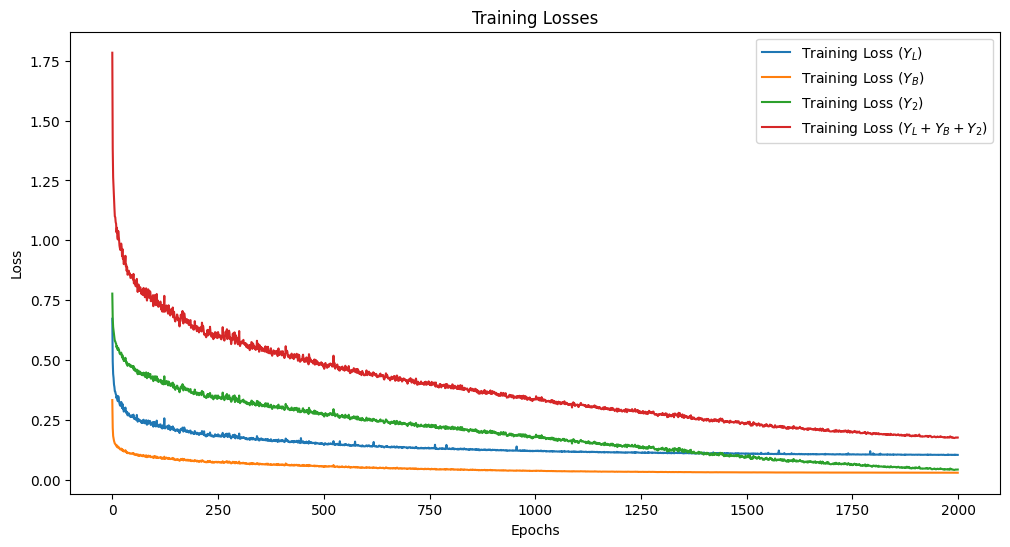

In [18]:
# Extract loss values from history
train_loss_yl = history.history['Output_Linear_loss']
train_loss_yb = history.history['Output_Sigmoid_loss']
train_loss_y2 = history.history['Output_Layer_2_loss']
total_loss = history.history['loss']

# Plot training losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss_yl, label=r'Training Loss ($Y_{L}$)')
plt.plot(train_loss_yb, label=r'Training Loss ($Y_{B}$)')
plt.plot(train_loss_y2, label=r'Training Loss ($Y_{2}$)')
plt.plot(total_loss, label=r'Training Loss ($Y_{L} + Y_{B} + Y_{2}$)')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_losses.png', dpi=300, bbox_inches='tight')
plt.show()
